In [2]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
#plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [3]:
path = '~/workplace/datas/energy/'
#path = '~/Desktop/workplace/datas/energy/'

In [4]:
train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [5]:
X = train_df.iloc[:, :-1]
X.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y = train_df.iloc[:, -1]

In [6]:
X_test = test_df.iloc[:, :-1]
X_test.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y_test = test_df.iloc[:, -1]

In [7]:
X.shape, y.shape, X_test.shape, y_test.shape

((546035, 17), (546035,), (2016, 17), (2016,))

# mRMR

In [8]:
#mRMR
from mrmr import mrmr_classif, mrmr_regression
selected_features = mrmr_regression(X=X, y=y, K=20, return_scores=True)

100%|███████████████████████████████████████████| 17/17 [00:18<00:00,  1.11s/it]


In [9]:
selected_features

(['하루전_현재수요(MW)',
  'Hour',
  '휴일',
  '적설(cm)',
  'smp(원/kWh)',
  '풍속(m/s)',
  '습도(%)',
  '일조(hr)',
  '발전량',
  '현지기압(hPa)',
  'Year',
  'Month',
  '일사(MJ/m2)',
  '기온(°C)',
  'Day',
  '지면온도(°C)',
  '강수량(mm)'],
 Year              2860.884640
 Month             1682.232189
 Day                151.384261
 Hour             66369.451132
 기온(°C)            4006.375704
 풍속(m/s)          22691.984785
 습도(%)            25356.101253
 현지기압(hPa)         3340.531774
 지면온도(°C)           871.292241
 강수량(mm)             44.465668
 적설(cm)           42858.655050
 일조(hr)           12527.003168
 일사(MJ/m2)         6372.065627
 smp(원/kWh)       43467.539457
 발전량               8353.840599
 휴일               27191.463755
 하루전_현재수요(MW)    783073.146561
 dtype: float64,
                   Year     Month       Day      Hour    기온(°C)   풍속(m/s)  \
 Year          0.001000  0.001000  0.001000  0.001000  0.001000  0.020105   
 Month         0.099795  0.001000  0.001000  0.001000  0.001000  0.139199   
 Day           0

In [10]:
mrmr = []

for i , j in enumerate(selected_features[0]):
    mrmr.append([(i+1),j])

In [11]:
mrmr = pd.DataFrame(mrmr, columns=['rank', 'features'])

In [12]:
mrmr

,rank,features
0,1,하루전_현재수요(MW)
1,2,Hour
2,3,휴일
3,4,적설(cm)
4,5,smp(원/kWh)
5,6,풍속(m/s)
6,7,습도(%)
7,8,일조(hr)
8,9,발전량
9,10,현지기압(hPa)


# SAHP

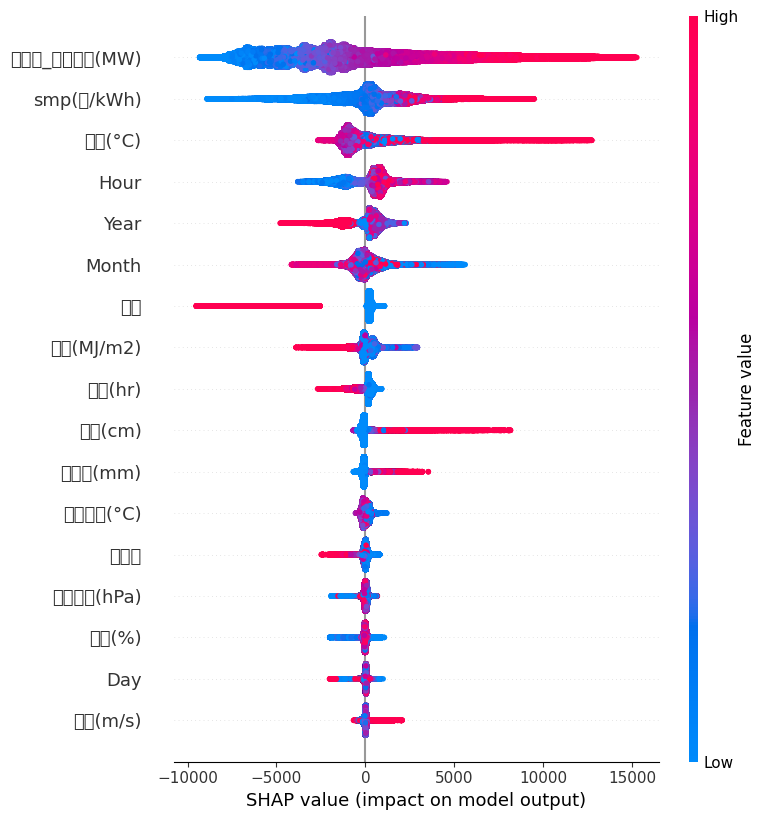

In [13]:
import shap
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X, y)


explainer = shap.Explainer(model)



shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [14]:
import numpy as np

# Calculate mean absolute SHAP values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Print feature importance
shap = []
for feature_name, mean_value in zip(X.keys(), mean_shap_values):
    print(f"{feature_name}: {mean_value}")
    shap.append([mean_value,feature_name])


Year: 719.313814712678
Month: 542.650949205574
Day: 77.04384260414355
Hour: 1000.9766935109452
기온(°C): 1106.7750976267416
풍속(m/s): 76.86485513611495
습도(%): 79.58238694273108
현지기압(hPa): 84.53280097790875
지면온도(°C): 153.71255804031412
강수량(mm): 180.35373807191087
적설(cm): 237.76292465430305
일조(hr): 346.44804487159405
일사(MJ/m2): 362.93868823402585
smp(원/kWh): 1626.1287881065525
발전량: 106.7906934845639
휴일: 471.5528616848872
하루전_현재수요(MW): 3929.752665554796


In [15]:
shap = pd.DataFrame(shap, columns=['value', 'features'])

In [16]:
shap.sort_values('value', ascending=False, inplace=True)

In [17]:
shap['rank'] = [i for i in range(1, len(shap) + 1)]

In [18]:
shap.rename(columns={'rank':'shap_rank'}, inplace=True)

In [19]:
mrmr.set_index(['features'], inplace=True)
shap.set_index(['features'], inplace=True)

In [20]:
shap

,value,shap_rank
features,,
하루전_현재수요(MW),3929.752666,1
smp(원/kWh),1626.128788,2
기온(°C),1106.775098,3
Hour,1000.976694,4
Year,719.313815,5
Month,542.650949,6
휴일,471.552862,7
일사(MJ/m2),362.938688,8
일조(hr),346.448045,9


In [21]:
merge_df = pd.merge(mrmr, shap, left_index=True, right_index=True)
merge_df.drop('value', axis=1, inplace=True)

In [22]:
merge_df['sum'] = (merge_df['rank'] ** 2) + (merge_df['shap_rank'] **2)

In [23]:
merge_df.sort_values('sum', ascending=True, inplace=True)

In [24]:
merge_df

,rank,shap_rank,sum
features,,,
하루전_현재수요(MW),1,1,2
Hour,2,4,20
smp(원/kWh),5,2,29
휴일,3,7,58
적설(cm),4,10,116
일조(hr),8,9,145
Year,11,5,146
Month,12,6,180
기온(°C),14,3,205


# 인덱스 순위

In [36]:
merge_df.index

Index(['하루전_현재수요(MW)', 'Hour', 'smp(원/kWh)', '휴일', '적설(cm)', '일조(hr)', 'Year',
       'Month', '기온(°C)', '일사(MJ/m2)', '발전량', '습도(%)', '현지기압(hPa)', '풍속(m/s)',
       '지면온도(°C)', '강수량(mm)', 'Day'],
      dtype='object', name='features')

In [38]:
index = ['하루전_현재수요(MW)', 'Hour', 'smp(원/kWh)', '휴일', '일조(hr)', 'Year',
       'Month', '기온(°C)', '일사(MJ/m2)', '발전량', '습도(%)', '현지기압(hPa)',
       '지면온도(°C)']

In [39]:
X = X[index]
X

,하루전_현재수요(MW),Hour,smp(원/kWh),휴일,일조(hr),Year,Month,기온(°C),일사(MJ/m2),발전량,습도(%),현지기압(hPa),지면온도(°C)
일시,,,,,,,,,,,,,
2018-01-02 01:05:00,58194.60,1,91.991667,0,0.0,2018,1,-2.955526,0.0,5246.400000,67.514912,1015.174211,-3.007807
2018-01-02 01:10:00,57830.60,1,91.723333,0,0.0,2018,1,-2.994211,0.0,5246.400000,67.735088,1015.189474,-3.031404
2018-01-02 01:15:00,57745.30,1,91.455000,0,0.0,2018,1,-3.032895,0.0,10428.000000,67.955263,1015.204737,-3.055000
2018-01-02 01:20:00,57329.60,1,91.186667,0,0.0,2018,1,-3.071579,0.0,5731.200000,68.175439,1015.220000,-3.078596
2018-01-02 01:25:00,57219.70,1,90.918333,0,0.0,2018,1,-3.110263,0.0,6254.400000,68.395614,1015.235263,-3.102193
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12 23:35:00,58773.93,23,220.551667,0,0.0,2023,3,1.765000,0.0,39745.380277,46.180702,1010.276667,1.134386
2023-03-12 23:40:00,58326.83,23,223.523333,0,0.0,2023,3,1.720000,0.0,39745.380277,46.045614,1010.288070,1.095088
2023-03-12 23:45:00,58038.45,23,226.495000,0,0.0,2023,3,1.675000,0.0,39745.380277,45.910526,1010.299474,1.055789


In [40]:
X_test = X_test.reindex(columns=index)

X_test = X_test.iloc[:, :]

In [41]:
X.shape, X_test.shape, y.shape, y_test.shape

((546035, 13), (2016, 13), (546035,), (2016,))

# XGBoost

In [42]:
import xgboost as xgb


dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test, label=y_test)


def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mape',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }

    bst = xgb.train(params, dtrain)
    preds = bst.predict(xgb.DMatrix(X_test))
    mape = mean_absolute_percentage_error(y_test, preds)
    print("MAPE: {}".format(mape))
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3000)

print(study.best_trial)
print(study.best_value)

[I 2023-07-20 14:29:43,497] A new study created in memory with name: no-name-70d8550a-332d-492c-bd6f-125935bc9ed8
[I 2023-07-20 14:29:44,594] Trial 0 finished with value: 0.4050446921315168 and parameters: {'max_depth': 7, 'eta': 0.08296286966591783, 'gamma': 0.015701179294415234, 'subsample': 0.7580032080215501, 'colsample_bytree': 0.8308683892952594}. Best is trial 0 with value: 0.4050446921315168.


MAPE: 0.4050446921315168


[I 2023-07-20 14:29:44,862] Trial 1 finished with value: 0.8723398916533949 and parameters: {'max_depth': 2, 'eta': 0.012853713873049752, 'gamma': 0.47904104428495187, 'subsample': 0.5352371053239228, 'colsample_bytree': 0.4144078036345671}. Best is trial 0 with value: 0.4050446921315168.
[I 2023-07-20 14:29:45,025] Trial 2 finished with value: 0.8703710590554176 and parameters: {'max_depth': 1, 'eta': 0.01295645639191828, 'gamma': 0.030618680316625898, 'subsample': 0.8872770738854855, 'colsample_bytree': 0.151247832686078}. Best is trial 0 with value: 0.4050446921315168.


MAPE: 0.8723398916533949
MAPE: 0.8703710590554176


[I 2023-07-20 14:29:45,736] Trial 3 finished with value: 0.4204797799414659 and parameters: {'max_depth': 8, 'eta': 0.07996011756286725, 'gamma': 0.012970774139081978, 'subsample': 0.35764346014461, 'colsample_bytree': 0.4636044094620533}. Best is trial 0 with value: 0.4050446921315168.


MAPE: 0.4204797799414659


[I 2023-07-20 14:29:46,552] Trial 4 finished with value: 0.057898431596279304 and parameters: {'max_depth': 10, 'eta': 0.3425946819492574, 'gamma': 0.17915033076411202, 'subsample': 0.10654048126222845, 'colsample_bytree': 0.8531207216143372}. Best is trial 4 with value: 0.057898431596279304.
[I 2023-07-20 14:29:46,741] Trial 5 finished with value: 0.07597722941000924 and parameters: {'max_depth': 2, 'eta': 0.33563405700640137, 'gamma': 0.04053459174947897, 'subsample': 0.24285463212414254, 'colsample_bytree': 0.3491709074164676}. Best is trial 4 with value: 0.057898431596279304.


MAPE: 0.057898431596279304
MAPE: 0.07597722941000924


[I 2023-07-20 14:29:47,677] Trial 6 finished with value: 0.7994292436515112 and parameters: {'max_depth': 8, 'eta': 0.021540125996311964, 'gamma': 0.01693484900588075, 'subsample': 0.9474160282787882, 'colsample_bytree': 0.501966952633887}. Best is trial 4 with value: 0.057898431596279304.


MAPE: 0.7994292436515112


[I 2023-07-20 14:29:48,119] Trial 7 finished with value: 0.44988792265594924 and parameters: {'max_depth': 5, 'eta': 0.07375137135850196, 'gamma': 0.013772431295843874, 'subsample': 0.17107509542828686, 'colsample_bytree': 0.7171555926466057}. Best is trial 4 with value: 0.057898431596279304.


MAPE: 0.44988792265594924


[I 2023-07-20 14:29:48,535] Trial 8 finished with value: 0.08331726584653044 and parameters: {'max_depth': 3, 'eta': 0.25957831059099756, 'gamma': 0.4768078529960225, 'subsample': 0.5166195876787513, 'colsample_bytree': 0.6175516969207544}. Best is trial 4 with value: 0.057898431596279304.


MAPE: 0.08331726584653044


[I 2023-07-20 14:29:48,762] Trial 9 finished with value: 0.7589752334672634 and parameters: {'max_depth': 1, 'eta': 0.025997357738883547, 'gamma': 0.07502245035187592, 'subsample': 0.7606863523386752, 'colsample_bytree': 0.5872817976396714}. Best is trial 4 with value: 0.057898431596279304.


MAPE: 0.7589752334672634


[I 2023-07-20 14:29:49,817] Trial 10 finished with value: 0.050786613958859694 and parameters: {'max_depth': 10, 'eta': 0.7114220077854931, 'gamma': 0.1826372269389694, 'subsample': 0.17591404531529486, 'colsample_bytree': 0.9970242357607542}. Best is trial 10 with value: 0.050786613958859694.


MAPE: 0.050786613958859694


[I 2023-07-20 14:29:50,794] Trial 11 finished with value: 0.061012654774531286 and parameters: {'max_depth': 10, 'eta': 0.908057850078956, 'gamma': 0.183915887697127, 'subsample': 0.13760252158508798, 'colsample_bytree': 0.9966961392841269}. Best is trial 10 with value: 0.050786613958859694.


MAPE: 0.061012654774531286


[I 2023-07-20 14:29:51,749] Trial 12 finished with value: 0.05807833095082634 and parameters: {'max_depth': 10, 'eta': 0.9897154999236711, 'gamma': 0.18908742078868604, 'subsample': 0.1252024088606652, 'colsample_bytree': 0.9958356534420815}. Best is trial 10 with value: 0.050786613958859694.


MAPE: 0.05807833095082634


[I 2023-07-20 14:29:52,904] Trial 13 finished with value: 0.04628907834931937 and parameters: {'max_depth': 10, 'eta': 0.42529335260784956, 'gamma': 0.18219975958680884, 'subsample': 0.32708070399438127, 'colsample_bytree': 0.8453864224232193}. Best is trial 13 with value: 0.04628907834931937.


MAPE: 0.04628907834931937


[I 2023-07-20 14:29:53,871] Trial 14 finished with value: 0.04066656799059014 and parameters: {'max_depth': 8, 'eta': 0.5455006773319506, 'gamma': 0.1014294009082761, 'subsample': 0.32573440934931136, 'colsample_bytree': 0.8534155168495262}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04066656799059014


[I 2023-07-20 14:29:54,600] Trial 15 finished with value: 0.12921161782616167 and parameters: {'max_depth': 6, 'eta': 0.18490250487444768, 'gamma': 0.8925306071298182, 'subsample': 0.3695619060851863, 'colsample_bytree': 0.7806018044446295}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.12921161782616167


[I 2023-07-20 14:29:55,511] Trial 16 finished with value: 0.04838032140797299 and parameters: {'max_depth': 8, 'eta': 0.5709171272394715, 'gamma': 0.07707707572975761, 'subsample': 0.3542705229856048, 'colsample_bytree': 0.6957723699531532}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04838032140797299


[I 2023-07-20 14:29:56,802] Trial 17 finished with value: 0.04145192993273155 and parameters: {'max_depth': 9, 'eta': 0.5423892856894913, 'gamma': 0.1148701064134811, 'subsample': 0.44540850066241017, 'colsample_bytree': 0.8877977985970107}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04145192993273155


[I 2023-07-20 14:29:57,524] Trial 18 finished with value: 0.1505920605529328 and parameters: {'max_depth': 5, 'eta': 0.17014603388100435, 'gamma': 0.04974431119413047, 'subsample': 0.46329681233761383, 'colsample_bytree': 0.9039127676649527}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.1505920605529328


[I 2023-07-20 14:29:58,489] Trial 19 finished with value: 0.04933667321307665 and parameters: {'max_depth': 7, 'eta': 0.477289753008894, 'gamma': 0.1032643288637331, 'subsample': 0.6159765710643034, 'colsample_bytree': 0.6999867160692977}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04933667321307665


[I 2023-07-20 14:29:59,820] Trial 20 finished with value: 0.05316555151730241 and parameters: {'max_depth': 9, 'eta': 0.6216790535297358, 'gamma': 0.11253175294216687, 'subsample': 0.45156686845263194, 'colsample_bytree': 0.9008218790527658}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05316555151730241


[I 2023-07-20 14:30:00,789] Trial 21 finished with value: 0.04710888183082203 and parameters: {'max_depth': 9, 'eta': 0.4294932576567949, 'gamma': 0.28656178876795163, 'subsample': 0.2870949585488025, 'colsample_bytree': 0.7831691347021777}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04710888183082203


[I 2023-07-20 14:30:01,810] Trial 22 finished with value: 0.05041213693694241 and parameters: {'max_depth': 9, 'eta': 0.5379418862906743, 'gamma': 0.1333173845626655, 'subsample': 0.2770139182152966, 'colsample_bytree': 0.88008397298763}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05041213693694241


[I 2023-07-20 14:30:02,751] Trial 23 finished with value: 0.04558434575475564 and parameters: {'max_depth': 7, 'eta': 0.9854742382874552, 'gamma': 0.07655312093809445, 'subsample': 0.4143662530327758, 'colsample_bytree': 0.7723581262996944}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04558434575475564


[I 2023-07-20 14:30:03,577] Trial 24 finished with value: 0.046016757749130874 and parameters: {'max_depth': 6, 'eta': 0.9486916153298207, 'gamma': 0.07147152200679785, 'subsample': 0.4338420969480757, 'colsample_bytree': 0.7752542725070648}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.046016757749130874


[I 2023-07-20 14:30:04,343] Trial 25 finished with value: 0.05704869806615192 and parameters: {'max_depth': 7, 'eta': 0.6389845484484784, 'gamma': 0.059430017497194065, 'subsample': 0.4055314221627685, 'colsample_bytree': 0.6485990008455329}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05704869806615192


[I 2023-07-20 14:30:04,771] Trial 26 finished with value: 0.0568409322196528 and parameters: {'max_depth': 4, 'eta': 0.7259781552794699, 'gamma': 0.0961359003524624, 'subsample': 0.22187937827342283, 'colsample_bytree': 0.9209851634733495}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0568409322196528


[I 2023-07-20 14:30:05,643] Trial 27 finished with value: 0.09150257736705225 and parameters: {'max_depth': 8, 'eta': 0.22471237932957483, 'gamma': 0.03639498075295742, 'subsample': 0.32494124775087413, 'colsample_bytree': 0.7666849110768116}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.09150257736705225


[I 2023-07-20 14:30:06,755] Trial 28 finished with value: 0.22171871699828954 and parameters: {'max_depth': 7, 'eta': 0.13318062162208485, 'gamma': 0.052264744415801874, 'subsample': 0.6036406066737181, 'colsample_bytree': 0.9319137442199013}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.22171871699828954


[I 2023-07-20 14:30:07,726] Trial 29 finished with value: 0.06685149608395446 and parameters: {'max_depth': 7, 'eta': 0.3297229853957546, 'gamma': 0.028674982576701813, 'subsample': 0.4868295498546231, 'colsample_bytree': 0.8211721640145209}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06685149608395446


[I 2023-07-20 14:30:08,966] Trial 30 finished with value: 0.04609440152878299 and parameters: {'max_depth': 9, 'eta': 0.7687144893595125, 'gamma': 0.12246636168083924, 'subsample': 0.38732287617696615, 'colsample_bytree': 0.8274421065414459}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04609440152878299


[I 2023-07-20 14:30:09,747] Trial 31 finished with value: 0.05269256995610828 and parameters: {'max_depth': 6, 'eta': 0.8990242033538213, 'gamma': 0.08678633900623316, 'subsample': 0.4298255729511726, 'colsample_bytree': 0.7534826683451553}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05269256995610828


[I 2023-07-20 14:30:10,651] Trial 32 finished with value: 0.053443089934624176 and parameters: {'max_depth': 6, 'eta': 0.9905650996413354, 'gamma': 0.06647564199143843, 'subsample': 0.5571102585827916, 'colsample_bytree': 0.8067589395600786}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.053443089934624176


[I 2023-07-20 14:30:11,284] Trial 33 finished with value: 0.05713837327640811 and parameters: {'max_depth': 5, 'eta': 0.5360363063219706, 'gamma': 0.075402854624194, 'subsample': 0.4276039392456424, 'colsample_bytree': 0.7344642887831487}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05713837327640811


[I 2023-07-20 14:30:12,267] Trial 34 finished with value: 0.050936905711056905 and parameters: {'max_depth': 8, 'eta': 0.7012655962152788, 'gamma': 0.1401172606945675, 'subsample': 0.4972398631572095, 'colsample_bytree': 0.6545272678674213}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.050936905711056905


[I 2023-07-20 14:30:13,066] Trial 35 finished with value: 0.0550214871537645 and parameters: {'max_depth': 6, 'eta': 0.43763474031697586, 'gamma': 0.05685561605850494, 'subsample': 0.3964845403463848, 'colsample_bytree': 0.8562175106702566}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0550214871537645


[I 2023-07-20 14:30:13,888] Trial 36 finished with value: 0.05423060009272577 and parameters: {'max_depth': 7, 'eta': 0.9938543582659026, 'gamma': 0.10884421398474516, 'subsample': 0.31850349435312747, 'colsample_bytree': 0.8084321965829866}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05423060009272577


[I 2023-07-20 14:30:14,525] Trial 37 finished with value: 0.0679911027281839 and parameters: {'max_depth': 4, 'eta': 0.3600709815850982, 'gamma': 0.09311913862985859, 'subsample': 0.5614694750077902, 'colsample_bytree': 0.9534454327776567}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0679911027281839


[I 2023-07-20 14:30:15,396] Trial 38 finished with value: 0.050503166559645506 and parameters: {'max_depth': 8, 'eta': 0.7539196118002967, 'gamma': 0.04503319248084322, 'subsample': 0.24869677770896162, 'colsample_bytree': 0.8776876151364963}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.050503166559645506


[I 2023-07-20 14:30:16,559] Trial 39 finished with value: 0.048554290470356365 and parameters: {'max_depth': 9, 'eta': 0.5590556433768522, 'gamma': 0.06172696346081374, 'subsample': 0.4607556753558719, 'colsample_bytree': 0.7301616245748764}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.048554290470356365


[I 2023-07-20 14:30:17,288] Trial 40 finished with value: 0.07198777095462548 and parameters: {'max_depth': 8, 'eta': 0.2575701935163573, 'gamma': 0.03770963616313163, 'subsample': 0.36781972037945565, 'colsample_bytree': 0.536770295300011}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.07198777095462548


[I 2023-07-20 14:30:18,491] Trial 41 finished with value: 0.05826077247564118 and parameters: {'max_depth': 9, 'eta': 0.7547866574868412, 'gamma': 0.13935815548065775, 'subsample': 0.39831733992611623, 'colsample_bytree': 0.8358491144017878}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05826077247564118


[I 2023-07-20 14:30:19,910] Trial 42 finished with value: 0.06091621768192342 and parameters: {'max_depth': 9, 'eta': 0.8252810977859482, 'gamma': 0.0681129411289213, 'subsample': 0.5195794776701383, 'colsample_bytree': 0.8576472872719874}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06091621768192342


[I 2023-07-20 14:30:20,836] Trial 43 finished with value: 0.04127926944268411 and parameters: {'max_depth': 7, 'eta': 0.6268580147894638, 'gamma': 0.12406593961085072, 'subsample': 0.4199286876104579, 'colsample_bytree': 0.798122555722669}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04127926944268411


[I 2023-07-20 14:30:21,852] Trial 44 finished with value: 0.04538254381650896 and parameters: {'max_depth': 7, 'eta': 0.6025122382134834, 'gamma': 0.08475249237617553, 'subsample': 0.4278259511789553, 'colsample_bytree': 0.9481998102116169}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04538254381650896


[I 2023-07-20 14:30:22,746] Trial 45 finished with value: 0.05858966150707052 and parameters: {'max_depth': 7, 'eta': 0.3702363256138245, 'gamma': 0.08566127518056842, 'subsample': 0.3381475909987348, 'colsample_bytree': 0.949851773085828}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05858966150707052


[I 2023-07-20 14:30:23,816] Trial 46 finished with value: 0.050051723411646244 and parameters: {'max_depth': 7, 'eta': 0.49160229843516523, 'gamma': 0.15815608958793018, 'subsample': 0.48491539530593075, 'colsample_bytree': 0.9506456574470454}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.050051723411646244


[I 2023-07-20 14:30:24,736] Trial 47 finished with value: 0.05063732185001391 and parameters: {'max_depth': 8, 'eta': 0.6321436235597718, 'gamma': 0.2297326552838542, 'subsample': 0.2858786099322813, 'colsample_bytree': 0.9021455174090978}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05063732185001391


[I 2023-07-20 14:30:25,750] Trial 48 finished with value: 0.057379947859113226 and parameters: {'max_depth': 8, 'eta': 0.4112836856369147, 'gamma': 0.11727271463612352, 'subsample': 0.3578911966884109, 'colsample_bytree': 0.873574224687688}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.057379947859113226


[I 2023-07-20 14:30:26,763] Trial 49 finished with value: 0.0645491076508548 and parameters: {'max_depth': 7, 'eta': 0.3148643170728614, 'gamma': 0.09498231772843585, 'subsample': 0.4372915716949321, 'colsample_bytree': 0.9707809981805107}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0645491076508548


[I 2023-07-20 14:30:27,523] Trial 50 finished with value: 0.049014883729814177 and parameters: {'max_depth': 5, 'eta': 0.5454039995368393, 'gamma': 0.1502639327131341, 'subsample': 0.5221499081007583, 'colsample_bytree': 0.9134501014706465}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.049014883729814177


[I 2023-07-20 14:30:28,326] Trial 51 finished with value: 0.04354523664856181 and parameters: {'max_depth': 6, 'eta': 0.8348735932661385, 'gamma': 0.07606659773381153, 'subsample': 0.42391429370074946, 'colsample_bytree': 0.8147604507096107}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04354523664856181


[I 2023-07-20 14:30:29,110] Trial 52 finished with value: 0.051483836528826606 and parameters: {'max_depth': 6, 'eta': 0.8255426265619303, 'gamma': 0.10982812049107672, 'subsample': 0.40935711979553896, 'colsample_bytree': 0.8126400730642579}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.051483836528826606


[I 2023-07-20 14:30:30,018] Trial 53 finished with value: 0.04261305981497961 and parameters: {'max_depth': 7, 'eta': 0.6172186159997343, 'gamma': 0.080622051930338, 'subsample': 0.37701307958359315, 'colsample_bytree': 0.8617942346700448}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04261305981497961


[I 2023-07-20 14:30:30,809] Trial 54 finished with value: 0.05101789087160304 and parameters: {'max_depth': 6, 'eta': 0.4721633247642107, 'gamma': 0.08610889705248646, 'subsample': 0.3671391239668643, 'colsample_bytree': 0.9765823834069395}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05101789087160304


[I 2023-07-20 14:30:31,964] Trial 55 finished with value: 0.04841647705640681 and parameters: {'max_depth': 8, 'eta': 0.6043975392252243, 'gamma': 0.12813167237134757, 'subsample': 0.4571428478035534, 'colsample_bytree': 0.8835004751476715}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04841647705640681


[I 2023-07-20 14:30:33,179] Trial 56 finished with value: 0.052368747713242354 and parameters: {'max_depth': 10, 'eta': 0.639350892183416, 'gamma': 0.10418055365781323, 'subsample': 0.3058358630170839, 'colsample_bytree': 0.8512983418070593}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.052368747713242354


[I 2023-07-20 14:30:33,813] Trial 57 finished with value: 0.06393925261537325 and parameters: {'max_depth': 5, 'eta': 0.39912441047042857, 'gamma': 0.061325828621060424, 'subsample': 0.34300458546232326, 'colsample_bytree': 0.92724357597504}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06393925261537325


[I 2023-07-20 14:30:34,681] Trial 58 finished with value: 0.05686067923984009 and parameters: {'max_depth': 7, 'eta': 0.48982761798062796, 'gamma': 0.16506161931797575, 'subsample': 0.38155253469634276, 'colsample_bytree': 0.7984737974900856}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05686067923984009


[I 2023-07-20 14:30:34,920] Trial 59 finished with value: 0.07286900063869298 and parameters: {'max_depth': 1, 'eta': 0.3119306438584585, 'gamma': 0.08002360205169148, 'subsample': 0.4675674132490692, 'colsample_bytree': 0.9953972412865527}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.07286900063869298


[I 2023-07-20 14:30:35,622] Trial 60 finished with value: 0.0527627506486532 and parameters: {'max_depth': 6, 'eta': 0.6979534622303795, 'gamma': 0.20024409624923153, 'subsample': 0.3062652435639456, 'colsample_bytree': 0.8946306288185673}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0527627506486532


[I 2023-07-20 14:30:36,492] Trial 61 finished with value: 0.06332304392614534 and parameters: {'max_depth': 7, 'eta': 0.7910625965063689, 'gamma': 0.07412485807759209, 'subsample': 0.41507016306362454, 'colsample_bytree': 0.7505354598789452}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06332304392614534


[I 2023-07-20 14:30:37,373] Trial 62 finished with value: 0.052270838963877624 and parameters: {'max_depth': 7, 'eta': 0.642746103937604, 'gamma': 0.09856435900326531, 'subsample': 0.38407852959872557, 'colsample_bytree': 0.828005411225656}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.052270838963877624


[I 2023-07-20 14:30:38,483] Trial 63 finished with value: 0.046008441597979205 and parameters: {'max_depth': 8, 'eta': 0.8004222608891924, 'gamma': 0.12141802270293882, 'subsample': 0.4407551288468072, 'colsample_bytree': 0.7826306612699483}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.046008441597979205


[I 2023-07-20 14:30:39,334] Trial 64 finished with value: 0.04194571204286264 and parameters: {'max_depth': 7, 'eta': 0.9035591125904323, 'gamma': 0.054186170503467676, 'subsample': 0.34752181689605627, 'colsample_bytree': 0.8459624172209399}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04194571204286264


[I 2023-07-20 14:30:40,074] Trial 65 finished with value: 0.04290806402355809 and parameters: {'max_depth': 6, 'eta': 0.5359221485649365, 'gamma': 0.05055009093255018, 'subsample': 0.35091334831645576, 'colsample_bytree': 0.8528557682893422}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04290806402355809


[I 2023-07-20 14:30:40,800] Trial 66 finished with value: 0.0563887721634573 and parameters: {'max_depth': 6, 'eta': 0.4815890669544915, 'gamma': 0.05016618329313533, 'subsample': 0.33843161958523804, 'colsample_bytree': 0.8607048394841788}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0563887721634573


[I 2023-07-20 14:30:41,206] Trial 67 finished with value: 0.06049063667336304 and parameters: {'max_depth': 4, 'eta': 0.8527420397811137, 'gamma': 0.0551349723128118, 'subsample': 0.2355204970584109, 'colsample_bytree': 0.8348056770965512}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06049063667336304


[I 2023-07-20 14:30:41,798] Trial 68 finished with value: 0.04402865084301695 and parameters: {'max_depth': 5, 'eta': 0.5425505326510327, 'gamma': 0.044211393932587044, 'subsample': 0.3541575315593422, 'colsample_bytree': 0.7904538042542137}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04402865084301695


[I 2023-07-20 14:30:42,054] Trial 69 finished with value: 0.06933158676422414 and parameters: {'max_depth': 2, 'eta': 0.6808579507395256, 'gamma': 0.0656646325382312, 'subsample': 0.2821284036400008, 'colsample_bytree': 0.7109077445735187}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06933158676422414


[I 2023-07-20 14:30:42,762] Trial 70 finished with value: 0.05117068893932462 and parameters: {'max_depth': 6, 'eta': 0.9086572298489326, 'gamma': 0.02945145851590453, 'subsample': 0.3138002315139596, 'colsample_bytree': 0.911022163264957}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05117068893932462


[I 2023-07-20 14:30:43,349] Trial 71 finished with value: 0.053102430470021965 and parameters: {'max_depth': 5, 'eta': 0.5377544428686258, 'gamma': 0.04404351554762251, 'subsample': 0.3447566087768966, 'colsample_bytree': 0.793195568822827}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.053102430470021965


[I 2023-07-20 14:30:43,961] Trial 72 finished with value: 0.05577268159201978 and parameters: {'max_depth': 5, 'eta': 0.4112728619543432, 'gamma': 0.03454826219825009, 'subsample': 0.3755002212355174, 'colsample_bytree': 0.8416271537978446}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05577268159201978


[I 2023-07-20 14:30:44,535] Trial 73 finished with value: 0.05733793840369179 and parameters: {'max_depth': 5, 'eta': 0.5618828329247162, 'gamma': 0.055365705132711523, 'subsample': 0.3605204880113321, 'colsample_bytree': 0.7555321372014339}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05733793840369179


[I 2023-07-20 14:30:45,301] Trial 74 finished with value: 0.05730452387257741 and parameters: {'max_depth': 6, 'eta': 0.7038085485792791, 'gamma': 0.04821665948335034, 'subsample': 0.3918557374756547, 'colsample_bytree': 0.7966112793637535}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05730452387257741


[I 2023-07-20 14:30:45,850] Trial 75 finished with value: 0.06373643437888857 and parameters: {'max_depth': 4, 'eta': 0.4509916022348199, 'gamma': 0.06671628735766072, 'subsample': 0.40985692542957064, 'colsample_bytree': 0.8813100168404906}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06373643437888857


[I 2023-07-20 14:30:46,680] Trial 76 finished with value: 0.0631556280980931 and parameters: {'max_depth': 8, 'eta': 0.3679336590690066, 'gamma': 0.04196335864934339, 'subsample': 0.2631168056926855, 'colsample_bytree': 0.8187939004880633}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0631556280980931


[I 2023-07-20 14:30:47,810] Trial 77 finished with value: 0.04682824715280273 and parameters: {'max_depth': 9, 'eta': 0.9081561968915266, 'gamma': 0.07405891858102756, 'subsample': 0.32336497989402313, 'colsample_bytree': 0.8594620058464697}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04682824715280273


[I 2023-07-20 14:30:48,468] Trial 78 finished with value: 0.05400642198382579 and parameters: {'max_depth': 7, 'eta': 0.5058885143333093, 'gamma': 0.04909942249517018, 'subsample': 0.21399766767129264, 'colsample_bytree': 0.774761959735285}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05400642198382579


[I 2023-07-20 14:30:49,081] Trial 79 finished with value: 0.04450604465552799 and parameters: {'max_depth': 6, 'eta': 0.5907975476993158, 'gamma': 0.02538605545841743, 'subsample': 0.29654238510258757, 'colsample_bytree': 0.7407004195840996}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04450604465552799


[I 2023-07-20 14:30:49,477] Trial 80 finished with value: 0.06809589007765272 and parameters: {'max_depth': 3, 'eta': 0.7093867590347405, 'gamma': 0.09663861943022152, 'subsample': 0.3533687521153381, 'colsample_bytree': 0.6994912640678177}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06809589007765272


[I 2023-07-20 14:30:50,099] Trial 81 finished with value: 0.05525307171456553 and parameters: {'max_depth': 6, 'eta': 0.5919307319304974, 'gamma': 0.02561532241345165, 'subsample': 0.2974693258926417, 'colsample_bytree': 0.7483223622943607}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05525307171456553


[I 2023-07-20 14:30:50,743] Trial 82 finished with value: 0.04400294005822004 and parameters: {'max_depth': 6, 'eta': 0.8506738507757513, 'gamma': 0.022070847212678824, 'subsample': 0.28449273820667303, 'colsample_bytree': 0.8374402058053854}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04400294005822004


[I 2023-07-20 14:30:51,293] Trial 83 finished with value: 0.050481412188378975 and parameters: {'max_depth': 5, 'eta': 0.8804724690002483, 'gamma': 0.018626637135613973, 'subsample': 0.26450637260556775, 'colsample_bytree': 0.8889574870712617}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.050481412188378975


[I 2023-07-20 14:30:52,102] Trial 84 finished with value: 0.04397635617689949 and parameters: {'max_depth': 7, 'eta': 0.7649627983491999, 'gamma': 0.061248173158140434, 'subsample': 0.3198087871965588, 'colsample_bytree': 0.8355584325733735}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04397635617689949


[I 2023-07-20 14:30:52,997] Trial 85 finished with value: 0.04606366200199361 and parameters: {'max_depth': 7, 'eta': 0.7944312647333558, 'gamma': 0.05744171385400686, 'subsample': 0.3296867463780085, 'colsample_bytree': 0.9243858156443626}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04606366200199361


[I 2023-07-20 14:30:53,920] Trial 86 finished with value: 0.057589806086665044 and parameters: {'max_depth': 7, 'eta': 0.9579146465854536, 'gamma': 0.08143400988407708, 'subsample': 0.39434295740442593, 'colsample_bytree': 0.836537713200348}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.057589806086665044


[I 2023-07-20 14:30:54,824] Trial 87 finished with value: 0.04525994109711874 and parameters: {'max_depth': 8, 'eta': 0.7455524935629984, 'gamma': 0.1121031606826271, 'subsample': 0.275641976302102, 'colsample_bytree': 0.8745939866821933}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04525994109711874


[I 2023-07-20 14:30:55,513] Trial 88 finished with value: 0.059045781962010116 and parameters: {'max_depth': 6, 'eta': 0.6478978822147482, 'gamma': 0.06373684420271054, 'subsample': 0.31958057329372863, 'colsample_bytree': 0.8148447234466609}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.059045781962010116


[I 2023-07-20 14:30:56,509] Trial 89 finished with value: 0.04897419920937517 and parameters: {'max_depth': 7, 'eta': 0.8523163226960607, 'gamma': 0.09203028996080001, 'subsample': 0.4244689740166703, 'colsample_bytree': 0.856572452732702}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04897419920937517


[I 2023-07-20 14:30:57,820] Trial 90 finished with value: 0.048093511082495495 and parameters: {'max_depth': 9, 'eta': 0.6741237597177421, 'gamma': 0.0392605946646862, 'subsample': 0.44505037049985186, 'colsample_bytree': 0.8960575397129416}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.048093511082495495


[I 2023-07-20 14:30:58,548] Trial 91 finished with value: 0.046190452966511045 and parameters: {'max_depth': 6, 'eta': 0.5264746274584228, 'gamma': 0.07103816646969281, 'subsample': 0.36225997576433566, 'colsample_bytree': 0.7928231777770162}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.046190452966511045


[I 2023-07-20 14:30:59,403] Trial 92 finished with value: 0.047272005104138135 and parameters: {'max_depth': 7, 'eta': 0.45240067600805617, 'gamma': 0.05287258004335837, 'subsample': 0.37349297653642677, 'colsample_bytree': 0.8202594720552}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.047272005104138135


[I 2023-07-20 14:31:00,322] Trial 93 finished with value: 0.050002860147891376 and parameters: {'max_depth': 8, 'eta': 0.7519076865221335, 'gamma': 0.04404654885082047, 'subsample': 0.34991800305618304, 'colsample_bytree': 0.7669869902707833}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.050002860147891376


[I 2023-07-20 14:31:01,008] Trial 94 finished with value: 0.04071296301794331 and parameters: {'max_depth': 5, 'eta': 0.9857559253202601, 'gamma': 0.05827188536182297, 'subsample': 0.4057663562800497, 'colsample_bytree': 0.8665430464204408}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04071296301794331


[I 2023-07-20 14:31:02,068] Trial 95 finished with value: 0.05766286663601761 and parameters: {'max_depth': 7, 'eta': 0.9861358130864136, 'gamma': 0.060110726308858504, 'subsample': 0.4755771169231703, 'colsample_bytree': 0.8683226751842714}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05766286663601761


[I 2023-07-20 14:31:02,911] Trial 96 finished with value: 0.0499519497775636 and parameters: {'max_depth': 6, 'eta': 0.8421427500858741, 'gamma': 0.07887629301943065, 'subsample': 0.41898942967694164, 'colsample_bytree': 0.9118704104131217}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0499519497775636


[I 2023-07-20 14:31:03,720] Trial 97 finished with value: 0.048371817318574775 and parameters: {'max_depth': 6, 'eta': 0.6142099675642679, 'gamma': 0.10374584667892338, 'subsample': 0.45088211056855704, 'colsample_bytree': 0.8438160162191288}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.048371817318574775


[I 2023-07-20 14:31:05,357] Trial 98 finished with value: 0.04765507751381345 and parameters: {'max_depth': 10, 'eta': 0.8428502077229999, 'gamma': 0.13093116427960907, 'subsample': 0.49707483987923073, 'colsample_bytree': 0.9293599359967488}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04765507751381345


[I 2023-07-20 14:31:06,477] Trial 99 finished with value: 0.04888522061929943 and parameters: {'max_depth': 8, 'eta': 0.9959495315504224, 'gamma': 0.08615891788463308, 'subsample': 0.39992559339722206, 'colsample_bytree': 0.9017484275796557}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04888522061929943


[I 2023-07-20 14:31:07,274] Trial 100 finished with value: 0.04155572229893141 and parameters: {'max_depth': 7, 'eta': 0.7801808044351717, 'gamma': 0.11427063938014023, 'subsample': 0.3057589203096509, 'colsample_bytree': 0.8438274738684819}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04155572229893141


[I 2023-07-20 14:31:08,086] Trial 101 finished with value: 0.05843819874704255 and parameters: {'max_depth': 7, 'eta': 0.7126328820712173, 'gamma': 0.06969568143183823, 'subsample': 0.32705187131793195, 'colsample_bytree': 0.8460780950305065}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05843819874704255


[I 2023-07-20 14:31:08,907] Trial 102 finished with value: 0.05405429327630697 and parameters: {'max_depth': 7, 'eta': 0.7960684693381324, 'gamma': 0.1165918523006847, 'subsample': 0.3059984853070554, 'colsample_bytree': 0.8708120742398029}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05405429327630697


[I 2023-07-20 14:31:09,669] Trial 103 finished with value: 0.04509854478964816 and parameters: {'max_depth': 6, 'eta': 0.6533125598036459, 'gamma': 0.0912078614508492, 'subsample': 0.38304440208156854, 'colsample_bytree': 0.8166357047399612}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04509854478964816


[I 2023-07-20 14:31:10,625] Trial 104 finished with value: 0.05153635246432746 and parameters: {'max_depth': 8, 'eta': 0.8891700505504528, 'gamma': 0.10177906374973067, 'subsample': 0.335345767528877, 'colsample_bytree': 0.8251381066729964}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05153635246432746


[I 2023-07-20 14:31:11,423] Trial 105 finished with value: 0.05695262215587487 and parameters: {'max_depth': 7, 'eta': 0.7453938995408761, 'gamma': 0.14787936966224907, 'subsample': 0.2955132149248888, 'colsample_bytree': 0.805590699504416}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05695262215587487


[I 2023-07-20 14:31:12,202] Trial 106 finished with value: 0.04569941290964721 and parameters: {'max_depth': 6, 'eta': 0.5735364713375514, 'gamma': 0.13642826187792884, 'subsample': 0.37422877802329285, 'colsample_bytree': 0.8867994728296188}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04569941290964721


[I 2023-07-20 14:31:12,886] Trial 107 finished with value: 0.05660973323141558 and parameters: {'max_depth': 5, 'eta': 0.91436342783843, 'gamma': 0.07713431071024643, 'subsample': 0.40753548598981276, 'colsample_bytree': 0.8470219925117443}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05660973323141558


[I 2023-07-20 14:31:13,896] Trial 108 finished with value: 0.04974431227129417 and parameters: {'max_depth': 7, 'eta': 0.5110451491659187, 'gamma': 0.06206102464221755, 'subsample': 0.4272549059042901, 'colsample_bytree': 0.9384463165739196}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04974431227129417


[I 2023-07-20 14:31:14,990] Trial 109 finished with value: 0.05252233234670209 and parameters: {'max_depth': 9, 'eta': 0.6706383535055475, 'gamma': 0.11235739897255052, 'subsample': 0.3141463756177918, 'colsample_bytree': 0.8625805954924368}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05252233234670209


[I 2023-07-20 14:31:15,822] Trial 110 finished with value: 0.051595809933796116 and parameters: {'max_depth': 7, 'eta': 0.7918421291163261, 'gamma': 0.12554552349260187, 'subsample': 0.34741627223451677, 'colsample_bytree': 0.7749759494176427}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.051595809933796116


[I 2023-07-20 14:31:16,434] Trial 111 finished with value: 0.05248835055335649 and parameters: {'max_depth': 5, 'eta': 0.5845515664568487, 'gamma': 0.050642430042276074, 'subsample': 0.35968531224542866, 'colsample_bytree': 0.8039351930872857}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05248835055335649


[I 2023-07-20 14:31:16,943] Trial 112 finished with value: 0.060005145599264564 and parameters: {'max_depth': 4, 'eta': 0.521497873179293, 'gamma': 0.04655360325765076, 'subsample': 0.38764688462663005, 'colsample_bytree': 0.8270134471961859}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.060005145599264564


[I 2023-07-20 14:31:17,523] Trial 113 finished with value: 0.05694349671058766 and parameters: {'max_depth': 5, 'eta': 0.43727190938683413, 'gamma': 0.05907414890862277, 'subsample': 0.336690678760585, 'colsample_bytree': 0.7905805442292608}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05694349671058766


[I 2023-07-20 14:31:18,085] Trial 114 finished with value: 0.06499157874925851 and parameters: {'max_depth': 5, 'eta': 0.7279416018026623, 'gamma': 0.06930138212409896, 'subsample': 0.2767583461853968, 'colsample_bytree': 0.8826776501194393}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06499157874925851


[I 2023-07-20 14:31:18,910] Trial 115 finished with value: 0.04951675374741446 and parameters: {'max_depth': 6, 'eta': 0.6283433980120583, 'gamma': 0.040391809207650925, 'subsample': 0.45754917956593016, 'colsample_bytree': 0.8377285023011951}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.04951675374741446


[I 2023-07-20 14:31:19,552] Trial 116 finished with value: 0.0573974754776026 and parameters: {'max_depth': 6, 'eta': 0.5514152958527319, 'gamma': 0.05312802005186124, 'subsample': 0.24907280243523505, 'colsample_bytree': 0.9119352209087406}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.0573974754776026


[I 2023-07-20 14:31:20,526] Trial 117 finished with value: 0.05164618971464268 and parameters: {'max_depth': 8, 'eta': 0.9255291440487715, 'gamma': 0.08215916713786317, 'subsample': 0.36385841793414186, 'colsample_bytree': 0.7294758880164278}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05164618971464268


[I 2023-07-20 14:31:21,202] Trial 118 finished with value: 0.06800301555336544 and parameters: {'max_depth': 5, 'eta': 0.3837574316237246, 'gamma': 0.035727097534075346, 'subsample': 0.4075676450644472, 'colsample_bytree': 0.8593371137366779}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.06800301555336544


[I 2023-07-20 14:31:21,949] Trial 119 finished with value: 0.05314675228742985 and parameters: {'max_depth': 7, 'eta': 0.468757126272569, 'gamma': 0.046634859279636114, 'subsample': 0.28888666590089257, 'colsample_bytree': 0.7862072951669601}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.05314675228742985


[I 2023-07-20 14:31:22,383] Trial 120 finished with value: 0.050844326577292764 and parameters: {'max_depth': 4, 'eta': 0.8000193274613516, 'gamma': 0.06580707618905354, 'subsample': 0.31232221097469504, 'colsample_bytree': 0.7589195169809728}. Best is trial 14 with value: 0.04066656799059014.


MAPE: 0.050844326577292764


[I 2023-07-20 14:31:23,050] Trial 121 finished with value: 0.039137332040544225 and parameters: {'max_depth': 6, 'eta': 0.5916335784425183, 'gamma': 0.024128097401487244, 'subsample': 0.29902908229600955, 'colsample_bytree': 0.8071187500277334}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.039137332040544225


[I 2023-07-20 14:31:23,767] Trial 122 finished with value: 0.05229925810919751 and parameters: {'max_depth': 6, 'eta': 0.6737255353686405, 'gamma': 0.055890444757092574, 'subsample': 0.3423636424633424, 'colsample_bytree': 0.8116854559391574}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05229925810919751


[I 2023-07-20 14:31:24,510] Trial 123 finished with value: 0.04274432730148118 and parameters: {'max_depth': 6, 'eta': 0.5884515964914425, 'gamma': 0.09324260027770262, 'subsample': 0.37742792117732865, 'colsample_bytree': 0.8331345241860677}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04274432730148118


[I 2023-07-20 14:31:25,298] Trial 124 finished with value: 0.05119684110729439 and parameters: {'max_depth': 6, 'eta': 0.5888129064030078, 'gamma': 0.09146911111686996, 'subsample': 0.3837496020209029, 'colsample_bytree': 0.8945899836267664}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05119684110729439


[I 2023-07-20 14:31:25,995] Trial 125 finished with value: 0.052306320956266264 and parameters: {'max_depth': 6, 'eta': 0.7423444186040865, 'gamma': 0.1042193285380971, 'subsample': 0.3202403049132489, 'colsample_bytree': 0.8413924492699606}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.052306320956266264


[I 2023-07-20 14:31:26,990] Trial 126 finished with value: 0.057643659013325015 and parameters: {'max_depth': 7, 'eta': 0.8689971376814017, 'gamma': 0.07388823817821835, 'subsample': 0.43818858278246686, 'colsample_bytree': 0.8577188068455995}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.057643659013325015


[I 2023-07-20 14:31:27,792] Trial 127 finished with value: 0.04993339229635371 and parameters: {'max_depth': 6, 'eta': 0.6433116748433428, 'gamma': 0.09730048175892367, 'subsample': 0.39749190362725784, 'colsample_bytree': 0.8744184444811067}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04993339229635371


[I 2023-07-20 14:31:28,653] Trial 128 finished with value: 0.04947628608720687 and parameters: {'max_depth': 7, 'eta': 0.494648146374604, 'gamma': 0.12315199456614713, 'subsample': 0.3703937818471775, 'colsample_bytree': 0.8349725541607005}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04947628608720687


[I 2023-07-20 14:31:29,264] Trial 129 finished with value: 0.0576550662784709 and parameters: {'max_depth': 6, 'eta': 0.42880097465291706, 'gamma': 0.08723850129124551, 'subsample': 0.26386655464668923, 'colsample_bytree': 0.806762806976327}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0576550662784709


[I 2023-07-20 14:31:30,098] Trial 130 finished with value: 0.05149671323847596 and parameters: {'max_depth': 8, 'eta': 0.6883079511151798, 'gamma': 0.012799668444874495, 'subsample': 0.29665461092416584, 'colsample_bytree': 0.7683630338938012}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05149671323847596


[I 2023-07-20 14:31:30,700] Trial 131 finished with value: 0.050603835277722116 and parameters: {'max_depth': 5, 'eta': 0.5418179611186134, 'gamma': 0.06229887546352402, 'subsample': 0.3537467621962876, 'colsample_bytree': 0.7841424517328848}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.050603835277722116


[I 2023-07-20 14:31:31,300] Trial 132 finished with value: 0.048277911527476014 and parameters: {'max_depth': 5, 'eta': 0.999862312682671, 'gamma': 0.07806727965701944, 'subsample': 0.32752976945048834, 'colsample_bytree': 0.820971932361555}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.048277911527476014


[I 2023-07-20 14:31:32,049] Trial 133 finished with value: 0.059907867338666244 and parameters: {'max_depth': 6, 'eta': 0.6119588643686529, 'gamma': 0.0430503712502524, 'subsample': 0.3465508997190355, 'colsample_bytree': 0.8657205615459779}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.059907867338666244


[I 2023-07-20 14:31:33,019] Trial 134 finished with value: 0.05361223720417993 and parameters: {'max_depth': 7, 'eta': 0.8121970513092412, 'gamma': 0.019117975888466303, 'subsample': 0.4161308228148279, 'colsample_bytree': 0.8994174252127138}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05361223720417993


[I 2023-07-20 14:31:33,855] Trial 135 finished with value: 0.05283128925323134 and parameters: {'max_depth': 6, 'eta': 0.7544682678536156, 'gamma': 0.032326996292412556, 'subsample': 0.47462169588219044, 'colsample_bytree': 0.7981991085357367}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05283128925323134


[I 2023-07-20 14:31:34,779] Trial 136 finished with value: 0.04175519089642232 and parameters: {'max_depth': 7, 'eta': 0.5732552316252416, 'gamma': 0.038248432383161085, 'subsample': 0.38493820850886523, 'colsample_bytree': 0.8475096302965879}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04175519089642232


[I 2023-07-20 14:31:35,641] Trial 137 finished with value: 0.05129384768415874 and parameters: {'max_depth': 7, 'eta': 0.48016492437921876, 'gamma': 0.03973389163582541, 'subsample': 0.3815739982138825, 'colsample_bytree': 0.846131655873564}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05129384768415874


[I 2023-07-20 14:31:36,641] Trial 138 finished with value: 0.047304562460322115 and parameters: {'max_depth': 7, 'eta': 0.8935912545077679, 'gamma': 0.11212079627517184, 'subsample': 0.42634685389581717, 'colsample_bytree': 0.8830561240232445}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.047304562460322115


[I 2023-07-20 14:31:37,667] Trial 139 finished with value: 0.05624947845470142 and parameters: {'max_depth': 8, 'eta': 0.34041798712863564, 'gamma': 0.023788498212746586, 'subsample': 0.396906880395326, 'colsample_bytree': 0.8315990108052143}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05624947845470142


[I 2023-07-20 14:31:38,663] Trial 140 finished with value: 0.044679715646083425 and parameters: {'max_depth': 7, 'eta': 0.5850693958391704, 'gamma': 0.05217707304072391, 'subsample': 0.4455065565859175, 'colsample_bytree': 0.9212170593897008}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.044679715646083425


[I 2023-07-20 14:31:39,356] Trial 141 finished with value: 0.06368184502872455 and parameters: {'max_depth': 6, 'eta': 0.5348438688107315, 'gamma': 0.0324135766573066, 'subsample': 0.3085050843622593, 'colsample_bytree': 0.8709243500896316}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06368184502872455


[I 2023-07-20 14:31:40,254] Trial 142 finished with value: 0.06184240193041121 and parameters: {'max_depth': 7, 'eta': 0.41061785298156467, 'gamma': 0.045889917966223964, 'subsample': 0.36359584151084345, 'colsample_bytree': 0.8507731244826977}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06184240193041121


[I 2023-07-20 14:31:40,963] Trial 143 finished with value: 0.04720942799269402 and parameters: {'max_depth': 6, 'eta': 0.6777970204162654, 'gamma': 0.058388472742862275, 'subsample': 0.33482949037860427, 'colsample_bytree': 0.8206437362237515}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04720942799269402


[I 2023-07-20 14:31:42,072] Trial 144 finished with value: 0.049165460575684876 and parameters: {'max_depth': 10, 'eta': 0.6204719408010331, 'gamma': 0.03656075015554792, 'subsample': 0.2818050116663462, 'colsample_bytree': 0.8035046439963018}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.049165460575684876


[I 2023-07-20 14:31:42,693] Trial 145 finished with value: 0.0536382165267765 and parameters: {'max_depth': 5, 'eta': 0.7237840591254754, 'gamma': 0.04920594970040591, 'subsample': 0.37310700449680095, 'colsample_bytree': 0.8289682257673681}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0536382165267765


[I 2023-07-20 14:31:43,917] Trial 146 finished with value: 0.050496968165756655 and parameters: {'max_depth': 9, 'eta': 0.4592854854964057, 'gamma': 0.14123473075584955, 'subsample': 0.40567370511949846, 'colsample_bytree': 0.8558133371012699}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.050496968165756655


[I 2023-07-20 14:31:44,802] Trial 147 finished with value: 0.05333108859291754 and parameters: {'max_depth': 7, 'eta': 0.820536415544457, 'gamma': 0.06944925577723395, 'subsample': 0.3499416990625603, 'colsample_bytree': 0.893234433197105}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05333108859291754


[I 2023-07-20 14:31:45,375] Trial 148 finished with value: 0.05322037207050038 and parameters: {'max_depth': 5, 'eta': 0.5240221374414263, 'gamma': 0.10134943862672235, 'subsample': 0.31973300901584006, 'colsample_bytree': 0.7767022589237991}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05322037207050038


[I 2023-07-20 14:31:46,054] Trial 149 finished with value: 0.058273843379980116 and parameters: {'max_depth': 6, 'eta': 0.5662672833651194, 'gamma': 0.042681990378483574, 'subsample': 0.2965339927044597, 'colsample_bytree': 0.871508330081595}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.058273843379980116


[I 2023-07-20 14:31:46,902] Trial 150 finished with value: 0.044122469774775394 and parameters: {'max_depth': 7, 'eta': 0.9151346805869954, 'gamma': 0.08271246486854233, 'subsample': 0.38407044617108643, 'colsample_bytree': 0.7501043181839658}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.044122469774775394


[I 2023-07-20 14:31:47,808] Trial 151 finished with value: 0.04227373696468956 and parameters: {'max_depth': 7, 'eta': 0.8906529944993234, 'gamma': 0.08457898236417837, 'subsample': 0.3883299942966261, 'colsample_bytree': 0.7900747763800696}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04227373696468956


[I 2023-07-20 14:31:48,754] Trial 152 finished with value: 0.04906461299745543 and parameters: {'max_depth': 7, 'eta': 0.8468245671061362, 'gamma': 0.09037768482428368, 'subsample': 0.4251182840639103, 'colsample_bytree': 0.7908434378524228}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04906461299745543


[I 2023-07-20 14:31:49,737] Trial 153 finished with value: 0.05011320132905241 and parameters: {'max_depth': 8, 'eta': 0.7609841733109166, 'gamma': 0.119026204974526, 'subsample': 0.3614899717158058, 'colsample_bytree': 0.8132441735335908}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05011320132905241


[I 2023-07-20 14:31:50,559] Trial 154 finished with value: 0.048458091487518375 and parameters: {'max_depth': 7, 'eta': 0.670160121842796, 'gamma': 0.07309563092584108, 'subsample': 0.33481651129839685, 'colsample_bytree': 0.8423447050490808}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.048458091487518375


[I 2023-07-20 14:31:51,293] Trial 155 finished with value: 0.046886104991746606 and parameters: {'max_depth': 6, 'eta': 0.9484986952872047, 'gamma': 0.05397709592329279, 'subsample': 0.39009211305470437, 'colsample_bytree': 0.7145825019814512}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.046886104991746606


[I 2023-07-20 14:31:52,181] Trial 156 finished with value: 0.3243239221574641 and parameters: {'max_depth': 7, 'eta': 0.10208038819268725, 'gamma': 0.06682138274471466, 'subsample': 0.45587529087692663, 'colsample_bytree': 0.7670894418458306}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.3243239221574641


[I 2023-07-20 14:31:52,963] Trial 157 finished with value: 0.055692503566236805 and parameters: {'max_depth': 6, 'eta': 0.7161651523736154, 'gamma': 0.10555512577168126, 'subsample': 0.40822059263894556, 'colsample_bytree': 0.8302762754395641}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.055692503566236805


[I 2023-07-20 14:31:53,912] Trial 158 finished with value: 0.04407375694727006 and parameters: {'max_depth': 7, 'eta': 0.6424629222410286, 'gamma': 0.02920088599085015, 'subsample': 0.43587079846627824, 'colsample_bytree': 0.8028785414133185}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04407375694727006


[I 2023-07-20 14:31:54,823] Trial 159 finished with value: 0.05197532902013098 and parameters: {'max_depth': 7, 'eta': 0.8402475494281356, 'gamma': 0.12908205323550534, 'subsample': 0.3674335454355216, 'colsample_bytree': 0.9146491401843404}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05197532902013098


[I 2023-07-20 14:31:55,711] Trial 160 finished with value: 0.05304833659333964 and parameters: {'max_depth': 8, 'eta': 0.9869989335272379, 'gamma': 0.09463919477315877, 'subsample': 0.25372973512795594, 'colsample_bytree': 0.8593417869470339}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05304833659333964


[I 2023-07-20 14:31:56,652] Trial 161 finished with value: 0.044508962300029146 and parameters: {'max_depth': 7, 'eta': 0.6180863713922977, 'gamma': 0.02616528927675521, 'subsample': 0.4339612789145176, 'colsample_bytree': 0.8037665636266114}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.044508962300029146


[I 2023-07-20 14:31:57,586] Trial 162 finished with value: 0.05261181816568235 and parameters: {'max_depth': 7, 'eta': 0.7703489093480133, 'gamma': 0.03807140162893804, 'subsample': 0.4165275146532008, 'colsample_bytree': 0.7838725385636673}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05261181816568235


[I 2023-07-20 14:31:58,514] Trial 163 finished with value: 0.0533033837287217 and parameters: {'max_depth': 7, 'eta': 0.5677520425378272, 'gamma': 0.08155522751617539, 'subsample': 0.49105262494764657, 'colsample_bytree': 0.732343911617831}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0533033837287217


[I 2023-07-20 14:31:59,112] Trial 164 finished with value: 0.06665782870906577 and parameters: {'max_depth': 6, 'eta': 0.6574136074602271, 'gamma': 0.022758154550998812, 'subsample': 0.23260066123910858, 'colsample_bytree': 0.823029629548139}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06665782870906577


[I 2023-07-20 14:32:00,075] Trial 165 finished with value: 0.13479449670164606 and parameters: {'max_depth': 7, 'eta': 0.18017258091496538, 'gamma': 0.16743196137651964, 'subsample': 0.4594964595412178, 'colsample_bytree': 0.8409815313972728}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.13479449670164606


[I 2023-07-20 14:32:00,998] Trial 166 finished with value: 0.044862663614208736 and parameters: {'max_depth': 7, 'eta': 0.5069405466512882, 'gamma': 0.027753888651971224, 'subsample': 0.3930391372247034, 'colsample_bytree': 0.882011505409269}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.044862663614208736


[I 2023-07-20 14:32:01,493] Trial 167 finished with value: 0.05612630623970184 and parameters: {'max_depth': 5, 'eta': 0.6993206274951287, 'gamma': 0.03109092492041535, 'subsample': 0.34830076689817435, 'colsample_bytree': 0.5952868596612079}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05612630623970184


[I 2023-07-20 14:32:02,162] Trial 168 finished with value: 0.05645654456318887 and parameters: {'max_depth': 6, 'eta': 0.45483991479961305, 'gamma': 0.021008908049898814, 'subsample': 0.3154432508242034, 'colsample_bytree': 0.801222975121486}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05645654456318887


[I 2023-07-20 14:32:02,825] Trial 169 finished with value: 0.055458282038200434 and parameters: {'max_depth': 6, 'eta': 0.6117617325969351, 'gamma': 0.03500529862952597, 'subsample': 0.2763583119000129, 'colsample_bytree': 0.855753968453616}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.055458282038200434


[I 2023-07-20 14:32:03,942] Trial 170 finished with value: 0.050444923943700926 and parameters: {'max_depth': 8, 'eta': 0.8792022894787316, 'gamma': 0.02793558453547307, 'subsample': 0.44079749836886845, 'colsample_bytree': 0.8203463286919875}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.050444923943700926


[I 2023-07-20 14:32:04,777] Trial 171 finished with value: 0.05321885180728841 and parameters: {'max_depth': 7, 'eta': 0.9283817741814779, 'gamma': 0.08125274235147444, 'subsample': 0.37416160842977464, 'colsample_bytree': 0.752118765042584}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05321885180728841


[I 2023-07-20 14:32:05,620] Trial 172 finished with value: 0.053514148072684495 and parameters: {'max_depth': 7, 'eta': 0.7909926014055553, 'gamma': 0.087558059673142, 'subsample': 0.38669213174517536, 'colsample_bytree': 0.7558960452858994}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.053514148072684495


[I 2023-07-20 14:32:06,450] Trial 173 finished with value: 0.0630899082420242 and parameters: {'max_depth': 7, 'eta': 0.8897203145362649, 'gamma': 0.060464794798014185, 'subsample': 0.40966281635157953, 'colsample_bytree': 0.6822343718106911}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0630899082420242


[I 2023-07-20 14:32:07,295] Trial 174 finished with value: 0.041084524891566894 and parameters: {'max_depth': 7, 'eta': 0.7526200538888845, 'gamma': 0.01608717432792589, 'subsample': 0.33639586582519315, 'colsample_bytree': 0.7857748885215252}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.041084524891566894


[I 2023-07-20 14:32:08,125] Trial 175 finished with value: 0.04547036867016969 and parameters: {'max_depth': 7, 'eta': 0.7177301546435686, 'gamma': 0.015507863768325698, 'subsample': 0.32875152283594733, 'colsample_bytree': 0.7844073259019516}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04547036867016969


[I 2023-07-20 14:32:08,837] Trial 176 finished with value: 0.048086268987582774 and parameters: {'max_depth': 6, 'eta': 0.5751781871765375, 'gamma': 0.014024432940688676, 'subsample': 0.35166608243372066, 'colsample_bytree': 0.836354176000878}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.048086268987582774


[I 2023-07-20 14:32:09,385] Trial 177 finished with value: 0.10192993093110381 and parameters: {'max_depth': 5, 'eta': 0.21698856119309376, 'gamma': 0.019539566935225707, 'subsample': 0.30032373190157097, 'colsample_bytree': 0.8115287115087197}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.10192993093110381


[I 2023-07-20 14:32:10,371] Trial 178 finished with value: 0.04565914704193759 and parameters: {'max_depth': 8, 'eta': 0.5012028824537577, 'gamma': 0.017595567861115022, 'subsample': 0.3360143024230595, 'colsample_bytree': 0.873514055799163}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04565914704193759


[I 2023-07-20 14:32:11,210] Trial 179 finished with value: 0.04984200956261287 and parameters: {'max_depth': 7, 'eta': 0.6442654100857744, 'gamma': 0.011667858573628346, 'subsample': 0.30939836170290336, 'colsample_bytree': 0.8490542034572011}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04984200956261287


[I 2023-07-20 14:32:12,124] Trial 180 finished with value: 0.042678248335441586 and parameters: {'max_depth': 6, 'eta': 0.8147294325270861, 'gamma': 0.022157648750047512, 'subsample': 0.5035296501802323, 'colsample_bytree': 0.9002307404307718}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.042678248335441586


[I 2023-07-20 14:32:13,038] Trial 181 finished with value: 0.049236885314026715 and parameters: {'max_depth': 6, 'eta': 0.7851816016877009, 'gamma': 0.02256098799383284, 'subsample': 0.468894466582775, 'colsample_bytree': 0.9417874704872014}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.049236885314026715


[I 2023-07-20 14:32:13,910] Trial 182 finished with value: 0.5473553897089267 and parameters: {'max_depth': 6, 'eta': 0.056232349435066865, 'gamma': 0.0209460686450776, 'subsample': 0.4816830333590527, 'colsample_bytree': 0.900591803986289}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.5473553897089267


[I 2023-07-20 14:32:14,840] Trial 183 finished with value: 0.043401342128576215 and parameters: {'max_depth': 6, 'eta': 0.9975390405645128, 'gamma': 0.030178126035880066, 'subsample': 0.5316771451449488, 'colsample_bytree': 0.8837755749896388}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.043401342128576215


[I 2023-07-20 14:32:15,780] Trial 184 finished with value: 0.04459264973813494 and parameters: {'max_depth': 6, 'eta': 0.8706006621333177, 'gamma': 0.1127848395269551, 'subsample': 0.540730958148406, 'colsample_bytree': 0.8903047622170926}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04459264973813494


[I 2023-07-20 14:32:16,731] Trial 185 finished with value: 0.05011660046101109 and parameters: {'max_depth': 6, 'eta': 0.8199103230178981, 'gamma': 0.025799795964857913, 'subsample': 0.5688974583529331, 'colsample_bytree': 0.8708972699338449}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05011660046101109


[I 2023-07-20 14:32:17,660] Trial 186 finished with value: 0.04161634904984361 and parameters: {'max_depth': 6, 'eta': 0.9849090771391359, 'gamma': 0.021021829793494283, 'subsample': 0.503402274229829, 'colsample_bytree': 0.905258888713568}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04161634904984361


[I 2023-07-20 14:32:18,626] Trial 187 finished with value: 0.05640906557079363 and parameters: {'max_depth': 6, 'eta': 0.9449842068296613, 'gamma': 0.015537120822877117, 'subsample': 0.5240546109952623, 'colsample_bytree': 0.9307375802956137}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05640906557079363


[I 2023-07-20 14:32:19,557] Trial 188 finished with value: 0.060041483130140634 and parameters: {'max_depth': 6, 'eta': 0.950489227593692, 'gamma': 0.01660593210125618, 'subsample': 0.5020045963816533, 'colsample_bytree': 0.9084212343769681}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.060041483130140634


[I 2023-07-20 14:32:20,476] Trial 189 finished with value: 0.05363970741661776 and parameters: {'max_depth': 6, 'eta': 0.7579674156171782, 'gamma': 0.020351129480097298, 'subsample': 0.5502609374835994, 'colsample_bytree': 0.8884915912870242}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05363970741661776


[I 2023-07-20 14:32:21,428] Trial 190 finished with value: 0.0460283534047115 and parameters: {'max_depth': 6, 'eta': 0.984637230528484, 'gamma': 0.024283196448115288, 'subsample': 0.5316580619896417, 'colsample_bytree': 0.9153862567656421}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0460283534047115


[I 2023-07-20 14:32:22,068] Trial 191 finished with value: 0.045537535558296066 and parameters: {'max_depth': 5, 'eta': 0.8601328725539573, 'gamma': 0.022464816628019902, 'subsample': 0.3555795993747031, 'colsample_bytree': 0.8597446715471914}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.045537535558296066


[I 2023-07-20 14:32:23,009] Trial 192 finished with value: 0.054405711758836864 and parameters: {'max_depth': 6, 'eta': 0.9901922700587378, 'gamma': 0.018159309038537734, 'subsample': 0.4897619398675594, 'colsample_bytree': 0.9740590056639106}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.054405711758836864


[I 2023-07-20 14:32:23,806] Trial 193 finished with value: 0.04519740335149323 and parameters: {'max_depth': 5, 'eta': 0.8174889823616189, 'gamma': 0.02105737870154962, 'subsample': 0.5730628881229676, 'colsample_bytree': 0.9539944645418359}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04519740335149323


[I 2023-07-20 14:32:24,472] Trial 194 finished with value: 0.053191111744216986 and parameters: {'max_depth': 6, 'eta': 0.7355792572294523, 'gamma': 0.024926212605801724, 'subsample': 0.5145982134958587, 'colsample_bytree': 0.4904956802862639}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.053191111744216986


[I 2023-07-20 14:32:25,616] Trial 195 finished with value: 0.04359112430176775 and parameters: {'max_depth': 9, 'eta': 0.6896283663006385, 'gamma': 0.0332627846273806, 'subsample': 0.3740420317128038, 'colsample_bytree': 0.843924196712129}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04359112430176775


[I 2023-07-20 14:32:26,777] Trial 196 finished with value: 0.04559221847518627 and parameters: {'max_depth': 9, 'eta': 0.6886876412385966, 'gamma': 0.03228807618481733, 'subsample': 0.4000265810176018, 'colsample_bytree': 0.8434169290178356}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04559221847518627


[I 2023-07-20 14:32:27,985] Trial 197 finished with value: 0.05024299080181208 and parameters: {'max_depth': 9, 'eta': 0.869519240072199, 'gamma': 0.026526960186413744, 'subsample': 0.376517204403475, 'colsample_bytree': 0.8780616492180082}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05024299080181208


[I 2023-07-20 14:32:29,377] Trial 198 finished with value: 0.06786193861288334 and parameters: {'max_depth': 10, 'eta': 0.27797527660746146, 'gamma': 0.028663926722612774, 'subsample': 0.4228156866345633, 'colsample_bytree': 0.8600004178831677}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06786193861288334


[I 2023-07-20 14:32:30,696] Trial 199 finished with value: 0.060311153421430466 and parameters: {'max_depth': 9, 'eta': 0.783582017222627, 'gamma': 0.03033780641047381, 'subsample': 0.5019240907363793, 'colsample_bytree': 0.8360789227063193}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.060311153421430466


[I 2023-07-20 14:32:31,561] Trial 200 finished with value: 0.049862864369621965 and parameters: {'max_depth': 6, 'eta': 0.713185294012569, 'gamma': 0.09734018718058424, 'subsample': 0.4675667079101714, 'colsample_bytree': 0.8923606721626193}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.049862864369621965


[I 2023-07-20 14:32:32,630] Trial 201 finished with value: 0.058566596398080886 and parameters: {'max_depth': 9, 'eta': 0.5820684226432717, 'gamma': 0.042356010776843894, 'subsample': 0.327479670474531, 'colsample_bytree': 0.8220319196957434}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.058566596398080886


[I 2023-07-20 14:32:33,415] Trial 202 finished with value: 0.05480371084427781 and parameters: {'max_depth': 9, 'eta': 0.536650163179573, 'gamma': 0.04903085517279118, 'subsample': 0.367402409457951, 'colsample_bytree': 0.43447629897970225}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05480371084427781


[I 2023-07-20 14:32:34,278] Trial 203 finished with value: 0.06251181318847183 and parameters: {'max_depth': 7, 'eta': 0.39101520076809004, 'gamma': 0.036355144204830304, 'subsample': 0.34301822069804955, 'colsample_bytree': 0.848843633142243}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06251181318847183


[I 2023-07-20 14:32:34,846] Trial 204 finished with value: 0.05333359117598011 and parameters: {'max_depth': 5, 'eta': 0.6326603443188595, 'gamma': 0.03974088188018202, 'subsample': 0.2903495388343107, 'colsample_bytree': 0.8690942207607204}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05333359117598011


[I 2023-07-20 14:32:35,614] Trial 205 finished with value: 0.05779328604146547 and parameters: {'max_depth': 6, 'eta': 0.8853836608343867, 'gamma': 0.03298046307807024, 'subsample': 0.39532717286112873, 'colsample_bytree': 0.8236894419015963}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05779328604146547


[I 2023-07-20 14:32:36,642] Trial 206 finished with value: 0.04971240060790889 and parameters: {'max_depth': 7, 'eta': 0.7756755201957415, 'gamma': 0.024227804243480217, 'subsample': 0.5149988419677435, 'colsample_bytree': 0.7982220666784916}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04971240060790889


[I 2023-07-20 14:32:37,359] Trial 207 finished with value: 0.04625892141005599 and parameters: {'max_depth': 6, 'eta': 0.5467250359017155, 'gamma': 0.05446727771127297, 'subsample': 0.35932294431233314, 'colsample_bytree': 0.7739593462389822}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04625892141005599


[I 2023-07-20 14:32:38,252] Trial 208 finished with value: 0.051233281399183615 and parameters: {'max_depth': 7, 'eta': 0.9881465769318332, 'gamma': 0.018058114785996303, 'subsample': 0.37685313451406194, 'colsample_bytree': 0.8383229553495108}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.051233281399183615


[I 2023-07-20 14:32:38,972] Trial 209 finished with value: 0.052612666238517285 and parameters: {'max_depth': 6, 'eta': 0.6788791134021447, 'gamma': 0.10722774626943585, 'subsample': 0.3214068807215139, 'colsample_bytree': 0.9022733363671303}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.052612666238517285


[I 2023-07-20 14:32:39,789] Trial 210 finished with value: 0.05935806289052747 and parameters: {'max_depth': 7, 'eta': 0.8219013182829817, 'gamma': 0.12501002490345353, 'subsample': 0.4136254753171674, 'colsample_bytree': 0.6479767402463839}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05935806289052747


[I 2023-07-20 14:32:40,738] Trial 211 finished with value: 0.05391868032229868 and parameters: {'max_depth': 7, 'eta': 0.6172983267186744, 'gamma': 0.04604692980500994, 'subsample': 0.44094892972096944, 'colsample_bytree': 0.7975584260876862}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05391868032229868


[I 2023-07-20 14:32:41,657] Trial 212 finished with value: 0.04263930679829787 and parameters: {'max_depth': 7, 'eta': 0.4817050013185268, 'gamma': 0.03380046335284803, 'subsample': 0.4324798919027624, 'colsample_bytree': 0.8127169203699744}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04263930679829787


[I 2023-07-20 14:32:42,684] Trial 213 finished with value: 0.06393531826077856 and parameters: {'max_depth': 7, 'eta': 0.48663318245421205, 'gamma': 0.035291161039929256, 'subsample': 0.7077208256035624, 'colsample_bytree': 0.8163479495411013}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06393531826077856


[I 2023-07-20 14:32:43,687] Trial 214 finished with value: 0.04700397867813884 and parameters: {'max_depth': 7, 'eta': 0.5146982293328738, 'gamma': 0.029557521377280436, 'subsample': 0.4488065785638836, 'colsample_bytree': 0.8546914475719373}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04700397867813884


[I 2023-07-20 14:32:44,440] Trial 215 finished with value: 0.06371227616370008 and parameters: {'max_depth': 6, 'eta': 0.4379485735165143, 'gamma': 0.03957551318237319, 'subsample': 0.39747479910810296, 'colsample_bytree': 0.8306391697816227}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06371227616370008


[I 2023-07-20 14:32:45,094] Trial 216 finished with value: 0.060045538786754976 and parameters: {'max_depth': 7, 'eta': 0.5764809961454594, 'gamma': 0.063842780722952, 'subsample': 0.34268379589687414, 'colsample_bytree': 0.5528526638785047}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.060045538786754976


[I 2023-07-20 14:32:46,208] Trial 217 finished with value: 0.04670006381468527 and parameters: {'max_depth': 8, 'eta': 0.6898215737310357, 'gamma': 0.022115134700345623, 'subsample': 0.4166369008396769, 'colsample_bytree': 0.8762779302973458}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04670006381468527


[I 2023-07-20 14:32:46,839] Trial 218 finished with value: 0.061299006030666084 and parameters: {'max_depth': 6, 'eta': 0.356218741772865, 'gamma': 0.032886483506102876, 'subsample': 0.26740275559369564, 'colsample_bytree': 0.7853963496886888}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.061299006030666084


[I 2023-07-20 14:32:47,735] Trial 219 finished with value: 0.042051564507688766 and parameters: {'max_depth': 7, 'eta': 0.9138186768813841, 'gamma': 0.0567077793179115, 'subsample': 0.38194897301407316, 'colsample_bytree': 0.812160616497344}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.042051564507688766


[I 2023-07-20 14:32:48,675] Trial 220 finished with value: 0.06599572565502641 and parameters: {'max_depth': 7, 'eta': 0.894112299918334, 'gamma': 0.07449919346545976, 'subsample': 0.3908685496577639, 'colsample_bytree': 0.848518374017379}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06599572565502641


[I 2023-07-20 14:32:49,576] Trial 221 finished with value: 0.04695665196439576 and parameters: {'max_depth': 7, 'eta': 0.9082524676664039, 'gamma': 0.05115558928603911, 'subsample': 0.3731630439128703, 'colsample_bytree': 0.8158065013738155}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04695665196439576


[I 2023-07-20 14:32:50,095] Trial 222 finished with value: 0.05133308074332807 and parameters: {'max_depth': 7, 'eta': 0.9931279958149036, 'gamma': 0.054811746618269395, 'subsample': 0.35539663437870694, 'colsample_bytree': 0.28361659104678083}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05133308074332807


[I 2023-07-20 14:32:50,891] Trial 223 finished with value: 0.04808859674720012 and parameters: {'max_depth': 7, 'eta': 0.8057042594481484, 'gamma': 0.027255751265866185, 'subsample': 0.30637163372552567, 'colsample_bytree': 0.8077914001971702}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04808859674720012


[I 2023-07-20 14:32:51,705] Trial 224 finished with value: 0.05081542718728498 and parameters: {'max_depth': 6, 'eta': 0.7456339461758895, 'gamma': 0.04452574815451543, 'subsample': 0.42601366868686436, 'colsample_bytree': 0.8363178015929911}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05081542718728498


[I 2023-07-20 14:32:52,633] Trial 225 finished with value: 0.056339672578975174 and parameters: {'max_depth': 7, 'eta': 0.5497864426935158, 'gamma': 0.06005926427587002, 'subsample': 0.38288364205260883, 'colsample_bytree': 0.8657385172121024}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.056339672578975174


[I 2023-07-20 14:32:53,468] Trial 226 finished with value: 0.04585122182726947 and parameters: {'max_depth': 6, 'eta': 0.6204305549281348, 'gamma': 0.0678984552667324, 'subsample': 0.47523124651421517, 'colsample_bytree': 0.82834979493566}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04585122182726947


[I 2023-07-20 14:32:54,293] Trial 227 finished with value: 0.06314132336011066 and parameters: {'max_depth': 7, 'eta': 0.8424333687968408, 'gamma': 0.020595153119831077, 'subsample': 0.33169077904057553, 'colsample_bytree': 0.7709429903964073}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06314132336011066


[I 2023-07-20 14:32:54,609] Trial 228 finished with value: 0.06921952977365484 and parameters: {'max_depth': 2, 'eta': 0.4650334855631322, 'gamma': 0.0893044603997863, 'subsample': 0.40612700022317033, 'colsample_bytree': 0.7916106513052402}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06921952977365484


[I 2023-07-20 14:32:55,274] Trial 229 finished with value: 0.05187503586485174 and parameters: {'max_depth': 5, 'eta': 0.7330856774813065, 'gamma': 0.13615791820255074, 'subsample': 0.36112804494600814, 'colsample_bytree': 0.9243957575768849}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05187503586485174


[I 2023-07-20 14:32:56,306] Trial 230 finished with value: 0.04538973227192243 and parameters: {'max_depth': 7, 'eta': 0.9961536354814049, 'gamma': 0.01955071729188031, 'subsample': 0.4511812127405529, 'colsample_bytree': 0.8911249058067975}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04538973227192243


[I 2023-07-20 14:32:57,244] Trial 231 finished with value: 0.04396623704645208 and parameters: {'max_depth': 7, 'eta': 0.6492308302448089, 'gamma': 0.027241065172369225, 'subsample': 0.43425207671578064, 'colsample_bytree': 0.8086009635598155}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04396623704645208


[I 2023-07-20 14:32:58,191] Trial 232 finished with value: 0.04719553240189589 and parameters: {'max_depth': 7, 'eta': 0.6508818179737984, 'gamma': 0.02549286131607671, 'subsample': 0.4324659692818463, 'colsample_bytree': 0.8104095542992602}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04719553240189589


[I 2023-07-20 14:32:59,090] Trial 233 finished with value: 0.0439514334602974 and parameters: {'max_depth': 7, 'eta': 0.5611685242555645, 'gamma': 0.029071566573437183, 'subsample': 0.40459754137155884, 'colsample_bytree': 0.8439954490312181}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0439514334602974


[I 2023-07-20 14:33:00,096] Trial 234 finished with value: 0.05322028361979605 and parameters: {'max_depth': 7, 'eta': 0.5968316208569339, 'gamma': 0.027486043612027472, 'subsample': 0.41067140469651225, 'colsample_bytree': 0.8572749244828398}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05322028361979605


[I 2023-07-20 14:33:01,186] Trial 235 finished with value: 0.18288759931948284 and parameters: {'max_depth': 7, 'eta': 0.14996507635119694, 'gamma': 0.022967202509053968, 'subsample': 0.9366257680563632, 'colsample_bytree': 0.8438545855378418}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.18288759931948284


[I 2023-07-20 14:33:02,187] Trial 236 finished with value: 0.04718498017149657 and parameters: {'max_depth': 7, 'eta': 0.8995495864796936, 'gamma': 0.03153997049798783, 'subsample': 0.42973532276527376, 'colsample_bytree': 0.8758493656598179}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04718498017149657


[I 2023-07-20 14:33:03,159] Trial 237 finished with value: 0.048069017552055004 and parameters: {'max_depth': 7, 'eta': 0.6846561522499813, 'gamma': 0.03413458530170925, 'subsample': 0.46390185726739386, 'colsample_bytree': 0.8256228286067752}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.048069017552055004


[I 2023-07-20 14:33:04,207] Trial 238 finished with value: 0.05046852986758955 and parameters: {'max_depth': 8, 'eta': 0.5042954676189376, 'gamma': 0.029572182628174452, 'subsample': 0.38940761886694214, 'colsample_bytree': 0.8513547926757378}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05046852986758955


[I 2023-07-20 14:33:05,177] Trial 239 finished with value: 0.05986471239113401 and parameters: {'max_depth': 7, 'eta': 0.7973005010457318, 'gamma': 0.09889433158885935, 'subsample': 0.40453444770145286, 'colsample_bytree': 0.8650307409284382}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05986471239113401


[I 2023-07-20 14:33:06,006] Trial 240 finished with value: 0.046691441559669034 and parameters: {'max_depth': 6, 'eta': 0.5556261887211192, 'gamma': 0.024968328667855214, 'subsample': 0.506775527984824, 'colsample_bytree': 0.8328372684716352}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.046691441559669034


[I 2023-07-20 14:33:07,022] Trial 241 finished with value: 0.055334698220381666 and parameters: {'max_depth': 7, 'eta': 0.5924797397698476, 'gamma': 0.11734850778034954, 'subsample': 0.5292051040011504, 'colsample_bytree': 0.7961471636493934}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.055334698220381666


[I 2023-07-20 14:33:07,751] Trial 242 finished with value: 0.05156056598368153 and parameters: {'max_depth': 6, 'eta': 0.5022499589503383, 'gamma': 0.037413104083807304, 'subsample': 0.3666263055638519, 'colsample_bytree': 0.8053351215223472}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05156056598368153


[I 2023-07-20 14:33:09,046] Trial 243 finished with value: 0.049878060536323154 and parameters: {'max_depth': 9, 'eta': 0.6527490997048565, 'gamma': 0.05792631970614483, 'subsample': 0.48363757962490633, 'colsample_bytree': 0.8208585752745394}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.049878060536323154


[I 2023-07-20 14:33:09,804] Trial 244 finished with value: 0.04662160969973025 and parameters: {'max_depth': 7, 'eta': 0.5445357194619398, 'gamma': 0.023135895819019193, 'subsample': 0.28685932793617896, 'colsample_bytree': 0.7794118742178431}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04662160969973025


[I 2023-07-20 14:33:10,733] Trial 245 finished with value: 0.06392445121595787 and parameters: {'max_depth': 7, 'eta': 0.7374364448226001, 'gamma': 0.050429476409157646, 'subsample': 0.38026695582105474, 'colsample_bytree': 0.8836191942454126}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06392445121595787


[I 2023-07-20 14:33:11,463] Trial 246 finished with value: 0.046646999600101886 and parameters: {'max_depth': 6, 'eta': 0.8567516181621956, 'gamma': 0.030825761046397778, 'subsample': 0.34601295367698376, 'colsample_bytree': 0.8351402909387416}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.046646999600101886


[I 2023-07-20 14:33:12,578] Trial 247 finished with value: 0.05183092764824346 and parameters: {'max_depth': 8, 'eta': 0.4038584823866751, 'gamma': 0.10819390640913505, 'subsample': 0.422477691450954, 'colsample_bytree': 0.9062476404857545}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05183092764824346


[I 2023-07-20 14:33:13,123] Trial 248 finished with value: 0.05647990087841793 and parameters: {'max_depth': 7, 'eta': 0.9124473399719826, 'gamma': 0.07720934779698953, 'subsample': 0.1094294190469654, 'colsample_bytree': 0.8122234127702482}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05647990087841793


[I 2023-07-20 14:33:13,616] Trial 249 finished with value: 0.06572138581915853 and parameters: {'max_depth': 4, 'eta': 0.5942182826340294, 'gamma': 0.02845382275393581, 'subsample': 0.3158644646826644, 'colsample_bytree': 0.8537788530008704}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06572138581915853


[I 2023-07-20 14:33:14,028] Trial 250 finished with value: 0.06386719556508154 and parameters: {'max_depth': 5, 'eta': 0.46683148564061605, 'gamma': 0.7077115749329028, 'subsample': 0.1558560287079077, 'colsample_bytree': 0.7652519394338568}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06386719556508154


[I 2023-07-20 14:33:14,941] Trial 251 finished with value: 0.04387157062181138 and parameters: {'max_depth': 7, 'eta': 0.7764122414477688, 'gamma': 0.08542939928164309, 'subsample': 0.44604545934424406, 'colsample_bytree': 0.7299239274771078}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04387157062181138


[I 2023-07-20 14:33:15,914] Trial 252 finished with value: 0.043564759673870246 and parameters: {'max_depth': 7, 'eta': 0.7749453639898686, 'gamma': 0.08476284693220339, 'subsample': 0.44263511622131657, 'colsample_bytree': 0.8444750877368502}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.043564759673870246


[I 2023-07-20 14:33:16,826] Trial 253 finished with value: 0.04985803181174703 and parameters: {'max_depth': 7, 'eta': 0.7683421074902156, 'gamma': 0.08651978141890364, 'subsample': 0.4475736371199576, 'colsample_bytree': 0.7370747336441342}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04985803181174703


[I 2023-07-20 14:33:17,832] Trial 254 finished with value: 0.06600331149407938 and parameters: {'max_depth': 7, 'eta': 0.2982022799419319, 'gamma': 0.07095943609964595, 'subsample': 0.45965434339183064, 'colsample_bytree': 0.869535536815797}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06600331149407938


[I 2023-07-20 14:33:18,774] Trial 255 finished with value: 0.10169772554568578 and parameters: {'max_depth': 7, 'eta': 0.212538836614441, 'gamma': 0.08077563385374803, 'subsample': 0.43629090760777367, 'colsample_bytree': 0.83998643615297}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.10169772554568578


[I 2023-07-20 14:33:19,820] Trial 256 finished with value: 0.04590033473909983 and parameters: {'max_depth': 7, 'eta': 0.6924012723308363, 'gamma': 0.0964527882874411, 'subsample': 0.4885467361506748, 'colsample_bytree': 0.8882630957719823}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04590033473909983


[I 2023-07-20 14:33:20,755] Trial 257 finished with value: 0.04282633972476058 and parameters: {'max_depth': 7, 'eta': 0.8082133995977676, 'gamma': 0.08952673951699015, 'subsample': 0.4147619799222123, 'colsample_bytree': 0.8229724668586921}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04282633972476058


[I 2023-07-20 14:33:21,732] Trial 258 finished with value: 0.04687811867364801 and parameters: {'max_depth': 7, 'eta': 0.8269318301451792, 'gamma': 0.0941394867138597, 'subsample': 0.4176114521345841, 'colsample_bytree': 0.7899350107726698}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04687811867364801


[I 2023-07-20 14:33:22,732] Trial 259 finished with value: 0.04516538595632366 and parameters: {'max_depth': 7, 'eta': 0.9974121401185588, 'gamma': 0.08411638051330546, 'subsample': 0.4463102077933049, 'colsample_bytree': 0.8193845600518532}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04516538595632366


[I 2023-07-20 14:33:23,835] Trial 260 finished with value: 0.04792631128702779 and parameters: {'max_depth': 8, 'eta': 0.6488617625914391, 'gamma': 0.10060770813108344, 'subsample': 0.40206109559710906, 'colsample_bytree': 0.854625505034141}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04792631128702779


[I 2023-07-20 14:33:24,783] Trial 261 finished with value: 0.05247837648834086 and parameters: {'max_depth': 7, 'eta': 0.7489080249279917, 'gamma': 0.08786327633245619, 'subsample': 0.425660080254512, 'colsample_bytree': 0.8007459794915908}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05247837648834086


[I 2023-07-20 14:33:25,676] Trial 262 finished with value: 0.8879289537872258 and parameters: {'max_depth': 7, 'eta': 0.011490990594126591, 'gamma': 0.07539343314729902, 'subsample': 0.46770405974066764, 'colsample_bytree': 0.7578723840495789}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.8879289537872258


[I 2023-07-20 14:33:26,644] Trial 263 finished with value: 0.04530196924905009 and parameters: {'max_depth': 7, 'eta': 0.9157867050902501, 'gamma': 0.11339860025817297, 'subsample': 0.3928492814867734, 'colsample_bytree': 0.8743087174794072}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04530196924905009


[I 2023-07-20 14:33:27,994] Trial 264 finished with value: 0.0593100111284856 and parameters: {'max_depth': 9, 'eta': 0.8105520481837493, 'gamma': 0.09386754890351148, 'subsample': 0.5458272489219111, 'colsample_bytree': 0.8130585888496283}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0593100111284856


[I 2023-07-20 14:33:28,978] Trial 265 finished with value: 0.8133790263158431 and parameters: {'max_depth': 7, 'eta': 0.019744125864916008, 'gamma': 0.07952787593963274, 'subsample': 0.4446186849570746, 'colsample_bytree': 0.9093906137997297}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.8133790263158431


[I 2023-07-20 14:33:29,715] Trial 266 finished with value: 0.04865221364172612 and parameters: {'max_depth': 7, 'eta': 0.7040942273809586, 'gamma': 0.10163416189476578, 'subsample': 0.41385550657174525, 'colsample_bytree': 0.6108353687435062}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04865221364172612


[I 2023-07-20 14:33:30,769] Trial 267 finished with value: 0.04471852531225572 and parameters: {'max_depth': 7, 'eta': 0.6163296094594982, 'gamma': 0.0643655623007224, 'subsample': 0.5010131164897765, 'colsample_bytree': 0.8465002892216319}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04471852531225572


[I 2023-07-20 14:33:32,040] Trial 268 finished with value: 0.06144257755807072 and parameters: {'max_depth': 10, 'eta': 0.8824414366210321, 'gamma': 0.07193931555938567, 'subsample': 0.396591060880588, 'colsample_bytree': 0.7032789314688915}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06144257755807072


[I 2023-07-20 14:33:32,963] Trial 269 finished with value: 0.07799875936466925 and parameters: {'max_depth': 7, 'eta': 0.27246130665698043, 'gamma': 0.034409533635668656, 'subsample': 0.43423647779524205, 'colsample_bytree': 0.7826438643552773}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.07799875936466925


[I 2023-07-20 14:33:33,703] Trial 270 finished with value: 0.05744807304349339 and parameters: {'max_depth': 6, 'eta': 0.7951311217375524, 'gamma': 0.08662507286493952, 'subsample': 0.3813562101966377, 'colsample_bytree': 0.8283755579013987}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05744807304349339


[I 2023-07-20 14:33:34,784] Trial 271 finished with value: 0.5266546930301335 and parameters: {'max_depth': 8, 'eta': 0.05995415807764404, 'gamma': 0.01010379897538978, 'subsample': 0.41630143997659363, 'colsample_bytree': 0.8549562821202226}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.5266546930301335


[I 2023-07-20 14:33:35,212] Trial 272 finished with value: 0.06735903598542964 and parameters: {'max_depth': 3, 'eta': 0.6767817485330107, 'gamma': 0.12703918015480803, 'subsample': 0.46512393843609884, 'colsample_bytree': 0.7455348745401817}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06735903598542964


[I 2023-07-20 14:33:36,279] Trial 273 finished with value: 0.041760462368849414 and parameters: {'max_depth': 7, 'eta': 0.5410416663296547, 'gamma': 0.14890777644948067, 'subsample': 0.5238962162558043, 'colsample_bytree': 0.88123530163616}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.041760462368849414


[I 2023-07-20 14:33:37,329] Trial 274 finished with value: 0.04997395430888158 and parameters: {'max_depth': 7, 'eta': 0.5158090227066554, 'gamma': 0.016426065640286962, 'subsample': 0.5252951823364094, 'colsample_bytree': 0.8815841155539975}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04997395430888158


[I 2023-07-20 14:33:38,781] Trial 275 finished with value: 0.05049445048833747 and parameters: {'max_depth': 9, 'eta': 0.42872967628102415, 'gamma': 0.13809380211431, 'subsample': 0.5587130267586194, 'colsample_bytree': 0.9347665736250058}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05049445048833747


[I 2023-07-20 14:33:39,670] Trial 276 finished with value: 0.31756780457938416 and parameters: {'max_depth': 6, 'eta': 0.10341444743318408, 'gamma': 0.15540694000041727, 'subsample': 0.5087694538398417, 'colsample_bytree': 0.8963417052736028}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.31756780457938416


[I 2023-07-20 14:33:40,701] Trial 277 finished with value: 0.05507022625750178 and parameters: {'max_depth': 7, 'eta': 0.5666251413843939, 'gamma': 0.10593771035834439, 'subsample': 0.4794761815133824, 'colsample_bytree': 0.876589247211179}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05507022625750178


[I 2023-07-20 14:33:41,967] Trial 278 finished with value: 0.05262323516269487 and parameters: {'max_depth': 8, 'eta': 0.919829068990193, 'gamma': 0.11616452532138664, 'subsample': 0.5326891861970029, 'colsample_bytree': 0.8632955387632877}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05262323516269487


[I 2023-07-20 14:33:42,663] Trial 279 finished with value: 0.05575710929520186 and parameters: {'max_depth': 6, 'eta': 0.4764258991830028, 'gamma': 0.14487217844002925, 'subsample': 0.3675109558663152, 'colsample_bytree': 0.7134273084512659}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05575710929520186


[I 2023-07-20 14:33:43,582] Trial 280 finished with value: 0.05275738162712567 and parameters: {'max_depth': 7, 'eta': 0.5383780073551849, 'gamma': 0.16851599008529433, 'subsample': 0.38652957407444793, 'colsample_bytree': 0.9171560989503036}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05275738162712567


[I 2023-07-20 14:33:44,493] Trial 281 finished with value: 0.05790603082840573 and parameters: {'max_depth': 6, 'eta': 0.37774276643977106, 'gamma': 0.03981273818590264, 'subsample': 0.5709907915895459, 'colsample_bytree': 0.8992641781094827}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05790603082840573


[I 2023-07-20 14:33:45,303] Trial 282 finished with value: 0.06470759992229203 and parameters: {'max_depth': 7, 'eta': 0.8425268897366912, 'gamma': 0.06734271851728534, 'subsample': 0.4055896260889067, 'colsample_bytree': 0.6750103712211839}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.06470759992229203


[I 2023-07-20 14:33:46,326] Trial 283 finished with value: 0.061696112370150595 and parameters: {'max_depth': 7, 'eta': 0.7600630152832669, 'gamma': 0.21924904154639746, 'subsample': 0.4971796663850327, 'colsample_bytree': 0.8428268204524071}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.061696112370150595


[I 2023-07-20 14:33:47,271] Trial 284 finished with value: 0.08555043697046336 and parameters: {'max_depth': 6, 'eta': 0.24381888513938252, 'gamma': 0.09252538545862173, 'subsample': 0.540059151278231, 'colsample_bytree': 0.9530090273218728}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.08555043697046336


[I 2023-07-20 14:33:48,351] Trial 285 finished with value: 0.0450570379992448 and parameters: {'max_depth': 7, 'eta': 0.9925662837359508, 'gamma': 0.07953098098529915, 'subsample': 0.5901235514334637, 'colsample_bytree': 0.8280007690559087}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0450570379992448


[I 2023-07-20 14:33:49,303] Trial 286 finished with value: 0.04158316312056853 and parameters: {'max_depth': 7, 'eta': 0.6078714962556154, 'gamma': 0.12784454967574557, 'subsample': 0.5188873204806402, 'colsample_bytree': 0.7212265547209195}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04158316312056853


[I 2023-07-20 14:33:50,049] Trial 287 finished with value: 0.0532038626313724 and parameters: {'max_depth': 6, 'eta': 0.7192369576514178, 'gamma': 0.11725853014307747, 'subsample': 0.5164499217514235, 'colsample_bytree': 0.6800377933427617}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0532038626313724


[I 2023-07-20 14:33:51,297] Trial 288 finished with value: 0.055099638993145524 and parameters: {'max_depth': 9, 'eta': 0.8677276735775256, 'gamma': 0.12994410002436083, 'subsample': 0.517947490161855, 'colsample_bytree': 0.7251879127969979}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.055099638993145524


[I 2023-07-20 14:33:52,224] Trial 289 finished with value: 0.05309535518836606 and parameters: {'max_depth': 7, 'eta': 0.6400268942106682, 'gamma': 0.14274318638897834, 'subsample': 0.4841197832759131, 'colsample_bytree': 0.767931018119222}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05309535518836606


[I 2023-07-20 14:33:53,060] Trial 290 finished with value: 0.05576734063676738 and parameters: {'max_depth': 6, 'eta': 0.5978178434903595, 'gamma': 0.10715421824166006, 'subsample': 0.5487000249389584, 'colsample_bytree': 0.7388780495448122}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05576734063676738


[I 2023-07-20 14:33:54,027] Trial 291 finished with value: 0.058514409003619795 and parameters: {'max_depth': 8, 'eta': 0.7937054010748923, 'gamma': 0.15599709692029118, 'subsample': 0.3470256699288764, 'colsample_bytree': 0.777609339963297}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.058514409003619795


[I 2023-07-20 14:33:54,886] Trial 292 finished with value: 0.07163243005879948 and parameters: {'max_depth': 7, 'eta': 0.29822408302608755, 'gamma': 0.04759631612965846, 'subsample': 0.3689884979669683, 'colsample_bytree': 0.794483649519696}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.07163243005879948


[I 2023-07-20 14:33:55,582] Trial 293 finished with value: 0.0481988975590649 and parameters: {'max_depth': 6, 'eta': 0.9040664595280672, 'gamma': 0.05600799863602513, 'subsample': 0.5361916148991146, 'colsample_bytree': 0.57370898499929}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.0481988975590649


[I 2023-07-20 14:33:56,599] Trial 294 finished with value: 0.05617598542056884 and parameters: {'max_depth': 7, 'eta': 0.7037292369712483, 'gamma': 0.017737882219870143, 'subsample': 0.4566166132903452, 'colsample_bytree': 0.8639769021243501}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05617598542056884


[I 2023-07-20 14:33:57,402] Trial 295 finished with value: 0.055516346073679834 and parameters: {'max_depth': 7, 'eta': 0.49562059521571494, 'gamma': 0.12590735587333626, 'subsample': 0.9901769061221982, 'colsample_bytree': 0.5292710662507129}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.055516346073679834


[I 2023-07-20 14:33:58,108] Trial 296 finished with value: 0.05116947865923195 and parameters: {'max_depth': 6, 'eta': 0.6069915211452491, 'gamma': 0.18419205550553064, 'subsample': 0.5000057053632136, 'colsample_bytree': 0.6436540450934523}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05116947865923195


[I 2023-07-20 14:33:58,997] Trial 297 finished with value: 0.04607377373402054 and parameters: {'max_depth': 7, 'eta': 0.8194837432614631, 'gamma': 0.04264068766663735, 'subsample': 0.3315711261883465, 'colsample_bytree': 0.8900246918417463}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04607377373402054


[I 2023-07-20 14:33:59,826] Trial 298 finished with value: 0.050937001402948205 and parameters: {'max_depth': 7, 'eta': 0.9299017193341074, 'gamma': 0.333777977667724, 'subsample': 0.36032873434504953, 'colsample_bytree': 0.7021625239454573}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.050937001402948205


[I 2023-07-20 14:34:00,895] Trial 299 finished with value: 0.04687225105343041 and parameters: {'max_depth': 8, 'eta': 0.4373659995956708, 'gamma': 0.08559445942704166, 'subsample': 0.4792835409298012, 'colsample_bytree': 0.749622619671044}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04687225105343041


[I 2023-07-20 14:34:01,841] Trial 300 finished with value: 0.056728537100807525 and parameters: {'max_depth': 9, 'eta': 0.3590052444894032, 'gamma': 0.03708479020165794, 'subsample': 0.3855939503281464, 'colsample_bytree': 0.6639837571151159}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.056728537100807525


[I 2023-07-20 14:34:02,670] Trial 301 finished with value: 0.05272896844651093 and parameters: {'max_depth': 6, 'eta': 0.7410749546710621, 'gamma': 0.019563144312535797, 'subsample': 0.44959518059004394, 'colsample_bytree': 0.818253895578224}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05272896844651093


[I 2023-07-20 14:34:03,568] Trial 302 finished with value: 0.18258182794468342 and parameters: {'max_depth': 7, 'eta': 0.15126585192205216, 'gamma': 0.07368949016993383, 'subsample': 0.6284949025593882, 'colsample_bytree': 0.6403712603683244}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.18258182794468342


[I 2023-07-20 14:34:04,399] Trial 303 finished with value: 0.042071127544143105 and parameters: {'max_depth': 6, 'eta': 0.5303624585983471, 'gamma': 0.10064525160040384, 'subsample': 0.429191833494697, 'colsample_bytree': 0.9218588508710266}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.042071127544143105


[I 2023-07-20 14:34:05,408] Trial 304 finished with value: 0.05687387866193554 and parameters: {'max_depth': 6, 'eta': 0.5250526695633697, 'gamma': 0.10294084767042198, 'subsample': 0.7938917504018277, 'colsample_bytree': 0.9316816319163699}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05687387866193554


[I 2023-07-20 14:34:06,234] Trial 305 finished with value: 0.056373959553851355 and parameters: {'max_depth': 6, 'eta': 0.5728156542535435, 'gamma': 0.014377414444855213, 'subsample': 0.4215420348522616, 'colsample_bytree': 0.9128474826972826}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.056373959553851355


[I 2023-07-20 14:34:06,919] Trial 306 finished with value: 0.04672437007962986 and parameters: {'max_depth': 6, 'eta': 0.4680996453687071, 'gamma': 0.05996085539978603, 'subsample': 0.30299859228966103, 'colsample_bytree': 0.880129238670649}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04672437007962986


[I 2023-07-20 14:34:07,691] Trial 307 finished with value: 0.09731961300073262 and parameters: {'max_depth': 6, 'eta': 0.2235183699663481, 'gamma': 0.09509122073604669, 'subsample': 0.3498118549559319, 'colsample_bytree': 0.9448933431730698}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.09731961300073262


[I 2023-07-20 14:34:08,475] Trial 308 finished with value: 0.057810297821362135 and parameters: {'max_depth': 6, 'eta': 0.5190386770720337, 'gamma': 0.11559928562198767, 'subsample': 0.3771604459850297, 'colsample_bytree': 0.9197426374108595}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.057810297821362135


[I 2023-07-20 14:34:09,277] Trial 309 finished with value: 0.04941954875456661 and parameters: {'max_depth': 6, 'eta': 0.6377115399377119, 'gamma': 0.1326845547791049, 'subsample': 0.3959872171198826, 'colsample_bytree': 0.8614327224927611}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04941954875456661


[I 2023-07-20 14:34:10,008] Trial 310 finished with value: 0.674229816263973 and parameters: {'max_depth': 6, 'eta': 0.03724074383924231, 'gamma': 0.11042090472178773, 'subsample': 0.32749930625550217, 'colsample_bytree': 0.9039090238242796}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.674229816263973


[I 2023-07-20 14:34:11,170] Trial 311 finished with value: 0.04633864471538512 and parameters: {'max_depth': 8, 'eta': 0.5682819573133404, 'gamma': 0.05202135449398565, 'subsample': 0.5180621273904815, 'colsample_bytree': 0.8332267722878072}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.04633864471538512


[I 2023-07-20 14:34:12,090] Trial 312 finished with value: 0.049185954041700536 and parameters: {'max_depth': 9, 'eta': 0.4269962961294905, 'gamma': 0.03267997486484205, 'subsample': 0.22162808031386663, 'colsample_bytree': 0.8845335570948053}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.049185954041700536


[I 2023-07-20 14:34:12,872] Trial 313 finished with value: 0.05324987476314013 and parameters: {'max_depth': 6, 'eta': 0.6711691993099206, 'gamma': 0.021835803702146085, 'subsample': 0.4153937029183639, 'colsample_bytree': 0.8063899745758615}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.05324987476314013


[I 2023-07-20 14:34:13,803] Trial 314 finished with value: 0.4035174542091905 and parameters: {'max_depth': 7, 'eta': 0.08319288406991832, 'gamma': 0.11990674139430535, 'subsample': 0.37177122635840454, 'colsample_bytree': 0.967858825400918}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.4035174542091905


[I 2023-07-20 14:34:14,419] Trial 315 finished with value: 0.09354703137137503 and parameters: {'max_depth': 7, 'eta': 0.21013187656126045, 'gamma': 0.015567514564587569, 'subsample': 0.4284294874972519, 'colsample_bytree': 0.3656021713031014}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.09354703137137503


[I 2023-07-20 14:34:15,715] Trial 316 finished with value: 0.050938747979121 and parameters: {'max_depth': 10, 'eta': 0.8720325021020706, 'gamma': 0.046977658353043315, 'subsample': 0.3428525265522606, 'colsample_bytree': 0.8488086817261707}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.050938747979121


[I 2023-07-20 14:34:16,518] Trial 317 finished with value: 0.051508918736112894 and parameters: {'max_depth': 6, 'eta': 0.49372552265816666, 'gamma': 0.0651144973946563, 'subsample': 0.40240720883149184, 'colsample_bytree': 0.8704254667686026}. Best is trial 121 with value: 0.039137332040544225.


MAPE: 0.051508918736112894


[I 2023-07-20 14:34:17,584] Trial 318 finished with value: 0.03845194422816093 and parameters: {'max_depth': 7, 'eta': 0.9941221807480437, 'gamma': 0.10114234407307146, 'subsample': 0.5533096174608148, 'colsample_bytree': 0.8286227235499093}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.03845194422816093


[I 2023-07-20 14:34:18,656] Trial 319 finished with value: 0.043691928103528836 and parameters: {'max_depth': 7, 'eta': 0.9873653009670647, 'gamma': 0.09307883797715756, 'subsample': 0.5533953035994853, 'colsample_bytree': 0.8223566698068238}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.043691928103528836


[I 2023-07-20 14:34:19,788] Trial 320 finished with value: 0.053201423786724544 and parameters: {'max_depth': 7, 'eta': 0.9839384764031576, 'gamma': 0.10175976441988546, 'subsample': 0.5453551408208526, 'colsample_bytree': 0.9987074851907515}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.053201423786724544


[I 2023-07-20 14:34:20,814] Trial 321 finished with value: 0.049400619174532284 and parameters: {'max_depth': 7, 'eta': 0.8945672424431768, 'gamma': 0.10633967431380736, 'subsample': 0.5263820585776691, 'colsample_bytree': 0.7908991997651915}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.049400619174532284


[I 2023-07-20 14:34:21,893] Trial 322 finished with value: 0.12623888750488346 and parameters: {'max_depth': 7, 'eta': 0.19106726923618836, 'gamma': 0.1504959972484182, 'subsample': 0.5856981510037148, 'colsample_bytree': 0.9007478231073984}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.12623888750488346


[I 2023-07-20 14:34:22,622] Trial 323 finished with value: 0.05028495444774158 and parameters: {'max_depth': 5, 'eta': 0.9210277394511848, 'gamma': 0.09185169057305415, 'subsample': 0.49713411136224295, 'colsample_bytree': 0.8099993408417874}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05028495444774158


[I 2023-07-20 14:34:23,763] Trial 324 finished with value: 0.047814738467178 and parameters: {'max_depth': 7, 'eta': 0.8319922337083719, 'gamma': 0.07953498252009387, 'subsample': 0.5609198350228429, 'colsample_bytree': 0.9264437940793135}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047814738467178


[I 2023-07-20 14:34:24,594] Trial 325 finished with value: 0.26337464423038415 and parameters: {'max_depth': 6, 'eta': 0.1185391822868543, 'gamma': 0.13375026264337767, 'subsample': 0.4688222960547639, 'colsample_bytree': 0.8340206224521729}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.26337464423038415


[I 2023-07-20 14:34:25,468] Trial 326 finished with value: 0.06313560042370571 and parameters: {'max_depth': 7, 'eta': 0.9982297958480405, 'gamma': 0.0561314293121212, 'subsample': 0.5123391257091382, 'colsample_bytree': 0.6915227371861202}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06313560042370571


[I 2023-07-20 14:34:26,283] Trial 327 finished with value: 0.1687741143539906 and parameters: {'max_depth': 7, 'eta': 0.15831359610034415, 'gamma': 0.12115075005493485, 'subsample': 0.3061410760798225, 'colsample_bytree': 0.8666347755962248}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.1687741143539906


[I 2023-07-20 14:34:26,501] Trial 328 finished with value: 0.09909214354815422 and parameters: {'max_depth': 5, 'eta': 0.5953525134676837, 'gamma': 0.07126194141217827, 'subsample': 0.16661434692107435, 'colsample_bytree': 0.13770363751671405}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09909214354815422


[I 2023-07-20 14:34:27,382] Trial 329 finished with value: 0.05474480743416374 and parameters: {'max_depth': 6, 'eta': 0.532925963549988, 'gamma': 0.01943017711439093, 'subsample': 0.5378143424457216, 'colsample_bytree': 0.7754585134728397}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05474480743416374


[I 2023-07-20 14:34:28,089] Trial 330 finished with value: 0.054720023179622136 and parameters: {'max_depth': 7, 'eta': 0.39701028760709905, 'gamma': 0.1023127971498864, 'subsample': 0.25156645448052906, 'colsample_bytree': 0.8000981350794026}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.054720023179622136


[I 2023-07-20 14:34:28,821] Trial 331 finished with value: 0.08453479271857019 and parameters: {'max_depth': 7, 'eta': 0.24371104536007773, 'gamma': 0.09623312816783132, 'subsample': 0.2731491311984352, 'colsample_bytree': 0.826858273512811}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08453479271857019


[I 2023-07-20 14:34:29,654] Trial 332 finished with value: 0.058811157371435566 and parameters: {'max_depth': 6, 'eta': 0.339851884592891, 'gamma': 0.01707021136063863, 'subsample': 0.4344424556300806, 'colsample_bytree': 0.8467418170591066}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.058811157371435566


[I 2023-07-20 14:34:29,899] Trial 333 finished with value: 0.08222474553954962 and parameters: {'max_depth': 1, 'eta': 0.8432182847425163, 'gamma': 0.08341919112511076, 'subsample': 0.49314872492962036, 'colsample_bytree': 0.8989551724809954}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08222474553954962


[I 2023-07-20 14:34:30,906] Trial 334 finished with value: 0.14302809508654382 and parameters: {'max_depth': 7, 'eta': 0.17453363422283774, 'gamma': 0.11201914140951866, 'subsample': 0.4667978146421029, 'colsample_bytree': 0.8570089453698418}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.14302809508654382


[I 2023-07-20 14:34:31,897] Trial 335 finished with value: 0.0509327890841904 and parameters: {'max_depth': 8, 'eta': 0.7473375043882812, 'gamma': 0.02382192274596211, 'subsample': 0.32607393711720517, 'colsample_bytree': 0.8833798431215013}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0509327890841904


[I 2023-07-20 14:34:32,630] Trial 336 finished with value: 0.05977465203996543 and parameters: {'max_depth': 6, 'eta': 0.4667275403035612, 'gamma': 0.06389086341061248, 'subsample': 0.41477495276466986, 'colsample_bytree': 0.7661093469332342}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05977465203996543


[I 2023-07-20 14:34:33,518] Trial 337 finished with value: 0.06789100675328014 and parameters: {'max_depth': 7, 'eta': 0.31952075353915393, 'gamma': 0.04257244018358762, 'subsample': 0.3890944925155818, 'colsample_bytree': 0.7946725385976547}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06789100675328014


[I 2023-07-20 14:34:34,351] Trial 338 finished with value: 0.060830420038238464 and parameters: {'max_depth': 8, 'eta': 0.9097769966289786, 'gamma': 0.01288883389393782, 'subsample': 0.4457299452108162, 'colsample_bytree': 0.49341011653401634}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.060830420038238464


[I 2023-07-20 14:34:34,944] Trial 339 finished with value: 0.05242155617456185 and parameters: {'max_depth': 7, 'eta': 0.5558550205035634, 'gamma': 0.16976491863461848, 'subsample': 0.14493352075520427, 'colsample_bytree': 0.8199796047503374}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05242155617456185


[I 2023-07-20 14:34:35,702] Trial 340 finished with value: 0.05083456530860731 and parameters: {'max_depth': 6, 'eta': 0.6255158079389032, 'gamma': 0.05013511882675763, 'subsample': 0.35386745762098243, 'colsample_bytree': 0.8675934911107065}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05083456530860731


[I 2023-07-20 14:34:36,703] Trial 341 finished with value: 0.05751764456962308 and parameters: {'max_depth': 7, 'eta': 0.8245256932686349, 'gamma': 0.08875215669419818, 'subsample': 0.5763242298931022, 'colsample_bytree': 0.7174770127367006}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05751764456962308


[I 2023-07-20 14:34:37,472] Trial 342 finished with value: 0.04147914204012966 and parameters: {'max_depth': 6, 'eta': 0.686939682498561, 'gamma': 0.07936352989314921, 'subsample': 0.40644718102945127, 'colsample_bytree': 0.8329616966437391}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04147914204012966


[I 2023-07-20 14:34:38,104] Trial 343 finished with value: 0.051532082039827454 and parameters: {'max_depth': 6, 'eta': 0.6629407342113186, 'gamma': 0.07451841484299739, 'subsample': 0.40097718467570287, 'colsample_bytree': 0.595013187495738}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.051532082039827454


[I 2023-07-20 14:34:38,526] Trial 344 finished with value: 0.11306755010399205 and parameters: {'max_depth': 6, 'eta': 0.19328144944453116, 'gamma': 0.12380426729513365, 'subsample': 0.2019367051766781, 'colsample_bytree': 0.4584682768964301}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.11306755010399205


[I 2023-07-20 14:34:39,173] Trial 345 finished with value: 0.04351563765872982 and parameters: {'max_depth': 6, 'eta': 0.6007512820316238, 'gamma': 0.1405546971934909, 'subsample': 0.29152267569753465, 'colsample_bytree': 0.8080833244830041}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04351563765872982


[I 2023-07-20 14:34:39,843] Trial 346 finished with value: 0.04309253907979096 and parameters: {'max_depth': 6, 'eta': 0.522194861218308, 'gamma': 0.13596434058740922, 'subsample': 0.3105306809430898, 'colsample_bytree': 0.8089956286329593}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04309253907979096


[I 2023-07-20 14:34:40,259] Trial 347 finished with value: 0.2199745070694966 and parameters: {'max_depth': 6, 'eta': 0.1284438304632595, 'gamma': 0.13933730776935593, 'subsample': 0.3149464797507116, 'colsample_bytree': 0.24394607142743985}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2199745070694966


[I 2023-07-20 14:34:41,022] Trial 348 finished with value: 0.06095248840533197 and parameters: {'max_depth': 6, 'eta': 0.5074873214871746, 'gamma': 0.1264551050886673, 'subsample': 0.3364565750275488, 'colsample_bytree': 0.9326279873628163}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06095248840533197


[I 2023-07-20 14:34:41,584] Trial 349 finished with value: 0.05673619247172294 and parameters: {'max_depth': 6, 'eta': 0.5223347438376098, 'gamma': 0.1578493407746502, 'subsample': 0.29630145745871944, 'colsample_bytree': 0.6175171838693003}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05673619247172294


[I 2023-07-20 14:34:42,106] Trial 350 finished with value: 0.05566776389437455 and parameters: {'max_depth': 5, 'eta': 0.5593731544933627, 'gamma': 0.021766660066530125, 'subsample': 0.2660224633660791, 'colsample_bytree': 0.7898710176809124}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05566776389437455


[I 2023-07-20 14:34:42,988] Trial 351 finished with value: 0.058973791377488746 and parameters: {'max_depth': 6, 'eta': 0.48556861463120454, 'gamma': 0.11016504832493565, 'subsample': 0.6073812752646575, 'colsample_bytree': 0.8289666765673764}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.058973791377488746


[I 2023-07-20 14:34:43,293] Trial 352 finished with value: 0.0833495871881651 and parameters: {'max_depth': 6, 'eta': 0.2581682876753817, 'gamma': 0.03938812910111998, 'subsample': 0.3639958463418367, 'colsample_bytree': 0.11171681262035288}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0833495871881651


[I 2023-07-20 14:34:43,931] Trial 353 finished with value: 0.044691278802713785 and parameters: {'max_depth': 6, 'eta': 0.5909365639881249, 'gamma': 0.01856550751696255, 'subsample': 0.31689300013222804, 'colsample_bytree': 0.7566934536960324}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.044691278802713785


[I 2023-07-20 14:34:44,986] Trial 354 finished with value: 0.0438061713060056 and parameters: {'max_depth': 7, 'eta': 0.4304613427939182, 'gamma': 0.024861723871997282, 'subsample': 0.5283643357713496, 'colsample_bytree': 0.9051618837425423}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0438061713060056


[I 2023-07-20 14:34:45,485] Trial 355 finished with value: 0.05858756674703798 and parameters: {'max_depth': 6, 'eta': 0.4504443311452273, 'gamma': 0.14737759290978947, 'subsample': 0.12312609951707454, 'colsample_bytree': 0.8829022718335751}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05858756674703798


[I 2023-07-20 14:34:46,552] Trial 356 finished with value: 0.8616760219794918 and parameters: {'max_depth': 7, 'eta': 0.014271528322570027, 'gamma': 0.059722296857080165, 'subsample': 0.5626827594377511, 'colsample_bytree': 0.8474228023294662}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8616760219794918


[I 2023-07-20 14:34:47,148] Trial 357 finished with value: 0.06292294876196998 and parameters: {'max_depth': 6, 'eta': 0.7102733603807545, 'gamma': 0.05397882730902583, 'subsample': 0.38234951957605623, 'colsample_bytree': 0.5668776229988574}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06292294876196998


[I 2023-07-20 14:34:48,099] Trial 358 finished with value: 0.047670496139785745 and parameters: {'max_depth': 8, 'eta': 0.6371135906144164, 'gamma': 0.11640267694171916, 'subsample': 0.3404137971451737, 'colsample_bytree': 0.7802823112792332}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047670496139785745


[I 2023-07-20 14:34:48,828] Trial 359 finished with value: 0.07447165966733633 and parameters: {'max_depth': 5, 'eta': 0.3024479010316649, 'gamma': 0.10181771325401265, 'subsample': 0.51719177566405, 'colsample_bytree': 0.8124833528330289}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07447165966733633


[I 2023-07-20 14:34:49,661] Trial 360 finished with value: 0.04760570602476023 and parameters: {'max_depth': 7, 'eta': 0.5388644217846678, 'gamma': 0.04599076955584284, 'subsample': 0.28277479208701434, 'colsample_bytree': 0.950822114541782}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04760570602476023


[I 2023-07-20 14:34:50,537] Trial 361 finished with value: 0.41481025051163867 and parameters: {'max_depth': 7, 'eta': 0.0807058014008796, 'gamma': 0.035318033476236375, 'subsample': 0.35759609855827085, 'colsample_bytree': 0.8650262963712794}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.41481025051163867


[I 2023-07-20 14:34:51,333] Trial 362 finished with value: 0.06761702134591938 and parameters: {'max_depth': 6, 'eta': 0.40075953875311104, 'gamma': 0.013964471019130143, 'subsample': 0.38796438699028346, 'colsample_bytree': 0.9171250192431816}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06761702134591938


[I 2023-07-20 14:34:52,401] Trial 363 finished with value: 0.05757246753699343 and parameters: {'max_depth': 7, 'eta': 0.9284700210635666, 'gamma': 0.12359510587015421, 'subsample': 0.5492509053126372, 'colsample_bytree': 0.8312814983775928}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05757246753699343


[I 2023-07-20 14:34:52,705] Trial 364 finished with value: 0.07385458810908727 and parameters: {'max_depth': 2, 'eta': 0.9916826109499375, 'gamma': 0.20012212966328324, 'subsample': 0.3322221498146063, 'colsample_bytree': 0.8875274006297723}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07385458810908727


[I 2023-07-20 14:34:53,186] Trial 365 finished with value: 0.6796230617818043 and parameters: {'max_depth': 4, 'eta': 0.036568173417760225, 'gamma': 0.09643976483482464, 'subsample': 0.31322270417754366, 'colsample_bytree': 0.8487559806496257}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6796230617818043


[I 2023-07-20 14:34:53,927] Trial 366 finished with value: 0.0672762476590855 and parameters: {'max_depth': 6, 'eta': 0.33447256132541314, 'gamma': 0.10823494372755416, 'subsample': 0.37183386379507954, 'colsample_bytree': 0.80207399420428}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0672762476590855


[I 2023-07-20 14:34:54,925] Trial 367 finished with value: 0.041132554939583885 and parameters: {'max_depth': 7, 'eta': 0.6890719665266589, 'gamma': 0.12983014711907873, 'subsample': 0.5058559537812556, 'colsample_bytree': 0.8274912199149733}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.041132554939583885


[I 2023-07-20 14:34:55,922] Trial 368 finished with value: 0.05570737158016698 and parameters: {'max_depth': 7, 'eta': 0.7050774425543196, 'gamma': 0.12932341900169078, 'subsample': 0.48946096391388455, 'colsample_bytree': 0.8218486218230202}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05570737158016698


[I 2023-07-20 14:34:56,830] Trial 369 finished with value: 0.04539717060059655 and parameters: {'max_depth': 7, 'eta': 0.6314941701547789, 'gamma': 0.14519427345572358, 'subsample': 0.409243639245852, 'colsample_bytree': 0.7797686153356701}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04539717060059655


[I 2023-07-20 14:34:57,989] Trial 370 finished with value: 0.047713532917276896 and parameters: {'max_depth': 8, 'eta': 0.677055568217016, 'gamma': 0.1629950165141827, 'subsample': 0.5007597881810081, 'colsample_bytree': 0.8342215582749546}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047713532917276896


[I 2023-07-20 14:34:58,976] Trial 371 finished with value: 0.049850150759258895 and parameters: {'max_depth': 7, 'eta': 0.567734397871165, 'gamma': 0.051341526877049924, 'subsample': 0.48104012254092954, 'colsample_bytree': 0.8029254404368917}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.049850150759258895


[I 2023-07-20 14:34:59,885] Trial 372 finished with value: 0.05138575378609834 and parameters: {'max_depth': 7, 'eta': 0.4780223602839826, 'gamma': 0.021069891809736212, 'subsample': 0.35465416371124436, 'colsample_bytree': 0.9826215337616186}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05138575378609834


[I 2023-07-20 14:35:00,841] Trial 373 finished with value: 0.05061493098591824 and parameters: {'max_depth': 7, 'eta': 0.7364430243608803, 'gamma': 0.01649564999109136, 'subsample': 0.3966010698971497, 'colsample_bytree': 0.8538676332547895}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05061493098591824


[I 2023-07-20 14:35:01,761] Trial 374 finished with value: 0.05222355328756567 and parameters: {'max_depth': 7, 'eta': 0.5284752371286604, 'gamma': 0.11256894702139825, 'subsample': 0.4269940422789238, 'colsample_bytree': 0.8134311622366678}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05222355328756567


[I 2023-07-20 14:35:02,723] Trial 375 finished with value: 0.042000136566000074 and parameters: {'max_depth': 7, 'eta': 0.5951825090798961, 'gamma': 0.13206268348547448, 'subsample': 0.5135137611262238, 'colsample_bytree': 0.7580610521118205}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.042000136566000074


[I 2023-07-20 14:35:03,692] Trial 376 finished with value: 0.04437116235722841 and parameters: {'max_depth': 7, 'eta': 0.6076151080499597, 'gamma': 0.06749791849865598, 'subsample': 0.5362555577820233, 'colsample_bytree': 0.7598213853184002}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04437116235722841


[I 2023-07-20 14:35:04,729] Trial 377 finished with value: 0.04600997975809487 and parameters: {'max_depth': 7, 'eta': 0.6530114104890254, 'gamma': 0.04182396019807912, 'subsample': 0.5195782386755037, 'colsample_bytree': 0.7778148287244661}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04600997975809487


[I 2023-07-20 14:35:05,701] Trial 378 finished with value: 0.04765429531790346 and parameters: {'max_depth': 7, 'eta': 0.76723321595544, 'gamma': 0.059758253633170826, 'subsample': 0.5024162474232393, 'colsample_bytree': 0.7290758256090603}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04765429531790346


[I 2023-07-20 14:35:06,614] Trial 379 finished with value: 0.04944321801234609 and parameters: {'max_depth': 7, 'eta': 0.5937691741412119, 'gamma': 0.12064579084022421, 'subsample': 0.45676502472437386, 'colsample_bytree': 0.7669895321525477}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04944321801234609


[I 2023-07-20 14:35:07,476] Trial 380 finished with value: 0.2159277940972211 and parameters: {'max_depth': 7, 'eta': 0.13619274139847432, 'gamma': 0.04757376504539358, 'subsample': 0.5031132642776588, 'colsample_bytree': 0.6865897236659458}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2159277940972211


[I 2023-07-20 14:35:08,467] Trial 381 finished with value: 0.047321547565868614 and parameters: {'max_depth': 8, 'eta': 0.677509071646287, 'gamma': 0.10038874573774842, 'subsample': 0.41253390544866014, 'colsample_bytree': 0.750104750858335}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047321547565868614


[I 2023-07-20 14:35:09,447] Trial 382 finished with value: 0.07729125205980551 and parameters: {'max_depth': 7, 'eta': 0.2707439923022109, 'gamma': 0.09036981395472177, 'subsample': 0.4775682703936094, 'colsample_bytree': 0.7924191103845862}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07729125205980551


[I 2023-07-20 14:35:10,465] Trial 383 finished with value: 0.04374380661839753 and parameters: {'max_depth': 7, 'eta': 0.7890339068279635, 'gamma': 0.07805935023640014, 'subsample': 0.5139922963315695, 'colsample_bytree': 0.8365944615711224}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04374380661839753


[I 2023-07-20 14:35:11,225] Trial 384 finished with value: 0.060538465792511174 and parameters: {'max_depth': 7, 'eta': 0.7003905352283748, 'gamma': 0.017938338771771943, 'subsample': 0.37599355462058587, 'colsample_bytree': 0.641797803661931}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.060538465792511174


[I 2023-07-20 14:35:12,425] Trial 385 finished with value: 0.05309306504350006 and parameters: {'max_depth': 8, 'eta': 0.5792213201199934, 'gamma': 0.05368893315815473, 'subsample': 0.43250214763162426, 'colsample_bytree': 0.9624713244797373}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05309306504350006


[I 2023-07-20 14:35:13,571] Trial 386 finished with value: 0.04773409732736828 and parameters: {'max_depth': 7, 'eta': 0.8385261289664129, 'gamma': 0.015078950026986563, 'subsample': 0.6393080830177563, 'colsample_bytree': 0.8644061674337841}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04773409732736828


[I 2023-07-20 14:35:14,452] Trial 387 finished with value: 0.45318747616378807 and parameters: {'max_depth': 7, 'eta': 0.07359016899392193, 'gamma': 0.012501174407156243, 'subsample': 0.543710401295051, 'colsample_bytree': 0.6294064675344105}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.45318747616378807


[I 2023-07-20 14:35:15,421] Trial 388 finished with value: 0.05096485733463296 and parameters: {'max_depth': 7, 'eta': 0.6289845499443497, 'gamma': 0.13209540657141644, 'subsample': 0.3883194784045697, 'colsample_bytree': 0.9443911255658952}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05096485733463296


[I 2023-07-20 14:35:16,148] Trial 389 finished with value: 0.06459240706844761 and parameters: {'max_depth': 5, 'eta': 0.3584279960270127, 'gamma': 0.17525221255632023, 'subsample': 0.4560339801186008, 'colsample_bytree': 0.8713330336471476}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06459240706844761


[I 2023-07-20 14:35:17,137] Trial 390 finished with value: 0.05553999910543934 and parameters: {'max_depth': 7, 'eta': 0.7480842286445967, 'gamma': 0.044845404016642894, 'subsample': 0.5648141126153511, 'colsample_bytree': 0.7365269123313244}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05553999910543934


[I 2023-07-20 14:35:18,201] Trial 391 finished with value: 0.04797903844632931 and parameters: {'max_depth': 7, 'eta': 0.49767334043279127, 'gamma': 0.026298027644763838, 'subsample': 0.8529106722993363, 'colsample_bytree': 0.8201799990313647}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04797903844632931


[I 2023-07-20 14:35:19,250] Trial 392 finished with value: 0.04210885225221852 and parameters: {'max_depth': 7, 'eta': 0.8607112274320834, 'gamma': 0.020552449478514978, 'subsample': 0.5935500665046206, 'colsample_bytree': 0.7882745764524008}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04210885225221852


[I 2023-07-20 14:35:20,312] Trial 393 finished with value: 0.056636022542462486 and parameters: {'max_depth': 7, 'eta': 0.8899197424960075, 'gamma': 0.019876500196085684, 'subsample': 0.5842729661869005, 'colsample_bytree': 0.7791260213542907}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.056636022542462486


[I 2023-07-20 14:35:21,066] Trial 394 finished with value: 0.16179682402270526 and parameters: {'max_depth': 7, 'eta': 0.16262606965513884, 'gamma': 0.022654046451144463, 'subsample': 0.552585890506522, 'colsample_bytree': 0.5104763677409809}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.16179682402270526


[I 2023-07-20 14:35:22,131] Trial 395 finished with value: 0.04868984496542835 and parameters: {'max_depth': 7, 'eta': 0.8414663860833973, 'gamma': 0.017399698637387304, 'subsample': 0.5881802363138512, 'colsample_bytree': 0.7933513376835849}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04868984496542835


[I 2023-07-20 14:35:22,923] Trial 396 finished with value: 0.05685650353862849 and parameters: {'max_depth': 7, 'eta': 0.7970890569692072, 'gamma': 0.02039022369671998, 'subsample': 0.6088784547230824, 'colsample_bytree': 0.5149965239724772}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05685650353862849


[I 2023-07-20 14:35:23,919] Trial 397 finished with value: 0.08975642692675295 and parameters: {'max_depth': 7, 'eta': 0.23503335967347289, 'gamma': 0.01883465894546685, 'subsample': 0.519296169069277, 'colsample_bytree': 0.7906444210277636}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08975642692675295


[I 2023-07-20 14:35:24,931] Trial 398 finished with value: 0.05672786225888622 and parameters: {'max_depth': 7, 'eta': 0.905501992191034, 'gamma': 0.11403201677414444, 'subsample': 0.6190629517251174, 'colsample_bytree': 0.7625998112559328}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05672786225888622


[I 2023-07-20 14:35:26,130] Trial 399 finished with value: 0.2925280061969529 and parameters: {'max_depth': 8, 'eta': 0.11079858916258158, 'gamma': 0.023361376800619667, 'subsample': 0.6561234624775717, 'colsample_bytree': 0.828582949181977}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2925280061969529


[I 2023-07-20 14:35:26,934] Trial 400 finished with value: 0.14846924152778956 and parameters: {'max_depth': 7, 'eta': 0.1734174479934964, 'gamma': 0.10090723492752124, 'subsample': 0.5582120933837271, 'colsample_bytree': 0.5399258977738869}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.14846924152778956


[I 2023-07-20 14:35:27,635] Trial 401 finished with value: 0.05444632075445328 and parameters: {'max_depth': 7, 'eta': 0.7115224178715663, 'gamma': 0.14869172083465348, 'subsample': 0.4864403382113384, 'colsample_bytree': 0.4475515887786502}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05444632075445328


[I 2023-07-20 14:35:28,449] Trial 402 finished with value: 0.05656814730914344 and parameters: {'max_depth': 7, 'eta': 0.7624996282616255, 'gamma': 0.9507821062191876, 'subsample': 0.4705027247369661, 'colsample_bytree': 0.6713046362211438}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05656814730914344


[I 2023-07-20 14:35:29,415] Trial 403 finished with value: 0.11836697475543811 and parameters: {'max_depth': 7, 'eta': 0.19586164776764234, 'gamma': 0.015720937278935834, 'subsample': 0.5710870190686785, 'colsample_bytree': 0.7187217849351758}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.11836697475543811


[I 2023-07-20 14:35:30,491] Trial 404 finished with value: 0.04826998324578587 and parameters: {'max_depth': 7, 'eta': 0.8397428851671812, 'gamma': 0.08367227219905152, 'subsample': 0.5277894357102463, 'colsample_bytree': 0.9191202256138434}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04826998324578587


[I 2023-07-20 14:35:31,522] Trial 405 finished with value: 0.04987100647171358 and parameters: {'max_depth': 8, 'eta': 0.6648944343456034, 'gamma': 0.0701427551518666, 'subsample': 0.40272044107748767, 'colsample_bytree': 0.8026501300332891}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04987100647171358


[I 2023-07-20 14:35:32,530] Trial 406 finished with value: 0.05088376242052857 and parameters: {'max_depth': 7, 'eta': 0.8938532176669303, 'gamma': 0.09129220346969719, 'subsample': 0.42707801873392637, 'colsample_bytree': 0.9019136000196581}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05088376242052857


[I 2023-07-20 14:35:33,605] Trial 407 finished with value: 0.05007268634037779 and parameters: {'max_depth': 7, 'eta': 0.9943189597944568, 'gamma': 0.12337176984494998, 'subsample': 0.5916056969988908, 'colsample_bytree': 0.7755686162091465}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05007268634037779


[I 2023-07-20 14:35:34,570] Trial 408 finished with value: 0.04917388616461267 and parameters: {'max_depth': 7, 'eta': 0.5851813154817663, 'gamma': 0.02728800885959233, 'subsample': 0.5079226374648012, 'colsample_bytree': 0.7528100582894152}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04917388616461267


[I 2023-07-20 14:35:35,755] Trial 409 finished with value: 0.25058088877065193 and parameters: {'max_depth': 8, 'eta': 0.12348969107818358, 'gamma': 0.024395246160986015, 'subsample': 0.6029412942187851, 'colsample_bytree': 0.8460311460407859}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.25058088877065193


[I 2023-07-20 14:35:36,241] Trial 410 finished with value: 0.06251473534798621 and parameters: {'max_depth': 4, 'eta': 0.7082211486636893, 'gamma': 0.1063382961971311, 'subsample': 0.41382954976546327, 'colsample_bytree': 0.6533199602405253}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06251473534798621


[I 2023-07-20 14:35:37,365] Trial 411 finished with value: 0.05615896467813192 and parameters: {'max_depth': 10, 'eta': 0.7771303620605916, 'gamma': 0.6274466256540439, 'subsample': 0.534963275651346, 'colsample_bytree': 0.4745188176818966}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05615896467813192


[I 2023-07-20 14:35:37,844] Trial 412 finished with value: 0.07790052412464354 and parameters: {'max_depth': 7, 'eta': 0.2378819581150324, 'gamma': 0.038180924682583266, 'subsample': 0.6744079846702256, 'colsample_bytree': 0.18909459551656665}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07790052412464354


[I 2023-07-20 14:35:38,654] Trial 413 finished with value: 0.06043525921474738 and parameters: {'max_depth': 7, 'eta': 0.6419427496768759, 'gamma': 0.02166986749983333, 'subsample': 0.6008669071507575, 'colsample_bytree': 0.5743099733896497}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06043525921474738


[I 2023-07-20 14:35:39,373] Trial 414 finished with value: 0.20329382363841048 and parameters: {'max_depth': 7, 'eta': 0.140819797439265, 'gamma': 0.1344391592583811, 'subsample': 0.2549898282301181, 'colsample_bytree': 0.8163060909691316}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.20329382363841048


[I 2023-07-20 14:35:40,549] Trial 415 finished with value: 0.052171275040575955 and parameters: {'max_depth': 7, 'eta': 0.8854917827413978, 'gamma': 0.3696599167676891, 'subsample': 0.6998757633894421, 'colsample_bytree': 0.9328856370353605}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.052171275040575955


[I 2023-07-20 14:35:41,400] Trial 416 finished with value: 0.05456231982484108 and parameters: {'max_depth': 7, 'eta': 0.5493120247373227, 'gamma': 0.07896675302844766, 'subsample': 0.7372200327683762, 'colsample_bytree': 0.5847568556874935}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05456231982484108


[I 2023-07-20 14:35:42,100] Trial 417 finished with value: 0.3358419395225742 and parameters: {'max_depth': 5, 'eta': 0.09856180813880348, 'gamma': 0.06360796243819875, 'subsample': 0.4878243988360285, 'colsample_bytree': 0.8415943007413498}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.3358419395225742


[I 2023-07-20 14:35:43,091] Trial 418 finished with value: 0.05220042563911379 and parameters: {'max_depth': 7, 'eta': 0.38727853968041637, 'gamma': 0.25508238413060175, 'subsample': 0.44653069177337307, 'colsample_bytree': 0.8875276912212751}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05220042563911379


[I 2023-07-20 14:35:43,674] Trial 419 finished with value: 0.05061813981840987 and parameters: {'max_depth': 7, 'eta': 0.455735106567685, 'gamma': 0.09572184883888418, 'subsample': 0.17323206169920874, 'colsample_bytree': 0.7412000345618087}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05061813981840987


[I 2023-07-20 14:35:44,562] Trial 420 finished with value: 0.05610467764417292 and parameters: {'max_depth': 8, 'eta': 0.6243111523384113, 'gamma': 0.11546643437313515, 'subsample': 0.5753380715604116, 'colsample_bytree': 0.6082839718599763}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05610467764417292


[I 2023-07-20 14:35:45,181] Trial 421 finished with value: 0.06952524715650114 and parameters: {'max_depth': 7, 'eta': 0.28814187529398, 'gamma': 0.03031325723531646, 'subsample': 0.36924143462318265, 'colsample_bytree': 0.3864434516877817}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06952524715650114


[I 2023-07-20 14:35:46,097] Trial 422 finished with value: 0.047507888133700577 and parameters: {'max_depth': 7, 'eta': 0.8116380818100483, 'gamma': 0.15740172749837208, 'subsample': 0.3951309185742634, 'colsample_bytree': 0.792714641621157}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047507888133700577


[I 2023-07-20 14:35:47,179] Trial 423 finished with value: 0.05607145052538008 and parameters: {'max_depth': 7, 'eta': 0.9299237086369024, 'gamma': 0.07161873074658014, 'subsample': 0.6170509156245582, 'colsample_bytree': 0.822738066393962}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05607145052538008


[I 2023-07-20 14:35:48,308] Trial 424 finished with value: 0.19272066159905224 and parameters: {'max_depth': 7, 'eta': 0.14567374883859513, 'gamma': 0.08739778948341771, 'subsample': 0.6405214678117555, 'colsample_bytree': 0.9813159975213972}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.19272066159905224


[I 2023-07-20 14:35:49,052] Trial 425 finished with value: 0.05080859647769164 and parameters: {'max_depth': 7, 'eta': 0.7235222263440171, 'gamma': 0.014248385005812391, 'subsample': 0.42635070018383164, 'colsample_bytree': 0.5486856878249438}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05080859647769164


[I 2023-07-20 14:35:50,227] Trial 426 finished with value: 0.04121196275370617 and parameters: {'max_depth': 8, 'eta': 0.574847167350134, 'gamma': 0.10441247202443518, 'subsample': 0.4669613764913476, 'colsample_bytree': 0.8617911630637672}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04121196275370617


[I 2023-07-20 14:35:51,408] Trial 427 finished with value: 0.05168882523898443 and parameters: {'max_depth': 8, 'eta': 0.5599820746286096, 'gamma': 0.12482203343112448, 'subsample': 0.4669228439973369, 'colsample_bytree': 0.8586752303405207}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05168882523898443


[I 2023-07-20 14:35:52,165] Trial 428 finished with value: 0.049645364253086445 and parameters: {'max_depth': 8, 'eta': 0.50614713216361, 'gamma': 0.10343088861244185, 'subsample': 0.49578318591440895, 'colsample_bytree': 0.346019513264145}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.049645364253086445


[I 2023-07-20 14:35:53,337] Trial 429 finished with value: 0.0981175413955535 and parameters: {'max_depth': 9, 'eta': 0.20862328438361852, 'gamma': 0.01973440476146247, 'subsample': 0.46785548595616516, 'colsample_bytree': 0.6981886585924691}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0981175413955535


[I 2023-07-20 14:35:54,089] Trial 430 finished with value: 0.0576864037999917 and parameters: {'max_depth': 5, 'eta': 0.4503492981105014, 'gamma': 0.1819314829038408, 'subsample': 0.5120594460063711, 'colsample_bytree': 0.8758303249539567}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0576864037999917


[I 2023-07-20 14:35:54,945] Trial 431 finished with value: 0.05287686009789502 and parameters: {'max_depth': 6, 'eta': 0.6060116150167368, 'gamma': 0.11326343761772677, 'subsample': 0.4532422261662901, 'colsample_bytree': 0.8941934927234171}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05287686009789502


[I 2023-07-20 14:35:55,863] Trial 432 finished with value: 0.16383522905197015 and parameters: {'max_depth': 8, 'eta': 0.15983479561021174, 'gamma': 0.1390083066465955, 'subsample': 0.29628456494203115, 'colsample_bytree': 0.8625069651016806}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.16383522905197015


[I 2023-07-20 14:35:57,050] Trial 433 finished with value: 0.05463635956278943 and parameters: {'max_depth': 8, 'eta': 0.6590589525051707, 'gamma': 0.011397778375867088, 'subsample': 0.4804999839445958, 'colsample_bytree': 0.9049733991320382}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05463635956278943


[I 2023-07-20 14:35:57,763] Trial 434 finished with value: 0.13516321492854189 and parameters: {'max_depth': 6, 'eta': 0.17951554477029666, 'gamma': 0.024950334792216304, 'subsample': 0.3472941769183562, 'colsample_bytree': 0.8454606098234428}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.13516321492854189


[I 2023-07-20 14:35:59,063] Trial 435 finished with value: 0.05150782478117967 and parameters: {'max_depth': 10, 'eta': 0.5441621064163448, 'gamma': 0.017003922245897557, 'subsample': 0.5362916500548682, 'colsample_bytree': 0.6672107348665354}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05150782478117967


[I 2023-07-20 14:35:59,915] Trial 436 finished with value: 0.04009281347035349 and parameters: {'max_depth': 7, 'eta': 0.5871140163255356, 'gamma': 0.10531602950745515, 'subsample': 0.3259129711763493, 'colsample_bytree': 0.8760803509509739}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04009281347035349


[I 2023-07-20 14:36:00,758] Trial 437 finished with value: 0.04906116443506358 and parameters: {'max_depth': 7, 'eta': 0.49079648322298114, 'gamma': 0.12184713230828789, 'subsample': 0.3266295064942835, 'colsample_bytree': 0.8780117553937941}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04906116443506358


[I 2023-07-20 14:36:01,542] Trial 438 finished with value: 0.057798756526827776 and parameters: {'max_depth': 7, 'eta': 0.5801401183839351, 'gamma': 0.036146398758763874, 'subsample': 0.2794170405941431, 'colsample_bytree': 0.9199016976003139}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.057798756526827776


[I 2023-07-20 14:36:02,340] Trial 439 finished with value: 0.043093986731046 and parameters: {'max_depth': 7, 'eta': 0.6730820598808461, 'gamma': 0.042421119569833576, 'subsample': 0.28941133154449616, 'colsample_bytree': 0.8950465116912799}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.043093986731046


[I 2023-07-20 14:36:03,083] Trial 440 finished with value: 0.07277806492765505 and parameters: {'max_depth': 7, 'eta': 0.2991633205410425, 'gamma': 0.10680319738665917, 'subsample': 0.2477429201448559, 'colsample_bytree': 0.8731056280029883}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07277806492765505


[I 2023-07-20 14:36:03,952] Trial 441 finished with value: 0.6686768510967007 and parameters: {'max_depth': 7, 'eta': 0.038016084579200936, 'gamma': 0.056870334309382854, 'subsample': 0.3228134153942581, 'colsample_bytree': 0.9410777943904874}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6686768510967007


[I 2023-07-20 14:36:04,766] Trial 442 finished with value: 0.06176641841707242 and parameters: {'max_depth': 7, 'eta': 0.410654972919396, 'gamma': 0.12786231199506318, 'subsample': 0.3349397088614842, 'colsample_bytree': 0.7706868100800484}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06176641841707242


[I 2023-07-20 14:36:05,980] Trial 443 finished with value: 0.04643393862031421 and parameters: {'max_depth': 8, 'eta': 0.6102263555171095, 'gamma': 0.03229876636252519, 'subsample': 0.5083858928762449, 'colsample_bytree': 0.9079776829644033}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04643393862031421


[I 2023-07-20 14:36:06,675] Trial 444 finished with value: 0.04135644929237162 and parameters: {'max_depth': 7, 'eta': 0.5366992928016127, 'gamma': 0.14351745039337507, 'subsample': 0.20621959951510116, 'colsample_bytree': 0.8608247382853871}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04135644929237162


[I 2023-07-20 14:36:07,412] Trial 445 finished with value: 0.05348669607034015 and parameters: {'max_depth': 7, 'eta': 0.5372124924397558, 'gamma': 0.15055065638239107, 'subsample': 0.23941865231570297, 'colsample_bytree': 0.8545916641344838}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05348669607034015


[I 2023-07-20 14:36:08,069] Trial 446 finished with value: 0.04921427804195633 and parameters: {'max_depth': 7, 'eta': 0.49444997150397885, 'gamma': 0.13953701221772696, 'subsample': 0.20055101994241586, 'colsample_bytree': 0.837425577400221}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04921427804195633


[I 2023-07-20 14:36:08,351] Trial 447 finished with value: 0.06839672789314903 and parameters: {'max_depth': 3, 'eta': 0.44477915141928204, 'gamma': 0.16766001420918286, 'subsample': 0.2197648176676078, 'colsample_bytree': 0.5963186677049562}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06839672789314903


[I 2023-07-20 14:36:08,905] Trial 448 finished with value: 0.060421417556899504 and parameters: {'max_depth': 7, 'eta': 0.9993602822937923, 'gamma': 0.109759609063569, 'subsample': 0.210412968741213, 'colsample_bytree': 0.5557970007273418}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.060421417556899504


[I 2023-07-20 14:36:09,442] Trial 449 finished with value: 0.045415784541672395 and parameters: {'max_depth': 7, 'eta': 0.5535330237384942, 'gamma': 0.15060818212212357, 'subsample': 0.23290452799440858, 'colsample_bytree': 0.5317696362417936}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.045415784541672395


[I 2023-07-20 14:36:10,257] Trial 450 finished with value: 0.0516681297404005 and parameters: {'max_depth': 7, 'eta': 0.6122535885092044, 'gamma': 0.16341227691328125, 'subsample': 0.30243688124711465, 'colsample_bytree': 0.8570276409694033}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0516681297404005


[I 2023-07-20 14:36:10,866] Trial 451 finished with value: 0.06572833122941515 and parameters: {'max_depth': 7, 'eta': 0.34840485300084373, 'gamma': 0.1310865540142611, 'subsample': 0.13217971739529083, 'colsample_bytree': 0.8785633873917936}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06572833122941515


[I 2023-07-20 14:36:11,539] Trial 452 finished with value: 0.05210742770352953 and parameters: {'max_depth': 7, 'eta': 0.49221595922813016, 'gamma': 0.19409187222845076, 'subsample': 0.2162604955977599, 'colsample_bytree': 0.8092319659571092}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05210742770352953


[I 2023-07-20 14:36:12,179] Trial 453 finished with value: 0.0809312664444338 and parameters: {'max_depth': 8, 'eta': 0.2535156389901065, 'gamma': 0.1200033302548384, 'subsample': 0.132058396274843, 'colsample_bytree': 0.7850381885545067}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0809312664444338


[I 2023-07-20 14:36:12,899] Trial 454 finished with value: 0.04571875574423446 and parameters: {'max_depth': 7, 'eta': 0.5366707028671396, 'gamma': 0.09816718078413655, 'subsample': 0.2525835224788209, 'colsample_bytree': 0.8376438057992005}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04571875574423446


[I 2023-07-20 14:36:13,486] Trial 455 finished with value: 0.07809722621555101 and parameters: {'max_depth': 7, 'eta': 0.2744953608672679, 'gamma': 0.0487561934642909, 'subsample': 0.11745393842892503, 'colsample_bytree': 0.8634367463874131}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07809722621555101


[I 2023-07-20 14:36:14,148] Trial 456 finished with value: 0.052656866319478926 and parameters: {'max_depth': 7, 'eta': 0.6631021765443814, 'gamma': 0.1082837521873447, 'subsample': 0.23094775392468642, 'colsample_bytree': 0.7617356063078402}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.052656866319478926


[I 2023-07-20 14:36:14,728] Trial 457 finished with value: 0.05179481883085523 and parameters: {'max_depth': 7, 'eta': 0.734821160392, 'gamma': 0.13680262883977093, 'subsample': 0.17331135762428823, 'colsample_bytree': 0.7026191404359988}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05179481883085523


[I 2023-07-20 14:36:15,645] Trial 458 finished with value: 0.04846921745079506 and parameters: {'max_depth': 9, 'eta': 0.5788259248093309, 'gamma': 0.06383819319078417, 'subsample': 0.269503773199836, 'colsample_bytree': 0.742346039720103}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04846921745079506


[I 2023-07-20 14:36:16,255] Trial 459 finished with value: 0.05337885458484199 and parameters: {'max_depth': 7, 'eta': 0.42717898010121513, 'gamma': 0.015284350611108196, 'subsample': 0.3481289900953177, 'colsample_bytree': 0.48101719865299253}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05337885458484199


[I 2023-07-20 14:36:16,984] Trial 460 finished with value: 0.053888579447875826 and parameters: {'max_depth': 7, 'eta': 0.47438480358457197, 'gamma': 0.11808800768046272, 'subsample': 0.26924747771997826, 'colsample_bytree': 0.8023586679906759}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.053888579447875826


[I 2023-07-20 14:36:17,645] Trial 461 finished with value: 0.04800784125413049 and parameters: {'max_depth': 8, 'eta': 0.6384391480827138, 'gamma': 0.0770675707989407, 'subsample': 0.13559114294953972, 'colsample_bytree': 0.8313104694109902}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04800784125413049


[I 2023-07-20 14:36:18,198] Trial 462 finished with value: 0.2698669362293737 and parameters: {'max_depth': 7, 'eta': 0.11793787547405106, 'gamma': 0.09784543096602757, 'subsample': 0.1470813653591097, 'colsample_bytree': 0.7182334906921605}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2698669362293737


[I 2023-07-20 14:36:18,800] Trial 463 finished with value: 0.6229642457434711 and parameters: {'max_depth': 7, 'eta': 0.043941850047524676, 'gamma': 0.05439129339611603, 'subsample': 0.36141675459217465, 'colsample_bytree': 0.43787299383061296}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6229642457434711


[I 2023-07-20 14:36:19,373] Trial 464 finished with value: 0.7278087683982556 and parameters: {'max_depth': 7, 'eta': 0.0304641942665865, 'gamma': 0.03658890981051299, 'subsample': 0.30970004998099027, 'colsample_bytree': 0.5187551248920176}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7278087683982556


[I 2023-07-20 14:36:19,923] Trial 465 finished with value: 0.058944647664446376 and parameters: {'max_depth': 8, 'eta': 0.37819878986617245, 'gamma': 0.044669757209895807, 'subsample': 0.2031526692468616, 'colsample_bytree': 0.4216413366586249}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.058944647664446376


[I 2023-07-20 14:36:20,946] Trial 466 finished with value: 0.05536983649176171 and parameters: {'max_depth': 7, 'eta': 0.9013343676066048, 'gamma': 0.029254336940198442, 'subsample': 0.4427800878762818, 'colsample_bytree': 0.8800381042109251}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05536983649176171


[I 2023-07-20 14:36:22,125] Trial 467 finished with value: 0.05211685788774981 and parameters: {'max_depth': 7, 'eta': 0.999190676695643, 'gamma': 0.06793293901040327, 'subsample': 0.928179521440148, 'colsample_bytree': 0.8165027559589874}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05211685788774981


[I 2023-07-20 14:36:22,700] Trial 468 finished with value: 0.05437855885645644 and parameters: {'max_depth': 7, 'eta': 0.7131099063534497, 'gamma': 0.14752799023696764, 'subsample': 0.11165010416908568, 'colsample_bytree': 0.8545808707552133}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05437855885645644


[I 2023-07-20 14:36:23,596] Trial 469 finished with value: 0.46722743007457695 and parameters: {'max_depth': 7, 'eta': 0.07084824701576134, 'gamma': 0.11536842011168384, 'subsample': 0.8205593359274679, 'colsample_bytree': 0.6566282976523611}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.46722743007457695


[I 2023-07-20 14:36:24,420] Trial 470 finished with value: 0.05018430579111158 and parameters: {'max_depth': 7, 'eta': 0.5280440365777997, 'gamma': 0.0387877712068159, 'subsample': 0.32848602262485344, 'colsample_bytree': 0.783543089591884}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05018430579111158


[I 2023-07-20 14:36:25,159] Trial 471 finished with value: 0.7848104008709021 and parameters: {'max_depth': 9, 'eta': 0.023280870841911945, 'gamma': 0.018232747206320433, 'subsample': 0.1847256556346717, 'colsample_bytree': 0.8416060722857307}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7848104008709021


[I 2023-07-20 14:36:25,824] Trial 472 finished with value: 0.058250124233963294 and parameters: {'max_depth': 5, 'eta': 0.5886655206292849, 'gamma': 0.01344600454912017, 'subsample': 0.37998137523315395, 'colsample_bytree': 0.8695831436265629}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.058250124233963294


[I 2023-07-20 14:36:26,488] Trial 473 finished with value: 0.06259347396475652 and parameters: {'max_depth': 7, 'eta': 0.3262618733924393, 'gamma': 0.1061644161206258, 'subsample': 0.17793647663624795, 'colsample_bytree': 0.8901819084290918}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06259347396475652


[I 2023-07-20 14:36:27,132] Trial 474 finished with value: 0.5613943974175469 and parameters: {'max_depth': 8, 'eta': 0.0544808875753414, 'gamma': 0.12752568952218993, 'subsample': 0.10014371043608629, 'colsample_bytree': 0.9575791642577312}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5613943974175469


[I 2023-07-20 14:36:27,955] Trial 475 finished with value: 0.8652204376499837 and parameters: {'max_depth': 7, 'eta': 0.013898473895309805, 'gamma': 0.08937936820797292, 'subsample': 0.3549312104382792, 'colsample_bytree': 0.8018288834148533}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8652204376499837


[I 2023-07-20 14:36:28,543] Trial 476 finished with value: 0.11843855470510938 and parameters: {'max_depth': 7, 'eta': 0.1961880168425011, 'gamma': 0.44422746872016533, 'subsample': 0.14843591297148462, 'colsample_bytree': 0.821674995980756}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.11843855470510938


[I 2023-07-20 14:36:29,164] Trial 477 finished with value: 0.48642476800579737 and parameters: {'max_depth': 8, 'eta': 0.06745873378833762, 'gamma': 0.061615719227285565, 'subsample': 0.16087554395323275, 'colsample_bytree': 0.7633067853373662}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.48642476800579737


[I 2023-07-20 14:36:30,103] Trial 478 finished with value: 0.39782421229722986 and parameters: {'max_depth': 7, 'eta': 0.08434598252801942, 'gamma': 0.026922580462096096, 'subsample': 0.39866559731928186, 'colsample_bytree': 0.8510410748966911}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.39782421229722986


[I 2023-07-20 14:36:30,518] Trial 479 finished with value: 0.3752907744384729 and parameters: {'max_depth': 5, 'eta': 0.08931808174577092, 'gamma': 0.09670603178152676, 'subsample': 0.24364319744962104, 'colsample_bytree': 0.49922307258046816}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.3752907744384729


[I 2023-07-20 14:36:31,331] Trial 480 finished with value: 0.04552222395354398 and parameters: {'max_depth': 7, 'eta': 0.7700577940595719, 'gamma': 0.18175586826357568, 'subsample': 0.28805429821656287, 'colsample_bytree': 0.9215102694448377}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04552222395354398


[I 2023-07-20 14:36:32,267] Trial 481 finished with value: 0.046139557019222135 and parameters: {'max_depth': 7, 'eta': 0.6650256133023495, 'gamma': 0.21046715977172975, 'subsample': 0.42557089876644116, 'colsample_bytree': 0.8314022950168193}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.046139557019222135


[I 2023-07-20 14:36:32,998] Trial 482 finished with value: 0.06674928865402792 and parameters: {'max_depth': 7, 'eta': 0.8503522750909438, 'gamma': 0.08127826259130254, 'subsample': 0.3434870582086309, 'colsample_bytree': 0.6854238128338825}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06674928865402792


[I 2023-07-20 14:36:33,906] Trial 483 finished with value: 0.057987449536490106 and parameters: {'max_depth': 8, 'eta': 0.46730712381125356, 'gamma': 0.03224627100474673, 'subsample': 0.3122565755422161, 'colsample_bytree': 0.791127347934455}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.057987449536490106


[I 2023-07-20 14:36:34,704] Trial 484 finished with value: 0.2972870842720702 and parameters: {'max_depth': 7, 'eta': 0.10985875416363641, 'gamma': 0.28629684625494256, 'subsample': 0.2664916572159659, 'colsample_bytree': 0.9972494445308429}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2972870842720702


[I 2023-07-20 14:36:35,812] Trial 485 finished with value: 0.8026789777135186 and parameters: {'max_depth': 9, 'eta': 0.021072722143065856, 'gamma': 0.14031156971956424, 'subsample': 0.36823864958516406, 'colsample_bytree': 0.8626498127649747}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8026789777135186


[I 2023-07-20 14:36:36,502] Trial 486 finished with value: 0.04882950096789495 and parameters: {'max_depth': 7, 'eta': 0.5716706232764672, 'gamma': 0.07377536595768931, 'subsample': 0.43757243986364797, 'colsample_bytree': 0.4594537544114434}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04882950096789495


[I 2023-07-20 14:36:38,040] Trial 487 finished with value: 0.08973014276734011 and parameters: {'max_depth': 10, 'eta': 0.22269668728607656, 'gamma': 0.05760568015513803, 'subsample': 0.5506356377555511, 'colsample_bytree': 0.8999679703610658}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08973014276734011


[I 2023-07-20 14:36:38,990] Trial 488 finished with value: 0.05363213268430643 and parameters: {'max_depth': 7, 'eta': 0.5179851577929375, 'gamma': 0.24320441062821335, 'subsample': 0.40897785751951626, 'colsample_bytree': 0.8798388576390431}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05363213268430643


[I 2023-07-20 14:36:40,098] Trial 489 finished with value: 0.04828512962627298 and parameters: {'max_depth': 7, 'eta': 0.6258477076862647, 'gamma': 0.0504120750913588, 'subsample': 0.9789829630442022, 'colsample_bytree': 0.8094048989431839}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04828512962627298


[I 2023-07-20 14:36:41,129] Trial 490 finished with value: 0.34707939158587414 and parameters: {'max_depth': 7, 'eta': 0.09634281730684942, 'gamma': 0.11769637455818681, 'subsample': 0.5750991085720648, 'colsample_bytree': 0.8372748962391853}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.34707939158587414


[I 2023-07-20 14:36:41,817] Trial 491 finished with value: 0.8849432545598803 and parameters: {'max_depth': 8, 'eta': 0.01183059793246716, 'gamma': 0.15741091841793511, 'subsample': 0.19074146028728853, 'colsample_bytree': 0.7779546865893522}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8849432545598803


[I 2023-07-20 14:36:42,787] Trial 492 finished with value: 0.21860255913547633 and parameters: {'max_depth': 7, 'eta': 0.13388046309968693, 'gamma': 0.10651415115196651, 'subsample': 0.46664063895987573, 'colsample_bytree': 0.8177207536644641}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.21860255913547633


[I 2023-07-20 14:36:43,304] Trial 493 finished with value: 0.19281736927240134 and parameters: {'max_depth': 7, 'eta': 0.13825263900036133, 'gamma': 0.04100485807100096, 'subsample': 0.38137912215069547, 'colsample_bytree': 0.2917159913825201}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.19281736927240134


[I 2023-07-20 14:36:44,395] Trial 494 finished with value: 0.045777675247263554 and parameters: {'max_depth': 7, 'eta': 0.9238960044171631, 'gamma': 0.13071432925264814, 'subsample': 0.5283487499367856, 'colsample_bytree': 0.8520899788494537}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.045777675247263554


[I 2023-07-20 14:36:45,181] Trial 495 finished with value: 0.04574427385274399 and parameters: {'max_depth': 7, 'eta': 0.7171958603353039, 'gamma': 0.09189059257028268, 'subsample': 0.3329159213731509, 'colsample_bytree': 0.7466861320993283}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04574427385274399


[I 2023-07-20 14:36:46,241] Trial 496 finished with value: 0.04897319160470375 and parameters: {'max_depth': 7, 'eta': 0.7684915507015041, 'gamma': 0.020445340463467195, 'subsample': 0.4873175312123732, 'colsample_bytree': 0.8696726344861356}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04897319160470375


[I 2023-07-20 14:36:46,876] Trial 497 finished with value: 0.5007627853141434 and parameters: {'max_depth': 7, 'eta': 0.06456679905621672, 'gamma': 0.08573143270475025, 'subsample': 0.22666111580959614, 'colsample_bytree': 0.7252709989660114}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5007627853141434


[I 2023-07-20 14:36:47,396] Trial 498 finished with value: 0.1670661232119336 and parameters: {'max_depth': 6, 'eta': 0.1612557255001575, 'gamma': 0.015480443323142076, 'subsample': 0.29403025824905443, 'colsample_bytree': 0.4695729904505767}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.1670661232119336


[I 2023-07-20 14:36:47,870] Trial 499 finished with value: 0.04052061107861718 and parameters: {'max_depth': 5, 'eta': 0.8461528678180733, 'gamma': 0.10020758334036133, 'subsample': 0.2000069144241941, 'colsample_bytree': 0.7987526124814159}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04052061107861718


[I 2023-07-20 14:36:48,390] Trial 500 finished with value: 0.049694147973117116 and parameters: {'max_depth': 5, 'eta': 0.84194949718068, 'gamma': 0.10170475894777811, 'subsample': 0.24449865270394755, 'colsample_bytree': 0.7927009449646333}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.049694147973117116


[I 2023-07-20 14:36:48,890] Trial 501 finished with value: 0.046573288360588244 and parameters: {'max_depth': 5, 'eta': 0.9004460531441121, 'gamma': 0.11280109852150061, 'subsample': 0.19317312496379363, 'colsample_bytree': 0.9165413691317562}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.046573288360588244


[I 2023-07-20 14:36:49,419] Trial 502 finished with value: 0.040356435092419915 and parameters: {'max_depth': 6, 'eta': 0.8178643908769361, 'gamma': 0.09780198670689892, 'subsample': 0.1949634659788184, 'colsample_bytree': 0.7640233909980204}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.040356435092419915


[I 2023-07-20 14:36:49,897] Trial 503 finished with value: 0.04798535560073023 and parameters: {'max_depth': 5, 'eta': 0.8392328480351786, 'gamma': 0.09959294527522396, 'subsample': 0.21373890276438917, 'colsample_bytree': 0.7621506645649487}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04798535560073023


[I 2023-07-20 14:36:50,344] Trial 504 finished with value: 0.05222365572668333 and parameters: {'max_depth': 5, 'eta': 0.9350602786719865, 'gamma': 0.010231941369270631, 'subsample': 0.1839229963491436, 'colsample_bytree': 0.7493766920446934}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05222365572668333


[I 2023-07-20 14:36:50,788] Trial 505 finished with value: 0.05201337585758891 and parameters: {'max_depth': 5, 'eta': 0.7910744614025245, 'gamma': 0.11008551368068392, 'subsample': 0.20661641133991435, 'colsample_bytree': 0.7678854378767894}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05201337585758891


[I 2023-07-20 14:36:51,223] Trial 506 finished with value: 0.06609152543330465 and parameters: {'max_depth': 5, 'eta': 0.9974393969908867, 'gamma': 0.016952719399236003, 'subsample': 0.18540960597333297, 'colsample_bytree': 0.7397220386658069}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06609152543330465


[I 2023-07-20 14:36:51,631] Trial 507 finished with value: 0.04329101327820134 and parameters: {'max_depth': 4, 'eta': 0.8551427355413366, 'gamma': 0.12598465053541566, 'subsample': 0.22210118546826704, 'colsample_bytree': 0.7966634050375516}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04329101327820134


[I 2023-07-20 14:36:52,075] Trial 508 finished with value: 0.044424099403925076 and parameters: {'max_depth': 5, 'eta': 0.7385860828691384, 'gamma': 0.09792125545429335, 'subsample': 0.16201827416954226, 'colsample_bytree': 0.7730743256258623}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.044424099403925076


[I 2023-07-20 14:36:52,613] Trial 509 finished with value: 0.7586885820058517 and parameters: {'max_depth': 6, 'eta': 0.026256941244518352, 'gamma': 0.01415758833917685, 'subsample': 0.1913560981634135, 'colsample_bytree': 0.7791075598278601}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7586885820058517


[I 2023-07-20 14:36:53,119] Trial 510 finished with value: 0.07878186456978865 and parameters: {'max_depth': 6, 'eta': 0.26208287606169306, 'gamma': 0.11575966945820226, 'subsample': 0.16468956182799435, 'colsample_bytree': 0.7294225675862517}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07878186456978865


[I 2023-07-20 14:36:53,937] Trial 511 finished with value: 0.04636127614477582 and parameters: {'max_depth': 5, 'eta': 0.9132433189041651, 'gamma': 0.08555459753488318, 'subsample': 0.5883245329911382, 'colsample_bytree': 0.9719761236615526}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04636127614477582


[I 2023-07-20 14:36:54,560] Trial 512 finished with value: 0.8484948045161242 and parameters: {'max_depth': 6, 'eta': 0.01575034588877991, 'gamma': 0.6786092117636523, 'subsample': 0.2060256470330048, 'colsample_bytree': 0.9360056436169994}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8484948045161242


[I 2023-07-20 14:36:54,995] Trial 513 finished with value: 0.5622166577314638 and parameters: {'max_depth': 6, 'eta': 0.053986916954979786, 'gamma': 0.0931824414214765, 'subsample': 0.15210374390203651, 'colsample_bytree': 0.6261213006337081}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5622166577314638


[I 2023-07-20 14:36:55,604] Trial 514 finished with value: 0.07331376123755345 and parameters: {'max_depth': 6, 'eta': 0.8117889766243784, 'gamma': 0.10620763080925066, 'subsample': 0.23817896980691397, 'colsample_bytree': 0.8004056239764717}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07331376123755345


[I 2023-07-20 14:36:56,004] Trial 515 finished with value: 0.06113026402618648 and parameters: {'max_depth': 5, 'eta': 0.6784129415905835, 'gamma': 0.01878239780636698, 'subsample': 0.16858456685784642, 'colsample_bytree': 0.6647348776179625}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06113026402618648


[I 2023-07-20 14:36:56,655] Trial 516 finished with value: 0.054801793405949206 and parameters: {'max_depth': 6, 'eta': 0.7525474313345115, 'gamma': 0.14182690437819553, 'subsample': 0.3156694016405534, 'colsample_bytree': 0.75344493479342}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.054801793405949206


[I 2023-07-20 14:36:57,227] Trial 517 finished with value: 0.04208973006658693 and parameters: {'max_depth': 6, 'eta': 0.9957280242220576, 'gamma': 0.012645604731006403, 'subsample': 0.19988475983014803, 'colsample_bytree': 0.8223053294078674}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04208973006658693


[I 2023-07-20 14:36:57,729] Trial 518 finished with value: 0.05080084574890513 and parameters: {'max_depth': 6, 'eta': 0.9418701581039194, 'gamma': 0.016385533836949455, 'subsample': 0.20137979613360682, 'colsample_bytree': 0.6112775774766577}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05080084574890513


[I 2023-07-20 14:36:58,278] Trial 519 finished with value: 0.04648761680679996 and parameters: {'max_depth': 6, 'eta': 0.8586646729350371, 'gamma': 0.12681573242611274, 'subsample': 0.1830558031030851, 'colsample_bytree': 0.8324951638459487}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04648761680679996


[I 2023-07-20 14:36:58,862] Trial 520 finished with value: 0.29328416750418534 and parameters: {'max_depth': 6, 'eta': 0.10992507378019867, 'gamma': 0.014281914178622622, 'subsample': 0.22953484975723304, 'colsample_bytree': 0.819954507697602}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.29328416750418534


[I 2023-07-20 14:36:59,428] Trial 521 finished with value: 0.5779690922049274 and parameters: {'max_depth': 6, 'eta': 0.05147281133856652, 'gamma': 0.1694163134048636, 'subsample': 0.2093808139320141, 'colsample_bytree': 0.7031492178173689}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5779690922049274


[I 2023-07-20 14:37:00,033] Trial 522 finished with value: 0.36740526770245674 and parameters: {'max_depth': 6, 'eta': 0.09114268602440066, 'gamma': 0.018243812315428844, 'subsample': 0.2202181408913455, 'colsample_bytree': 0.8942669531015877}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.36740526770245674


[I 2023-07-20 14:37:00,692] Trial 523 finished with value: 0.05712780990526192 and parameters: {'max_depth': 6, 'eta': 0.9846479939852675, 'gamma': 0.01247277851493384, 'subsample': 0.2570229836523806, 'colsample_bytree': 0.8471992834804313}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05712780990526192


[I 2023-07-20 14:37:01,151] Trial 524 finished with value: 0.8420015192261194 and parameters: {'max_depth': 5, 'eta': 0.016525079740195642, 'gamma': 0.014840013451596103, 'subsample': 0.19214902820261506, 'colsample_bytree': 0.810697692603842}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8420015192261194


[I 2023-07-20 14:37:02,090] Trial 525 finished with value: 0.06063280780188635 and parameters: {'max_depth': 6, 'eta': 0.40804889218721563, 'gamma': 0.12096549466514277, 'subsample': 0.7694743242288647, 'colsample_bytree': 0.8669117965987481}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06063280780188635


[I 2023-07-20 14:37:02,991] Trial 526 finished with value: 0.06085877599853674 and parameters: {'max_depth': 6, 'eta': 0.7074610332128173, 'gamma': 0.012232109887858457, 'subsample': 0.6330802499117253, 'colsample_bytree': 0.8301959800864139}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06085877599853674


[I 2023-07-20 14:37:03,412] Trial 527 finished with value: 0.09863852333367709 and parameters: {'max_depth': 6, 'eta': 0.2253043032764214, 'gamma': 0.1508026706465049, 'subsample': 0.1765808562798042, 'colsample_bytree': 0.4995475117028788}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09863852333367709


[I 2023-07-20 14:37:04,307] Trial 528 finished with value: 0.4893406195635795 and parameters: {'max_depth': 6, 'eta': 0.06619490428321505, 'gamma': 0.010812880833777386, 'subsample': 0.5211268012557156, 'colsample_bytree': 0.8484840303312383}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.4893406195635795


[I 2023-07-20 14:37:05,682] Trial 529 finished with value: 0.44383744077927867 and parameters: {'max_depth': 9, 'eta': 0.07544339702675851, 'gamma': 0.9223444609358987, 'subsample': 0.5578256014858929, 'colsample_bytree': 0.8864055303255813}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.44383744077927867


[I 2023-07-20 14:37:06,231] Trial 530 finished with value: 0.05128831441643441 and parameters: {'max_depth': 5, 'eta': 0.993857318317754, 'gamma': 0.023618616210797, 'subsample': 0.27619185936844026, 'colsample_bytree': 0.7866069387346166}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05128831441643441


[I 2023-07-20 14:37:06,747] Trial 531 finished with value: 0.05460404238773443 and parameters: {'max_depth': 6, 'eta': 0.8087132739254789, 'gamma': 0.054539930377451994, 'subsample': 0.14456552568228637, 'colsample_bytree': 0.8179678755354978}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05460404238773443


[I 2023-07-20 14:37:07,443] Trial 532 finished with value: 0.8946769182805867 and parameters: {'max_depth': 6, 'eta': 0.010782541283678459, 'gamma': 0.020762294937977085, 'subsample': 0.6113886252554739, 'colsample_bytree': 0.5409162818098401}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8946769182805867


[I 2023-07-20 14:37:07,860] Trial 533 finished with value: 0.5883902744729952 and parameters: {'max_depth': 5, 'eta': 0.049753541922560866, 'gamma': 0.014130747871147818, 'subsample': 0.12123642567875484, 'colsample_bytree': 0.9111342426149983}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5883902744729952


[I 2023-07-20 14:37:08,442] Trial 534 finished with value: 0.24921797451694308 and parameters: {'max_depth': 6, 'eta': 0.12353368688989598, 'gamma': 0.1323446160371373, 'subsample': 0.3017187199978226, 'colsample_bytree': 0.6232825179882151}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.24921797451694308


[I 2023-07-20 14:37:09,339] Trial 535 finished with value: 0.04823634138922412 and parameters: {'max_depth': 6, 'eta': 0.6230128007593374, 'gamma': 0.01615077856713135, 'subsample': 0.4987375705921632, 'colsample_bytree': 0.8623123045645198}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04823634138922412


[I 2023-07-20 14:37:10,441] Trial 536 finished with value: 0.05603251349117647 and parameters: {'max_depth': 8, 'eta': 0.8739120888749623, 'gamma': 0.8459944697255948, 'subsample': 0.9036980299994772, 'colsample_bytree': 0.6468098069007107}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05603251349117647


[I 2023-07-20 14:37:11,042] Trial 537 finished with value: 0.5201082935675231 and parameters: {'max_depth': 4, 'eta': 0.060680828584947534, 'gamma': 0.012128639515728191, 'subsample': 0.5480296688496108, 'colsample_bytree': 0.8376369448963963}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5201082935675231


[I 2023-07-20 14:37:12,212] Trial 538 finished with value: 0.14913244915894633 and parameters: {'max_depth': 10, 'eta': 0.16887073613206813, 'gamma': 0.010968833160976174, 'subsample': 0.7399527434060706, 'colsample_bytree': 0.5772805958194575}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.14913244915894633


[I 2023-07-20 14:37:12,853] Trial 539 finished with value: 0.0668436206609006 and parameters: {'max_depth': 6, 'eta': 0.321279952945695, 'gamma': 0.013310412596330324, 'subsample': 0.2136597754801187, 'colsample_bytree': 0.947287623688129}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0668436206609006


[I 2023-07-20 14:37:13,213] Trial 540 finished with value: 0.062483934527019315 and parameters: {'max_depth': 5, 'eta': 0.6851286983424707, 'gamma': 0.048198993398641185, 'subsample': 0.23000024568312794, 'colsample_bytree': 0.3837579929309358}. Best is trial 318 with value: 0.03845194422816093.
[I 2023-07-20 14:37:13,389] Trial 541 finished with value: 0.07599861265077702 and parameters: {'max_depth': 1, 'eta': 0.5495080316166424, 'gamma': 0.013210357844769536, 'subsample': 0.19407285417730624, 'colsample_bytree': 0.8017307974880149}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.062483934527019315
MAPE: 0.07599861265077702


[I 2023-07-20 14:37:13,818] Trial 542 finished with value: 0.05826542701907903 and parameters: {'max_depth': 8, 'eta': 0.7758582462134046, 'gamma': 0.10775746608498885, 'subsample': 0.25575233659809266, 'colsample_bytree': 0.18514020625294436}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05826542701907903


[I 2023-07-20 14:37:14,545] Trial 543 finished with value: 0.40628681954980184 and parameters: {'max_depth': 6, 'eta': 0.08232331786434405, 'gamma': 0.12146145202443384, 'subsample': 0.32052766747522554, 'colsample_bytree': 0.8836657895248088}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.40628681954980184


[I 2023-07-20 14:37:15,212] Trial 544 finished with value: 0.05706649200080338 and parameters: {'max_depth': 5, 'eta': 0.9032673101120321, 'gamma': 0.01094357365202618, 'subsample': 0.4585954443409886, 'colsample_bytree': 0.7093388988060949}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05706649200080338


[I 2023-07-20 14:37:16,350] Trial 545 finished with value: 0.8200462646305569 and parameters: {'max_depth': 9, 'eta': 0.019167661106245133, 'gamma': 0.06551053848270318, 'subsample': 0.4822863304284908, 'colsample_bytree': 0.767754458620806}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8200462646305569


[I 2023-07-20 14:37:17,491] Trial 546 finished with value: 0.04813528924597034 and parameters: {'max_depth': 8, 'eta': 0.6112634368266572, 'gamma': 0.011792194041741276, 'subsample': 0.514063167792984, 'colsample_bytree': 0.8246159092155485}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04813528924597034


[I 2023-07-20 14:37:18,397] Trial 547 finished with value: 0.35455832986919444 and parameters: {'max_depth': 6, 'eta': 0.0939776736196303, 'gamma': 0.10391854646521048, 'subsample': 0.5363322720095247, 'colsample_bytree': 0.8524592284195135}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.35455832986919444


[I 2023-07-20 14:37:19,095] Trial 548 finished with value: 0.05237349354615073 and parameters: {'max_depth': 7, 'eta': 0.6716514918422971, 'gamma': 0.021780602094685235, 'subsample': 0.3415114449529165, 'colsample_bytree': 0.6314031727458942}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05237349354615073


[I 2023-07-20 14:37:19,644] Trial 549 finished with value: 0.040842054661752045 and parameters: {'max_depth': 6, 'eta': 0.49512393913247227, 'gamma': 0.13646323480735525, 'subsample': 0.1638728436028024, 'colsample_bytree': 0.8989474342864961}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.040842054661752045


[I 2023-07-20 14:37:20,184] Trial 550 finished with value: 0.056234648104410416 and parameters: {'max_depth': 6, 'eta': 0.504151313514291, 'gamma': 0.15737098222034135, 'subsample': 0.15584124369417895, 'colsample_bytree': 0.920218601836604}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.056234648104410416


[I 2023-07-20 14:37:20,750] Trial 551 finished with value: 0.06006026746014745 and parameters: {'max_depth': 6, 'eta': 0.4340415165059506, 'gamma': 0.1369501984345416, 'subsample': 0.17576944502017636, 'colsample_bytree': 0.8880328408717344}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06006026746014745


[I 2023-07-20 14:37:21,290] Trial 552 finished with value: 0.052657828353623065 and parameters: {'max_depth': 6, 'eta': 0.5578367480817853, 'gamma': 0.1852864719300798, 'subsample': 0.15410794371287473, 'colsample_bytree': 0.9035985875744055}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.052657828353623065


[I 2023-07-20 14:37:21,846] Trial 553 finished with value: 0.3287351902451478 and parameters: {'max_depth': 6, 'eta': 0.1011275537845008, 'gamma': 0.1402354786793498, 'subsample': 0.14229757566210272, 'colsample_bytree': 0.9320773872334933}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.3287351902451478


[I 2023-07-20 14:37:22,409] Trial 554 finished with value: 0.04540807035473794 and parameters: {'max_depth': 6, 'eta': 0.569765360955872, 'gamma': 0.11533291368516216, 'subsample': 0.16948787807221247, 'colsample_bytree': 0.8792200805472936}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04540807035473794


[I 2023-07-20 14:37:23,087] Trial 555 finished with value: 0.13353784570967733 and parameters: {'max_depth': 6, 'eta': 0.1828126560978095, 'gamma': 0.12571462701685468, 'subsample': 0.28077276351231234, 'colsample_bytree': 0.899411954361367}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.13353784570967733


[I 2023-07-20 14:37:23,467] Trial 556 finished with value: 0.06629810515060099 and parameters: {'max_depth': 6, 'eta': 0.46937527223680686, 'gamma': 0.05937684121740426, 'subsample': 0.11752762477467492, 'colsample_bytree': 0.5528312370819815}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06629810515060099


[I 2023-07-20 14:37:23,949] Trial 557 finished with value: 0.058100219603138964 and parameters: {'max_depth': 5, 'eta': 0.5308924766105686, 'gamma': 0.5342230182617118, 'subsample': 0.16746738752100612, 'colsample_bytree': 0.9564374315069389}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.058100219603138964


[I 2023-07-20 14:37:24,418] Trial 558 finished with value: 0.6325820138559742 and parameters: {'max_depth': 6, 'eta': 0.04325741087415806, 'gamma': 0.14803437698748914, 'subsample': 0.2414778763763173, 'colsample_bytree': 0.47523901775856936}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6325820138559742


[I 2023-07-20 14:37:24,839] Trial 559 finished with value: 0.05247705561847987 and parameters: {'max_depth': 6, 'eta': 0.6017103030930276, 'gamma': 0.09462791415038213, 'subsample': 0.1873011396745872, 'colsample_bytree': 0.3989124438629897}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05247705561847987


[I 2023-07-20 14:37:25,416] Trial 560 finished with value: 0.06158402793340985 and parameters: {'max_depth': 6, 'eta': 0.35503479326485105, 'gamma': 0.20668682391098636, 'subsample': 0.33600990636214983, 'colsample_bytree': 0.6074046189468882}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06158402793340985


[I 2023-07-20 14:37:26,266] Trial 561 finished with value: 0.18586340590481376 and parameters: {'max_depth': 6, 'eta': 0.14908066032201014, 'gamma': 0.04569992433517238, 'subsample': 0.44616599543193614, 'colsample_bytree': 0.8705010410784444}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.18586340590481376


[I 2023-07-20 14:37:26,566] Trial 562 finished with value: 0.45101658250275833 and parameters: {'max_depth': 5, 'eta': 0.07154820695412906, 'gamma': 0.11478599406353132, 'subsample': 0.13127205420863308, 'colsample_bytree': 0.31979290921160697}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.45101658250275833


[I 2023-07-20 14:37:27,058] Trial 563 finished with value: 0.06212427594011602 and parameters: {'max_depth': 5, 'eta': 0.48554478812597685, 'gamma': 0.13250151094078375, 'subsample': 0.20242163923707354, 'colsample_bytree': 0.8559625956298977}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06212427594011602


[I 2023-07-20 14:37:28,015] Trial 564 finished with value: 0.05565711349615541 and parameters: {'max_depth': 6, 'eta': 0.6327054464519473, 'gamma': 0.15933145814763164, 'subsample': 0.668722735377188, 'colsample_bytree': 0.9076257270901409}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05565711349615541


[I 2023-07-20 14:37:28,947] Trial 565 finished with value: 0.05356848149422818 and parameters: {'max_depth': 8, 'eta': 0.3857126313789482, 'gamma': 0.10026368645046509, 'subsample': 0.9499072682696319, 'colsample_bytree': 0.530513240152518}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05356848149422818


[I 2023-07-20 14:37:29,682] Trial 566 finished with value: 0.7558405681677157 and parameters: {'max_depth': 6, 'eta': 0.026612932890764815, 'gamma': 0.07449121063421468, 'subsample': 0.3635067328077719, 'colsample_bytree': 0.8422023540853486}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7558405681677157


[I 2023-07-20 14:37:30,525] Trial 567 finished with value: 0.050460099605002806 and parameters: {'max_depth': 7, 'eta': 0.7078987769924773, 'gamma': 0.05264410090766855, 'subsample': 0.2887696000894391, 'colsample_bytree': 0.9285959473035144}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.050460099605002806


[I 2023-07-20 14:37:32,016] Trial 568 finished with value: 0.04549593091436593 and parameters: {'max_depth': 9, 'eta': 0.518240217057327, 'gamma': 0.010327204906474804, 'subsample': 0.7831098470738853, 'colsample_bytree': 0.868320276700774}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04549593091436593


[I 2023-07-20 14:37:32,350] Trial 569 finished with value: 0.7125666636469206 and parameters: {'max_depth': 8, 'eta': 0.030928523281764354, 'gamma': 0.11101414521351878, 'subsample': 0.695234978868283, 'colsample_bytree': 0.11668226675307142}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7125666636469206


[I 2023-07-20 14:37:33,042] Trial 570 finished with value: 0.053026086666563 and parameters: {'max_depth': 6, 'eta': 0.4518655097170931, 'gamma': 0.1704473311115212, 'subsample': 0.3029796938304287, 'colsample_bytree': 0.8911156971940313}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.053026086666563


[I 2023-07-20 14:37:33,789] Trial 571 finished with value: 0.0827108836655996 and parameters: {'max_depth': 6, 'eta': 0.25228973759792006, 'gamma': 0.12200382660832272, 'subsample': 0.49540416690309774, 'colsample_bytree': 0.6773076726463891}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0827108836655996


[I 2023-07-20 14:37:34,767] Trial 572 finished with value: 0.05023058532423389 and parameters: {'max_depth': 7, 'eta': 0.5758077930247057, 'gamma': 0.04031658436639002, 'subsample': 0.4712692688238556, 'colsample_bytree': 0.8328886104365137}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05023058532423389


[I 2023-07-20 14:37:35,181] Trial 573 finished with value: 0.06002591350210592 and parameters: {'max_depth': 5, 'eta': 0.6501370445955882, 'gamma': 0.09054166871131582, 'subsample': 0.2130038542213475, 'colsample_bytree': 0.5814093574732832}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06002591350210592


[I 2023-07-20 14:37:35,644] Trial 574 finished with value: 0.06627127288287585 and parameters: {'max_depth': 4, 'eta': 0.7577396571321348, 'gamma': 0.08040668102598028, 'subsample': 0.3241060394331386, 'colsample_bytree': 0.7358019526801047}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06627127288287585


[I 2023-07-20 14:37:36,308] Trial 575 finished with value: 0.058641681544049126 and parameters: {'max_depth': 7, 'eta': 0.42190320360755895, 'gamma': 0.012527083126032809, 'subsample': 0.42057473975787996, 'colsample_bytree': 0.4109577665474672}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.058641681544049126


[I 2023-07-20 14:37:36,894] Trial 576 finished with value: 0.0587993597237916 and parameters: {'max_depth': 7, 'eta': 0.9944804982163323, 'gamma': 0.14223279196118607, 'subsample': 0.9005078836704783, 'colsample_bytree': 0.24306582835769908}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0587993597237916


[I 2023-07-20 14:37:37,442] Trial 577 finished with value: 0.05994336814101121 and parameters: {'max_depth': 6, 'eta': 0.5167589580526486, 'gamma': 0.2358780015822729, 'subsample': 0.1937778015543354, 'colsample_bytree': 0.807614072587105}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05994336814101121


[I 2023-07-20 14:37:38,460] Trial 578 finished with value: 0.04927446755465853 and parameters: {'max_depth': 8, 'eta': 0.58838246708899, 'gamma': 0.029132208834554085, 'subsample': 0.35160883650263824, 'colsample_bytree': 0.8545325242841055}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04927446755465853


[I 2023-07-20 14:37:39,460] Trial 579 finished with value: 0.05562203511707014 and parameters: {'max_depth': 7, 'eta': 0.8121983526663146, 'gamma': 0.10643284921612925, 'subsample': 0.3950520678623404, 'colsample_bytree': 0.9817714402444035}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05562203511707014


[I 2023-07-20 14:37:40,635] Trial 580 finished with value: 0.04219708720318839 and parameters: {'max_depth': 7, 'eta': 0.659942204147973, 'gamma': 0.05870962798340456, 'subsample': 0.8528122042520073, 'colsample_bytree': 0.8776410595303386}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04219708720318839


[I 2023-07-20 14:37:41,544] Trial 581 finished with value: 0.0756237799401578 and parameters: {'max_depth': 6, 'eta': 0.28558303500236876, 'gamma': 0.09821815034662651, 'subsample': 0.5238749630181071, 'colsample_bytree': 0.8242326368613527}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0756237799401578


[I 2023-07-20 14:37:42,391] Trial 582 finished with value: 0.055330411642541315 and parameters: {'max_depth': 6, 'eta': 0.9102876746542946, 'gamma': 0.1310459997476399, 'subsample': 0.44746893557494727, 'colsample_bytree': 0.8451462565008722}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.055330411642541315


[I 2023-07-20 14:37:43,412] Trial 583 finished with value: 0.055262398705253 and parameters: {'max_depth': 10, 'eta': 0.7335678991525436, 'gamma': 0.050849060565465266, 'subsample': 0.2591725419876921, 'colsample_bytree': 0.7140864309990067}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.055262398705253


[I 2023-07-20 14:37:44,498] Trial 584 finished with value: 0.04628411961921192 and parameters: {'max_depth': 7, 'eta': 0.9997819974377701, 'gamma': 0.11849168759041065, 'subsample': 0.49458080132781507, 'colsample_bytree': 0.9091626007447166}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04628411961921192


[I 2023-07-20 14:37:45,182] Trial 585 finished with value: 0.2259177095683526 and parameters: {'max_depth': 7, 'eta': 0.12717445598053342, 'gamma': 0.15343120166870372, 'subsample': 0.8636120700694316, 'colsample_bytree': 0.35469985721856095}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2259177095683526


[I 2023-07-20 14:37:46,250] Trial 586 finished with value: 0.041041792250842875 and parameters: {'max_depth': 9, 'eta': 0.5533871165127764, 'gamma': 0.0684839865306595, 'subsample': 0.3066347680900026, 'colsample_bytree': 0.8680866475456633}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.041041792250842875


[I 2023-07-20 14:37:47,314] Trial 587 finished with value: 0.046530706109810395 and parameters: {'max_depth': 9, 'eta': 0.5546952074047875, 'gamma': 0.08583229569739875, 'subsample': 0.30078052827888757, 'colsample_bytree': 0.8925613362055946}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.046530706109810395


[I 2023-07-20 14:37:48,330] Trial 588 finished with value: 0.05329411145961025 and parameters: {'max_depth': 9, 'eta': 0.486530068405986, 'gamma': 0.06552979239142931, 'subsample': 0.27647543131900654, 'colsample_bytree': 0.8718372491233326}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05329411145961025


[I 2023-07-20 14:37:49,104] Trial 589 finished with value: 0.04827794909046014 and parameters: {'max_depth': 9, 'eta': 0.5376592672635591, 'gamma': 0.06796756990446798, 'subsample': 0.32019373646368865, 'colsample_bytree': 0.48698132701125163}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04827794909046014


[I 2023-07-20 14:37:50,657] Trial 590 finished with value: 0.04785665371264088 and parameters: {'max_depth': 9, 'eta': 0.6086810260676491, 'gamma': 0.0621422595098645, 'subsample': 0.7256914614633159, 'colsample_bytree': 0.9357088830418013}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04785665371264088


[I 2023-07-20 14:37:51,528] Trial 591 finished with value: 0.04749220201145808 and parameters: {'max_depth': 9, 'eta': 0.6366059715047291, 'gamma': 0.06806799259093183, 'subsample': 0.33921579858345124, 'colsample_bytree': 0.5942118165309804}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04749220201145808


[I 2023-07-20 14:37:52,596] Trial 592 finished with value: 0.05030783313545224 and parameters: {'max_depth': 9, 'eta': 0.4670108792423944, 'gamma': 0.05747151077681166, 'subsample': 0.307544682966841, 'colsample_bytree': 0.871705525924359}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05030783313545224


[I 2023-07-20 14:37:53,320] Trial 593 finished with value: 0.09955472970852972 and parameters: {'max_depth': 9, 'eta': 0.22311740694638205, 'gamma': 0.08107140791317637, 'subsample': 0.10015735878554921, 'colsample_bytree': 0.9143367084744448}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09955472970852972


[I 2023-07-20 14:37:54,479] Trial 594 finished with value: 0.04906233854802078 and parameters: {'max_depth': 9, 'eta': 0.5765448185273075, 'gamma': 0.026632495761413938, 'subsample': 0.35367978129440286, 'colsample_bytree': 0.893183921490947}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04906233854802078


[I 2023-07-20 14:37:55,533] Trial 595 finished with value: 0.048554481693085315 and parameters: {'max_depth': 9, 'eta': 0.5191022317945013, 'gamma': 0.07276785804231024, 'subsample': 0.29390677632416545, 'colsample_bytree': 0.8582497875244287}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.048554481693085315


[I 2023-07-20 14:37:56,679] Trial 596 finished with value: 0.04855359873664799 and parameters: {'max_depth': 10, 'eta': 0.6937993021511731, 'gamma': 0.17835441489461965, 'subsample': 0.32903687970560536, 'colsample_bytree': 0.7570614433132509}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04855359873664799


[I 2023-07-20 14:37:57,528] Trial 597 finished with value: 0.16890561316440614 and parameters: {'max_depth': 8, 'eta': 0.15695138189849878, 'gamma': 0.45650288510639797, 'subsample': 0.2762562699897383, 'colsample_bytree': 0.8440544690375338}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.16890561316440614


[I 2023-07-20 14:37:58,589] Trial 598 finished with value: 0.04121148633044123 and parameters: {'max_depth': 8, 'eta': 0.6079069485200099, 'gamma': 0.1291368018051066, 'subsample': 0.47482422972431154, 'colsample_bytree': 0.6923883577507666}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04121148633044123


[I 2023-07-20 14:37:59,649] Trial 599 finished with value: 0.42233474276258304 and parameters: {'max_depth': 8, 'eta': 0.07978756134910173, 'gamma': 0.13909715142812168, 'subsample': 0.4807654579785082, 'colsample_bytree': 0.7189055677004762}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.42233474276258304


[I 2023-07-20 14:38:00,660] Trial 600 finished with value: 0.05502547423376696 and parameters: {'max_depth': 8, 'eta': 0.6357695356080876, 'gamma': 0.12763933630194801, 'subsample': 0.4668441592385192, 'colsample_bytree': 0.68471640233121}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05502547423376696


[I 2023-07-20 14:38:01,752] Trial 601 finished with value: 0.05613152457018042 and parameters: {'max_depth': 8, 'eta': 0.712179862546604, 'gamma': 0.1465089934680356, 'subsample': 0.5065858453726084, 'colsample_bytree': 0.744522395133892}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05613152457018042


[I 2023-07-20 14:38:02,830] Trial 602 finished with value: 0.2834654141574838 and parameters: {'max_depth': 8, 'eta': 0.1133810153831667, 'gamma': 0.03495655645565824, 'subsample': 0.512521268263921, 'colsample_bytree': 0.7650341217662184}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2834654141574838


[I 2023-07-20 14:38:03,946] Trial 603 finished with value: 0.04468273790237566 and parameters: {'max_depth': 8, 'eta': 0.5958391382220747, 'gamma': 0.12031150831139333, 'subsample': 0.5374228444889155, 'colsample_bytree': 0.7334467078020336}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04468273790237566


[I 2023-07-20 14:38:05,022] Trial 604 finished with value: 0.05619218109196375 and parameters: {'max_depth': 8, 'eta': 0.757678513622163, 'gamma': 0.19228868596012735, 'subsample': 0.4843038093054503, 'colsample_bytree': 0.6993583800054594}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05619218109196375


[I 2023-07-20 14:38:05,678] Trial 605 finished with value: 0.5987805508195578 and parameters: {'max_depth': 8, 'eta': 0.04748116884285162, 'gamma': 0.15844413375901564, 'subsample': 0.37482750941693577, 'colsample_bytree': 0.3305416020175058}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5987805508195578


[I 2023-07-20 14:38:06,464] Trial 606 finished with value: 0.04927935945201081 and parameters: {'max_depth': 8, 'eta': 0.6410719821913381, 'gamma': 0.13366154411995204, 'subsample': 0.31119667343299534, 'colsample_bytree': 0.6375959706938532}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04927935945201081


[I 2023-07-20 14:38:07,577] Trial 607 finished with value: 0.09634860260305696 and parameters: {'max_depth': 9, 'eta': 0.21434467064798432, 'gamma': 0.22386071956480286, 'subsample': 0.5048658131473417, 'colsample_bytree': 0.6813549091960256}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09634860260305696


[I 2023-07-20 14:38:08,656] Trial 608 finished with value: 0.04511990604704551 and parameters: {'max_depth': 9, 'eta': 0.3867312941382642, 'gamma': 0.11185350060928825, 'subsample': 0.3431646493218516, 'colsample_bytree': 0.7841740992690637}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04511990604704551


[I 2023-07-20 14:38:09,443] Trial 609 finished with value: 0.5173314148393154 and parameters: {'max_depth': 7, 'eta': 0.061892543808317074, 'gamma': 0.02491506477413355, 'subsample': 0.5624284471941897, 'colsample_bytree': 0.5036112058371534}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5173314148393154


[I 2023-07-20 14:38:10,454] Trial 610 finished with value: 0.31524243169692345 and parameters: {'max_depth': 8, 'eta': 0.10462168586206422, 'gamma': 0.1313889476460718, 'subsample': 0.45490505471868253, 'colsample_bytree': 0.7013542367258137}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.31524243169692345


[I 2023-07-20 14:38:11,306] Trial 611 finished with value: 0.05297006830236988 and parameters: {'max_depth': 7, 'eta': 0.5594883595953583, 'gamma': 0.030193504969923173, 'subsample': 0.8140848260660484, 'colsample_bytree': 0.5674564632511448}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05297006830236988


[I 2023-07-20 14:38:12,027] Trial 612 finished with value: 0.05390660106749864 and parameters: {'max_depth': 8, 'eta': 0.6837347890415939, 'gamma': 0.14489034763805617, 'subsample': 0.1394293499053628, 'colsample_bytree': 0.8615270579156048}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05390660106749864


[I 2023-07-20 14:38:12,736] Trial 613 finished with value: 0.5476241530782306 and parameters: {'max_depth': 7, 'eta': 0.05540954915916837, 'gamma': 0.06226125653260728, 'subsample': 0.5242690417615968, 'colsample_bytree': 0.43915987743086515}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5476241530782306


[I 2023-07-20 14:38:13,446] Trial 614 finished with value: 0.048953117224333015 and parameters: {'max_depth': 7, 'eta': 0.7613098219713319, 'gamma': 0.07499087699642758, 'subsample': 0.36613564168496593, 'colsample_bytree': 0.5598977545286729}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.048953117224333015


[I 2023-07-20 14:38:14,141] Trial 615 finished with value: 0.051750081515061004 and parameters: {'max_depth': 7, 'eta': 0.8160660980404053, 'gamma': 0.04570411812521495, 'subsample': 0.24399581631908385, 'colsample_bytree': 0.725263652798188}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.051750081515061004


[I 2023-07-20 14:38:14,475] Trial 616 finished with value: 0.09972063781695804 and parameters: {'max_depth': 8, 'eta': 0.5992887121343116, 'gamma': 0.05614542230979966, 'subsample': 0.3190615091829868, 'colsample_bytree': 0.1318330746943952}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09972063781695804


[I 2023-07-20 14:38:15,231] Trial 617 finished with value: 0.05243225874284398 and parameters: {'max_depth': 7, 'eta': 0.4283803561375726, 'gamma': 0.11543152490878805, 'subsample': 0.2850307882376564, 'colsample_bytree': 0.8388572074731521}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05243225874284398


[I 2023-07-20 14:38:16,480] Trial 618 finished with value: 0.07811321479906166 and parameters: {'max_depth': 9, 'eta': 0.24441188819142592, 'gamma': 0.1052834695789557, 'subsample': 0.47558540375469227, 'colsample_bytree': 0.8083707832315862}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07811321479906166


[I 2023-07-20 14:38:17,248] Trial 619 finished with value: 0.15529479309541433 and parameters: {'max_depth': 5, 'eta': 0.16872493153885024, 'gamma': 0.032480651946906136, 'subsample': 0.540612589880747, 'colsample_bytree': 0.8766686648993081}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.15529479309541433


[I 2023-07-20 14:38:17,939] Trial 620 finished with value: 0.04459108916907403 and parameters: {'max_depth': 7, 'eta': 0.5147529879479305, 'gamma': 0.16244087185882417, 'subsample': 0.25823341894481944, 'colsample_bytree': 0.7559385314410494}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04459108916907403


[I 2023-07-20 14:38:18,991] Trial 621 finished with value: 0.06574553106491046 and parameters: {'max_depth': 7, 'eta': 0.3355646201415081, 'gamma': 0.09474078682735523, 'subsample': 0.7620244822407296, 'colsample_bytree': 0.793800912854594}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06574553106491046


[I 2023-07-20 14:38:19,677] Trial 622 finished with value: 0.059738470170682 and parameters: {'max_depth': 8, 'eta': 0.3084994122440316, 'gamma': 0.31558217744482214, 'subsample': 0.16020601155944425, 'colsample_bytree': 0.8302435366057943}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.059738470170682


[I 2023-07-20 14:38:20,483] Trial 623 finished with value: 0.05854777549322641 and parameters: {'max_depth': 7, 'eta': 0.6776579469317858, 'gamma': 0.023182792646328092, 'subsample': 0.40844960067414005, 'colsample_bytree': 0.6500943935505701}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05854777549322641


[I 2023-07-20 14:38:21,536] Trial 624 finished with value: 0.050488341956450536 and parameters: {'max_depth': 7, 'eta': 0.5646598966904898, 'gamma': 0.017399561041102515, 'subsample': 0.49148567467045867, 'colsample_bytree': 0.8553803753777295}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.050488341956450536


[I 2023-07-20 14:38:22,673] Trial 625 finished with value: 0.04813804889237056 and parameters: {'max_depth': 9, 'eta': 0.46262327339727, 'gamma': 0.123209811172375, 'subsample': 0.386137960642863, 'colsample_bytree': 0.8076105130941524}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04813804889237056


[I 2023-07-20 14:38:23,439] Trial 626 finished with value: 0.4302993193621193 and parameters: {'max_depth': 7, 'eta': 0.07796850661133743, 'gamma': 0.05016040069446204, 'subsample': 0.3321787478759316, 'colsample_bytree': 0.7400235162499121}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.4302993193621193


[I 2023-07-20 14:38:24,345] Trial 627 finished with value: 0.04843553903704976 and parameters: {'max_depth': 7, 'eta': 0.8325076825503925, 'gamma': 0.13482228259779547, 'subsample': 0.3531030251246603, 'colsample_bytree': 0.8794910129511144}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04843553903704976


[I 2023-07-20 14:38:24,816] Trial 628 finished with value: 0.060938295551223064 and parameters: {'max_depth': 7, 'eta': 0.6303494098454996, 'gamma': 0.10917438089796475, 'subsample': 0.9829415567995345, 'colsample_bytree': 0.1620687174991018}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.060938295551223064


[I 2023-07-20 14:38:25,895] Trial 629 finished with value: 0.36021239732263466 and parameters: {'max_depth': 8, 'eta': 0.09350902143698868, 'gamma': 0.06875903973155334, 'subsample': 0.45806559881383974, 'colsample_bytree': 0.7826254892491711}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.36021239732263466


[I 2023-07-20 14:38:26,844] Trial 630 finished with value: 0.7183683956224635 and parameters: {'max_depth': 7, 'eta': 0.031523083210304, 'gamma': 0.026915700510573598, 'subsample': 0.4340884902816269, 'colsample_bytree': 0.8431728203408069}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7183683956224635


[I 2023-07-20 14:38:27,348] Trial 631 finished with value: 0.059252308063350814 and parameters: {'max_depth': 7, 'eta': 0.7243126200200976, 'gamma': 0.09051845207632186, 'subsample': 0.22771866381471792, 'colsample_bytree': 0.44043399449656584}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.059252308063350814


[I 2023-07-20 14:38:27,803] Trial 632 finished with value: 0.06542925105809203 and parameters: {'max_depth': 5, 'eta': 0.5036325861018446, 'gamma': 0.03660703203073658, 'subsample': 0.30169201364509546, 'colsample_bytree': 0.5118452834562458}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06542925105809203


[I 2023-07-20 14:38:28,394] Trial 633 finished with value: 0.05519469934450797 and parameters: {'max_depth': 8, 'eta': 0.8852069322845653, 'gamma': 0.018787522228584028, 'subsample': 0.1819567413061696, 'colsample_bytree': 0.6051962289455425}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05519469934450797


[I 2023-07-20 14:38:28,864] Trial 634 finished with value: 0.0622848566583667 and parameters: {'max_depth': 9, 'eta': 0.5723986917559943, 'gamma': 0.04178400335982469, 'subsample': 0.2671573040662308, 'colsample_bytree': 0.21431194898817513}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0622848566583667


[I 2023-07-20 14:38:29,614] Trial 635 finished with value: 0.05451384193313784 and parameters: {'max_depth': 7, 'eta': 0.7868277501038428, 'gamma': 0.14641041001442276, 'subsample': 0.5150742055656791, 'colsample_bytree': 0.39297830064075223}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05451384193313784


[I 2023-07-20 14:38:30,631] Trial 636 finished with value: 0.8943539770627786 and parameters: {'max_depth': 7, 'eta': 0.0107578147481075, 'gamma': 0.48883990649461295, 'subsample': 0.5543930304198496, 'colsample_bytree': 0.8211304176303337}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8943539770627786


[I 2023-07-20 14:38:31,220] Trial 637 finished with value: 0.10612572795262643 and parameters: {'max_depth': 5, 'eta': 0.20833583471174533, 'gamma': 0.12176697183993145, 'subsample': 0.36927901432986776, 'colsample_bytree': 0.7138728680405867}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.10612572795262643


[I 2023-07-20 14:38:31,761] Trial 638 finished with value: 0.7772210079371488 and parameters: {'max_depth': 7, 'eta': 0.024152254064292753, 'gamma': 0.08198660628763321, 'subsample': 0.12856060621172463, 'colsample_bytree': 0.7705341737279254}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7772210079371488


[I 2023-07-20 14:38:32,838] Trial 639 finished with value: 0.25851763129268474 and parameters: {'max_depth': 8, 'eta': 0.12030826001386732, 'gamma': 0.05517822010441649, 'subsample': 0.3992813365116381, 'colsample_bytree': 0.8952964830652712}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.25851763129268474


[I 2023-07-20 14:38:33,439] Trial 640 finished with value: 0.04992088347596068 and parameters: {'max_depth': 7, 'eta': 0.6970003321490993, 'gamma': 0.17341104495232834, 'subsample': 0.31184683718185335, 'colsample_bytree': 0.4065569715146824}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04992088347596068


[I 2023-07-20 14:38:34,180] Trial 641 finished with value: 0.38787987859647033 and parameters: {'max_depth': 7, 'eta': 0.0871450080249228, 'gamma': 0.10013150894632049, 'subsample': 0.4719015469385047, 'colsample_bytree': 0.5286470136827595}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.38787987859647033


[I 2023-07-20 14:38:35,122] Trial 642 finished with value: 0.5292495531014701 and parameters: {'max_depth': 9, 'eta': 0.05889976843600782, 'gamma': 0.015376636969992797, 'subsample': 0.6489416549340149, 'colsample_bytree': 0.4297964256112566}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5292495531014701


[I 2023-07-20 14:38:35,503] Trial 643 finished with value: 0.06473020770423701 and parameters: {'max_depth': 4, 'eta': 0.6136198346654743, 'gamma': 0.07521772896069265, 'subsample': 0.8021320318719751, 'colsample_bytree': 0.25954766461497997}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06473020770423701


[I 2023-07-20 14:38:35,994] Trial 644 finished with value: 0.8046434036306839 and parameters: {'max_depth': 3, 'eta': 0.020826927993295025, 'gamma': 0.12873772964262725, 'subsample': 0.7767532213125391, 'colsample_bytree': 0.8600583444489605}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8046434036306839


[I 2023-07-20 14:38:36,809] Trial 645 finished with value: 0.22620800996047585 and parameters: {'max_depth': 7, 'eta': 0.13193005687790585, 'gamma': 0.10745840094998144, 'subsample': 0.3305101831368605, 'colsample_bytree': 0.8353141352091376}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.22620800996047585


[I 2023-07-20 14:38:38,311] Trial 646 finished with value: 0.827908270778279 and parameters: {'max_depth': 10, 'eta': 0.018260178617562368, 'gamma': 0.8045372264517598, 'subsample': 0.7439348577858604, 'colsample_bytree': 0.8031267145137675}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.827908270778279


[I 2023-07-20 14:38:39,366] Trial 647 finished with value: 0.880021129220536 and parameters: {'max_depth': 7, 'eta': 0.01225248613042749, 'gamma': 0.06129636251741328, 'subsample': 0.5250146568662869, 'colsample_bytree': 0.8727891361689611}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.880021129220536


[I 2023-07-20 14:38:40,492] Trial 648 finished with value: 0.049688634660889915 and parameters: {'max_depth': 8, 'eta': 0.5375591491971214, 'gamma': 0.11607882007003995, 'subsample': 0.7152181119224099, 'colsample_bytree': 0.7470548069672098}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.049688634660889915


[I 2023-07-20 14:38:41,216] Trial 649 finished with value: 0.06285156403751256 and parameters: {'max_depth': 7, 'eta': 0.8963863078975336, 'gamma': 0.15457456787849258, 'subsample': 0.4951001957526774, 'colsample_bytree': 0.4186271405879668}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06285156403751256


[I 2023-07-20 14:38:41,927] Trial 650 finished with value: 0.6600147745785298 and parameters: {'max_depth': 5, 'eta': 0.03919621370069216, 'gamma': 0.20213991994322034, 'subsample': 0.43997922416217533, 'colsample_bytree': 0.8563336775665149}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6600147745785298


[I 2023-07-20 14:38:42,961] Trial 651 finished with value: 0.05161002881253065 and parameters: {'max_depth': 7, 'eta': 0.47666711778786147, 'gamma': 0.3580345538868931, 'subsample': 0.6269971710510212, 'colsample_bytree': 0.8222169728099102}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05161002881253065


[I 2023-07-20 14:38:43,953] Trial 652 finished with value: 0.045664184125929486 and parameters: {'max_depth': 7, 'eta': 0.6763502571206714, 'gamma': 0.09070997422512186, 'subsample': 0.4163654437294162, 'colsample_bytree': 0.8872303797915417}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.045664184125929486


[I 2023-07-20 14:38:44,736] Trial 653 finished with value: 0.05698696027195425 and parameters: {'max_depth': 7, 'eta': 0.7576447896934885, 'gamma': 0.04601746738536832, 'subsample': 0.2896235411899161, 'colsample_bytree': 0.772160688790514}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05698696027195425


[I 2023-07-20 14:38:45,880] Trial 654 finished with value: 0.049556143468651705 and parameters: {'max_depth': 8, 'eta': 0.6191611376377263, 'gamma': 0.8580167723078362, 'subsample': 0.5717496419281664, 'colsample_bytree': 0.7252540576256147}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.049556143468651705


[I 2023-07-20 14:38:46,640] Trial 655 finished with value: 0.8673720759125962 and parameters: {'max_depth': 7, 'eta': 0.013732673084678317, 'gamma': 0.13809705241776096, 'subsample': 0.3847496612020188, 'colsample_bytree': 0.6547437484922425}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8673720759125962


[I 2023-07-20 14:38:47,065] Trial 656 finished with value: 0.05961905493705031 and parameters: {'max_depth': 5, 'eta': 0.4124728595768066, 'gamma': 0.021949299479076582, 'subsample': 0.1730354007483917, 'colsample_bytree': 0.6947294772994743}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05961905493705031


[I 2023-07-20 14:38:48,527] Trial 657 finished with value: 0.04281387711153361 and parameters: {'max_depth': 9, 'eta': 0.5549854946419828, 'gamma': 0.029893382428899155, 'subsample': 0.944281290964244, 'colsample_bytree': 0.8441974436972504}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04281387711153361


[I 2023-07-20 14:38:49,101] Trial 658 finished with value: 0.056591693029436084 and parameters: {'max_depth': 7, 'eta': 0.8366741119408816, 'gamma': 0.03860291594004994, 'subsample': 0.3488554348921078, 'colsample_bytree': 0.3225471658653606}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.056591693029436084


[I 2023-07-20 14:38:49,412] Trial 659 finished with value: 0.09945380006507101 and parameters: {'max_depth': 8, 'eta': 0.6657355569741671, 'gamma': 0.10264528364057766, 'subsample': 0.22347179750876722, 'colsample_bytree': 0.10820019126388564}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09945380006507101


[I 2023-07-20 14:38:50,404] Trial 660 finished with value: 0.4942275428504443 and parameters: {'max_depth': 7, 'eta': 0.0656286327684431, 'gamma': 0.02522536303962481, 'subsample': 0.4619546694146845, 'colsample_bytree': 0.7930387321179907}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.4942275428504443


[I 2023-07-20 14:38:50,928] Trial 661 finished with value: 0.11655813236059062 and parameters: {'max_depth': 7, 'eta': 0.19663085773023867, 'gamma': 0.11531876249706477, 'subsample': 0.1484205290538682, 'colsample_bytree': 0.6733009515200414}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.11655813236059062


[I 2023-07-20 14:38:51,742] Trial 662 finished with value: 0.19353186681074444 and parameters: {'max_depth': 5, 'eta': 0.14547871466977705, 'gamma': 0.03407589820143592, 'subsample': 0.9734416914141192, 'colsample_bytree': 0.863579229603013}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.19353186681074444


[I 2023-07-20 14:38:52,785] Trial 663 finished with value: 0.1391886973538206 and parameters: {'max_depth': 7, 'eta': 0.17814941497039463, 'gamma': 0.05346500612808568, 'subsample': 0.48895036604935327, 'colsample_bytree': 0.9039854457550033}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.1391886973538206


[I 2023-07-20 14:38:53,782] Trial 664 finished with value: 0.06252937327670338 and parameters: {'max_depth': 8, 'eta': 0.9006926405348336, 'gamma': 0.06892046862684596, 'subsample': 0.35983888699069916, 'colsample_bytree': 0.8088491795470849}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06252937327670338


[I 2023-07-20 14:38:54,146] Trial 665 finished with value: 0.3218609342761714 and parameters: {'max_depth': 2, 'eta': 0.10178608481107085, 'gamma': 0.6087604463753927, 'subsample': 0.8674150720254643, 'colsample_bytree': 0.8812205241912308}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.3218609342761714


[I 2023-07-20 14:38:55,022] Trial 666 finished with value: 0.053728211211657086 and parameters: {'max_depth': 9, 'eta': 0.3661630444125818, 'gamma': 0.1276343134258928, 'subsample': 0.32596534434965174, 'colsample_bytree': 0.6278048063774777}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.053728211211657086


[I 2023-07-20 14:38:55,778] Trial 667 finished with value: 0.06841766545067235 and parameters: {'max_depth': 7, 'eta': 0.29561273809301447, 'gamma': 0.017195206205805627, 'subsample': 0.5025688406027131, 'colsample_bytree': 0.4845265823021153}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06841766545067235


[I 2023-07-20 14:38:56,627] Trial 668 finished with value: 0.05150806043483874 and parameters: {'max_depth': 7, 'eta': 0.5009321846729747, 'gamma': 0.08145817621158404, 'subsample': 0.5354200214505794, 'colsample_bytree': 0.5973352479433579}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05150806043483874


[I 2023-07-20 14:38:57,375] Trial 669 finished with value: 0.04700215482064416 and parameters: {'max_depth': 7, 'eta': 0.7355913817640642, 'gamma': 0.3715918188203735, 'subsample': 0.2702942203232776, 'colsample_bytree': 0.8301829396348783}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04700215482064416


[I 2023-07-20 14:38:57,887] Trial 670 finished with value: 0.05082034364066078 and parameters: {'max_depth': 8, 'eta': 0.5870973333751299, 'gamma': 0.019464272260981057, 'subsample': 0.11407300919425868, 'colsample_bytree': 0.5684822045816808}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05082034364066078


[I 2023-07-20 14:38:58,571] Trial 671 finished with value: 0.05423533524807457 and parameters: {'max_depth': 5, 'eta': 0.8017664266332647, 'gamma': 0.06029677284637942, 'subsample': 0.4162264837320128, 'colsample_bytree': 0.7797915564132301}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05423533524807457


[I 2023-07-20 14:38:59,302] Trial 672 finished with value: 0.0443610517437839 and parameters: {'max_depth': 7, 'eta': 0.6413444931490061, 'gamma': 0.09405488239967716, 'subsample': 0.2967439809713782, 'colsample_bytree': 0.7541447446880768}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0443610517437839


[I 2023-07-20 14:38:59,927] Trial 673 finished with value: 0.8484696043116629 and parameters: {'max_depth': 6, 'eta': 0.015710520077174404, 'gamma': 0.1458311994521141, 'subsample': 0.23571322731170397, 'colsample_bytree': 0.8464686566167359}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8484696043116629


[I 2023-07-20 14:39:00,600] Trial 674 finished with value: 0.05671353587455601 and parameters: {'max_depth': 7, 'eta': 0.44452121252856236, 'gamma': 0.049132490122402936, 'subsample': 0.3938779946036226, 'colsample_bytree': 0.4697290929566008}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05671353587455601


[I 2023-07-20 14:39:01,712] Trial 675 finished with value: 0.07630946463992319 and parameters: {'max_depth': 7, 'eta': 0.2771811658401692, 'gamma': 0.12149588173308377, 'subsample': 0.7161302768709341, 'colsample_bytree': 0.8688091461456398}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07630946463992319


[I 2023-07-20 14:39:02,666] Trial 676 finished with value: 0.05707578321313923 and parameters: {'max_depth': 9, 'eta': 0.9112028669369079, 'gamma': 0.16639768668888885, 'subsample': 0.3409835278498651, 'colsample_bytree': 0.6619374952674122}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05707578321313923


[I 2023-07-20 14:39:03,834] Trial 677 finished with value: 0.46575414685102223 and parameters: {'max_depth': 8, 'eta': 0.0711008878682419, 'gamma': 0.027848752899218707, 'subsample': 0.5501729151031415, 'colsample_bytree': 0.8190196809131443}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.46575414685102223


[I 2023-07-20 14:39:04,694] Trial 678 finished with value: 0.7536882689619562 and parameters: {'max_depth': 7, 'eta': 0.026949114862079706, 'gamma': 0.10827373678866743, 'subsample': 0.37360238929208206, 'colsample_bytree': 0.7985013271788529}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7536882689619562


[I 2023-07-20 14:39:05,723] Trial 679 finished with value: 0.05589182740255633 and parameters: {'max_depth': 6, 'eta': 0.5399940442103522, 'gamma': 0.1351087339182735, 'subsample': 0.9266473408692315, 'colsample_bytree': 0.9665070532107772}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05589182740255633


[I 2023-07-20 14:39:06,710] Trial 680 finished with value: 0.06431692097022154 and parameters: {'max_depth': 7, 'eta': 0.33268290720273125, 'gamma': 0.07188689681472726, 'subsample': 0.4388537142224719, 'colsample_bytree': 0.9018585137115267}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06431692097022154


[I 2023-07-20 14:39:07,519] Trial 681 finished with value: 0.043003332091824005 and parameters: {'max_depth': 7, 'eta': 0.7223102303348427, 'gamma': 0.06520183767801477, 'subsample': 0.30839193430581713, 'colsample_bytree': 0.8396075948621164}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.043003332091824005


[I 2023-07-20 14:39:07,918] Trial 682 finished with value: 0.09977550441247868 and parameters: {'max_depth': 8, 'eta': 0.6119270494145672, 'gamma': 0.10085762788616087, 'subsample': 0.47499133461869025, 'colsample_bytree': 0.13892760783017316}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09977550441247868


[I 2023-07-20 14:39:08,847] Trial 683 finished with value: 0.04616890928721043 and parameters: {'max_depth': 6, 'eta': 0.8140300721710004, 'gamma': 0.11516958235904093, 'subsample': 0.519564361340223, 'colsample_bytree': 0.8859139117219815}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04616890928721043


[I 2023-07-20 14:39:09,314] Trial 684 finished with value: 0.05270002679792459 and parameters: {'max_depth': 5, 'eta': 0.5110179346434566, 'gamma': 0.02352594313467296, 'subsample': 0.1687291400750267, 'colsample_bytree': 0.8555947539315574}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05270002679792459


[I 2023-07-20 14:39:10,309] Trial 685 finished with value: 0.053135575032765066 and parameters: {'max_depth': 7, 'eta': 0.6877954361984332, 'gamma': 0.016119657871335895, 'subsample': 0.673901443071141, 'colsample_bytree': 0.7333419820661098}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.053135575032765066


[I 2023-07-20 14:39:11,326] Trial 686 finished with value: 0.13365762805572087 and parameters: {'max_depth': 7, 'eta': 0.1835182863766568, 'gamma': 0.043498817233662, 'subsample': 0.45544157309284566, 'colsample_bytree': 0.918681999798126}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.13365762805572087


[I 2023-07-20 14:39:12,217] Trial 687 finished with value: 0.6832099124318616 and parameters: {'max_depth': 6, 'eta': 0.03605837513095206, 'gamma': 0.9276255399884503, 'subsample': 0.6860699247954944, 'colsample_bytree': 0.8180921715624355}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6832099124318616


[I 2023-07-20 14:39:12,854] Trial 688 finished with value: 0.04176380767846086 and parameters: {'max_depth': 7, 'eta': 0.5724663067231917, 'gamma': 0.18641245961802227, 'subsample': 0.20604727528990574, 'colsample_bytree': 0.7639731843359057}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04176380767846086


[I 2023-07-20 14:39:13,232] Trial 689 finished with value: 0.05753625343070818 and parameters: {'max_depth': 4, 'eta': 0.5616421303200245, 'gamma': 0.1578571424434607, 'subsample': 0.20531082312276838, 'colsample_bytree': 0.7599899113530733}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05753625343070818


[I 2023-07-20 14:39:14,146] Trial 690 finished with value: 0.050600469852613225 and parameters: {'max_depth': 9, 'eta': 0.47667717953328953, 'gamma': 0.26080896362700656, 'subsample': 0.2778058515100372, 'colsample_bytree': 0.6997902772296057}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.050600469852613225


[I 2023-07-20 14:39:14,752] Trial 691 finished with value: 0.05180224698999445 and parameters: {'max_depth': 7, 'eta': 0.586210887263945, 'gamma': 0.17070617015353465, 'subsample': 0.1913296475137766, 'colsample_bytree': 0.7341109889397938}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05180224698999445


[I 2023-07-20 14:39:15,644] Trial 692 finished with value: 0.0460033662842595 and parameters: {'max_depth': 10, 'eta': 0.5318144822673114, 'gamma': 0.17941172106905384, 'subsample': 0.19337473866958457, 'colsample_bytree': 0.7675567326481999}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0460033662842595


[I 2023-07-20 14:39:16,297] Trial 693 finished with value: 0.04662002081292937 and parameters: {'max_depth': 7, 'eta': 0.6208908006327224, 'gamma': 0.14630105689060663, 'subsample': 0.21777620701171344, 'colsample_bytree': 0.7205143218062161}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04662002081292937


[I 2023-07-20 14:39:16,781] Trial 694 finished with value: 0.05990833864220175 and parameters: {'max_depth': 5, 'eta': 0.4336097904507172, 'gamma': 0.17884315581907725, 'subsample': 0.21298679131653042, 'colsample_bytree': 0.7879812504746054}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05990833864220175


[I 2023-07-20 14:39:17,599] Trial 695 finished with value: 0.05358578061802782 and parameters: {'max_depth': 8, 'eta': 0.6544067599144138, 'gamma': 0.12918786473038277, 'subsample': 0.24985909109006413, 'colsample_bytree': 0.7473145447822669}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05358578061802782


[I 2023-07-20 14:39:18,207] Trial 696 finished with value: 0.05196375278404822 and parameters: {'max_depth': 6, 'eta': 0.4957165973014588, 'gamma': 0.22805153005271875, 'subsample': 0.23529392624328702, 'colsample_bytree': 0.7758995790014669}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05196375278404822


[I 2023-07-20 14:39:18,750] Trial 697 finished with value: 0.5846111154250829 and parameters: {'max_depth': 7, 'eta': 0.04949774113497655, 'gamma': 0.25303399108836233, 'subsample': 0.3187041098050121, 'colsample_bytree': 0.37149877437015405}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5846111154250829


[I 2023-07-20 14:39:19,306] Trial 698 finished with value: 0.2792528084984608 and parameters: {'max_depth': 6, 'eta': 0.11410250850329898, 'gamma': 0.08875220774186206, 'subsample': 0.16462580477518704, 'colsample_bytree': 0.8667951279277254}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2792528084984608


[I 2023-07-20 14:39:19,942] Trial 699 finished with value: 0.06625608611656511 and parameters: {'max_depth': 7, 'eta': 0.37009299069570323, 'gamma': 0.22323129975242947, 'subsample': 0.15435277083852175, 'colsample_bytree': 0.8959820414186271}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06625608611656511


[I 2023-07-20 14:39:20,902] Trial 700 finished with value: 0.0446278745419918 and parameters: {'max_depth': 8, 'eta': 0.5811375147690356, 'gamma': 0.10018437581656671, 'subsample': 0.8227998581380109, 'colsample_bytree': 0.5539924321181412}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0446278745419918


[I 2023-07-20 14:39:21,753] Trial 701 finished with value: 0.05475902412753566 and parameters: {'max_depth': 7, 'eta': 0.5470366511027566, 'gamma': 0.12148408181854235, 'subsample': 0.7411369888937703, 'colsample_bytree': 0.6215322370653098}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05475902412753566


[I 2023-07-20 14:39:22,839] Trial 702 finished with value: 0.19516385522819227 and parameters: {'max_depth': 7, 'eta': 0.14479438719714868, 'gamma': 0.7049280755995196, 'subsample': 0.5052243499322449, 'colsample_bytree': 0.9874355246725666}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.19516385522819227


[I 2023-07-20 14:39:23,210] Trial 703 finished with value: 0.047372625945752284 and parameters: {'max_depth': 6, 'eta': 0.6606520453255524, 'gamma': 0.14042902430867016, 'subsample': 0.20242659186148662, 'colsample_bytree': 0.2974833583438696}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047372625945752284


[I 2023-07-20 14:39:23,595] Trial 704 finished with value: 0.06997019549906926 and parameters: {'max_depth': 9, 'eta': 0.4029195892621472, 'gamma': 0.192217525694555, 'subsample': 0.17571012064565705, 'colsample_bytree': 0.17770518860392126}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06997019549906926


[I 2023-07-20 14:39:23,979] Trial 705 finished with value: 0.05848327793795702 and parameters: {'max_depth': 7, 'eta': 0.47557982164429874, 'gamma': 0.1581493382895137, 'subsample': 0.2609519982905907, 'colsample_bytree': 0.17215539248268769}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05848327793795702


[I 2023-07-20 14:39:25,385] Trial 706 finished with value: 0.048051407122327576 and parameters: {'max_depth': 8, 'eta': 0.7468893426492623, 'gamma': 0.19832095846916453, 'subsample': 0.9988023393546142, 'colsample_bytree': 0.8740351038781301}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.048051407122327576


[I 2023-07-20 14:39:26,207] Trial 707 finished with value: 0.8817296497630257 and parameters: {'max_depth': 5, 'eta': 0.012134695130830245, 'gamma': 0.11256210715767105, 'subsample': 0.787021570398058, 'colsample_bytree': 0.941914934539316}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8817296497630257


[I 2023-07-20 14:39:26,700] Trial 708 finished with value: 0.5174010538358585 and parameters: {'max_depth': 7, 'eta': 0.059512440877217916, 'gamma': 0.0802814267045572, 'subsample': 0.4814555368669074, 'colsample_bytree': 0.21143292167238953}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5174010538358585


[I 2023-07-20 14:39:27,061] Trial 709 finished with value: 0.1515192762082951 and parameters: {'max_depth': 7, 'eta': 0.15810364074834107, 'gamma': 0.021214265471241823, 'subsample': 0.1341377749028963, 'colsample_bytree': 0.26260043955856655}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.1515192762082951


[I 2023-07-20 14:39:27,523] Trial 710 finished with value: 0.43574287086940316 and parameters: {'max_depth': 6, 'eta': 0.07519479506263564, 'gamma': 0.21472934264368632, 'subsample': 0.2926442238801165, 'colsample_bytree': 0.3114652424879154}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.43574287086940316


[I 2023-07-20 14:39:28,254] Trial 711 finished with value: 0.055020619405683625 and parameters: {'max_depth': 7, 'eta': 0.5968687393510632, 'gamma': 0.01410398178717171, 'subsample': 0.5486953634743416, 'colsample_bytree': 0.4574323014298299}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.055020619405683625


[I 2023-07-20 14:39:28,993] Trial 712 finished with value: 0.8713722846625173 and parameters: {'max_depth': 6, 'eta': 0.013312686438672502, 'gamma': 0.03113102542797229, 'subsample': 0.5800284513504372, 'colsample_bytree': 0.6795991219430885}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8713722846625173


[I 2023-07-20 14:39:29,644] Trial 713 finished with value: 0.05077495044233258 and parameters: {'max_depth': 7, 'eta': 0.5381480143441252, 'gamma': 0.011574386420838263, 'subsample': 0.22649301174213043, 'colsample_bytree': 0.7556910400417186}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05077495044233258


[I 2023-07-20 14:39:30,193] Trial 714 finished with value: 0.0706210171515588 and parameters: {'max_depth': 5, 'eta': 0.6922673798171922, 'gamma': 0.09355322657327379, 'subsample': 0.5319999581257706, 'colsample_bytree': 0.40324042315713937}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0706210171515588


[I 2023-07-20 14:39:31,288] Trial 715 finished with value: 0.6535332853078737 and parameters: {'max_depth': 8, 'eta': 0.04048941376655923, 'gamma': 0.20999255199532205, 'subsample': 0.5997536314307673, 'colsample_bytree': 0.7153363003722522}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6535332853078737


[I 2023-07-20 14:39:32,126] Trial 716 finished with value: 0.38510200677838297 and parameters: {'max_depth': 6, 'eta': 0.08710831847432447, 'gamma': 0.010001743894016339, 'subsample': 0.4291443016148853, 'colsample_bytree': 0.8491007882846111}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.38510200677838297


[I 2023-07-20 14:39:32,799] Trial 717 finished with value: 0.05065130706190136 and parameters: {'max_depth': 7, 'eta': 0.6276214721860377, 'gamma': 0.10664206265010835, 'subsample': 0.18210225891287157, 'colsample_bytree': 0.9164990589353238}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05065130706190136


[I 2023-07-20 14:39:33,603] Trial 718 finished with value: 0.050974411625314325 and parameters: {'max_depth': 7, 'eta': 0.44786831153987344, 'gamma': 0.18883824272962782, 'subsample': 0.3365049240146346, 'colsample_bytree': 0.7944548053963675}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.050974411625314325


[I 2023-07-20 14:39:33,969] Trial 719 finished with value: 0.8317438379544108 and parameters: {'max_depth': 9, 'eta': 0.017044004234480555, 'gamma': 0.12903718641560338, 'subsample': 0.4548323483972909, 'colsample_bytree': 0.10071184215070894}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8317438379544108


[I 2023-07-20 14:39:34,293] Trial 720 finished with value: 0.6968916692118536 and parameters: {'max_depth': 6, 'eta': 0.03370260694272649, 'gamma': 0.019309546140699876, 'subsample': 0.10604717678874115, 'colsample_bytree': 0.3532801968177457}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6968916692118536


[I 2023-07-20 14:39:35,499] Trial 721 finished with value: 0.20571181438752953 and parameters: {'max_depth': 8, 'eta': 0.13901723455416137, 'gamma': 0.026091271385746954, 'subsample': 0.508645456920846, 'colsample_bytree': 0.8888913544964598}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.20571181438752953


[I 2023-07-20 14:39:36,172] Trial 722 finished with value: 0.04756461517858029 and parameters: {'max_depth': 7, 'eta': 0.5025295257083766, 'gamma': 0.08631943878804979, 'subsample': 0.5645918489512396, 'colsample_bytree': 0.34201806435318105}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04756461517858029


[I 2023-07-20 14:39:36,979] Trial 723 finished with value: 0.05966970901880614 and parameters: {'max_depth': 7, 'eta': 0.31621713443667154, 'gamma': 0.29023507258357695, 'subsample': 0.3179744838081523, 'colsample_bytree': 0.8322710678874756}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05966970901880614


[I 2023-07-20 14:39:37,787] Trial 724 finished with value: 0.05337303538921603 and parameters: {'max_depth': 10, 'eta': 0.7749921630106715, 'gamma': 0.13786306113193064, 'subsample': 0.24773255744185435, 'colsample_bytree': 0.5365064669384061}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05337303538921603


[I 2023-07-20 14:39:38,475] Trial 725 finished with value: 0.051324502648691685 and parameters: {'max_depth': 6, 'eta': 0.5894472960165703, 'gamma': 0.1208925027482253, 'subsample': 0.28724934463229784, 'colsample_bytree': 0.8592010633598199}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.051324502648691685


[I 2023-07-20 14:39:38,846] Trial 726 finished with value: 0.08293615515992812 and parameters: {'max_depth': 7, 'eta': 0.24838865582357703, 'gamma': 0.03470089739025555, 'subsample': 0.4741880821438189, 'colsample_bytree': 0.15285182842570588}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08293615515992812


[I 2023-07-20 14:39:39,420] Trial 727 finished with value: 0.7760001032188023 and parameters: {'max_depth': 4, 'eta': 0.02422450573609619, 'gamma': 0.03776892639169445, 'subsample': 0.922888962352229, 'colsample_bytree': 0.74635120685246}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7760001032188023


[I 2023-07-20 14:39:39,946] Trial 728 finished with value: 0.06173723771624233 and parameters: {'max_depth': 8, 'eta': 0.6946323859626974, 'gamma': 0.15466255233796805, 'subsample': 0.207112709690494, 'colsample_bytree': 0.3765623788429214}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06173723771624233


[I 2023-07-20 14:39:40,686] Trial 729 finished with value: 0.8284341136500104 and parameters: {'max_depth': 5, 'eta': 0.018056360475677553, 'gamma': 0.09902315530131597, 'subsample': 0.7138898040686588, 'colsample_bytree': 0.7841166517676084}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8284341136500104


[I 2023-07-20 14:39:41,608] Trial 730 finished with value: 0.2576484863384137 and parameters: {'max_depth': 7, 'eta': 0.12121377473434017, 'gamma': 0.11821804781189428, 'subsample': 0.4100193765256948, 'colsample_bytree': 0.8103714745133769}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2576484863384137


[I 2023-07-20 14:39:42,189] Trial 731 finished with value: 0.6200170935003777 and parameters: {'max_depth': 7, 'eta': 0.04382354498996049, 'gamma': 0.10987620712722028, 'subsample': 0.4977595810279224, 'colsample_bytree': 0.3044715726781993}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6200170935003777


[I 2023-07-20 14:39:43,246] Trial 732 finished with value: 0.5917220318581154 and parameters: {'max_depth': 7, 'eta': 0.04927152771734683, 'gamma': 0.16811649781612703, 'subsample': 0.5249643058366432, 'colsample_bytree': 0.8813880360849536}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5917220318581154


[I 2023-07-20 14:39:43,764] Trial 733 finished with value: 0.32035288456607813 and parameters: {'max_depth': 6, 'eta': 0.10124310296100188, 'gamma': 0.14176821518215013, 'subsample': 0.35676731041809023, 'colsample_bytree': 0.3739727611875483}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.32035288456607813


[I 2023-07-20 14:39:44,375] Trial 734 finished with value: 0.06087321115782151 and parameters: {'max_depth': 7, 'eta': 0.8230998235024746, 'gamma': 0.04079876088465157, 'subsample': 0.1473816096832827, 'colsample_bytree': 0.8395153410685393}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06087321115782151


[I 2023-07-20 14:39:45,627] Trial 735 finished with value: 0.04763937237924493 and parameters: {'max_depth': 8, 'eta': 0.5463902482692847, 'gamma': 0.022837258247959347, 'subsample': 0.9015767479324173, 'colsample_bytree': 0.7703364961729978}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04763937237924493


[I 2023-07-20 14:39:46,451] Trial 736 finished with value: 0.049296749189971595 and parameters: {'max_depth': 9, 'eta': 0.6364755127555644, 'gamma': 0.07898181298529815, 'subsample': 0.301961195587909, 'colsample_bytree': 0.5219054824839414}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.049296749189971595


[I 2023-07-20 14:39:46,848] Trial 737 finished with value: 0.0567771698706095 and parameters: {'max_depth': 6, 'eta': 0.9215926724403359, 'gamma': 0.39839230699822564, 'subsample': 0.344202291408814, 'colsample_bytree': 0.20553743303658878}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0567771698706095


[I 2023-07-20 14:39:47,344] Trial 738 finished with value: 0.79723901577747 and parameters: {'max_depth': 7, 'eta': 0.021350025386907206, 'gamma': 0.01640953421877977, 'subsample': 0.2674346747049808, 'colsample_bytree': 0.32746743557128133}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.79723901577747


[I 2023-07-20 14:39:47,906] Trial 739 finished with value: 0.07305438959081917 and parameters: {'max_depth': 7, 'eta': 0.2271099461364952, 'gamma': 0.12698113790358428, 'subsample': 0.43959003616539455, 'colsample_bytree': 0.26540577447398755}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07305438959081917


[I 2023-07-20 14:39:49,005] Trial 740 finished with value: 0.8568243070941526 and parameters: {'max_depth': 7, 'eta': 0.014808649499851731, 'gamma': 0.09512316975161242, 'subsample': 0.6291633107614957, 'colsample_bytree': 0.9063808582887983}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8568243070941526


[I 2023-07-20 14:39:49,447] Trial 741 finished with value: 0.04823352023886216 and parameters: {'max_depth': 5, 'eta': 0.7397833423340837, 'gamma': 0.014733073017609857, 'subsample': 0.1874950144467741, 'colsample_bytree': 0.6939590568464368}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04823352023886216


[I 2023-07-20 14:39:50,095] Trial 742 finished with value: 0.5520474286231177 and parameters: {'max_depth': 6, 'eta': 0.05545932539892633, 'gamma': 0.02918615455985937, 'subsample': 0.22899809205022054, 'colsample_bytree': 0.8586786901686566}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5520474286231177


[I 2023-07-20 14:39:51,008] Trial 743 finished with value: 0.6219800877546636 and parameters: {'max_depth': 8, 'eta': 0.04480322662252218, 'gamma': 0.23881898001807747, 'subsample': 0.3258545547976725, 'colsample_bytree': 0.8292213759567967}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6219800877546636


[I 2023-07-20 14:39:52,213] Trial 744 finished with value: 0.04529414369899032 and parameters: {'max_depth': 9, 'eta': 0.5120082589222276, 'gamma': 0.962845909800104, 'subsample': 0.42222136876250604, 'colsample_bytree': 0.7997463229468409}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04529414369899032


[I 2023-07-20 14:39:52,892] Trial 745 finished with value: 0.6486311024900184 and parameters: {'max_depth': 6, 'eta': 0.04035110255933245, 'gamma': 0.10576791812763878, 'subsample': 0.6587743041889627, 'colsample_bytree': 0.44506036217036926}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6486311024900184


[I 2023-07-20 14:39:53,746] Trial 746 finished with value: 0.051212323824299855 and parameters: {'max_depth': 7, 'eta': 0.5766577042000164, 'gamma': 0.1442246857935081, 'subsample': 0.4869456638768055, 'colsample_bytree': 0.6615946932682278}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.051212323824299855


[I 2023-07-20 14:39:54,397] Trial 747 finished with value: 0.04967769120597556 and parameters: {'max_depth': 5, 'eta': 0.6586343816202122, 'gamma': 0.01825994173101017, 'subsample': 0.45458074726869235, 'colsample_bytree': 0.7307910523388889}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04967769120597556


[I 2023-07-20 14:39:55,459] Trial 748 finished with value: 0.05443481384976513 and parameters: {'max_depth': 7, 'eta': 0.4569688801255037, 'gamma': 0.08757902445906163, 'subsample': 0.542951886841683, 'colsample_bytree': 0.8730392758232346}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05443481384976513


[I 2023-07-20 14:39:55,993] Trial 749 finished with value: 0.05940668857353539 and parameters: {'max_depth': 6, 'eta': 0.8570189133156769, 'gamma': 0.0132791825142124, 'subsample': 0.402274632640264, 'colsample_bytree': 0.34323796124367745}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05940668857353539


[I 2023-07-20 14:39:56,618] Trial 750 finished with value: 0.0651710860936847 and parameters: {'max_depth': 7, 'eta': 0.725536403972482, 'gamma': 0.4983361498583602, 'subsample': 0.31128290124600366, 'colsample_bytree': 0.5050359711862984}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0651710860936847


[I 2023-07-20 14:39:57,442] Trial 751 finished with value: 0.07269966416135384 and parameters: {'max_depth': 7, 'eta': 0.2857985030724428, 'gamma': 0.0763839466731571, 'subsample': 0.3773435697613092, 'colsample_bytree': 0.7627665205446826}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07269966416135384


[I 2023-07-20 14:39:58,673] Trial 752 finished with value: 0.04935269924792845 and parameters: {'max_depth': 8, 'eta': 0.6065857091787402, 'gamma': 0.11223473782085032, 'subsample': 0.5103679848892212, 'colsample_bytree': 0.8478390539978332}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04935269924792845


[I 2023-07-20 14:39:59,564] Trial 753 finished with value: 0.04701887395995564 and parameters: {'max_depth': 9, 'eta': 0.3956935963062207, 'gamma': 0.020204637743118484, 'subsample': 0.21531163404463455, 'colsample_bytree': 0.813707449316049}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04701887395995564


[I 2023-07-20 14:40:00,745] Trial 754 finished with value: 0.0468573682660873 and parameters: {'max_depth': 7, 'eta': 0.5154031001330995, 'gamma': 0.13016471290479678, 'subsample': 0.7296009434781787, 'colsample_bytree': 0.9274880746145497}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0468573682660873


[I 2023-07-20 14:40:01,087] Trial 755 finished with value: 0.10002944633579205 and parameters: {'max_depth': 6, 'eta': 0.9287449803192845, 'gamma': 0.5775886468800093, 'subsample': 0.7673100638887721, 'colsample_bytree': 0.13651668470870026}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.10002944633579205


[I 2023-07-20 14:40:02,212] Trial 756 finished with value: 0.8135015188136132 and parameters: {'max_depth': 7, 'eta': 0.019724549861102628, 'gamma': 0.747773545625862, 'subsample': 0.8060388520536497, 'colsample_bytree': 0.8723240394644021}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8135015188136132


[I 2023-07-20 14:40:03,518] Trial 757 finished with value: 0.07537116909258593 and parameters: {'max_depth': 8, 'eta': 0.2618251066471327, 'gamma': 0.03290679766273836, 'subsample': 0.8525373864470865, 'colsample_bytree': 0.8979788502701017}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07537116909258593


[I 2023-07-20 14:40:04,136] Trial 758 finished with value: 0.37814028828787655 and parameters: {'max_depth': 5, 'eta': 0.08847820010906009, 'gamma': 0.10369606074098625, 'subsample': 0.36094629644861465, 'colsample_bytree': 0.8268496006435856}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.37814028828787655


[I 2023-07-20 14:40:04,797] Trial 759 finished with value: 0.12535693271448475 and parameters: {'max_depth': 7, 'eta': 0.19172494870094176, 'gamma': 0.18970642645208663, 'subsample': 0.17244652994804863, 'colsample_bytree': 0.8535785897684702}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.12535693271448475


[I 2023-07-20 14:40:05,528] Trial 760 finished with value: 0.7869429978387192 and parameters: {'max_depth': 6, 'eta': 0.02304150658634206, 'gamma': 0.150042050322908, 'subsample': 0.8222074183840202, 'colsample_bytree': 0.5713941466505474}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7869429978387192


[I 2023-07-20 14:40:06,613] Trial 761 finished with value: 0.05063124529326504 and parameters: {'max_depth': 7, 'eta': 0.7854528718854985, 'gamma': 0.024903526083208723, 'subsample': 0.6824776677278948, 'colsample_bytree': 0.7802638586273004}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05063124529326504


[I 2023-07-20 14:40:07,653] Trial 762 finished with value: 0.048783828779198415 and parameters: {'max_depth': 9, 'eta': 0.5549266776913236, 'gamma': 0.06873742952415357, 'subsample': 0.27807140184870716, 'colsample_bytree': 0.8877186635815464}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.048783828779198415


[I 2023-07-20 14:40:08,225] Trial 763 finished with value: 0.056433652449146 and parameters: {'max_depth': 7, 'eta': 0.9969002353790833, 'gamma': 0.40357668089474497, 'subsample': 0.12487033511142823, 'colsample_bytree': 0.7490749274016483}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.056433652449146


[I 2023-07-20 14:40:09,014] Trial 764 finished with value: 0.8327770246256873 and parameters: {'max_depth': 7, 'eta': 0.017536275345666333, 'gamma': 0.11669067098698568, 'subsample': 0.24902849907873725, 'colsample_bytree': 0.9556782861057977}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8327770246256873


[I 2023-07-20 14:40:10,013] Trial 765 finished with value: 0.048107066085325736 and parameters: {'max_depth': 8, 'eta': 0.6598957650936276, 'gamma': 0.16677257256050537, 'subsample': 0.46625879775238716, 'colsample_bytree': 0.6189386075547278}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.048107066085325736


[I 2023-07-20 14:40:10,718] Trial 766 finished with value: 0.4762404148739393 and parameters: {'max_depth': 6, 'eta': 0.06875144424839859, 'gamma': 0.32456653013934944, 'subsample': 0.33254920499210305, 'colsample_bytree': 0.800866907703512}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.4762404148739393


[I 2023-07-20 14:40:11,625] Trial 767 finished with value: 0.08478893468941417 and parameters: {'max_depth': 7, 'eta': 0.23699055716290385, 'gamma': 0.09570381179457847, 'subsample': 0.9785130543689013, 'colsample_bytree': 0.6336947477675856}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08478893468941417


[I 2023-07-20 14:40:12,114] Trial 768 finished with value: 0.04756418287635155 and parameters: {'max_depth': 5, 'eta': 0.8499491785071976, 'gamma': 0.12484305265226898, 'subsample': 0.19897331406638077, 'colsample_bytree': 0.8374720994374428}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04756418287635155


[I 2023-07-20 14:40:12,957] Trial 769 finished with value: 0.7555361323133915 and parameters: {'max_depth': 6, 'eta': 0.026720645009257145, 'gamma': 0.13703197863994807, 'subsample': 0.5787145264198043, 'colsample_bytree': 0.7125999183997176}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7555361323133915


[I 2023-07-20 14:40:14,022] Trial 770 finished with value: 0.5049459740978814 and parameters: {'max_depth': 7, 'eta': 0.06364304195128119, 'gamma': 0.05201042826455314, 'subsample': 0.5254943738317582, 'colsample_bytree': 0.8683477206918644}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5049459740978814


[I 2023-07-20 14:40:14,559] Trial 771 finished with value: 0.052242242135315226 and parameters: {'max_depth': 6, 'eta': 0.5988951792662388, 'gamma': 0.07350650944130833, 'subsample': 0.301287205201188, 'colsample_bytree': 0.5498939290472423}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.052242242135315226


[I 2023-07-20 14:40:15,710] Trial 772 finished with value: 0.06809679210498143 and parameters: {'max_depth': 7, 'eta': 0.34323508575941325, 'gamma': 0.027439506350926877, 'subsample': 0.9579168664494708, 'colsample_bytree': 0.909826809549901}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06809679210498143


[I 2023-07-20 14:40:16,793] Trial 773 finished with value: 0.05121151460433225 and parameters: {'max_depth': 8, 'eta': 0.4540985072153545, 'gamma': 0.08717165560235675, 'subsample': 0.43716409166240844, 'colsample_bytree': 0.8213128570614253}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05121151460433225


[I 2023-07-20 14:40:17,378] Trial 774 finished with value: 0.039896900783137484 and parameters: {'max_depth': 7, 'eta': 0.709715695399184, 'gamma': 0.017074789672061018, 'subsample': 0.15474589751112944, 'colsample_bytree': 0.7362772715551363}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.039896900783137484


[I 2023-07-20 14:40:17,916] Trial 775 finished with value: 0.05067259367592685 and parameters: {'max_depth': 7, 'eta': 0.7359015606381751, 'gamma': 0.016554179790457726, 'subsample': 0.12168526360313806, 'colsample_bytree': 0.7019059458190074}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05067259367592685


[I 2023-07-20 14:40:18,556] Trial 776 finished with value: 0.8963049657892782 and parameters: {'max_depth': 8, 'eta': 0.01061686334797984, 'gamma': 0.019141020412582335, 'subsample': 0.18477092299155226, 'colsample_bytree': 0.7286758921540832}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8963049657892782


[I 2023-07-20 14:40:19,187] Trial 777 finished with value: 0.10914232530316849 and parameters: {'max_depth': 7, 'eta': 0.20969311103130922, 'gamma': 0.017625268635546743, 'subsample': 0.14788288514866263, 'colsample_bytree': 0.889482119800389}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.10914232530316849


[I 2023-07-20 14:40:19,826] Trial 778 finished with value: 0.05490978147850562 and parameters: {'max_depth': 9, 'eta': 0.8152570584673634, 'gamma': 0.016755827563950273, 'subsample': 0.1790481781377712, 'colsample_bytree': 0.49270191638658667}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05490978147850562


[I 2023-07-20 14:40:20,378] Trial 779 finished with value: 0.294175716540003 and parameters: {'max_depth': 6, 'eta': 0.11020353433372146, 'gamma': 0.06064548218457594, 'subsample': 0.16417623892218416, 'colsample_bytree': 0.8480054037513999}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.294175716540003


[I 2023-07-20 14:40:20,865] Trial 780 finished with value: 0.059492756339826175 and parameters: {'max_depth': 7, 'eta': 0.6919828371788407, 'gamma': 0.021973676852748668, 'subsample': 0.1256836102493471, 'colsample_bytree': 0.6804134309504013}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.059492756339826175


[I 2023-07-20 14:40:21,497] Trial 781 finished with value: 0.05183536541428303 and parameters: {'max_depth': 10, 'eta': 0.771793243726262, 'gamma': 0.014832106756016419, 'subsample': 0.15644264471027397, 'colsample_bytree': 0.45912622883763443}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05183536541428303


[I 2023-07-20 14:40:22,479] Trial 782 finished with value: 0.0532943207751658 and parameters: {'max_depth': 7, 'eta': 0.8864542860525791, 'gamma': 0.04415100611396069, 'subsample': 0.40170942610489274, 'colsample_bytree': 0.8639297430046327}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0532943207751658


[I 2023-07-20 14:40:23,060] Trial 783 finished with value: 0.05916358151680099 and parameters: {'max_depth': 6, 'eta': 0.7050656850253556, 'gamma': 0.0185389940123433, 'subsample': 0.14603546130159162, 'colsample_bytree': 0.9298520838676874}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05916358151680099


[I 2023-07-20 14:40:23,644] Trial 784 finished with value: 0.047717933937712835 and parameters: {'max_depth': 7, 'eta': 0.6437649844988121, 'gamma': 0.2108607620646667, 'subsample': 0.1338862211403638, 'colsample_bytree': 0.8356712603221503}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047717933937712835


[I 2023-07-20 14:40:24,019] Trial 785 finished with value: 0.06540314311899474 and parameters: {'max_depth': 5, 'eta': 0.9198802848005798, 'gamma': 0.03634555014155462, 'subsample': 0.8730026046983452, 'colsample_bytree': 0.19734536778107747}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06540314311899474


[I 2023-07-20 14:40:24,237] Trial 786 finished with value: 0.3230245604055619 and parameters: {'max_depth': 4, 'eta': 0.09734890461868247, 'gamma': 0.284738470944629, 'subsample': 0.10338150766159454, 'colsample_bytree': 0.1617803545100157}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.3230245604055619


[I 2023-07-20 14:40:25,119] Trial 787 finished with value: 0.05054417552035971 and parameters: {'max_depth': 6, 'eta': 0.9972777269655354, 'gamma': 0.020450451457461355, 'subsample': 0.6553610419297253, 'colsample_bytree': 0.7357808666596981}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05054417552035971


[I 2023-07-20 14:40:25,834] Trial 788 finished with value: 0.05252858919799592 and parameters: {'max_depth': 7, 'eta': 0.8073923209476501, 'gamma': 0.6122365745964925, 'subsample': 0.2128096629554697, 'colsample_bytree': 0.8792282203586324}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05252858919799592


[I 2023-07-20 14:40:26,418] Trial 789 finished with value: 0.216627640444601 and parameters: {'max_depth': 9, 'eta': 0.13314713163694264, 'gamma': 0.25172389434663306, 'subsample': 0.2342584339911839, 'colsample_bytree': 0.3818948931534124}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.216627640444601


[I 2023-07-20 14:40:27,370] Trial 790 finished with value: 0.048780846378666184 and parameters: {'max_depth': 8, 'eta': 0.48803631057538044, 'gamma': 0.015491022837769623, 'subsample': 0.34840318281723615, 'colsample_bytree': 0.785018862546102}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.048780846378666184


[I 2023-07-20 14:40:27,996] Trial 791 finished with value: 0.8840018447519185 and parameters: {'max_depth': 7, 'eta': 0.011923749103426804, 'gamma': 0.09894607074441861, 'subsample': 0.1981602577383992, 'colsample_bytree': 0.7165424244334265}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8840018447519185


[I 2023-07-20 14:40:28,804] Trial 792 finished with value: 0.044110746439181434 and parameters: {'max_depth': 7, 'eta': 0.5442787800841704, 'gamma': 0.5132399159731811, 'subsample': 0.6411781767834253, 'colsample_bytree': 0.6000005352035191}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.044110746439181434


[I 2023-07-20 14:40:29,547] Trial 793 finished with value: 0.05919618022094323 and parameters: {'max_depth': 7, 'eta': 0.36004847904152293, 'gamma': 0.08692095242380721, 'subsample': 0.3853215799273313, 'colsample_bytree': 0.5800299238439443}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05919618022094323


[I 2023-07-20 14:40:30,334] Trial 794 finished with value: 0.07608540251017258 and parameters: {'max_depth': 8, 'eta': 0.2744260563667821, 'gamma': 0.0639018913786775, 'subsample': 0.16184360695293828, 'colsample_bytree': 0.8127672035904221}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07608540251017258


[I 2023-07-20 14:40:30,966] Trial 795 finished with value: 0.12146150617185418 and parameters: {'max_depth': 5, 'eta': 0.1972582866599711, 'gamma': 0.1082735734754381, 'subsample': 0.32315143208925146, 'colsample_bytree': 0.9923791188727309}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.12146150617185418


[I 2023-07-20 14:40:31,904] Trial 796 finished with value: 0.8414157895230242 and parameters: {'max_depth': 6, 'eta': 0.016511080678931398, 'gamma': 0.0497040484692047, 'subsample': 0.6070446131502346, 'colsample_bytree': 0.9045642264539964}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8414157895230242


[I 2023-07-20 14:40:32,582] Trial 797 finished with value: 0.05506807635227083 and parameters: {'max_depth': 7, 'eta': 0.4153355201992916, 'gamma': 0.774476493979306, 'subsample': 0.42113751913927694, 'colsample_bytree': 0.43255909018912525}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05506807635227083


[I 2023-07-20 14:40:33,236] Trial 798 finished with value: 0.8719094420026727 and parameters: {'max_depth': 6, 'eta': 0.013136012234059647, 'gamma': 0.07653258265297612, 'subsample': 0.2600827088529406, 'colsample_bytree': 0.85419117996973}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8719094420026727


[I 2023-07-20 14:40:34,007] Trial 799 finished with value: 0.58313082929556 and parameters: {'max_depth': 7, 'eta': 0.05075117389419931, 'gamma': 0.057026316030411105, 'subsample': 0.29475413776014214, 'colsample_bytree': 0.8266472037508962}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.58313082929556


[I 2023-07-20 14:40:34,628] Trial 800 finished with value: 0.06888217847738459 and parameters: {'max_depth': 6, 'eta': 0.6569616499140378, 'gamma': 0.17856961859273074, 'subsample': 0.33730979821766777, 'colsample_bytree': 0.665169389263103}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06888217847738459


[I 2023-07-20 14:40:35,591] Trial 801 finished with value: 0.05309919051687722 and parameters: {'max_depth': 7, 'eta': 0.7517554005004109, 'gamma': 0.01338012495525689, 'subsample': 0.3672806559742617, 'colsample_bytree': 0.9437491347102456}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05309919051687722


[I 2023-07-20 14:40:36,860] Trial 802 finished with value: 0.42168286362818425 and parameters: {'max_depth': 8, 'eta': 0.0797388976123616, 'gamma': 0.09292475297497399, 'subsample': 0.9404484896433831, 'colsample_bytree': 0.7694904136808801}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.42168286362818425


[I 2023-07-20 14:40:37,519] Trial 803 finished with value: 0.05240749748593905 and parameters: {'max_depth': 7, 'eta': 0.8483354170094658, 'gamma': 0.023654636705816502, 'subsample': 0.18276503135534788, 'colsample_bytree': 0.8006595938332184}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05240749748593905


[I 2023-07-20 14:40:37,985] Trial 804 finished with value: 0.05146734318605271 and parameters: {'max_depth': 5, 'eta': 0.5970994418320461, 'gamma': 0.04107293658209621, 'subsample': 0.6801401159191797, 'colsample_bytree': 0.25213283674130454}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05146734318605271


[I 2023-07-20 14:40:38,994] Trial 805 finished with value: 0.07126890129486634 and parameters: {'max_depth': 7, 'eta': 0.3099953785768298, 'gamma': 0.11930394110080891, 'subsample': 0.4431818830394706, 'colsample_bytree': 0.8837856840835293}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07126890129486634


[I 2023-07-20 14:40:39,931] Trial 806 finished with value: 0.05694262815463354 and parameters: {'max_depth': 8, 'eta': 0.6980157324007188, 'gamma': 0.10547688214365647, 'subsample': 0.2824523694743317, 'colsample_bytree': 0.8671151694454773}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05694262815463354


[I 2023-07-20 14:40:40,769] Trial 807 finished with value: 0.7370566469998152 and parameters: {'max_depth': 7, 'eta': 0.029295215220288173, 'gamma': 0.01563252240316684, 'subsample': 0.7886513061243609, 'colsample_bytree': 0.525153321003037}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7370566469998152


[I 2023-07-20 14:40:41,542] Trial 808 finished with value: 0.05334745394078376 and parameters: {'max_depth': 6, 'eta': 0.5251709636123411, 'gamma': 0.2936517721844074, 'subsample': 0.40026347148602875, 'colsample_bytree': 0.8422683884824232}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05334745394078376


[I 2023-07-20 14:40:41,828] Trial 809 finished with value: 0.8237320986818861 and parameters: {'max_depth': 2, 'eta': 0.018569503088444426, 'gamma': 0.06947209749489495, 'subsample': 0.3095344086196198, 'colsample_bytree': 0.7487089697298294}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8237320986818861


[I 2023-07-20 14:40:42,849] Trial 810 finished with value: 0.6032628386487664 and parameters: {'max_depth': 7, 'eta': 0.04750170319420773, 'gamma': 0.08387017352430437, 'subsample': 0.4751516774661124, 'colsample_bytree': 0.9159683784551024}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6032628386487664


[I 2023-07-20 14:40:43,505] Trial 811 finished with value: 0.057453080887511165 and parameters: {'max_depth': 9, 'eta': 0.6214248629599977, 'gamma': 0.017452148094171654, 'subsample': 0.13694276594553728, 'colsample_bytree': 0.6852754776806187}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.057453080887511165


[I 2023-07-20 14:40:43,817] Trial 812 finished with value: 0.09988094623317223 and parameters: {'max_depth': 6, 'eta': 0.9275932874441739, 'gamma': 0.1594184050123196, 'subsample': 0.9242048677104135, 'colsample_bytree': 0.14715021669218148}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09988094623317223


[I 2023-07-20 14:40:44,200] Trial 813 finished with value: 0.14669576029855344 and parameters: {'max_depth': 5, 'eta': 0.16722484049717684, 'gamma': 0.031184899947503994, 'subsample': 0.2230865590404345, 'colsample_bytree': 0.4119379889687848}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.14669576029855344


[I 2023-07-20 14:40:44,775] Trial 814 finished with value: 0.052449232786418366 and parameters: {'max_depth': 7, 'eta': 0.7789676308247822, 'gamma': 0.0480680899009141, 'subsample': 0.42405510709512767, 'colsample_bytree': 0.2664441183954142}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.052449232786418366


[I 2023-07-20 14:40:45,654] Trial 815 finished with value: 0.7010317736542419 and parameters: {'max_depth': 9, 'eta': 0.033996276064280906, 'gamma': 0.10264937623621587, 'subsample': 0.3531328246836719, 'colsample_bytree': 0.6427541799008066}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7010317736542419


[I 2023-07-20 14:40:46,599] Trial 816 finished with value: 0.05071277769887769 and parameters: {'max_depth': 6, 'eta': 0.577828750034327, 'gamma': 0.11509946481264503, 'subsample': 0.9718335407217884, 'colsample_bytree': 0.8144736751353985}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05071277769887769


[I 2023-07-20 14:40:47,101] Trial 817 finished with value: 0.054000131037131 and parameters: {'max_depth': 7, 'eta': 0.4855424049831817, 'gamma': 0.5734043185681876, 'subsample': 0.15937718231529943, 'colsample_bytree': 0.5933885783523243}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.054000131037131


[I 2023-07-20 14:40:48,229] Trial 818 finished with value: 0.04572712785273318 and parameters: {'max_depth': 7, 'eta': 0.6947996629942148, 'gamma': 0.020468887992304174, 'subsample': 0.7119779827110138, 'colsample_bytree': 0.8508206673210652}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04572712785273318


[I 2023-07-20 14:40:49,051] Trial 819 finished with value: 0.05587779508954516 and parameters: {'max_depth': 8, 'eta': 0.8481106306969912, 'gamma': 0.19735033673343103, 'subsample': 0.20182570299568411, 'colsample_bytree': 0.889321356369919}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05587779508954516


[I 2023-07-20 14:40:49,814] Trial 820 finished with value: 0.6992122511777283 and parameters: {'max_depth': 6, 'eta': 0.03388200309813701, 'gamma': 0.12979401430023882, 'subsample': 0.38354018004435697, 'colsample_bytree': 0.7957906597572442}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6992122511777283


[I 2023-07-20 14:40:50,409] Trial 821 finished with value: 0.7246336144287892 and parameters: {'max_depth': 7, 'eta': 0.029848894216773267, 'gamma': 0.09353595018662693, 'subsample': 0.5621573972571732, 'colsample_bytree': 0.28815670949943256}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7246336144287892


[I 2023-07-20 14:40:50,854] Trial 822 finished with value: 0.1856733382339171 and parameters: {'max_depth': 10, 'eta': 0.14454507111084935, 'gamma': 0.053700441620218343, 'subsample': 0.24565889710045985, 'colsample_bytree': 0.2059444394376474}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.1856733382339171


[I 2023-07-20 14:40:51,780] Trial 823 finished with value: 0.046571132947678576 and parameters: {'max_depth': 7, 'eta': 0.5463253461537576, 'gamma': 0.07857772193462437, 'subsample': 0.46186511280399306, 'colsample_bytree': 0.7064471435743569}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.046571132947678576


[I 2023-07-20 14:40:52,758] Trial 824 finished with value: 0.03885379029862308 and parameters: {'max_depth': 8, 'eta': 0.6452690895913773, 'gamma': 0.06537690924564614, 'subsample': 0.3214039837791683, 'colsample_bytree': 0.8666374956993836}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.03885379029862308


[I 2023-07-20 14:40:53,647] Trial 825 finished with value: 0.665912811188585 and parameters: {'max_depth': 8, 'eta': 0.038538316764124246, 'gamma': 0.07077016973199494, 'subsample': 0.2793850732509082, 'colsample_bytree': 0.9041915998903635}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.665912811188585


[I 2023-07-20 14:40:54,564] Trial 826 finished with value: 0.5456001967066831 and parameters: {'max_depth': 8, 'eta': 0.056674503967821185, 'gamma': 0.32146128784222194, 'subsample': 0.30117489630934163, 'colsample_bytree': 0.8717564390256229}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5456001967066831


[I 2023-07-20 14:40:55,446] Trial 827 finished with value: 0.06147549628743859 and parameters: {'max_depth': 8, 'eta': 0.6323651876347889, 'gamma': 0.08335130407574308, 'subsample': 0.2839141875687016, 'colsample_bytree': 0.7771578870141715}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06147549628743859


[I 2023-07-20 14:40:56,061] Trial 828 finished with value: 0.05603841196773534 and parameters: {'max_depth': 8, 'eta': 0.5757489332565374, 'gamma': 0.41740461162537273, 'subsample': 0.26200926585435325, 'colsample_bytree': 0.39338380352054736}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05603841196773534


[I 2023-07-20 14:40:56,686] Trial 829 finished with value: 0.05928513069422186 and parameters: {'max_depth': 8, 'eta': 0.6500128427360523, 'gamma': 0.06530264760786081, 'subsample': 0.31652120243105525, 'colsample_bytree': 0.32187128208834553}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05928513069422186


[I 2023-07-20 14:40:57,212] Trial 830 finished with value: 0.0644401906267405 and parameters: {'max_depth': 8, 'eta': 0.4402876456688964, 'gamma': 0.025304049109589635, 'subsample': 0.8459979940734683, 'colsample_bytree': 0.17244806080518532}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0644401906267405


[I 2023-07-20 14:40:58,160] Trial 831 finished with value: 0.6466421111959655 and parameters: {'max_depth': 8, 'eta': 0.04124619197138442, 'gamma': 0.11269374726244553, 'subsample': 0.3222808779307919, 'colsample_bytree': 0.8890594858724618}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6466421111959655


[I 2023-07-20 14:40:59,375] Trial 832 finished with value: 0.046261356446504004 and parameters: {'max_depth': 8, 'eta': 0.5183273920649912, 'gamma': 0.1512477136754676, 'subsample': 0.45187971052725384, 'colsample_bytree': 0.9231042185715632}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.046261356446504004


[I 2023-07-20 14:41:00,550] Trial 833 finished with value: 0.78195371916465 and parameters: {'max_depth': 8, 'eta': 0.023527188830034244, 'gamma': 0.09396778432511557, 'subsample': 0.48844364937853235, 'colsample_bytree': 0.8641119376241878}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.78195371916465


[I 2023-07-20 14:41:01,577] Trial 834 finished with value: 0.042381844207309005 and parameters: {'max_depth': 8, 'eta': 0.6655391600305931, 'gamma': 0.2196695165469556, 'subsample': 0.42022490515828276, 'colsample_bytree': 0.7430559938467532}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.042381844207309005


[I 2023-07-20 14:41:02,575] Trial 835 finished with value: 0.2632135846359592 and parameters: {'max_depth': 9, 'eta': 0.1200511412656498, 'gamma': 0.07782887171705014, 'subsample': 0.30722135032703357, 'colsample_bytree': 0.8355605180157445}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2632135846359592


[I 2023-07-20 14:41:03,392] Trial 836 finished with value: 0.05367349196592202 and parameters: {'max_depth': 8, 'eta': 0.595880000331677, 'gamma': 0.02774234709998809, 'subsample': 0.1731104162732505, 'colsample_bytree': 0.9566747779789531}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05367349196592202


[I 2023-07-20 14:41:04,593] Trial 837 finished with value: 0.05285900097262044 and parameters: {'max_depth': 8, 'eta': 0.7083305848150205, 'gamma': 0.6400964023112321, 'subsample': 0.7981921129477809, 'colsample_bytree': 0.7640233523136274}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05285900097262044


[I 2023-07-20 14:41:05,034] Trial 838 finished with value: 0.06098331262013563 and parameters: {'max_depth': 5, 'eta': 0.4685701443431989, 'gamma': 0.37765792075959737, 'subsample': 0.3314697351120128, 'colsample_bytree': 0.30197201446644406}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06098331262013563


[I 2023-07-20 14:41:06,028] Trial 839 finished with value: 0.8893280896543684 and parameters: {'max_depth': 9, 'eta': 0.011338568078729362, 'gamma': 0.03776989432012075, 'subsample': 0.29405441250254116, 'colsample_bytree': 0.8995355362707365}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8893280896543684


[I 2023-07-20 14:41:07,193] Trial 840 finished with value: 0.052648195427204766 and parameters: {'max_depth': 8, 'eta': 0.5467642463575049, 'gamma': 0.1370582408612676, 'subsample': 0.4351748438399034, 'colsample_bytree': 0.8724854151514448}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.052648195427204766


[I 2023-07-20 14:41:08,082] Trial 841 finished with value: 0.0491929205460408 and parameters: {'max_depth': 6, 'eta': 0.7338883561284211, 'gamma': 0.12248115034537213, 'subsample': 0.8345076494585775, 'colsample_bytree': 0.730088029626544}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0491929205460408


[I 2023-07-20 14:41:08,662] Trial 842 finished with value: 0.05434155998822364 and parameters: {'max_depth': 8, 'eta': 0.6113776600775662, 'gamma': 0.011484187443736278, 'subsample': 0.19090803856942792, 'colsample_bytree': 0.46656073773366186}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05434155998822364


[I 2023-07-20 14:41:08,968] Trial 843 finished with value: 0.05871496976126697 and parameters: {'max_depth': 5, 'eta': 0.5082039204556662, 'gamma': 0.014354415033394028, 'subsample': 0.22199264179248251, 'colsample_bytree': 0.2193098591477572}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05871496976126697


[I 2023-07-20 14:41:09,905] Trial 844 finished with value: 0.14014530289350316 and parameters: {'max_depth': 6, 'eta': 0.17820962203176552, 'gamma': 0.10181910896217422, 'subsample': 0.6235238796889996, 'colsample_bytree': 0.8493963083863769}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.14014530289350316


[I 2023-07-20 14:41:10,718] Trial 845 finished with value: 0.794148213440257 and parameters: {'max_depth': 8, 'eta': 0.022062052802439586, 'gamma': 0.17559763226687644, 'subsample': 0.2691650803483763, 'colsample_bytree': 0.8269223710895907}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.794148213440257


[I 2023-07-20 14:41:11,622] Trial 846 finished with value: 0.09871501778800632 and parameters: {'max_depth': 9, 'eta': 0.2164183296355197, 'gamma': 0.06396048351459582, 'subsample': 0.23722253441758256, 'colsample_bytree': 0.7987331034722984}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.09871501778800632


[I 2023-07-20 14:41:12,443] Trial 847 finished with value: 0.3564316188388453 and parameters: {'max_depth': 6, 'eta': 0.09370566359823511, 'gamma': 0.07223542011735033, 'subsample': 0.4102632173516344, 'colsample_bytree': 0.8817799366822544}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.3564316188388453


[I 2023-07-20 14:41:13,202] Trial 848 finished with value: 0.4268204167775741 and parameters: {'max_depth': 5, 'eta': 0.07809276824452707, 'gamma': 0.017751791501062698, 'subsample': 0.544599277908847, 'colsample_bytree': 0.8586604014144353}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.4268204167775741


[I 2023-07-20 14:41:14,348] Trial 849 finished with value: 0.04551234564582746 and parameters: {'max_depth': 8, 'eta': 0.6385364116175556, 'gamma': 0.10828707005720449, 'subsample': 0.5895382151222315, 'colsample_bytree': 0.6957702515200922}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04551234564582746


[I 2023-07-20 14:41:15,203] Trial 850 finished with value: 0.05427070798751743 and parameters: {'max_depth': 6, 'eta': 0.37433389951456136, 'gamma': 0.022473706861002363, 'subsample': 0.4932826333615402, 'colsample_bytree': 0.7787231356778985}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05427070798751743


[I 2023-07-20 14:41:16,182] Trial 851 finished with value: 0.08671248841169428 and parameters: {'max_depth': 7, 'eta': 0.24063475539682896, 'gamma': 0.08829141563660485, 'subsample': 0.47137246383738557, 'colsample_bytree': 0.8126406840129149}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08671248841169428


[I 2023-07-20 14:41:16,978] Trial 852 finished with value: 0.05796083361950392 and parameters: {'max_depth': 6, 'eta': 0.5665729963661067, 'gamma': 0.6535133254710848, 'subsample': 0.372891393591259, 'colsample_bytree': 0.9174485033953609}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05796083361950392


[I 2023-07-20 14:41:17,464] Trial 853 finished with value: 0.5053125749849235 and parameters: {'max_depth': 7, 'eta': 0.06389795428261132, 'gamma': 0.1488848647560359, 'subsample': 0.14059483999313085, 'colsample_bytree': 0.6524052399182203}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5053125749849235


[I 2023-07-20 14:41:18,641] Trial 854 finished with value: 0.04184453991062927 and parameters: {'max_depth': 8, 'eta': 0.7668665842283108, 'gamma': 0.4550532889146264, 'subsample': 0.7415614890316393, 'colsample_bytree': 0.7169689073851057}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04184453991062927


[I 2023-07-20 14:41:19,108] Trial 855 finished with value: 0.06387291458496476 and parameters: {'max_depth': 4, 'eta': 0.6753261992326625, 'gamma': 0.12270827960193283, 'subsample': 0.44979244092529036, 'colsample_bytree': 0.6126986236150272}. Best is trial 318 with value: 0.03845194422816093.
[I 2023-07-20 14:41:19,298] Trial 856 finished with value: 0.08348758559670842 and parameters: {'max_depth': 1, 'eta': 0.4123247273657126, 'gamma': 0.824046648751622, 'subsample': 0.34453077753371214, 'colsample_bytree': 0.4143067564600781}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06387291458496476
MAPE: 0.08348758559670842


[I 2023-07-20 14:41:20,373] Trial 857 finished with value: 0.6171436134695261 and parameters: {'max_depth': 9, 'eta': 0.045594785674786656, 'gamma': 0.1325247132429045, 'subsample': 0.8883747325945326, 'colsample_bytree': 0.5882681429427816}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6171436134695261


[I 2023-07-20 14:41:21,277] Trial 858 finished with value: 0.04768968911143349 and parameters: {'max_depth': 7, 'eta': 0.4920755823996366, 'gamma': 0.03402882913378052, 'subsample': 0.39178028430021233, 'colsample_bytree': 0.8431036093273584}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04768968911143349


[I 2023-07-20 14:41:21,932] Trial 859 finished with value: 0.08166323012020181 and parameters: {'max_depth': 6, 'eta': 0.2584202333764842, 'gamma': 0.09842994147343728, 'subsample': 0.31377987569915805, 'colsample_bytree': 0.7561422762907045}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.08166323012020181


[I 2023-07-20 14:41:23,045] Trial 860 finished with value: 0.050795087793440705 and parameters: {'max_depth': 7, 'eta': 0.5632036453926264, 'gamma': 0.2668192454276458, 'subsample': 0.5060324482885414, 'colsample_bytree': 0.9788912956688661}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.050795087793440705


[I 2023-07-20 14:41:23,631] Trial 861 finished with value: 0.8993772967278271 and parameters: {'max_depth': 8, 'eta': 0.010303399790146663, 'gamma': 0.019002142169308088, 'subsample': 0.1020335595533899, 'colsample_bytree': 0.8990767979373587}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8993772967278271


[I 2023-07-20 14:41:24,308] Trial 862 finished with value: 0.05117021638366823 and parameters: {'max_depth': 7, 'eta': 0.7368830029042402, 'gamma': 0.10973284417445624, 'subsample': 0.20314980858786857, 'colsample_bytree': 0.7871747921881063}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05117021638366823


[I 2023-07-20 14:41:25,380] Trial 863 finished with value: 0.4784934960448848 and parameters: {'max_depth': 10, 'eta': 0.06918293734208665, 'gamma': 0.05998026346581879, 'subsample': 0.2493093255649076, 'colsample_bytree': 0.9378451523797999}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.4784934960448848


[I 2023-07-20 14:41:26,108] Trial 864 finished with value: 0.07419684438170047 and parameters: {'max_depth': 5, 'eta': 0.29422304569806607, 'gamma': 0.01576841776745392, 'subsample': 0.5282044805960404, 'colsample_bytree': 0.8246305623567398}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.07419684438170047


[I 2023-07-20 14:41:26,649] Trial 865 finished with value: 0.8122571444537365 and parameters: {'max_depth': 6, 'eta': 0.019890869225899933, 'gamma': 0.1614012426381518, 'subsample': 0.1587838659943062, 'colsample_bytree': 0.8687963657751634}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8122571444537365


[I 2023-07-20 14:41:27,416] Trial 866 finished with value: 0.05050459781870843 and parameters: {'max_depth': 8, 'eta': 0.6200544081096993, 'gamma': 0.04408132228072546, 'subsample': 0.17728223940499716, 'colsample_bytree': 0.8562761860683281}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05050459781870843


[I 2023-07-20 14:41:28,013] Trial 867 finished with value: 0.7294051996622457 and parameters: {'max_depth': 7, 'eta': 0.029780332337988432, 'gamma': 0.0315689569781641, 'subsample': 0.3330753469329561, 'colsample_bytree': 0.45367629307666424}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7294051996622457


[I 2023-07-20 14:41:28,792] Trial 868 finished with value: 0.04830062221276494 and parameters: {'max_depth': 6, 'eta': 0.6874788404173435, 'gamma': 0.08357942719543049, 'subsample': 0.3585580512193379, 'colsample_bytree': 0.8807715393744211}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04830062221276494


[I 2023-07-20 14:41:29,627] Trial 869 finished with value: 0.0501721232909151 and parameters: {'max_depth': 7, 'eta': 0.9945197253342171, 'gamma': 0.11746335727470579, 'subsample': 0.697494089739849, 'colsample_bytree': 0.47448265133579953}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0501721232909151


[I 2023-07-20 14:41:30,591] Trial 870 finished with value: 0.06267711454602279 and parameters: {'max_depth': 9, 'eta': 0.7918731430359858, 'gamma': 0.14296572050792505, 'subsample': 0.29384424928705394, 'colsample_bytree': 0.7396492976154941}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06267711454602279


[I 2023-07-20 14:41:31,261] Trial 871 finished with value: 0.5586860942523058 and parameters: {'max_depth': 5, 'eta': 0.05441787742975623, 'gamma': 0.1003707492029386, 'subsample': 0.4303424201843537, 'colsample_bytree': 0.8115860216110976}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5586860942523058


[I 2023-07-20 14:41:32,003] Trial 872 finished with value: 0.05301336582615527 and parameters: {'max_depth': 7, 'eta': 0.4463502107172586, 'gamma': 0.3069434160206959, 'subsample': 0.2701816842250077, 'colsample_bytree': 0.8365579215452934}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05301336582615527


[I 2023-07-20 14:41:32,374] Trial 873 finished with value: 0.2765088149787726 and parameters: {'max_depth': 7, 'eta': 0.10680147878990172, 'gamma': 0.02155279820060308, 'subsample': 0.5637905681958181, 'colsample_bytree': 0.13149763595866876}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.2765088149787726


[I 2023-07-20 14:41:33,444] Trial 874 finished with value: 0.7658647870016401 and parameters: {'max_depth': 8, 'eta': 0.025429993553763346, 'gamma': 0.07402427245456683, 'subsample': 0.40714939372154163, 'colsample_bytree': 0.8973069510295377}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7658647870016401


[I 2023-07-20 14:41:34,019] Trial 875 finished with value: 0.05034045691834185 and parameters: {'max_depth': 6, 'eta': 0.5262971451651955, 'gamma': 0.01350348430876803, 'subsample': 0.46737820081512976, 'colsample_bytree': 0.34752486232130064}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05034045691834185


[I 2023-07-20 14:41:34,652] Trial 876 finished with value: 0.7456403847884832 and parameters: {'max_depth': 9, 'eta': 0.028270170125271724, 'gamma': 0.2602829994025393, 'subsample': 0.21695024905014743, 'colsample_bytree': 0.5493036943091058}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.7456403847884832


[I 2023-07-20 14:41:35,470] Trial 877 finished with value: 0.05119102303420849 and parameters: {'max_depth': 7, 'eta': 0.5970661629564542, 'gamma': 0.12329096090539551, 'subsample': 0.8274448698846444, 'colsample_bytree': 0.5362953594853102}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05119102303420849


[I 2023-07-20 14:41:36,431] Trial 878 finished with value: 0.0541915943270424 and parameters: {'max_depth': 7, 'eta': 0.6534139084760631, 'gamma': 0.18731237860464733, 'subsample': 0.48660606355878766, 'colsample_bytree': 0.7565571551049264}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0541915943270424


[I 2023-07-20 14:41:37,136] Trial 879 finished with value: 0.04836564451886175 and parameters: {'max_depth': 6, 'eta': 0.8450238748839568, 'gamma': 0.8137364864348126, 'subsample': 0.32025292236719555, 'colsample_bytree': 0.7913146947165315}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04836564451886175


[I 2023-07-20 14:41:37,626] Trial 880 finished with value: 0.050998709285878525 and parameters: {'max_depth': 5, 'eta': 0.7359606453764426, 'gamma': 0.0911867623856758, 'subsample': 0.1819527204255295, 'colsample_bytree': 0.8574280418195256}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.050998709285878525


[I 2023-07-20 14:41:38,794] Trial 881 finished with value: 0.04279700402847652 and parameters: {'max_depth': 8, 'eta': 0.4905422917259042, 'gamma': 0.039341218411094184, 'subsample': 0.5126132802714441, 'colsample_bytree': 0.8314207469485799}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04279700402847652


[I 2023-07-20 14:41:39,706] Trial 882 finished with value: 0.05117922873385697 and parameters: {'max_depth': 7, 'eta': 0.5549486136652231, 'gamma': 0.02479687116181411, 'subsample': 0.36295619448234956, 'colsample_bytree': 0.9138537585074297}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05117922873385697


[I 2023-07-20 14:41:40,469] Trial 883 finished with value: 0.05572241493499136 and parameters: {'max_depth': 6, 'eta': 0.6250782192066531, 'gamma': 0.06649952770030182, 'subsample': 0.6567442234248149, 'colsample_bytree': 0.6689308169793738}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05572241493499136


[I 2023-07-20 14:41:41,435] Trial 884 finished with value: 0.6932680969274295 and parameters: {'max_depth': 8, 'eta': 0.03478355977264742, 'gamma': 0.27585973501990807, 'subsample': 0.3379926253265202, 'colsample_bytree': 0.8760809193301538}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.6932680969274295


[I 2023-07-20 14:41:41,787] Trial 885 finished with value: 0.05925774698553766 and parameters: {'max_depth': 7, 'eta': 0.9215784186095338, 'gamma': 0.1356013729676028, 'subsample': 0.119607817358229, 'colsample_bytree': 0.23783763453878065}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05925774698553766


[I 2023-07-20 14:41:42,736] Trial 886 finished with value: 0.05338740863748769 and parameters: {'max_depth': 7, 'eta': 0.35705608028702646, 'gamma': 0.10436384546748002, 'subsample': 0.4446639851748696, 'colsample_bytree': 0.7715964790860317}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05338740863748769


[I 2023-07-20 14:41:43,505] Trial 887 finished with value: 0.06000208720678529 and parameters: {'max_depth': 7, 'eta': 0.79540145173488, 'gamma': 0.11167548435195276, 'subsample': 0.5451318219799205, 'colsample_bytree': 0.5165734934412017}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06000208720678529


[I 2023-07-20 14:41:44,382] Trial 888 finished with value: 0.05417402773721554 and parameters: {'max_depth': 6, 'eta': 0.7027655573573831, 'gamma': 0.01234309842047561, 'subsample': 0.8711573845343734, 'colsample_bytree': 0.6916553868265566}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05417402773721554


[I 2023-07-20 14:41:45,319] Trial 889 finished with value: 0.05132089392816792 and parameters: {'max_depth': 9, 'eta': 0.41486626952935923, 'gamma': 0.017552423522493567, 'subsample': 0.2827929244350239, 'colsample_bytree': 0.7288586104007262}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05132089392816792


[I 2023-07-20 14:41:45,945] Trial 890 finished with value: 0.0524051303041212 and parameters: {'max_depth': 7, 'eta': 0.5729660389712732, 'gamma': 0.2343725691235508, 'subsample': 0.15631309675382923, 'colsample_bytree': 0.8046918439554341}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0524051303041212


[I 2023-07-20 14:41:46,543] Trial 891 finished with value: 0.12105147537968017 and parameters: {'max_depth': 5, 'eta': 0.1957263981445806, 'gamma': 0.08007951293459918, 'subsample': 0.30351179865372335, 'colsample_bytree': 0.846457603573465}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.12105147537968017


[I 2023-07-20 14:41:47,046] Trial 892 finished with value: 0.17947113885199767 and parameters: {'max_depth': 3, 'eta': 0.1521911351593291, 'gamma': 0.5537800257424934, 'subsample': 0.6124590640571005, 'colsample_bytree': 0.8891788700511222}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.17947113885199767


[I 2023-07-20 14:41:47,774] Trial 893 finished with value: 0.1437220655094299 and parameters: {'max_depth': 8, 'eta': 0.1647960976704137, 'gamma': 0.028010456344252192, 'subsample': 0.3894183425434276, 'colsample_bytree': 0.4226478091960577}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.1437220655094299


[I 2023-07-20 14:41:48,460] Trial 894 finished with value: 0.8742442349901355 and parameters: {'max_depth': 7, 'eta': 0.012925021278150688, 'gamma': 0.5306695475123789, 'subsample': 0.23371204196761425, 'colsample_bytree': 0.8210214228247114}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8742442349901355


[I 2023-07-20 14:41:49,304] Trial 895 finished with value: 0.0473990862752686 and parameters: {'max_depth': 6, 'eta': 0.5221436708419022, 'gamma': 0.1507453231141486, 'subsample': 0.4211447296531212, 'colsample_bytree': 0.8595854144995293}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0473990862752686


[I 2023-07-20 14:41:50,249] Trial 896 finished with value: 0.057868451542241246 and parameters: {'max_depth': 7, 'eta': 0.466187220683098, 'gamma': 0.02024858850837883, 'subsample': 0.497760268477039, 'colsample_bytree': 0.7125371893947269}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.057868451542241246


[I 2023-07-20 14:41:51,406] Trial 897 finished with value: 0.047923086581259405 and parameters: {'max_depth': 7, 'eta': 0.6527887560913284, 'gamma': 0.16654354857666107, 'subsample': 0.5783881182334772, 'colsample_bytree': 0.967909896784511}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.047923086581259405


[I 2023-07-20 14:41:52,165] Trial 898 finished with value: 0.1428202857048104 and parameters: {'max_depth': 6, 'eta': 0.17685060570826164, 'gamma': 0.09257477347787393, 'subsample': 0.5261737457405855, 'colsample_bytree': 0.6353831594885021}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.1428202857048104


[I 2023-07-20 14:41:53,081] Trial 899 finished with value: 0.06298899191887466 and parameters: {'max_depth': 8, 'eta': 0.8476960865495049, 'gamma': 0.12845107437518336, 'subsample': 0.2107309706834535, 'colsample_bytree': 0.9294068940690927}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06298899191887466


[I 2023-07-20 14:41:53,710] Trial 900 finished with value: 0.06853096031391741 and parameters: {'max_depth': 5, 'eta': 0.3071525172060542, 'gamma': 0.11484704042669173, 'subsample': 0.6863962398840552, 'colsample_bytree': 0.49075064618995595}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06853096031391741


[I 2023-07-20 14:41:55,132] Trial 901 finished with value: 0.054681495787745255 and parameters: {'max_depth': 9, 'eta': 0.6016477891239637, 'gamma': 0.011258541739529292, 'subsample': 0.7556282943122841, 'colsample_bytree': 0.7841060986954785}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.054681495787745255


[I 2023-07-20 14:41:56,274] Trial 902 finished with value: 0.04405154173231442 and parameters: {'max_depth': 7, 'eta': 0.7398033225934847, 'gamma': 0.05654384329781848, 'subsample': 0.7475808815548339, 'colsample_bytree': 0.8766461153753348}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04405154173231442


[I 2023-07-20 14:41:57,451] Trial 903 finished with value: 0.04270427081004842 and parameters: {'max_depth': 7, 'eta': 0.9104284034747077, 'gamma': 0.014961282677185078, 'subsample': 0.8835008649742033, 'colsample_bytree': 0.8338970645884116}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.04270427081004842


[I 2023-07-20 14:41:58,270] Trial 904 finished with value: 0.4542124955523537 and parameters: {'max_depth': 8, 'eta': 0.07313534373067636, 'gamma': 0.06892849226394686, 'subsample': 0.255617081140512, 'colsample_bytree': 0.8055588233028317}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.4542124955523537


[I 2023-07-20 14:41:58,805] Trial 905 finished with value: 0.5277678204877263 and parameters: {'max_depth': 6, 'eta': 0.059626142346495, 'gamma': 0.023325172107134137, 'subsample': 0.19805736313049171, 'colsample_bytree': 0.7574460137662431}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.5277678204877263


[I 2023-07-20 14:41:59,403] Trial 906 finished with value: 0.06085361196633996 and parameters: {'max_depth': 4, 'eta': 0.5495036549754183, 'gamma': 0.10001470030542926, 'subsample': 0.45687406415640686, 'colsample_bytree': 0.901706468063604}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06085361196633996


[I 2023-07-20 14:42:00,232] Trial 907 finished with value: 0.0621139517654103 and parameters: {'max_depth': 7, 'eta': 0.9944612005151483, 'gamma': 0.0364569004633812, 'subsample': 0.47929657269226494, 'colsample_bytree': 0.5588526808003994}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.0621139517654103


[I 2023-07-20 14:42:01,207] Trial 908 finished with value: 0.3990541075134238 and parameters: {'max_depth': 6, 'eta': 0.08409405838328318, 'gamma': 0.08590818725652863, 'subsample': 0.7786047517035188, 'colsample_bytree': 0.8494249716620931}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.3990541075134238


[I 2023-07-20 14:42:01,732] Trial 909 finished with value: 0.8502548468734356 and parameters: {'max_depth': 7, 'eta': 0.015168300246329838, 'gamma': 0.20530941969282626, 'subsample': 0.371733992594582, 'colsample_bytree': 0.26681386288038156}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.8502548468734356


[I 2023-07-20 14:42:02,215] Trial 910 finished with value: 0.06105360953769908 and parameters: {'max_depth': 8, 'eta': 0.6861778459592572, 'gamma': 0.13994509237473135, 'subsample': 0.34971773019650426, 'colsample_bytree': 0.18483876947752587}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.06105360953769908


[I 2023-07-20 14:42:02,751] Trial 911 finished with value: 0.05713669695207057 and parameters: {'max_depth': 6, 'eta': 0.5040444437421504, 'gamma': 0.033648531159979705, 'subsample': 0.1359811987337126, 'colsample_bytree': 0.8636892073293753}. Best is trial 318 with value: 0.03845194422816093.


MAPE: 0.05713669695207057


[I 2023-07-20 14:42:03,579] Trial 912 finished with value: 0.03745509678540987 and parameters: {'max_depth': 7, 'eta': 0.6149584301691631, 'gamma': 0.12414225918471793, 'subsample': 0.3186972861415483, 'colsample_bytree': 0.8197335204594045}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.03745509678540987


[I 2023-07-20 14:42:04,271] Trial 913 finished with value: 0.6420939825932089 and parameters: {'max_depth': 10, 'eta': 0.04155477654102667, 'gamma': 0.12423254878409841, 'subsample': 0.3152464175825386, 'colsample_bytree': 0.36443131770252435}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6420939825932089


[I 2023-07-20 14:42:05,320] Trial 914 finished with value: 0.061666362361592376 and parameters: {'max_depth': 9, 'eta': 0.7889483990334513, 'gamma': 0.11414488215759139, 'subsample': 0.29986259404403837, 'colsample_bytree': 0.824101210505808}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061666362361592376


[I 2023-07-20 14:42:05,909] Trial 915 finished with value: 0.0548884677324387 and parameters: {'max_depth': 5, 'eta': 0.6269950004958765, 'gamma': 0.13239911648022018, 'subsample': 0.319834635957553, 'colsample_bytree': 0.8398302794034681}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0548884677324387


[I 2023-07-20 14:42:06,691] Trial 916 finished with value: 0.06419892751833253 and parameters: {'max_depth': 7, 'eta': 0.34015645106678216, 'gamma': 0.04638767850652892, 'subsample': 0.29936467551476265, 'colsample_bytree': 0.8048483844972069}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06419892751833253


[I 2023-07-20 14:42:07,525] Trial 917 finished with value: 0.04642762654259166 and parameters: {'max_depth': 7, 'eta': 0.7018419842228073, 'gamma': 0.11415438250029074, 'subsample': 0.3309326893037638, 'colsample_bytree': 0.8206890945191005}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04642762654259166


[I 2023-07-20 14:42:08,260] Trial 918 finished with value: 0.04566669911679441 and parameters: {'max_depth': 6, 'eta': 0.8160798076164049, 'gamma': 0.10769590234936696, 'subsample': 0.33624375487188846, 'colsample_bytree': 0.8394934018780077}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04566669911679441


[I 2023-07-20 14:42:08,987] Trial 919 finished with value: 0.08761696287429573 and parameters: {'max_depth': 8, 'eta': 0.23210369308141618, 'gamma': 0.06128227261042693, 'subsample': 0.28935541306150275, 'colsample_bytree': 0.6137957751037089}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08761696287429573


[I 2023-07-20 14:42:09,516] Trial 920 finished with value: 0.05094056092299889 and parameters: {'max_depth': 7, 'eta': 0.6598710682844122, 'gamma': 0.029927520033424096, 'subsample': 0.3568169562291779, 'colsample_bytree': 0.2971707233758268}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05094056092299889


[I 2023-07-20 14:42:10,673] Trial 921 finished with value: 0.045913899332684256 and parameters: {'max_depth': 7, 'eta': 0.756311168609733, 'gamma': 0.4945823610572802, 'subsample': 0.7276069727487718, 'colsample_bytree': 0.8791826873451412}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045913899332684256


[I 2023-07-20 14:42:11,174] Trial 922 finished with value: 0.2622250507268471 and parameters: {'max_depth': 8, 'eta': 0.11481339493146717, 'gamma': 0.12347515310839127, 'subsample': 0.4030757293329212, 'colsample_bytree': 0.21718692964887376}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2622250507268471


[I 2023-07-20 14:42:11,745] Trial 923 finished with value: 0.04765487705807086 and parameters: {'max_depth': 6, 'eta': 0.6049321697492837, 'gamma': 0.10001193951394, 'subsample': 0.31346805095161095, 'colsample_bytree': 0.5833557055875871}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04765487705807086


[I 2023-07-20 14:42:12,572] Trial 924 finished with value: 0.048561020001387185 and parameters: {'max_depth': 7, 'eta': 0.8709433297397088, 'gamma': 0.07611406002841813, 'subsample': 0.28181780549927654, 'colsample_bytree': 0.8562786761163855}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048561020001387185


[I 2023-07-20 14:42:13,702] Trial 925 finished with value: 0.05324643478890846 and parameters: {'max_depth': 7, 'eta': 0.42996309639101876, 'gamma': 0.40608014811096554, 'subsample': 0.8516965185149865, 'colsample_bytree': 0.9165055205436937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05324643478890846


[I 2023-07-20 14:42:14,468] Trial 926 finished with value: 0.3488717797188844 and parameters: {'max_depth': 5, 'eta': 0.09534018885601189, 'gamma': 0.0191249321398583, 'subsample': 0.8081352232892058, 'colsample_bytree': 0.8126512407936194}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3488717797188844


[I 2023-07-20 14:42:15,419] Trial 927 finished with value: 0.8664055974124787 and parameters: {'max_depth': 6, 'eta': 0.013744066116475974, 'gamma': 0.13799319814037952, 'subsample': 0.7002353586778245, 'colsample_bytree': 0.8946452317435362}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8664055974124787


[I 2023-07-20 14:42:16,559] Trial 928 finished with value: 0.1838476814253453 and parameters: {'max_depth': 9, 'eta': 0.14891985687547724, 'gamma': 0.0162182645579532, 'subsample': 0.38635803694273213, 'colsample_bytree': 0.8316709891298781}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1838476814253453


[I 2023-07-20 14:42:17,468] Trial 929 finished with value: 0.045730067332910955 and parameters: {'max_depth': 8, 'eta': 0.5516412166188269, 'gamma': 0.0914452283696143, 'subsample': 0.9555317596554663, 'colsample_bytree': 0.4298135894584533}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045730067332910955


[I 2023-07-20 14:42:18,381] Trial 930 finished with value: 0.062349298614659675 and parameters: {'max_depth': 7, 'eta': 0.38427803687863354, 'gamma': 0.025550166128154833, 'subsample': 0.3397856206401014, 'colsample_bytree': 0.9396747605802092}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.062349298614659675


[I 2023-07-20 14:42:18,859] Trial 931 finished with value: 0.8444587479318262 and parameters: {'max_depth': 7, 'eta': 0.01578705879290337, 'gamma': 0.12073360517251515, 'subsample': 0.44458811588960223, 'colsample_bytree': 0.23041906909241938}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8444587479318262


[I 2023-07-20 14:42:19,636] Trial 932 finished with value: 0.22097313731434387 and parameters: {'max_depth': 5, 'eta': 0.13367704641466438, 'gamma': 0.05223427504280478, 'subsample': 0.5557249120372559, 'colsample_bytree': 0.8689648501614686}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.22097313731434387


[I 2023-07-20 14:42:20,239] Trial 933 finished with value: 0.2115566072112005 and parameters: {'max_depth': 9, 'eta': 0.13306036442611355, 'gamma': 0.1491972383692951, 'subsample': 0.3250842211489288, 'colsample_bytree': 0.2482152772208588}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2115566072112005


[I 2023-07-20 14:42:20,747] Trial 934 finished with value: 0.0636327737992731 and parameters: {'max_depth': 7, 'eta': 0.7024035153896168, 'gamma': 0.10368249160941131, 'subsample': 0.4312136499474787, 'colsample_bytree': 0.16310772364005288}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0636327737992731


[I 2023-07-20 14:42:21,892] Trial 935 finished with value: 0.7634865283013781 and parameters: {'max_depth': 8, 'eta': 0.025853610919261416, 'gamma': 0.6471824519567849, 'subsample': 0.5369472681371292, 'colsample_bytree': 0.7915482938529694}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7634865283013781


[I 2023-07-20 14:42:22,337] Trial 936 finished with value: 0.07457809756525202 and parameters: {'max_depth': 6, 'eta': 0.26435194602184425, 'gamma': 0.08271818128457867, 'subsample': 0.26701815921545274, 'colsample_bytree': 0.3632063493251793}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07457809756525202


[I 2023-07-20 14:42:23,385] Trial 937 finished with value: 0.055236348935016166 and parameters: {'max_depth': 7, 'eta': 0.47594478054431905, 'gamma': 0.12918054529041093, 'subsample': 0.5020194240014451, 'colsample_bytree': 0.852510759469374}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055236348935016166


[I 2023-07-20 14:42:24,219] Trial 938 finished with value: 0.05277519826338119 and parameters: {'max_depth': 6, 'eta': 0.9215867934317995, 'gamma': 0.0412025474456688, 'subsample': 0.3678494234907416, 'colsample_bytree': 0.9992463335269127}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05277519826338119


[I 2023-07-20 14:42:24,924] Trial 939 finished with value: 0.7006119349079449 and parameters: {'max_depth': 7, 'eta': 0.033349886705783746, 'gamma': 0.016639827847909006, 'subsample': 0.4755357974821192, 'colsample_bytree': 0.4032507035672908}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7006119349079449


[I 2023-07-20 14:42:25,750] Trial 940 finished with value: 0.04759041569255419 and parameters: {'max_depth': 7, 'eta': 0.6352392718562335, 'gamma': 0.07146002996554505, 'subsample': 0.4128489603122664, 'colsample_bytree': 0.6373764218572169}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04759041569255419


[I 2023-07-20 14:42:26,563] Trial 941 finished with value: 0.6169637922785529 and parameters: {'max_depth': 8, 'eta': 0.04577836966531742, 'gamma': 0.09478791674804299, 'subsample': 0.3484956594583485, 'colsample_bytree': 0.673223032304654}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6169637922785529


[I 2023-07-20 14:42:27,530] Trial 942 finished with value: 0.06065160265736081 and parameters: {'max_depth': 6, 'eta': 0.7642111678140512, 'gamma': 0.1083855546530294, 'subsample': 0.6424088371854095, 'colsample_bytree': 0.8830923725672088}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06065160265736081


[I 2023-07-20 14:42:28,589] Trial 943 finished with value: 0.04596160538130883 and parameters: {'max_depth': 7, 'eta': 0.5898219605142216, 'gamma': 0.06485537331941493, 'subsample': 0.6645585769024429, 'colsample_bytree': 0.8224512135458728}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04596160538130883


[I 2023-07-20 14:42:29,867] Trial 944 finished with value: 0.2506200963328079 and parameters: {'max_depth': 8, 'eta': 0.12349771806911154, 'gamma': 0.014490691686946834, 'subsample': 0.9619623415530887, 'colsample_bytree': 0.8432440467425089}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2506200963328079


[I 2023-07-20 14:42:30,599] Trial 945 finished with value: 0.04616578865095755 and parameters: {'max_depth': 5, 'eta': 0.5202862435096831, 'gamma': 0.022503279929535158, 'subsample': 0.5185802537107641, 'colsample_bytree': 0.8028092661780393}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04616578865095755


[I 2023-07-20 14:42:31,401] Trial 946 finished with value: 0.8358395695979366 and parameters: {'max_depth': 7, 'eta': 0.017167946545204697, 'gamma': 0.058154892720325965, 'subsample': 0.29617057377889044, 'colsample_bytree': 0.9082527950851269}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8358395695979366


[I 2023-07-20 14:42:32,025] Trial 947 finished with value: 0.7917036583642073 and parameters: {'max_depth': 6, 'eta': 0.022111493353989594, 'gamma': 0.02779415852718394, 'subsample': 0.46515146956721476, 'colsample_bytree': 0.4433179876671105}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7917036583642073


[I 2023-07-20 14:42:32,674] Trial 948 finished with value: 0.058983850807166255 and parameters: {'max_depth': 7, 'eta': 0.9940067892252716, 'gamma': 0.01004384635447142, 'subsample': 0.31338184617315773, 'colsample_bytree': 0.49170260031562196}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058983850807166255


[I 2023-07-20 14:42:33,873] Trial 949 finished with value: 0.04799186740968903 and parameters: {'max_depth': 7, 'eta': 0.6772096223185783, 'gamma': 0.3209523677479971, 'subsample': 0.9187332214305599, 'colsample_bytree': 0.8713817227946998}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04799186740968903


[I 2023-07-20 14:42:34,465] Trial 950 finished with value: 0.06549170438054144 and parameters: {'max_depth': 6, 'eta': 0.31762554669512294, 'gamma': 0.11845958087190095, 'subsample': 0.9093992378303124, 'colsample_bytree': 0.32813236222389625}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06549170438054144


[I 2023-07-20 14:42:35,956] Trial 951 finished with value: 0.056907495519272794 and parameters: {'max_depth': 9, 'eta': 0.8604226681274542, 'gamma': 0.13903613332676779, 'subsample': 0.6003275535403552, 'colsample_bytree': 0.8539992013645883}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056907495519272794


[I 2023-07-20 14:42:36,925] Trial 952 finished with value: 0.10927910983648305 and parameters: {'max_depth': 7, 'eta': 0.2065818578604278, 'gamma': 0.02026776550970002, 'subsample': 0.38262495326460333, 'colsample_bytree': 0.9476573283596457}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10927910983648305


[I 2023-07-20 14:42:37,785] Trial 953 finished with value: 0.7263012661902574 and parameters: {'max_depth': 8, 'eta': 0.030452855514242646, 'gamma': 0.012995826298852342, 'subsample': 0.27784759601800235, 'colsample_bytree': 0.8219958520810685}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7263012661902574


[I 2023-07-20 14:42:38,433] Trial 954 finished with value: 0.06117133797130724 and parameters: {'max_depth': 7, 'eta': 0.5709453036287212, 'gamma': 0.04888204638297793, 'subsample': 0.15311834809818706, 'colsample_bytree': 0.8903889046628995}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06117133797130724


[I 2023-07-20 14:42:39,306] Trial 955 finished with value: 0.049700264276142714 and parameters: {'max_depth': 6, 'eta': 0.7278989594464551, 'gamma': 0.01849724293201677, 'subsample': 0.4909332800397937, 'colsample_bytree': 0.7919916678690475}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.049700264276142714


[I 2023-07-20 14:42:40,032] Trial 956 finished with value: 0.7481004203259368 and parameters: {'max_depth': 8, 'eta': 0.027864598544593708, 'gamma': 0.08334894490110184, 'subsample': 0.32416818948743453, 'colsample_bytree': 0.562692288653789}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7481004203259368


[I 2023-07-20 14:42:40,446] Trial 957 finished with value: 0.06161439491444731 and parameters: {'max_depth': 5, 'eta': 0.45756185834836155, 'gamma': 0.030502263902753023, 'subsample': 0.1253945656179236, 'colsample_bytree': 0.8374033228807687}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06161439491444731


[I 2023-07-20 14:42:41,347] Trial 958 finished with value: 0.5676808375594585 and parameters: {'max_depth': 7, 'eta': 0.05313689603761982, 'gamma': 0.03549286419894556, 'subsample': 0.40323596594937006, 'colsample_bytree': 0.7792097004343587}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5676808375594585


[I 2023-07-20 14:42:41,910] Trial 959 finished with value: 0.6890908571015173 and parameters: {'max_depth': 6, 'eta': 0.035287679164660406, 'gamma': 0.04307544014377144, 'subsample': 0.1716355277563517, 'colsample_bytree': 0.8689535868296195}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6890908571015173


[I 2023-07-20 14:42:42,845] Trial 960 finished with value: 0.046025054435182754 and parameters: {'max_depth': 7, 'eta': 0.6275478715200091, 'gamma': 0.42924038636444595, 'subsample': 0.348190050113692, 'colsample_bytree': 0.9614083247054466}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.046025054435182754


[I 2023-07-20 14:42:43,549] Trial 961 finished with value: 0.10666757859477817 and parameters: {'max_depth': 9, 'eta': 0.19200747853235403, 'gamma': 0.09596979899319101, 'subsample': 0.43009565355437196, 'colsample_bytree': 0.26947332266201557}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10666757859477817


[I 2023-07-20 14:42:44,409] Trial 962 finished with value: 0.05270762543081926 and parameters: {'max_depth': 7, 'eta': 0.8064685957684371, 'gamma': 0.11020518297183615, 'subsample': 0.44934138336040025, 'colsample_bytree': 0.6916577531176618}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05270762543081926


[I 2023-07-20 14:42:44,787] Trial 963 finished with value: 0.06577325912302258 and parameters: {'max_depth': 4, 'eta': 0.5024533615188413, 'gamma': 0.13093952857422309, 'subsample': 0.9745387093394292, 'colsample_bytree': 0.2742405118039293}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06577325912302258


[I 2023-07-20 14:42:45,756] Trial 964 finished with value: 0.06094212910500392 and parameters: {'max_depth': 10, 'eta': 0.6646574809348251, 'gamma': 0.15475748380963683, 'subsample': 0.5352624596160189, 'colsample_bytree': 0.3569123527366963}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06094212910500392


[I 2023-07-20 14:42:46,283] Trial 965 finished with value: 0.05704544827402149 and parameters: {'max_depth': 6, 'eta': 0.5352112914839099, 'gamma': 0.07620740852456252, 'subsample': 0.3066935666926642, 'colsample_bytree': 0.5344525673798456}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05704544827402149


[I 2023-07-20 14:42:47,477] Trial 966 finished with value: 0.05128480522960034 and parameters: {'max_depth': 7, 'eta': 0.9055545255950002, 'gamma': 0.3331632241212644, 'subsample': 0.9088638838125576, 'colsample_bytree': 0.9202156496105779}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05128480522960034


[I 2023-07-20 14:42:48,730] Trial 967 finished with value: 0.050017437903466605 and parameters: {'max_depth': 8, 'eta': 0.9997826196366485, 'gamma': 0.10276015955383283, 'subsample': 0.5666978855155554, 'colsample_bytree': 0.8120570812299673}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050017437903466605


[I 2023-07-20 14:42:49,468] Trial 968 finished with value: 0.04025501941472721 and parameters: {'max_depth': 5, 'eta': 0.5956044556636306, 'gamma': 0.35858310090849566, 'subsample': 0.5162158075178276, 'colsample_bytree': 0.8442736345585079}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04025501941472721


[I 2023-07-20 14:42:50,339] Trial 969 finished with value: 0.3023849178158596 and parameters: {'max_depth': 6, 'eta': 0.10746491033207214, 'gamma': 0.24757802209396929, 'subsample': 0.49340009048147776, 'colsample_bytree': 0.8352757607221936}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3023849178158596


[I 2023-07-20 14:42:50,602] Trial 970 finished with value: 0.09947216432704648 and parameters: {'max_depth': 5, 'eta': 0.7184623417587469, 'gamma': 0.06960395047306786, 'subsample': 0.2658242940483287, 'colsample_bytree': 0.11255780720694147}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09947216432704648


[I 2023-07-20 14:42:51,247] Trial 971 finished with value: 0.05547964014046681 and parameters: {'max_depth': 5, 'eta': 0.6235268911589373, 'gamma': 0.3224329479001639, 'subsample': 0.3696170380096132, 'colsample_bytree': 0.8129776567248922}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05547964014046681


[I 2023-07-20 14:42:51,539] Trial 972 finished with value: 0.764554151338666 and parameters: {'max_depth': 5, 'eta': 0.02465269099218488, 'gamma': 0.05464802037501002, 'subsample': 0.33767380128702507, 'colsample_bytree': 0.12797759357284416}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.764554151338666


[I 2023-07-20 14:42:52,304] Trial 973 finished with value: 0.8216772678902985 and parameters: {'max_depth': 5, 'eta': 0.018827272981036994, 'gamma': 0.2867572981051391, 'subsample': 0.510798730772792, 'colsample_bytree': 0.8540530195311529}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8216772678902985


[I 2023-07-20 14:42:52,964] Trial 974 finished with value: 0.8890002273024277 and parameters: {'max_depth': 5, 'eta': 0.011327817856490825, 'gamma': 0.22585426578247897, 'subsample': 0.3938314953849952, 'colsample_bytree': 0.8327711238633488}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8890002273024277


[I 2023-07-20 14:42:53,705] Trial 975 finished with value: 0.05230781697822916 and parameters: {'max_depth': 5, 'eta': 0.7903136968779307, 'gamma': 0.3690169811413065, 'subsample': 0.8127192873852729, 'colsample_bytree': 0.7218128564368935}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05230781697822916


[I 2023-07-20 14:42:54,407] Trial 976 finished with value: 0.03869224326453331 and parameters: {'max_depth': 5, 'eta': 0.6648560993682242, 'gamma': 0.08754846473452275, 'subsample': 0.46279335095082386, 'colsample_bytree': 0.7935157975898925}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.03869224326453331


[I 2023-07-20 14:42:55,127] Trial 977 finished with value: 0.05682920358823114 and parameters: {'max_depth': 5, 'eta': 0.7168817024766425, 'gamma': 0.45331050173155724, 'subsample': 0.47685455176567765, 'colsample_bytree': 0.782824668736894}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05682920358823114


[I 2023-07-20 14:42:55,842] Trial 978 finished with value: 0.04245997098759298 and parameters: {'max_depth': 5, 'eta': 0.8309740896040596, 'gamma': 0.5677091840058623, 'subsample': 0.45602310912129895, 'colsample_bytree': 0.7919017478920071}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04245997098759298


[I 2023-07-20 14:42:56,556] Trial 979 finished with value: 0.03874734624560571 and parameters: {'max_depth': 5, 'eta': 0.6635373007559936, 'gamma': 0.8670339749008747, 'subsample': 0.46470918262276145, 'colsample_bytree': 0.7757689014139713}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.03874734624560571


[I 2023-07-20 14:42:57,244] Trial 980 finished with value: 0.045751292666016956 and parameters: {'max_depth': 5, 'eta': 0.6595841167696214, 'gamma': 0.6649667060783392, 'subsample': 0.46621556204924536, 'colsample_bytree': 0.7688203174959469}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045751292666016956


[I 2023-07-20 14:42:57,911] Trial 981 finished with value: 0.056901142700699195 and parameters: {'max_depth': 5, 'eta': 0.6788853099477096, 'gamma': 0.3964815151484994, 'subsample': 0.4584830729226716, 'colsample_bytree': 0.7528376971095535}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056901142700699195


[I 2023-07-20 14:42:58,600] Trial 982 finished with value: 0.8619318917345973 and parameters: {'max_depth': 5, 'eta': 0.014282479967325745, 'gamma': 0.5621094020926394, 'subsample': 0.44398452493095464, 'colsample_bytree': 0.8012616638141765}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8619318917345973


[I 2023-07-20 14:42:59,252] Trial 983 finished with value: 0.05860547122683009 and parameters: {'max_depth': 5, 'eta': 0.6130395757788368, 'gamma': 0.9941646741575141, 'subsample': 0.43689329031899377, 'colsample_bytree': 0.7409272486051385}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05860547122683009


[I 2023-07-20 14:42:59,977] Trial 984 finished with value: 0.04817551596030864 and parameters: {'max_depth': 5, 'eta': 0.7354114451674875, 'gamma': 0.48718087930346077, 'subsample': 0.47820442292741805, 'colsample_bytree': 0.7745628880158395}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04817551596030864


[I 2023-07-20 14:43:00,704] Trial 985 finished with value: 0.06188463711479933 and parameters: {'max_depth': 5, 'eta': 0.6150455612301027, 'gamma': 0.6060086296107566, 'subsample': 0.4651466366293394, 'colsample_bytree': 0.786889931794803}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06188463711479933


[I 2023-07-20 14:43:01,090] Trial 986 finished with value: 0.06289398538672546 and parameters: {'max_depth': 5, 'eta': 0.6767528573758338, 'gamma': 0.7447468197147178, 'subsample': 0.426987773283777, 'colsample_bytree': 0.15663965071977853}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06289398538672546


[I 2023-07-20 14:43:01,611] Trial 987 finished with value: 0.04086380119698018 and parameters: {'max_depth': 5, 'eta': 0.5867138587038181, 'gamma': 0.08736641253339855, 'subsample': 0.24522915492622546, 'colsample_bytree': 0.8026420633397752}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04086380119698018


[I 2023-07-20 14:43:02,128] Trial 988 finished with value: 0.04398599786335245 and parameters: {'max_depth': 5, 'eta': 0.5728621318554089, 'gamma': 0.7311338058986222, 'subsample': 0.24259396205173694, 'colsample_bytree': 0.7944556156649524}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04398599786335245


[I 2023-07-20 14:43:02,658] Trial 989 finished with value: 0.07859400058627568 and parameters: {'max_depth': 5, 'eta': 0.2746725011361982, 'gamma': 0.08602892814988565, 'subsample': 0.25097318228292964, 'colsample_bytree': 0.8052885845263947}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07859400058627568


[I 2023-07-20 14:43:03,186] Trial 990 finished with value: 0.05442226196694927 and parameters: {'max_depth': 5, 'eta': 0.7513204427503527, 'gamma': 0.759728727975027, 'subsample': 0.235525244915624, 'colsample_bytree': 0.7721199395437939}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05442226196694927


[I 2023-07-20 14:43:03,741] Trial 991 finished with value: 0.13882555608996602 and parameters: {'max_depth': 5, 'eta': 0.17862918234590827, 'gamma': 0.6846521405098283, 'subsample': 0.2950738058831847, 'colsample_bytree': 0.8134344176751299}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.13882555608996602


[I 2023-07-20 14:43:04,289] Trial 992 finished with value: 0.09996238991227821 and parameters: {'max_depth': 5, 'eta': 0.21920230270618576, 'gamma': 0.48496427800681285, 'subsample': 0.2683177923882758, 'colsample_bytree': 0.796600924150274}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09996238991227821


[I 2023-07-20 14:43:04,690] Trial 993 finished with value: 0.6323538665235704 and parameters: {'max_depth': 5, 'eta': 0.04189220298206873, 'gamma': 0.8790491602260928, 'subsample': 0.4525250296762207, 'colsample_bytree': 0.18992958643727648}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6323538665235704


[I 2023-07-20 14:43:05,247] Trial 994 finished with value: 0.06142360415550104 and parameters: {'max_depth': 5, 'eta': 0.6436967852216242, 'gamma': 0.9013172096471945, 'subsample': 0.28430147027266345, 'colsample_bytree': 0.7762426648076064}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06142360415550104


[I 2023-07-20 14:43:05,628] Trial 995 finished with value: 0.4323670241776181 and parameters: {'max_depth': 4, 'eta': 0.07444124011038562, 'gamma': 0.3368878899276165, 'subsample': 0.7554904447132138, 'colsample_bytree': 0.24257412207431817}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4323670241776181


[I 2023-07-20 14:43:06,314] Trial 996 finished with value: 0.046544015983966576 and parameters: {'max_depth': 5, 'eta': 0.5836127012864146, 'gamma': 0.9326982767937064, 'subsample': 0.30914682849435743, 'colsample_bytree': 0.8212000169243033}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.046544015983966576


[I 2023-07-20 14:43:07,071] Trial 997 finished with value: 0.058060937857858305 and parameters: {'max_depth': 5, 'eta': 0.39784588875962273, 'gamma': 0.34452580019967843, 'subsample': 0.7975536401464098, 'colsample_bytree': 0.8017023189906552}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058060937857858305


[I 2023-07-20 14:43:07,570] Trial 998 finished with value: 0.4056239556526209 and parameters: {'max_depth': 5, 'eta': 0.082383912157, 'gamma': 0.40505344899873663, 'subsample': 0.22575644029395678, 'colsample_bytree': 0.7822028702986705}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4056239556526209


[I 2023-07-20 14:43:08,226] Trial 999 finished with value: 0.3140010411650421 and parameters: {'max_depth': 5, 'eta': 0.10434207535841301, 'gamma': 0.4346322473333279, 'subsample': 0.44509721283127596, 'colsample_bytree': 0.7690805937928022}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3140010411650421


[I 2023-07-20 14:43:08,746] Trial 1000 finished with value: 0.8037981598819188 and parameters: {'max_depth': 5, 'eta': 0.02090027719163503, 'gamma': 0.08893738616769692, 'subsample': 0.25149058685327913, 'colsample_bytree': 0.8121576454077385}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8037981598819188


[I 2023-07-20 14:43:09,486] Trial 1001 finished with value: 0.05115639888295029 and parameters: {'max_depth': 5, 'eta': 0.6961016194421129, 'gamma': 0.6142753349441247, 'subsample': 0.47302766296014753, 'colsample_bytree': 0.8261974621715353}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05115639888295029


[I 2023-07-20 14:43:10,245] Trial 1002 finished with value: 0.08435995043004074 and parameters: {'max_depth': 5, 'eta': 0.2537450136200224, 'gamma': 0.38147005178839916, 'subsample': 0.6231483115307377, 'colsample_bytree': 0.7913325227490681}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08435995043004074


[I 2023-07-20 14:43:10,807] Trial 1003 finished with value: 0.24211145871384612 and parameters: {'max_depth': 5, 'eta': 0.1252827910188031, 'gamma': 0.3041955646514164, 'subsample': 0.3245015732709745, 'colsample_bytree': 0.7603993433334383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.24211145871384612


[I 2023-07-20 14:43:11,204] Trial 1004 finished with value: 0.05608287892646465 and parameters: {'max_depth': 4, 'eta': 0.5410652017764814, 'gamma': 0.4794004880187152, 'subsample': 0.19463359244325668, 'colsample_bytree': 0.809855514779138}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05608287892646465


[I 2023-07-20 14:43:11,990] Trial 1005 finished with value: 0.053757484273926286 and parameters: {'max_depth': 5, 'eta': 0.6470489527616922, 'gamma': 0.9533420681887322, 'subsample': 0.7171767513955767, 'colsample_bytree': 0.8237563602332609}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053757484273926286


[I 2023-07-20 14:43:12,322] Trial 1006 finished with value: 0.3622874788320312 and parameters: {'max_depth': 5, 'eta': 0.08896296426044956, 'gamma': 0.23477413867791888, 'subsample': 0.2793449513043935, 'colsample_bytree': 0.19005651954411962}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3622874788320312


[I 2023-07-20 14:43:13,042] Trial 1007 finished with value: 0.6805542448725079 and parameters: {'max_depth': 5, 'eta': 0.036450972951901216, 'gamma': 0.19923742541586772, 'subsample': 0.4882385569674424, 'colsample_bytree': 0.7897745221229944}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6805542448725079


[I 2023-07-20 14:43:13,438] Trial 1008 finished with value: 0.05685529299719745 and parameters: {'max_depth': 5, 'eta': 0.7575831254146336, 'gamma': 0.8284207077598541, 'subsample': 0.18368785387846734, 'colsample_bytree': 0.5805236475522332}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05685529299719745


[I 2023-07-20 14:43:14,117] Trial 1009 finished with value: 0.04858280017193825 and parameters: {'max_depth': 5, 'eta': 0.6005081682687866, 'gamma': 0.08003620173630796, 'subsample': 0.9557935113613811, 'colsample_bytree': 0.6229292753971626}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04858280017193825


[I 2023-07-20 14:43:14,816] Trial 1010 finished with value: 0.04815671827619914 and parameters: {'max_depth': 5, 'eta': 0.7034643307097967, 'gamma': 0.46350008033619966, 'subsample': 0.4237508485108383, 'colsample_bytree': 0.8377975953278862}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04815671827619914


[I 2023-07-20 14:43:15,110] Trial 1011 finished with value: 0.09993883538104095 and parameters: {'max_depth': 4, 'eta': 0.5036730104921546, 'gamma': 0.2544687278258196, 'subsample': 0.4416151685582885, 'colsample_bytree': 0.12505675521564202}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09993883538104095


[I 2023-07-20 14:43:15,602] Trial 1012 finished with value: 0.17847052825573007 and parameters: {'max_depth': 5, 'eta': 0.15261426218342433, 'gamma': 0.8589366601277364, 'subsample': 0.211931998534023, 'colsample_bytree': 0.8037774328663552}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.17847052825573007


[I 2023-07-20 14:43:16,043] Trial 1013 finished with value: 0.06207627815301546 and parameters: {'max_depth': 5, 'eta': 0.32319679198451995, 'gamma': 0.37431490428754405, 'subsample': 0.3045536487890364, 'colsample_bytree': 0.3860835422238885}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06207627815301546


[I 2023-07-20 14:43:16,727] Trial 1014 finished with value: 0.05734325440385667 and parameters: {'max_depth': 5, 'eta': 0.5620011332167754, 'gamma': 0.7083674145874089, 'subsample': 0.46925481899879906, 'colsample_bytree': 0.7681442787888112}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05734325440385667


[I 2023-07-20 14:43:17,454] Trial 1015 finished with value: 0.05543720764005267 and parameters: {'max_depth': 5, 'eta': 0.7661805818924413, 'gamma': 0.3423807114193548, 'subsample': 0.5907761026231566, 'colsample_bytree': 0.7484811989579027}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05543720764005267


[I 2023-07-20 14:43:17,984] Trial 1016 finished with value: 0.8777859882240792 and parameters: {'max_depth': 5, 'eta': 0.012536030257262888, 'gamma': 0.703834729108815, 'subsample': 0.2573643185621292, 'colsample_bytree': 0.8184000301175767}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8777859882240792


[I 2023-07-20 14:43:18,587] Trial 1017 finished with value: 0.043091731289740795 and parameters: {'max_depth': 5, 'eta': 0.6630075784797195, 'gamma': 0.2784173173210467, 'subsample': 0.3269994851258573, 'colsample_bytree': 0.8431316447061062}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.043091731289740795


[I 2023-07-20 14:43:19,131] Trial 1018 finished with value: 0.15183706173345646 and parameters: {'max_depth': 4, 'eta': 0.16994956477761988, 'gamma': 0.27661013136016127, 'subsample': 0.8938194403617143, 'colsample_bytree': 0.6603941636728874}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.15183706173345646


[I 2023-07-20 14:43:19,902] Trial 1019 finished with value: 0.06092512386559825 and parameters: {'max_depth': 5, 'eta': 0.4450579600070776, 'gamma': 0.3449974210868376, 'subsample': 0.8792910919519603, 'colsample_bytree': 0.7921744477589873}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06092512386559825


[I 2023-07-20 14:43:20,459] Trial 1020 finished with value: 0.050368022523852696 and parameters: {'max_depth': 5, 'eta': 0.5982861829747799, 'gamma': 0.7796003332714366, 'subsample': 0.2892766859307986, 'colsample_bytree': 0.8264378169829778}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050368022523852696


[I 2023-07-20 14:43:20,916] Trial 1021 finished with value: 0.4766993164616613 and parameters: {'max_depth': 5, 'eta': 0.06875361382921151, 'gamma': 0.2526003204392765, 'subsample': 0.22977565366930955, 'colsample_bytree': 0.6469454598701511}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4766993164616613


[I 2023-07-20 14:43:21,800] Trial 1022 finished with value: 0.04075362991621377 and parameters: {'max_depth': 5, 'eta': 0.8105851241451938, 'gamma': 0.6264891821995564, 'subsample': 0.8937053002847912, 'colsample_bytree': 0.9990391326928676}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04075362991621377


[I 2023-07-20 14:43:22,223] Trial 1023 finished with value: 0.07740514983430716 and parameters: {'max_depth': 5, 'eta': 0.8596338658942669, 'gamma': 0.5609962672925093, 'subsample': 0.9992824402230345, 'colsample_bytree': 0.2807889922732412}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07740514983430716


[I 2023-07-20 14:43:22,894] Trial 1024 finished with value: 0.05322185951500425 and parameters: {'max_depth': 5, 'eta': 0.5257902258610677, 'gamma': 0.7828251325721488, 'subsample': 0.4173235714608691, 'colsample_bytree': 0.776961433117723}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05322185951500425


[I 2023-07-20 14:43:23,712] Trial 1025 finished with value: 0.7157022779208692 and parameters: {'max_depth': 5, 'eta': 0.031820826635667605, 'gamma': 0.43666161350679694, 'subsample': 0.6532283366089245, 'colsample_bytree': 0.956315107680306}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7157022779208692


[I 2023-07-20 14:43:24,426] Trial 1026 finished with value: 0.6613199028526855 and parameters: {'max_depth': 5, 'eta': 0.03919789166929828, 'gamma': 0.3908491741977761, 'subsample': 0.747220127604818, 'colsample_bytree': 0.756497083496327}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6613199028526855


[I 2023-07-20 14:43:25,266] Trial 1027 finished with value: 0.09370052248817526 and parameters: {'max_depth': 5, 'eta': 0.23514177469411418, 'gamma': 0.6171030910029194, 'subsample': 0.8679277811259973, 'colsample_bytree': 0.9860525348130289}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09370052248817526


[I 2023-07-20 14:43:26,155] Trial 1028 finished with value: 0.05092718684329812 and parameters: {'max_depth': 5, 'eta': 0.81124124236528, 'gamma': 0.9865908698653922, 'subsample': 0.9573327399670387, 'colsample_bytree': 0.9572925457814592}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05092718684329812


[I 2023-07-20 14:43:27,005] Trial 1029 finished with value: 0.05325890711373014 and parameters: {'max_depth': 5, 'eta': 0.48730338925973876, 'gamma': 0.8402549884848648, 'subsample': 0.8946589487688524, 'colsample_bytree': 0.9644741842515365}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05325890711373014


[I 2023-07-20 14:43:27,835] Trial 1030 finished with value: 0.04975456350283768 and parameters: {'max_depth': 5, 'eta': 0.641700718062989, 'gamma': 0.7168499649895541, 'subsample': 0.6625050137721613, 'colsample_bytree': 0.9311947926689644}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04975456350283768


[I 2023-07-20 14:43:28,261] Trial 1031 finished with value: 0.16434621369324914 and parameters: {'max_depth': 4, 'eta': 0.16130366187795347, 'gamma': 0.324621299295469, 'subsample': 0.9209475683417115, 'colsample_bytree': 0.34038037625512396}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.16434621369324914


[I 2023-07-20 14:43:29,031] Trial 1032 finished with value: 0.056279694083072325 and parameters: {'max_depth': 5, 'eta': 0.728597733807975, 'gamma': 0.5441247342740542, 'subsample': 0.6289425176347083, 'colsample_bytree': 0.8025562519816836}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056279694083072325


[I 2023-07-20 14:43:29,717] Trial 1033 finished with value: 0.06753517248988479 and parameters: {'max_depth': 4, 'eta': 0.3865437870945096, 'gamma': 0.5535618342208606, 'subsample': 0.8392608950741822, 'colsample_bytree': 0.9899905271838549}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06753517248988479


[I 2023-07-20 14:43:30,597] Trial 1034 finished with value: 0.5829228629289249 and parameters: {'max_depth': 5, 'eta': 0.050555394843461145, 'gamma': 0.6975721616230877, 'subsample': 0.9277467820565396, 'colsample_bytree': 0.9523388797776416}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5829228629289249


[I 2023-07-20 14:43:31,470] Trial 1035 finished with value: 0.05770492057374905 and parameters: {'max_depth': 5, 'eta': 0.5589705109317047, 'gamma': 0.6140715334031778, 'subsample': 0.9996615502847248, 'colsample_bytree': 0.9614211110810937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05770492057374905


[I 2023-07-20 14:43:32,266] Trial 1036 finished with value: 0.04887324471475908 and parameters: {'max_depth': 5, 'eta': 0.6155559737311803, 'gamma': 0.48834717655954013, 'subsample': 0.6679853295095489, 'colsample_bytree': 0.8563525308094604}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04887324471475908


[I 2023-07-20 14:43:33,091] Trial 1037 finished with value: 0.750217245036218 and parameters: {'max_depth': 5, 'eta': 0.027418654958008944, 'gamma': 0.8709429828747773, 'subsample': 0.7443410879805789, 'colsample_bytree': 0.9771098497826716}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.750217245036218


[I 2023-07-20 14:43:33,942] Trial 1038 finished with value: 0.045875133035172676 and parameters: {'max_depth': 5, 'eta': 0.7847540156582049, 'gamma': 0.6747351682987, 'subsample': 0.7265862742492891, 'colsample_bytree': 0.9321121853409984}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045875133035172676


[I 2023-07-20 14:43:34,787] Trial 1039 finished with value: 0.06561059939376843 and parameters: {'max_depth': 5, 'eta': 0.347693976185085, 'gamma': 0.6438806674919479, 'subsample': 0.9695724988672003, 'colsample_bytree': 0.988223399320079}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06561059939376843


[I 2023-07-20 14:43:35,623] Trial 1040 finished with value: 0.05334623594149749 and parameters: {'max_depth': 5, 'eta': 0.6811447884596252, 'gamma': 0.07819519122952277, 'subsample': 0.6576301448609833, 'colsample_bytree': 0.9724885359754316}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05334623594149749


[I 2023-07-20 14:43:36,399] Trial 1041 finished with value: 0.6266905749954236 and parameters: {'max_depth': 5, 'eta': 0.04402715430611156, 'gamma': 0.5462242755447112, 'subsample': 0.9881071994362195, 'colsample_bytree': 0.7769774074548814}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6266905749954236


[I 2023-07-20 14:43:37,222] Trial 1042 finished with value: 0.07395827515326842 and parameters: {'max_depth': 5, 'eta': 0.5718048124278281, 'gamma': 0.5098632934973053, 'subsample': 0.6412252042771509, 'colsample_bytree': 0.9477850131372245}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07395827515326842


[I 2023-07-20 14:43:38,028] Trial 1043 finished with value: 0.359068757783526 and parameters: {'max_depth': 5, 'eta': 0.09261553050595589, 'gamma': 0.9965349847666858, 'subsample': 0.841808032273235, 'colsample_bytree': 0.9186303870612506}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.359068757783526


[I 2023-07-20 14:43:38,868] Trial 1044 finished with value: 0.4898487962416765 and parameters: {'max_depth': 5, 'eta': 0.06616463366908695, 'gamma': 0.43376867779680617, 'subsample': 0.8497373160534497, 'colsample_bytree': 0.9666767361318297}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4898487962416765


[I 2023-07-20 14:43:39,571] Trial 1045 finished with value: 0.0565141317192355 and parameters: {'max_depth': 4, 'eta': 0.8378557468025198, 'gamma': 0.011856539997699082, 'subsample': 0.9522536434571605, 'colsample_bytree': 0.9844761329164563}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0565141317192355


[I 2023-07-20 14:43:40,401] Trial 1046 finished with value: 0.5356487611618675 and parameters: {'max_depth': 5, 'eta': 0.05824332147961956, 'gamma': 0.8719144065671675, 'subsample': 0.8264913825122633, 'colsample_bytree': 0.9843072232704986}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5356487611618675


[I 2023-07-20 14:43:41,185] Trial 1047 finished with value: 0.04542762113976118 and parameters: {'max_depth': 5, 'eta': 0.49805437617888937, 'gamma': 0.7986927110405585, 'subsample': 0.8676677250118693, 'colsample_bytree': 0.8431196014798659}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04542762113976118


[I 2023-07-20 14:43:42,057] Trial 1048 finished with value: 0.060015750087731266 and parameters: {'max_depth': 5, 'eta': 0.43724894196994013, 'gamma': 0.2201158516298249, 'subsample': 0.8594542818868567, 'colsample_bytree': 0.9796624736675916}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.060015750087731266


[I 2023-07-20 14:43:42,665] Trial 1049 finished with value: 0.8396812190578806 and parameters: {'max_depth': 5, 'eta': 0.01690642974047526, 'gamma': 0.7615414879324368, 'subsample': 0.7002329945362332, 'colsample_bytree': 0.6017218483802691}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8396812190578806


[I 2023-07-20 14:43:43,513] Trial 1050 finished with value: 0.039401094702390886 and parameters: {'max_depth': 5, 'eta': 0.7195327989683833, 'gamma': 0.9038992252760064, 'subsample': 0.8161793115874089, 'colsample_bytree': 0.9919663532338381}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.039401094702390886


[I 2023-07-20 14:43:44,358] Trial 1051 finished with value: 0.11282409768752112 and parameters: {'max_depth': 5, 'eta': 0.20667113024879163, 'gamma': 0.5204356229649751, 'subsample': 0.9085600385870656, 'colsample_bytree': 0.9724599967429962}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11282409768752112


[I 2023-07-20 14:43:45,133] Trial 1052 finished with value: 0.047102795096408016 and parameters: {'max_depth': 5, 'eta': 0.7453347917691009, 'gamma': 0.7377972352668765, 'subsample': 0.45862230379787483, 'colsample_bytree': 0.945845525580183}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.047102795096408016


[I 2023-07-20 14:43:45,990] Trial 1053 finished with value: 0.048773547442384706 and parameters: {'max_depth': 5, 'eta': 0.859594489391598, 'gamma': 0.8744719383965964, 'subsample': 0.7706823576048086, 'colsample_bytree': 0.9520131624960738}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048773547442384706


[I 2023-07-20 14:43:46,850] Trial 1054 finished with value: 0.8592861967368256 and parameters: {'max_depth': 5, 'eta': 0.014604978171435763, 'gamma': 0.9792038019640417, 'subsample': 0.9397511496010209, 'colsample_bytree': 0.9999254152228481}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8592861967368256


[I 2023-07-20 14:43:47,720] Trial 1055 finished with value: 0.04332461880770489 and parameters: {'max_depth': 5, 'eta': 0.6405822346575649, 'gamma': 0.010803722201558712, 'subsample': 0.829088051210644, 'colsample_bytree': 0.9862710836494599}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04332461880770489


[I 2023-07-20 14:43:48,559] Trial 1056 finished with value: 0.052237518401404025 and parameters: {'max_depth': 5, 'eta': 0.7311778367413071, 'gamma': 0.8501857026108532, 'subsample': 0.7012707569260168, 'colsample_bytree': 0.9994525294502098}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052237518401404025


[I 2023-07-20 14:43:49,375] Trial 1057 finished with value: 0.7865330984380087 and parameters: {'max_depth': 5, 'eta': 0.022985729878491422, 'gamma': 0.9739277271830368, 'subsample': 0.6049931396069234, 'colsample_bytree': 0.974631549292109}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7865330984380087


[I 2023-07-20 14:43:50,206] Trial 1058 finished with value: 0.5302565335266743 and parameters: {'max_depth': 5, 'eta': 0.05912075056454638, 'gamma': 0.9005698786806352, 'subsample': 0.7594279413698393, 'colsample_bytree': 0.977596187301339}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5302565335266743


[I 2023-07-20 14:43:51,044] Trial 1059 finished with value: 0.054925923952422774 and parameters: {'max_depth': 5, 'eta': 0.532208741936659, 'gamma': 0.46653386139193337, 'subsample': 0.7670641024006674, 'colsample_bytree': 0.976471933414486}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054925923952422774


[I 2023-07-20 14:43:51,896] Trial 1060 finished with value: 0.8131750563272192 and parameters: {'max_depth': 5, 'eta': 0.019850511673264532, 'gamma': 0.2944985938642601, 'subsample': 0.9382348789583163, 'colsample_bytree': 0.9932055884519514}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8131750563272192


[I 2023-07-20 14:43:52,709] Trial 1061 finished with value: 0.05690196038037431 and parameters: {'max_depth': 5, 'eta': 0.5821342450546694, 'gamma': 0.8643031827458221, 'subsample': 0.5868684835930201, 'colsample_bytree': 0.9494903992265997}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05690196038037431


[I 2023-07-20 14:43:53,402] Trial 1062 finished with value: 0.06407907448690574 and parameters: {'max_depth': 4, 'eta': 0.9195759674661279, 'gamma': 0.27438472057303515, 'subsample': 0.8344534877267078, 'colsample_bytree': 0.9956040352884271}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06407907448690574


[I 2023-07-20 14:43:54,132] Trial 1063 finished with value: 0.22028987569832703 and parameters: {'max_depth': 5, 'eta': 0.13394586080903884, 'gamma': 0.6754298899222476, 'subsample': 0.8978902565641212, 'colsample_bytree': 0.7401998129826315}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.22028987569832703


[I 2023-07-20 14:43:54,575] Trial 1064 finished with value: 0.10858551159040482 and parameters: {'max_depth': 5, 'eta': 0.19256923741269538, 'gamma': 0.6109853838838878, 'subsample': 0.8859998861293112, 'colsample_bytree': 0.2930940526677734}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10858551159040482


[I 2023-07-20 14:43:55,440] Trial 1065 finished with value: 0.053055144139225484 and parameters: {'max_depth': 5, 'eta': 0.6885450862824558, 'gamma': 0.3687644208863498, 'subsample': 0.8765413196250725, 'colsample_bytree': 0.9967267191712608}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053055144139225484


[I 2023-07-20 14:43:56,138] Trial 1066 finished with value: 0.05762025787023419 and parameters: {'max_depth': 4, 'eta': 0.8257364151487765, 'gamma': 0.8147806858135517, 'subsample': 0.8590906901769815, 'colsample_bytree': 0.92969745477811}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05762025787023419


[I 2023-07-20 14:43:56,748] Trial 1067 finished with value: 0.05036577247491235 and parameters: {'max_depth': 5, 'eta': 0.6104457273469447, 'gamma': 0.92642983173122, 'subsample': 0.8939054104690426, 'colsample_bytree': 0.5095298861891334}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05036577247491235


[I 2023-07-20 14:43:57,575] Trial 1068 finished with value: 0.8881189639621534 and parameters: {'max_depth': 5, 'eta': 0.011446893636054247, 'gamma': 0.08971051284914916, 'subsample': 0.7291475042210931, 'colsample_bytree': 0.9708639099246383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8881189639621534


[I 2023-07-20 14:43:59,101] Trial 1069 finished with value: 0.051566137814212376 and parameters: {'max_depth': 9, 'eta': 0.4764376076543905, 'gamma': 0.36029232917474857, 'subsample': 0.7189125175092537, 'colsample_bytree': 0.941245332541399}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051566137814212376


[I 2023-07-20 14:43:59,723] Trial 1070 finished with value: 0.6852464735452194 and parameters: {'max_depth': 5, 'eta': 0.036150717219186425, 'gamma': 0.31010928547189115, 'subsample': 0.8337698704114548, 'colsample_bytree': 0.5448059339017057}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6852464735452194


[I 2023-07-20 14:44:00,537] Trial 1071 finished with value: 0.039644632369012174 and parameters: {'max_depth': 5, 'eta': 0.7859832199723595, 'gamma': 0.9970566026063106, 'subsample': 0.628803797402791, 'colsample_bytree': 0.8944368637984353}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.039644632369012174


[I 2023-07-20 14:44:01,380] Trial 1072 finished with value: 0.03978473108796395 and parameters: {'max_depth': 5, 'eta': 0.8189395816451979, 'gamma': 0.7597422193112062, 'subsample': 0.8609869543248619, 'colsample_bytree': 0.9046635282467653}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.03978473108796395


[I 2023-07-20 14:44:02,215] Trial 1073 finished with value: 0.04467352336146727 and parameters: {'max_depth': 5, 'eta': 0.8856154173775839, 'gamma': 0.7648678457401552, 'subsample': 0.7926443647544518, 'colsample_bytree': 0.9203957666525909}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04467352336146727


[I 2023-07-20 14:44:03,057] Trial 1074 finished with value: 0.05346899315313757 and parameters: {'max_depth': 5, 'eta': 0.8313819086725666, 'gamma': 0.9152102551971132, 'subsample': 0.8751327933184648, 'colsample_bytree': 0.9079128491144781}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05346899315313757


[I 2023-07-20 14:44:03,888] Trial 1075 finished with value: 0.04861591302422484 and parameters: {'max_depth': 5, 'eta': 0.786670820493061, 'gamma': 0.7889907045674793, 'subsample': 0.814121213826955, 'colsample_bytree': 0.8979643883150741}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04861591302422484


[I 2023-07-20 14:44:04,181] Trial 1076 finished with value: 0.1006301060172499 and parameters: {'max_depth': 5, 'eta': 0.7928849152740695, 'gamma': 0.9847479011188779, 'subsample': 0.8595960990822362, 'colsample_bytree': 0.11173986577185979}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1006301060172499


[I 2023-07-20 14:44:05,031] Trial 1077 finished with value: 0.04163517396217478 and parameters: {'max_depth': 5, 'eta': 0.8897296019391518, 'gamma': 0.8255098394855137, 'subsample': 0.8360605383526096, 'colsample_bytree': 0.92699656152077}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04163517396217478


[I 2023-07-20 14:44:05,838] Trial 1078 finished with value: 0.07804163456903472 and parameters: {'max_depth': 5, 'eta': 0.27840881086315805, 'gamma': 0.888469109553347, 'subsample': 0.572186283966555, 'colsample_bytree': 0.9970067624893202}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07804163456903472


[I 2023-07-20 14:44:06,689] Trial 1079 finished with value: 0.05957873425716532 and parameters: {'max_depth': 5, 'eta': 0.751067179274037, 'gamma': 0.7143435095389415, 'subsample': 0.8750345854410524, 'colsample_bytree': 0.9645131435224349}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05957873425716532


[I 2023-07-20 14:44:07,551] Trial 1080 finished with value: 0.05402049925712276 and parameters: {'max_depth': 5, 'eta': 0.9227047363076638, 'gamma': 0.9857867189310208, 'subsample': 0.7893954292706162, 'colsample_bytree': 0.9393542538344928}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05402049925712276


[I 2023-07-20 14:44:08,096] Trial 1081 finished with value: 0.0563853610913611 and parameters: {'max_depth': 5, 'eta': 0.7864640708784933, 'gamma': 0.9877990298050523, 'subsample': 0.687395681848886, 'colsample_bytree': 0.30877290309674843}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0563853610913611


[I 2023-07-20 14:44:08,970] Trial 1082 finished with value: 0.04352180093661576 and parameters: {'max_depth': 5, 'eta': 0.7468573583101534, 'gamma': 0.9062057443354764, 'subsample': 0.8997403052584388, 'colsample_bytree': 0.9989142382265903}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04352180093661576


[I 2023-07-20 14:44:09,620] Trial 1083 finished with value: 0.05906942344011448 and parameters: {'max_depth': 4, 'eta': 0.8757212910160865, 'gamma': 0.8004711705286544, 'subsample': 0.6325603368225581, 'colsample_bytree': 0.9044610990375694}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05906942344011448


[I 2023-07-20 14:44:10,332] Trial 1084 finished with value: 0.07395111989168998 and parameters: {'max_depth': 5, 'eta': 0.29521474566011946, 'gamma': 0.759571691738632, 'subsample': 0.8847833506615022, 'colsample_bytree': 0.7586016521374387}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07395111989168998


[I 2023-07-20 14:44:11,011] Trial 1085 finished with value: 0.06065164284923662 and parameters: {'max_depth': 5, 'eta': 0.7065599076306128, 'gamma': 0.8536938286586272, 'subsample': 0.6622504540704452, 'colsample_bytree': 0.6740154167257405}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06065164284923662


[I 2023-07-20 14:44:11,777] Trial 1086 finished with value: 0.9014593162336025 and parameters: {'max_depth': 5, 'eta': 0.010004942169541725, 'gamma': 0.7653746742097541, 'subsample': 0.8197981950043899, 'colsample_bytree': 0.7814689719225287}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.9014593162336025


[I 2023-07-20 14:44:12,409] Trial 1087 finished with value: 0.05542048046128113 and parameters: {'max_depth': 5, 'eta': 0.8279752548931245, 'gamma': 0.6638600928670447, 'subsample': 0.8056401300972041, 'colsample_bytree': 0.4817013926985238}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05542048046128113


[I 2023-07-20 14:44:13,022] Trial 1088 finished with value: 0.04411663024210755 and parameters: {'max_depth': 5, 'eta': 0.9112358750914783, 'gamma': 0.22443595433092198, 'subsample': 0.6958877552321701, 'colsample_bytree': 0.5100981705706723}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04411663024210755


[I 2023-07-20 14:44:13,831] Trial 1089 finished with value: 0.9006198468871626 and parameters: {'max_depth': 5, 'eta': 0.01008616232527305, 'gamma': 0.01186343468858307, 'subsample': 0.7703539285816425, 'colsample_bytree': 0.8936720192904755}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.9006198468871626


[I 2023-07-20 14:44:14,604] Trial 1090 finished with value: 0.3359337087252501 and parameters: {'max_depth': 5, 'eta': 0.09848410887374516, 'gamma': 0.8862224592053606, 'subsample': 0.9057436552138396, 'colsample_bytree': 0.7981614333209874}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3359337087252501


[I 2023-07-20 14:44:15,344] Trial 1091 finished with value: 0.04866935878286591 and parameters: {'max_depth': 5, 'eta': 0.9990276576753894, 'gamma': 0.07153028422776846, 'subsample': 0.6084003984642217, 'colsample_bytree': 0.7613449464582414}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04866935878286591


[I 2023-07-20 14:44:15,889] Trial 1092 finished with value: 0.06139791911205228 and parameters: {'max_depth': 4, 'eta': 0.701256628091934, 'gamma': 0.012940996334924909, 'subsample': 0.8643296130511556, 'colsample_bytree': 0.6481563292191808}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06139791911205228


[I 2023-07-20 14:44:16,648] Trial 1093 finished with value: 0.04516338110292 and parameters: {'max_depth': 5, 'eta': 0.7808702593972887, 'gamma': 0.0629817660013179, 'subsample': 0.8505049978223116, 'colsample_bytree': 0.7083602229091461}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04516338110292


[I 2023-07-20 14:44:17,103] Trial 1094 finished with value: 0.057241892994039756 and parameters: {'max_depth': 5, 'eta': 0.6751526973349479, 'gamma': 0.7035050411479278, 'subsample': 0.7793122936862522, 'colsample_bytree': 0.2844217275194212}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057241892994039756


[I 2023-07-20 14:44:17,944] Trial 1095 finished with value: 0.049152232452614374 and parameters: {'max_depth': 5, 'eta': 0.7313785840744609, 'gamma': 0.38966118711378, 'subsample': 0.8536534320951188, 'colsample_bytree': 0.9118749175587428}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.049152232452614374


[I 2023-07-20 14:44:18,656] Trial 1096 finished with value: 0.08614013431742479 and parameters: {'max_depth': 5, 'eta': 0.2490578975273129, 'gamma': 0.4169557146994324, 'subsample': 0.6077648135653088, 'colsample_bytree': 0.7387080791236352}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08614013431742479


[I 2023-07-20 14:44:19,488] Trial 1097 finished with value: 0.043847271629849444 and parameters: {'max_depth': 5, 'eta': 0.84586660663142, 'gamma': 0.23937514702790869, 'subsample': 0.7317033266316288, 'colsample_bytree': 0.877310058276696}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.043847271629849444


[I 2023-07-20 14:44:19,860] Trial 1098 finished with value: 0.05472611704817611 and parameters: {'max_depth': 5, 'eta': 0.6691502168963825, 'gamma': 0.08457198929650867, 'subsample': 0.9256619637479769, 'colsample_bytree': 0.2127887303946301}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05472611704817611


[I 2023-07-20 14:44:20,734] Trial 1099 finished with value: 0.05505195477600812 and parameters: {'max_depth': 5, 'eta': 0.9235755195490024, 'gamma': 0.42707656313480047, 'subsample': 0.816448199285663, 'colsample_bytree': 0.9347066610950021}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05505195477600812


[I 2023-07-20 14:44:21,378] Trial 1100 finished with value: 0.05392786761515822 and parameters: {'max_depth': 4, 'eta': 0.7776166057674908, 'gamma': 0.09035003372822563, 'subsample': 0.7079110503485506, 'colsample_bytree': 0.7849485398713685}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05392786761515822


[I 2023-07-20 14:44:22,200] Trial 1101 finished with value: 0.09940939044615617 and parameters: {'max_depth': 5, 'eta': 0.2249929202234809, 'gamma': 0.6010762602685858, 'subsample': 0.687063747151918, 'colsample_bytree': 0.957533183136333}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09940939044615617


[I 2023-07-20 14:44:22,990] Trial 1102 finished with value: 0.037583415270051 and parameters: {'max_depth': 5, 'eta': 0.7144715454717914, 'gamma': 0.014115435185527022, 'subsample': 0.7960343865115059, 'colsample_bytree': 0.8051027114013619}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.037583415270051


[I 2023-07-20 14:44:23,624] Trial 1103 finished with value: 0.0662410220155211 and parameters: {'max_depth': 5, 'eta': 0.3257040977966796, 'gamma': 0.015461786340615501, 'subsample': 0.7861702963721583, 'colsample_bytree': 0.6107983498621141}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0662410220155211


[I 2023-07-20 14:44:24,410] Trial 1104 finished with value: 0.039341279672879134 and parameters: {'max_depth': 5, 'eta': 0.833529395751075, 'gamma': 0.014305557169195125, 'subsample': 0.6196069461049125, 'colsample_bytree': 0.8146626769172609}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.039341279672879134


[I 2023-07-20 14:44:25,182] Trial 1105 finished with value: 0.051016085397924564 and parameters: {'max_depth': 5, 'eta': 0.8217906806048052, 'gamma': 0.01160060816164061, 'subsample': 0.6210013217055058, 'colsample_bytree': 0.8145421564636632}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051016085397924564


[I 2023-07-20 14:44:25,973] Trial 1106 finished with value: 0.05232045842562232 and parameters: {'max_depth': 5, 'eta': 0.9278459290918202, 'gamma': 0.013395560716161103, 'subsample': 0.6477205977984416, 'colsample_bytree': 0.7990874203507773}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05232045842562232


[I 2023-07-20 14:44:26,428] Trial 1107 finished with value: 0.052168161576950416 and parameters: {'max_depth': 5, 'eta': 0.8689098696545358, 'gamma': 0.016019991146690223, 'subsample': 0.8408504339050251, 'colsample_bytree': 0.23918522782662027}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052168161576950416


[I 2023-07-20 14:44:27,224] Trial 1108 finished with value: 0.42547054192107575 and parameters: {'max_depth': 5, 'eta': 0.07843459369531681, 'gamma': 0.013969056935849863, 'subsample': 0.8833786796502966, 'colsample_bytree': 0.8124036170230234}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.42547054192107575


[I 2023-07-20 14:44:27,806] Trial 1109 finished with value: 0.06162540405750345 and parameters: {'max_depth': 5, 'eta': 0.7851587918181548, 'gamma': 0.014252546246024771, 'subsample': 0.8227069008558413, 'colsample_bytree': 0.4449877283226167}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06162540405750345


[I 2023-07-20 14:44:28,560] Trial 1110 finished with value: 0.7111805671466084 and parameters: {'max_depth': 5, 'eta': 0.03237006613104439, 'gamma': 0.013242109111141893, 'subsample': 0.6754490567105985, 'colsample_bytree': 0.7705049048458565}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7111805671466084


[I 2023-07-20 14:44:28,994] Trial 1111 finished with value: 0.061201714659155554 and parameters: {'max_depth': 4, 'eta': 0.7511283783818867, 'gamma': 0.01445083595403712, 'subsample': 0.5933614791571333, 'colsample_bytree': 0.36938490312907635}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061201714659155554


[I 2023-07-20 14:44:29,772] Trial 1112 finished with value: 0.04224412371348049 and parameters: {'max_depth': 5, 'eta': 0.9982758709495744, 'gamma': 0.014319957050587867, 'subsample': 0.6413965326869095, 'colsample_bytree': 0.7912125038989731}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04224412371348049


[I 2023-07-20 14:44:30,357] Trial 1113 finished with value: 0.06417445247030307 and parameters: {'max_depth': 5, 'eta': 0.8608023956898252, 'gamma': 0.012262181409513162, 'subsample': 0.8873835527278332, 'colsample_bytree': 0.38501408113546454}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06417445247030307


[I 2023-07-20 14:44:31,143] Trial 1114 finished with value: 0.04202569460693429 and parameters: {'max_depth': 5, 'eta': 0.7267497894223374, 'gamma': 0.016037524060967204, 'subsample': 0.7989803951928852, 'colsample_bytree': 0.8160635770202739}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04202569460693429


[I 2023-07-20 14:44:31,903] Trial 1115 finished with value: 0.05220690726962077 and parameters: {'max_depth': 5, 'eta': 0.8144665256900423, 'gamma': 0.34848032569233955, 'subsample': 0.6024901979338169, 'colsample_bytree': 0.7822020080410026}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05220690726962077


[I 2023-07-20 14:44:32,519] Trial 1116 finished with value: 0.05010511728637758 and parameters: {'max_depth': 5, 'eta': 0.9223957213524244, 'gamma': 0.01363105833086843, 'subsample': 0.5821707202017627, 'colsample_bytree': 0.5967590086312001}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05010511728637758


[I 2023-07-20 14:44:33,328] Trial 1117 finished with value: 0.04002947117112546 and parameters: {'max_depth': 5, 'eta': 0.8440229533392585, 'gamma': 0.0121962519072869, 'subsample': 0.7820399187398033, 'colsample_bytree': 0.8263928387047073}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04002947117112546


[I 2023-07-20 14:44:34,114] Trial 1118 finished with value: 0.04209184247256667 and parameters: {'max_depth': 5, 'eta': 0.8497949216296614, 'gamma': 0.013208327592770191, 'subsample': 0.782395287440425, 'colsample_bytree': 0.8283390026654239}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04209184247256667


[I 2023-07-20 14:44:34,694] Trial 1119 finished with value: 0.06192011762242031 and parameters: {'max_depth': 5, 'eta': 0.901025761984918, 'gamma': 0.29296839425386706, 'subsample': 0.7565721484821416, 'colsample_bytree': 0.4264614406871442}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06192011762242031


[I 2023-07-20 14:44:35,471] Trial 1120 finished with value: 0.06043402891305883 and parameters: {'max_depth': 5, 'eta': 0.8013380355071823, 'gamma': 0.012243992848037023, 'subsample': 0.6390987422572386, 'colsample_bytree': 0.8190582744861312}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06043402891305883


[I 2023-07-20 14:44:36,235] Trial 1121 finished with value: 0.045702589924369326 and parameters: {'max_depth': 5, 'eta': 0.9369414210754138, 'gamma': 0.01120835261915754, 'subsample': 0.5673455385030114, 'colsample_bytree': 0.83731699616924}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045702589924369326


[I 2023-07-20 14:44:37,045] Trial 1122 finished with value: 0.043253798532648526 and parameters: {'max_depth': 5, 'eta': 0.7881410908874126, 'gamma': 0.015105228435737104, 'subsample': 0.8220316564859562, 'colsample_bytree': 0.8044938728426907}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.043253798532648526


[I 2023-07-20 14:44:37,871] Trial 1123 finished with value: 0.042675057955863724 and parameters: {'max_depth': 5, 'eta': 0.8523576411763638, 'gamma': 0.012558501987518863, 'subsample': 0.7786395709541316, 'colsample_bytree': 0.8239479382872731}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.042675057955863724


[I 2023-07-20 14:44:38,567] Trial 1124 finished with value: 0.05771294404270596 and parameters: {'max_depth': 4, 'eta': 0.7473651456757724, 'gamma': 0.010474227298237729, 'subsample': 0.7677174615260578, 'colsample_bytree': 0.9415648869117564}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05771294404270596


[I 2023-07-20 14:44:39,314] Trial 1125 finished with value: 0.30473386041603107 and parameters: {'max_depth': 5, 'eta': 0.10654260108441044, 'gamma': 0.01161378292182323, 'subsample': 0.5652268051241897, 'colsample_bytree': 0.8448122039753037}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.30473386041603107


[I 2023-07-20 14:44:40,113] Trial 1126 finished with value: 0.045059494756214846 and parameters: {'max_depth': 5, 'eta': 0.9195860395139388, 'gamma': 0.010725653506279943, 'subsample': 0.7476949105178492, 'colsample_bytree': 0.8032115630885781}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045059494756214846


[I 2023-07-20 14:44:40,708] Trial 1127 finished with value: 0.0486346949406925 and parameters: {'max_depth': 5, 'eta': 0.7236776699598231, 'gamma': 0.2578900217199409, 'subsample': 0.6211667103383873, 'colsample_bytree': 0.4820120983409198}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0486346949406925


[I 2023-07-20 14:44:41,095] Trial 1128 finished with value: 0.06740220675213031 and parameters: {'max_depth': 5, 'eta': 0.8302506602844645, 'gamma': 0.017554957859201404, 'subsample': 0.8041947761562435, 'colsample_bytree': 0.1792922714195881}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06740220675213031


[I 2023-07-20 14:44:41,936] Trial 1129 finished with value: 0.059918415719559276 and parameters: {'max_depth': 5, 'eta': 0.37146784873070526, 'gamma': 0.9964138185260533, 'subsample': 0.788574021705762, 'colsample_bytree': 0.9643068951641706}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059918415719559276


[I 2023-07-20 14:44:42,350] Trial 1130 finished with value: 0.06705236474384188 and parameters: {'max_depth': 5, 'eta': 0.991720434202768, 'gamma': 0.826510087626551, 'subsample': 0.6123248011897314, 'colsample_bytree': 0.228734777733564}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06705236474384188


[I 2023-07-20 14:44:43,178] Trial 1131 finished with value: 0.07522359845045454 and parameters: {'max_depth': 5, 'eta': 0.2919422144670589, 'gamma': 0.015059838667272344, 'subsample': 0.7306876196226747, 'colsample_bytree': 0.9764173816210955}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07522359845045454


[I 2023-07-20 14:44:43,786] Trial 1132 finished with value: 0.06085098886022831 and parameters: {'max_depth': 5, 'eta': 0.7750550310507369, 'gamma': 0.012086600743130688, 'subsample': 0.8426681258625421, 'colsample_bytree': 0.5769297712436023}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06085098886022831


[I 2023-07-20 14:44:44,427] Trial 1133 finished with value: 0.5170500954850374 and parameters: {'max_depth': 4, 'eta': 0.06131714535739977, 'gamma': 0.5337392496379049, 'subsample': 0.5976179524170457, 'colsample_bytree': 0.868811770215551}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5170500954850374


[I 2023-07-20 14:44:45,229] Trial 1134 finished with value: 0.043882984415656565 and parameters: {'max_depth': 5, 'eta': 0.7060928505535071, 'gamma': 0.04710413057155015, 'subsample': 0.7919658456088562, 'colsample_bytree': 0.8922470717649107}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.043882984415656565


[I 2023-07-20 14:44:46,042] Trial 1135 finished with value: 0.045413864349368345 and parameters: {'max_depth': 5, 'eta': 0.7852899547062184, 'gamma': 0.010750124288887518, 'subsample': 0.6837936683287653, 'colsample_bytree': 0.9177129587066226}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045413864349368345


[I 2023-07-20 14:44:46,800] Trial 1136 finished with value: 0.5870311386294436 and parameters: {'max_depth': 5, 'eta': 0.04997454398033546, 'gamma': 0.013448393485781933, 'subsample': 0.7067302125375211, 'colsample_bytree': 0.8281944646955628}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5870311386294436


[I 2023-07-20 14:44:47,596] Trial 1137 finished with value: 0.7756239764111843 and parameters: {'max_depth': 5, 'eta': 0.024281805504935337, 'gamma': 0.061087784331785605, 'subsample': 0.6650317806432363, 'colsample_bytree': 0.8518503084023019}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7756239764111843


[I 2023-07-20 14:44:48,373] Trial 1138 finished with value: 0.660807689286193 and parameters: {'max_depth': 5, 'eta': 0.03917204187425195, 'gamma': 0.07625153993556472, 'subsample': 0.8205031617713553, 'colsample_bytree': 0.7982252853603449}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.660807689286193


[I 2023-07-20 14:44:48,939] Trial 1139 finished with value: 0.24458790958810492 and parameters: {'max_depth': 5, 'eta': 0.12253771382248846, 'gamma': 0.5804325005481732, 'subsample': 0.7667668574021472, 'colsample_bytree': 0.3958317629242098}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.24458790958810492


[I 2023-07-20 14:44:49,721] Trial 1140 finished with value: 0.2180228864192343 and parameters: {'max_depth': 5, 'eta': 0.13422687281054604, 'gamma': 0.01700237521819674, 'subsample': 0.9135121912846068, 'colsample_bytree': 0.8117700970681566}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2180228864192343


[I 2023-07-20 14:44:50,538] Trial 1141 finished with value: 0.048123182008669656 and parameters: {'max_depth': 5, 'eta': 0.8785064108047432, 'gamma': 0.7784035732334322, 'subsample': 0.8088836743891021, 'colsample_bytree': 0.8339372289913799}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048123182008669656


[I 2023-07-20 14:44:50,905] Trial 1142 finished with value: 0.07483728641784079 and parameters: {'max_depth': 4, 'eta': 0.6929982457693159, 'gamma': 0.4604056414123555, 'subsample': 0.5464848065286357, 'colsample_bytree': 0.15946121095288246}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07483728641784079


[I 2023-07-20 14:44:51,715] Trial 1143 finished with value: 0.04664586927622053 and parameters: {'max_depth': 5, 'eta': 0.8583071773360957, 'gamma': 0.05188630410263254, 'subsample': 0.6291893666226728, 'colsample_bytree': 0.8562088235207621}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04664586927622053


[I 2023-07-20 14:44:52,520] Trial 1144 finished with value: 0.06007334866280105 and parameters: {'max_depth': 5, 'eta': 0.995516354538969, 'gamma': 0.2162873532836017, 'subsample': 0.5600876585838253, 'colsample_bytree': 0.8818043978530113}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06007334866280105


[I 2023-07-20 14:44:53,209] Trial 1145 finished with value: 0.05637879959581705 and parameters: {'max_depth': 5, 'eta': 0.7282874619094212, 'gamma': 0.040532726347499284, 'subsample': 0.7600155933810312, 'colsample_bytree': 0.6324460514708842}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05637879959581705


[I 2023-07-20 14:44:54,023] Trial 1146 finished with value: 0.12593802705017274 and parameters: {'max_depth': 5, 'eta': 0.19151056132337382, 'gamma': 0.9073460291238201, 'subsample': 0.5857083302944167, 'colsample_bytree': 0.9973675045945372}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12593802705017274


[I 2023-07-20 14:44:54,880] Trial 1147 finished with value: 0.10741584548946304 and parameters: {'max_depth': 5, 'eta': 0.2124557440174377, 'gamma': 0.010025787188767862, 'subsample': 0.9330313216643135, 'colsample_bytree': 0.9262243730338383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10741584548946304


[I 2023-07-20 14:44:55,511] Trial 1148 finished with value: 0.05622421715205161 and parameters: {'max_depth': 4, 'eta': 0.6695018720546738, 'gamma': 0.7179700076994308, 'subsample': 0.8022560555019964, 'colsample_bytree': 0.7925670990780257}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05622421715205161


[I 2023-07-20 14:44:56,331] Trial 1149 finished with value: 0.818692801448837 and parameters: {'max_depth': 5, 'eta': 0.01920511409661195, 'gamma': 0.06841955092252522, 'subsample': 0.6185067242950728, 'colsample_bytree': 0.952769250729379}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.818692801448837


[I 2023-07-20 14:44:57,113] Trial 1150 finished with value: 0.039853015107847944 and parameters: {'max_depth': 5, 'eta': 0.8078377393300733, 'gamma': 0.6592240318908169, 'subsample': 0.6769214852521873, 'colsample_bytree': 0.8170161702447799}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.039853015107847944


[I 2023-07-20 14:44:57,723] Trial 1151 finished with value: 0.05405492463370007 and parameters: {'max_depth': 5, 'eta': 0.9145506097827977, 'gamma': 0.6432066339772512, 'subsample': 0.6319816148329453, 'colsample_bytree': 0.557248984396244}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05405492463370007


[I 2023-07-20 14:44:58,502] Trial 1152 finished with value: 0.8797516389224311 and parameters: {'max_depth': 5, 'eta': 0.01233628457599723, 'gamma': 0.5268919685425871, 'subsample': 0.8912088099760254, 'colsample_bytree': 0.7772877957651225}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8797516389224311


[I 2023-07-20 14:44:59,086] Trial 1153 finished with value: 0.06035201813759732 and parameters: {'max_depth': 5, 'eta': 0.8218308202206189, 'gamma': 0.6438962643713954, 'subsample': 0.6683794126532838, 'colsample_bytree': 0.5288200444378701}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06035201813759732


[I 2023-07-20 14:44:59,846] Trial 1154 finished with value: 0.36595811861141675 and parameters: {'max_depth': 5, 'eta': 0.09141222550322319, 'gamma': 0.6752318509634138, 'subsample': 0.6490946441470131, 'colsample_bytree': 0.8123705829054101}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.36595811861141675


[I 2023-07-20 14:45:00,674] Trial 1155 finished with value: 0.1439448895105196 and parameters: {'max_depth': 5, 'eta': 0.17700783032014744, 'gamma': 0.7727085972921669, 'subsample': 0.740454097018213, 'colsample_bytree': 0.9707419658179556}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1439448895105196


[I 2023-07-20 14:45:01,492] Trial 1156 finished with value: 0.04814833592965255 and parameters: {'max_depth': 5, 'eta': 0.8963019183445541, 'gamma': 0.7200024425461337, 'subsample': 0.6722767928594731, 'colsample_bytree': 0.899742623146479}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04814833592965255


[I 2023-07-20 14:45:02,264] Trial 1157 finished with value: 0.04391915705463367 and parameters: {'max_depth': 5, 'eta': 0.7956532798455407, 'gamma': 0.5967980504998378, 'subsample': 0.6355478113541154, 'colsample_bytree': 0.7943378816383286}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04391915705463367


[I 2023-07-20 14:45:03,037] Trial 1158 finished with value: 0.05031490565001246 and parameters: {'max_depth': 5, 'eta': 0.9202648779984208, 'gamma': 0.015984925726511945, 'subsample': 0.58250833435292, 'colsample_bytree': 0.839690190231481}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05031490565001246


[I 2023-07-20 14:45:03,884] Trial 1159 finished with value: 0.043061838373330566 and parameters: {'max_depth': 5, 'eta': 0.9950132201518133, 'gamma': 0.014668652190729423, 'subsample': 0.7935257190363725, 'colsample_bytree': 0.8690273892380246}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.043061838373330566


[I 2023-07-20 14:45:04,635] Trial 1160 finished with value: 0.1744197203302497 and parameters: {'max_depth': 5, 'eta': 0.15520743504809173, 'gamma': 0.8408818639960459, 'subsample': 0.6924039388571634, 'colsample_bytree': 0.818639995337784}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1744197203302497


[I 2023-07-20 14:45:05,147] Trial 1161 finished with value: 0.8546270666023837 and parameters: {'max_depth': 5, 'eta': 0.014789824124992659, 'gamma': 0.5045805058776102, 'subsample': 0.6493300084432898, 'colsample_bytree': 0.34227508603350554}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8546270666023837


[I 2023-07-20 14:45:05,468] Trial 1162 finished with value: 0.10007087245474443 and parameters: {'max_depth': 5, 'eta': 0.8452690384610263, 'gamma': 0.2991837636543639, 'subsample': 0.709678673405814, 'colsample_bytree': 0.12155210881968281}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10007087245474443


[I 2023-07-20 14:45:05,923] Trial 1163 finished with value: 0.07076480498861257 and parameters: {'max_depth': 5, 'eta': 0.34166552299946346, 'gamma': 0.996464142358551, 'subsample': 0.8522245996038452, 'colsample_bytree': 0.3063813582209526}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07076480498861257


[I 2023-07-20 14:45:06,558] Trial 1164 finished with value: 0.05375560038108481 and parameters: {'max_depth': 4, 'eta': 0.7545222824127308, 'gamma': 0.05791277170467745, 'subsample': 0.7166768383094628, 'colsample_bytree': 0.7743521421763552}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05375560038108481


[I 2023-07-20 14:45:07,133] Trial 1165 finished with value: 0.0733760344855897 and parameters: {'max_depth': 5, 'eta': 0.8163538490057342, 'gamma': 0.012682153760003883, 'subsample': 0.6785522754356398, 'colsample_bytree': 0.4092351234948848}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0733760344855897


[I 2023-07-20 14:45:07,923] Trial 1166 finished with value: 0.8045253168140785 and parameters: {'max_depth': 5, 'eta': 0.020814636566636787, 'gamma': 0.5765837166575856, 'subsample': 0.5927128712639217, 'colsample_bytree': 0.9103817310053736}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8045253168140785


[I 2023-07-20 14:45:08,757] Trial 1167 finished with value: 0.04046844662482898 and parameters: {'max_depth': 5, 'eta': 0.7476356605061626, 'gamma': 0.07324961249468573, 'subsample': 0.8275692281936092, 'colsample_bytree': 0.8873525435835666}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04046844662482898


[I 2023-07-20 14:45:09,667] Trial 1168 finished with value: 0.510293510524988 and parameters: {'max_depth': 5, 'eta': 0.06246758161134171, 'gamma': 0.07251842941446203, 'subsample': 0.8365407788343531, 'colsample_bytree': 0.8865325696412312}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.510293510524988


[I 2023-07-20 14:45:10,483] Trial 1169 finished with value: 0.08219676607480594 and parameters: {'max_depth': 5, 'eta': 0.2592570055395709, 'gamma': 0.07779411552292724, 'subsample': 0.8131776885383376, 'colsample_bytree': 0.8856661213502482}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08219676607480594


[I 2023-07-20 14:45:11,308] Trial 1170 finished with value: 0.055909099072690746 and parameters: {'max_depth': 5, 'eta': 0.6968496990231156, 'gamma': 0.0816663336683937, 'subsample': 0.8370362772583404, 'colsample_bytree': 0.9046844437669029}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055909099072690746


[I 2023-07-20 14:45:12,131] Trial 1171 finished with value: 0.8514411815069628 and parameters: {'max_depth': 5, 'eta': 0.015476811841812226, 'gamma': 0.0673818539597454, 'subsample': 0.614269589090431, 'colsample_bytree': 0.9269930529540779}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8514411815069628


[I 2023-07-20 14:45:12,940] Trial 1172 finished with value: 0.1973378951241876 and parameters: {'max_depth': 5, 'eta': 0.1439548775507993, 'gamma': 0.0329403424880137, 'subsample': 0.8053951005513772, 'colsample_bytree': 0.8736661821321128}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1973378951241876


[I 2023-07-20 14:45:13,236] Trial 1173 finished with value: 0.10049041793892519 and parameters: {'max_depth': 5, 'eta': 0.7404235854062828, 'gamma': 0.2586037726675389, 'subsample': 0.8705374798646404, 'colsample_bytree': 0.15041974724404433}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10049041793892519


[I 2023-07-20 14:45:14,045] Trial 1174 finished with value: 0.8694819136336794 and parameters: {'max_depth': 5, 'eta': 0.013452670886428056, 'gamma': 0.06482462984023042, 'subsample': 0.826182786119593, 'colsample_bytree': 0.8575711767807942}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8694819136336794


[I 2023-07-20 14:45:14,724] Trial 1175 finished with value: 0.048038726389180615 and parameters: {'max_depth': 4, 'eta': 0.999880683363223, 'gamma': 0.07547812424472743, 'subsample': 0.8500174374143263, 'colsample_bytree': 0.8953122530366178}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048038726389180615


[I 2023-07-20 14:45:15,535] Trial 1176 finished with value: 0.09305198602375403 and parameters: {'max_depth': 5, 'eta': 0.23435475502431738, 'gamma': 0.35517224691977717, 'subsample': 0.5716994242993058, 'colsample_bytree': 0.944787165600569}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09305198602375403


[I 2023-07-20 14:45:16,337] Trial 1177 finished with value: 0.2793849885594262 and parameters: {'max_depth': 5, 'eta': 0.11326662018142551, 'gamma': 0.1905706115074836, 'subsample': 0.7824309325252695, 'colsample_bytree': 0.8684986298795203}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2793849885594262


[I 2023-07-20 14:45:16,923] Trial 1178 finished with value: 0.04557530440743289 and parameters: {'max_depth': 5, 'eta': 0.8536655943348181, 'gamma': 0.08574133962726477, 'subsample': 0.6152499562054703, 'colsample_bytree': 0.5108815691784998}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04557530440743289


[I 2023-07-20 14:45:17,332] Trial 1179 finished with value: 0.06253782648318951 and parameters: {'max_depth': 5, 'eta': 0.6467810942559632, 'gamma': 0.9200441199197565, 'subsample': 0.6367267224559151, 'colsample_bytree': 0.19246759751493664}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06253782648318951


[I 2023-07-20 14:45:18,120] Trial 1180 finished with value: 0.6309780281265238 and parameters: {'max_depth': 5, 'eta': 0.04331533610777343, 'gamma': 0.05812426143369183, 'subsample': 0.6802850149490914, 'colsample_bytree': 0.9139857340375473}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6309780281265238


[I 2023-07-20 14:45:18,535] Trial 1181 finished with value: 0.05587772985133437 and parameters: {'max_depth': 5, 'eta': 0.7663798096285086, 'gamma': 0.674919265341908, 'subsample': 0.6615444797248555, 'colsample_bytree': 0.22963729451378456}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05587772985133437


[I 2023-07-20 14:45:19,386] Trial 1182 finished with value: 0.05489633375505244 and parameters: {'max_depth': 5, 'eta': 0.9075005880790974, 'gamma': 0.8072556555827459, 'subsample': 0.8108753801160354, 'colsample_bytree': 0.8479356702131308}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05489633375505244


[I 2023-07-20 14:45:19,933] Trial 1183 finished with value: 0.82589230241217 and parameters: {'max_depth': 5, 'eta': 0.018145091488622707, 'gamma': 0.06966200788667576, 'subsample': 0.5920055729165768, 'colsample_bytree': 0.4459130751278258}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.82589230241217


[I 2023-07-20 14:45:20,636] Trial 1184 finished with value: 0.06368338973978002 and parameters: {'max_depth': 4, 'eta': 0.6677721196283802, 'gamma': 0.0869415162954442, 'subsample': 0.8335272020054, 'colsample_bytree': 0.934320045061882}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06368338973978002


[I 2023-07-20 14:45:21,422] Trial 1185 finished with value: 0.17089232262244564 and parameters: {'max_depth': 5, 'eta': 0.15777938912694497, 'gamma': 0.011268711340506676, 'subsample': 0.555411658347614, 'colsample_bytree': 0.8885941124623586}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.17089232262244564


[I 2023-07-20 14:45:22,230] Trial 1186 finished with value: 0.073044020966886 and parameters: {'max_depth': 5, 'eta': 0.295929448448203, 'gamma': 0.71406243937678, 'subsample': 0.7710362008391264, 'colsample_bytree': 0.8624274335226769}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.073044020966886


[I 2023-07-20 14:45:22,993] Trial 1187 finished with value: 0.7076430196783096 and parameters: {'max_depth': 5, 'eta': 0.0328717971802188, 'gamma': 0.3979226546350352, 'subsample': 0.6481107775917908, 'colsample_bytree': 0.8345590605008286}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7076430196783096


[I 2023-07-20 14:45:23,824] Trial 1188 finished with value: 0.04648826602842607 and parameters: {'max_depth': 5, 'eta': 0.8105768605536315, 'gamma': 0.03775677528148169, 'subsample': 0.6025641458227381, 'colsample_bytree': 0.9816458951627932}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04648826602842607


[I 2023-07-20 14:45:24,651] Trial 1189 finished with value: 0.31299407662006046 and parameters: {'max_depth': 5, 'eta': 0.10433316160032723, 'gamma': 0.09425961178952447, 'subsample': 0.8672716105306069, 'colsample_bytree': 0.8796384028444373}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.31299407662006046


[I 2023-07-20 14:45:25,180] Trial 1190 finished with value: 0.48071362067876267 and parameters: {'max_depth': 5, 'eta': 0.06625424355782834, 'gamma': 0.3170983901601736, 'subsample': 0.6238610388060652, 'colsample_bytree': 0.3527155668772571}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.48071362067876267


[I 2023-07-20 14:45:25,791] Trial 1191 finished with value: 0.391771116294701 and parameters: {'max_depth': 5, 'eta': 0.08657124578286739, 'gamma': 0.02602752002988116, 'subsample': 0.7436544714371185, 'colsample_bytree': 0.5631223507201926}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.391771116294701


[I 2023-07-20 14:45:26,434] Trial 1192 finished with value: 0.06942521579758167 and parameters: {'max_depth': 5, 'eta': 0.4110585066372134, 'gamma': 0.20472894570964387, 'subsample': 0.8379841556258595, 'colsample_bytree': 0.6258507737894459}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06942521579758167


[I 2023-07-20 14:45:27,230] Trial 1193 finished with value: 0.05359926982681023 and parameters: {'max_depth': 5, 'eta': 0.7272477827829212, 'gamma': 0.4824330273141288, 'subsample': 0.5517325617097933, 'colsample_bytree': 0.907585683239999}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05359926982681023


[I 2023-07-20 14:45:27,838] Trial 1194 finished with value: 0.043354340600438995 and parameters: {'max_depth': 5, 'eta': 0.9247250196422669, 'gamma': 0.07786941137643627, 'subsample': 0.5741436351860422, 'colsample_bytree': 0.4938494296282049}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.043354340600438995


[I 2023-07-20 14:45:28,455] Trial 1195 finished with value: 0.05354165440385898 and parameters: {'max_depth': 5, 'eta': 0.6538135738658042, 'gamma': 0.232078283060162, 'subsample': 0.6768972235806205, 'colsample_bytree': 0.593508461065271}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05354165440385898


[I 2023-07-20 14:45:29,298] Trial 1196 finished with value: 0.39322519770538467 and parameters: {'max_depth': 5, 'eta': 0.08522084958013347, 'gamma': 0.043567798332420554, 'subsample': 0.8571303886384323, 'colsample_bytree': 0.9995134551441377}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.39322519770538467


[I 2023-07-20 14:45:29,766] Trial 1197 finished with value: 0.8409400722854073 and parameters: {'max_depth': 4, 'eta': 0.01650304307228086, 'gamma': 0.030821120167607227, 'subsample': 0.7942338156669326, 'colsample_bytree': 0.4539223088871684}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8409400722854073


[I 2023-07-20 14:45:30,621] Trial 1198 finished with value: 0.04743457048857884 and parameters: {'max_depth': 5, 'eta': 0.8469067095279773, 'gamma': 0.8724173427651393, 'subsample': 0.7632292576936991, 'colsample_bytree': 0.9637667088139831}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04743457048857884


[I 2023-07-20 14:45:31,414] Trial 1199 finished with value: 0.06177449862310248 and parameters: {'max_depth': 5, 'eta': 0.7543961886983412, 'gamma': 0.0646362733403452, 'subsample': 0.8047128389366331, 'colsample_bytree': 0.845101205075393}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06177449862310248


[I 2023-07-20 14:45:32,182] Trial 1200 finished with value: 0.05615847818892174 and parameters: {'max_depth': 5, 'eta': 0.6378025753581076, 'gamma': 0.5824950410950336, 'subsample': 0.601095261815513, 'colsample_bytree': 0.8203989207552125}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05615847818892174


[I 2023-07-20 14:45:32,999] Trial 1201 finished with value: 0.046260619073289905 and parameters: {'max_depth': 5, 'eta': 0.8042810015240746, 'gamma': 0.7441207472923725, 'subsample': 0.7357679343931266, 'colsample_bytree': 0.8584964767553728}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.046260619073289905


[I 2023-07-20 14:45:33,501] Trial 1202 finished with value: 0.06050318065999478 and parameters: {'max_depth': 4, 'eta': 0.712073787280284, 'gamma': 0.04877722228163189, 'subsample': 0.8233224907179726, 'colsample_bytree': 0.5212719235074128}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06050318065999478


[I 2023-07-20 14:45:34,327] Trial 1203 finished with value: 0.10683574463451953 and parameters: {'max_depth': 5, 'eta': 0.21367272174109792, 'gamma': 0.6334520074559015, 'subsample': 0.7777937744721227, 'colsample_bytree': 0.9252578635543603}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10683574463451953


[I 2023-07-20 14:45:34,800] Trial 1204 finished with value: 0.05283778310812706 and parameters: {'max_depth': 5, 'eta': 0.9145802135997269, 'gamma': 0.07173023678744081, 'subsample': 0.1578165161806783, 'colsample_bytree': 0.8923256879411248}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05283778310812706


[I 2023-07-20 14:45:35,319] Trial 1205 finished with value: 0.0589511703682351 and parameters: {'max_depth': 5, 'eta': 0.8561014307441289, 'gamma': 0.05582285188544845, 'subsample': 0.6995733173626223, 'colsample_bytree': 0.3322111738978206}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0589511703682351


[I 2023-07-20 14:45:36,089] Trial 1206 finished with value: 0.04221688692373787 and parameters: {'max_depth': 5, 'eta': 0.6941283285746939, 'gamma': 0.09394128670550297, 'subsample': 0.6606837097364486, 'colsample_bytree': 0.8318222213085301}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04221688692373787


[I 2023-07-20 14:45:36,764] Trial 1207 finished with value: 0.05245649231144122 and parameters: {'max_depth': 5, 'eta': 0.9978566992397541, 'gamma': 0.08336226737528223, 'subsample': 0.9141245308195854, 'colsample_bytree': 0.5462645028995867}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05245649231144122


[I 2023-07-20 14:45:37,071] Trial 1208 finished with value: 0.08479190549575849 and parameters: {'max_depth': 2, 'eta': 0.24346718895763567, 'gamma': 0.42419353321037484, 'subsample': 0.5342773268833708, 'colsample_bytree': 0.42052675933339023}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08479190549575849


[I 2023-07-20 14:45:37,403] Trial 1209 finished with value: 0.09308954170834068 and parameters: {'max_depth': 5, 'eta': 0.3846212369301349, 'gamma': 0.18231682817394637, 'subsample': 0.7072670274046213, 'colsample_bytree': 0.14149962974521518}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09308954170834068


[I 2023-07-20 14:45:37,879] Trial 1210 finished with value: 0.11675153863904728 and parameters: {'max_depth': 5, 'eta': 0.18715932613960087, 'gamma': 0.012458325924301251, 'subsample': 0.7264309659310696, 'colsample_bytree': 0.2773107175145621}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11675153863904728


[I 2023-07-20 14:45:38,714] Trial 1211 finished with value: 0.05808104409632173 and parameters: {'max_depth': 5, 'eta': 0.7684749362247488, 'gamma': 0.029233448444067167, 'subsample': 0.8623665905098323, 'colsample_bytree': 0.8739584568706186}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05808104409632173


[I 2023-07-20 14:45:39,238] Trial 1212 finished with value: 0.06313337629151941 and parameters: {'max_depth': 5, 'eta': 0.6332482959293693, 'gamma': 0.5200509379920993, 'subsample': 0.5813677931201138, 'colsample_bytree': 0.32434284990111917}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06313337629151941


[I 2023-07-20 14:45:39,586] Trial 1213 finished with value: 0.25309744547005014 and parameters: {'max_depth': 5, 'eta': 0.12206495449949667, 'gamma': 0.889302453834988, 'subsample': 0.13713663167941445, 'colsample_bytree': 0.47583251171354807}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.25309744547005014


[I 2023-07-20 14:45:40,384] Trial 1214 finished with value: 0.056661417164301814 and parameters: {'max_depth': 5, 'eta': 0.779198437108793, 'gamma': 0.8204124513747199, 'subsample': 0.8452091879893546, 'colsample_bytree': 0.8103899415409916}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056661417164301814


[I 2023-07-20 14:45:41,060] Trial 1215 finished with value: 0.05150263816994064 and parameters: {'max_depth': 4, 'eta': 0.6895224923709223, 'gamma': 0.06406283916783101, 'subsample': 0.8153205949533229, 'colsample_bytree': 0.8493653880398285}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05150263816994064


[I 2023-07-20 14:45:41,537] Trial 1216 finished with value: 0.14999727380664932 and parameters: {'max_depth': 5, 'eta': 0.1713252845609989, 'gamma': 0.24662532189537842, 'subsample': 0.17070273766705593, 'colsample_bytree': 0.9055507060780915}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14999727380664932


[I 2023-07-20 14:45:42,358] Trial 1217 finished with value: 0.597396551921869 and parameters: {'max_depth': 5, 'eta': 0.048449198841352535, 'gamma': 0.022834577975445018, 'subsample': 0.650416259399553, 'colsample_bytree': 0.9529115996612524}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.597396551921869


[I 2023-07-20 14:45:43,119] Trial 1218 finished with value: 0.05589298025642199 and parameters: {'max_depth': 5, 'eta': 0.3634681710415391, 'gamma': 0.4467460228068847, 'subsample': 0.638606112834572, 'colsample_bytree': 0.7956558985042215}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05589298025642199


[I 2023-07-20 14:45:43,904] Trial 1219 finished with value: 0.04165753272564041 and parameters: {'max_depth': 5, 'eta': 0.8745071552973401, 'gamma': 0.3732565562517476, 'subsample': 0.6927672020230564, 'colsample_bytree': 0.8299784595985533}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04165753272564041


[I 2023-07-20 14:45:44,362] Trial 1220 finished with value: 0.48410754543157575 and parameters: {'max_depth': 4, 'eta': 0.06710581001190837, 'gamma': 0.28297804056030296, 'subsample': 0.26045791243504496, 'colsample_bytree': 0.8703472685169821}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.48410754543157575


[I 2023-07-20 14:45:45,170] Trial 1221 finished with value: 0.35275989733927143 and parameters: {'max_depth': 5, 'eta': 0.0942429957622026, 'gamma': 0.3421366228203364, 'subsample': 0.5458316411566241, 'colsample_bytree': 0.99896138928363}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.35275989733927143


[I 2023-07-20 14:45:45,945] Trial 1222 finished with value: 0.06325468837058715 and parameters: {'max_depth': 5, 'eta': 0.620040080628537, 'gamma': 0.0957172253507824, 'subsample': 0.874003700765348, 'colsample_bytree': 0.806328869829178}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06325468837058715


[I 2023-07-20 14:45:46,185] Trial 1223 finished with value: 0.0776949834421918 and parameters: {'max_depth': 1, 'eta': 0.7299962714387739, 'gamma': 0.0860517020532417, 'subsample': 0.6154490345604261, 'colsample_bytree': 0.6770063157592712}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0776949834421918


[I 2023-07-20 14:45:46,540] Trial 1224 finished with value: 0.7693785255609686 and parameters: {'max_depth': 3, 'eta': 0.024657832455283045, 'gamma': 0.013889253819445639, 'subsample': 0.7561484272953292, 'colsample_bytree': 0.3843472913308862}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7693785255609686


[I 2023-07-20 14:45:47,358] Trial 1225 finished with value: 0.8843663368450322 and parameters: {'max_depth': 5, 'eta': 0.011847804438846634, 'gamma': 0.0330886294764105, 'subsample': 0.5775781407160915, 'colsample_bytree': 0.9793925483343278}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8843663368450322


[I 2023-07-20 14:45:48,175] Trial 1226 finished with value: 0.05792713006172954 and parameters: {'max_depth': 5, 'eta': 0.8350776654451258, 'gamma': 0.03627163434106435, 'subsample': 0.5235382746966907, 'colsample_bytree': 0.9374158190966435}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05792713006172954


[I 2023-07-20 14:45:48,616] Trial 1227 finished with value: 0.064771848173754 and parameters: {'max_depth': 5, 'eta': 0.9229654047088669, 'gamma': 0.024445128205758195, 'subsample': 0.23905424372499812, 'colsample_bytree': 0.5745836215816804}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.064771848173754


[I 2023-07-20 14:45:49,076] Trial 1228 finished with value: 0.0539693316892301 and parameters: {'max_depth': 5, 'eta': 0.6495065443229125, 'gamma': 0.6478549810142191, 'subsample': 0.14395924439737728, 'colsample_bytree': 0.8464543019553576}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0539693316892301


[I 2023-07-20 14:45:49,749] Trial 1229 finished with value: 0.059251285664127004 and parameters: {'max_depth': 5, 'eta': 0.7857859512497153, 'gamma': 0.060738385908565104, 'subsample': 0.8949519734003574, 'colsample_bytree': 0.6179996280222818}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059251285664127004


[I 2023-07-20 14:45:50,315] Trial 1230 finished with value: 0.5402027399718123 and parameters: {'max_depth': 5, 'eta': 0.05667142606396881, 'gamma': 0.21007818494945105, 'subsample': 0.7945022498044091, 'colsample_bytree': 0.46051247713250215}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5402027399718123


[I 2023-07-20 14:45:51,095] Trial 1231 finished with value: 0.08369506243576899 and parameters: {'max_depth': 5, 'eta': 0.26054331052557184, 'gamma': 0.9937611343591806, 'subsample': 0.5592437888820141, 'colsample_bytree': 0.885425157117966}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08369506243576899


[I 2023-07-20 14:45:52,481] Trial 1232 finished with value: 0.5649075786232646 and parameters: {'max_depth': 10, 'eta': 0.054123133302238974, 'gamma': 0.0723931200613069, 'subsample': 0.6757502556706649, 'colsample_bytree': 0.7652875082717321}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5649075786232646


[I 2023-07-20 14:45:53,100] Trial 1233 finished with value: 0.06853933788855697 and parameters: {'max_depth': 4, 'eta': 0.3497165865345544, 'gamma': 0.02702279633322796, 'subsample': 0.6288868092576847, 'colsample_bytree': 0.6575461840114813}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06853933788855697


[I 2023-07-20 14:45:53,889] Trial 1234 finished with value: 0.061232204346576426 and parameters: {'max_depth': 5, 'eta': 0.5899369515481098, 'gamma': 0.07898096310960172, 'subsample': 0.8305071007180924, 'colsample_bytree': 0.8244786532517128}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061232204346576426


[I 2023-07-20 14:45:54,466] Trial 1235 finished with value: 0.2576227814323478 and parameters: {'max_depth': 5, 'eta': 0.1204545107325744, 'gamma': 0.3097904497923636, 'subsample': 0.2678775927848938, 'colsample_bytree': 0.9174447042720887}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2576227814323478


[I 2023-07-20 14:45:55,261] Trial 1236 finished with value: 0.5817150170318675 and parameters: {'max_depth': 5, 'eta': 0.05082024866769662, 'gamma': 0.01866873764858129, 'subsample': 0.9391445166930924, 'colsample_bytree': 0.7853375515325712}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5817150170318675


[I 2023-07-20 14:45:56,097] Trial 1237 finished with value: 0.06873413147096485 and parameters: {'max_depth': 5, 'eta': 0.4241870210713572, 'gamma': 0.05299333815141315, 'subsample': 0.7799514972731857, 'colsample_bytree': 0.8659542085459155}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06873413147096485


[I 2023-07-20 14:45:56,604] Trial 1238 finished with value: 0.41541719510644376 and parameters: {'max_depth': 5, 'eta': 0.08034083548750849, 'gamma': 0.782394569227695, 'subsample': 0.1869118626180632, 'colsample_bytree': 0.8055281134843806}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.41541719510644376


[I 2023-07-20 14:45:57,088] Trial 1239 finished with value: 0.050845254482403214 and parameters: {'max_depth': 5, 'eta': 0.7183470735895688, 'gamma': 0.01111108025892611, 'subsample': 0.21747083775055664, 'colsample_bytree': 0.746518595746059}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050845254482403214


[I 2023-07-20 14:45:57,510] Trial 1240 finished with value: 0.06590251231733345 and parameters: {'max_depth': 5, 'eta': 0.9242746566285159, 'gamma': 0.0946978363588407, 'subsample': 0.5972284032343, 'colsample_bytree': 0.16722358762248696}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06590251231733345


[I 2023-07-20 14:45:57,938] Trial 1241 finished with value: 0.5968245217345161 and parameters: {'max_depth': 5, 'eta': 0.048442070964281506, 'gamma': 0.9112575940908806, 'subsample': 0.11655932306964417, 'colsample_bytree': 0.8957334136133416}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5968245217345161


[I 2023-07-20 14:45:58,570] Trial 1242 finished with value: 0.07660637823400106 and parameters: {'max_depth': 4, 'eta': 0.2873016785575613, 'gamma': 0.046274310923532916, 'subsample': 0.8137043714637546, 'colsample_bytree': 0.8432484259685007}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07660637823400106


[I 2023-07-20 14:45:59,395] Trial 1243 finished with value: 0.308163109475047 and parameters: {'max_depth': 5, 'eta': 0.10571224784535468, 'gamma': 0.724155397331901, 'subsample': 0.7146462049494605, 'colsample_bytree': 0.965679933045897}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.308163109475047


[I 2023-07-20 14:45:59,797] Trial 1244 finished with value: 0.06462471344020568 and parameters: {'max_depth': 5, 'eta': 0.6665598085216029, 'gamma': 0.012820141319286476, 'subsample': 0.1002675680475108, 'colsample_bytree': 0.8232848224481761}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06462471344020568


[I 2023-07-20 14:46:00,292] Trial 1245 finished with value: 0.051542169749524316 and parameters: {'max_depth': 5, 'eta': 0.8282380518835486, 'gamma': 0.042888000680640456, 'subsample': 0.1673377144603998, 'colsample_bytree': 0.862171304300855}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051542169749524316


[I 2023-07-20 14:46:00,679] Trial 1246 finished with value: 0.16331062273619362 and parameters: {'max_depth': 5, 'eta': 0.1540053134884021, 'gamma': 0.020622986995552945, 'subsample': 0.9114042234687325, 'colsample_bytree': 0.21448437705347456}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.16331062273619362


[I 2023-07-20 14:46:01,292] Trial 1247 finished with value: 0.055400015428182674 and parameters: {'max_depth': 5, 'eta': 0.6018224222381353, 'gamma': 0.5628827466576458, 'subsample': 0.28586180949151135, 'colsample_bytree': 0.9418167148951792}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055400015428182674


[I 2023-07-20 14:46:02,251] Trial 1248 finished with value: 0.050444343815432925 and parameters: {'max_depth': 6, 'eta': 0.7530279803079566, 'gamma': 0.08105008265423812, 'subsample': 0.8525248065874963, 'colsample_bytree': 0.7871710008315248}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050444343815432925


[I 2023-07-20 14:46:03,072] Trial 1249 finished with value: 0.4237839924749839 and parameters: {'max_depth': 5, 'eta': 0.07863260261070411, 'gamma': 0.2376975922199156, 'subsample': 0.8833100574086561, 'colsample_bytree': 0.884153518346863}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4237839924749839


[I 2023-07-20 14:46:03,862] Trial 1250 finished with value: 0.04389913257461194 and parameters: {'max_depth': 5, 'eta': 0.8594316645352893, 'gamma': 0.0693682079689781, 'subsample': 0.7579281557106718, 'colsample_bytree': 0.8445885748424748}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04389913257461194


[I 2023-07-20 14:46:04,506] Trial 1251 finished with value: 0.04681093754909413 and parameters: {'max_depth': 5, 'eta': 0.6840131996914234, 'gamma': 0.08827064615786621, 'subsample': 0.3421364457987833, 'colsample_bytree': 0.9199823999803884}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04681093754909413


[I 2023-07-20 14:46:05,379] Trial 1252 finished with value: 0.6915151107455839 and parameters: {'max_depth': 6, 'eta': 0.03490420531983202, 'gamma': 0.014764814826638597, 'subsample': 0.5385203194106625, 'colsample_bytree': 0.8114966078751426}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6915151107455839


[I 2023-07-20 14:46:05,887] Trial 1253 finished with value: 0.05005281328874448 and parameters: {'max_depth': 5, 'eta': 0.5494113274824997, 'gamma': 0.46196215683609343, 'subsample': 0.24595943959401137, 'colsample_bytree': 0.7657827720277343}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05005281328874448


[I 2023-07-20 14:46:06,684] Trial 1254 finished with value: 0.20313311315581842 and parameters: {'max_depth': 5, 'eta': 0.14138013639870603, 'gamma': 0.40779426673070707, 'subsample': 0.6120004896800231, 'colsample_bytree': 0.9052945000965837}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.20313311315581842


[I 2023-07-20 14:46:07,333] Trial 1255 finished with value: 0.7959356170914886 and parameters: {'max_depth': 5, 'eta': 0.021942452994190696, 'gamma': 0.05176166921271755, 'subsample': 0.7947988408583143, 'colsample_bytree': 0.6553007947143054}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7959356170914886


[I 2023-07-20 14:46:07,987] Trial 1256 finished with value: 0.7322338616202059 and parameters: {'max_depth': 4, 'eta': 0.02959123684725717, 'gamma': 0.2598957232049524, 'subsample': 0.6615485605067928, 'colsample_bytree': 0.8339231345675345}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7322338616202059


[I 2023-07-20 14:46:08,491] Trial 1257 finished with value: 0.055680674969434865 and parameters: {'max_depth': 6, 'eta': 0.7830379238131935, 'gamma': 0.09817487616918942, 'subsample': 0.3103923813825148, 'colsample_bytree': 0.3582864948511664}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055680674969434865


[I 2023-07-20 14:46:08,997] Trial 1258 finished with value: 0.04901947633845251 and parameters: {'max_depth': 5, 'eta': 0.9315604472110984, 'gamma': 0.28876444032833604, 'subsample': 0.19083379950725074, 'colsample_bytree': 0.8759161742586477}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04901947633845251


[I 2023-07-20 14:46:09,769] Trial 1259 finished with value: 0.43361261252353955 and parameters: {'max_depth': 5, 'eta': 0.07681707847430319, 'gamma': 0.04036349572712624, 'subsample': 0.690612959820608, 'colsample_bytree': 0.796581935311041}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.43361261252353955


[I 2023-07-20 14:46:10,733] Trial 1260 finished with value: 0.10556321463556106 and parameters: {'max_depth': 6, 'eta': 0.213302359042927, 'gamma': 0.01742728751562794, 'subsample': 0.723811658561956, 'colsample_bytree': 0.8569843977895003}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10556321463556106


[I 2023-07-20 14:46:11,362] Trial 1261 finished with value: 0.06234462990305597 and parameters: {'max_depth': 5, 'eta': 0.6502787045818353, 'gamma': 0.19470143030385112, 'subsample': 0.3537300586240329, 'colsample_bytree': 0.8201669780682603}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06234462990305597


[I 2023-07-20 14:46:11,960] Trial 1262 finished with value: 0.13598712940443564 and parameters: {'max_depth': 5, 'eta': 0.17991672195796682, 'gamma': 0.03524323379121173, 'subsample': 0.5644480498548926, 'colsample_bytree': 0.5855877997544484}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.13598712940443564


[I 2023-07-20 14:46:12,556] Trial 1263 finished with value: 0.44470625757804444 and parameters: {'max_depth': 5, 'eta': 0.0746302435470079, 'gamma': 0.84877041414652, 'subsample': 0.2754422459203936, 'colsample_bytree': 0.9695938594216815}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.44470625757804444


[I 2023-07-20 14:46:13,128] Trial 1264 finished with value: 0.07296065440063376 and parameters: {'max_depth': 5, 'eta': 0.2774352817433759, 'gamma': 0.17197925921242568, 'subsample': 0.5030260408952183, 'colsample_bytree': 0.5015133730842521}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07296065440063376


[I 2023-07-20 14:46:13,784] Trial 1265 finished with value: 0.0452811088816948 and parameters: {'max_depth': 4, 'eta': 0.9968106082993488, 'gamma': 0.06143527180426844, 'subsample': 0.8121251962569914, 'colsample_bytree': 0.7826336087230682}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0452811088816948


[I 2023-07-20 14:46:14,627] Trial 1266 finished with value: 0.8998818064856884 and parameters: {'max_depth': 6, 'eta': 0.010167465287034381, 'gamma': 0.6580302508003595, 'subsample': 0.6443081975930784, 'colsample_bytree': 0.7222987176262542}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8998818064856884


[I 2023-07-20 14:46:14,931] Trial 1267 finished with value: 0.08664267411166225 and parameters: {'max_depth': 5, 'eta': 0.23224053154904917, 'gamma': 0.011905424102178307, 'subsample': 0.15442734738262134, 'colsample_bytree': 0.23966605745416275}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08664267411166225


[I 2023-07-20 14:46:15,663] Trial 1268 finished with value: 0.05235815998658379 and parameters: {'max_depth': 5, 'eta': 0.613483659360884, 'gamma': 0.010214980714387633, 'subsample': 0.6209323822778611, 'colsample_bytree': 0.7563395946273448}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05235815998658379


[I 2023-07-20 14:46:16,055] Trial 1269 finished with value: 0.05591682383082365 and parameters: {'max_depth': 5, 'eta': 0.4682152249421875, 'gamma': 0.07370462422543139, 'subsample': 0.2201341490720123, 'colsample_bytree': 0.46110380860826417}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05591682383082365


[I 2023-07-20 14:46:16,822] Trial 1270 finished with value: 0.7622594966813331 and parameters: {'max_depth': 6, 'eta': 0.02597361051835661, 'gamma': 0.77479992851911, 'subsample': 0.5238596435076509, 'colsample_bytree': 0.6920757184720365}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7622594966813331


[I 2023-07-20 14:46:17,438] Trial 1271 finished with value: 0.8232165847128698 and parameters: {'max_depth': 5, 'eta': 0.018801822484650905, 'gamma': 0.08837458266253125, 'subsample': 0.82727144469127, 'colsample_bytree': 0.5450549116832807}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8232165847128698


[I 2023-07-20 14:46:17,722] Trial 1272 finished with value: 0.09964021234634339 and parameters: {'max_depth': 5, 'eta': 0.7200013317397636, 'gamma': 0.5345302865698869, 'subsample': 0.3005256394636471, 'colsample_bytree': 0.11330386052806246}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09964021234634339


[I 2023-07-20 14:46:18,192] Trial 1273 finished with value: 0.06264933970613883 and parameters: {'max_depth': 5, 'eta': 0.8288658938020882, 'gamma': 0.028223318083357315, 'subsample': 0.5917283726837078, 'colsample_bytree': 0.28219557065950834}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06264933970613883


[I 2023-07-20 14:46:19,167] Trial 1274 finished with value: 0.07094833454395007 and parameters: {'max_depth': 6, 'eta': 0.30180333727205144, 'gamma': 0.2728383615423611, 'subsample': 0.7478833786779446, 'colsample_bytree': 0.8928730859872372}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07094833454395007


[I 2023-07-20 14:46:20,365] Trial 1275 finished with value: 0.04825093129106969 and parameters: {'max_depth': 10, 'eta': 0.5859938452860939, 'gamma': 0.10166456213537216, 'subsample': 0.32291819125974525, 'colsample_bytree': 0.8374512393082245}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04825093129106969


[I 2023-07-20 14:46:21,112] Trial 1276 finished with value: 0.07130477887124899 and parameters: {'max_depth': 5, 'eta': 0.3205513719733651, 'gamma': 0.606657560690733, 'subsample': 0.5440507453426039, 'colsample_bytree': 0.8046741132879176}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07130477887124899


[I 2023-07-20 14:46:21,922] Trial 1277 finished with value: 0.6725676658854493 and parameters: {'max_depth': 5, 'eta': 0.03750480286054384, 'gamma': 0.013711943273075509, 'subsample': 0.8413327838939227, 'colsample_bytree': 0.8637069339335695}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6725676658854493


[I 2023-07-20 14:46:22,216] Trial 1278 finished with value: 0.710885129573695 and parameters: {'max_depth': 5, 'eta': 0.031130439407788937, 'gamma': 0.07908279604558742, 'subsample': 0.8755313824706058, 'colsample_bytree': 0.10400955678098522}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.710885129573695


[I 2023-07-20 14:46:23,228] Trial 1279 finished with value: 0.053419816611328136 and parameters: {'max_depth': 6, 'eta': 0.7582089833710179, 'gamma': 0.05741751212848452, 'subsample': 0.6752721587278566, 'colsample_bytree': 0.9339927214151653}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053419816611328136


[I 2023-07-20 14:46:23,691] Trial 1280 finished with value: 0.6417105317526989 and parameters: {'max_depth': 4, 'eta': 0.04197925912985421, 'gamma': 0.9177992420034778, 'subsample': 0.2402066811347827, 'colsample_bytree': 0.9503332763411356}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6417105317526989


[I 2023-07-20 14:46:24,026] Trial 1281 finished with value: 0.8587580884847558 and parameters: {'max_depth': 5, 'eta': 0.014121039931736384, 'gamma': 0.021590654146260924, 'subsample': 0.5790139210141483, 'colsample_bytree': 0.1451190184917694}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8587580884847558


[I 2023-07-20 14:46:24,395] Trial 1282 finished with value: 0.06798503888098081 and parameters: {'max_depth': 5, 'eta': 0.8704908006557696, 'gamma': 0.025465779201869456, 'subsample': 0.16743848004445444, 'colsample_bytree': 0.4338540197736109}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06798503888098081


[I 2023-07-20 14:46:25,201] Trial 1283 finished with value: 0.05302111642071056 and parameters: {'max_depth': 5, 'eta': 0.5244849051524451, 'gamma': 0.3450388972134591, 'subsample': 0.7733902476020494, 'colsample_bytree': 0.9099073224241264}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05302111642071056


[I 2023-07-20 14:46:25,894] Trial 1284 finished with value: 0.893344408603389 and parameters: {'max_depth': 6, 'eta': 0.010840366193217724, 'gamma': 0.21980837085607655, 'subsample': 0.26233717225489045, 'colsample_bytree': 0.9826846351797577}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.893344408603389


[I 2023-07-20 14:46:26,389] Trial 1285 finished with value: 0.5519894558666224 and parameters: {'max_depth': 5, 'eta': 0.05478973028818925, 'gamma': 0.06745640877522582, 'subsample': 0.3583280085514327, 'colsample_bytree': 0.3975069564300133}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5519894558666224


[I 2023-07-20 14:46:26,907] Trial 1286 finished with value: 0.05100578576129064 and parameters: {'max_depth': 5, 'eta': 0.683798386546741, 'gamma': 0.09731639239991248, 'subsample': 0.2025999959863245, 'colsample_bytree': 0.8803839134100198}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05100578576129064


[I 2023-07-20 14:46:27,709] Trial 1287 finished with value: 0.0496628921061518 and parameters: {'max_depth': 5, 'eta': 0.6267273005528806, 'gamma': 0.6964874729980289, 'subsample': 0.9720419558732776, 'colsample_bytree': 0.8275578073862013}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0496628921061518


[I 2023-07-20 14:46:28,227] Trial 1288 finished with value: 0.20712671239338992 and parameters: {'max_depth': 4, 'eta': 0.1392829912669665, 'gamma': 0.016296247266329382, 'subsample': 0.85583041639888, 'colsample_bytree': 0.5993794609935872}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.20712671239338992


[I 2023-07-20 14:46:28,878] Trial 1289 finished with value: 0.24400674121174162 and parameters: {'max_depth': 6, 'eta': 0.12579224977329556, 'gamma': 0.04869236502404143, 'subsample': 0.2910473316933883, 'colsample_bytree': 0.7367896960294782}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.24400674121174162


[I 2023-07-20 14:46:29,334] Trial 1290 finished with value: 0.056885774443150204 and parameters: {'max_depth': 5, 'eta': 0.7910822312190047, 'gamma': 0.19720056613535963, 'subsample': 0.9331654788944688, 'colsample_bytree': 0.2529989807214464}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056885774443150204


[I 2023-07-20 14:46:30,221] Trial 1291 finished with value: 0.059526961426678064 and parameters: {'max_depth': 5, 'eta': 0.9987145403500214, 'gamma': 0.8054447578301336, 'subsample': 0.9894525738074114, 'colsample_bytree': 0.8494464766124791}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059526961426678064


[I 2023-07-20 14:46:30,825] Trial 1292 finished with value: 0.06470146647795742 and parameters: {'max_depth': 5, 'eta': 0.3988834893838826, 'gamma': 0.3873212518226771, 'subsample': 0.3341688842145578, 'colsample_bytree': 0.7783951344538336}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06470146647795742


[I 2023-07-20 14:46:31,257] Trial 1293 finished with value: 0.06149437959560012 and parameters: {'max_depth': 5, 'eta': 0.7308527004161692, 'gamma': 0.5028033164188387, 'subsample': 0.12626208966107672, 'colsample_bytree': 0.80557315960886}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06149437959560012


[I 2023-07-20 14:46:31,862] Trial 1294 finished with value: 0.047750095329047296 and parameters: {'max_depth': 6, 'eta': 0.5706173156923121, 'gamma': 0.07487356329137382, 'subsample': 0.6441570932507055, 'colsample_bytree': 0.37894204532690684}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.047750095329047296


[I 2023-07-20 14:46:32,663] Trial 1295 finished with value: 0.05930045424484072 and parameters: {'max_depth': 5, 'eta': 0.8797478394031861, 'gamma': 0.01955293149280598, 'subsample': 0.5096200058991134, 'colsample_bytree': 0.8623422038062387}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05930045424484072


[I 2023-07-20 14:46:33,442] Trial 1296 finished with value: 0.05449811290051725 and parameters: {'max_depth': 5, 'eta': 0.46313919012442056, 'gamma': 0.013023300740580104, 'subsample': 0.7905610600337496, 'colsample_bytree': 0.8208070959077851}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05449811290051725


[I 2023-07-20 14:46:34,366] Trial 1297 finished with value: 0.04570907449827531 and parameters: {'max_depth': 6, 'eta': 0.6711419994356264, 'gamma': 0.30660901458577317, 'subsample': 0.6969661856082643, 'colsample_bytree': 0.7912192579613115}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04570907449827531


[I 2023-07-20 14:46:34,803] Trial 1298 finished with value: 0.39197978360561087 and parameters: {'max_depth': 5, 'eta': 0.08577282350883493, 'gamma': 0.0328259841903415, 'subsample': 0.1817787598770687, 'colsample_bytree': 0.6155514805755605}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.39197978360561087


[I 2023-07-20 14:46:35,370] Trial 1299 finished with value: 0.8795836249441823 and parameters: {'max_depth': 5, 'eta': 0.012363428022311645, 'gamma': 0.011214533447615183, 'subsample': 0.3205246770789954, 'colsample_bytree': 0.7539175505339433}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8795836249441823


[I 2023-07-20 14:46:35,831] Trial 1300 finished with value: 0.06390700866742775 and parameters: {'max_depth': 5, 'eta': 0.5233576965436454, 'gamma': 0.7336735201735461, 'subsample': 0.14719969857830045, 'colsample_bytree': 0.8991253380580474}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06390700866742775


[I 2023-07-20 14:46:36,614] Trial 1301 finished with value: 0.12449924385891747 and parameters: {'max_depth': 5, 'eta': 0.19073888724613156, 'gamma': 0.015215708397674551, 'subsample': 0.9034426537197842, 'colsample_bytree': 0.8455177368812343}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12449924385891747


[I 2023-07-20 14:46:37,137] Trial 1302 finished with value: 0.06035270912398972 and parameters: {'max_depth': 4, 'eta': 0.8032571990747508, 'gamma': 0.0885409019924538, 'subsample': 0.6300781315610213, 'colsample_bytree': 0.535408056100902}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06035270912398972


[I 2023-07-20 14:46:37,615] Trial 1303 finished with value: 0.04935255003945522 and parameters: {'max_depth': 6, 'eta': 0.9198618082127528, 'gamma': 0.9079723555192794, 'subsample': 0.3702308284698961, 'colsample_bytree': 0.30281827941071376}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04935255003945522


[I 2023-07-20 14:46:38,418] Trial 1304 finished with value: 0.0696950913011217 and parameters: {'max_depth': 5, 'eta': 0.336744645566758, 'gamma': 0.06406052393969396, 'subsample': 0.7407767342198184, 'colsample_bytree': 0.9192845745782272}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0696950913011217


[I 2023-07-20 14:46:39,214] Trial 1305 finished with value: 0.06499895703104148 and parameters: {'max_depth': 5, 'eta': 0.715233974815197, 'gamma': 0.9961020498438239, 'subsample': 0.5347207901213479, 'colsample_bytree': 0.8794717251465237}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06499895703104148


[I 2023-07-20 14:46:39,948] Trial 1306 finished with value: 0.05301270145249361 and parameters: {'max_depth': 6, 'eta': 0.6341510208060008, 'gamma': 0.03852227395487126, 'subsample': 0.6072312271050734, 'colsample_bytree': 0.5659574013586048}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05301270145249361


[I 2023-07-20 14:46:40,694] Trial 1307 finished with value: 0.44705685844052545 and parameters: {'max_depth': 5, 'eta': 0.07416606587009282, 'gamma': 0.08276993905315519, 'subsample': 0.5629905716550103, 'colsample_bytree': 0.7711985748497521}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.44705685844052545


[I 2023-07-20 14:46:40,956] Trial 1308 finished with value: 0.0982469910468027 and parameters: {'max_depth': 5, 'eta': 0.5863388565611034, 'gamma': 0.05564698445606428, 'subsample': 0.22089327422131985, 'colsample_bytree': 0.10012587736607914}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0982469910468027


[I 2023-07-20 14:46:41,701] Trial 1309 finished with value: 0.05527633159053772 and parameters: {'max_depth': 5, 'eta': 0.8423229152822651, 'gamma': 0.10071085363909327, 'subsample': 0.4955774738070669, 'colsample_bytree': 0.8142745514249888}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05527633159053772


[I 2023-07-20 14:46:42,466] Trial 1310 finished with value: 0.06648610058057493 and parameters: {'max_depth': 5, 'eta': 0.43281376402355104, 'gamma': 0.6156909652270174, 'subsample': 0.8219947545714199, 'colsample_bytree': 0.8318212990162495}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06648610058057493


[I 2023-07-20 14:46:43,759] Trial 1311 finished with value: 0.05414182839707295 and parameters: {'max_depth': 10, 'eta': 0.759415600665778, 'gamma': 0.4630530720672722, 'subsample': 0.305401577816861, 'colsample_bytree': 0.9771651195392868}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05414182839707295


[I 2023-07-20 14:46:44,702] Trial 1312 finished with value: 0.6782454351196204 and parameters: {'max_depth': 6, 'eta': 0.036783064389738135, 'gamma': 0.022881970176046224, 'subsample': 0.9459705094534927, 'colsample_bytree': 0.7941027404308985}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6782454351196204


[I 2023-07-20 14:46:45,529] Trial 1313 finished with value: 0.04188875182579646 and parameters: {'max_depth': 5, 'eta': 0.674899422457631, 'gamma': 0.010076650735936657, 'subsample': 0.7196666601555649, 'colsample_bytree': 0.8611020454233852}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04188875182579646


[I 2023-07-20 14:46:46,019] Trial 1314 finished with value: 0.05896830337734194 and parameters: {'max_depth': 4, 'eta': 0.5474175127052914, 'gamma': 0.23994760211631927, 'subsample': 0.2699580303017984, 'colsample_bytree': 0.9518422589733302}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05896830337734194


[I 2023-07-20 14:46:46,843] Trial 1315 finished with value: 0.3100047053130242 and parameters: {'max_depth': 5, 'eta': 0.1050024207770288, 'gamma': 0.09282345310262524, 'subsample': 0.8006881605034166, 'colsample_bytree': 0.8794731696442578}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3100047053130242


[I 2023-07-20 14:46:47,528] Trial 1316 finished with value: 0.8730203900375336 and parameters: {'max_depth': 5, 'eta': 0.013132638282087572, 'gamma': 0.2141614048175007, 'subsample': 0.873560486332676, 'colsample_bytree': 0.6602194925979942}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8730203900375336


[I 2023-07-20 14:46:48,310] Trial 1317 finished with value: 0.05517845491503932 and parameters: {'max_depth': 6, 'eta': 0.9233314343975302, 'gamma': 0.1698891018884774, 'subsample': 0.3449028844239166, 'colsample_bytree': 0.840242269438382}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05517845491503932


[I 2023-07-20 14:46:48,853] Trial 1318 finished with value: 0.5253679109103928 and parameters: {'max_depth': 5, 'eta': 0.05998317465803569, 'gamma': 0.01683743755335816, 'subsample': 0.28298930779502157, 'colsample_bytree': 0.7098359600986855}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5253679109103928


[I 2023-07-20 14:46:49,710] Trial 1319 finished with value: 0.09076545216852991 and parameters: {'max_depth': 5, 'eta': 0.24588219178197382, 'gamma': 0.018162930752127066, 'subsample': 0.8374120047097832, 'colsample_bytree': 0.9290819741767932}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09076545216852991


[I 2023-07-20 14:46:50,504] Trial 1320 finished with value: 0.7909337784522357 and parameters: {'max_depth': 5, 'eta': 0.02242121259971257, 'gamma': 0.8293641415977142, 'subsample': 0.5803049961524321, 'colsample_bytree': 0.8967480977810651}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7909337784522357


[I 2023-07-20 14:46:51,262] Trial 1321 finished with value: 0.05627108253956476 and parameters: {'max_depth': 6, 'eta': 0.6266578345070053, 'gamma': 0.043314785146240944, 'subsample': 0.6531056865168243, 'colsample_bytree': 0.6278109776840175}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05627108253956476


[I 2023-07-20 14:46:51,601] Trial 1322 finished with value: 0.05364264547875903 and parameters: {'max_depth': 5, 'eta': 0.8030264193177552, 'gamma': 0.028798529294862766, 'subsample': 0.24284571913791828, 'colsample_bytree': 0.22298526167401495}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05364264547875903


[I 2023-07-20 14:46:52,235] Trial 1323 finished with value: 0.06304990721955084 and parameters: {'max_depth': 5, 'eta': 0.4858644077747932, 'gamma': 0.36478430334879725, 'subsample': 0.55337028840194, 'colsample_bytree': 0.6746583724456043}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06304990721955084


[I 2023-07-20 14:46:52,991] Trial 1324 finished with value: 0.23205619490105733 and parameters: {'max_depth': 5, 'eta': 0.12908988621917572, 'gamma': 0.07371005542517603, 'subsample': 0.5985582235212641, 'colsample_bytree': 0.8101315670510708}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.23205619490105733


[I 2023-07-20 14:46:53,380] Trial 1325 finished with value: 0.06939482064279968 and parameters: {'max_depth': 4, 'eta': 0.3827064345970394, 'gamma': 0.01389068332442593, 'subsample': 0.18799104877630712, 'colsample_bytree': 0.7785951012440162}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06939482064279968


[I 2023-07-20 14:46:54,386] Trial 1326 finished with value: 0.052955016712431004 and parameters: {'max_depth': 6, 'eta': 0.7091395057670418, 'gamma': 0.42754475269081704, 'subsample': 0.9166414273836918, 'colsample_bytree': 0.8510563264542871}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052955016712431004


[I 2023-07-20 14:46:55,096] Trial 1327 finished with value: 0.0544777199799839 and parameters: {'max_depth': 5, 'eta': 0.998924527622517, 'gamma': 0.5568588729389914, 'subsample': 0.5248507392856039, 'colsample_bytree': 0.750339173943185}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0544777199799839


[I 2023-07-20 14:46:55,774] Trial 1328 finished with value: 0.054331090252461134 and parameters: {'max_depth': 5, 'eta': 0.8616875050881114, 'gamma': 0.01205535991226748, 'subsample': 0.7705226943438297, 'colsample_bytree': 0.6397749489112218}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054331090252461134


[I 2023-07-20 14:46:56,237] Trial 1329 finished with value: 0.05637092270665084 and parameters: {'max_depth': 5, 'eta': 0.5676228295673366, 'gamma': 0.06544098176398809, 'subsample': 0.1719461776910251, 'colsample_bytree': 0.8218336956830381}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05637092270665084


[I 2023-07-20 14:46:56,855] Trial 1330 finished with value: 0.05626946643765187 and parameters: {'max_depth': 6, 'eta': 0.7537901774599407, 'gamma': 0.024407094612350015, 'subsample': 0.2051978848776734, 'colsample_bytree': 0.8688616620184851}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05626946643765187


[I 2023-07-20 14:46:57,691] Trial 1331 finished with value: 0.05205814222497685 and parameters: {'max_depth': 5, 'eta': 0.6493987278460728, 'gamma': 0.338245937113808, 'subsample': 0.6786225862023353, 'colsample_bytree': 0.9967290247264814}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05205814222497685


[I 2023-07-20 14:46:58,349] Trial 1332 finished with value: 0.7435650436307747 and parameters: {'max_depth': 5, 'eta': 0.028261684650036457, 'gamma': 0.0309723333189343, 'subsample': 0.33270594570243206, 'colsample_bytree': 0.9635159327260346}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7435650436307747


[I 2023-07-20 14:46:58,943] Trial 1333 finished with value: 0.10211738793067666 and parameters: {'max_depth': 5, 'eta': 0.21554764869904489, 'gamma': 0.6755809231763868, 'subsample': 0.31295417099450945, 'colsample_bytree': 0.7982161429361313}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10211738793067666


[I 2023-07-20 14:46:59,485] Trial 1334 finished with value: 0.06398535412063756 and parameters: {'max_depth': 6, 'eta': 0.502265928081063, 'gamma': 0.10314171406438963, 'subsample': 0.13614582312589193, 'colsample_bytree': 0.909638424221163}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06398535412063756


[I 2023-07-20 14:47:00,365] Trial 1335 finished with value: 0.6551585078729105 and parameters: {'max_depth': 5, 'eta': 0.03997238464312711, 'gamma': 0.045756218758738615, 'subsample': 0.8517456725879348, 'colsample_bytree': 0.829756464818278}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6551585078729105


[I 2023-07-20 14:47:00,851] Trial 1336 finished with value: 0.06031361660102831 and parameters: {'max_depth': 4, 'eta': 0.8035014492452618, 'gamma': 0.08103274264797884, 'subsample': 0.6215029821563981, 'colsample_bytree': 0.5118550015130072}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06031361660102831


[I 2023-07-20 14:47:01,670] Trial 1337 finished with value: 0.7204513059570902 and parameters: {'max_depth': 5, 'eta': 0.031155417826093948, 'gamma': 0.18445236757277492, 'subsample': 0.891535073807083, 'colsample_bytree': 0.8883639866154952}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7204513059570902


[I 2023-07-20 14:47:02,446] Trial 1338 finished with value: 0.4580919783619293 and parameters: {'max_depth': 5, 'eta': 0.0719881162152534, 'gamma': 0.05350921929602679, 'subsample': 0.4868602392931104, 'colsample_bytree': 0.998342042238838}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4580919783619293


[I 2023-07-20 14:47:02,848] Trial 1339 finished with value: 0.7640456229524193 and parameters: {'max_depth': 5, 'eta': 0.025259684173331323, 'gamma': 0.9963544683585817, 'subsample': 0.26028971045991883, 'colsample_bytree': 0.33697360811068533}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7640456229524193


[I 2023-07-20 14:47:03,363] Trial 1340 finished with value: 0.05680642013564384 and parameters: {'max_depth': 6, 'eta': 0.7006441339664873, 'gamma': 0.06025762345305436, 'subsample': 0.357997661490947, 'colsample_bytree': 0.3592746931406026}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05680642013564384


[I 2023-07-20 14:47:03,939] Trial 1341 finished with value: 0.05025310542245411 and parameters: {'max_depth': 5, 'eta': 0.599083362365367, 'gamma': 0.7529932857279197, 'subsample': 0.28948426123217524, 'colsample_bytree': 0.7738651712697435}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05025310542245411


[I 2023-07-20 14:47:04,540] Trial 1342 finished with value: 0.06700456106058693 and parameters: {'max_depth': 5, 'eta': 0.3147804207571824, 'gamma': 0.08938369931878873, 'subsample': 0.7524559040411619, 'colsample_bytree': 0.4897369822542671}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06700456106058693


[I 2023-07-20 14:47:05,427] Trial 1343 finished with value: 0.05004890761388886 and parameters: {'max_depth': 6, 'eta': 0.9068244549469516, 'gamma': 0.8951821703413638, 'subsample': 0.7085028857895256, 'colsample_bytree': 0.7244937763150366}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05004890761388886


[I 2023-07-20 14:47:06,295] Trial 1344 finished with value: 0.051366720936782274 and parameters: {'max_depth': 5, 'eta': 0.7588058828837472, 'gamma': 0.015104398002768547, 'subsample': 0.8023800602966926, 'colsample_bytree': 0.9285913076361899}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051366720936782274


[I 2023-07-20 14:47:06,986] Trial 1345 finished with value: 0.06525566345239574 and parameters: {'max_depth': 5, 'eta': 0.4313924414153054, 'gamma': 0.10428986151341675, 'subsample': 0.3876797374438355, 'colsample_bytree': 0.8553502758305593}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06525566345239574


[I 2023-07-20 14:47:07,722] Trial 1346 finished with value: 0.08173837377718493 and parameters: {'max_depth': 5, 'eta': 0.259769321878607, 'gamma': 0.07426068789865164, 'subsample': 0.5140407068818073, 'colsample_bytree': 0.7954931166907979}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08173837377718493


[I 2023-07-20 14:47:08,244] Trial 1347 finished with value: 0.05010812467372373 and parameters: {'max_depth': 5, 'eta': 0.6451088264597633, 'gamma': 0.03922287747319878, 'subsample': 0.22513622394687163, 'colsample_bytree': 0.8362461254496465}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05010812467372373


[I 2023-07-20 14:47:09,001] Trial 1348 finished with value: 0.18675170835198154 and parameters: {'max_depth': 5, 'eta': 0.14867824771235605, 'gamma': 0.03577418088429617, 'subsample': 0.657950562949334, 'colsample_bytree': 0.81399496206639}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.18675170835198154


[I 2023-07-20 14:47:09,849] Trial 1349 finished with value: 0.62848178747974 and parameters: {'max_depth': 6, 'eta': 0.04397075771745415, 'gamma': 0.5192767119789222, 'subsample': 0.7337880234417633, 'colsample_bytree': 0.7613721030122804}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.62848178747974


[I 2023-07-20 14:47:10,505] Trial 1350 finished with value: 0.05374103484217164 and parameters: {'max_depth': 4, 'eta': 0.8641076486583706, 'gamma': 0.021743572604076535, 'subsample': 0.5710143798455103, 'colsample_bytree': 0.8825591195113819}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05374103484217164


[I 2023-07-20 14:47:10,781] Trial 1351 finished with value: 0.0689967399139492 and parameters: {'max_depth': 5, 'eta': 0.27666598712284624, 'gamma': 0.0957459405008299, 'subsample': 0.15333810894950856, 'colsample_bytree': 0.17873851636971055}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0689967399139492


[I 2023-07-20 14:47:12,447] Trial 1352 finished with value: 0.28798832698936044 and parameters: {'max_depth': 10, 'eta': 0.11283019035079907, 'gamma': 0.06849311394561339, 'subsample': 0.823773343320748, 'colsample_bytree': 0.8629940687817352}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.28798832698936044


[I 2023-07-20 14:47:12,824] Trial 1353 finished with value: 0.35500132097719744 and parameters: {'max_depth': 6, 'eta': 0.09145694794414015, 'gamma': 0.27382353016813493, 'subsample': 0.30268550089932084, 'colsample_bytree': 0.20892259161300358}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.35500132097719744


[I 2023-07-20 14:47:13,477] Trial 1354 finished with value: 0.7532975540430672 and parameters: {'max_depth': 5, 'eta': 0.02702793123567075, 'gamma': 0.08171952639297736, 'subsample': 0.33068494789452213, 'colsample_bytree': 0.9792617242333291}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7532975540430672


[I 2023-07-20 14:47:14,164] Trial 1355 finished with value: 0.06564858242952033 and parameters: {'max_depth': 5, 'eta': 0.35328762752232834, 'gamma': 0.8175601577652594, 'subsample': 0.5515951108150758, 'colsample_bytree': 0.7379248556634229}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06564858242952033


[I 2023-07-20 14:47:14,640] Trial 1356 finished with value: 0.06984537004622933 and parameters: {'max_depth': 5, 'eta': 0.5300263509415166, 'gamma': 0.012732448991332416, 'subsample': 0.7836419892301437, 'colsample_bytree': 0.26838798151784216}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06984537004622933


[I 2023-07-20 14:47:15,355] Trial 1357 finished with value: 0.04376107089064106 and parameters: {'max_depth': 5, 'eta': 0.7076064636206455, 'gamma': 0.6186721420090057, 'subsample': 0.5910782777164644, 'colsample_bytree': 0.7036416804870795}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04376107089064106


[I 2023-07-20 14:47:16,381] Trial 1358 finished with value: 0.12053180363804224 and parameters: {'max_depth': 6, 'eta': 0.19878726192255988, 'gamma': 0.01902445610570957, 'subsample': 0.8580170850233777, 'colsample_bytree': 0.9475983943645311}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12053180363804224


[I 2023-07-20 14:47:17,069] Trial 1359 finished with value: 0.05880620470192539 and parameters: {'max_depth': 5, 'eta': 0.5847575205123947, 'gamma': 0.05024888973947118, 'subsample': 0.379177069078262, 'colsample_bytree': 0.906903152592025}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05880620470192539


[I 2023-07-20 14:47:17,669] Trial 1360 finished with value: 0.8146415808743858 and parameters: {'max_depth': 5, 'eta': 0.019777339753402238, 'gamma': 0.011082734714641312, 'subsample': 0.6980220018206976, 'colsample_bytree': 0.462770510264277}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8146415808743858


[I 2023-07-20 14:47:18,153] Trial 1361 finished with value: 0.8413451596588273 and parameters: {'max_depth': 5, 'eta': 0.016586075701649605, 'gamma': 0.20009299132971692, 'subsample': 0.19406943671099933, 'colsample_bytree': 0.7851497114804761}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8413451596588273


[I 2023-07-20 14:47:18,598] Trial 1362 finished with value: 0.05004305566377398 and parameters: {'max_depth': 4, 'eta': 0.9289677871325904, 'gamma': 0.10634868370370991, 'subsample': 0.252002226369184, 'colsample_bytree': 0.8367869170495755}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05004305566377398


[I 2023-07-20 14:47:19,551] Trial 1363 finished with value: 0.0514794754752836 and parameters: {'max_depth': 6, 'eta': 0.8129322757746887, 'gamma': 0.4091911171475811, 'subsample': 0.8777337098897052, 'colsample_bytree': 0.8205725669922852}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0514794754752836


[I 2023-07-20 14:47:20,210] Trial 1364 finished with value: 0.055450800809333504 and parameters: {'max_depth': 5, 'eta': 0.6379750196620614, 'gamma': 0.26580478586720935, 'subsample': 0.353474853735622, 'colsample_bytree': 0.875542311583329}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055450800809333504


[I 2023-07-20 14:47:20,508] Trial 1365 finished with value: 0.07013854587494668 and parameters: {'max_depth': 2, 'eta': 0.748954076569338, 'gamma': 0.3124775395574965, 'subsample': 0.6726682099776122, 'colsample_bytree': 0.5227212419560328}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07013854587494668


[I 2023-07-20 14:47:21,269] Trial 1366 finished with value: 0.46902515844088205 and parameters: {'max_depth': 5, 'eta': 0.06996245678679483, 'gamma': 0.09070953357087541, 'subsample': 0.49282627465126205, 'colsample_bytree': 0.848251224072015}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.46902515844088205


[I 2023-07-20 14:47:21,559] Trial 1367 finished with value: 0.0672582317409117 and parameters: {'max_depth': 3, 'eta': 0.849118792445587, 'gamma': 0.015420462554580456, 'subsample': 0.12428631119952631, 'colsample_bytree': 0.8091499871082248}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0672582317409117


[I 2023-07-20 14:47:22,107] Trial 1368 finished with value: 0.05585859211907845 and parameters: {'max_depth': 5, 'eta': 0.5613108527494438, 'gamma': 0.7169341816880169, 'subsample': 0.8381660477114944, 'colsample_bytree': 0.42416144125684097}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05585859211907845


[I 2023-07-20 14:47:22,532] Trial 1369 finished with value: 0.05629577545257475 and parameters: {'max_depth': 6, 'eta': 0.6920218251675464, 'gamma': 0.013822339306758344, 'subsample': 0.28283104781521606, 'colsample_bytree': 0.2594890909549104}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05629577545257475


[I 2023-07-20 14:47:23,365] Trial 1370 finished with value: 0.1635157134235375 and parameters: {'max_depth': 5, 'eta': 0.16249961293449688, 'gamma': 0.2433288120296935, 'subsample': 0.9588560818235088, 'colsample_bytree': 0.8995895750341519}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1635157134235375


[I 2023-07-20 14:47:23,876] Trial 1371 finished with value: 0.06008254431632407 and parameters: {'max_depth': 5, 'eta': 0.5078927038383434, 'gamma': 0.8884156130990181, 'subsample': 0.17158146724382234, 'colsample_bytree': 0.9363115506896936}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06008254431632407


[I 2023-07-20 14:47:24,700] Trial 1372 finished with value: 0.6202163153845768 and parameters: {'max_depth': 5, 'eta': 0.044963186436109304, 'gamma': 0.05798222148956572, 'subsample': 0.6374331148274488, 'colsample_bytree': 0.9995240445990288}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6202163153845768


[I 2023-07-20 14:47:25,587] Trial 1373 finished with value: 0.05692323449750045 and parameters: {'max_depth': 6, 'eta': 0.7767583366073543, 'gamma': 0.4607381795038796, 'subsample': 0.5152135875085295, 'colsample_bytree': 0.7932832533390787}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05692323449750045


[I 2023-07-20 14:47:26,198] Trial 1374 finished with value: 0.06232101998058562 and parameters: {'max_depth': 5, 'eta': 0.4569974223195298, 'gamma': 0.023794055986042395, 'subsample': 0.5363730873940852, 'colsample_bytree': 0.5681154713951472}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06232101998058562


[I 2023-07-20 14:47:26,834] Trial 1375 finished with value: 0.05044153774907969 and parameters: {'max_depth': 5, 'eta': 0.9321430655200996, 'gamma': 0.17292315145950846, 'subsample': 0.3187114530805637, 'colsample_bytree': 0.8618598192553437}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05044153774907969


[I 2023-07-20 14:47:27,377] Trial 1376 finished with value: 0.7467874366214137 and parameters: {'max_depth': 6, 'eta': 0.027793059309573386, 'gamma': 0.08293182121558319, 'subsample': 0.2063439448992995, 'colsample_bytree': 0.7635400131438923}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7467874366214137


[I 2023-07-20 14:47:27,721] Trial 1377 finished with value: 0.12967265705293476 and parameters: {'max_depth': 5, 'eta': 0.16639580427219175, 'gamma': 0.01686889511885988, 'subsample': 0.6085585704131814, 'colsample_bytree': 0.12156717044092752}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12967265705293476


[I 2023-07-20 14:47:28,487] Trial 1378 finished with value: 0.5798487121452803 and parameters: {'max_depth': 5, 'eta': 0.05105661092905025, 'gamma': 0.020430749532660674, 'subsample': 0.9841680709130747, 'colsample_bytree': 0.8298056684895342}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5798487121452803


[I 2023-07-20 14:47:29,082] Trial 1379 finished with value: 0.06819949910627826 and parameters: {'max_depth': 4, 'eta': 0.6173564449279391, 'gamma': 0.07409093482172141, 'subsample': 0.40759390363620923, 'colsample_bytree': 0.957943850686354}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06819949910627826


[I 2023-07-20 14:47:29,892] Trial 1380 finished with value: 0.5207156959484607 and parameters: {'max_depth': 5, 'eta': 0.060708540358109686, 'gamma': 0.6678238633097342, 'subsample': 0.8111576175299839, 'colsample_bytree': 0.8463147478913815}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5207156959484607


[I 2023-07-20 14:47:30,694] Trial 1381 finished with value: 0.34477821152386223 and parameters: {'max_depth': 5, 'eta': 0.09643853119113423, 'gamma': 0.11085137613861377, 'subsample': 0.7651277673680213, 'colsample_bytree': 0.8856425665923501}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.34477821152386223


[I 2023-07-20 14:47:31,302] Trial 1382 finished with value: 0.05471707220323628 and parameters: {'max_depth': 6, 'eta': 0.683232821449864, 'gamma': 0.03142479262567216, 'subsample': 0.627042184062566, 'colsample_bytree': 0.31598587875839934}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05471707220323628


[I 2023-07-20 14:47:32,114] Trial 1383 finished with value: 0.1923463382243496 and parameters: {'max_depth': 5, 'eta': 0.14611747852392762, 'gamma': 0.06378096979378839, 'subsample': 0.7287587226101689, 'colsample_bytree': 0.9175743669003167}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1923463382243496


[I 2023-07-20 14:47:32,744] Trial 1384 finished with value: 0.042340324770963035 and parameters: {'max_depth': 5, 'eta': 0.8080986338014522, 'gamma': 0.5958451068514499, 'subsample': 0.344785540174477, 'colsample_bytree': 0.8055027272077974}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.042340324770963035


[I 2023-07-20 14:47:33,122] Trial 1385 finished with value: 0.09016985498654502 and parameters: {'max_depth': 5, 'eta': 0.22789344031756073, 'gamma': 0.0964632870171161, 'subsample': 0.23231383588323634, 'colsample_bytree': 0.311892215609352}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09016985498654502


[I 2023-07-20 14:47:33,799] Trial 1386 finished with value: 0.8382223965790044 and parameters: {'max_depth': 6, 'eta': 0.01688871437913486, 'gamma': 0.012207967004127664, 'subsample': 0.29674161216494266, 'colsample_bytree': 0.7749452217124828}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8382223965790044


[I 2023-07-20 14:47:35,034] Trial 1387 finished with value: 0.05409056420199934 and parameters: {'max_depth': 10, 'eta': 0.36866822918770237, 'gamma': 0.8043839714936174, 'subsample': 0.9202434136127918, 'colsample_bytree': 0.6147545181346318}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05409056420199934


[I 2023-07-20 14:47:35,643] Trial 1388 finished with value: 0.61487856492796 and parameters: {'max_depth': 5, 'eta': 0.04624651987850154, 'gamma': 0.373264209175375, 'subsample': 0.784181349147597, 'colsample_bytree': 0.541752612826584}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.61487856492796


[I 2023-07-20 14:47:36,264] Trial 1389 finished with value: 0.05714372410538827 and parameters: {'max_depth': 5, 'eta': 0.5609078810346113, 'gamma': 0.04075917281709018, 'subsample': 0.8958964596448179, 'colsample_bytree': 0.5953713335451334}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05714372410538827


[I 2023-07-20 14:47:36,604] Trial 1390 finished with value: 0.05275843942753273 and parameters: {'max_depth': 5, 'eta': 0.7248128604551641, 'gamma': 0.027789416108308564, 'subsample': 0.11401223102966296, 'colsample_bytree': 0.5013006813566269}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05275843942753273


[I 2023-07-20 14:47:37,128] Trial 1391 finished with value: 0.26056818008564847 and parameters: {'max_depth': 4, 'eta': 0.1188448300810716, 'gamma': 0.07042750191511155, 'subsample': 0.36991997022509787, 'colsample_bytree': 0.817834048544488}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.26056818008564847


[I 2023-07-20 14:47:37,948] Trial 1392 finished with value: 0.14168443037763828 and parameters: {'max_depth': 6, 'eta': 0.176998086984973, 'gamma': 0.3251253302261018, 'subsample': 0.86492329378835, 'colsample_bytree': 0.6401623203940175}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14168443037763828


[I 2023-07-20 14:47:38,488] Trial 1393 finished with value: 0.05248810634184412 and parameters: {'max_depth': 5, 'eta': 0.9286656534702777, 'gamma': 0.047780495002352055, 'subsample': 0.272952639254861, 'colsample_bytree': 0.742662732170142}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05248810634184412


[I 2023-07-20 14:47:38,940] Trial 1394 finished with value: 0.8073086135352517 and parameters: {'max_depth': 5, 'eta': 0.020514134411643955, 'gamma': 0.9238003145532792, 'subsample': 0.141585320768916, 'colsample_bytree': 0.8741865847606065}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8073086135352517


[I 2023-07-20 14:47:39,423] Trial 1395 finished with value: 0.06779309745722888 and parameters: {'max_depth': 6, 'eta': 0.31750456044800135, 'gamma': 0.5007937540391826, 'subsample': 0.5760210588494293, 'colsample_bytree': 0.22852692689709847}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06779309745722888


[I 2023-07-20 14:47:40,217] Trial 1396 finished with value: 0.056478543676584295 and parameters: {'max_depth': 5, 'eta': 0.6123362146101979, 'gamma': 0.08949989190090275, 'subsample': 0.4854218778279793, 'colsample_bytree': 0.9778573159656849}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056478543676584295


[I 2023-07-20 14:47:41,015] Trial 1397 finished with value: 0.04322312514478691 and parameters: {'max_depth': 5, 'eta': 0.8321001277547782, 'gamma': 0.010014166410859998, 'subsample': 0.6819395173438474, 'colsample_bytree': 0.7885197636938429}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04322312514478691


[I 2023-07-20 14:47:41,494] Trial 1398 finished with value: 0.05756163728284324 and parameters: {'max_depth': 5, 'eta': 0.6690627621001191, 'gamma': 0.10241826256666664, 'subsample': 0.5040824375993456, 'colsample_bytree': 0.28797734234973826}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05756163728284324


[I 2023-07-20 14:47:42,225] Trial 1399 finished with value: 0.05438350641190321 and parameters: {'max_depth': 5, 'eta': 0.7515299909109273, 'gamma': 0.5691192228307428, 'subsample': 0.3335896262643659, 'colsample_bytree': 0.8971234756153136}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05438350641190321


[I 2023-07-20 14:47:42,812] Trial 1400 finished with value: 0.7861369152340094 and parameters: {'max_depth': 5, 'eta': 0.02299135208129821, 'gamma': 0.01754639956574552, 'subsample': 0.3076071352171744, 'colsample_bytree': 0.8371254661448366}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7861369152340094


[I 2023-07-20 14:47:43,761] Trial 1401 finished with value: 0.05170389636327548 and parameters: {'max_depth': 6, 'eta': 0.5046799526898549, 'gamma': 0.0565479697655594, 'subsample': 0.6635123880019552, 'colsample_bytree': 0.8560283151165395}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05170389636327548


[I 2023-07-20 14:47:44,306] Trial 1402 finished with value: 0.6871634345930538 and parameters: {'max_depth': 5, 'eta': 0.03486707584266808, 'gamma': 0.7395740490845243, 'subsample': 0.596976452636614, 'colsample_bytree': 0.3793774957883027}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6871634345930538


[I 2023-07-20 14:47:44,879] Trial 1403 finished with value: 0.05308423341435529 and parameters: {'max_depth': 4, 'eta': 0.9869375476807516, 'gamma': 0.08062198922519649, 'subsample': 0.4320590560174095, 'colsample_bytree': 0.8097296447911876}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05308423341435529


[I 2023-07-20 14:47:45,765] Trial 1404 finished with value: 0.060118561516669 and parameters: {'max_depth': 6, 'eta': 0.8748767284073534, 'gamma': 0.03424475700207021, 'subsample': 0.8211444775162435, 'colsample_bytree': 0.683416407717715}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.060118561516669


[I 2023-07-20 14:47:46,358] Trial 1405 finished with value: 0.29522912356819 and parameters: {'max_depth': 5, 'eta': 0.10922668740067347, 'gamma': 0.014710132990299612, 'subsample': 0.25576779160635044, 'colsample_bytree': 0.9240482554631808}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.29522912356819


[I 2023-07-20 14:47:46,860] Trial 1406 finished with value: 0.06087780630266337 and parameters: {'max_depth': 5, 'eta': 0.6040448645392423, 'gamma': 0.209641767595514, 'subsample': 0.18285110881579056, 'colsample_bytree': 0.8698939206739262}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06087780630266337


[I 2023-07-20 14:47:47,451] Trial 1407 finished with value: 0.05669035781058338 and parameters: {'max_depth': 5, 'eta': 0.6683844341173159, 'gamma': 0.8429177468640845, 'subsample': 0.7525128658468989, 'colsample_bytree': 0.4140201786050316}. Best is trial 912 with value: 0.03745509678540987.
[I 2023-07-20 14:47:47,618] Trial 1408 finished with value: 0.8226950101309453 and parameters: {'max_depth': 1, 'eta': 0.018218111095087766, 'gamma': 0.11100437568914193, 'subsample': 0.1644358347344717, 'colsample_bytree': 0.33892991004408723}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05669035781058338
MAPE: 0.8226950101309453


[I 2023-07-20 14:47:48,330] Trial 1409 finished with value: 0.05862001931104231 and parameters: {'max_depth': 5, 'eta': 0.4593830237269628, 'gamma': 0.6654825044745497, 'subsample': 0.5511602146628737, 'colsample_bytree': 0.7621716170367372}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05862001931104231


[I 2023-07-20 14:47:48,685] Trial 1410 finished with value: 0.09915557055614833 and parameters: {'max_depth': 6, 'eta': 0.5329849290098732, 'gamma': 0.28199770017300296, 'subsample': 0.7132866266420504, 'colsample_bytree': 0.1424762865495613}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09915557055614833


[I 2023-07-20 14:47:49,504] Trial 1411 finished with value: 0.04413027158907914 and parameters: {'max_depth': 5, 'eta': 0.9998251439800169, 'gamma': 0.013368088015337015, 'subsample': 0.7971927581810913, 'colsample_bytree': 0.8282851680402356}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04413027158907914


[I 2023-07-20 14:47:50,023] Trial 1412 finished with value: 0.22180856716114827 and parameters: {'max_depth': 5, 'eta': 0.13263667072978721, 'gamma': 0.09596576339975856, 'subsample': 0.22895792211192767, 'colsample_bytree': 0.7943677544310662}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.22180856716114827


[I 2023-07-20 14:47:50,557] Trial 1413 finished with value: 0.06402868268765174 and parameters: {'max_depth': 4, 'eta': 0.7714469884799597, 'gamma': 0.03822108739518762, 'subsample': 0.3962271281192043, 'colsample_bytree': 0.7186249991832967}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06402868268765174


[I 2023-07-20 14:47:51,364] Trial 1414 finished with value: 0.06425196538539307 and parameters: {'max_depth': 5, 'eta': 0.8667629236069911, 'gamma': 0.027498866008107508, 'subsample': 0.5238990183580414, 'colsample_bytree': 0.9663650545011916}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06425196538539307


[I 2023-07-20 14:47:51,922] Trial 1415 finished with value: 0.058330693216483494 and parameters: {'max_depth': 5, 'eta': 0.7282808940743762, 'gamma': 0.16291209798976958, 'subsample': 0.4577353777496081, 'colsample_bytree': 0.4369695483395981}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058330693216483494


[I 2023-07-20 14:47:52,655] Trial 1416 finished with value: 0.6594135584117068 and parameters: {'max_depth': 6, 'eta': 0.039267902481895794, 'gamma': 0.05287999408735084, 'subsample': 0.32036390429325184, 'colsample_bytree': 0.8932882619798871}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6594135584117068


[I 2023-07-20 14:47:53,494] Trial 1417 finished with value: 0.06292777048610972 and parameters: {'max_depth': 5, 'eta': 0.412941920813011, 'gamma': 0.08707745693415365, 'subsample': 0.8403682030409284, 'colsample_bytree': 0.9436237008289354}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06292777048610972


[I 2023-07-20 14:47:54,176] Trial 1418 finished with value: 0.7152928308349976 and parameters: {'max_depth': 5, 'eta': 0.03188563497781157, 'gamma': 0.06843591820943569, 'subsample': 0.47989308922116664, 'colsample_bytree': 0.6989799324674025}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7152928308349976


[I 2023-07-20 14:47:55,023] Trial 1419 finished with value: 0.05367480140277413 and parameters: {'max_depth': 9, 'eta': 0.6460177105265076, 'gamma': 0.025286493560679607, 'subsample': 0.37708160202469077, 'colsample_bytree': 0.4064786717374856}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05367480140277413


[I 2023-07-20 14:47:55,611] Trial 1420 finished with value: 0.05683208510543244 and parameters: {'max_depth': 5, 'eta': 0.5697293949059322, 'gamma': 0.044275605478953345, 'subsample': 0.2798350312994261, 'colsample_bytree': 0.8552252933761821}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05683208510543244


[I 2023-07-20 14:47:56,561] Trial 1421 finished with value: 0.5662364082394713 and parameters: {'max_depth': 6, 'eta': 0.05311481607928653, 'gamma': 0.0116768125296025, 'subsample': 0.6480370686318414, 'colsample_bytree': 0.9070651543330274}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5662364082394713


[I 2023-07-20 14:47:57,352] Trial 1422 finished with value: 0.3359231473175753 and parameters: {'max_depth': 5, 'eta': 0.0984673920625756, 'gamma': 0.021806914258865932, 'subsample': 0.6228613341185325, 'colsample_bytree': 0.8061119947130936}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3359231473175753


[I 2023-07-20 14:47:57,940] Trial 1423 finished with value: 0.38672820050514733 and parameters: {'max_depth': 5, 'eta': 0.08773562373112807, 'gamma': 0.07747005055334295, 'subsample': 0.6887155486950143, 'colsample_bytree': 0.4832376569126507}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.38672820050514733


[I 2023-07-20 14:47:58,601] Trial 1424 finished with value: 0.044118014729620895 and parameters: {'max_depth': 4, 'eta': 0.8042757318033009, 'gamma': 0.23187993816813887, 'subsample': 0.9441067221261029, 'colsample_bytree': 0.8457862666295928}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.044118014729620895


[I 2023-07-20 14:47:59,587] Trial 1425 finished with value: 0.055937125558459005 and parameters: {'max_depth': 6, 'eta': 0.7064721353022342, 'gamma': 0.39280362747470077, 'subsample': 0.9076280976069406, 'colsample_bytree': 0.7711580546381355}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055937125558459005


[I 2023-07-20 14:48:00,019] Trial 1426 finished with value: 0.05320891138475073 and parameters: {'max_depth': 5, 'eta': 0.8700669279074041, 'gamma': 0.06237882529574556, 'subsample': 0.198112911644368, 'colsample_bytree': 0.6475041016530269}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05320891138475073


[I 2023-07-20 14:48:00,805] Trial 1427 finished with value: 0.06012056404429714 and parameters: {'max_depth': 5, 'eta': 0.6043833617920648, 'gamma': 0.17809147643067866, 'subsample': 0.5407004228086802, 'colsample_bytree': 0.8727024734367481}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06012056404429714


[I 2023-07-20 14:48:01,489] Trial 1428 finished with value: 0.06039150503272412 and parameters: {'max_depth': 5, 'eta': 0.5351652993764153, 'gamma': 0.3578922490200923, 'subsample': 0.4164791425789548, 'colsample_bytree': 0.8228664294543482}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06039150503272412


[I 2023-07-20 14:48:02,473] Trial 1429 finished with value: 0.05532706159968182 and parameters: {'max_depth': 6, 'eta': 0.7864402485317419, 'gamma': 0.773127423969009, 'subsample': 0.8780427261529219, 'colsample_bytree': 0.7916422883771214}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05532706159968182


[I 2023-07-20 14:48:03,062] Trial 1430 finished with value: 0.059267789339626696 and parameters: {'max_depth': 5, 'eta': 0.48386681983084506, 'gamma': 0.9166832761886321, 'subsample': 0.3491282516683307, 'colsample_bytree': 0.7487158107489957}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059267789339626696


[I 2023-07-20 14:48:03,449] Trial 1431 finished with value: 0.6060887174964343 and parameters: {'max_depth': 5, 'eta': 0.046265823110553765, 'gamma': 0.10954456461034053, 'subsample': 0.2403693629710198, 'colsample_bytree': 0.32489879642795827}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6060887174964343


[I 2023-07-20 14:48:04,210] Trial 1432 finished with value: 0.05201538005689531 and parameters: {'max_depth': 5, 'eta': 0.6515429261667399, 'gamma': 0.2974457891965861, 'subsample': 0.5667201172370676, 'colsample_bytree': 0.7321028186900372}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05201538005689531


[I 2023-07-20 14:48:05,863] Trial 1433 finished with value: 0.06399575470449421 and parameters: {'max_depth': 10, 'eta': 0.30790885228602766, 'gamma': 0.09942686371509596, 'subsample': 0.7762319638067181, 'colsample_bytree': 0.9204836149608495}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06399575470449421


[I 2023-07-20 14:48:06,426] Trial 1434 finished with value: 0.8464120462842756 and parameters: {'max_depth': 5, 'eta': 0.015995458115377052, 'gamma': 0.01635298897894887, 'subsample': 0.29663836829040485, 'colsample_bytree': 0.8379757882994985}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8464120462842756


[I 2023-07-20 14:48:08,055] Trial 1435 finished with value: 0.05943608086563445 and parameters: {'max_depth': 9, 'eta': 0.9248295216125026, 'gamma': 0.4716993690308359, 'subsample': 0.8076850319555573, 'colsample_bytree': 0.887981949620571}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05943608086563445


[I 2023-07-20 14:48:08,626] Trial 1436 finished with value: 0.05040367939130663 and parameters: {'max_depth': 6, 'eta': 0.7314207261466811, 'gamma': 0.014439951854476328, 'subsample': 0.10151792342558566, 'colsample_bytree': 0.8157407627239538}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05040367939130663


[I 2023-07-20 14:48:09,446] Trial 1437 finished with value: 0.07710247833472601 and parameters: {'max_depth': 5, 'eta': 0.28164399465057427, 'gamma': 0.018595474118112368, 'subsample': 0.5860568044544365, 'colsample_bytree': 0.9839637188834597}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07710247833472601


[I 2023-07-20 14:48:10,107] Trial 1438 finished with value: 0.06887966315092228 and parameters: {'max_depth': 5, 'eta': 0.40572088849011456, 'gamma': 0.08450412318480036, 'subsample': 0.5041422062596457, 'colsample_bytree': 0.6610455132810908}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06887966315092228


[I 2023-07-20 14:48:10,604] Trial 1439 finished with value: 0.053347464627840464 and parameters: {'max_depth': 4, 'eta': 0.5751783550673653, 'gamma': 0.42394953350897147, 'subsample': 0.8509522598895828, 'colsample_bytree': 0.47706951544481224}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053347464627840464


[I 2023-07-20 14:48:10,945] Trial 1440 finished with value: 0.8786052899396218 and parameters: {'max_depth': 5, 'eta': 0.012089360826956354, 'gamma': 0.992816264777849, 'subsample': 0.21323786324540292, 'colsample_bytree': 0.24415404151317155}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8786052899396218


[I 2023-07-20 14:48:11,508] Trial 1441 finished with value: 0.0487882541166303 and parameters: {'max_depth': 6, 'eta': 0.8428188583467393, 'gamma': 0.19588531792186908, 'subsample': 0.14832411681147215, 'colsample_bytree': 0.8603655221437687}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0487882541166303


[I 2023-07-20 14:48:12,048] Trial 1442 finished with value: 0.11430787353072143 and parameters: {'max_depth': 5, 'eta': 0.20022622060134254, 'gamma': 0.031150930893896308, 'subsample': 0.36092786444607283, 'colsample_bytree': 0.5794380572573294}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11430787353072143


[I 2023-07-20 14:48:12,807] Trial 1443 finished with value: 0.09859742127365068 and parameters: {'max_depth': 5, 'eta': 0.22053864468722423, 'gamma': 0.5227552971464399, 'subsample': 0.6136796074070446, 'colsample_bytree': 0.7819832520859937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09859742127365068


[I 2023-07-20 14:48:13,570] Trial 1444 finished with value: 0.0455716079545083 and parameters: {'max_depth': 5, 'eta': 0.6976816604472088, 'gamma': 0.7093137286100589, 'subsample': 0.4345633235031386, 'colsample_bytree': 0.9399876476157346}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0455716079545083


[I 2023-07-20 14:48:13,868] Trial 1445 finished with value: 0.08996576757116426 and parameters: {'max_depth': 5, 'eta': 0.33681685558297636, 'gamma': 0.25924058393378874, 'subsample': 0.3181852829373232, 'colsample_bytree': 0.1275572195776526}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08996576757116426


[I 2023-07-20 14:48:14,470] Trial 1446 finished with value: 0.08034554663036729 and parameters: {'max_depth': 6, 'eta': 0.25011301238447176, 'gamma': 0.5766879335505446, 'subsample': 0.6564498346456727, 'colsample_bytree': 0.363393322471487}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08034554663036729


[I 2023-07-20 14:48:14,954] Trial 1447 finished with value: 0.8529957551688283 and parameters: {'max_depth': 5, 'eta': 0.015106819710411891, 'gamma': 0.07487144128123606, 'subsample': 0.33391808241408744, 'colsample_bytree': 0.3936120052497821}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8529957551688283


[I 2023-07-20 14:48:15,415] Trial 1448 finished with value: 0.792684777530217 and parameters: {'max_depth': 5, 'eta': 0.022248286542062234, 'gamma': 0.019821157407506913, 'subsample': 0.18162714818426562, 'colsample_bytree': 0.8282937851365262}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.792684777530217


[I 2023-07-20 14:48:15,762] Trial 1449 finished with value: 0.30808889613148854 and parameters: {'max_depth': 6, 'eta': 0.09875837867618983, 'gamma': 0.09288559669371002, 'subsample': 0.7401442526447611, 'colsample_bytree': 0.15174548879863575}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.30808889613148854


[I 2023-07-20 14:48:16,377] Trial 1450 finished with value: 0.14891858556581536 and parameters: {'max_depth': 5, 'eta': 0.17123164068733732, 'gamma': 0.06776839460954207, 'subsample': 0.8267684332368064, 'colsample_bytree': 0.56227732187039}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14891858556581536


[I 2023-07-20 14:48:16,973] Trial 1451 finished with value: 0.05754308672127087 and parameters: {'max_depth': 5, 'eta': 0.624629228537026, 'gamma': 0.84619408981071, 'subsample': 0.25583336207561386, 'colsample_bytree': 0.9609463527182782}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05754308672127087


[I 2023-07-20 14:48:17,829] Trial 1452 finished with value: 0.045500752345251805 and parameters: {'max_depth': 5, 'eta': 0.7837952579185153, 'gamma': 0.012729074419180374, 'subsample': 0.9325055912405477, 'colsample_bytree': 0.8769347532617952}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045500752345251805


[I 2023-07-20 14:48:18,566] Trial 1453 finished with value: 0.04706447468100942 and parameters: {'max_depth': 5, 'eta': 0.8978595525285324, 'gamma': 0.04910153516207032, 'subsample': 0.4735130717245643, 'colsample_bytree': 0.8025171965874592}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04706447468100942


[I 2023-07-20 14:48:19,765] Trial 1454 finished with value: 0.4260355847152604 and parameters: {'max_depth': 9, 'eta': 0.07903786355691322, 'gamma': 0.6456023172341436, 'subsample': 0.39574247951297603, 'colsample_bytree': 0.8477426858962577}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4260355847152604


[I 2023-07-20 14:48:20,425] Trial 1455 finished with value: 0.8978931351697332 and parameters: {'max_depth': 4, 'eta': 0.010392095235471672, 'gamma': 0.01123742653919496, 'subsample': 0.7025156167270766, 'colsample_bytree': 0.9118284418726313}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8978931351697332


[I 2023-07-20 14:48:21,264] Trial 1456 finished with value: 0.06590777838753042 and parameters: {'max_depth': 6, 'eta': 0.9965104459790686, 'gamma': 0.10308301739206924, 'subsample': 0.45406970534029345, 'colsample_bytree': 0.7549928135393789}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06590777838753042


[I 2023-07-20 14:48:21,875] Trial 1457 finished with value: 0.5220799466007354 and parameters: {'max_depth': 5, 'eta': 0.06111067800688025, 'gamma': 0.06002159223964195, 'subsample': 0.6348391356977592, 'colsample_bytree': 0.5181796778922362}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5220799466007354


[I 2023-07-20 14:48:22,678] Trial 1458 finished with value: 0.0392991157084179 and parameters: {'max_depth': 5, 'eta': 0.6838643799045844, 'gamma': 0.2306191116334949, 'subsample': 0.8880570697681487, 'colsample_bytree': 0.781686674838703}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0392991157084179


[I 2023-07-20 14:48:23,486] Trial 1459 finished with value: 0.056620399748348885 and parameters: {'max_depth': 5, 'eta': 0.7327731648448259, 'gamma': 0.11625080489248735, 'subsample': 0.8896393303923004, 'colsample_bytree': 0.7803355845306732}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056620399748348885


[I 2023-07-20 14:48:24,295] Trial 1460 finished with value: 0.0503361657382337 and parameters: {'max_depth': 5, 'eta': 0.6978119164470348, 'gamma': 0.3387927853394157, 'subsample': 0.9139496462219954, 'colsample_bytree': 0.774545105110076}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0503361657382337


[I 2023-07-20 14:48:25,108] Trial 1461 finished with value: 0.052922596454323054 and parameters: {'max_depth': 5, 'eta': 0.8129558864189541, 'gamma': 0.23083374471544862, 'subsample': 0.8773119371939595, 'colsample_bytree': 0.7694471302016939}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052922596454323054


[I 2023-07-20 14:48:25,838] Trial 1462 finished with value: 0.05835839555251613 and parameters: {'max_depth': 5, 'eta': 0.6698272377306529, 'gamma': 0.19678753140664504, 'subsample': 0.9057996007749335, 'colsample_bytree': 0.7451193443521748}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05835839555251613


[I 2023-07-20 14:48:26,642] Trial 1463 finished with value: 0.06532522247992163 and parameters: {'max_depth': 5, 'eta': 0.7615959576870893, 'gamma': 0.3153993937347016, 'subsample': 0.8941069172909865, 'colsample_bytree': 0.7904678813528967}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06532522247992163


[I 2023-07-20 14:48:27,447] Trial 1464 finished with value: 0.04923659779758532 and parameters: {'max_depth': 5, 'eta': 0.8474131096776596, 'gamma': 0.18284473233899431, 'subsample': 0.8735222308461443, 'colsample_bytree': 0.8012701347150353}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04923659779758532


[I 2023-07-20 14:48:28,230] Trial 1465 finished with value: 0.48156058658238604 and parameters: {'max_depth': 5, 'eta': 0.0676431265028033, 'gamma': 0.2564318812072858, 'subsample': 0.882182256710996, 'colsample_bytree': 0.7785214885501438}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.48156058658238604


[I 2023-07-20 14:48:28,863] Trial 1466 finished with value: 0.13255584463816483 and parameters: {'max_depth': 4, 'eta': 0.18493267591876503, 'gamma': 0.3085433678845582, 'subsample': 0.864433143023446, 'colsample_bytree': 0.8029365314430638}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.13255584463816483


[I 2023-07-20 14:48:29,650] Trial 1467 finished with value: 0.041977513628758935 and parameters: {'max_depth': 5, 'eta': 0.6546952855398825, 'gamma': 0.2651854653756745, 'subsample': 0.8530195019609533, 'colsample_bytree': 0.8162371198822994}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.041977513628758935


[I 2023-07-20 14:48:30,396] Trial 1468 finished with value: 0.06689336672744266 and parameters: {'max_depth': 5, 'eta': 0.7496964525114812, 'gamma': 0.11743476770977312, 'subsample': 0.915409547633415, 'colsample_bytree': 0.7629815548137041}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06689336672744266


[I 2023-07-20 14:48:31,197] Trial 1469 finished with value: 0.06293773848645132 and parameters: {'max_depth': 5, 'eta': 0.9196801751879792, 'gamma': 0.18207666171664036, 'subsample': 0.8401261859683754, 'colsample_bytree': 0.755757339379156}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06293773848645132


[I 2023-07-20 14:48:31,917] Trial 1470 finished with value: 0.7747596855713473 and parameters: {'max_depth': 5, 'eta': 0.02442704502069567, 'gamma': 0.16655305546063925, 'subsample': 0.9512991114868313, 'colsample_bytree': 0.7261319110179545}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7747596855713473


[I 2023-07-20 14:48:32,724] Trial 1471 finished with value: 0.05195026569227184 and parameters: {'max_depth': 5, 'eta': 0.6932080913908607, 'gamma': 0.15530182251258298, 'subsample': 0.8965245240973846, 'colsample_bytree': 0.7967641420043601}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05195026569227184


[I 2023-07-20 14:48:33,182] Trial 1472 finished with value: 0.055657065931264446 and parameters: {'max_depth': 5, 'eta': 0.8031741174500868, 'gamma': 0.16217866808952056, 'subsample': 0.16305858618898272, 'colsample_bytree': 0.819925489399929}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055657065931264446


[I 2023-07-20 14:48:34,059] Trial 1473 finished with value: 0.049364975804072196 and parameters: {'max_depth': 5, 'eta': 0.6206262146182405, 'gamma': 0.20526887875691813, 'subsample': 0.7572693254414511, 'colsample_bytree': 0.7838309056209355}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.049364975804072196


[I 2023-07-20 14:48:34,844] Trial 1474 finished with value: 0.16182560097614168 and parameters: {'max_depth': 5, 'eta': 0.16257493691714048, 'gamma': 0.4219821411222423, 'subsample': 0.8669837186858508, 'colsample_bytree': 0.7404052384132626}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.16182560097614168


[I 2023-07-20 14:48:35,562] Trial 1475 finished with value: 0.7480355603615779 and parameters: {'max_depth': 5, 'eta': 0.027712236590288118, 'gamma': 0.22862943631020072, 'subsample': 0.5283206645855132, 'colsample_bytree': 0.6964977267938428}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7480355603615779


[I 2023-07-20 14:48:36,279] Trial 1476 finished with value: 0.4588220220154314 and parameters: {'max_depth': 5, 'eta': 0.07212224983286245, 'gamma': 0.2942470864548054, 'subsample': 0.8008278671318446, 'colsample_bytree': 0.765108541164931}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4588220220154314


[I 2023-07-20 14:48:37,055] Trial 1477 finished with value: 0.5573156520659212 and parameters: {'max_depth': 5, 'eta': 0.0546678793284464, 'gamma': 0.013276297028950121, 'subsample': 0.9271387626337371, 'colsample_bytree': 0.8016265918116149}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5573156520659212


[I 2023-07-20 14:48:37,732] Trial 1478 finished with value: 0.2045830881744321 and parameters: {'max_depth': 4, 'eta': 0.14107778916965458, 'gamma': 0.015131344081006469, 'subsample': 0.7248583730890699, 'colsample_bytree': 0.957441156556762}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2045830881744321


[I 2023-07-20 14:48:38,196] Trial 1479 finished with value: 0.07049545822852885 and parameters: {'max_depth': 5, 'eta': 0.37662121007674687, 'gamma': 0.016509586188055224, 'subsample': 0.5050599931557505, 'colsample_bytree': 0.2813288064833576}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07049545822852885


[I 2023-07-20 14:48:38,837] Trial 1480 finished with value: 0.06078914039870446 and parameters: {'max_depth': 5, 'eta': 0.8600145648691306, 'gamma': 0.23427215850591343, 'subsample': 0.5500004995704063, 'colsample_bytree': 0.6697534161908684}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06078914039870446


[I 2023-07-20 14:48:39,400] Trial 1481 finished with value: 0.05516609905900501 and parameters: {'max_depth': 5, 'eta': 0.7288090738948524, 'gamma': 0.3523470143568853, 'subsample': 0.21254512805848647, 'colsample_bytree': 0.9984126516269896}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05516609905900501


[I 2023-07-20 14:48:40,380] Trial 1482 finished with value: 0.28012367309470976 and parameters: {'max_depth': 6, 'eta': 0.11431593564162787, 'gamma': 0.10604742029693416, 'subsample': 0.5990285809398098, 'colsample_bytree': 0.9770824459919872}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.28012367309470976


[I 2023-07-20 14:48:41,148] Trial 1483 finished with value: 0.7331565275309883 and parameters: {'max_depth': 5, 'eta': 0.029565195516165252, 'gamma': 0.01079568424823618, 'subsample': 0.8240855968910351, 'colsample_bytree': 0.833332806955394}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7331565275309883


[I 2023-07-20 14:48:41,732] Trial 1484 finished with value: 0.057482571507672435 and parameters: {'max_depth': 5, 'eta': 0.926455948708937, 'gamma': 0.024001091984715943, 'subsample': 0.9823112506387957, 'colsample_bytree': 0.42148698268686247}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057482571507672435


[I 2023-07-20 14:48:42,357] Trial 1485 finished with value: 0.4006094791134883 and parameters: {'max_depth': 4, 'eta': 0.08329715838630343, 'gamma': 0.02129331546323031, 'subsample': 0.6711191314791988, 'colsample_bytree': 0.8148145268487672}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4006094791134883


[I 2023-07-20 14:48:43,138] Trial 1486 finished with value: 0.048354044475013694 and parameters: {'max_depth': 5, 'eta': 0.7815798210817437, 'gamma': 0.20716129874677713, 'subsample': 0.5743994888280284, 'colsample_bytree': 0.7856932184217145}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048354044475013694


[I 2023-07-20 14:48:43,913] Trial 1487 finished with value: 0.062733340963244 and parameters: {'max_depth': 6, 'eta': 0.6595641115435886, 'gamma': 0.09542207381395836, 'subsample': 0.41106357350871625, 'colsample_bytree': 0.7108970549609829}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.062733340963244


[I 2023-07-20 14:48:44,277] Trial 1488 finished with value: 0.23802403517840065 and parameters: {'max_depth': 5, 'eta': 0.127300638530825, 'gamma': 0.3884290958757019, 'subsample': 0.13275986245692428, 'colsample_bytree': 0.601113462989809}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.23802403517840065


[I 2023-07-20 14:48:45,678] Trial 1489 finished with value: 0.0529412619575751 and parameters: {'max_depth': 8, 'eta': 0.7162178575503358, 'gamma': 0.012397044757432295, 'subsample': 0.7844112819643423, 'colsample_bytree': 0.9346037120899743}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0529412619575751


[I 2023-07-20 14:48:46,291] Trial 1490 finished with value: 0.0809673344619582 and parameters: {'max_depth': 5, 'eta': 0.26496471032253144, 'gamma': 0.11872006583872105, 'subsample': 0.43938665667888316, 'colsample_bytree': 0.6184970707364312}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0809673344619582


[I 2023-07-20 14:48:47,001] Trial 1491 finished with value: 0.0892757079900545 and parameters: {'max_depth': 5, 'eta': 0.23893264693644625, 'gamma': 0.013931304299991424, 'subsample': 0.46219320486027915, 'colsample_bytree': 0.8274393076352697}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0892757079900545


[I 2023-07-20 14:48:47,855] Trial 1492 finished with value: 0.6842027548291881 and parameters: {'max_depth': 6, 'eta': 0.036111408754104624, 'gamma': 0.01853099649918149, 'subsample': 0.6121138443557135, 'colsample_bytree': 0.7537839312234893}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6842027548291881


[I 2023-07-20 14:48:48,355] Trial 1493 finished with value: 0.05673891543041542 and parameters: {'max_depth': 5, 'eta': 0.6029441409560351, 'gamma': 0.4495780798137203, 'subsample': 0.19895722565230617, 'colsample_bytree': 0.8429527705538992}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05673891543041542


[I 2023-07-20 14:48:49,097] Trial 1494 finished with value: 0.04301186600749836 and parameters: {'max_depth': 5, 'eta': 0.8388971932394043, 'gamma': 0.11000397104989554, 'subsample': 0.4872798641243827, 'colsample_bytree': 0.803534943109447}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04301186600749836


[I 2023-07-20 14:48:49,968] Trial 1495 finished with value: 0.04458816908981235 and parameters: {'max_depth': 6, 'eta': 0.6601555185888879, 'gamma': 0.27776982151206914, 'subsample': 0.6400060243268277, 'colsample_bytree': 0.7312124336355552}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04458816908981235


[I 2023-07-20 14:48:50,609] Trial 1496 finished with value: 0.05003320530568732 and parameters: {'max_depth': 5, 'eta': 0.9971525198188322, 'gamma': 0.026073013775671047, 'subsample': 0.8464643855263014, 'colsample_bytree': 0.5379182300906957}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05003320530568732


[I 2023-07-20 14:48:51,372] Trial 1497 finished with value: 0.04797707306989561 and parameters: {'max_depth': 5, 'eta': 0.7687654079637698, 'gamma': 0.08850397918772825, 'subsample': 0.5148191836393534, 'colsample_bytree': 0.7761537917048386}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04797707306989561


[I 2023-07-20 14:48:51,946] Trial 1498 finished with value: 0.2744989533094381 and parameters: {'max_depth': 5, 'eta': 0.11543757356604513, 'gamma': 0.2212870963036399, 'subsample': 0.37542595070741885, 'colsample_bytree': 0.6313886838117753}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2744989533094381


[I 2023-07-20 14:48:53,354] Trial 1499 finished with value: 0.0466215002630884 and parameters: {'max_depth': 8, 'eta': 0.5905801079242101, 'gamma': 0.7979204758095496, 'subsample': 0.9633910631073862, 'colsample_bytree': 0.897118364080415}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0466215002630884


[I 2023-07-20 14:48:53,972] Trial 1500 finished with value: 0.17064285519793124 and parameters: {'max_depth': 4, 'eta': 0.15759554492947134, 'gamma': 0.10026853153632631, 'subsample': 0.5600929199845956, 'colsample_bytree': 0.8173105387260053}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.17064285519793124


[I 2023-07-20 14:48:54,853] Trial 1501 finished with value: 0.05931723686231621 and parameters: {'max_depth': 5, 'eta': 0.8754410202696263, 'gamma': 0.0292794779771683, 'subsample': 0.8946467390380052, 'colsample_bytree': 0.9807468336794356}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05931723686231621


[I 2023-07-20 14:48:55,351] Trial 1502 finished with value: 0.11472631016775649 and parameters: {'max_depth': 5, 'eta': 0.20351404976677637, 'gamma': 0.9978907485238336, 'subsample': 0.15546084982730227, 'colsample_bytree': 0.9254764917600778}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11472631016775649


[I 2023-07-20 14:48:56,153] Trial 1503 finished with value: 0.8756477237863183 and parameters: {'max_depth': 6, 'eta': 0.012814365912251715, 'gamma': 0.9088431657791405, 'subsample': 0.8133288514910977, 'colsample_bytree': 0.6879420546582833}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8756477237863183


[I 2023-07-20 14:48:56,636] Trial 1504 finished with value: 0.04878214616169616 and parameters: {'max_depth': 5, 'eta': 0.7014630520245168, 'gamma': 0.015797985673736095, 'subsample': 0.17825615269972128, 'colsample_bytree': 0.7911048162425115}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04878214616169616


[I 2023-07-20 14:48:57,176] Trial 1505 finished with value: 0.060413997417269466 and parameters: {'max_depth': 5, 'eta': 0.7955179801045039, 'gamma': 0.49271010007454025, 'subsample': 0.22843588446185759, 'colsample_bytree': 0.8484361840813162}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.060413997417269466


[I 2023-07-20 14:48:57,804] Trial 1506 finished with value: 0.0595367015386686 and parameters: {'max_depth': 5, 'eta': 0.5502660602949242, 'gamma': 0.7106581045352451, 'subsample': 0.8547390038472842, 'colsample_bytree': 0.5547579221605058}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0595367015386686


[I 2023-07-20 14:48:58,562] Trial 1507 finished with value: 0.05447943254318159 and parameters: {'max_depth': 8, 'eta': 0.6314696673828377, 'gamma': 0.15393376805711975, 'subsample': 0.11717599452570215, 'colsample_bytree': 0.9622611920914272}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05447943254318159


[I 2023-07-20 14:48:59,567] Trial 1508 finished with value: 0.04936291379820135 and parameters: {'max_depth': 6, 'eta': 0.9269031937216843, 'gamma': 0.1829376133963975, 'subsample': 0.698139668708231, 'colsample_bytree': 0.904914803161073}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04936291379820135


[I 2023-07-20 14:49:00,128] Trial 1509 finished with value: 0.4907725706265811 and parameters: {'max_depth': 5, 'eta': 0.06504878227587683, 'gamma': 0.017496213591136258, 'subsample': 0.582326287810742, 'colsample_bytree': 0.4329804819890937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4907725706265811


[I 2023-07-20 14:49:00,644] Trial 1510 finished with value: 0.061329943319529755 and parameters: {'max_depth': 5, 'eta': 0.43587119914426303, 'gamma': 0.32192799440714037, 'subsample': 0.5378177906765086, 'colsample_bytree': 0.20107743501070352}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061329943319529755


[I 2023-07-20 14:49:01,382] Trial 1511 finished with value: 0.07189596345522238 and parameters: {'max_depth': 5, 'eta': 0.325206024163895, 'gamma': 0.011811643451254388, 'subsample': 0.767071467549083, 'colsample_bytree': 0.8282788308219231}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07189596345522238


[I 2023-07-20 14:49:01,848] Trial 1512 finished with value: 0.6521285308039865 and parameters: {'max_depth': 5, 'eta': 0.03903264483862965, 'gamma': 0.08814826139011629, 'subsample': 0.668561561731802, 'colsample_bytree': 0.3058700292506459}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6521285308039865


[I 2023-07-20 14:49:02,583] Trial 1513 finished with value: 0.061403182013056515 and parameters: {'max_depth': 6, 'eta': 0.7406073426146448, 'gamma': 0.11229685042845713, 'subsample': 0.8330622248919958, 'colsample_bytree': 0.49554278192389467}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061403182013056515


[I 2023-07-20 14:49:03,325] Trial 1514 finished with value: 0.6333366935583101 and parameters: {'max_depth': 5, 'eta': 0.043069210048549536, 'gamma': 0.540223865234384, 'subsample': 0.42854798275868333, 'colsample_bytree': 0.9987340770857083}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6333366935583101


[I 2023-07-20 14:49:03,766] Trial 1515 finished with value: 0.0658103325939636 and parameters: {'max_depth': 5, 'eta': 0.8328292333077645, 'gamma': 0.014539180252436874, 'subsample': 0.4889448945380386, 'colsample_bytree': 0.2243141322720566}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0658103325939636


[I 2023-07-20 14:49:04,368] Trial 1516 finished with value: 0.06777365456258193 and parameters: {'max_depth': 4, 'eta': 0.5043129365810727, 'gamma': 0.03427023297336281, 'subsample': 0.7963971193489439, 'colsample_bytree': 0.7625267609167568}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06777365456258193


[I 2023-07-20 14:49:04,937] Trial 1517 finished with value: 0.06138208295687139 and parameters: {'max_depth': 8, 'eta': 0.6874021293649775, 'gamma': 0.020108372435660774, 'subsample': 0.7173763941698932, 'colsample_bytree': 0.20648929317777798}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06138208295687139


[I 2023-07-20 14:49:05,789] Trial 1518 finished with value: 0.8694521977466797 and parameters: {'max_depth': 5, 'eta': 0.013455396490738304, 'gamma': 0.2480922165195891, 'subsample': 0.9998389648609021, 'colsample_bytree': 0.8629606939497638}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8694521977466797


[I 2023-07-20 14:49:06,581] Trial 1519 finished with value: 0.04776774352920213 and parameters: {'max_depth': 6, 'eta': 0.5807118691043706, 'gamma': 0.6304375296458572, 'subsample': 0.3962772834081349, 'colsample_bytree': 0.8076200685393566}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04776774352920213


[I 2023-07-20 14:49:06,984] Trial 1520 finished with value: 0.18804280708971638 and parameters: {'max_depth': 5, 'eta': 0.14427159060946643, 'gamma': 0.7757639829221287, 'subsample': 0.23813866136882253, 'colsample_bytree': 0.4508999928483478}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.18804280708971638


[I 2023-07-20 14:49:07,396] Trial 1521 finished with value: 0.06744984132309008 and parameters: {'max_depth': 5, 'eta': 0.2881357439762594, 'gamma': 0.1458492118393983, 'subsample': 0.6871271603803946, 'colsample_bytree': 0.16320698438137077}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06744984132309008


[I 2023-07-20 14:49:08,062] Trial 1522 finished with value: 0.06667747632443438 and parameters: {'max_depth': 5, 'eta': 0.6427329940114295, 'gamma': 0.2159441562579986, 'subsample': 0.36234705590187943, 'colsample_bytree': 0.8829982694277985}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06667747632443438


[I 2023-07-20 14:49:09,070] Trial 1523 finished with value: 0.042697990012813186 and parameters: {'max_depth': 6, 'eta': 0.7678371361629927, 'gamma': 0.03777336030245542, 'subsample': 0.6226736649181135, 'colsample_bytree': 0.9435335178162371}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.042697990012813186


[I 2023-07-20 14:49:09,873] Trial 1524 finished with value: 0.059720281755093786 and parameters: {'max_depth': 5, 'eta': 0.925567283136261, 'gamma': 0.042394209554262104, 'subsample': 0.8683505115927872, 'colsample_bytree': 0.7839663678390343}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059720281755093786


[I 2023-07-20 14:49:10,661] Trial 1525 finished with value: 0.05274920894199692 and parameters: {'max_depth': 5, 'eta': 0.8555865177068224, 'gamma': 0.12336463378444634, 'subsample': 0.648833866150952, 'colsample_bytree': 0.8405122383866509}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05274920894199692


[I 2023-07-20 14:49:11,159] Trial 1526 finished with value: 0.06537950769430902 and parameters: {'max_depth': 6, 'eta': 0.346344545206304, 'gamma': 0.09395109995806014, 'subsample': 0.1901907797241605, 'colsample_bytree': 0.6808603852304976}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06537950769430902


[I 2023-07-20 14:49:11,865] Trial 1527 finished with value: 0.050925021694214936 and parameters: {'max_depth': 5, 'eta': 0.7150563827648984, 'gamma': 0.17144968403397962, 'subsample': 0.4464902035358683, 'colsample_bytree': 0.7995736875803129}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050925021694214936


[I 2023-07-20 14:49:12,694] Trial 1528 finished with value: 0.13669068386669914 and parameters: {'max_depth': 5, 'eta': 0.18185634842571938, 'gamma': 0.08254768318733448, 'subsample': 0.9349469194705218, 'colsample_bytree': 0.9170170350685566}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.13669068386669914


[I 2023-07-20 14:49:13,348] Trial 1529 finished with value: 0.05960755919638557 and parameters: {'max_depth': 4, 'eta': 0.5449230679591442, 'gamma': 0.10115703848362076, 'subsample': 0.6002899552894106, 'colsample_bytree': 0.8590604297070863}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05960755919638557


[I 2023-07-20 14:49:13,854] Trial 1530 finished with value: 0.05888440455033321 and parameters: {'max_depth': 5, 'eta': 0.39882915507779126, 'gamma': 0.013711739865121341, 'subsample': 0.47104458269937277, 'colsample_bytree': 0.37315543095629544}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05888440455033321


[I 2023-07-20 14:49:15,089] Trial 1531 finished with value: 0.0471777506641255 and parameters: {'max_depth': 8, 'eta': 0.6132253374938254, 'gamma': 0.8498656945314483, 'subsample': 0.8842655323416516, 'colsample_bytree': 0.748408143466329}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0471777506641255


[I 2023-07-20 14:49:15,837] Trial 1532 finished with value: 0.8171513827289245 and parameters: {'max_depth': 5, 'eta': 0.01934800923835343, 'gamma': 0.10524908793429417, 'subsample': 0.5235576620610826, 'colsample_bytree': 0.8299431694648686}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8171513827289245


[I 2023-07-20 14:49:16,279] Trial 1533 finished with value: 0.5333709885864325 and parameters: {'max_depth': 5, 'eta': 0.05862075182100594, 'gamma': 0.011209799535604168, 'subsample': 0.14210924348429121, 'colsample_bytree': 0.7730082534369098}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5333709885864325


[I 2023-07-20 14:49:16,720] Trial 1534 finished with value: 0.08269275463842993 and parameters: {'max_depth': 6, 'eta': 0.2318706231636271, 'gamma': 0.4518890122653763, 'subsample': 0.41474289309315776, 'colsample_bytree': 0.17903184114107656}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08269275463842993


[I 2023-07-20 14:49:17,215] Trial 1535 finished with value: 0.05115499738719965 and parameters: {'max_depth': 5, 'eta': 0.8191468770431187, 'gamma': 0.2977858654182946, 'subsample': 0.2729305255736968, 'colsample_bytree': 0.6434754485071392}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05115499738719965


[I 2023-07-20 14:49:17,623] Trial 1536 finished with value: 0.0662330952264734 and parameters: {'max_depth': 6, 'eta': 0.9286878671622428, 'gamma': 0.023282711660418925, 'subsample': 0.16736690405594806, 'colsample_bytree': 0.33187489860125907}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0662330952264734


[I 2023-07-20 14:49:18,408] Trial 1537 finished with value: 0.11004205956912404 and parameters: {'max_depth': 5, 'eta': 0.2049663382736998, 'gamma': 0.3710789153496471, 'subsample': 0.9164997807492838, 'colsample_bytree': 0.8174907874983353}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11004205956912404


[I 2023-07-20 14:49:18,820] Trial 1538 finished with value: 0.06539085451140314 and parameters: {'max_depth': 5, 'eta': 0.46761475998346475, 'gamma': 0.13718507951248546, 'subsample': 0.21514497406837865, 'colsample_bytree': 0.5719180577924174}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06539085451140314


[I 2023-07-20 14:49:19,654] Trial 1539 finished with value: 0.04289984740893501 and parameters: {'max_depth': 5, 'eta': 0.7001870617464877, 'gamma': 0.9254415728512415, 'subsample': 0.7530833179592157, 'colsample_bytree': 0.889370772749164}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04289984740893501


[I 2023-07-20 14:49:20,155] Trial 1540 finished with value: 0.06607177465096128 and parameters: {'max_depth': 4, 'eta': 0.9969463457291631, 'gamma': 0.6873422404973045, 'subsample': 0.7823167725153446, 'colsample_bytree': 0.4808154740795337}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06607177465096128


[I 2023-07-20 14:49:20,765] Trial 1541 finished with value: 0.05146123560886791 and parameters: {'max_depth': 5, 'eta': 0.7693592458722618, 'gamma': 0.27234109988097815, 'subsample': 0.38160725102771526, 'colsample_bytree': 0.7321736116736746}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05146123560886791


[I 2023-07-20 14:49:22,042] Trial 1542 finished with value: 0.051043842245824346 and parameters: {'max_depth': 8, 'eta': 0.6467369543368332, 'gamma': 0.5829918457157874, 'subsample': 0.5513948424572905, 'colsample_bytree': 0.8729964114708367}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051043842245824346


[I 2023-07-20 14:49:22,449] Trial 1543 finished with value: 0.6008700108527953 and parameters: {'max_depth': 6, 'eta': 0.04645267241876652, 'gamma': 0.012513859420497968, 'subsample': 0.3454360599388709, 'colsample_bytree': 0.18800474037948983}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6008700108527953


[I 2023-07-20 14:49:23,122] Trial 1544 finished with value: 0.772698710115929 and parameters: {'max_depth': 5, 'eta': 0.024766972751799878, 'gamma': 0.028795387568428768, 'subsample': 0.842559568167693, 'colsample_bytree': 0.6625654502229877}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.772698710115929


[I 2023-07-20 14:49:24,038] Trial 1545 finished with value: 0.04710166807291273 and parameters: {'max_depth': 5, 'eta': 0.583279714283983, 'gamma': 0.34000328972607546, 'subsample': 0.8210977228205344, 'colsample_bytree': 0.8476975834938488}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04710166807291273


[I 2023-07-20 14:49:24,540] Trial 1546 finished with value: 0.06976435382834152 and parameters: {'max_depth': 3, 'eta': 0.853945563013397, 'gamma': 0.015820014505531332, 'subsample': 0.5822911287732594, 'colsample_bytree': 0.7947328271343675}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06976435382834152


[I 2023-07-20 14:49:25,176] Trial 1547 finished with value: 0.700119881019947 and parameters: {'max_depth': 5, 'eta': 0.034123719204928155, 'gamma': 0.0818404038349363, 'subsample': 0.7232553506266349, 'colsample_bytree': 0.5967983324064317}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.700119881019947


[I 2023-07-20 14:49:25,886] Trial 1548 finished with value: 0.05416917052865255 and parameters: {'max_depth': 5, 'eta': 0.5361576948637419, 'gamma': 0.11621587694151664, 'subsample': 0.4997198320942502, 'colsample_bytree': 0.7141111869455944}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05416917052865255


[I 2023-07-20 14:49:26,742] Trial 1549 finished with value: 0.04439424277004963 and parameters: {'max_depth': 5, 'eta': 0.7274765220683836, 'gamma': 0.3959611779324602, 'subsample': 0.806242630518882, 'colsample_bytree': 0.944907377605983}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04439424277004963


[I 2023-07-20 14:49:27,774] Trial 1550 finished with value: 0.05631230644692503 and parameters: {'max_depth': 6, 'eta': 0.9996575553299095, 'gamma': 0.09284737255762854, 'subsample': 0.8611221475896566, 'colsample_bytree': 0.812965647291937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05631230644692503


[I 2023-07-20 14:49:29,024] Trial 1551 finished with value: 0.4267052918832793 and parameters: {'max_depth': 8, 'eta': 0.07871624199268246, 'gamma': 0.2489885160578167, 'subsample': 0.5648584350972483, 'colsample_bytree': 0.9055145069705877}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4267052918832793


[I 2023-07-20 14:49:29,619] Trial 1552 finished with value: 0.055181734924407616 and parameters: {'max_depth': 5, 'eta': 0.6738126134885274, 'gamma': 0.025724954596394446, 'subsample': 0.25212213932747846, 'colsample_bytree': 0.9700240260303137}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055181734924407616


[I 2023-07-20 14:49:29,928] Trial 1553 finished with value: 0.05200413899959631 and parameters: {'max_depth': 4, 'eta': 0.8091586475749938, 'gamma': 0.7733244037764879, 'subsample': 0.19679668783384865, 'colsample_bytree': 0.3517028597783279}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05200413899959631


[I 2023-07-20 14:49:30,489] Trial 1554 finished with value: 0.347037279678914 and parameters: {'max_depth': 5, 'eta': 0.09414835765539745, 'gamma': 0.12419164855509375, 'subsample': 0.8975660470323567, 'colsample_bytree': 0.4478543180021648}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.347037279678914


[I 2023-07-20 14:49:31,094] Trial 1555 finished with value: 0.06423821436451634 and parameters: {'max_depth': 5, 'eta': 0.502371591310776, 'gamma': 0.03387277217676397, 'subsample': 0.6475589738159254, 'colsample_bytree': 0.5132684633895279}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06423821436451634


[I 2023-07-20 14:49:31,943] Trial 1556 finished with value: 0.075417936784616 and parameters: {'max_depth': 6, 'eta': 0.277519266876028, 'gamma': 0.017858874014886974, 'subsample': 0.46554118674702305, 'colsample_bytree': 0.7699851565574842}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.075417936784616


[I 2023-07-20 14:49:32,413] Trial 1557 finished with value: 0.8339335599927543 and parameters: {'max_depth': 5, 'eta': 0.016888487692527075, 'gamma': 0.010733071917682484, 'subsample': 0.6254052336349708, 'colsample_bytree': 0.2687531563009383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8339335599927543


[I 2023-07-20 14:49:33,187] Trial 1558 finished with value: 0.05590206673150323 and parameters: {'max_depth': 5, 'eta': 0.6177679448821941, 'gamma': 0.19286266906741414, 'subsample': 0.7363408177631979, 'colsample_bytree': 0.8403858313224157}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05590206673150323


[I 2023-07-20 14:49:33,988] Trial 1559 finished with value: 0.047700430965381894 and parameters: {'max_depth': 6, 'eta': 0.755449545298179, 'gamma': 0.1054381389381771, 'subsample': 0.3343367257986126, 'colsample_bytree': 0.9311297851766611}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.047700430965381894


[I 2023-07-20 14:49:34,581] Trial 1560 finished with value: 0.5721919001664351 and parameters: {'max_depth': 5, 'eta': 0.05230238234206722, 'gamma': 0.16529853657113797, 'subsample': 0.2897542293730501, 'colsample_bytree': 0.8658792454180244}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5721919001664351


[I 2023-07-20 14:49:35,347] Trial 1561 finished with value: 0.03985001275250936 and parameters: {'max_depth': 5, 'eta': 0.896906683874697, 'gamma': 0.8681167068859087, 'subsample': 0.523365718181514, 'colsample_bytree': 0.7852085464143298}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.03985001275250936


[I 2023-07-20 14:49:35,761] Trial 1562 finished with value: 0.05535000485311536 and parameters: {'max_depth': 5, 'eta': 0.8900904103637968, 'gamma': 0.8065735298040067, 'subsample': 0.1279878855645724, 'colsample_bytree': 0.7486375422274192}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05535000485311536


[I 2023-07-20 14:49:36,132] Trial 1563 finished with value: 0.04845348217039984 and parameters: {'max_depth': 5, 'eta': 0.9201099078211962, 'gamma': 0.9410027525327398, 'subsample': 0.1518796048719161, 'colsample_bytree': 0.4727348409206665}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04845348217039984


[I 2023-07-20 14:49:37,352] Trial 1564 finished with value: 0.04482540684956668 and parameters: {'max_depth': 8, 'eta': 0.8755817426315626, 'gamma': 0.8641454890941479, 'subsample': 0.529181314842102, 'colsample_bytree': 0.7751066394300062}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04482540684956668


[I 2023-07-20 14:49:37,820] Trial 1565 finished with value: 0.061370408640848695 and parameters: {'max_depth': 6, 'eta': 0.9196871263767684, 'gamma': 0.8248107732247472, 'subsample': 0.10286591406847287, 'colsample_bytree': 0.7563891638582364}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061370408640848695


[I 2023-07-20 14:49:38,376] Trial 1566 finished with value: 0.05003453395622897 and parameters: {'max_depth': 5, 'eta': 0.8365405214112758, 'gamma': 0.9947033362142472, 'subsample': 0.37191408141834603, 'colsample_bytree': 0.6130275809345143}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05003453395622897


[I 2023-07-20 14:49:38,975] Trial 1567 finished with value: 0.04994324769166189 and parameters: {'max_depth': 5, 'eta': 0.814085344862415, 'gamma': 0.9047326508753512, 'subsample': 0.5149785927566795, 'colsample_bytree': 0.5310667936265094}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04994324769166189


[I 2023-07-20 14:49:39,323] Trial 1568 finished with value: 0.04837559354484674 and parameters: {'max_depth': 4, 'eta': 0.8619185562139209, 'gamma': 0.7318068056392052, 'subsample': 0.11496028174261472, 'colsample_bytree': 0.7873281507012917}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04837559354484674


[I 2023-07-20 14:49:39,669] Trial 1569 finished with value: 0.21505762122329578 and parameters: {'max_depth': 5, 'eta': 0.12575352694574332, 'gamma': 0.7594653557937228, 'subsample': 0.5507763311436934, 'colsample_bytree': 0.1387005495865103}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.21505762122329578


[I 2023-07-20 14:49:40,460] Trial 1570 finished with value: 0.04568920221641564 and parameters: {'max_depth': 5, 'eta': 0.7749966711185451, 'gamma': 0.8722285208095393, 'subsample': 0.5232790348092909, 'colsample_bytree': 0.8887816509734959}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04568920221641564


[I 2023-07-20 14:49:41,294] Trial 1571 finished with value: 0.050834794371604326 and parameters: {'max_depth': 6, 'eta': 0.9286395891463165, 'gamma': 0.7300323429223127, 'subsample': 0.5010311579822255, 'colsample_bytree': 0.7358441532909891}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050834794371604326


[I 2023-07-20 14:49:42,486] Trial 1572 finished with value: 0.050612298898166694 and parameters: {'max_depth': 8, 'eta': 0.7682593945060713, 'gamma': 0.6183147510505975, 'subsample': 0.410381710269226, 'colsample_bytree': 0.9745672690266066}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050612298898166694


[I 2023-07-20 14:49:43,264] Trial 1573 finished with value: 0.38209819520314237 and parameters: {'max_depth': 5, 'eta': 0.0874430528423895, 'gamma': 0.9954690172656316, 'subsample': 0.4989384908725895, 'colsample_bytree': 0.9078949893533592}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.38209819520314237


[I 2023-07-20 14:49:43,702] Trial 1574 finished with value: 0.8652653904419633 and parameters: {'max_depth': 5, 'eta': 0.013910835044666267, 'gamma': 0.8632214119274237, 'subsample': 0.13793579881709006, 'colsample_bytree': 0.7887432470703502}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8652653904419633


[I 2023-07-20 14:49:44,259] Trial 1575 finished with value: 0.0665545057293189 and parameters: {'max_depth': 5, 'eta': 0.9984668625119983, 'gamma': 0.8049196509317488, 'subsample': 0.47980738890061697, 'colsample_bytree': 0.3939578756823456}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0665545057293189


[I 2023-07-20 14:49:44,808] Trial 1576 finished with value: 0.06105386430787001 and parameters: {'max_depth': 6, 'eta': 0.31167050889699094, 'gamma': 0.6764501741592325, 'subsample': 0.538871181127553, 'colsample_bytree': 0.30542463042952017}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06105386430787001


[I 2023-07-20 14:49:45,452] Trial 1577 finished with value: 0.05100537579604583 and parameters: {'max_depth': 5, 'eta': 0.9996718039362428, 'gamma': 0.013740528165156994, 'subsample': 0.39140201732671687, 'colsample_bytree': 0.7032985206688482}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05100537579604583


[I 2023-07-20 14:49:46,099] Trial 1578 finished with value: 0.053623747242119456 and parameters: {'max_depth': 5, 'eta': 0.8370897474169517, 'gamma': 0.03101723160192425, 'subsample': 0.35792907411507646, 'colsample_bytree': 0.8299588214691482}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053623747242119456


[I 2023-07-20 14:49:46,818] Trial 1579 finished with value: 0.05747071418306764 and parameters: {'max_depth': 5, 'eta': 0.7250502432731629, 'gamma': 0.021063387479324697, 'subsample': 0.5099371878896926, 'colsample_bytree': 0.7631508628142942}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05747071418306764


[I 2023-07-20 14:49:47,497] Trial 1580 finished with value: 0.05119854723746914 and parameters: {'max_depth': 6, 'eta': 0.8901162745555079, 'gamma': 0.220436170466524, 'subsample': 0.44694705070012125, 'colsample_bytree': 0.5846052767560579}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05119854723746914


[I 2023-07-20 14:49:48,092] Trial 1581 finished with value: 0.05905967971271705 and parameters: {'max_depth': 4, 'eta': 0.7906742826499309, 'gamma': 0.4963778964972917, 'subsample': 0.4331375813777393, 'colsample_bytree': 0.8744001076245939}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05905967971271705


[I 2023-07-20 14:49:48,663] Trial 1582 finished with value: 0.05602297759758465 and parameters: {'max_depth': 5, 'eta': 0.7055626709066231, 'gamma': 0.019587154053108846, 'subsample': 0.1657835162630989, 'colsample_bytree': 0.8599682431758491}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05602297759758465


[I 2023-07-20 14:49:49,096] Trial 1583 finished with value: 0.05618196947814659 and parameters: {'max_depth': 5, 'eta': 0.9066208180262068, 'gamma': 0.43868338240254373, 'subsample': 0.5369816901423332, 'colsample_bytree': 0.19174668997171185}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05618196947814659


[I 2023-07-20 14:49:49,884] Trial 1584 finished with value: 0.46609218363650484 and parameters: {'max_depth': 5, 'eta': 0.0705769823794207, 'gamma': 0.14730609584654455, 'subsample': 0.4805305825557784, 'colsample_bytree': 0.9499750206234743}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.46609218363650484


[I 2023-07-20 14:49:50,397] Trial 1585 finished with value: 0.48778520310012136 and parameters: {'max_depth': 6, 'eta': 0.06671551823808719, 'gamma': 0.04479332325484484, 'subsample': 0.13754653854959512, 'colsample_bytree': 0.810200510687464}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.48778520310012136


[I 2023-07-20 14:49:51,110] Trial 1586 finished with value: 0.8048361036577472 and parameters: {'max_depth': 5, 'eta': 0.020779242181459892, 'gamma': 0.0515723324977685, 'subsample': 0.417743736481819, 'colsample_bytree': 0.9190279683158915}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8048361036577472


[I 2023-07-20 14:49:52,412] Trial 1587 finished with value: 0.051497762736373576 and parameters: {'max_depth': 8, 'eta': 0.3692295631165653, 'gamma': 0.039543359388234826, 'subsample': 0.5663794749553053, 'colsample_bytree': 0.9989506118953942}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051497762736373576


[I 2023-07-20 14:49:52,887] Trial 1588 finished with value: 0.06778550289196031 and parameters: {'max_depth': 5, 'eta': 0.7969447878235718, 'gamma': 0.9071407879086909, 'subsample': 0.34718901692908244, 'colsample_bytree': 0.41006333236505377}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06778550289196031


[I 2023-07-20 14:49:53,577] Trial 1589 finished with value: 0.8610975591122713 and parameters: {'max_depth': 5, 'eta': 0.01437666309715087, 'gamma': 0.010102665784892764, 'subsample': 0.39027916819043956, 'colsample_bytree': 0.8957784146113392}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8610975591122713


[I 2023-07-20 14:49:54,300] Trial 1590 finished with value: 0.049014302309250364 and parameters: {'max_depth': 5, 'eta': 0.6850951065484343, 'gamma': 0.2762296886800594, 'subsample': 0.4551363830358143, 'colsample_bytree': 0.7833124426431768}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.049014302309250364


[I 2023-07-20 14:49:54,827] Trial 1591 finished with value: 0.190106199245721 and parameters: {'max_depth': 6, 'eta': 0.1474361066211992, 'gamma': 0.35896845698915436, 'subsample': 0.11723643000404109, 'colsample_bytree': 0.8477539659530977}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.190106199245721


[I 2023-07-20 14:49:55,404] Trial 1592 finished with value: 0.8943303029205935 and parameters: {'max_depth': 4, 'eta': 0.010770519480127565, 'gamma': 0.026541309894395085, 'subsample': 0.5163992014189035, 'colsample_bytree': 0.7212133836990291}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8943303029205935


[I 2023-07-20 14:49:56,352] Trial 1593 finished with value: 0.20783004386736786 and parameters: {'max_depth': 8, 'eta': 0.13859204286994783, 'gamma': 0.012027391201683824, 'subsample': 0.329708115358597, 'colsample_bytree': 0.8225103115227299}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.20783004386736786


[I 2023-07-20 14:49:57,172] Trial 1594 finished with value: 0.7637484987109355 and parameters: {'max_depth': 5, 'eta': 0.025745499433842318, 'gamma': 0.5889949903294813, 'subsample': 0.5945910709912611, 'colsample_bytree': 0.9800610156401506}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7637484987109355


[I 2023-07-20 14:49:57,828] Trial 1595 finished with value: 0.054759303548897964 and parameters: {'max_depth': 5, 'eta': 0.8178311168528397, 'gamma': 0.015539873093234331, 'subsample': 0.3701974014691124, 'colsample_bytree': 0.8011860007032876}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054759303548897964


[I 2023-07-20 14:49:58,686] Trial 1596 finished with value: 0.04970550947649923 and parameters: {'max_depth': 5, 'eta': 0.9233674528821999, 'gamma': 0.6724061277613703, 'subsample': 0.967984755672161, 'colsample_bytree': 0.8793203865111922}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04970550947649923


[I 2023-07-20 14:49:59,271] Trial 1597 finished with value: 0.053559912906361126 and parameters: {'max_depth': 6, 'eta': 0.7430748398404272, 'gamma': 0.7533891581557859, 'subsample': 0.31507552634382996, 'colsample_bytree': 0.5588398189114265}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053559912906361126


[I 2023-07-20 14:50:00,023] Trial 1598 finished with value: 0.6540586864105585 and parameters: {'max_depth': 5, 'eta': 0.0400951211780303, 'gamma': 0.023274243184002168, 'subsample': 0.5402982426009745, 'colsample_bytree': 0.7731093146920227}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6540586864105585


[I 2023-07-20 14:50:00,482] Trial 1599 finished with value: 0.1386221706797263 and parameters: {'max_depth': 5, 'eta': 0.17827967507181736, 'gamma': 0.017040795297903342, 'subsample': 0.18242860394793223, 'colsample_bytree': 0.7500139942958051}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1386221706797263


[I 2023-07-20 14:50:01,275] Trial 1600 finished with value: 0.05993114173352739 and parameters: {'max_depth': 6, 'eta': 0.6455308516688595, 'gamma': 0.1340766194209678, 'subsample': 0.6818706738043137, 'colsample_bytree': 0.686008590726643}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05993114173352739


[I 2023-07-20 14:50:02,028] Trial 1601 finished with value: 0.05056292835972052 and parameters: {'max_depth': 5, 'eta': 0.8572148552909437, 'gamma': 0.013131101770513099, 'subsample': 0.4809697914865847, 'colsample_bytree': 0.8323605300627083}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05056292835972052


[I 2023-07-20 14:50:02,516] Trial 1602 finished with value: 0.051911247235449175 and parameters: {'max_depth': 5, 'eta': 0.7429918144383513, 'gamma': 0.5288870324248935, 'subsample': 0.1579949527809149, 'colsample_bytree': 0.8568253663053033}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051911247235449175


[I 2023-07-20 14:50:03,177] Trial 1603 finished with value: 0.06286442496572393 and parameters: {'max_depth': 5, 'eta': 0.9188907108350144, 'gamma': 0.18515007360379618, 'subsample': 0.5573708522878532, 'colsample_bytree': 0.630643109490009}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06286442496572393


[I 2023-07-20 14:50:04,442] Trial 1604 finished with value: 0.11728244585326066 and parameters: {'max_depth': 8, 'eta': 0.19776001226218384, 'gamma': 0.3327238163803589, 'subsample': 0.49395394624436073, 'colsample_bytree': 0.9251185481542344}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11728244585326066


[I 2023-07-20 14:50:04,776] Trial 1605 finished with value: 0.09551040245817234 and parameters: {'max_depth': 5, 'eta': 0.42589356384566923, 'gamma': 0.15868892705709137, 'subsample': 0.4090330704780103, 'colsample_bytree': 0.10149246299074727}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09551040245817234


[I 2023-07-20 14:50:05,293] Trial 1606 finished with value: 0.08923347468032129 and parameters: {'max_depth': 4, 'eta': 0.244280137305228, 'gamma': 0.851788928493579, 'subsample': 0.3555044790130111, 'colsample_bytree': 0.8120868696224169}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08923347468032129


[I 2023-07-20 14:50:06,207] Trial 1607 finished with value: 0.05157390823864668 and parameters: {'max_depth': 6, 'eta': 0.6832509583668461, 'gamma': 0.9985360671140241, 'subsample': 0.42568088284410105, 'colsample_bytree': 0.9511099219182036}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05157390823864668


[I 2023-07-20 14:50:06,569] Trial 1608 finished with value: 0.5180546480248289 and parameters: {'max_depth': 5, 'eta': 0.06133590576147259, 'gamma': 0.11634665255271713, 'subsample': 0.10038954813276338, 'colsample_bytree': 0.6548006029796694}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5180546480248289


[I 2023-07-20 14:50:07,381] Trial 1609 finished with value: 0.2839877005413261 and parameters: {'max_depth': 5, 'eta': 0.11214859736365984, 'gamma': 0.2369491656099555, 'subsample': 0.7737879014911807, 'colsample_bytree': 0.8927645277851729}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2839877005413261


[I 2023-07-20 14:50:07,976] Trial 1610 finished with value: 0.39242790220477514 and parameters: {'max_depth': 5, 'eta': 0.08411338505922147, 'gamma': 0.4114470716123786, 'subsample': 0.8853161282476196, 'colsample_bytree': 0.4482236632960628}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.39242790220477514


[I 2023-07-20 14:50:08,310] Trial 1611 finished with value: 0.10014530666690756 and parameters: {'max_depth': 5, 'eta': 0.8002323196013246, 'gamma': 0.29930704164740896, 'subsample': 0.7025114782593264, 'colsample_bytree': 0.10018448754363068}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10014530666690756


[I 2023-07-20 14:50:09,075] Trial 1612 finished with value: 0.7109866694390744 and parameters: {'max_depth': 5, 'eta': 0.03239989108449095, 'gamma': 0.05425401319312393, 'subsample': 0.6079867982567849, 'colsample_bytree': 0.7973094446806281}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7109866694390744


[I 2023-07-20 14:50:09,986] Trial 1613 finished with value: 0.10372805242318146 and parameters: {'max_depth': 6, 'eta': 0.2153277754419699, 'gamma': 0.8055931833312272, 'subsample': 0.6605543604122285, 'colsample_bytree': 0.8369096132952933}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10372805242318146


[I 2023-07-20 14:50:10,259] Trial 1614 finished with value: 0.2999172809144414 and parameters: {'max_depth': 1, 'eta': 0.1080975869624081, 'gamma': 0.014862138218548619, 'subsample': 0.5309760312488335, 'colsample_bytree': 0.8673403796034838}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2999172809144414


[I 2023-07-20 14:50:10,851] Trial 1615 finished with value: 0.3129137975612004 and parameters: {'max_depth': 8, 'eta': 0.10336254323940325, 'gamma': 0.21466553330025118, 'subsample': 0.3013552448917728, 'colsample_bytree': 0.3580623668702054}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3129137975612004


[I 2023-07-20 14:50:11,613] Trial 1616 finished with value: 0.08068117916643658 and parameters: {'max_depth': 5, 'eta': 0.2652376629197182, 'gamma': 0.1243145454828843, 'subsample': 0.44376241967054675, 'colsample_bytree': 0.7636383000842925}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08068117916643658


[I 2023-07-20 14:50:12,373] Trial 1617 finished with value: 0.6100722727340778 and parameters: {'max_depth': 6, 'eta': 0.04675177690344359, 'gamma': 0.0329829298775635, 'subsample': 0.8259916737318842, 'colsample_bytree': 0.5078807617971525}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6100722727340778


[I 2023-07-20 14:50:13,162] Trial 1618 finished with value: 0.05988879515520125 and parameters: {'max_depth': 5, 'eta': 0.6563402332116258, 'gamma': 0.11158658663247546, 'subsample': 0.7441570848595547, 'colsample_bytree': 0.7842066755917801}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05988879515520125


[I 2023-07-20 14:50:13,858] Trial 1619 finished with value: 0.05050640287984023 and parameters: {'max_depth': 5, 'eta': 0.8600867177441813, 'gamma': 0.9236948018655098, 'subsample': 0.38236722939319073, 'colsample_bytree': 0.9108849269679651}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05050640287984023


[I 2023-07-20 14:50:14,714] Trial 1620 finished with value: 0.8899563845951639 and parameters: {'max_depth': 5, 'eta': 0.01124796395228213, 'gamma': 0.04218099460155416, 'subsample': 0.865179381020871, 'colsample_bytree': 0.9994761521240995}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8899563845951639


[I 2023-07-20 14:50:15,316] Trial 1621 finished with value: 0.052306308406328314 and parameters: {'max_depth': 4, 'eta': 0.744220056445552, 'gamma': 0.04708339296636109, 'subsample': 0.4652148362813342, 'colsample_bytree': 0.8190093301732224}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052306308406328314


[I 2023-07-20 14:50:15,857] Trial 1622 finished with value: 0.04860502554435841 and parameters: {'max_depth': 6, 'eta': 0.9948281034470915, 'gamma': 0.5583228900373449, 'subsample': 0.8012853007428195, 'colsample_bytree': 0.24570921681048152}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04860502554435841


[I 2023-07-20 14:50:17,295] Trial 1623 finished with value: 0.05286182781946038 and parameters: {'max_depth': 8, 'eta': 0.6167371284594199, 'gamma': 0.6486130053776038, 'subsample': 0.9041402129439057, 'colsample_bytree': 0.9632628893396199}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05286182781946038


[I 2023-07-20 14:50:17,946] Trial 1624 finished with value: 0.06767621572708257 and parameters: {'max_depth': 5, 'eta': 0.3694535691636566, 'gamma': 0.05817143301635952, 'subsample': 0.3416835212741267, 'colsample_bytree': 0.8495713490893385}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06767621572708257


[I 2023-07-20 14:50:18,747] Trial 1625 finished with value: 0.7315691772109646 and parameters: {'max_depth': 5, 'eta': 0.029716100678319052, 'gamma': 0.0980779518015255, 'subsample': 0.6336413722069506, 'colsample_bytree': 0.8821495535783346}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7315691772109646


[I 2023-07-20 14:50:19,346] Trial 1626 finished with value: 0.5888223181179871 and parameters: {'max_depth': 5, 'eta': 0.050176541284343186, 'gamma': 0.017692932457199707, 'subsample': 0.509637749349849, 'colsample_bytree': 0.5262157425564223}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5888223181179871


[I 2023-07-20 14:50:20,097] Trial 1627 finished with value: 0.052651718326320575 and parameters: {'max_depth': 5, 'eta': 0.7982003178761782, 'gamma': 0.37315668316756223, 'subsample': 0.5778455917186676, 'colsample_bytree': 0.7283841719674181}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052651718326320575


[I 2023-07-20 14:50:20,438] Trial 1628 finished with value: 0.055762724447360405 and parameters: {'max_depth': 6, 'eta': 0.46303448427197486, 'gamma': 0.022471884060737166, 'subsample': 0.13114583782796682, 'colsample_bytree': 0.29166182057017637}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055762724447360405


[I 2023-07-20 14:50:21,037] Trial 1629 finished with value: 0.24415330980355238 and parameters: {'max_depth': 5, 'eta': 0.1249840862829249, 'gamma': 0.14139042701624013, 'subsample': 0.3180064465148522, 'colsample_bytree': 0.8040958256343267}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.24415330980355238


[I 2023-07-20 14:50:21,622] Trial 1630 finished with value: 0.14631967633796858 and parameters: {'max_depth': 5, 'eta': 0.1655294870882054, 'gamma': 0.4815479412929365, 'subsample': 0.842977215532289, 'colsample_bytree': 0.4593644595131189}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14631967633796858


[I 2023-07-20 14:50:22,427] Trial 1631 finished with value: 0.0658774090689197 and parameters: {'max_depth': 5, 'eta': 0.6963565052732104, 'gamma': 0.19727159800107125, 'subsample': 0.9233974648211375, 'colsample_bytree': 0.8301589241633263}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0658774090689197


[I 2023-07-20 14:50:23,225] Trial 1632 finished with value: 0.06297847120627019 and parameters: {'max_depth': 6, 'eta': 0.9994208752647272, 'gamma': 0.7376212322006467, 'subsample': 0.7618079823121034, 'colsample_bytree': 0.5461808756345667}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06297847120627019


[I 2023-07-20 14:50:23,729] Trial 1633 finished with value: 0.04882074013096307 and parameters: {'max_depth': 5, 'eta': 0.8727750481787804, 'gamma': 0.028989290644317715, 'subsample': 0.1501521416266777, 'colsample_bytree': 0.9810669969802157}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04882074013096307


[I 2023-07-20 14:50:24,040] Trial 1634 finished with value: 0.06934795576456448 and parameters: {'max_depth': 2, 'eta': 0.5614596407713138, 'gamma': 0.019025814421628588, 'subsample': 0.26864083083069706, 'colsample_bytree': 0.9301228422165422}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06934795576456448


[I 2023-07-20 14:50:24,420] Trial 1635 finished with value: 0.057906497916557685 and parameters: {'max_depth': 4, 'eta': 0.7410758722202474, 'gamma': 0.011633837049425798, 'subsample': 0.40530667063330605, 'colsample_bytree': 0.2530972780920238}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057906497916557685


[I 2023-07-20 14:50:25,230] Trial 1636 finished with value: 0.05467825110757449 and parameters: {'max_depth': 5, 'eta': 0.6585331558342534, 'gamma': 0.014380094282288583, 'subsample': 0.6694626877089962, 'colsample_bytree': 0.8557977682659607}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05467825110757449


[I 2023-07-20 14:50:26,352] Trial 1637 finished with value: 0.452901068201267 and parameters: {'max_depth': 8, 'eta': 0.07389583761149458, 'gamma': 0.07759314441067275, 'subsample': 0.5517461773277387, 'colsample_bytree': 0.7458805881192413}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.452901068201267


[I 2023-07-20 14:50:26,823] Trial 1638 finished with value: 0.22134689913834857 and parameters: {'max_depth': 5, 'eta': 0.13278430986842402, 'gamma': 0.02498315183640008, 'subsample': 0.175055389044861, 'colsample_bytree': 0.786765283015873}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.22134689913834857


[I 2023-07-20 14:50:27,650] Trial 1639 finished with value: 0.06716869353955174 and parameters: {'max_depth': 5, 'eta': 0.34424934160072546, 'gamma': 0.012669707802182274, 'subsample': 0.942983276474893, 'colsample_bytree': 0.8979502365440983}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06716869353955174


[I 2023-07-20 14:50:28,616] Trial 1640 finished with value: 0.35799539148799964 and parameters: {'max_depth': 6, 'eta': 0.09393465984940483, 'gamma': 0.01002817896551854, 'subsample': 0.7882833276386154, 'colsample_bytree': 0.7622711970239981}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.35799539148799964


[I 2023-07-20 14:50:29,253] Trial 1641 finished with value: 0.05589058032841488 and parameters: {'max_depth': 5, 'eta': 0.8137534453429062, 'gamma': 0.06302944538203425, 'subsample': 0.5893435896554442, 'colsample_bytree': 0.6026110446265751}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05589058032841488


[I 2023-07-20 14:50:29,778] Trial 1642 finished with value: 0.7912559933186294 and parameters: {'max_depth': 5, 'eta': 0.02240806362109995, 'gamma': 0.17571381693989235, 'subsample': 0.21188017613594112, 'colsample_bytree': 0.8719285271856846}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7912559933186294


[I 2023-07-20 14:50:30,684] Trial 1643 finished with value: 0.5390872159959055 and parameters: {'max_depth': 6, 'eta': 0.05764853522259446, 'gamma': 0.2671502394548569, 'subsample': 0.6193548439092492, 'colsample_bytree': 0.8196087414442336}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5390872159959055


[I 2023-07-20 14:50:31,439] Trial 1644 finished with value: 0.08173305591782168 and parameters: {'max_depth': 5, 'eta': 0.2617644920459738, 'gamma': 0.037140272411013454, 'subsample': 0.5207476902121337, 'colsample_bytree': 0.8419151018316527}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08173305591782168


[I 2023-07-20 14:50:32,180] Trial 1645 finished with value: 0.04252900131451834 and parameters: {'max_depth': 5, 'eta': 0.6017625077736901, 'gamma': 0.8357832508374646, 'subsample': 0.49701677587109416, 'colsample_bytree': 0.8046203436964879}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04252900131451834


[I 2023-07-20 14:50:32,915] Trial 1646 finished with value: 0.045840057149343465 and parameters: {'max_depth': 5, 'eta': 0.9139045338189006, 'gamma': 0.10782570840698597, 'subsample': 0.45675221946037825, 'colsample_bytree': 0.7789798143079673}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045840057149343465


[I 2023-07-20 14:50:33,416] Trial 1647 finished with value: 0.05965262045437033 and parameters: {'max_depth': 4, 'eta': 0.7251232723260985, 'gamma': 0.015462396117140826, 'subsample': 0.2942740122509363, 'colsample_bytree': 0.8810591473131407}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05965262045437033


[I 2023-07-20 14:50:33,735] Trial 1648 finished with value: 0.1005836978566102 and parameters: {'max_depth': 5, 'eta': 0.8363540585484044, 'gamma': 0.03690059654113075, 'subsample': 0.8130818597025576, 'colsample_bytree': 0.15039923800241306}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1005836978566102


[I 2023-07-20 14:50:34,427] Trial 1649 finished with value: 0.0951893230681812 and parameters: {'max_depth': 6, 'eta': 0.2229057487915275, 'gamma': 0.3081703069498635, 'subsample': 0.3296368497101363, 'colsample_bytree': 0.702420105875073}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0951893230681812


[I 2023-07-20 14:50:34,985] Trial 1650 finished with value: 0.06527512882177029 and parameters: {'max_depth': 8, 'eta': 0.41390074453985193, 'gamma': 0.09830996807175531, 'subsample': 0.7107928325584297, 'colsample_bytree': 0.20435102836086078}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06527512882177029


[I 2023-07-20 14:50:35,296] Trial 1651 finished with value: 0.05889734710941421 and parameters: {'max_depth': 5, 'eta': 0.5073772254918358, 'gamma': 0.12307768692439079, 'subsample': 0.19840193692123878, 'colsample_bytree': 0.16903664435994875}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05889734710941421


[I 2023-07-20 14:50:36,092] Trial 1652 finished with value: 0.057583994065920616 and parameters: {'max_depth': 5, 'eta': 0.6587533062872232, 'gamma': 0.14959246422016842, 'subsample': 0.4785611689896755, 'colsample_bytree': 0.9572240955713829}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057583994065920616


[I 2023-07-20 14:50:36,788] Trial 1653 finished with value: 0.1788445472288074 and parameters: {'max_depth': 5, 'eta': 0.15397554453365736, 'gamma': 0.4312131146291871, 'subsample': 0.36447599903458555, 'colsample_bytree': 0.9375295781832804}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1788445472288074


[I 2023-07-20 14:50:37,516] Trial 1654 finished with value: 0.3390837808362923 and parameters: {'max_depth': 5, 'eta': 0.09772590230830419, 'gamma': 0.9154986829569077, 'subsample': 0.4337678734303341, 'colsample_bytree': 0.8510320958012957}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3390837808362923


[I 2023-07-20 14:50:38,201] Trial 1655 finished with value: 0.8902417156928722 and parameters: {'max_depth': 6, 'eta': 0.011246283235130564, 'gamma': 0.6705155316014143, 'subsample': 0.39393082743147456, 'colsample_bytree': 0.6482866082162771}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8902417156928722


[I 2023-07-20 14:50:39,024] Trial 1656 finished with value: 0.04320496138016202 and parameters: {'max_depth': 5, 'eta': 0.7665419467710247, 'gamma': 0.04931563906015022, 'subsample': 0.8806643803586008, 'colsample_bytree': 0.8169123694662778}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04320496138016202


[I 2023-07-20 14:50:39,868] Trial 1657 finished with value: 0.04871350121020303 and parameters: {'max_depth': 5, 'eta': 0.556651192320712, 'gamma': 0.2367986352735132, 'subsample': 0.6906996239379809, 'colsample_bytree': 0.9137109103560613}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04871350121020303


[I 2023-07-20 14:50:41,356] Trial 1658 finished with value: 0.05372275499534885 and parameters: {'max_depth': 8, 'eta': 0.9158602732564851, 'gamma': 0.06917919199337719, 'subsample': 0.8409003044129904, 'colsample_bytree': 0.9810740938395498}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05372275499534885


[I 2023-07-20 14:50:42,150] Trial 1659 finished with value: 0.04546136629621963 and parameters: {'max_depth': 5, 'eta': 0.7196752250525179, 'gamma': 0.021141207971800906, 'subsample': 0.8617656117390874, 'colsample_bytree': 0.7938249354469351}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04546136629621963


[I 2023-07-20 14:50:42,653] Trial 1660 finished with value: 0.8421293493088333 and parameters: {'max_depth': 6, 'eta': 0.01649406040778459, 'gamma': 0.01356455527201218, 'subsample': 0.17110562236995966, 'colsample_bytree': 0.7675554145708975}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8421293493088333


[I 2023-07-20 14:50:43,132] Trial 1661 finished with value: 0.6753596365527705 and parameters: {'max_depth': 4, 'eta': 0.03712818772981589, 'gamma': 0.016387998029484284, 'subsample': 0.2749366941782624, 'colsample_bytree': 0.8355919089796582}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6753596365527705


[I 2023-07-20 14:50:43,941] Trial 1662 finished with value: 0.057403422451770394 and parameters: {'max_depth': 5, 'eta': 0.6109230887179741, 'gamma': 0.7711254920392661, 'subsample': 0.558431785132628, 'colsample_bytree': 0.8932497034152093}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057403422451770394


[I 2023-07-20 14:50:44,767] Trial 1663 finished with value: 0.04941392673778969 and parameters: {'max_depth': 5, 'eta': 0.998308823896965, 'gamma': 0.593720908503733, 'subsample': 0.6429698223176302, 'colsample_bytree': 0.8622374226968141}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04941392673778969


[I 2023-07-20 14:50:45,248] Trial 1664 finished with value: 0.05991065325475887 and parameters: {'max_depth': 6, 'eta': 0.7970852384672723, 'gamma': 0.33934136730773, 'subsample': 0.2353825941252775, 'colsample_bytree': 0.4017605598651121}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05991065325475887


[I 2023-07-20 14:50:45,801] Trial 1665 finished with value: 0.05856951109788829 and parameters: {'max_depth': 5, 'eta': 0.4692971851536323, 'gamma': 0.5241464598432608, 'subsample': 0.11913186425470536, 'colsample_bytree': 0.9998206307834077}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05856951109788829


[I 2023-07-20 14:50:46,402] Trial 1666 finished with value: 0.11475661759627837 and parameters: {'max_depth': 5, 'eta': 0.20103502399442716, 'gamma': 0.13360097691442596, 'subsample': 0.31266223654155756, 'colsample_bytree': 0.8250127774524495}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11475661759627837


[I 2023-07-20 14:50:46,855] Trial 1667 finished with value: 0.0671108929326823 and parameters: {'max_depth': 5, 'eta': 0.3123771071318704, 'gamma': 0.027080270639034346, 'subsample': 0.33903088431388745, 'colsample_bytree': 0.3732906496099264}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0671108929326823


[I 2023-07-20 14:50:47,579] Trial 1668 finished with value: 0.05807814511816928 and parameters: {'max_depth': 5, 'eta': 0.6651132979136015, 'gamma': 0.07678078247990311, 'subsample': 0.6067726744775217, 'colsample_bytree': 0.7300949084493453}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05807814511816928


[I 2023-07-20 14:50:48,365] Trial 1669 finished with value: 0.058579093606608394 and parameters: {'max_depth': 6, 'eta': 0.8598589800729676, 'gamma': 0.15883376667438512, 'subsample': 0.5401420891016973, 'colsample_bytree': 0.6328333222181446}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058579093606608394


[I 2023-07-20 14:50:49,604] Trial 1670 finished with value: 0.1241481559719366 and parameters: {'max_depth': 8, 'eta': 0.18999778897506253, 'gamma': 0.08807935445735858, 'subsample': 0.7721834162403362, 'colsample_bytree': 0.7991161836238132}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1241481559719366


[I 2023-07-20 14:50:50,335] Trial 1671 finished with value: 0.05264482047376884 and parameters: {'max_depth': 5, 'eta': 0.544427986202453, 'gamma': 0.20290624763863607, 'subsample': 0.9062917213278, 'colsample_bytree': 0.7457554859211343}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05264482047376884


[I 2023-07-20 14:50:51,164] Trial 1672 finished with value: 0.04145729849819005 and parameters: {'max_depth': 5, 'eta': 0.7088681115864157, 'gamma': 0.10873825705839718, 'subsample': 0.7322073096199571, 'colsample_bytree': 0.8757946086093716}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04145729849819005


[I 2023-07-20 14:50:51,746] Trial 1673 finished with value: 0.8850338777427179 and parameters: {'max_depth': 4, 'eta': 0.01180594602297307, 'gamma': 0.8504932180852005, 'subsample': 0.3801944749746032, 'colsample_bytree': 0.9288071875829329}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8850338777427179


[I 2023-07-20 14:50:52,542] Trial 1674 finished with value: 0.05696267257956398 and parameters: {'max_depth': 6, 'eta': 0.7832809667466362, 'gamma': 0.03039170567043885, 'subsample': 0.6608689482521036, 'colsample_bytree': 0.6765609690506886}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05696267257956398


[I 2023-07-20 14:50:53,007] Trial 1675 finished with value: 0.2787677158120347 and parameters: {'max_depth': 5, 'eta': 0.11369073293346173, 'gamma': 0.24765196561742586, 'subsample': 0.15241908228594742, 'colsample_bytree': 0.7836446897802662}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2787677158120347


[I 2023-07-20 14:50:53,683] Trial 1676 finished with value: 0.04389046312955142 and parameters: {'max_depth': 5, 'eta': 0.5915113667303983, 'gamma': 0.09436665829208767, 'subsample': 0.35747893341985926, 'colsample_bytree': 0.9054299285406253}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04389046312955142


[I 2023-07-20 14:50:54,511] Trial 1677 finished with value: 0.06604383200539347 and parameters: {'max_depth': 8, 'eta': 0.29182300787445703, 'gamma': 0.7096589993268668, 'subsample': 0.22301887315600755, 'colsample_bytree': 0.8459779323063764}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06604383200539347


[I 2023-07-20 14:50:55,073] Trial 1678 finished with value: 0.05998440561934611 and parameters: {'max_depth': 5, 'eta': 0.9122116609113425, 'gamma': 0.05516422371808322, 'subsample': 0.8300572797583353, 'colsample_bytree': 0.3104001762828699}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05998440561934611


[I 2023-07-20 14:50:55,608] Trial 1679 finished with value: 0.05874858637936952 and parameters: {'max_depth': 5, 'eta': 0.40431533998579855, 'gamma': 0.37712108875519845, 'subsample': 0.42168350758225237, 'colsample_bytree': 0.42698091638254027}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05874858637936952


[I 2023-07-20 14:50:56,511] Trial 1680 finished with value: 0.6543428738566888 and parameters: {'max_depth': 6, 'eta': 0.04005445728555336, 'gamma': 0.1187672392912461, 'subsample': 0.5711517045491337, 'colsample_bytree': 0.8146450099263145}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6543428738566888


[I 2023-07-20 14:50:57,130] Trial 1681 finished with value: 0.04890217603543277 and parameters: {'max_depth': 5, 'eta': 0.655295758650549, 'gamma': 0.17131330888651855, 'subsample': 0.5205446110140906, 'colsample_bytree': 0.5674103733377114}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04890217603543277


[I 2023-07-20 14:50:57,598] Trial 1682 finished with value: 0.04750792051150169 and parameters: {'max_depth': 5, 'eta': 0.7401901127865321, 'gamma': 0.011325194849108395, 'subsample': 0.18653444343834036, 'colsample_bytree': 0.716122658160409}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04750792051150169


[I 2023-07-20 14:50:58,432] Trial 1683 finished with value: 0.04004524999867777 and parameters: {'max_depth': 5, 'eta': 0.8542570667874798, 'gamma': 0.2819247876314528, 'subsample': 0.8008930379346456, 'colsample_bytree': 0.8639744504580815}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04004524999867777


[I 2023-07-20 14:50:59,105] Trial 1684 finished with value: 0.050919936901371976 and parameters: {'max_depth': 4, 'eta': 0.8782957769391395, 'gamma': 0.34051691149048785, 'subsample': 0.797807945977343, 'colsample_bytree': 0.8568699312959062}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050919936901371976


[I 2023-07-20 14:50:59,731] Trial 1685 finished with value: 0.050701447776344534 and parameters: {'max_depth': 5, 'eta': 0.9993359204349227, 'gamma': 0.28510603220926195, 'subsample': 0.7871714662179554, 'colsample_bytree': 0.470001520830791}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050701447776344534


[I 2023-07-20 14:51:00,409] Trial 1686 finished with value: 0.04910095631813175 and parameters: {'max_depth': 5, 'eta': 0.8415542334161988, 'gamma': 0.047592387990238905, 'subsample': 0.8178572234968342, 'colsample_bytree': 0.5919000068878864}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04910095631813175


[I 2023-07-20 14:51:00,918] Trial 1687 finished with value: 0.0659078822601064 and parameters: {'max_depth': 5, 'eta': 0.8917998224831206, 'gamma': 0.27068687139354886, 'subsample': 0.7521848285873357, 'colsample_bytree': 0.2608347931497866}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0659078822601064


[I 2023-07-20 14:51:01,755] Trial 1688 finished with value: 0.044988754081508826 and parameters: {'max_depth': 5, 'eta': 0.810511712802449, 'gamma': 0.26427293099002797, 'subsample': 0.8199849230470793, 'colsample_bytree': 0.8435814788189793}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.044988754081508826


[I 2023-07-20 14:51:02,680] Trial 1689 finished with value: 0.04338470646110829 and parameters: {'max_depth': 5, 'eta': 0.9118774464261021, 'gamma': 0.31049262912082337, 'subsample': 0.8040794601791617, 'colsample_bytree': 0.8249765161495949}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04338470646110829


[I 2023-07-20 14:51:03,570] Trial 1690 finished with value: 0.04344069347213954 and parameters: {'max_depth': 5, 'eta': 0.7963372841093862, 'gamma': 0.21860950903104034, 'subsample': 0.8401544293094119, 'colsample_bytree': 0.8681631344583981}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04344069347213954


[I 2023-07-20 14:51:04,357] Trial 1691 finished with value: 0.8320515005483228 and parameters: {'max_depth': 5, 'eta': 0.01764569665968018, 'gamma': 0.035104724484003924, 'subsample': 0.7969537342037047, 'colsample_bytree': 0.8375037498912375}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8320515005483228


[I 2023-07-20 14:51:04,814] Trial 1692 finished with value: 0.055848547693140224 and parameters: {'max_depth': 5, 'eta': 0.9169957081547945, 'gamma': 0.3832111017843624, 'subsample': 0.7821759882486313, 'colsample_bytree': 0.2823952639815744}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055848547693140224


[I 2023-07-20 14:51:05,131] Trial 1693 finished with value: 0.10053161225245591 and parameters: {'max_depth': 5, 'eta': 0.7831737201428606, 'gamma': 0.2299967420922267, 'subsample': 0.76889024135908, 'colsample_bytree': 0.1317539128609732}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10053161225245591


[I 2023-07-20 14:51:05,672] Trial 1694 finished with value: 0.04835749464828098 and parameters: {'max_depth': 5, 'eta': 0.8492361455419248, 'gamma': 0.316287554565695, 'subsample': 0.2541090313147233, 'colsample_bytree': 0.8068180627864947}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04835749464828098


[I 2023-07-20 14:51:06,334] Trial 1695 finished with value: 0.8461306476424054 and parameters: {'max_depth': 4, 'eta': 0.016056649335602607, 'gamma': 0.04353187447743229, 'subsample': 0.7875285626324708, 'colsample_bytree': 0.8567754904571212}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8461306476424054


[I 2023-07-20 14:51:06,882] Trial 1696 finished with value: 0.059494212380497145 and parameters: {'max_depth': 5, 'eta': 0.9990691566351118, 'gamma': 0.27550125927015845, 'subsample': 0.8172106023149801, 'colsample_bytree': 0.3186206398249749}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059494212380497145


[I 2023-07-20 14:51:07,347] Trial 1697 finished with value: 0.057569678792673044 and parameters: {'max_depth': 5, 'eta': 0.7509853108077501, 'gamma': 0.24473976546665335, 'subsample': 0.292361392548201, 'colsample_bytree': 0.4981720158327754}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057569678792673044


[I 2023-07-20 14:51:08,105] Trial 1698 finished with value: 0.16366353831834404 and parameters: {'max_depth': 5, 'eta': 0.16056798276831144, 'gamma': 0.06240536949269611, 'subsample': 0.7615019258019865, 'colsample_bytree': 0.7714247286227583}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.16366353831834404


[I 2023-07-20 14:51:08,899] Trial 1699 finished with value: 0.057877796175218786 and parameters: {'max_depth': 5, 'eta': 0.7094858393876847, 'gamma': 0.07156264021814168, 'subsample': 0.8587273428355584, 'colsample_bytree': 0.7909802691632885}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057877796175218786


[I 2023-07-20 14:51:09,631] Trial 1700 finished with value: 0.04196556893575799 and parameters: {'max_depth': 5, 'eta': 0.815639013237732, 'gamma': 0.4804628974543008, 'subsample': 0.4724363453506014, 'colsample_bytree': 0.8401431133803902}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04196556893575799


[I 2023-07-20 14:51:10,436] Trial 1701 finished with value: 0.04628852762888354 and parameters: {'max_depth': 5, 'eta': 0.9247792342625878, 'gamma': 0.304414120325551, 'subsample': 0.8107571761539873, 'colsample_bytree': 0.8255247719756342}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04628852762888354


[I 2023-07-20 14:51:11,053] Trial 1702 finished with value: 0.08454426037785837 and parameters: {'max_depth': 5, 'eta': 0.25271640290644637, 'gamma': 0.3427220477098132, 'subsample': 0.44353216392820016, 'colsample_bytree': 0.6688062187844995}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08454426037785837


[I 2023-07-20 14:51:11,699] Trial 1703 finished with value: 0.06942353694503893 and parameters: {'max_depth': 4, 'eta': 0.34081002773645763, 'gamma': 0.2906360196387263, 'subsample': 0.5074772239188887, 'colsample_bytree': 0.8703259530687278}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06942353694503893


[I 2023-07-20 14:51:12,124] Trial 1704 finished with value: 0.5521331483998748 and parameters: {'max_depth': 5, 'eta': 0.053743857867101355, 'gamma': 0.39812954711255516, 'subsample': 0.49210917410845006, 'colsample_bytree': 0.2163429001205363}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5521331483998748


[I 2023-07-20 14:51:12,883] Trial 1705 finished with value: 0.8584590969134351 and parameters: {'max_depth': 5, 'eta': 0.014661193142353583, 'gamma': 0.19339953334923246, 'subsample': 0.589979767827848, 'colsample_bytree': 0.8121861959378802}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8584590969134351


[I 2023-07-20 14:51:13,294] Trial 1706 finished with value: 0.801523590447938 and parameters: {'max_depth': 5, 'eta': 0.020763296237378007, 'gamma': 0.24869188100601383, 'subsample': 0.2678673852590425, 'colsample_bytree': 0.3503166364962734}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.801523590447938


[I 2023-07-20 14:51:13,589] Trial 1707 finished with value: 0.4554371187731534 and parameters: {'max_depth': 5, 'eta': 0.06878513733183142, 'gamma': 0.4438542134762531, 'subsample': 0.31198077837916033, 'colsample_bytree': 0.1263073945602678}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4554371187731534


[I 2023-07-20 14:51:14,317] Trial 1708 finished with value: 0.43017194921286306 and parameters: {'max_depth': 5, 'eta': 0.07756667106615867, 'gamma': 0.08078144049430297, 'subsample': 0.8370478164821445, 'colsample_bytree': 0.7601466555645505}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.43017194921286306


[I 2023-07-20 14:51:15,166] Trial 1709 finished with value: 0.037533339350486424 and parameters: {'max_depth': 5, 'eta': 0.7344038619154892, 'gamma': 0.21330257552358917, 'subsample': 0.881933211401655, 'colsample_bytree': 0.8550420212489626}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.037533339350486424


[I 2023-07-20 14:51:16,039] Trial 1710 finished with value: 0.06331380534285665 and parameters: {'max_depth': 5, 'eta': 0.6997034784728366, 'gamma': 0.2265585336055003, 'subsample': 0.8532082651946912, 'colsample_bytree': 0.8650280219166994}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06331380534285665


[I 2023-07-20 14:51:16,849] Trial 1711 finished with value: 0.6213435574476167 and parameters: {'max_depth': 5, 'eta': 0.0447532399037302, 'gamma': 0.2768001032212162, 'subsample': 0.6883427863079226, 'colsample_bytree': 0.8497616677385593}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6213435574476167


[I 2023-07-20 14:51:17,682] Trial 1712 finished with value: 0.21701671852887203 and parameters: {'max_depth': 5, 'eta': 0.13521292485990727, 'gamma': 0.19087067029649604, 'subsample': 0.8686797059384342, 'colsample_bytree': 0.8720146567927808}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.21701671852887203


[I 2023-07-20 14:51:18,410] Trial 1713 finished with value: 0.06143431229216974 and parameters: {'max_depth': 4, 'eta': 0.6632357309261856, 'gamma': 0.21703337736517508, 'subsample': 0.6271154759133544, 'colsample_bytree': 0.8358328039784646}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06143431229216974


[I 2023-07-20 14:51:19,075] Trial 1714 finished with value: 0.06024187828320647 and parameters: {'max_depth': 5, 'eta': 0.7092301690646683, 'gamma': 0.24343224395889837, 'subsample': 0.3452283553538139, 'colsample_bytree': 0.8846395681640187}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06024187828320647


[I 2023-07-20 14:51:19,909] Trial 1715 finished with value: 0.05104738946334838 and parameters: {'max_depth': 5, 'eta': 0.7462284161055337, 'gamma': 0.2509547395499311, 'subsample': 0.8231613251745636, 'colsample_bytree': 0.8538594122313713}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05104738946334838


[I 2023-07-20 14:51:20,713] Trial 1716 finished with value: 0.04173704738390895 and parameters: {'max_depth': 5, 'eta': 0.6333195855018754, 'gamma': 0.22049264248963305, 'subsample': 0.8784837213467401, 'colsample_bytree': 0.8315640106106812}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04173704738390895


[I 2023-07-20 14:51:22,174] Trial 1717 finished with value: 0.04542132472956897 and parameters: {'max_depth': 8, 'eta': 0.7771263628576583, 'gamma': 0.17863484958884326, 'subsample': 0.9857810389920809, 'colsample_bytree': 0.884458562967775}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04542132472956897


[I 2023-07-20 14:51:22,872] Trial 1718 finished with value: 0.05408989860810125 and parameters: {'max_depth': 5, 'eta': 0.6556909658583177, 'gamma': 0.20912064249826764, 'subsample': 0.3993422735926385, 'colsample_bytree': 0.859578795511052}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05408989860810125


[I 2023-07-20 14:51:23,639] Trial 1719 finished with value: 0.07564658750055316 and parameters: {'max_depth': 5, 'eta': 0.2963943697326055, 'gamma': 0.9997228055523926, 'subsample': 0.6077199399600857, 'colsample_bytree': 0.8205526376033624}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07564658750055316


[I 2023-07-20 14:51:24,463] Trial 1720 finished with value: 0.04278943239966046 and parameters: {'max_depth': 5, 'eta': 0.7253125586953879, 'gamma': 0.21971007292787437, 'subsample': 0.7413440073121529, 'colsample_bytree': 0.8506711285664044}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04278943239966046


[I 2023-07-20 14:51:25,253] Trial 1721 finished with value: 0.05272528987319252 and parameters: {'max_depth': 5, 'eta': 0.8543909437211141, 'gamma': 0.262649156831884, 'subsample': 0.6492268977436298, 'colsample_bytree': 0.8051377215245707}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05272528987319252


[I 2023-07-20 14:51:26,048] Trial 1722 finished with value: 0.04892385212338909 and parameters: {'max_depth': 5, 'eta': 0.8435004406553581, 'gamma': 0.2026768677105242, 'subsample': 0.5379365962699161, 'colsample_bytree': 0.8798337931658209}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04892385212338909


[I 2023-07-20 14:51:27,176] Trial 1723 finished with value: 0.09206084972334047 and parameters: {'max_depth': 8, 'eta': 0.21940837390838636, 'gamma': 0.3129847625636299, 'subsample': 0.46094076846378423, 'colsample_bytree': 0.8366805457675437}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09206084972334047


[I 2023-07-20 14:51:27,950] Trial 1724 finished with value: 0.5219749648068375 and parameters: {'max_depth': 5, 'eta': 0.06054209954497013, 'gamma': 0.012224751360225475, 'subsample': 0.7118464963923188, 'colsample_bytree': 0.7956466862056109}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5219749648068375


[I 2023-07-20 14:51:28,357] Trial 1725 finished with value: 0.5912387758895997 and parameters: {'max_depth': 4, 'eta': 0.04951791125144185, 'gamma': 0.29024246487934463, 'subsample': 0.3247999977702967, 'colsample_bytree': 0.5216203830799401}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5912387758895997


[I 2023-07-20 14:51:28,794] Trial 1726 finished with value: 0.050812458985647575 and parameters: {'max_depth': 5, 'eta': 0.9995852298142148, 'gamma': 0.019547216278326215, 'subsample': 0.10045445990088477, 'colsample_bytree': 0.8621073004730957}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050812458985647575


[I 2023-07-20 14:51:29,278] Trial 1727 finished with value: 0.057678426962772075 and parameters: {'max_depth': 5, 'eta': 0.6120937364625538, 'gamma': 0.24957487127178743, 'subsample': 0.6730264388943468, 'colsample_bytree': 0.25626666826065797}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057678426962772075


[I 2023-07-20 14:51:29,829] Trial 1728 finished with value: 0.052608186692995676 and parameters: {'max_depth': 5, 'eta': 0.6901256303087694, 'gamma': 0.19331432832287987, 'subsample': 0.36900450337644153, 'colsample_bytree': 0.5518302188619951}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052608186692995676


[I 2023-07-20 14:51:30,628] Trial 1729 finished with value: 0.05573520357888941 and parameters: {'max_depth': 5, 'eta': 0.7638168614663592, 'gamma': 0.9015636478021363, 'subsample': 0.7788431198903368, 'colsample_bytree': 0.7811057953888751}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05573520357888941


[I 2023-07-20 14:51:30,955] Trial 1730 finished with value: 0.7834910881804874 and parameters: {'max_depth': 5, 'eta': 0.02268526383513032, 'gamma': 0.023744836716151425, 'subsample': 0.23617045934743955, 'colsample_bytree': 0.16718243739421507}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7834910881804874


[I 2023-07-20 14:51:31,307] Trial 1731 finished with value: 0.2680670448492178 and parameters: {'max_depth': 5, 'eta': 0.1136072363041976, 'gamma': 0.06472705477381958, 'subsample': 0.2999142173829338, 'colsample_bytree': 0.22658894242279343}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2680670448492178


[I 2023-07-20 14:51:32,182] Trial 1732 finished with value: 0.05548186192584676 and parameters: {'max_depth': 8, 'eta': 0.8749767570414919, 'gamma': 0.01423300055595991, 'subsample': 0.5627606877896463, 'colsample_bytree': 0.3933896461502113}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05548186192584676


[I 2023-07-20 14:51:32,916] Trial 1733 finished with value: 0.06686443081951995 and parameters: {'max_depth': 5, 'eta': 0.3815387518695501, 'gamma': 0.07512405440187109, 'subsample': 0.8051479371136073, 'colsample_bytree': 0.7439354145009871}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06686443081951995


[I 2023-07-20 14:51:33,761] Trial 1734 finished with value: 0.045970972484956615 and parameters: {'max_depth': 5, 'eta': 0.9220395269327052, 'gamma': 0.3517826250939821, 'subsample': 0.8372983690104165, 'colsample_bytree': 0.8935916386335505}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045970972484956615


[I 2023-07-20 14:51:34,315] Trial 1735 finished with value: 0.7695406127263729 and parameters: {'max_depth': 5, 'eta': 0.025000359556532, 'gamma': 0.08701829663977387, 'subsample': 0.2529713714700205, 'colsample_bytree': 0.8253601602997408}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7695406127263729


[I 2023-07-20 14:51:34,990] Trial 1736 finished with value: 0.057954318473285436 and parameters: {'max_depth': 4, 'eta': 0.6678440530834953, 'gamma': 0.013055097435345785, 'subsample': 0.4423431144969184, 'colsample_bytree': 0.8098427806402547}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057954318473285436


[I 2023-07-20 14:51:35,767] Trial 1737 finished with value: 0.05612417405826313 and parameters: {'max_depth': 5, 'eta': 0.7687264147077009, 'gamma': 0.05903222779747738, 'subsample': 0.4920857866185682, 'colsample_bytree': 0.8462398144704679}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05612417405826313


[I 2023-07-20 14:51:36,465] Trial 1738 finished with value: 0.18466396014769232 and parameters: {'max_depth': 5, 'eta': 0.14950595849834802, 'gamma': 0.09918799105376283, 'subsample': 0.5185470786740348, 'colsample_bytree': 0.7649659623607912}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.18466396014769232


[I 2023-07-20 14:51:37,324] Trial 1739 finished with value: 0.8149710038542771 and parameters: {'max_depth': 5, 'eta': 0.019603998819704985, 'gamma': 0.9146879022274929, 'subsample': 0.9620566054503669, 'colsample_bytree': 0.8627957661704294}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8149710038542771


[I 2023-07-20 14:51:37,884] Trial 1740 finished with value: 0.05488209023163988 and parameters: {'max_depth': 8, 'eta': 0.5927863665650367, 'gamma': 0.016847729477672296, 'subsample': 0.22386431515651578, 'colsample_bytree': 0.3672757819188871}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05488209023163988


[I 2023-07-20 14:51:38,706] Trial 1741 finished with value: 0.05474288936221803 and parameters: {'max_depth': 5, 'eta': 0.8237290176121256, 'gamma': 0.022345741861662466, 'subsample': 0.9996221654045472, 'colsample_bytree': 0.789996855290215}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05474288936221803


[I 2023-07-20 14:51:39,271] Trial 1742 finished with value: 0.32352740310881334 and parameters: {'max_depth': 5, 'eta': 0.10155343955704424, 'gamma': 0.4198132058358661, 'subsample': 0.2829943662730967, 'colsample_bytree': 0.8383978199807863}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.32352740310881334


[I 2023-07-20 14:51:39,867] Trial 1743 finished with value: 0.050074881225125475 and parameters: {'max_depth': 4, 'eta': 0.7027397890377297, 'gamma': 0.32622133257288766, 'subsample': 0.41641068782345325, 'colsample_bytree': 0.884788287059503}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050074881225125475


[I 2023-07-20 14:51:40,587] Trial 1744 finished with value: 0.90121278186525 and parameters: {'max_depth': 5, 'eta': 0.01003756970695134, 'gamma': 0.031188803901952843, 'subsample': 0.5827199935678156, 'colsample_bytree': 0.7019682037518509}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.90121278186525


[I 2023-07-20 14:51:41,396] Trial 1745 finished with value: 0.05280404596219801 and parameters: {'max_depth': 5, 'eta': 0.6233708492911906, 'gamma': 0.23008517189243094, 'subsample': 0.8487267044248432, 'colsample_bytree': 0.8261088784007347}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05280404596219801


[I 2023-07-20 14:51:42,220] Trial 1746 finished with value: 0.0440847557688522 and parameters: {'max_depth': 5, 'eta': 0.9259240235804795, 'gamma': 0.2804114030601933, 'subsample': 0.7594646537598074, 'colsample_bytree': 0.8062595997965321}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0440847557688522


[I 2023-07-20 14:51:42,866] Trial 1747 finished with value: 0.14412753121892358 and parameters: {'max_depth': 5, 'eta': 0.1768247111700061, 'gamma': 0.17157932817387347, 'subsample': 0.3351678861727369, 'colsample_bytree': 0.8721074529687078}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14412753121892358


[I 2023-07-20 14:51:43,662] Trial 1748 finished with value: 0.05451530884068774 and parameters: {'max_depth': 5, 'eta': 0.7507900579402261, 'gamma': 0.055101423978296815, 'subsample': 0.6361284234819736, 'colsample_bytree': 0.7732765075507247}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05451530884068774


[I 2023-07-20 14:51:44,647] Trial 1749 finished with value: 0.8561633809515903 and parameters: {'max_depth': 8, 'eta': 0.015006159563172696, 'gamma': 0.04096352022282212, 'subsample': 0.7938357568317923, 'colsample_bytree': 0.5871864546130469}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8561633809515903


[I 2023-07-20 14:51:45,356] Trial 1750 finished with value: 0.04208785949423119 and parameters: {'max_depth': 5, 'eta': 0.839489085334413, 'gamma': 0.08704600220779439, 'subsample': 0.38560378460914946, 'colsample_bytree': 0.9057033873277262}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04208785949423119


[I 2023-07-20 14:51:46,108] Trial 1751 finished with value: 0.059511802847018014 and parameters: {'max_depth': 5, 'eta': 0.6875437402952578, 'gamma': 0.8398712836618019, 'subsample': 0.7182553434063329, 'colsample_bytree': 0.7511207219944068}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059511802847018014


[I 2023-07-20 14:51:46,659] Trial 1752 finished with value: 0.05887682772582059 and parameters: {'max_depth': 5, 'eta': 0.5618072895587962, 'gamma': 0.07051255951211904, 'subsample': 0.47448511933683235, 'colsample_bytree': 0.44924250711800706}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05887682772582059


[I 2023-07-20 14:51:47,453] Trial 1753 finished with value: 0.07642116040500085 and parameters: {'max_depth': 5, 'eta': 0.2808054687910303, 'gamma': 0.018753738715792632, 'subsample': 0.5501008802491607, 'colsample_bytree': 0.8489392966807306}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07642116040500085


[I 2023-07-20 14:51:48,250] Trial 1754 finished with value: 0.04678371384957268 and parameters: {'max_depth': 5, 'eta': 0.7681880887357642, 'gamma': 0.20626386094356555, 'subsample': 0.882064280150875, 'colsample_bytree': 0.7283405851454704}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04678371384957268


[I 2023-07-20 14:51:48,737] Trial 1755 finished with value: 0.7473022752666268 and parameters: {'max_depth': 4, 'eta': 0.02788578255262521, 'gamma': 0.09468466265626924, 'subsample': 0.6149503882324346, 'colsample_bytree': 0.48098504902714034}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7473022752666268


[I 2023-07-20 14:51:49,380] Trial 1756 finished with value: 0.8259547830522486 and parameters: {'max_depth': 5, 'eta': 0.01832689327149376, 'gamma': 0.014935792445552081, 'subsample': 0.35777941777346084, 'colsample_bytree': 0.8196982030945678}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8259547830522486


[I 2023-07-20 14:51:49,925] Trial 1757 finished with value: 0.6704223762071494 and parameters: {'max_depth': 5, 'eta': 0.03728058249889063, 'gamma': 0.025541412450298437, 'subsample': 0.4315558665610582, 'colsample_bytree': 0.4245417121150687}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6704223762071494


[I 2023-07-20 14:51:50,529] Trial 1758 finished with value: 0.09343221893231232 and parameters: {'max_depth': 5, 'eta': 0.2306133281343796, 'gamma': 0.08083971234658231, 'subsample': 0.3193204901516513, 'colsample_bytree': 0.7896248024061394}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09343221893231232


[I 2023-07-20 14:51:51,383] Trial 1759 finished with value: 0.050369284874063246 and parameters: {'max_depth': 5, 'eta': 0.9322068118581966, 'gamma': 0.9974003542860106, 'subsample': 0.826255397771037, 'colsample_bytree': 0.8722213666054952}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050369284874063246


[I 2023-07-20 14:51:52,645] Trial 1760 finished with value: 0.39191071101521424 and parameters: {'max_depth': 8, 'eta': 0.08606952611209846, 'gamma': 0.011196536182179114, 'subsample': 0.5284883458044864, 'colsample_bytree': 0.8356195132607002}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.39191071101521424


[I 2023-07-20 14:51:53,405] Trial 1761 finished with value: 0.05055526993403712 and parameters: {'max_depth': 5, 'eta': 0.6510843452192755, 'gamma': 0.0363130882270705, 'subsample': 0.5711912175611504, 'colsample_bytree': 0.8097487016277365}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05055526993403712


[I 2023-07-20 14:51:53,996] Trial 1762 finished with value: 0.36411801311395076 and parameters: {'max_depth': 5, 'eta': 0.0918443019815938, 'gamma': 0.18202066305822737, 'subsample': 0.26860050118983214, 'colsample_bytree': 0.9010461868972116}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.36411801311395076


[I 2023-07-20 14:51:54,461] Trial 1763 finished with value: 0.054471254734353214 and parameters: {'max_depth': 5, 'eta': 0.8431727194226553, 'gamma': 0.25916557834365533, 'subsample': 0.4542255265548581, 'colsample_bytree': 0.23191240272801666}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054471254734353214


[I 2023-07-20 14:51:55,237] Trial 1764 finished with value: 0.05831336703875175 and parameters: {'max_depth': 5, 'eta': 0.7207506967724364, 'gamma': 0.1033917346957503, 'subsample': 0.5014555360290135, 'colsample_bytree': 0.8546214856639109}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05831336703875175


[I 2023-07-20 14:51:55,866] Trial 1765 finished with value: 0.45825825678333154 and parameters: {'max_depth': 5, 'eta': 0.07252634317427671, 'gamma': 0.01627529736064153, 'subsample': 0.9345701963948008, 'colsample_bytree': 0.4628441771822927}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.45825825678333154


[I 2023-07-20 14:51:56,434] Trial 1766 finished with value: 0.2075165962763377 and parameters: {'max_depth': 4, 'eta': 0.13906243328768583, 'gamma': 0.29674050307936667, 'subsample': 0.9036396779802847, 'colsample_bytree': 0.6873166614816011}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2075165962763377


[I 2023-07-20 14:51:56,870] Trial 1767 finished with value: 0.6067846433301537 and parameters: {'max_depth': 3, 'eta': 0.047130095708664034, 'gamma': 0.032795651769742334, 'subsample': 0.8566359701189127, 'colsample_bytree': 0.6541490828801573}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6067846433301537


[I 2023-07-20 14:51:57,640] Trial 1768 finished with value: 0.4026081694652632 and parameters: {'max_depth': 8, 'eta': 0.08435241256189946, 'gamma': 0.0682050690224266, 'subsample': 0.30560637267666485, 'colsample_bytree': 0.6192465754457056}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4026081694652632


[I 2023-07-20 14:51:58,136] Trial 1769 finished with value: 0.06363567045922074 and parameters: {'max_depth': 5, 'eta': 0.6052468575885254, 'gamma': 0.36062052029890274, 'subsample': 0.20557166624862505, 'colsample_bytree': 0.7723086994155492}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06363567045922074


[I 2023-07-20 14:51:58,738] Trial 1770 finished with value: 0.051536880981296045 and parameters: {'max_depth': 5, 'eta': 0.7927212956080077, 'gamma': 0.05240944583889127, 'subsample': 0.7315421886552, 'colsample_bytree': 0.5264805748388439}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051536880981296045


[I 2023-07-20 14:51:59,565] Trial 1771 finished with value: 0.4965800840040146 and parameters: {'max_depth': 7, 'eta': 0.06556977748550882, 'gamma': 0.811860373395519, 'subsample': 0.7775057017927162, 'colsample_bytree': 0.49452269592119}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4965800840040146


[I 2023-07-20 14:52:00,251] Trial 1772 finished with value: 0.14779638989813249 and parameters: {'max_depth': 5, 'eta': 0.1727407337747703, 'gamma': 0.09103583486276078, 'subsample': 0.4047140072609219, 'colsample_bytree': 0.8249032962733358}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14779638989813249


[I 2023-07-20 14:52:00,781] Trial 1773 finished with value: 0.5315154180592274 and parameters: {'max_depth': 5, 'eta': 0.05751364247348799, 'gamma': 0.23626233744099967, 'subsample': 0.8084060212218394, 'colsample_bytree': 0.32737767498582293}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5315154180592274


[I 2023-07-20 14:52:01,550] Trial 1774 finished with value: 0.10982113628993045 and parameters: {'max_depth': 5, 'eta': 0.2051056928834166, 'gamma': 0.020987891395085032, 'subsample': 0.6641544532377639, 'colsample_bytree': 0.7937686944783459}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10982113628993045


[I 2023-07-20 14:52:02,455] Trial 1775 finished with value: 0.08940772670136546 and parameters: {'max_depth': 7, 'eta': 0.24204220991167016, 'gamma': 0.013132264888359457, 'subsample': 0.3443980439220952, 'colsample_bytree': 0.8864982535607394}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08940772670136546


[I 2023-07-20 14:52:02,983] Trial 1776 finished with value: 0.05028634182462664 and parameters: {'max_depth': 5, 'eta': 0.9159601133422384, 'gamma': 0.046909383779933866, 'subsample': 0.699414079700663, 'colsample_bytree': 0.3415879983280364}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05028634182462664


[I 2023-07-20 14:52:03,783] Trial 1777 finished with value: 0.06380965244840721 and parameters: {'max_depth': 5, 'eta': 0.4306287204640515, 'gamma': 0.15034755764863025, 'subsample': 0.5994221654427976, 'colsample_bytree': 0.9165104571428614}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06380965244840721


[I 2023-07-20 14:52:04,578] Trial 1778 finished with value: 0.06026499673670903 and parameters: {'max_depth': 7, 'eta': 0.35208010428348524, 'gamma': 0.9267898408055929, 'subsample': 0.2877869227841514, 'colsample_bytree': 0.8449293096020365}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06026499673670903


[I 2023-07-20 14:52:05,192] Trial 1779 finished with value: 0.7817152309047113 and parameters: {'max_depth': 5, 'eta': 0.023578745878773896, 'gamma': 0.02862967888769287, 'subsample': 0.36995374872862874, 'colsample_bytree': 0.7378165177739725}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7817152309047113


[I 2023-07-20 14:52:06,009] Trial 1780 finished with value: 0.056151568176932905 and parameters: {'max_depth': 5, 'eta': 0.6725006272089543, 'gamma': 0.10875898861679381, 'subsample': 0.6827262358037298, 'colsample_bytree': 0.8649167686224579}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056151568176932905


[I 2023-07-20 14:52:06,440] Trial 1781 finished with value: 0.05950898370620857 and parameters: {'max_depth': 5, 'eta': 0.5038409013165781, 'gamma': 0.05854851425618135, 'subsample': 0.5355370389263412, 'colsample_bytree': 0.17032410413809917}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05950898370620857


[I 2023-07-20 14:52:07,082] Trial 1782 finished with value: 0.06949958359287113 and parameters: {'max_depth': 4, 'eta': 0.7610757619217322, 'gamma': 0.0755214658110744, 'subsample': 0.6316036790486038, 'colsample_bytree': 0.8070390070692088}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06949958359287113


[I 2023-07-20 14:52:07,948] Trial 1783 finished with value: 0.24135730455442977 and parameters: {'max_depth': 8, 'eta': 0.12769322518834933, 'gamma': 0.20934333427460294, 'subsample': 0.3255753706411864, 'colsample_bytree': 0.6085300075867784}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.24135730455442977


[I 2023-07-20 14:52:08,681] Trial 1784 finished with value: 0.05542786130470523 and parameters: {'max_depth': 5, 'eta': 0.9970845340681357, 'gamma': 0.4002010410321275, 'subsample': 0.4893919094385597, 'colsample_bytree': 0.7616440715808569}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05542786130470523


[I 2023-07-20 14:52:09,474] Trial 1785 finished with value: 0.04925979073420292 and parameters: {'max_depth': 5, 'eta': 0.5551812948346517, 'gamma': 0.018094677323720713, 'subsample': 0.8718209441086677, 'colsample_bytree': 0.7840042150754072}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04925979073420292


[I 2023-07-20 14:52:10,635] Trial 1786 finished with value: 0.045193394177592376 and parameters: {'max_depth': 7, 'eta': 0.8476586677159247, 'gamma': 0.010877567300257693, 'subsample': 0.8305426439615694, 'colsample_bytree': 0.8310366626282563}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045193394177592376


[I 2023-07-20 14:52:11,053] Trial 1787 finished with value: 0.05761248265214052 and parameters: {'max_depth': 5, 'eta': 0.7094407861871049, 'gamma': 0.03972472656022172, 'subsample': 0.12733085785860793, 'colsample_bytree': 0.7080039634469927}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05761248265214052


[I 2023-07-20 14:52:11,627] Trial 1788 finished with value: 0.05539163112467367 and parameters: {'max_depth': 5, 'eta': 0.629250171891879, 'gamma': 0.014336767578893607, 'subsample': 0.2513536236460966, 'colsample_bytree': 0.889581643325747}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05539163112467367


[I 2023-07-20 14:52:12,104] Trial 1789 finished with value: 0.07155867807226488 and parameters: {'max_depth': 5, 'eta': 0.32054791190300774, 'gamma': 0.09879806176754685, 'subsample': 0.7538638140006547, 'colsample_bytree': 0.27690198782379305}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07155867807226488


[I 2023-07-20 14:52:12,618] Trial 1790 finished with value: 0.8850789038711593 and parameters: {'max_depth': 5, 'eta': 0.011753197861689994, 'gamma': 0.08361334767281926, 'subsample': 0.21882766586601107, 'colsample_bytree': 0.8029072418401766}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8850789038711593


[I 2023-07-20 14:52:13,484] Trial 1791 finished with value: 0.05103404128226881 and parameters: {'max_depth': 8, 'eta': 0.8026022931529806, 'gamma': 0.7669006650732253, 'subsample': 0.5840853416742148, 'colsample_bytree': 0.3894222868817214}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05103404128226881


[I 2023-07-20 14:52:14,316] Trial 1792 finished with value: 0.7375995720404942 and parameters: {'max_depth': 5, 'eta': 0.02897309539872693, 'gamma': 0.1724125685604704, 'subsample': 0.651885642081703, 'colsample_bytree': 0.8690260164377742}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7375995720404942


[I 2023-07-20 14:52:14,833] Trial 1793 finished with value: 0.12210889439124196 and parameters: {'max_depth': 4, 'eta': 0.1925073960701697, 'gamma': 0.012291858721377611, 'subsample': 0.5611985739007553, 'colsample_bytree': 0.534746145865813}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12210889439124196


[I 2023-07-20 14:52:15,947] Trial 1794 finished with value: 0.046149238240765965 and parameters: {'max_depth': 7, 'eta': 0.5946582909262735, 'gamma': 0.1901879145901536, 'subsample': 0.9194070764194686, 'colsample_bytree': 0.8454165924837962}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.046149238240765965


[I 2023-07-20 14:52:16,627] Trial 1795 finished with value: 0.04510041562223888 and parameters: {'max_depth': 5, 'eta': 0.8660813256631544, 'gamma': 0.15763122538383628, 'subsample': 0.39309419900572706, 'colsample_bytree': 0.8152328871430062}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04510041562223888


[I 2023-07-20 14:52:17,352] Trial 1796 finished with value: 0.8665338454468843 and parameters: {'max_depth': 5, 'eta': 0.013778340737917113, 'gamma': 0.06439754495847828, 'subsample': 0.4654248690016609, 'colsample_bytree': 0.7789382544092095}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8665338454468843


[I 2023-07-20 14:52:18,072] Trial 1797 finished with value: 0.8770110564740549 and parameters: {'max_depth': 5, 'eta': 0.01265777505217772, 'gamma': 0.33263296651243796, 'subsample': 0.5156008153522096, 'colsample_bytree': 0.7527710948449021}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8770110564740549


[I 2023-07-20 14:52:18,707] Trial 1798 finished with value: 0.18295642055183697 and parameters: {'max_depth': 5, 'eta': 0.15047887053330025, 'gamma': 0.2586108325685971, 'subsample': 0.35371859443390424, 'colsample_bytree': 0.8288405627312188}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.18295642055183697


[I 2023-07-20 14:52:19,735] Trial 1799 finished with value: 0.04674628401706879 and parameters: {'max_depth': 7, 'eta': 0.7371307325142953, 'gamma': 0.015852354087151126, 'subsample': 0.4273409473688225, 'colsample_bytree': 0.9156538960641778}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04674628401706879


[I 2023-07-20 14:52:20,414] Trial 1800 finished with value: 0.06387093869072093 and parameters: {'max_depth': 5, 'eta': 0.6668316431960077, 'gamma': 0.9003865192805154, 'subsample': 0.7897485914752024, 'colsample_bytree': 0.6459289144888106}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06387093869072093


[I 2023-07-20 14:52:20,810] Trial 1801 finished with value: 0.07243899299576684 and parameters: {'max_depth': 5, 'eta': 0.9999395246136069, 'gamma': 0.1121767215567146, 'subsample': 0.8473337930456716, 'colsample_bytree': 0.19828502831431244}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07243899299576684


[I 2023-07-20 14:52:21,317] Trial 1802 finished with value: 0.05780404155396492 and parameters: {'max_depth': 5, 'eta': 0.5277387966900068, 'gamma': 0.49178230539710127, 'subsample': 0.30871177286615215, 'colsample_bytree': 0.5644122752988652}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05780404155396492


[I 2023-07-20 14:52:21,715] Trial 1803 finished with value: 0.10120851850848879 and parameters: {'max_depth': 8, 'eta': 0.9177127819647516, 'gamma': 0.05146051614824817, 'subsample': 0.8139970953786849, 'colsample_bytree': 0.14561214433247105}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10120851850848879


[I 2023-07-20 14:52:22,367] Trial 1804 finished with value: 0.5685688619267161 and parameters: {'max_depth': 5, 'eta': 0.053436754745971204, 'gamma': 0.09218915191934343, 'subsample': 0.8881377923115532, 'colsample_bytree': 0.5759469589507408}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5685688619267161


[I 2023-07-20 14:52:23,012] Trial 1805 finished with value: 0.05681652445948369 and parameters: {'max_depth': 4, 'eta': 0.7636946556978489, 'gamma': 0.07674218971397591, 'subsample': 0.5086282815274084, 'colsample_bytree': 0.8580082870019833}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05681652445948369


[I 2023-07-20 14:52:23,689] Trial 1806 finished with value: 0.7212385022703092 and parameters: {'max_depth': 5, 'eta': 0.031056721038539056, 'gamma': 0.4695199999479808, 'subsample': 0.2737941212679522, 'colsample_bytree': 0.8843575353147204}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7212385022703092


[I 2023-07-20 14:52:24,464] Trial 1807 finished with value: 0.08397727911805976 and parameters: {'max_depth': 5, 'eta': 0.25322561986013514, 'gamma': 0.8543745856010917, 'subsample': 0.7434869441340789, 'colsample_bytree': 0.7967649599118065}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08397727911805976


[I 2023-07-20 14:52:24,864] Trial 1808 finished with value: 0.10082395839891091 and parameters: {'max_depth': 7, 'eta': 0.6377176516065405, 'gamma': 0.10290787680976925, 'subsample': 0.6164925269154982, 'colsample_bytree': 0.11876221191012609}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10082395839891091


[I 2023-07-20 14:52:25,656] Trial 1809 finished with value: 0.29731979391798274 and parameters: {'max_depth': 5, 'eta': 0.10881793357233055, 'gamma': 0.2851011837620925, 'subsample': 0.4801768618945506, 'colsample_bytree': 0.9424100437167626}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.29731979391798274


[I 2023-07-20 14:52:26,069] Trial 1810 finished with value: 0.05662527843148375 and parameters: {'max_depth': 5, 'eta': 0.4457089074440892, 'gamma': 0.2367286620624993, 'subsample': 0.24049170295039693, 'colsample_bytree': 0.4333901265035067}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05662527843148375


[I 2023-07-20 14:52:26,818] Trial 1811 finished with value: 0.05490598901616757 and parameters: {'max_depth': 7, 'eta': 0.8446368690694006, 'gamma': 0.3697298565420592, 'subsample': 0.3796285977072572, 'colsample_bytree': 0.5465254003034957}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05490598901616757


[I 2023-07-20 14:52:27,227] Trial 1812 finished with value: 0.8320277074081615 and parameters: {'max_depth': 5, 'eta': 0.017160606457550947, 'gamma': 0.01007075841848889, 'subsample': 0.4203843967762231, 'colsample_bytree': 0.186420885701723}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8320277074081615


[I 2023-07-20 14:52:28,435] Trial 1813 finished with value: 0.051307954133567105 and parameters: {'max_depth': 8, 'eta': 0.7159324802933958, 'gamma': 0.04350342316228115, 'subsample': 0.44943581480670347, 'colsample_bytree': 0.9016756099312941}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051307954133567105


[I 2023-07-20 14:52:29,164] Trial 1814 finished with value: 0.43101611842382687 and parameters: {'max_depth': 5, 'eta': 0.07738119526028331, 'gamma': 0.026570491009507733, 'subsample': 0.5469746425725357, 'colsample_bytree': 0.7187761529637059}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.43101611842382687


[I 2023-07-20 14:52:29,743] Trial 1815 finished with value: 0.7082170874993025 and parameters: {'max_depth': 5, 'eta': 0.03299906224600593, 'gamma': 0.020610338806726972, 'subsample': 0.6997936524357533, 'colsample_bytree': 0.5002375689222471}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7082170874993025


[I 2023-07-20 14:52:30,522] Trial 1816 finished with value: 0.15979959145469516 and parameters: {'max_depth': 5, 'eta': 0.16362121981385233, 'gamma': 0.12338224990613761, 'subsample': 0.7689252071330877, 'colsample_bytree': 0.8428687932810294}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.15979959145469516


[I 2023-07-20 14:52:31,149] Trial 1817 finished with value: 0.052252022497618636 and parameters: {'max_depth': 5, 'eta': 0.5936345248520304, 'gamma': 0.08440759873683062, 'subsample': 0.337405880166721, 'colsample_bytree': 0.8146953723917845}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052252022497618636


[I 2023-07-20 14:52:31,648] Trial 1818 finished with value: 0.06950671315526763 and parameters: {'max_depth': 4, 'eta': 0.359087775015518, 'gamma': 0.017369012138001173, 'subsample': 0.29569420632488674, 'colsample_bytree': 0.87156260793369}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06950671315526763


[I 2023-07-20 14:52:32,091] Trial 1819 finished with value: 0.053628334113048313 and parameters: {'max_depth': 5, 'eta': 0.7988830011595088, 'gamma': 0.034583825804559355, 'subsample': 0.19426703401283507, 'colsample_bytree': 0.6289072930366618}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053628334113048313


[I 2023-07-20 14:52:32,910] Trial 1820 finished with value: 0.05778129874381201 and parameters: {'max_depth': 5, 'eta': 0.6872689742302779, 'gamma': 0.013616171676109234, 'subsample': 0.9472205414383129, 'colsample_bytree': 0.783957897563914}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05778129874381201


[I 2023-07-20 14:52:34,004] Trial 1821 finished with value: 0.048873944725384644 and parameters: {'max_depth': 7, 'eta': 0.8695663683058097, 'gamma': 0.023375353437568722, 'subsample': 0.8052253082194099, 'colsample_bytree': 0.7685651694113141}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048873944725384644


[I 2023-07-20 14:52:34,811] Trial 1822 finished with value: 0.05504164109476933 and parameters: {'max_depth': 5, 'eta': 0.5484640120370584, 'gamma': 0.8006447226680912, 'subsample': 0.8548258225142644, 'colsample_bytree': 0.8281151702241151}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05504164109476933


[I 2023-07-20 14:52:35,543] Trial 1823 finished with value: 0.04764230082617102 and parameters: {'max_depth': 8, 'eta': 0.925964764907316, 'gamma': 0.20852037793894546, 'subsample': 0.12142068111729401, 'colsample_bytree': 0.8544737719348198}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04764230082617102


[I 2023-07-20 14:52:36,010] Trial 1824 finished with value: 0.0558702040128083 and parameters: {'max_depth': 5, 'eta': 0.7784650157151499, 'gamma': 0.09489524508559675, 'subsample': 0.6746984025001548, 'colsample_bytree': 0.2887676985343762}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0558702040128083


[I 2023-07-20 14:52:36,737] Trial 1825 finished with value: 0.060620287702368235 and parameters: {'max_depth': 5, 'eta': 0.48936415849657583, 'gamma': 0.1413957250571849, 'subsample': 0.6392511489742853, 'colsample_bytree': 0.7392818611360138}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.060620287702368235


[I 2023-07-20 14:52:37,891] Trial 1826 finished with value: 0.048919342033128914 and parameters: {'max_depth': 7, 'eta': 0.6301089420505982, 'gamma': 0.4229835444000597, 'subsample': 0.5311347878283182, 'colsample_bytree': 0.9263112416438862}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048919342033128914


[I 2023-07-20 14:52:38,650] Trial 1827 finished with value: 0.09810610249307611 and parameters: {'max_depth': 5, 'eta': 0.2221998465391853, 'gamma': 0.012015534570070383, 'subsample': 0.598321923809662, 'colsample_bytree': 0.7976279035442881}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09810610249307611


[I 2023-07-20 14:52:39,371] Trial 1828 finished with value: 0.25841739598483593 and parameters: {'max_depth': 5, 'eta': 0.12023889148502336, 'gamma': 0.5506650199315181, 'subsample': 0.32465970275209594, 'colsample_bytree': 0.8798562694159348}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.25841739598483593


[I 2023-07-20 14:52:39,929] Trial 1829 finished with value: 0.6212063893800818 and parameters: {'max_depth': 4, 'eta': 0.04477694395153045, 'gamma': 0.05993085816595416, 'subsample': 0.40273478035860605, 'colsample_bytree': 0.8156975250309568}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6212063893800818


[I 2023-07-20 14:52:40,600] Trial 1830 finished with value: 0.7974199009863665 and parameters: {'max_depth': 5, 'eta': 0.02175861250300207, 'gamma': 0.3151445550494509, 'subsample': 0.9018557322648106, 'colsample_bytree': 0.6851716514924384}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7974199009863665


[I 2023-07-20 14:52:41,388] Trial 1831 finished with value: 0.6505284856416897 and parameters: {'max_depth': 5, 'eta': 0.04061486191931271, 'gamma': 0.014968486149425128, 'subsample': 0.8262581886087149, 'colsample_bytree': 0.8378659371808228}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6505284856416897


[I 2023-07-20 14:52:42,497] Trial 1832 finished with value: 0.04975924450800948 and parameters: {'max_depth': 7, 'eta': 0.7158067761175807, 'gamma': 0.06836927624199507, 'subsample': 0.4896644478406738, 'colsample_bytree': 0.899714286284344}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04975924450800948


[I 2023-07-20 14:52:43,372] Trial 1833 finished with value: 0.05764531240825746 and parameters: {'max_depth': 8, 'eta': 0.3818339667862427, 'gamma': 0.7246367197345841, 'subsample': 0.8695271446225497, 'colsample_bytree': 0.40572938898399197}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05764531240825746


[I 2023-07-20 14:52:43,721] Trial 1834 finished with value: 0.07091086275680525 and parameters: {'max_depth': 2, 'eta': 0.8523818691266479, 'gamma': 0.9983215774229706, 'subsample': 0.9705550203460692, 'colsample_bytree': 0.762671260077203}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07091086275680525


[I 2023-07-20 14:52:44,375] Trial 1835 finished with value: 0.3166426917170284 and parameters: {'max_depth': 5, 'eta': 0.10469621125301573, 'gamma': 0.028558844524420653, 'subsample': 0.5721399137961569, 'colsample_bytree': 0.576742536893101}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3166426917170284


[I 2023-07-20 14:52:45,048] Trial 1836 finished with value: 0.054610919720855286 and parameters: {'max_depth': 5, 'eta': 0.6682794069612307, 'gamma': 0.03999310138550327, 'subsample': 0.7157416107497352, 'colsample_bytree': 0.667786184126002}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054610919720855286


[I 2023-07-20 14:52:45,596] Trial 1837 finished with value: 0.07574948803268813 and parameters: {'max_depth': 5, 'eta': 0.2931826140324382, 'gamma': 0.07314367598656119, 'subsample': 0.2305042383773744, 'colsample_bytree': 0.8541615839798831}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07574948803268813


[I 2023-07-20 14:52:46,011] Trial 1838 finished with value: 0.05951938803205134 and parameters: {'max_depth': 5, 'eta': 0.9996730467652108, 'gamma': 0.10506724819301559, 'subsample': 0.21020186634840837, 'colsample_bytree': 0.46500023218255465}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05951938803205134


[I 2023-07-20 14:52:46,468] Trial 1839 finished with value: 0.047714117709658964 and parameters: {'max_depth': 5, 'eta': 0.5862616411615642, 'gamma': 0.2514284560350406, 'subsample': 0.14315670883006215, 'colsample_bytree': 0.7937592380729018}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.047714117709658964


[I 2023-07-20 14:52:47,623] Trial 1840 finished with value: 0.7241952166619771 and parameters: {'max_depth': 7, 'eta': 0.030634671512384748, 'gamma': 0.26816238919109037, 'subsample': 0.7829530714590507, 'colsample_bytree': 0.8691396587044257}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7241952166619771


[I 2023-07-20 14:52:48,272] Trial 1841 finished with value: 0.08045389510188886 and parameters: {'max_depth': 6, 'eta': 0.26435414924759887, 'gamma': 0.13182114549827112, 'subsample': 0.26298701129852936, 'colsample_bytree': 0.8217943026370652}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08045389510188886


[I 2023-07-20 14:52:48,958] Trial 1842 finished with value: 0.04562235809948554 and parameters: {'max_depth': 5, 'eta': 0.7795528845073869, 'gamma': 0.9121214666579966, 'subsample': 0.37409725493322665, 'colsample_bytree': 0.8902649939723967}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04562235809948554


[I 2023-07-20 14:52:49,435] Trial 1843 finished with value: 0.5284781540643154 and parameters: {'max_depth': 5, 'eta': 0.057183373423564096, 'gamma': 0.0465855725979539, 'subsample': 0.4671725702950381, 'colsample_bytree': 0.2961718195831233}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5284781540643154


[I 2023-07-20 14:52:49,993] Trial 1844 finished with value: 0.8773405657335932 and parameters: {'max_depth': 4, 'eta': 0.012645311427288239, 'gamma': 0.16778729994157024, 'subsample': 0.3486438800670758, 'colsample_bytree': 0.9353417345244764}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8773405657335932


[I 2023-07-20 14:52:50,463] Trial 1845 finished with value: 0.062475032310148386 and parameters: {'max_depth': 5, 'eta': 0.9078244753822297, 'gamma': 0.19058130580765328, 'subsample': 0.4476462913348506, 'colsample_bytree': 0.2555466107032144}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.062475032310148386


[I 2023-07-20 14:52:51,259] Trial 1846 finished with value: 0.05527542838301042 and parameters: {'max_depth': 5, 'eta': 0.723886239459039, 'gamma': 0.0856475340811774, 'subsample': 0.6547695212716498, 'colsample_bytree': 0.7758708048998466}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05527542838301042


[I 2023-07-20 14:52:52,331] Trial 1847 finished with value: 0.045824973358686814 and parameters: {'max_depth': 7, 'eta': 0.516929322582993, 'gamma': 0.015898744157219973, 'subsample': 0.7343746894567703, 'colsample_bytree': 0.8400955659348431}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045824973358686814


[I 2023-07-20 14:52:52,888] Trial 1848 finished with value: 0.6607667781485712 and parameters: {'max_depth': 5, 'eta': 0.03921122103833325, 'gamma': 0.22755275894162058, 'subsample': 0.2808124177850987, 'colsample_bytree': 0.7504087328306772}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6607667781485712


[I 2023-07-20 14:52:53,771] Trial 1849 finished with value: 0.05661631563689891 and parameters: {'max_depth': 6, 'eta': 0.6446928994149677, 'gamma': 0.11198135881748118, 'subsample': 0.511689956235153, 'colsample_bytree': 0.8117717320641178}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05661631563689891


[I 2023-07-20 14:52:54,368] Trial 1850 finished with value: 0.07122454936492108 and parameters: {'max_depth': 5, 'eta': 0.325714146546639, 'gamma': 0.019145511015553104, 'subsample': 0.30946240168092026, 'colsample_bytree': 0.798502204078656}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07122454936492108


[I 2023-07-20 14:52:55,789] Trial 1851 finished with value: 0.413695738929375 and parameters: {'max_depth': 8, 'eta': 0.08129362226655332, 'gamma': 0.7758983201648395, 'subsample': 0.8410551696576456, 'colsample_bytree': 0.9172524273725001}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.413695738929375


[I 2023-07-20 14:52:56,502] Trial 1852 finished with value: 0.8077416215725562 and parameters: {'max_depth': 5, 'eta': 0.020495686578230803, 'gamma': 0.15741448399864583, 'subsample': 0.547799608873532, 'colsample_bytree': 0.7215556694559143}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8077416215725562


[I 2023-07-20 14:52:56,926] Trial 1853 finished with value: 0.3510515558171888 and parameters: {'max_depth': 5, 'eta': 0.09520546285198625, 'gamma': 0.06480165692685555, 'subsample': 0.18092636904417453, 'colsample_bytree': 0.6179624446773074}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3510515558171888


[I 2023-07-20 14:52:57,754] Trial 1854 finished with value: 0.044124202346816264 and parameters: {'max_depth': 5, 'eta': 0.8013069155079541, 'gamma': 0.3695384586119767, 'subsample': 0.690781374390587, 'colsample_bytree': 0.8529644892501654}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.044124202346816264


[I 2023-07-20 14:52:58,418] Trial 1855 finished with value: 0.7762599053034268 and parameters: {'max_depth': 4, 'eta': 0.02419886547678061, 'gamma': 0.5274392692229597, 'subsample': 0.7998194046903457, 'colsample_bytree': 0.875754247811426}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7762599053034268


[I 2023-07-20 14:52:59,481] Trial 1856 finished with value: 0.08931227498135376 and parameters: {'max_depth': 7, 'eta': 0.2329494719930289, 'gamma': 0.03244900993416655, 'subsample': 0.6142648150955432, 'colsample_bytree': 0.8315472959931091}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08931227498135376


[I 2023-07-20 14:53:00,451] Trial 1857 finished with value: 0.055414451352028625 and parameters: {'max_depth': 6, 'eta': 0.5637528224581432, 'gamma': 0.05256506549872719, 'subsample': 0.9249999847132345, 'colsample_bytree': 0.7859760574301927}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055414451352028625


[I 2023-07-20 14:53:01,051] Trial 1858 finished with value: 0.05304184848112789 and parameters: {'max_depth': 5, 'eta': 0.9085801623547317, 'gamma': 0.012913758395555537, 'subsample': 0.36431944927852455, 'colsample_bytree': 0.6663917771837309}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05304184848112789


[I 2023-07-20 14:53:01,796] Trial 1859 finished with value: 0.050002974827307846 and parameters: {'max_depth': 5, 'eta': 0.7300173005241858, 'gamma': 0.09950335162013249, 'subsample': 0.5785357644652059, 'colsample_bytree': 0.6999240588036625}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050002974827307846


[I 2023-07-20 14:53:02,921] Trial 1860 finished with value: 0.8198262559028345 and parameters: {'max_depth': 8, 'eta': 0.01903616803441287, 'gamma': 0.07937035552891167, 'subsample': 0.43465099846731875, 'colsample_bytree': 0.898664508079728}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8198262559028345


[I 2023-07-20 14:53:03,778] Trial 1861 finished with value: 0.053272619509268634 and parameters: {'max_depth': 5, 'eta': 0.8341487385389186, 'gamma': 0.11585183867204828, 'subsample': 0.8883000873840875, 'colsample_bytree': 0.8573426792002271}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053272619509268634


[I 2023-07-20 14:53:04,336] Trial 1862 finished with value: 0.5907232125383838 and parameters: {'max_depth': 7, 'eta': 0.04886807157667079, 'gamma': 0.011294939254971702, 'subsample': 0.24535155125362176, 'colsample_bytree': 0.38531397187350935}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5907232125383838


[I 2023-07-20 14:53:05,114] Trial 1863 finished with value: 0.049764464750045145 and parameters: {'max_depth': 5, 'eta': 0.6762168523576736, 'gamma': 0.02254503476707575, 'subsample': 0.5312241324018243, 'colsample_bytree': 0.8142417667155804}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.049764464750045145


[I 2023-07-20 14:53:05,904] Trial 1864 finished with value: 0.27198421289849073 and parameters: {'max_depth': 6, 'eta': 0.11655852241393107, 'gamma': 0.4419711780286496, 'subsample': 0.32979397251545167, 'colsample_bytree': 0.9538490198363186}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.27198421289849073


[I 2023-07-20 14:53:06,489] Trial 1865 finished with value: 0.23780132850405683 and parameters: {'max_depth': 5, 'eta': 0.12662651746447431, 'gamma': 0.7016952469869855, 'subsample': 0.29507751494245504, 'colsample_bytree': 0.7735001507489949}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.23780132850405683


[I 2023-07-20 14:53:07,172] Trial 1866 finished with value: 0.06336136111232046 and parameters: {'max_depth': 5, 'eta': 0.42986785463989535, 'gamma': 0.3003029486982265, 'subsample': 0.41512209537025957, 'colsample_bytree': 0.8363211903809464}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06336136111232046


[I 2023-07-20 14:53:07,710] Trial 1867 finished with value: 0.06071080753527657 and parameters: {'max_depth': 5, 'eta': 0.3853431917796327, 'gamma': 0.8344095053677743, 'subsample': 0.632617854977431, 'colsample_bytree': 0.3283335090502637}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06071080753527657


[I 2023-07-20 14:53:07,980] Trial 1868 finished with value: 0.1718894488996553 and parameters: {'max_depth': 1, 'eta': 0.15585745892041084, 'gamma': 0.09091707542656471, 'subsample': 0.4847895463478417, 'colsample_bytree': 0.7435466658477611}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1718894488996553


[I 2023-07-20 14:53:08,893] Trial 1869 finished with value: 0.05086841884435141 and parameters: {'max_depth': 8, 'eta': 0.6152539615223432, 'gamma': 0.33249551149854234, 'subsample': 0.8619998342400196, 'colsample_bytree': 0.4058987053936282}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05086841884435141


[I 2023-07-20 14:53:09,708] Trial 1870 finished with value: 0.07290445029686747 and parameters: {'max_depth': 5, 'eta': 0.2979027315662686, 'gamma': 0.05738972258061323, 'subsample': 0.76755010590914, 'colsample_bytree': 0.8800721484964333}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07290445029686747


[I 2023-07-20 14:53:10,540] Trial 1871 finished with value: 0.04638466145168192 and parameters: {'max_depth': 5, 'eta': 0.791425172565045, 'gamma': 0.02578402060622007, 'subsample': 0.8286170114689976, 'colsample_bytree': 0.8027704183530567}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04638466145168192


[I 2023-07-20 14:53:11,616] Trial 1872 finished with value: 0.05820167511861177 and parameters: {'max_depth': 6, 'eta': 0.9158381883154647, 'gamma': 0.20305805093631418, 'subsample': 0.592489880281868, 'colsample_bytree': 0.9118562249698241}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05820167511861177


[I 2023-07-20 14:53:12,324] Trial 1873 finished with value: 0.7495403743738294 and parameters: {'max_depth': 7, 'eta': 0.027469760653628935, 'gamma': 0.017620783925037513, 'subsample': 0.2072661776672157, 'colsample_bytree': 0.867295689410139}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7495403743738294


[I 2023-07-20 14:53:12,688] Trial 1874 finished with value: 0.12218186973885423 and parameters: {'max_depth': 5, 'eta': 0.18522764259228908, 'gamma': 0.9195541211319609, 'subsample': 0.16463315787052957, 'colsample_bytree': 0.42098464042619366}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12218186973885423


[I 2023-07-20 14:53:13,447] Trial 1875 finished with value: 0.846313921815183 and parameters: {'max_depth': 5, 'eta': 0.01602992921004529, 'gamma': 0.6291634370231027, 'subsample': 0.5078586083690255, 'colsample_bytree': 0.8224072403135245}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.846313921815183


[I 2023-07-20 14:53:14,178] Trial 1876 finished with value: 0.6899154249535336 and parameters: {'max_depth': 5, 'eta': 0.03519651648877109, 'gamma': 0.38823043198350177, 'subsample': 0.4594430827387817, 'colsample_bytree': 0.7835321046006944}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6899154249535336


[I 2023-07-20 14:53:14,619] Trial 1877 finished with value: 0.4950632603900963 and parameters: {'max_depth': 6, 'eta': 0.0632484481211251, 'gamma': 0.12921586113734274, 'subsample': 0.39324462430476737, 'colsample_bytree': 0.21936204521120078}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4950632603900963


[I 2023-07-20 14:53:15,240] Trial 1878 finished with value: 0.06140245351956819 and parameters: {'max_depth': 5, 'eta': 0.7469140121290208, 'gamma': 0.014543799979644468, 'subsample': 0.6685332394240769, 'colsample_bytree': 0.51003257184711}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06140245351956819


[I 2023-07-20 14:53:16,135] Trial 1879 finished with value: 0.37690335158216903 and parameters: {'max_depth': 7, 'eta': 0.08970698993882276, 'gamma': 0.07194210691164446, 'subsample': 0.7910465141532539, 'colsample_bytree': 0.6413486602097532}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.37690335158216903


[I 2023-07-20 14:53:16,510] Trial 1880 finished with value: 0.055588208896800405 and parameters: {'max_depth': 4, 'eta': 0.6812254275483005, 'gamma': 0.03891658250043972, 'subsample': 0.1353949338661032, 'colsample_bytree': 0.8445195548902722}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055588208896800405


[I 2023-07-20 14:53:17,332] Trial 1881 finished with value: 0.111394124834942 and parameters: {'max_depth': 5, 'eta': 0.20925214279017174, 'gamma': 0.2373206003220848, 'subsample': 0.5667000586601204, 'colsample_bytree': 0.9386125288690597}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.111394124834942


[I 2023-07-20 14:53:17,841] Trial 1882 finished with value: 0.052807369027639106 and parameters: {'max_depth': 5, 'eta': 0.9991525612925627, 'gamma': 0.14770563733639275, 'subsample': 0.2257205853786759, 'colsample_bytree': 0.7641282254867706}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052807369027639106


[I 2023-07-20 14:53:18,438] Trial 1883 finished with value: 0.0554469344961392 and parameters: {'max_depth': 5, 'eta': 0.46438303514513496, 'gamma': 0.020323238930231875, 'subsample': 0.3116658126231017, 'colsample_bytree': 0.801755914185599}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0554469344961392


[I 2023-07-20 14:53:19,087] Trial 1884 finished with value: 0.0487908951497127 and parameters: {'max_depth': 5, 'eta': 0.8482529749728517, 'gamma': 0.030610933349821186, 'subsample': 0.8108159344693032, 'colsample_bytree': 0.5419980115642619}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0487908951497127


[I 2023-07-20 14:53:19,994] Trial 1885 finished with value: 0.04701490732024933 and parameters: {'max_depth': 7, 'eta': 0.5694488258175909, 'gamma': 0.18448556847626973, 'subsample': 0.34690322813081503, 'colsample_bytree': 0.8855277645927943}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04701490732024933


[I 2023-07-20 14:53:20,785] Trial 1886 finished with value: 0.6960189613422489 and parameters: {'max_depth': 6, 'eta': 0.03448689046799543, 'gamma': 0.10303662795485917, 'subsample': 0.9113921641700554, 'colsample_bytree': 0.6840733364983149}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6960189613422489


[I 2023-07-20 14:53:21,580] Trial 1887 finished with value: 0.0788690698634544 and parameters: {'max_depth': 5, 'eta': 0.27407328080574006, 'gamma': 0.2734381335076092, 'subsample': 0.5500551167714026, 'colsample_bytree': 0.8596040312558166}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0788690698634544


[I 2023-07-20 14:53:22,074] Trial 1888 finished with value: 0.05847565216947625 and parameters: {'max_depth': 4, 'eta': 0.604581376378788, 'gamma': 0.08370731225539699, 'subsample': 0.28654420967026584, 'colsample_bytree': 0.8242588454991792}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05847565216947625


[I 2023-07-20 14:53:23,187] Trial 1889 finished with value: 0.0515631710094983 and parameters: {'max_depth': 8, 'eta': 0.7531401879941423, 'gamma': 0.013686519318058775, 'subsample': 0.49898429268893313, 'colsample_bytree': 0.7343493630569969}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0515631710094983


[I 2023-07-20 14:53:23,937] Trial 1890 finished with value: 0.0472771871325591 and parameters: {'max_depth': 5, 'eta': 0.6770761551376726, 'gamma': 0.8450335201026814, 'subsample': 0.7260603487860331, 'colsample_bytree': 0.7560738432886829}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0472771871325591


[I 2023-07-20 14:53:24,581] Trial 1891 finished with value: 0.3240730383037854 and parameters: {'max_depth': 5, 'eta': 0.10256694507654929, 'gamma': 0.09190696889727908, 'subsample': 0.8389671492460089, 'colsample_bytree': 0.48557007343622105}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3240730383037854


[I 2023-07-20 14:53:25,264] Trial 1892 finished with value: 0.045450414388609923 and parameters: {'max_depth': 6, 'eta': 0.5221359655334333, 'gamma': 0.1192536468938155, 'subsample': 0.25620906295343815, 'colsample_bytree': 0.9217408252594003}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045450414388609923


[I 2023-07-20 14:53:26,070] Trial 1893 finished with value: 0.04499135565253234 and parameters: {'max_depth': 5, 'eta': 0.8502147321714151, 'gamma': 0.7543939373284836, 'subsample': 0.74619148610853, 'colsample_bytree': 0.6171989844452836}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04499135565253234


[I 2023-07-20 14:53:26,583] Trial 1894 finished with value: 0.6335370714260967 and parameters: {'max_depth': 5, 'eta': 0.04300611127579288, 'gamma': 0.07687987609221511, 'subsample': 0.19197399292689443, 'colsample_bytree': 0.8940958940725274}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6335370714260967


[I 2023-07-20 14:53:27,139] Trial 1895 finished with value: 0.057617688523766024 and parameters: {'max_depth': 8, 'eta': 0.9232748253427384, 'gamma': 0.06415368675597409, 'subsample': 0.8763884199221368, 'colsample_bytree': 0.16795977714341653}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057617688523766024


[I 2023-07-20 14:53:27,956] Trial 1896 finished with value: 0.051841308723312114 and parameters: {'max_depth': 5, 'eta': 0.7838735043432546, 'gamma': 0.01239646501281552, 'subsample': 0.9474567944522104, 'colsample_bytree': 0.843266618997284}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051841308723312114


[I 2023-07-20 14:53:29,022] Trial 1897 finished with value: 0.22606211873742263 and parameters: {'max_depth': 7, 'eta': 0.1316437844487082, 'gamma': 0.47212625528430635, 'subsample': 0.6454536575029033, 'colsample_bytree': 0.7894511008053494}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.22606211873742263


[I 2023-07-20 14:53:29,441] Trial 1898 finished with value: 0.04432584566784697 and parameters: {'max_depth': 5, 'eta': 0.6357506563912375, 'gamma': 0.2915011754818671, 'subsample': 0.10950410044701345, 'colsample_bytree': 0.8105762386511433}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04432584566784697


[I 2023-07-20 14:53:30,208] Trial 1899 finished with value: 0.03827180945205452 and parameters: {'max_depth': 6, 'eta': 0.7156701148732916, 'gamma': 0.17140778991672687, 'subsample': 0.32009247220040915, 'colsample_bytree': 0.8685151950755157}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.03827180945205452


[I 2023-07-20 14:53:30,658] Trial 1900 finished with value: 0.7488153858888532 and parameters: {'max_depth': 6, 'eta': 0.026724525880051194, 'gamma': 0.20204153343613926, 'subsample': 0.31241403611051577, 'colsample_bytree': 0.29519877950465384}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7488153858888532


[I 2023-07-20 14:53:31,637] Trial 1901 finished with value: 0.04268736705420153 and parameters: {'max_depth': 6, 'eta': 0.6597349775749239, 'gamma': 0.1450538072201398, 'subsample': 0.6059625556288231, 'colsample_bytree': 0.8640925844372067}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04268736705420153


[I 2023-07-20 14:53:32,392] Trial 1902 finished with value: 0.045718112883636815 and parameters: {'max_depth': 6, 'eta': 0.7010313716909709, 'gamma': 0.18408311634158037, 'subsample': 0.32333839981098284, 'colsample_bytree': 0.8994142774368877}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045718112883636815


[I 2023-07-20 14:53:33,122] Trial 1903 finished with value: 0.04659641336412429 and parameters: {'max_depth': 6, 'eta': 0.6317862686516079, 'gamma': 0.15891245963532064, 'subsample': 0.2738192215745731, 'colsample_bytree': 0.9557447684582481}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04659641336412429


[I 2023-07-20 14:53:33,861] Trial 1904 finished with value: 0.05291419425487614 and parameters: {'max_depth': 6, 'eta': 0.565401727515318, 'gamma': 0.21872125628737343, 'subsample': 0.3333575454837269, 'colsample_bytree': 0.8301697416686843}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05291419425487614


[I 2023-07-20 14:53:34,561] Trial 1905 finished with value: 0.05125443485873929 and parameters: {'max_depth': 6, 'eta': 0.7187030593619841, 'gamma': 0.1803219496780753, 'subsample': 0.2989120862426224, 'colsample_bytree': 0.7738113602995605}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05125443485873929


[I 2023-07-20 14:53:34,876] Trial 1906 finished with value: 0.09902376375896023 and parameters: {'max_depth': 6, 'eta': 0.5934055248615675, 'gamma': 0.21278779108660825, 'subsample': 0.25970202019972893, 'colsample_bytree': 0.14315764303520356}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09902376375896023


[I 2023-07-20 14:53:35,848] Trial 1907 finished with value: 0.04605957779592929 and parameters: {'max_depth': 6, 'eta': 0.7033050798194544, 'gamma': 0.016591814253702302, 'subsample': 0.5850592196496782, 'colsample_bytree': 0.8804393725887937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04605957779592929


[I 2023-07-20 14:53:36,785] Trial 1908 finished with value: 0.04389350640445469 and parameters: {'max_depth': 6, 'eta': 0.6294645266854777, 'gamma': 0.17475821323265003, 'subsample': 0.6193554659934559, 'colsample_bytree': 0.8054724329469727}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04389350640445469


[I 2023-07-20 14:53:37,254] Trial 1909 finished with value: 0.053262905707642555 and parameters: {'max_depth': 6, 'eta': 0.5021502522561136, 'gamma': 0.12914860839701908, 'subsample': 0.1667339627225805, 'colsample_bytree': 0.5837990867346877}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053262905707642555


[I 2023-07-20 14:53:38,043] Trial 1910 finished with value: 0.056444206227541247 and parameters: {'max_depth': 6, 'eta': 0.7440032369988976, 'gamma': 0.2225930638018305, 'subsample': 0.5598838181516068, 'colsample_bytree': 0.6453406870547607}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056444206227541247


[I 2023-07-20 14:53:38,538] Trial 1911 finished with value: 0.04383832253845445 and parameters: {'max_depth': 6, 'eta': 0.6755778131094459, 'gamma': 0.1512175171845325, 'subsample': 0.10119162025832498, 'colsample_bytree': 0.8428008374209368}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04383832253845445


[I 2023-07-20 14:53:39,124] Trial 1912 finished with value: 0.0539970263243134 and parameters: {'max_depth': 6, 'eta': 0.5493175384443008, 'gamma': 0.1997130068191638, 'subsample': 0.2226025535225435, 'colsample_bytree': 0.7133782079607766}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0539970263243134


[I 2023-07-20 14:53:40,171] Trial 1913 finished with value: 0.04143616291243436 and parameters: {'max_depth': 6, 'eta': 0.7824382592219128, 'gamma': 0.16305994495140985, 'subsample': 0.5973384667295756, 'colsample_bytree': 0.9144849382397292}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04143616291243436


[I 2023-07-20 14:53:40,877] Trial 1914 finished with value: 0.05213253140815875 and parameters: {'max_depth': 6, 'eta': 0.6228174032180824, 'gamma': 0.11458132237757963, 'subsample': 0.30248231234389594, 'colsample_bytree': 0.7900882927838079}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05213253140815875


[I 2023-07-20 14:53:41,578] Trial 1915 finished with value: 0.11951499367092559 and parameters: {'max_depth': 6, 'eta': 0.19666196468621897, 'gamma': 0.23981319860425665, 'subsample': 0.28088352445984077, 'colsample_bytree': 0.8585669577838171}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11951499367092559


[I 2023-07-20 14:53:42,337] Trial 1916 finished with value: 0.05495051180800543 and parameters: {'max_depth': 6, 'eta': 0.7496099910197058, 'gamma': 0.024428125825201655, 'subsample': 0.33977516154657467, 'colsample_bytree': 0.8180908071661361}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05495051180800543


[I 2023-07-20 14:53:42,962] Trial 1917 finished with value: 0.6425750601759459 and parameters: {'max_depth': 6, 'eta': 0.04177227924902908, 'gamma': 0.16737039825447164, 'subsample': 0.1826631238232523, 'colsample_bytree': 0.9365411067587534}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6425750601759459


[I 2023-07-20 14:53:43,462] Trial 1918 finished with value: 0.06052741124205966 and parameters: {'max_depth': 6, 'eta': 0.6790162378485806, 'gamma': 0.8925864097832651, 'subsample': 0.1380930068615559, 'colsample_bytree': 0.7540273373407357}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06052741124205966


[I 2023-07-20 14:53:44,023] Trial 1919 finished with value: 0.05165078397310183 and parameters: {'max_depth': 6, 'eta': 0.5672807947724146, 'gamma': 0.01001738679840019, 'subsample': 0.32152454447588225, 'colsample_bytree': 0.4359824283357322}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05165078397310183


[I 2023-07-20 14:53:44,954] Trial 1920 finished with value: 0.05934749215660833 and parameters: {'max_depth': 6, 'eta': 0.4785951589277309, 'gamma': 0.01113525931994152, 'subsample': 0.5345993400821866, 'colsample_bytree': 0.875862992521376}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05934749215660833


[I 2023-07-20 14:53:45,877] Trial 1921 finished with value: 0.870865636693429 and parameters: {'max_depth': 6, 'eta': 0.013257583421802244, 'gamma': 0.01527260402736661, 'subsample': 0.6499535294786305, 'colsample_bytree': 0.8280872809621677}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.870865636693429


[I 2023-07-20 14:53:46,287] Trial 1922 finished with value: 0.1802486782886554 and parameters: {'max_depth': 6, 'eta': 0.14362392208696056, 'gamma': 0.019720992702137827, 'subsample': 0.21032342537383023, 'colsample_bytree': 0.2308039485735104}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1802486782886554


[I 2023-07-20 14:53:46,912] Trial 1923 finished with value: 0.6929232258181317 and parameters: {'max_depth': 6, 'eta': 0.034725705732035504, 'gamma': 0.9955999963214841, 'subsample': 0.23698877950127684, 'colsample_bytree': 0.7728546889636557}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6929232258181317


[I 2023-07-20 14:53:47,765] Trial 1924 finished with value: 0.14339039752132188 and parameters: {'max_depth': 7, 'eta': 0.1760551042679653, 'gamma': 0.1336296755808252, 'subsample': 0.6716262962685886, 'colsample_bytree': 0.5639731337267785}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14339039752132188


[I 2023-07-20 14:53:48,610] Trial 1925 finished with value: 0.04667230274283642 and parameters: {'max_depth': 6, 'eta': 0.7249416349044008, 'gamma': 0.10740047577064286, 'subsample': 0.5225996583865693, 'colsample_bytree': 0.7340080066678836}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04667230274283642


[I 2023-07-20 14:53:49,729] Trial 1926 finished with value: 0.06154565781026189 and parameters: {'max_depth': 7, 'eta': 0.3182838536588877, 'gamma': 0.013564821129846581, 'subsample': 0.5693813992645723, 'colsample_bytree': 0.8486324275920875}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06154565781026189


[I 2023-07-20 14:53:50,492] Trial 1927 finished with value: 0.051420700579212365 and parameters: {'max_depth': 6, 'eta': 0.810081133923241, 'gamma': 0.19893912509815465, 'subsample': 0.3502655344347285, 'colsample_bytree': 0.7981764352831522}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051420700579212365


[I 2023-07-20 14:53:50,959] Trial 1928 finished with value: 0.49087414352307335 and parameters: {'max_depth': 7, 'eta': 0.06639808373503885, 'gamma': 0.659100961163671, 'subsample': 0.14908652161846042, 'colsample_bytree': 0.5203668376469848}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.49087414352307335


[I 2023-07-20 14:53:51,790] Trial 1929 finished with value: 0.7544836245321551 and parameters: {'max_depth': 7, 'eta': 0.02682100121040337, 'gamma': 0.8097586870919433, 'subsample': 0.29963353440801105, 'colsample_bytree': 0.9030348792253997}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7544836245321551


[I 2023-07-20 14:53:52,762] Trial 1930 finished with value: 0.062057501519448006 and parameters: {'max_depth': 6, 'eta': 0.4403966945073261, 'gamma': 0.027950113739323185, 'subsample': 0.6867622622715647, 'colsample_bytree': 0.8646351626989305}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.062057501519448006


[I 2023-07-20 14:53:53,159] Trial 1931 finished with value: 0.8963650693028531 and parameters: {'max_depth': 8, 'eta': 0.010184601751974243, 'gamma': 0.01196064621139854, 'subsample': 0.6318986658097938, 'colsample_bytree': 0.13075517810210296}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8963650693028531


[I 2023-07-20 14:53:54,067] Trial 1932 finished with value: 0.7223472025640351 and parameters: {'max_depth': 6, 'eta': 0.030882034248846845, 'gamma': 0.0971489545401859, 'subsample': 0.5555431574256103, 'colsample_bytree': 0.8148732243736109}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7223472025640351


[I 2023-07-20 14:53:54,586] Trial 1933 finished with value: 0.05531150032423773 and parameters: {'max_depth': 6, 'eta': 0.6271604060866093, 'gamma': 0.035957852739550294, 'subsample': 0.1238020093658177, 'colsample_bytree': 0.7824742439277567}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05531150032423773


[I 2023-07-20 14:53:55,777] Trial 1934 finished with value: 0.06755962985143718 and parameters: {'max_depth': 7, 'eta': 0.34157828670025275, 'gamma': 0.017188404938046808, 'subsample': 0.707560036408603, 'colsample_bytree': 0.8355794759886017}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06755962985143718


[I 2023-07-20 14:53:56,522] Trial 1935 finished with value: 0.04771023217285107 and parameters: {'max_depth': 6, 'eta': 0.692034614857351, 'gamma': 0.22754919333246187, 'subsample': 0.2789914627920591, 'colsample_bytree': 0.9511711037146823}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04771023217285107


[I 2023-07-20 14:53:57,710] Trial 1936 finished with value: 0.04737518782166426 and parameters: {'max_depth': 7, 'eta': 0.767457999679207, 'gamma': 0.11967867674849253, 'subsample': 0.61045653154127, 'colsample_bytree': 0.9695004836361562}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04737518782166426


[I 2023-07-20 14:53:58,706] Trial 1937 finished with value: 0.059815817952109565 and parameters: {'max_depth': 8, 'eta': 0.40815205828893036, 'gamma': 0.021624461265008384, 'subsample': 0.32791208720781595, 'colsample_bytree': 0.8902534112427665}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059815817952109565


[I 2023-07-20 14:53:59,186] Trial 1938 finished with value: 0.04890128863681134 and parameters: {'max_depth': 6, 'eta': 0.6037057597661194, 'gamma': 0.25548012473866627, 'subsample': 0.3619857397093767, 'colsample_bytree': 0.30754297357096394}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04890128863681134


[I 2023-07-20 14:53:59,789] Trial 1939 finished with value: 0.8263674198317917 and parameters: {'max_depth': 7, 'eta': 0.01834701179874558, 'gamma': 0.1808930428016707, 'subsample': 0.18189127378940373, 'colsample_bytree': 0.7619528642886383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8263674198317917


[I 2023-07-20 14:54:00,212] Trial 1940 finished with value: 0.11876103433770552 and parameters: {'max_depth': 6, 'eta': 0.1874348225450786, 'gamma': 0.7550785443907209, 'subsample': 0.19474423078463649, 'colsample_bytree': 0.35942968710753775}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11876103433770552


[I 2023-07-20 14:54:00,955] Trial 1941 finished with value: 0.08109652320136027 and parameters: {'max_depth': 7, 'eta': 0.26157569006700476, 'gamma': 0.9269187031248515, 'subsample': 0.25038430556592445, 'colsample_bytree': 0.8015638582362082}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08109652320136027


[I 2023-07-20 14:54:01,811] Trial 1942 finished with value: 0.054673582084035235 and parameters: {'max_depth': 6, 'eta': 0.5137416202922924, 'gamma': 0.10076530560602945, 'subsample': 0.5869617719763999, 'colsample_bytree': 0.7038298445058193}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054673582084035235


[I 2023-07-20 14:54:03,191] Trial 1943 finished with value: 0.051659938646724815 and parameters: {'max_depth': 8, 'eta': 0.8027393802011821, 'gamma': 0.13937832934452113, 'subsample': 0.630430169707976, 'colsample_bytree': 0.9241148713427356}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051659938646724815


[I 2023-07-20 14:54:03,938] Trial 1944 finished with value: 0.05324339922948642 and parameters: {'max_depth': 6, 'eta': 0.690316091820365, 'gamma': 0.018119868579136677, 'subsample': 0.3184496270871501, 'colsample_bytree': 0.8751953342085459}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05324339922948642


[I 2023-07-20 14:54:04,834] Trial 1945 finished with value: 0.04988874383743594 and parameters: {'max_depth': 8, 'eta': 0.7497123222495472, 'gamma': 0.02443718895825622, 'subsample': 0.7547846426929978, 'colsample_bytree': 0.41019712972976796}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04988874383743594


[I 2023-07-20 14:54:05,467] Trial 1946 finished with value: 0.05587616008919927 and parameters: {'max_depth': 7, 'eta': 0.5709886811029564, 'gamma': 0.1102428607733518, 'subsample': 0.15676619231252786, 'colsample_bytree': 0.8267709872812606}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05587616008919927


[I 2023-07-20 14:54:05,929] Trial 1947 finished with value: 0.06272260519599387 and parameters: {'max_depth': 4, 'eta': 0.6454290079434076, 'gamma': 0.7126989542216395, 'subsample': 0.5448952471007195, 'colsample_bytree': 0.3253479030472455}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06272260519599387


[I 2023-07-20 14:54:06,398] Trial 1948 finished with value: 0.0555856602245061 and parameters: {'max_depth': 5, 'eta': 0.8551519817447802, 'gamma': 0.01588223560693767, 'subsample': 0.7759570255026824, 'colsample_bytree': 0.2645455157228475}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0555856602245061


[I 2023-07-20 14:54:07,066] Trial 1949 finished with value: 0.03824854473206888 and parameters: {'max_depth': 5, 'eta': 0.7337354711556902, 'gamma': 0.04349767831324484, 'subsample': 0.34448857183451864, 'colsample_bytree': 0.8463435892939539}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.03824854473206888


[I 2023-07-20 14:54:07,938] Trial 1950 finished with value: 0.048367177051562876 and parameters: {'max_depth': 5, 'eta': 0.8090759996920428, 'gamma': 0.05087693912824685, 'subsample': 0.8124121175773288, 'colsample_bytree': 0.8467090994758821}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048367177051562876


[I 2023-07-20 14:54:08,712] Trial 1951 finished with value: 0.05724413354273824 and parameters: {'max_depth': 5, 'eta': 0.7380582825106884, 'gamma': 0.998838286154904, 'subsample': 0.5248144014452809, 'colsample_bytree': 0.8139040767350795}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05724413354273824


[I 2023-07-20 14:54:09,531] Trial 1952 finished with value: 0.04363267260867958 and parameters: {'max_depth': 5, 'eta': 0.8308575949436715, 'gamma': 0.044241044291239214, 'subsample': 0.8583631517355298, 'colsample_bytree': 0.7887443681308071}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04363267260867958


[I 2023-07-20 14:54:10,137] Trial 1953 finished with value: 0.26671361029661206 and parameters: {'max_depth': 5, 'eta': 0.11940560589993153, 'gamma': 0.03260879914130536, 'subsample': 0.6652893263521538, 'colsample_bytree': 0.5292468747429611}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.26671361029661206


[I 2023-07-20 14:54:10,695] Trial 1954 finished with value: 0.48241014810886085 and parameters: {'max_depth': 5, 'eta': 0.0649227062861742, 'gamma': 0.04099367471973411, 'subsample': 0.8979085365460727, 'colsample_bytree': 0.24094095949130212}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.48241014810886085


[I 2023-07-20 14:54:11,197] Trial 1955 finished with value: 0.050286047285362026 and parameters: {'max_depth': 5, 'eta': 0.7486075660182262, 'gamma': 0.04587507565657351, 'subsample': 0.3450813716746088, 'colsample_bytree': 0.5063250465960132}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050286047285362026


[I 2023-07-20 14:54:11,925] Trial 1956 finished with value: 0.16746750291770499 and parameters: {'max_depth': 5, 'eta': 0.1588918971379857, 'gamma': 0.02984269495938054, 'subsample': 0.8343067608036431, 'colsample_bytree': 0.727496463864741}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.16746750291770499


[I 2023-07-20 14:54:12,767] Trial 1957 finished with value: 0.05640444243637876 and parameters: {'max_depth': 5, 'eta': 0.844360882142474, 'gamma': 0.8465253855325167, 'subsample': 0.7976960611863274, 'colsample_bytree': 0.8557953323427688}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05640444243637876


[I 2023-07-20 14:54:13,411] Trial 1958 finished with value: 0.04916968735209953 and parameters: {'max_depth': 5, 'eta': 0.7293728623534429, 'gamma': 0.5963629746047276, 'subsample': 0.376190220877355, 'colsample_bytree': 0.750383052064421}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04916968735209953


[I 2023-07-20 14:54:13,954] Trial 1959 finished with value: 0.4394438437926818 and parameters: {'max_depth': 5, 'eta': 0.07384160332178967, 'gamma': 0.909897631866451, 'subsample': 0.7060075324330878, 'colsample_bytree': 0.334024204182553}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4394438437926818


[I 2023-07-20 14:54:14,532] Trial 1960 finished with value: 0.7075635665375601 and parameters: {'max_depth': 5, 'eta': 0.03282848879156135, 'gamma': 0.03747215780485147, 'subsample': 0.29247339734393285, 'colsample_bytree': 0.8307485315239506}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7075635665375601


[I 2023-07-20 14:54:15,158] Trial 1961 finished with value: 0.5588347447174857 and parameters: {'max_depth': 4, 'eta': 0.05427974638844692, 'gamma': 0.049679583273339246, 'subsample': 0.6070670172522084, 'colsample_bytree': 0.7738678646621666}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5588347447174857


[I 2023-07-20 14:54:15,840] Trial 1962 finished with value: 0.05930792280783852 and parameters: {'max_depth': 5, 'eta': 0.683049851350757, 'gamma': 0.8156120230401852, 'subsample': 0.5750887747760496, 'colsample_bytree': 0.6727122236419634}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05930792280783852


[I 2023-07-20 14:54:16,586] Trial 1963 finished with value: 0.4063071068776722 and parameters: {'max_depth': 5, 'eta': 0.08230932913672794, 'gamma': 0.03667564974560277, 'subsample': 0.5045846325191896, 'colsample_bytree': 0.8063937589025256}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4063071068776722


[I 2023-07-20 14:54:17,415] Trial 1964 finished with value: 0.04789336018859354 and parameters: {'max_depth': 5, 'eta': 0.7989089194280333, 'gamma': 0.6739386032438822, 'subsample': 0.8876273058191255, 'colsample_bytree': 0.841534051068963}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04789336018859354


[I 2023-07-20 14:54:18,268] Trial 1965 finished with value: 0.051666342597948674 and parameters: {'max_depth': 5, 'eta': 0.8648265754955371, 'gamma': 0.041932063062390924, 'subsample': 0.7202600393843874, 'colsample_bytree': 0.8966849162464996}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051666342597948674


[I 2023-07-20 14:54:19,078] Trial 1966 finished with value: 0.11370421397858811 and parameters: {'max_depth': 5, 'eta': 0.2068364743900987, 'gamma': 0.5307064716750054, 'subsample': 0.5379975151805405, 'colsample_bytree': 0.9647556796144372}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11370421397858811


[I 2023-07-20 14:54:19,576] Trial 1967 finished with value: 0.05481718494294396 and parameters: {'max_depth': 3, 'eta': 0.7058735402514343, 'gamma': 0.877269982476655, 'subsample': 0.47973135823592505, 'colsample_bytree': 0.7927898545555115}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05481718494294396


[I 2023-07-20 14:54:20,148] Trial 1968 finished with value: 0.6646888935268213 and parameters: {'max_depth': 5, 'eta': 0.03867117698994246, 'gamma': 0.033611221331191474, 'subsample': 0.3107741956536044, 'colsample_bytree': 0.6953228361324042}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6646888935268213


[I 2023-07-20 14:54:20,984] Trial 1969 finished with value: 0.354993098049946 and parameters: {'max_depth': 5, 'eta': 0.09394329785255456, 'gamma': 0.02956029519680252, 'subsample': 0.6537282999840007, 'colsample_bytree': 0.9377847582219282}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.354993098049946


[I 2023-07-20 14:54:21,463] Trial 1970 finished with value: 0.7775095652598356 and parameters: {'max_depth': 5, 'eta': 0.02327676905016141, 'gamma': 0.026872321388148657, 'subsample': 0.7732443771549318, 'colsample_bytree': 0.24008009713555867}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7775095652598356


[I 2023-07-20 14:54:22,291] Trial 1971 finished with value: 0.8811280773947472 and parameters: {'max_depth': 5, 'eta': 0.01218203010039335, 'gamma': 0.7697835155011176, 'subsample': 0.8699238317873985, 'colsample_bytree': 0.8674868385091232}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8811280773947472


[I 2023-07-20 14:54:22,926] Trial 1972 finished with value: 0.06800462275426845 and parameters: {'max_depth': 4, 'eta': 0.35510277752661845, 'gamma': 0.6171542797119908, 'subsample': 0.6857965572175406, 'colsample_bytree': 0.8191590684177452}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06800462275426845


[I 2023-07-20 14:54:23,634] Trial 1973 finished with value: 0.435433558715931 and parameters: {'max_depth': 6, 'eta': 0.07702510977598662, 'gamma': 0.9981630406083696, 'subsample': 0.6267645244535407, 'colsample_bytree': 0.5955814720475411}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.435433558715931


[I 2023-07-20 14:54:24,568] Trial 1974 finished with value: 0.04544699066917678 and parameters: {'max_depth': 5, 'eta': 0.7680379671165203, 'gamma': 0.03516750187024932, 'subsample': 0.8276555373356803, 'colsample_bytree': 0.9129417728671286}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04544699066917678


[I 2023-07-20 14:54:25,190] Trial 1975 finished with value: 0.15534762215662223 and parameters: {'max_depth': 5, 'eta': 0.1667126862014217, 'gamma': 0.042765443398922826, 'subsample': 0.8496856240504267, 'colsample_bytree': 0.4637677725107487}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.15534762215662223


[I 2023-07-20 14:54:25,754] Trial 1976 finished with value: 0.04752576723988037 and parameters: {'max_depth': 5, 'eta': 0.6602164700649296, 'gamma': 0.01401982216730468, 'subsample': 0.2654345637214086, 'colsample_bytree': 0.775368234247431}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04752576723988037


[I 2023-07-20 14:54:26,793] Trial 1977 finished with value: 0.04653710411763694 and parameters: {'max_depth': 6, 'eta': 0.881150638370555, 'gamma': 0.7240715906413451, 'subsample': 0.9224601111335716, 'colsample_bytree': 0.8541028339362006}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04653710411763694


[I 2023-07-20 14:54:27,318] Trial 1978 finished with value: 0.06914589105496985 and parameters: {'max_depth': 5, 'eta': 0.2994016667086995, 'gamma': 0.25960115104227866, 'subsample': 0.34157177718758397, 'colsample_bytree': 0.5957810897571016}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06914589105496985


[I 2023-07-20 14:54:28,118] Trial 1979 finished with value: 0.19225588827806894 and parameters: {'max_depth': 5, 'eta': 0.14668704652972242, 'gamma': 0.8284792001117434, 'subsample': 0.5982345836839547, 'colsample_bytree': 0.8829419088853337}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.19225588827806894


[I 2023-07-20 14:54:28,883] Trial 1980 finished with value: 0.45453741593845826 and parameters: {'max_depth': 5, 'eta': 0.07268864419735695, 'gamma': 0.025067216414857752, 'subsample': 0.5200809258333998, 'colsample_bytree': 0.8078346433631377}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.45453741593845826


[I 2023-07-20 14:54:29,546] Trial 1981 finished with value: 0.5991024774568313 and parameters: {'max_depth': 6, 'eta': 0.04836034759045874, 'gamma': 0.5656858398963115, 'subsample': 0.36432652558323086, 'colsample_bytree': 0.6337058484152311}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5991024774568313


[I 2023-07-20 14:54:30,277] Trial 1982 finished with value: 0.06396565857856762 and parameters: {'max_depth': 5, 'eta': 0.3981154354761023, 'gamma': 0.047011201941199385, 'subsample': 0.7944034019171283, 'colsample_bytree': 0.746220791952233}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06396565857856762


[I 2023-07-20 14:54:30,598] Trial 1983 finished with value: 0.054208614996308 and parameters: {'max_depth': 5, 'eta': 0.7813662386505249, 'gamma': 0.02090044757138893, 'subsample': 0.21403511677551953, 'colsample_bytree': 0.15437787116455837}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054208614996308


[I 2023-07-20 14:54:31,369] Trial 1984 finished with value: 0.05123640914288736 and parameters: {'max_depth': 5, 'eta': 0.7121917186249348, 'gamma': 0.023209330922868143, 'subsample': 0.567497858850469, 'colsample_bytree': 0.8381755492349084}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05123640914288736


[I 2023-07-20 14:54:32,160] Trial 1985 finished with value: 0.6330560133004697 and parameters: {'max_depth': 5, 'eta': 0.04312052713500801, 'gamma': 0.442431058628791, 'subsample': 0.8174206411015147, 'colsample_bytree': 0.7894715890545736}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6330560133004697


[I 2023-07-20 14:54:32,458] Trial 1986 finished with value: 0.10154741346765254 and parameters: {'max_depth': 4, 'eta': 0.8189833554423115, 'gamma': 0.21769765588557616, 'subsample': 0.7411230723478426, 'colsample_bytree': 0.12086441646998325}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10154741346765254


[I 2023-07-20 14:54:33,176] Trial 1987 finished with value: 0.07583426455130933 and parameters: {'max_depth': 6, 'eta': 0.2762763044009665, 'gamma': 0.8950425676061885, 'subsample': 0.3259966969144361, 'colsample_bytree': 0.8247219917465852}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07583426455130933


[I 2023-07-20 14:54:33,786] Trial 1988 finished with value: 0.3317867782694576 and parameters: {'max_depth': 5, 'eta': 0.10091066380118881, 'gamma': 0.012926677473662496, 'subsample': 0.49275018420885486, 'colsample_bytree': 0.5599254902463389}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3317867782694576


[I 2023-07-20 14:54:34,509] Trial 1989 finished with value: 0.050668192624647515 and parameters: {'max_depth': 5, 'eta': 0.6454615427058753, 'gamma': 0.014844604662991643, 'subsample': 0.5520638357546709, 'colsample_bytree': 0.76153942295435}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050668192624647515


[I 2023-07-20 14:54:34,859] Trial 1990 finished with value: 0.052956632732895546 and parameters: {'max_depth': 5, 'eta': 0.923725599531393, 'gamma': 0.05686973002522545, 'subsample': 0.16536714269511107, 'colsample_bytree': 0.353010150632604}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052956632732895546


[I 2023-07-20 14:54:35,397] Trial 1991 finished with value: 0.06562720788423548 and parameters: {'max_depth': 5, 'eta': 0.739403273974389, 'gamma': 0.03943334641165533, 'subsample': 0.9577688091312039, 'colsample_bytree': 0.31143295930874426}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06562720788423548


[I 2023-07-20 14:54:36,238] Trial 1992 finished with value: 0.04538422063114517 and parameters: {'max_depth': 6, 'eta': 0.8509819567610669, 'gamma': 0.27923053841816164, 'subsample': 0.38568418559197726, 'colsample_bytree': 0.8740647621357374}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04538422063114517


[I 2023-07-20 14:54:36,876] Trial 1993 finished with value: 0.054071739705616524 and parameters: {'max_depth': 5, 'eta': 0.6769879023513035, 'gamma': 0.24242648367548683, 'subsample': 0.3013081254792876, 'colsample_bytree': 0.9251550473424274}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054071739705616524


[I 2023-07-20 14:54:37,343] Trial 1994 finished with value: 0.0635620987030261 and parameters: {'max_depth': 4, 'eta': 0.7931632155069259, 'gamma': 0.033163971972840066, 'subsample': 0.23815579830217426, 'colsample_bytree': 0.6060765518243006}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0635620987030261


[I 2023-07-20 14:54:38,109] Trial 1995 finished with value: 0.1491712638978272 and parameters: {'max_depth': 5, 'eta': 0.17212331186001353, 'gamma': 0.6896309838312468, 'subsample': 0.470227943602163, 'colsample_bytree': 0.8936641227420371}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1491712638978272


[I 2023-07-20 14:54:38,555] Trial 1996 finished with value: 0.8509540310534363 and parameters: {'max_depth': 5, 'eta': 0.015518092701676218, 'gamma': 0.017768751268383776, 'subsample': 0.11740086483669132, 'colsample_bytree': 0.8555864768974947}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8509540310534363


[I 2023-07-20 14:54:39,370] Trial 1997 finished with value: 0.055991024367883405 and parameters: {'max_depth': 5, 'eta': 0.6055010233338339, 'gamma': 0.0849978220071321, 'subsample': 0.981542073064739, 'colsample_bytree': 0.8096551301588297}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055991024367883405


[I 2023-07-20 14:54:39,715] Trial 1998 finished with value: 0.25332541170665623 and parameters: {'max_depth': 6, 'eta': 0.1133443204124324, 'gamma': 0.5234254750666071, 'subsample': 0.7537118598047523, 'colsample_bytree': 0.1119201538185493}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.25332541170665623


[I 2023-07-20 14:54:40,030] Trial 1999 finished with value: 0.7677486895867649 and parameters: {'max_depth': 5, 'eta': 0.024480369766418653, 'gamma': 0.027215570871833725, 'subsample': 0.20092295758829343, 'colsample_bytree': 0.19987556144017693}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7677486895867649


[I 2023-07-20 14:54:40,837] Trial 2000 finished with value: 0.050194613499544835 and parameters: {'max_depth': 5, 'eta': 0.9119158233843131, 'gamma': 0.7503279002076287, 'subsample': 0.6444038976885611, 'colsample_bytree': 0.8387210273257565}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050194613499544835


[I 2023-07-20 14:54:41,527] Trial 2001 finished with value: 0.05966804509820938 and parameters: {'max_depth': 6, 'eta': 0.7214444186759397, 'gamma': 0.34434340603148944, 'subsample': 0.28518531042042805, 'colsample_bytree': 0.7962487327121559}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05966804509820938


[I 2023-07-20 14:54:42,104] Trial 2002 finished with value: 0.07029428787902527 and parameters: {'max_depth': 5, 'eta': 0.6595149298023069, 'gamma': 0.05239350916162457, 'subsample': 0.5851677659686758, 'colsample_bytree': 0.44896822129438413}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07029428787902527


[I 2023-07-20 14:54:42,943] Trial 2003 finished with value: 0.054120472773302855 and parameters: {'max_depth': 5, 'eta': 0.7761445293963921, 'gamma': 0.3165353793723962, 'subsample': 0.9064076709158302, 'colsample_bytree': 0.7702222265060926}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054120472773302855


[I 2023-07-20 14:54:43,530] Trial 2004 finished with value: 0.06224238626645428 and parameters: {'max_depth': 6, 'eta': 0.8669543803311469, 'gamma': 0.4096313340400208, 'subsample': 0.3560683380214114, 'colsample_bytree': 0.44088274602422156}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06224238626645428


[I 2023-07-20 14:54:44,145] Trial 2005 finished with value: 0.22093896986593867 and parameters: {'max_depth': 5, 'eta': 0.13381863498126484, 'gamma': 0.9999831714495152, 'subsample': 0.8579692306297421, 'colsample_bytree': 0.4996151605060144}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.22093896986593867


[I 2023-07-20 14:54:44,998] Trial 2006 finished with value: 0.8156617945474225 and parameters: {'max_depth': 5, 'eta': 0.019520366108124715, 'gamma': 0.19725235488513726, 'subsample': 0.7820447696716377, 'colsample_bytree': 0.9039204805254983}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8156617945474225


[I 2023-07-20 14:54:45,762] Trial 2007 finished with value: 0.509601684947641 and parameters: {'max_depth': 5, 'eta': 0.06267534058803002, 'gamma': 0.011968712746984208, 'subsample': 0.5127623533216077, 'colsample_bytree': 0.8264057724747943}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.509601684947641


[I 2023-07-20 14:54:46,465] Trial 2008 finished with value: 0.05975439001789044 and parameters: {'max_depth': 4, 'eta': 0.6198190037994937, 'gamma': 0.9324981951964789, 'subsample': 0.8832918084846004, 'colsample_bytree': 0.9514655156287445}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05975439001789044


[I 2023-07-20 14:54:47,212] Trial 2009 finished with value: 0.07217759299380115 and parameters: {'max_depth': 5, 'eta': 0.30928792718653264, 'gamma': 0.0222140759668505, 'subsample': 0.664067981312364, 'colsample_bytree': 0.7243132209882043}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07217759299380115


[I 2023-07-20 14:54:47,747] Trial 2010 finished with value: 0.060925457891255023 and parameters: {'max_depth': 5, 'eta': 0.7210507250750684, 'gamma': 0.6328599003212235, 'subsample': 0.3301664063644224, 'colsample_bytree': 0.668152965950461}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.060925457891255023


[I 2023-07-20 14:54:48,657] Trial 2011 finished with value: 0.06027887991420944 and parameters: {'max_depth': 6, 'eta': 0.9278830221201328, 'gamma': 0.03180670016267056, 'subsample': 0.4355744084552826, 'colsample_bytree': 0.8604629296086357}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06027887991420944


[I 2023-07-20 14:54:49,200] Trial 2012 finished with value: 0.05104960782533075 and parameters: {'max_depth': 5, 'eta': 0.8114864245751368, 'gamma': 0.01908607731198308, 'subsample': 0.6175045765498535, 'colsample_bytree': 0.3743989300155858}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05104960782533075


[I 2023-07-20 14:54:49,581] Trial 2013 finished with value: 0.39868785784603467 and parameters: {'max_depth': 7, 'eta': 0.08136176240245215, 'gamma': 0.46869833690732504, 'subsample': 0.14284133531307797, 'colsample_bytree': 0.28697748010359214}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.39868785784603467


[I 2023-07-20 14:54:50,260] Trial 2014 finished with value: 0.8483118530694748 and parameters: {'max_depth': 5, 'eta': 0.015849938091477216, 'gamma': 0.16699706237068085, 'subsample': 0.4011950873774335, 'colsample_bytree': 0.6322515406498567}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8483118530694748


[I 2023-07-20 14:54:51,059] Trial 2015 finished with value: 0.0650028322444003 and parameters: {'max_depth': 5, 'eta': 0.6781812580341637, 'gamma': 0.7878247221943139, 'subsample': 0.6905664407763561, 'colsample_bytree': 0.780653998697846}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0650028322444003


[I 2023-07-20 14:54:52,198] Trial 2016 finished with value: 0.5907738270928575 and parameters: {'max_depth': 7, 'eta': 0.04943866280874632, 'gamma': 0.07915298910301032, 'subsample': 0.7300433578139999, 'colsample_bytree': 0.8732211901728003}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5907738270928575


[I 2023-07-20 14:54:53,097] Trial 2017 finished with value: 0.3681932363703837 and parameters: {'max_depth': 6, 'eta': 0.0909795446739382, 'gamma': 0.016272680233114466, 'subsample': 0.541323607847285, 'colsample_bytree': 0.8112728267902796}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3681932363703837


[I 2023-07-20 14:54:53,728] Trial 2018 finished with value: 0.0509629676502705 and parameters: {'max_depth': 5, 'eta': 0.7578754704859055, 'gamma': 0.2274522107092382, 'subsample': 0.8138355804771509, 'colsample_bytree': 0.5762408223357305}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0509629676502705


[I 2023-07-20 14:54:54,290] Trial 2019 finished with value: 0.06247110232665616 and parameters: {'max_depth': 5, 'eta': 0.5381984362950293, 'gamma': 0.25334702256941466, 'subsample': 0.27225493713827686, 'colsample_bytree': 0.8410738740273893}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06247110232665616


[I 2023-07-20 14:54:54,905] Trial 2020 finished with value: 0.10305620602202169 and parameters: {'max_depth': 5, 'eta': 0.2165347915459411, 'gamma': 0.04493421690264495, 'subsample': 0.45286017778695015, 'colsample_bytree': 0.6616704111120761}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10305620602202169


[I 2023-07-20 14:54:55,794] Trial 2021 finished with value: 0.8959030429153048 and parameters: {'max_depth': 6, 'eta': 0.010570390776856477, 'gamma': 0.8516030268724344, 'subsample': 0.418599166758593, 'colsample_bytree': 0.9762720134716374}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8959030429153048


[I 2023-07-20 14:54:56,272] Trial 2022 finished with value: 0.6830792567440911 and parameters: {'max_depth': 5, 'eta': 0.03635962408309737, 'gamma': 0.0140207949608601, 'subsample': 0.3143466791052548, 'colsample_bytree': 0.48011893703300873}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6830792567440911


[I 2023-07-20 14:54:56,978] Trial 2023 finished with value: 0.05758663226865783 and parameters: {'max_depth': 4, 'eta': 0.4652001187814096, 'gamma': 0.011061480283306339, 'subsample': 0.8455087492488089, 'colsample_bytree': 0.932040630193777}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05758663226865783


[I 2023-07-20 14:54:57,442] Trial 2024 finished with value: 0.05329692278661202 and parameters: {'max_depth': 5, 'eta': 0.8362477010177657, 'gamma': 0.28973241355431767, 'subsample': 0.18112128034136857, 'colsample_bytree': 0.7574392399842046}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05329692278661202


[I 2023-07-20 14:54:58,233] Trial 2025 finished with value: 0.7913761844023257 and parameters: {'max_depth': 5, 'eta': 0.022374630570786494, 'gamma': 0.08797568035409004, 'subsample': 0.9285251080033856, 'colsample_bytree': 0.7974714245201263}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7913761844023257


[I 2023-07-20 14:54:59,302] Trial 2026 finished with value: 0.5787121917203698 and parameters: {'max_depth': 7, 'eta': 0.05125581419405447, 'gamma': 0.18722475236093233, 'subsample': 0.49612052068451995, 'colsample_bytree': 0.8839092796218856}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5787121917203698


[I 2023-07-20 14:54:59,844] Trial 2027 finished with value: 0.8292988105569034 and parameters: {'max_depth': 5, 'eta': 0.017955337178052387, 'gamma': 0.059739456270282335, 'subsample': 0.22347647232377837, 'colsample_bytree': 0.9084492560446146}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8292988105569034


[I 2023-07-20 14:55:00,726] Trial 2028 finished with value: 0.8577892855279579 and parameters: {'max_depth': 6, 'eta': 0.014751339484381863, 'gamma': 0.21179224771428812, 'subsample': 0.7964236832015896, 'colsample_bytree': 0.741830796190937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8577892855279579


[I 2023-07-20 14:55:01,273] Trial 2029 finished with value: 0.4770145512423665 and parameters: {'max_depth': 5, 'eta': 0.06854372873951549, 'gamma': 0.5726297751282643, 'subsample': 0.2497427107465079, 'colsample_bytree': 0.8280548599109048}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4770145512423665


[I 2023-07-20 14:55:01,684] Trial 2030 finished with value: 0.07474841063302785 and parameters: {'max_depth': 5, 'eta': 0.2541947920935743, 'gamma': 0.0382164628918925, 'subsample': 0.7643976496039904, 'colsample_bytree': 0.21589201668736685}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07474841063302785


[I 2023-07-20 14:55:02,358] Trial 2031 finished with value: 0.857881720919046 and parameters: {'max_depth': 6, 'eta': 0.014578967742359263, 'gamma': 0.07252141281456437, 'subsample': 0.5239785496454074, 'colsample_bytree': 0.4169848362388826}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.857881720919046


[I 2023-07-20 14:55:03,120] Trial 2032 finished with value: 0.056765904604269425 and parameters: {'max_depth': 5, 'eta': 0.6084371778922355, 'gamma': 0.05323934663498569, 'subsample': 0.5784594414273567, 'colsample_bytree': 0.7166928058782127}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056765904604269425


[I 2023-07-20 14:55:03,668] Trial 2033 finished with value: 0.058341614700155996 and parameters: {'max_depth': 4, 'eta': 0.9351362960896592, 'gamma': 0.01906479489225278, 'subsample': 0.3397144075506796, 'colsample_bytree': 0.850406552753375}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058341614700155996


[I 2023-07-20 14:55:04,412] Trial 2034 finished with value: 0.2046966899030384 and parameters: {'max_depth': 5, 'eta': 0.14028836779672313, 'gamma': 0.09424652123848569, 'subsample': 0.3703753145559368, 'colsample_bytree': 0.7860405296911214}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2046966899030384


[I 2023-07-20 14:55:05,220] Trial 2035 finished with value: 0.05267643122624771 and parameters: {'max_depth': 7, 'eta': 0.716315731014287, 'gamma': 0.012831619574692308, 'subsample': 0.559506285514494, 'colsample_bytree': 0.5355619416175043}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05267643122624771


[I 2023-07-20 14:55:05,641] Trial 2036 finished with value: 0.06261683176204431 and parameters: {'max_depth': 5, 'eta': 0.387057502459268, 'gamma': 0.37702833496988825, 'subsample': 0.7040220891327539, 'colsample_bytree': 0.17120770638572702}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06261683176204431


[I 2023-07-20 14:55:06,636] Trial 2037 finished with value: 0.5476637682460164 and parameters: {'max_depth': 6, 'eta': 0.05630310086863403, 'gamma': 0.015462920782521641, 'subsample': 0.8737016828694013, 'colsample_bytree': 0.8649960233894217}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5476637682460164


[I 2023-07-20 14:55:07,456] Trial 2038 finished with value: 0.884195908789535 and parameters: {'max_depth': 5, 'eta': 0.011869134332264076, 'gamma': 0.6906630360044784, 'subsample': 0.5965944259137936, 'colsample_bytree': 0.9456954283096443}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.884195908789535


[I 2023-07-20 14:55:08,052] Trial 2039 finished with value: 0.8032612646214374 and parameters: {'max_depth': 5, 'eta': 0.021131285453728568, 'gamma': 0.026885827638034633, 'subsample': 0.4723162343849525, 'colsample_bytree': 0.6059604091032239}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8032612646214374


[I 2023-07-20 14:55:08,535] Trial 2040 finished with value: 0.8920931938574984 and parameters: {'max_depth': 5, 'eta': 0.011077187967008847, 'gamma': 0.047135601320614846, 'subsample': 0.29293634244318595, 'colsample_bytree': 0.5524606892957834}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8920931938574984


[I 2023-07-20 14:55:09,688] Trial 2041 finished with value: 0.050651227633689046 and parameters: {'max_depth': 7, 'eta': 0.7934175832196354, 'gamma': 0.49677609985440274, 'subsample': 0.8221955164062064, 'colsample_bytree': 0.8128357971491145}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.050651227633689046


[I 2023-07-20 14:55:10,167] Trial 2042 finished with value: 0.0650911125401883 and parameters: {'max_depth': 5, 'eta': 0.6582138701776996, 'gamma': 0.8815510482457044, 'subsample': 0.15277073434376282, 'colsample_bytree': 0.8917697940904544}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0650911125401883


[I 2023-07-20 14:55:10,615] Trial 2043 finished with value: 0.04502421476680644 and parameters: {'max_depth': 5, 'eta': 0.5798570538323801, 'gamma': 0.029041475780293948, 'subsample': 0.20037938491719282, 'colsample_bytree': 0.6795852997766303}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04502421476680644


[I 2023-07-20 14:55:11,628] Trial 2044 finished with value: 0.09338801903493245 and parameters: {'max_depth': 6, 'eta': 0.2339899352513528, 'gamma': 0.15750860982873516, 'subsample': 0.6822142888467388, 'colsample_bytree': 0.9815992239054308}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09338801903493245


[I 2023-07-20 14:55:12,699] Trial 2045 finished with value: 0.09110284513628138 and parameters: {'max_depth': 7, 'eta': 0.2312704286566578, 'gamma': 0.1387787003086567, 'subsample': 0.6389714339181246, 'colsample_bytree': 0.822770712433242}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09110284513628138


[I 2023-07-20 14:55:13,021] Trial 2046 finished with value: 0.0620757451880766 and parameters: {'max_depth': 5, 'eta': 0.8581639369725177, 'gamma': 0.777318648715803, 'subsample': 0.12324532650191988, 'colsample_bytree': 0.37253177558363954}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0620757451880766


[I 2023-07-20 14:55:13,522] Trial 2047 finished with value: 0.04709134811556935 and parameters: {'max_depth': 4, 'eta': 0.7550655524819407, 'gamma': 0.32617070229592043, 'subsample': 0.31307145991636093, 'colsample_bytree': 0.8409038059267602}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04709134811556935


[I 2023-07-20 14:55:14,287] Trial 2048 finished with value: 0.5394351368905083 and parameters: {'max_depth': 5, 'eta': 0.05761015653698506, 'gamma': 0.02423139515870163, 'subsample': 0.6194916786391285, 'colsample_bytree': 0.7717093086191378}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5394351368905083


[I 2023-07-20 14:55:14,840] Trial 2049 finished with value: 0.052744634239561654 and parameters: {'max_depth': 6, 'eta': 0.6783823717560069, 'gamma': 0.2711723496923719, 'subsample': 0.8394009809334955, 'colsample_bytree': 0.26728311879578953}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052744634239561654


[I 2023-07-20 14:55:15,222] Trial 2050 finished with value: 0.2344418022033127 and parameters: {'max_depth': 5, 'eta': 0.12351963227710228, 'gamma': 0.23615951587791842, 'subsample': 0.3545116457248362, 'colsample_bytree': 0.17712459645685907}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2344418022033127


[I 2023-07-20 14:55:15,814] Trial 2051 finished with value: 0.14792976420593823 and parameters: {'max_depth': 5, 'eta': 0.17271673047083164, 'gamma': 0.021920381279757182, 'subsample': 0.26605564006754434, 'colsample_bytree': 0.9161441684883332}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14792976420593823


[I 2023-07-20 14:55:16,682] Trial 2052 finished with value: 0.06864139191220298 and parameters: {'max_depth': 5, 'eta': 0.37386277946248025, 'gamma': 0.09079537598775303, 'subsample': 0.8990276871439555, 'colsample_bytree': 0.9629232401557527}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06864139191220298


[I 2023-07-20 14:55:17,451] Trial 2053 finished with value: 0.042860653324153265 and parameters: {'max_depth': 5, 'eta': 0.9056105054137198, 'gamma': 0.12468561090851084, 'subsample': 0.540286336169281, 'colsample_bytree': 0.7918498757202191}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.042860653324153265


[I 2023-07-20 14:55:18,780] Trial 2054 finished with value: 0.05258991289622142 and parameters: {'max_depth': 7, 'eta': 0.6365881821793695, 'gamma': 0.0810845754060744, 'subsample': 0.941701367916475, 'colsample_bytree': 0.8731990175056376}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05258991289622142


[I 2023-07-20 14:55:19,730] Trial 2055 finished with value: 0.06087336668996158 and parameters: {'max_depth': 6, 'eta': 0.8045475583250866, 'gamma': 0.06487155737731345, 'subsample': 0.503490459587395, 'colsample_bytree': 0.8518317050393073}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06087336668996158


[I 2023-07-20 14:55:20,251] Trial 2056 finished with value: 0.8697608275822692 and parameters: {'max_depth': 5, 'eta': 0.013422921500536046, 'gamma': 0.4032403878281309, 'subsample': 0.22784079783877412, 'colsample_bytree': 0.804403102831693}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8697608275822692


[I 2023-07-20 14:55:21,014] Trial 2057 finished with value: 0.04843423320143186 and parameters: {'max_depth': 5, 'eta': 0.7204994693896705, 'gamma': 0.9325359469657301, 'subsample': 0.7777286700492122, 'colsample_bytree': 0.7552921657428354}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04843423320143186


[I 2023-07-20 14:55:21,656] Trial 2058 finished with value: 0.04983848260544467 and parameters: {'max_depth': 5, 'eta': 0.5457673372367517, 'gamma': 0.10481430210121882, 'subsample': 0.6553797070314891, 'colsample_bytree': 0.5782604951889576}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04983848260544467


[I 2023-07-20 14:55:22,100] Trial 2059 finished with value: 0.05791601634133865 and parameters: {'max_depth': 6, 'eta': 0.8650844318777688, 'gamma': 0.19082036916721176, 'subsample': 0.1726496463502482, 'colsample_bytree': 0.5171463335331545}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05791601634133865


[I 2023-07-20 14:55:22,793] Trial 2060 finished with value: 0.04569582665193557 and parameters: {'max_depth': 5, 'eta': 0.9342809080335451, 'gamma': 0.8128277890206969, 'subsample': 0.3940742713793304, 'colsample_bytree': 0.8269045424861455}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04569582665193557


[I 2023-07-20 14:55:23,532] Trial 2061 finished with value: 0.05886918115135023 and parameters: {'max_depth': 5, 'eta': 0.601100495120058, 'gamma': 0.629207370790409, 'subsample': 0.4315126341495103, 'colsample_bytree': 0.8907347582087979}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05886918115135023


[I 2023-07-20 14:55:23,979] Trial 2062 finished with value: 0.06382808662974916 and parameters: {'max_depth': 7, 'eta': 0.7595155542427882, 'gamma': 0.07124093387958687, 'subsample': 0.32565832729178845, 'colsample_bytree': 0.19356668435902535}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06382808662974916


[I 2023-07-20 14:55:24,752] Trial 2063 finished with value: 0.045368014783288016 and parameters: {'max_depth': 5, 'eta': 0.6867120721096291, 'gamma': 0.010939680030906661, 'subsample': 0.4814095465813286, 'colsample_bytree': 0.8534903274779527}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045368014783288016


[I 2023-07-20 14:55:25,647] Trial 2064 finished with value: 0.7453227441851377 and parameters: {'max_depth': 6, 'eta': 0.028079270083846152, 'gamma': 0.040718081463471355, 'subsample': 0.8587420618071335, 'colsample_bytree': 0.7376645168722454}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7453227441851377


[I 2023-07-20 14:55:26,235] Trial 2065 finished with value: 0.05667957130528899 and parameters: {'max_depth': 5, 'eta': 0.5009114952052364, 'gamma': 0.014275543220190074, 'subsample': 0.29840910664662046, 'colsample_bytree': 0.7771667845284889}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05667957130528899


[I 2023-07-20 14:55:26,907] Trial 2066 finished with value: 0.06021544033714791 and parameters: {'max_depth': 5, 'eta': 0.4138822166712854, 'gamma': 0.35553640630681976, 'subsample': 0.7232447209356596, 'colsample_bytree': 0.6444269082584266}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06021544033714791


[I 2023-07-20 14:55:27,375] Trial 2067 finished with value: 0.07366825559457049 and parameters: {'max_depth': 4, 'eta': 0.3031365582369129, 'gamma': 0.050997814448028506, 'subsample': 0.4521236313146394, 'colsample_bytree': 0.44563759154868515}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07366825559457049


[I 2023-07-20 14:55:28,159] Trial 2068 finished with value: 0.10859192183853054 and parameters: {'max_depth': 5, 'eta': 0.20801818729600058, 'gamma': 0.01791439984781038, 'subsample': 0.5238315189835928, 'colsample_bytree': 0.802698241699236}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10859192183853054


[I 2023-07-20 14:55:29,089] Trial 2069 finished with value: 0.30396701034464635 and parameters: {'max_depth': 7, 'eta': 0.10797168747249454, 'gamma': 0.3014655116413065, 'subsample': 0.7476384429610062, 'colsample_bytree': 0.6912001311218551}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.30396701034464635


[I 2023-07-20 14:55:29,931] Trial 2070 finished with value: 0.07040236806047354 and parameters: {'max_depth': 5, 'eta': 0.32575777349430496, 'gamma': 0.17582020914275595, 'subsample': 0.9995401590953927, 'colsample_bytree': 0.872053046960791}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07040236806047354


[I 2023-07-20 14:55:30,786] Trial 2071 finished with value: 0.05311074667450364 and parameters: {'max_depth': 5, 'eta': 0.8019406586542073, 'gamma': 0.03461621964886126, 'subsample': 0.8113355900284529, 'colsample_bytree': 0.9072695309131211}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05311074667450364


[I 2023-07-20 14:55:31,794] Trial 2072 finished with value: 0.04668621906167956 and parameters: {'max_depth': 6, 'eta': 0.6331867878025766, 'gamma': 0.21260340622058888, 'subsample': 0.594351765653599, 'colsample_bytree': 0.8184842709137086}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04668621906167956


[I 2023-07-20 14:55:32,620] Trial 2073 finished with value: 0.7362358107105009 and parameters: {'max_depth': 5, 'eta': 0.029185158552482462, 'gamma': 0.03131323886686161, 'subsample': 0.5665055464589261, 'colsample_bytree': 0.9315159501907969}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7362358107105009


[I 2023-07-20 14:55:32,910] Trial 2074 finished with value: 0.07409080027774599 and parameters: {'max_depth': 2, 'eta': 0.7210301152434329, 'gamma': 0.7222869640908396, 'subsample': 0.794303532873977, 'colsample_bytree': 0.3681373010728964}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07409080027774599


[I 2023-07-20 14:55:33,450] Trial 2075 finished with value: 0.04229908408848478 and parameters: {'max_depth': 4, 'eta': 0.9939061607107111, 'gamma': 0.5549260979268879, 'subsample': 0.3396093420060004, 'colsample_bytree': 0.8376089316463862}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04229908408848478


[I 2023-07-20 14:55:33,886] Trial 2076 finished with value: 0.6335630047676138 and parameters: {'max_depth': 5, 'eta': 0.041565198357286566, 'gamma': 0.1450624782037506, 'subsample': 0.37376916708036123, 'colsample_bytree': 0.2408247265512205}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6335630047676138


[I 2023-07-20 14:55:34,288] Trial 2077 finished with value: 0.05115858731136243 and parameters: {'max_depth': 5, 'eta': 0.8564022715281698, 'gamma': 0.01662785313590434, 'subsample': 0.2493529707747658, 'colsample_bytree': 0.34215138956331037}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05115858731136243


[I 2023-07-20 14:55:35,194] Trial 2078 finished with value: 0.05384805836035521 and parameters: {'max_depth': 6, 'eta': 0.9998676391476552, 'gamma': 0.2597847649064755, 'subsample': 0.6767247999715531, 'colsample_bytree': 0.7174097816064835}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05384805836035521


[I 2023-07-20 14:55:36,142] Trial 2079 finished with value: 0.13569732482306673 and parameters: {'max_depth': 7, 'eta': 0.18115874676968016, 'gamma': 0.01269468305503999, 'subsample': 0.41042739575886217, 'colsample_bytree': 0.7857986763514885}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.13569732482306673


[I 2023-07-20 14:55:36,983] Trial 2080 finished with value: 0.04310952662852178 and parameters: {'max_depth': 5, 'eta': 0.567664466484713, 'gamma': 0.44718334456574116, 'subsample': 0.8323690074207917, 'colsample_bytree': 0.8562821509925045}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04310952662852178


[I 2023-07-20 14:55:37,821] Trial 2081 finished with value: 0.06830300819977443 and parameters: {'max_depth': 5, 'eta': 0.43844978871136236, 'gamma': 0.10113885108083247, 'subsample': 0.9710864196351067, 'colsample_bytree': 0.881026449049606}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06830300819977443


[I 2023-07-20 14:55:38,307] Trial 2082 finished with value: 0.06563759316809363 and parameters: {'max_depth': 5, 'eta': 0.3534237340973613, 'gamma': 0.12147331996690222, 'subsample': 0.19901948729673438, 'colsample_bytree': 0.7644169135084652}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06563759316809363


[I 2023-07-20 14:55:39,111] Trial 2083 finished with value: 0.05789248452205657 and parameters: {'max_depth': 7, 'eta': 0.771895171668322, 'gamma': 0.0898073438494854, 'subsample': 0.28177734812814703, 'colsample_bytree': 0.8121147398996271}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05789248452205657


[I 2023-07-20 14:55:40,050] Trial 2084 finished with value: 0.07852523189032486 and parameters: {'max_depth': 6, 'eta': 0.2643910936111696, 'gamma': 0.056200000364906105, 'subsample': 0.8864929855541941, 'colsample_bytree': 0.834123656309927}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07852523189032486


[I 2023-07-20 14:55:40,872] Trial 2085 finished with value: 0.0852112041470805 and parameters: {'max_depth': 5, 'eta': 0.24890512224647374, 'gamma': 0.9160621840314261, 'subsample': 0.632852384122469, 'colsample_bytree': 0.9045148210074963}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0852112041470805


[I 2023-07-20 14:55:41,524] Trial 2086 finished with value: 0.049489488590636 and parameters: {'max_depth': 5, 'eta': 0.663943334825722, 'gamma': 0.08120991896007251, 'subsample': 0.3072556230935667, 'colsample_bytree': 0.9643473898211634}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.049489488590636


[I 2023-07-20 14:55:42,309] Trial 2087 finished with value: 0.30791083935949987 and parameters: {'max_depth': 5, 'eta': 0.10562193132162608, 'gamma': 0.014831281086537964, 'subsample': 0.6105475765517835, 'colsample_bytree': 0.7972725018601349}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.30791083935949987


[I 2023-07-20 14:55:42,752] Trial 2088 finished with value: 0.2513220622502345 and parameters: {'max_depth': 5, 'eta': 0.12262097036087952, 'gamma': 0.019681979377621395, 'subsample': 0.1018032918710299, 'colsample_bytree': 0.8647343299047244}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2513220622502345


[I 2023-07-20 14:55:43,714] Trial 2089 finished with value: 0.05846274256717434 and parameters: {'max_depth': 6, 'eta': 0.8209469663556922, 'gamma': 0.4917388159742672, 'subsample': 0.5543913100388693, 'colsample_bytree': 0.8226444038566166}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05846274256717434


[I 2023-07-20 14:55:44,498] Trial 2090 finished with value: 0.04937402375608875 and parameters: {'max_depth': 5, 'eta': 0.7045752390967661, 'gamma': 0.8150185519382317, 'subsample': 0.7649497616801628, 'colsample_bytree': 0.7416934414225133}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04937402375608875


[I 2023-07-20 14:55:45,089] Trial 2091 finished with value: 0.07568189204819158 and parameters: {'max_depth': 4, 'eta': 0.8849670920148254, 'gamma': 0.04260203643617774, 'subsample': 0.49792100078080453, 'colsample_bytree': 0.45475802749950905}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07568189204819158


[I 2023-07-20 14:55:45,575] Trial 2092 finished with value: 0.052776642254239316 and parameters: {'max_depth': 5, 'eta': 0.6016624084052272, 'gamma': 0.23843591019339902, 'subsample': 0.13473608579669527, 'colsample_bytree': 0.8470969370040285}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.052776642254239316


[I 2023-07-20 14:55:46,802] Trial 2093 finished with value: 0.05395654160154304 and parameters: {'max_depth': 7, 'eta': 0.486466424768744, 'gamma': 0.11215820136337709, 'subsample': 0.9116290417060822, 'colsample_bytree': 0.9447515378794931}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05395654160154304


[I 2023-07-20 14:55:47,454] Trial 2094 finished with value: 0.05612790403438962 and parameters: {'max_depth': 5, 'eta': 0.5309628564354126, 'gamma': 0.16532644452793102, 'subsample': 0.46646497052460195, 'colsample_bytree': 0.6204911413108206}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05612790403438962


[I 2023-07-20 14:55:47,712] Trial 2095 finished with value: 0.10021056446310075 and parameters: {'max_depth': 5, 'eta': 0.7348053335442738, 'gamma': 0.07633779943286843, 'subsample': 0.16401017281287172, 'colsample_bytree': 0.13138615864527592}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10021056446310075


[I 2023-07-20 14:55:48,236] Trial 2096 finished with value: 0.054456214319537205 and parameters: {'max_depth': 5, 'eta': 0.7986173154421742, 'gamma': 0.09803607335339211, 'subsample': 0.2189677933135448, 'colsample_bytree': 0.7830384092005613}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054456214319537205


[I 2023-07-20 14:55:48,710] Trial 2097 finished with value: 0.06385341953699597 and parameters: {'max_depth': 6, 'eta': 0.6526896308093475, 'gamma': 0.026157956099831504, 'subsample': 0.7099869518180659, 'colsample_bytree': 0.18157968767118798}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06385341953699597


[I 2023-07-20 14:55:49,380] Trial 2098 finished with value: 0.6937628817692729 and parameters: {'max_depth': 5, 'eta': 0.03463987997471462, 'gamma': 0.06518598825527981, 'subsample': 0.35807189593809763, 'colsample_bytree': 0.9188622470312842}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6937628817692729


[I 2023-07-20 14:55:50,306] Trial 2099 finished with value: 0.05729702602806181 and parameters: {'max_depth': 6, 'eta': 0.8898229524174358, 'gamma': 0.9996688550608265, 'subsample': 0.8732560981332268, 'colsample_bytree': 0.7606798816252919}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05729702602806181


[I 2023-07-20 14:55:51,059] Trial 2100 finished with value: 0.047985379312123606 and parameters: {'max_depth': 7, 'eta': 0.7454225973889455, 'gamma': 0.6651258609868279, 'subsample': 0.5347103078233317, 'colsample_bytree': 0.4175564021714129}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.047985379312123606


[I 2023-07-20 14:55:51,817] Trial 2101 finished with value: 0.05536922286028287 and parameters: {'max_depth': 5, 'eta': 0.578251498141762, 'gamma': 0.035930633516900734, 'subsample': 0.8487532103423827, 'colsample_bytree': 0.6984895969325852}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05536922286028287


[I 2023-07-20 14:55:52,246] Trial 2102 finished with value: 0.06269133594890042 and parameters: {'max_depth': 5, 'eta': 0.6477106974649568, 'gamma': 0.20617106252464357, 'subsample': 0.6573694213333983, 'colsample_bytree': 0.21004297834498503}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06269133594890042


[I 2023-07-20 14:55:52,734] Trial 2103 finished with value: 0.3401248419857984 and parameters: {'max_depth': 5, 'eta': 0.09534246057642116, 'gamma': 0.8487772771186332, 'subsample': 0.38390602300940324, 'colsample_bytree': 0.38453015074363694}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3401248419857984


[I 2023-07-20 14:55:53,967] Trial 2104 finished with value: 0.049791633400460084 and parameters: {'max_depth': 7, 'eta': 0.9123082256821325, 'gamma': 0.010023833506484297, 'subsample': 0.5830539923371483, 'colsample_bytree': 0.8770119042681616}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.049791633400460084


[I 2023-07-20 14:55:54,755] Trial 2105 finished with value: 0.06091116326872239 and parameters: {'max_depth': 5, 'eta': 0.342763973077572, 'gamma': 0.012784875901879319, 'subsample': 0.808439436255341, 'colsample_bytree': 0.8079097796056162}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06091116326872239


[I 2023-07-20 14:55:55,279] Trial 2106 finished with value: 0.7161047907151536 and parameters: {'max_depth': 4, 'eta': 0.03173341158328072, 'gamma': 0.02108537992891503, 'subsample': 0.32251733219501216, 'colsample_bytree': 0.8953842214132526}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7161047907151536


[I 2023-07-20 14:55:55,707] Trial 2107 finished with value: 0.0541419942133364 and parameters: {'max_depth': 6, 'eta': 0.699095297085575, 'gamma': 0.1287298080405236, 'subsample': 0.1866817945838652, 'colsample_bytree': 0.3467825666273144}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0541419942133364


[I 2023-07-20 14:55:56,272] Trial 2108 finished with value: 0.4264898158654037 and parameters: {'max_depth': 5, 'eta': 0.07895318240063372, 'gamma': 0.2852151361582753, 'subsample': 0.4433257725677728, 'colsample_bytree': 0.4939026740395583}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4264898158654037


[I 2023-07-20 14:55:56,913] Trial 2109 finished with value: 0.05423206816319116 and parameters: {'max_depth': 5, 'eta': 0.8144249110307404, 'gamma': 0.1522438580127471, 'subsample': 0.5076281806430127, 'colsample_bytree': 0.66405269916263}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05423206816319116


[I 2023-07-20 14:55:57,470] Trial 2110 finished with value: 0.798082293439959 and parameters: {'max_depth': 5, 'eta': 0.021566453435893453, 'gamma': 0.01167080192899102, 'subsample': 0.26202431207449345, 'colsample_bytree': 0.8348609812290367}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.798082293439959


[I 2023-07-20 14:55:58,059] Trial 2111 finished with value: 0.056700609705180594 and parameters: {'max_depth': 5, 'eta': 0.6138258885439074, 'gamma': 0.3236603638026177, 'subsample': 0.2821855258213077, 'colsample_bytree': 0.8003824359847708}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056700609705180594


[I 2023-07-20 14:55:59,066] Trial 2112 finished with value: 0.04369911011361423 and parameters: {'max_depth': 6, 'eta': 0.7671378737168301, 'gamma': 0.08946400692647961, 'subsample': 0.7875827140064942, 'colsample_bytree': 0.8532943631904393}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04369911011361423


[I 2023-07-20 14:56:00,069] Trial 2113 finished with value: 0.04642543390866819 and parameters: {'max_depth': 7, 'eta': 0.9330143004812449, 'gamma': 0.5808343955480105, 'subsample': 0.4195218022723429, 'colsample_bytree': 0.8251499038240969}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04642543390866819


[I 2023-07-20 14:56:00,811] Trial 2114 finished with value: 0.5372851542051109 and parameters: {'max_depth': 5, 'eta': 0.05793243419089658, 'gamma': 0.7594259859903397, 'subsample': 0.48689795460074453, 'colsample_bytree': 0.7708199717083905}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5372851542051109


[I 2023-07-20 14:56:01,508] Trial 2115 finished with value: 0.04643819829605841 and parameters: {'max_depth': 5, 'eta': 0.8407249035910357, 'gamma': 0.39822504146163296, 'subsample': 0.3513587537549565, 'colsample_bytree': 0.9799057141526936}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04643819829605841


[I 2023-07-20 14:56:02,193] Trial 2116 finished with value: 0.06298333767824328 and parameters: {'max_depth': 6, 'eta': 0.9983433486769085, 'gamma': 0.01610305116320359, 'subsample': 0.23975040856653973, 'colsample_bytree': 0.8860506960301038}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06298333767824328


[I 2023-07-20 14:56:02,903] Trial 2117 finished with value: 0.05258532526817914 and parameters: {'max_depth': 5, 'eta': 0.5336912622425533, 'gamma': 0.049102867202075066, 'subsample': 0.825264791985132, 'colsample_bytree': 0.48753972028464}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05258532526817914


[I 2023-07-20 14:56:03,254] Trial 2118 finished with value: 0.0964380096685267 and parameters: {'max_depth': 5, 'eta': 0.4533269577765525, 'gamma': 0.01379100799689402, 'subsample': 0.6188186494457316, 'colsample_bytree': 0.14972275639233168}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0964380096685267


[I 2023-07-20 14:56:03,764] Trial 2119 finished with value: 0.8940245025936416 and parameters: {'max_depth': 5, 'eta': 0.010869651280257835, 'gamma': 0.02409879738370511, 'subsample': 0.3337140843192132, 'colsample_bytree': 0.554826082427024}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8940245025936416


[I 2023-07-20 14:56:04,443] Trial 2120 finished with value: 0.06452297227149542 and parameters: {'max_depth': 4, 'eta': 0.7116552594515979, 'gamma': 0.11187936285074497, 'subsample': 0.6971580486651738, 'colsample_bytree': 0.8681787091148259}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06452297227149542


[I 2023-07-20 14:56:05,227] Trial 2121 finished with value: 0.059888428059966144 and parameters: {'max_depth': 5, 'eta': 0.6579171253642466, 'gamma': 0.060105054173155925, 'subsample': 0.5726220111892274, 'colsample_bytree': 0.7841376202494977}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059888428059966144


[I 2023-07-20 14:56:06,146] Trial 2122 finished with value: 0.055181872148904826 and parameters: {'max_depth': 6, 'eta': 0.7765568479038636, 'gamma': 0.22556754119062256, 'subsample': 0.5180711893240321, 'colsample_bytree': 0.8157934462255264}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055181872148904826


[I 2023-07-20 14:56:07,447] Trial 2123 finished with value: 0.05553576308650388 and parameters: {'max_depth': 7, 'eta': 0.852351801898974, 'gamma': 0.1765257663881867, 'subsample': 0.9525303924264014, 'colsample_bytree': 0.9304059040006278}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05553576308650388


[I 2023-07-20 14:56:07,858] Trial 2124 finished with value: 0.3901763160840882 and parameters: {'max_depth': 5, 'eta': 0.08636722105982171, 'gamma': 0.07073275141435653, 'subsample': 0.14319738944766802, 'colsample_bytree': 0.6562605662498459}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3901763160840882


[I 2023-07-20 14:56:08,447] Trial 2125 finished with value: 0.08855922604198253 and parameters: {'max_depth': 5, 'eta': 0.23981930710119087, 'gamma': 0.02814748274806435, 'subsample': 0.3094166711308321, 'colsample_bytree': 0.7335032027308603}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08855922604198253


[I 2023-07-20 14:56:09,251] Trial 2126 finished with value: 0.8130607967404619 and parameters: {'max_depth': 5, 'eta': 0.019816871920383134, 'gamma': 0.8872662097123366, 'subsample': 0.5426126402207044, 'colsample_bytree': 0.8471331862969744}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8130607967404619


[I 2023-07-20 14:56:10,174] Trial 2127 finished with value: 0.17194323122104968 and parameters: {'max_depth': 6, 'eta': 0.15578676630402605, 'gamma': 0.1950859173744544, 'subsample': 0.6436590202253926, 'colsample_bytree': 0.7956324570036952}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.17194323122104968


[I 2023-07-20 14:56:10,796] Trial 2128 finished with value: 0.6818401304387545 and parameters: {'max_depth': 4, 'eta': 0.03624959344229467, 'gamma': 0.045573890962127224, 'subsample': 0.864770284044151, 'colsample_bytree': 0.7515110401696827}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6818401304387545


[I 2023-07-20 14:56:11,332] Trial 2129 finished with value: 0.06911269398078759 and parameters: {'max_depth': 5, 'eta': 0.2921293580229714, 'gamma': 0.3647534495979635, 'subsample': 0.46656061995246134, 'colsample_bytree': 0.3077542169696732}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06911269398078759


[I 2023-07-20 14:56:12,343] Trial 2130 finished with value: 0.2286971961084884 and parameters: {'max_depth': 7, 'eta': 0.13113937419861807, 'gamma': 0.030594257717143896, 'subsample': 0.7476665276157406, 'colsample_bytree': 0.6347933926403764}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2286971961084884


[I 2023-07-20 14:56:13,039] Trial 2131 finished with value: 0.6039173555912999 and parameters: {'max_depth': 5, 'eta': 0.04741497911138617, 'gamma': 0.09548499082392964, 'subsample': 0.38576020175184267, 'colsample_bytree': 0.907984827162424}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6039173555912999


[I 2023-07-20 14:56:13,805] Trial 2132 finished with value: 0.04022255115457271 and parameters: {'max_depth': 5, 'eta': 0.6024382004915741, 'gamma': 0.7114956622687574, 'subsample': 0.5998925349523565, 'colsample_bytree': 0.8394347344033869}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04022255115457271


[I 2023-07-20 14:56:14,625] Trial 2133 finished with value: 0.056061492270094083 and parameters: {'max_depth': 5, 'eta': 0.5640049157605953, 'gamma': 0.8286229830870173, 'subsample': 0.6267582366798312, 'colsample_bytree': 0.8606229635638796}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056061492270094083


[I 2023-07-20 14:56:15,385] Trial 2134 finished with value: 0.058200149739300294 and parameters: {'max_depth': 5, 'eta': 0.5107576548779003, 'gamma': 0.5888437427540715, 'subsample': 0.6090326925184563, 'colsample_bytree': 0.844326246206036}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058200149739300294


[I 2023-07-20 14:56:16,206] Trial 2135 finished with value: 0.0627713880325947 and parameters: {'max_depth': 5, 'eta': 0.5894507460967396, 'gamma': 0.6914964599439327, 'subsample': 0.6009523076175477, 'colsample_bytree': 0.869986816972438}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0627713880325947


[I 2023-07-20 14:56:17,163] Trial 2136 finished with value: 0.04763592139722641 and parameters: {'max_depth': 6, 'eta': 0.5329304156850168, 'gamma': 0.7797482314876059, 'subsample': 0.5919379216845165, 'colsample_bytree': 0.8883096028704053}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04763592139722641


[I 2023-07-20 14:56:18,224] Trial 2137 finished with value: 0.058312467900683784 and parameters: {'max_depth': 7, 'eta': 0.5921590371577254, 'gamma': 0.6596028431901958, 'subsample': 0.5858150557036566, 'colsample_bytree': 0.8380926411553353}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058312467900683784


[I 2023-07-20 14:56:19,039] Trial 2138 finished with value: 0.059030184493351456 and parameters: {'max_depth': 5, 'eta': 0.481874982603551, 'gamma': 0.6557148576065192, 'subsample': 0.6175776195453296, 'colsample_bytree': 0.8614921354614806}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059030184493351456


[I 2023-07-20 14:56:19,820] Trial 2139 finished with value: 0.45473272460843744 and parameters: {'max_depth': 5, 'eta': 0.07265266356708237, 'gamma': 0.7558229195797037, 'subsample': 0.5701204911556195, 'colsample_bytree': 0.8361789407211832}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.45473272460843744


[I 2023-07-20 14:56:20,634] Trial 2140 finished with value: 0.9012857854189491 and parameters: {'max_depth': 5, 'eta': 0.010012155787799702, 'gamma': 0.7408808978769247, 'subsample': 0.6061598743481832, 'colsample_bytree': 0.879375977717434}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.9012857854189491


[I 2023-07-20 14:56:21,248] Trial 2141 finished with value: 0.045678798503983785 and parameters: {'max_depth': 6, 'eta': 0.5812021486600618, 'gamma': 0.6328203815163486, 'subsample': 0.6232177040759117, 'colsample_bytree': 0.3252742972908252}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045678798503983785


[I 2023-07-20 14:56:22,434] Trial 2142 finished with value: 0.05132289467557926 and parameters: {'max_depth': 7, 'eta': 0.6237030379303754, 'gamma': 0.5244697366865203, 'subsample': 0.888090149757821, 'colsample_bytree': 0.8503073393164254}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05132289467557926


[I 2023-07-20 14:56:23,405] Trial 2143 finished with value: 0.8379858676104636 and parameters: {'max_depth': 5, 'eta': 0.016999008546616345, 'gamma': 0.7723981516800518, 'subsample': 0.9310887181826185, 'colsample_bytree': 0.9513978629378084}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8379858676104636


[I 2023-07-20 14:56:23,999] Trial 2144 finished with value: 0.06225913413420025 and parameters: {'max_depth': 5, 'eta': 0.5192132349913477, 'gamma': 0.7234777142414686, 'subsample': 0.5934637336162467, 'colsample_bytree': 0.40746239493055064}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06225913413420025


[I 2023-07-20 14:56:24,266] Trial 2145 finished with value: 0.8695903546099821 and parameters: {'max_depth': 1, 'eta': 0.013378337708592173, 'gamma': 0.6013755614986119, 'subsample': 0.8478870798153675, 'colsample_bytree': 0.8268978272827047}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8695903546099821


[I 2023-07-20 14:56:25,074] Trial 2146 finished with value: 0.5217761574641179 and parameters: {'max_depth': 5, 'eta': 0.060543668346973264, 'gamma': 0.8875073172013632, 'subsample': 0.5642482885933874, 'colsample_bytree': 0.8636762845530672}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5217761574641179


[I 2023-07-20 14:56:25,822] Trial 2147 finished with value: 0.05566459588417295 and parameters: {'max_depth': 6, 'eta': 0.656911512242568, 'gamma': 0.9201651745341078, 'subsample': 0.6346474342398558, 'colsample_bytree': 0.5426248860382962}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05566459588417295


[I 2023-07-20 14:56:26,414] Trial 2148 finished with value: 0.12545982510455714 and parameters: {'max_depth': 5, 'eta': 0.18916209949642004, 'gamma': 0.7265390095687497, 'subsample': 0.34238960750040454, 'colsample_bytree': 0.7082819365336617}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12545982510455714


[I 2023-07-20 14:56:27,234] Trial 2149 finished with value: 0.05722783088889924 and parameters: {'max_depth': 5, 'eta': 0.4496728716274199, 'gamma': 0.5191158168618398, 'subsample': 0.7993855912240325, 'colsample_bytree': 0.9008464488573826}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05722783088889924


[I 2023-07-20 14:56:28,027] Trial 2150 finished with value: 0.04433260846071908 and parameters: {'max_depth': 6, 'eta': 0.6334158316809322, 'gamma': 0.6937190529297879, 'subsample': 0.3627791586096006, 'colsample_bytree': 0.9226826711184803}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04433260846071908


[I 2023-07-20 14:56:28,867] Trial 2151 finished with value: 0.05921114505609825 and parameters: {'max_depth': 5, 'eta': 0.5607878032458391, 'gamma': 0.018475555762621932, 'subsample': 0.5518702499041467, 'colsample_bytree': 0.9994417087276766}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05921114505609825


[I 2023-07-20 14:56:29,379] Trial 2152 finished with value: 0.8260375355475724 and parameters: {'max_depth': 5, 'eta': 0.018459604936372116, 'gamma': 0.022519747608686858, 'subsample': 0.30097493247282664, 'colsample_bytree': 0.5991128163494779}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8260375355475724


[I 2023-07-20 14:56:29,870] Trial 2153 finished with value: 0.47156713335122047 and parameters: {'max_depth': 4, 'eta': 0.06866492168181064, 'gamma': 0.6385298864001036, 'subsample': 0.9089799662610456, 'colsample_bytree': 0.38919272749497696}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.47156713335122047


[I 2023-07-20 14:56:31,025] Trial 2154 finished with value: 0.05676223919150195 and parameters: {'max_depth': 7, 'eta': 0.670160527790848, 'gamma': 0.7971730662474015, 'subsample': 0.6424575358422809, 'colsample_bytree': 0.8803792907646374}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05676223919150195


[I 2023-07-20 14:56:31,819] Trial 2155 finished with value: 0.20167301543463143 and parameters: {'max_depth': 5, 'eta': 0.14084846801875217, 'gamma': 0.038242016194286695, 'subsample': 0.7776091908925239, 'colsample_bytree': 0.8451803212304037}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.20167301543463143


[I 2023-07-20 14:56:32,607] Trial 2156 finished with value: 0.10088191675506329 and parameters: {'max_depth': 5, 'eta': 0.21709807357408853, 'gamma': 0.8320644031808477, 'subsample': 0.41647030224790815, 'colsample_bytree': 0.8271172450530735}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10088191675506329


[I 2023-07-20 14:56:33,598] Trial 2157 finished with value: 0.041101810854338165 and parameters: {'max_depth': 6, 'eta': 0.6048745206756039, 'gamma': 0.24365166281448256, 'subsample': 0.8303036204906611, 'colsample_bytree': 0.8540687483587579}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.041101810854338165


[I 2023-07-20 14:56:34,205] Trial 2158 finished with value: 0.044291861824251544 and parameters: {'max_depth': 5, 'eta': 0.6848737987955472, 'gamma': 0.4501264576398206, 'subsample': 0.28837685645240047, 'colsample_bytree': 0.888087658610628}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.044291861824251544


[I 2023-07-20 14:56:34,705] Trial 2159 finished with value: 0.05918920770562665 and parameters: {'max_depth': 5, 'eta': 0.4185789942332653, 'gamma': 0.26558450225391883, 'subsample': 0.3298000014868204, 'colsample_bytree': 0.4570024124375368}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05918920770562665


[I 2023-07-20 14:56:35,618] Trial 2160 finished with value: 0.04834991934608179 and parameters: {'max_depth': 6, 'eta': 0.4955655383092745, 'gamma': 0.29987518963174586, 'subsample': 0.5766849178952145, 'colsample_bytree': 0.8217141408482528}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04834991934608179


[I 2023-07-20 14:56:36,480] Trial 2161 finished with value: 0.1251897421103662 and parameters: {'max_depth': 5, 'eta': 0.1936151709742155, 'gamma': 0.015326351952563613, 'subsample': 0.868130110601685, 'colsample_bytree': 0.9718697378257135}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1251897421103662


[I 2023-07-20 14:56:37,356] Trial 2162 finished with value: 0.06005920416695253 and parameters: {'max_depth': 7, 'eta': 0.387044488000197, 'gamma': 0.9442495670207192, 'subsample': 0.31701461353890653, 'colsample_bytree': 0.8641155758204211}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06005920416695253


[I 2023-07-20 14:56:38,132] Trial 2163 finished with value: 0.04718194707571911 and parameters: {'max_depth': 5, 'eta': 0.569540340671251, 'gamma': 0.7025101581672739, 'subsample': 0.5258238050285761, 'colsample_bytree': 0.8370656651820342}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04718194707571911


[I 2023-07-20 14:56:38,501] Trial 2164 finished with value: 0.07432697789040156 and parameters: {'max_depth': 4, 'eta': 0.7043191386513005, 'gamma': 0.011925173943523529, 'subsample': 0.4036578947005663, 'colsample_bytree': 0.19435173912335807}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07432697789040156


[I 2023-07-20 14:56:38,920] Trial 2165 finished with value: 0.057277970872210586 and parameters: {'max_depth': 5, 'eta': 0.6297199506598763, 'gamma': 0.017310841010709215, 'subsample': 0.8131546782616638, 'colsample_bytree': 0.21955371608188634}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057277970872210586


[I 2023-07-20 14:56:39,760] Trial 2166 finished with value: 0.34872953041701327 and parameters: {'max_depth': 5, 'eta': 0.09552125512616169, 'gamma': 0.05526428626594613, 'subsample': 0.6027186278894987, 'colsample_bytree': 0.9829916664463383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.34872953041701327


[I 2023-07-20 14:56:40,574] Trial 2167 finished with value: 0.6268489143297208 and parameters: {'max_depth': 6, 'eta': 0.04417953072665896, 'gamma': 0.5935030506110615, 'subsample': 0.7689470628213364, 'colsample_bytree': 0.6269682100320214}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6268489143297208


[I 2023-07-20 14:56:41,121] Trial 2168 finished with value: 0.067639295314654 and parameters: {'max_depth': 3, 'eta': 0.7125887921657308, 'gamma': 0.9963694291783656, 'subsample': 0.6532310160353711, 'colsample_bytree': 0.9454639575820782}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.067639295314654


[I 2023-07-20 14:56:41,830] Trial 2169 finished with value: 0.08785942606652611 and parameters: {'max_depth': 7, 'eta': 0.2416470814823758, 'gamma': 0.21206643542794534, 'subsample': 0.11257846023241634, 'colsample_bytree': 0.9114635581910784}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08785942606652611


[I 2023-07-20 14:56:42,293] Trial 2170 finished with value: 0.36007604656638625 and parameters: {'max_depth': 5, 'eta': 0.08888738973941787, 'gamma': 0.03442850070898241, 'subsample': 0.4358671190696204, 'colsample_bytree': 0.26824469012097507}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.36007604656638625


[I 2023-07-20 14:56:42,965] Trial 2171 finished with value: 0.2920204021512847 and parameters: {'max_depth': 5, 'eta': 0.1096664835391063, 'gamma': 0.14055481734345196, 'subsample': 0.381045496579039, 'colsample_bytree': 0.8161220297422299}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2920204021512847


[I 2023-07-20 14:56:43,799] Trial 2172 finished with value: 0.05020967439388453 and parameters: {'max_depth': 5, 'eta': 0.530084137419721, 'gamma': 0.013438315802038416, 'subsample': 0.7937024141624631, 'colsample_bytree': 0.8731491534031893}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05020967439388453


[I 2023-07-20 14:56:44,452] Trial 2173 finished with value: 0.8603843061507859 and parameters: {'max_depth': 5, 'eta': 0.014537847405884463, 'gamma': 0.15769596726682564, 'subsample': 0.5480900711786092, 'colsample_bytree': 0.653431288995982}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8603843061507859


[I 2023-07-20 14:56:45,172] Trial 2174 finished with value: 0.8337625090873978 and parameters: {'max_depth': 6, 'eta': 0.017526542389460043, 'gamma': 0.06134984623564195, 'subsample': 0.8449476385835043, 'colsample_bytree': 0.5268596349103195}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8337625090873978


[I 2023-07-20 14:56:45,623] Trial 2175 finished with value: 0.05583252256292016 and parameters: {'max_depth': 4, 'eta': 0.6224631055786136, 'gamma': 0.020420463547627533, 'subsample': 0.3397501321959754, 'colsample_bytree': 0.678207625626726}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05583252256292016


[I 2023-07-20 14:56:46,216] Trial 2176 finished with value: 0.21420640171441194 and parameters: {'max_depth': 5, 'eta': 0.13618710229729408, 'gamma': 0.19054176358002115, 'subsample': 0.2735095824517956, 'colsample_bytree': 0.8515117986278136}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.21420640171441194


[I 2023-07-20 14:56:47,003] Trial 2177 finished with value: 0.07285837438346687 and parameters: {'max_depth': 5, 'eta': 0.31718530336948536, 'gamma': 0.04783598268006393, 'subsample': 0.8916941203164007, 'colsample_bytree': 0.8106433736630475}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07285837438346687


[I 2023-07-20 14:56:47,866] Trial 2178 finished with value: 0.04810169209662969 and parameters: {'max_depth': 7, 'eta': 0.7337157592037733, 'gamma': 0.8695389647886365, 'subsample': 0.6297073918290957, 'colsample_bytree': 0.5972118983193409}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04810169209662969


[I 2023-07-20 14:56:48,420] Trial 2179 finished with value: 0.0509162224646161 and parameters: {'max_depth': 5, 'eta': 0.6513921845766196, 'gamma': 0.4048774329898755, 'subsample': 0.36155637583733646, 'colsample_bytree': 0.5812794456956674}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0509162224646161


[I 2023-07-20 14:56:49,303] Trial 2180 finished with value: 0.07897533263595728 and parameters: {'max_depth': 5, 'eta': 0.2725716215660483, 'gamma': 0.2545392206907304, 'subsample': 0.9726428626154259, 'colsample_bytree': 0.8978844769319264}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07897533263595728


[I 2023-07-20 14:56:50,120] Trial 2181 finished with value: 0.05646485683240987 and parameters: {'max_depth': 6, 'eta': 0.5699983925174928, 'gamma': 0.3194758943876908, 'subsample': 0.3091997263618892, 'colsample_bytree': 0.8376621364382493}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05646485683240987


[I 2023-07-20 14:56:50,659] Trial 2182 finished with value: 0.15229576588591373 and parameters: {'max_depth': 5, 'eta': 0.16075264769812775, 'gamma': 0.014488962261884182, 'subsample': 0.8210327414805728, 'colsample_bytree': 0.36042952457608224}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.15229576588591373


[I 2023-07-20 14:56:51,398] Trial 2183 finished with value: 0.047316578307766824 and parameters: {'max_depth': 5, 'eta': 0.7553841984869617, 'gamma': 0.010978400065339042, 'subsample': 0.587116270706457, 'colsample_bytree': 0.6929849797672383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.047316578307766824


[I 2023-07-20 14:56:52,215] Trial 2184 finished with value: 0.06824982771544179 and parameters: {'max_depth': 5, 'eta': 0.4815803226113415, 'gamma': 0.06886669347905874, 'subsample': 0.7281282569057789, 'colsample_bytree': 0.8697426642992492}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06824982771544179


[I 2023-07-20 14:56:52,891] Trial 2185 finished with value: 0.706543503001655 and parameters: {'max_depth': 6, 'eta': 0.03311286739597508, 'gamma': 0.1714208989021354, 'subsample': 0.45694821209510567, 'colsample_bytree': 0.48271589549819843}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.706543503001655


[I 2023-07-20 14:56:53,990] Trial 2186 finished with value: 0.4911847260005435 and parameters: {'max_depth': 7, 'eta': 0.06587978074035161, 'gamma': 0.04239540675438329, 'subsample': 0.4840000664635208, 'colsample_bytree': 0.9583532227686424}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4911847260005435


[I 2023-07-20 14:56:54,580] Trial 2187 finished with value: 0.06146905948678151 and parameters: {'max_depth': 5, 'eta': 0.3636751067068457, 'gamma': 0.5365122548354401, 'subsample': 0.5549823686957885, 'colsample_bytree': 0.5148598741665276}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06146905948678151


[I 2023-07-20 14:56:55,053] Trial 2188 finished with value: 0.6631235177542115 and parameters: {'max_depth': 5, 'eta': 0.03754932102957914, 'gamma': 0.8137410126642667, 'subsample': 0.9882964295163719, 'colsample_bytree': 0.2687553700800538}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6631235177542115


[I 2023-07-20 14:56:56,140] Trial 2189 finished with value: 0.6492101669804308 and parameters: {'max_depth': 7, 'eta': 0.0408786242340452, 'gamma': 0.6448886952175994, 'subsample': 0.6730199281780227, 'colsample_bytree': 0.8235124905571207}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6492101669804308


[I 2023-07-20 14:56:56,942] Trial 2190 finished with value: 0.05673597069962706 and parameters: {'max_depth': 5, 'eta': 0.6924130939077859, 'gamma': 0.2836193107963083, 'subsample': 0.5280254760899421, 'colsample_bytree': 0.8909419875463326}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05673597069962706


[I 2023-07-20 14:56:57,953] Trial 2191 finished with value: 0.15888425188311184 and parameters: {'max_depth': 6, 'eta': 0.1652439866261852, 'gamma': 0.36231472529366104, 'subsample': 0.9165110846483563, 'colsample_bytree': 0.918684375848186}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.15888425188311184


[I 2023-07-20 14:56:58,391] Trial 2192 finished with value: 0.07553729737855013 and parameters: {'max_depth': 4, 'eta': 0.2846087293825372, 'gamma': 0.2189746077060323, 'subsample': 0.39816878319644144, 'colsample_bytree': 0.38903173501599975}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07553729737855013


[I 2023-07-20 14:56:59,268] Trial 2193 finished with value: 0.055184775791287465 and parameters: {'max_depth': 5, 'eta': 0.662683596744817, 'gamma': 0.029092302907235468, 'subsample': 0.870104302699624, 'colsample_bytree': 0.7251383728304622}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055184775791287465


[I 2023-07-20 14:56:59,895] Trial 2194 finished with value: 0.19242096827625735 and parameters: {'max_depth': 5, 'eta': 0.14579104336075926, 'gamma': 0.6987462856088891, 'subsample': 0.3255274853421297, 'colsample_bytree': 0.8012392087478725}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.19242096827625735


[I 2023-07-20 14:57:00,519] Trial 2195 finished with value: 0.04991437656934036 and parameters: {'max_depth': 5, 'eta': 0.5410085857516237, 'gamma': 0.43048626249145505, 'subsample': 0.5106622438013199, 'colsample_bytree': 0.5558366640720838}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04991437656934036


[I 2023-07-20 14:57:01,134] Trial 2196 finished with value: 0.2758638349823675 and parameters: {'max_depth': 5, 'eta': 0.11497173226185353, 'gamma': 0.07609556769672626, 'subsample': 0.29231631288744075, 'colsample_bytree': 0.8514663893734917}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2758638349823675


[I 2023-07-20 14:57:01,872] Trial 2197 finished with value: 0.584149057169868 and parameters: {'max_depth': 5, 'eta': 0.05049989771007907, 'gamma': 0.025434191075467447, 'subsample': 0.6150091341576329, 'colsample_bytree': 0.7662797827276376}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.584149057169868


[I 2023-07-20 14:57:02,660] Trial 2198 finished with value: 0.05991842643723129 and parameters: {'max_depth': 7, 'eta': 0.7687342417236429, 'gamma': 0.055498385321396115, 'subsample': 0.263017109698582, 'colsample_bytree': 0.8396890494911915}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05991842643723129


[I 2023-07-20 14:57:03,149] Trial 2199 finished with value: 0.056232650383442884 and parameters: {'max_depth': 5, 'eta': 0.5889187814971338, 'gamma': 0.016319499234608195, 'subsample': 0.12830046255902183, 'colsample_bytree': 0.9350102691155379}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056232650383442884


[I 2023-07-20 14:57:04,151] Trial 2200 finished with value: 0.11492468551779234 and parameters: {'max_depth': 6, 'eta': 0.20276511877323086, 'gamma': 0.012103118280266889, 'subsample': 0.8402927119725603, 'colsample_bytree': 0.880578746247092}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.11492468551779234


[I 2023-07-20 14:57:04,697] Trial 2201 finished with value: 0.059290533506128736 and parameters: {'max_depth': 4, 'eta': 0.7037020430499779, 'gamma': 0.013285851810976088, 'subsample': 0.36522106907968277, 'colsample_bytree': 0.8092393715058095}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059290533506128736


[I 2023-07-20 14:57:05,122] Trial 2202 finished with value: 0.7743291955118554 and parameters: {'max_depth': 5, 'eta': 0.024433735205469036, 'gamma': 0.03162763175283326, 'subsample': 0.10194588213929563, 'colsample_bytree': 0.7846325832762947}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7743291955118554


[I 2023-07-20 14:57:05,612] Trial 2203 finished with value: 0.06658418780032863 and parameters: {'max_depth': 5, 'eta': 0.8062993962871245, 'gamma': 0.01883713663737175, 'subsample': 0.5745245701927599, 'colsample_bytree': 0.2542272817716316}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06658418780032863


[I 2023-07-20 14:57:06,340] Trial 2204 finished with value: 0.09601093731758618 and parameters: {'max_depth': 6, 'eta': 0.22195232995264313, 'gamma': 0.48434750283870937, 'subsample': 0.8017383110453019, 'colsample_bytree': 0.46962808337514256}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09601093731758618


[I 2023-07-20 14:57:07,148] Trial 2205 finished with value: 0.4510956997491107 and parameters: {'max_depth': 5, 'eta': 0.07331907178378008, 'gamma': 0.9149783290221213, 'subsample': 0.6471854552963755, 'colsample_bytree': 0.8626465132369161}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4510956997491107


[I 2023-07-20 14:57:08,004] Trial 2206 finished with value: 0.05368323153098761 and parameters: {'max_depth': 5, 'eta': 0.6214520716568114, 'gamma': 0.23513969367463672, 'subsample': 0.43376146926622133, 'colsample_bytree': 0.9999072855552346}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05368323153098761


[I 2023-07-20 14:57:08,548] Trial 2207 finished with value: 0.05245957934147636 and parameters: {'max_depth': 7, 'eta': 0.3348485841458254, 'gamma': 0.13151626105668485, 'subsample': 0.3458359605687138, 'colsample_bytree': 0.28237257526298165}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05245957934147636


[I 2023-07-20 14:57:09,037] Trial 2208 finished with value: 0.06322494668171166 and parameters: {'max_depth': 5, 'eta': 0.4725890962315708, 'gamma': 0.023546591876802088, 'subsample': 0.754016593057602, 'colsample_bytree': 0.2464305925665362}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06322494668171166


[I 2023-07-20 14:57:09,746] Trial 2209 finished with value: 0.5618093703598172 and parameters: {'max_depth': 5, 'eta': 0.05399628082102463, 'gamma': 0.03686019341157629, 'subsample': 0.4995432734819317, 'colsample_bytree': 0.7417559867037554}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5618093703598172


[I 2023-07-20 14:57:10,805] Trial 2210 finished with value: 0.7547657563358012 and parameters: {'max_depth': 7, 'eta': 0.026856668257093427, 'gamma': 0.34717377727291887, 'subsample': 0.6035720376871433, 'colsample_bytree': 0.8268064814681217}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7547657563358012


[I 2023-07-20 14:57:11,738] Trial 2211 finished with value: 0.05585557032527389 and parameters: {'max_depth': 6, 'eta': 0.7496059144526874, 'gamma': 0.7548245896528608, 'subsample': 0.9321782502517441, 'colsample_bytree': 0.7073538207331745}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05585557032527389


[I 2023-07-20 14:57:12,363] Trial 2212 finished with value: 0.05994673894336496 and parameters: {'max_depth': 5, 'eta': 0.8630520906895279, 'gamma': 0.1824161193439223, 'subsample': 0.3042348679490147, 'colsample_bytree': 0.8960565207537073}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05994673894336496


[I 2023-07-20 14:57:13,147] Trial 2213 finished with value: 0.8758728861390405 and parameters: {'max_depth': 5, 'eta': 0.012755976456779027, 'gamma': 0.06350611230204978, 'subsample': 0.7319135189691761, 'colsample_bytree': 0.8025350234665374}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8758728861390405


[I 2023-07-20 14:57:13,944] Trial 2214 finished with value: 0.05921133374482986 and parameters: {'max_depth': 5, 'eta': 0.438872082269946, 'gamma': 0.20090688110123764, 'subsample': 0.8232585278579682, 'colsample_bytree': 0.8393219746964259}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05921133374482986


[I 2023-07-20 14:57:14,617] Trial 2215 finished with value: 0.4046576196679986 and parameters: {'max_depth': 4, 'eta': 0.08276393343872557, 'gamma': 0.582185979962153, 'subsample': 0.7713975697668249, 'colsample_bytree': 0.8724152943459857}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4046576196679986


[I 2023-07-20 14:57:15,399] Trial 2216 finished with value: 0.05586920048852739 and parameters: {'max_depth': 6, 'eta': 0.6652497503877587, 'gamma': 0.14770510919887048, 'subsample': 0.8979471510439161, 'colsample_bytree': 0.5789510863831204}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05586920048852739


[I 2023-07-20 14:57:16,065] Trial 2217 finished with value: 0.05370710849202744 and parameters: {'max_depth': 5, 'eta': 0.5405563844040738, 'gamma': 0.05179434004793633, 'subsample': 0.857168098203208, 'colsample_bytree': 0.6028475506707033}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05370710849202744


[I 2023-07-20 14:57:16,791] Trial 2218 finished with value: 0.05105108604622036 and parameters: {'max_depth': 5, 'eta': 0.7913218901139453, 'gamma': 0.8409185751864146, 'subsample': 0.5626203490164858, 'colsample_bytree': 0.47061724660340976}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05105108604622036


[I 2023-07-20 14:57:17,358] Trial 2219 finished with value: 0.05968309808349072 and parameters: {'max_depth': 5, 'eta': 0.9291922838257267, 'gamma': 0.015515504773462642, 'subsample': 0.7862801342778347, 'colsample_bytree': 0.34510543188353937}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05968309808349072


[I 2023-07-20 14:57:18,195] Trial 2220 finished with value: 0.1327900066995276 and parameters: {'max_depth': 6, 'eta': 0.18644770788022752, 'gamma': 0.010855113730228011, 'subsample': 0.37381260596575727, 'colsample_bytree': 0.9270822307096294}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1327900066995276


[I 2023-07-20 14:57:18,959] Trial 2221 finished with value: 0.7541336657715525 and parameters: {'max_depth': 5, 'eta': 0.026912332479964003, 'gamma': 0.04366219699203785, 'subsample': 0.5339000210931296, 'colsample_bytree': 0.779879942356145}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7541336657715525


[I 2023-07-20 14:57:19,598] Trial 2222 finished with value: 0.05353582551277788 and parameters: {'max_depth': 5, 'eta': 0.6269670554348197, 'gamma': 0.26955505231824806, 'subsample': 0.6721637397217555, 'colsample_bytree': 0.6113562585667895}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05353582551277788


[I 2023-07-20 14:57:20,776] Trial 2223 finished with value: 0.05620372323253641 and parameters: {'max_depth': 7, 'eta': 0.7320819367226568, 'gamma': 0.02192315194029831, 'subsample': 0.952999213466818, 'colsample_bytree': 0.8149301546488859}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05620372323253641


[I 2023-07-20 14:57:21,483] Trial 2224 finished with value: 0.7266816763189161 and parameters: {'max_depth': 5, 'eta': 0.030411904138103713, 'gamma': 0.08207267808461177, 'subsample': 0.4790747017886279, 'colsample_bytree': 0.75949390689614}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7266816763189161


[I 2023-07-20 14:57:22,281] Trial 2225 finished with value: 0.061085441211387176 and parameters: {'max_depth': 6, 'eta': 0.390057341434071, 'gamma': 0.3078965649831749, 'subsample': 0.32910329490627865, 'colsample_bytree': 0.9677002580529483}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061085441211387176


[I 2023-07-20 14:57:23,036] Trial 2226 finished with value: 0.04935183352140044 and parameters: {'max_depth': 5, 'eta': 0.6922818232820371, 'gamma': 0.993514067008958, 'subsample': 0.44868872718365793, 'colsample_bytree': 0.8490964352787201}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04935183352140044


[I 2023-07-20 14:57:23,646] Trial 2227 finished with value: 0.07748961647851728 and parameters: {'max_depth': 7, 'eta': 0.99886964076439, 'gamma': 0.027024697393363845, 'subsample': 0.27665409169527194, 'colsample_bytree': 0.39960383816009637}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07748961647851728


[I 2023-07-20 14:57:24,463] Trial 2228 finished with value: 0.05094772765939517 and parameters: {'max_depth': 5, 'eta': 0.8187164773576143, 'gamma': 0.06807526993608362, 'subsample': 0.6236596930100188, 'colsample_bytree': 0.8273919376017264}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05094772765939517


[I 2023-07-20 14:57:25,303] Trial 2229 finished with value: 0.04227983502129545 and parameters: {'max_depth': 5, 'eta': 0.6012823419539399, 'gamma': 0.16836331959783088, 'subsample': 0.8084669320892266, 'colsample_bytree': 0.9039669885619181}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04227983502129545


[I 2023-07-20 14:57:26,337] Trial 2230 finished with value: 0.08407258046267783 and parameters: {'max_depth': 6, 'eta': 0.2532890164967225, 'gamma': 0.7763869845683771, 'subsample': 0.8760703624874132, 'colsample_bytree': 0.7949927022249306}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08407258046267783


[I 2023-07-20 14:57:27,213] Trial 2231 finished with value: 0.055412302239475915 and parameters: {'max_depth': 5, 'eta': 0.8636816611284786, 'gamma': 0.014447121481782253, 'subsample': 0.8336949361660558, 'colsample_bytree': 0.8590231509708086}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.055412302239475915


[I 2023-07-20 14:57:27,766] Trial 2232 finished with value: 0.05443943292880703 and parameters: {'max_depth': 4, 'eta': 0.7325401125431527, 'gamma': 0.6445653271370512, 'subsample': 0.4183097265958042, 'colsample_bytree': 0.727145306750531}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05443943292880703


[I 2023-07-20 14:57:28,099] Trial 2233 finished with value: 0.6527142586011702 and parameters: {'max_depth': 5, 'eta': 0.038629802886369316, 'gamma': 0.017126756951560233, 'subsample': 0.390836268820585, 'colsample_bytree': 0.14796619239101694}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6527142586011702


[I 2023-07-20 14:57:28,917] Trial 2234 finished with value: 0.06176701666777511 and parameters: {'max_depth': 5, 'eta': 0.5147594249237193, 'gamma': 0.038044073524366, 'subsample': 0.5862744012728501, 'colsample_bytree': 0.8800455383829706}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06176701666777511


[I 2023-07-20 14:57:29,274] Trial 2235 finished with value: 0.09983337859002206 and parameters: {'max_depth': 7, 'eta': 0.5766305042480367, 'gamma': 0.8604438491134332, 'subsample': 0.9992497800965288, 'colsample_bytree': 0.11103170379099764}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09983337859002206


[I 2023-07-20 14:57:29,918] Trial 2236 finished with value: 0.037974322431596985 and parameters: {'max_depth': 6, 'eta': 0.6671449123441786, 'gamma': 0.5452307454077074, 'subsample': 0.24194150963257405, 'colsample_bytree': 0.7754244851225249}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.037974322431596985


[I 2023-07-20 14:57:30,564] Trial 2237 finished with value: 0.04618855715283287 and parameters: {'max_depth': 6, 'eta': 0.6292376752343813, 'gamma': 0.6724384399452216, 'subsample': 0.25945320484419854, 'colsample_bytree': 0.7641491940057576}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04618855715283287


[I 2023-07-20 14:57:31,496] Trial 2238 finished with value: 0.051766515745205376 and parameters: {'max_depth': 6, 'eta': 0.5448091354347494, 'gamma': 0.1206135528433289, 'subsample': 0.9051417663761282, 'colsample_bytree': 0.7508179508323088}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.051766515745205376


[I 2023-07-20 14:57:32,102] Trial 2239 finished with value: 0.8799050654199259 and parameters: {'max_depth': 6, 'eta': 0.01230327486158731, 'gamma': 0.5364827939493735, 'subsample': 0.238260079255672, 'colsample_bytree': 0.7500254270995224}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8799050654199259


[I 2023-07-20 14:57:33,038] Trial 2240 finished with value: 0.04453885941971346 and parameters: {'max_depth': 6, 'eta': 0.5943286421183781, 'gamma': 0.5718165048278413, 'subsample': 0.7461873294152843, 'colsample_bytree': 0.7743698603936618}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04453885941971346


[I 2023-07-20 14:57:33,698] Trial 2241 finished with value: 0.04620250741110783 and parameters: {'max_depth': 6, 'eta': 0.6496468595558124, 'gamma': 0.013106795904729613, 'subsample': 0.24638573189761118, 'colsample_bytree': 0.7824051969983324}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04620250741110783


[I 2023-07-20 14:57:34,391] Trial 2242 finished with value: 0.05242704811901134 and parameters: {'max_depth': 6, 'eta': 0.49753802426524146, 'gamma': 0.639724863802987, 'subsample': 0.7625049202523613, 'colsample_bytree': 0.4364424938123103}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05242704811901134


[I 2023-07-20 14:57:35,378] Trial 2243 finished with value: 0.05063130798889657 and parameters: {'max_depth': 6, 'eta': 0.6792580609640084, 'gamma': 0.6082083573584135, 'subsample': 0.7158125407439193, 'colsample_bytree': 0.7679798881769963}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05063130798889657


[I 2023-07-20 14:57:35,834] Trial 2244 finished with value: 0.05037824430066873 and parameters: {'max_depth': 6, 'eta': 0.5784830225349116, 'gamma': 0.7174905320711397, 'subsample': 0.2867489929316106, 'colsample_bytree': 0.29824241941643836}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05037824430066873


[I 2023-07-20 14:57:36,802] Trial 2245 finished with value: 0.07895715389296191 and parameters: {'max_depth': 6, 'eta': 0.2752068312581192, 'gamma': 0.020273553843575706, 'subsample': 0.9242117650935238, 'colsample_bytree': 0.7879027551565312}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07895715389296191


[I 2023-07-20 14:57:37,675] Trial 2246 finished with value: 0.15305870694140533 and parameters: {'max_depth': 6, 'eta': 0.1683842962558467, 'gamma': 0.04092035290410353, 'subsample': 0.59996355884545, 'colsample_bytree': 0.741242775955765}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.15305870694140533


[I 2023-07-20 14:57:38,293] Trial 2247 finished with value: 0.04670379720564999 and parameters: {'max_depth': 6, 'eta': 0.6475553578309245, 'gamma': 0.13906574102504246, 'subsample': 0.21789129602652113, 'colsample_bytree': 0.7946609127367006}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04670379720564999


[I 2023-07-20 14:57:39,170] Trial 2248 finished with value: 0.18316036208448627 and parameters: {'max_depth': 6, 'eta': 0.15107661136396708, 'gamma': 0.12511072824931274, 'subsample': 0.8921328097720973, 'colsample_bytree': 0.7614771206166356}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.18316036208448627


[I 2023-07-20 14:57:40,086] Trial 2249 finished with value: 0.04791938439799284 and parameters: {'max_depth': 6, 'eta': 0.44843220231296915, 'gamma': 0.01181205034218678, 'subsample': 0.6401944628240472, 'colsample_bytree': 0.8037438262353471}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04791938439799284


[I 2023-07-20 14:57:41,019] Trial 2250 finished with value: 0.04921459610204498 and parameters: {'max_depth': 6, 'eta': 0.40778620355681094, 'gamma': 0.7032681659538838, 'subsample': 0.6616496618891017, 'colsample_bytree': 0.7857419378219325}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04921459610204498


[I 2023-07-20 14:57:41,699] Trial 2251 finished with value: 0.06159870210076395 and parameters: {'max_depth': 6, 'eta': 0.5477905785532269, 'gamma': 0.11333792952166083, 'subsample': 0.6976235097489091, 'colsample_bytree': 0.42440019715986854}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06159870210076395


[I 2023-07-20 14:57:42,572] Trial 2252 finished with value: 0.061047906613376945 and parameters: {'max_depth': 6, 'eta': 0.709187498082124, 'gamma': 0.053156812198850475, 'subsample': 0.5155186933145165, 'colsample_bytree': 0.7344016691059276}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.061047906613376945


[I 2023-07-20 14:57:43,532] Trial 2253 finished with value: 0.09456924525107066 and parameters: {'max_depth': 6, 'eta': 0.22786249573419623, 'gamma': 0.03222073604585613, 'subsample': 0.936095378300453, 'colsample_bytree': 0.7743244413275171}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09456924525107066


[I 2023-07-20 14:57:44,455] Trial 2254 finished with value: 0.2283032084634738 and parameters: {'max_depth': 6, 'eta': 0.13066637177296725, 'gamma': 0.4935919948849536, 'subsample': 0.5450263563347133, 'colsample_bytree': 0.8131966878536341}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2283032084634738


[I 2023-07-20 14:57:45,479] Trial 2255 finished with value: 0.04445204379409295 and parameters: {'max_depth': 6, 'eta': 0.6263884345186375, 'gamma': 0.01439133361401116, 'subsample': 0.5757494941918848, 'colsample_bytree': 0.8017453641618342}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04445204379409295


[I 2023-07-20 14:57:46,092] Trial 2256 finished with value: 0.06333154996018403 and parameters: {'max_depth': 6, 'eta': 0.7861911558607534, 'gamma': 0.018353622051402157, 'subsample': 0.23162242373925734, 'colsample_bytree': 0.72087203611799}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06333154996018403


[I 2023-07-20 14:57:46,780] Trial 2257 finished with value: 0.05071355792729499 and parameters: {'max_depth': 6, 'eta': 0.6915754675340419, 'gamma': 0.026351417477400396, 'subsample': 0.29515648127035904, 'colsample_bytree': 0.7573455682448544}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05071355792729499


[I 2023-07-20 14:57:47,519] Trial 2258 finished with value: 0.31950587415343584 and parameters: {'max_depth': 6, 'eta': 0.10287326617040675, 'gamma': 0.563942632781249, 'subsample': 0.3209712507295352, 'colsample_bytree': 0.8209334199525005}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.31950587415343584


[I 2023-07-20 14:57:48,177] Trial 2259 finished with value: 0.9002200016781374 and parameters: {'max_depth': 6, 'eta': 0.010090983080100159, 'gamma': 0.4315301255241166, 'subsample': 0.2626070870363173, 'colsample_bytree': 0.7780085748829361}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.9002200016781374


[I 2023-07-20 14:57:49,204] Trial 2260 finished with value: 0.43045695220088864 and parameters: {'max_depth': 6, 'eta': 0.0777367434835073, 'gamma': 0.04547848481262959, 'subsample': 0.9782126630150282, 'colsample_bytree': 0.7952424581477016}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.43045695220088864


[I 2023-07-20 14:57:50,216] Trial 2261 finished with value: 0.06019007677920057 and parameters: {'max_depth': 6, 'eta': 0.8503273532013519, 'gamma': 0.024034684532581785, 'subsample': 0.9015130664142234, 'colsample_bytree': 0.8157003081995308}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06019007677920057


[I 2023-07-20 14:57:51,014] Trial 2262 finished with value: 0.3951934006027187 and parameters: {'max_depth': 6, 'eta': 0.08533086305247184, 'gamma': 0.6921501787196297, 'subsample': 0.7429368823687486, 'colsample_bytree': 0.6885220779339296}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.3951934006027187


[I 2023-07-20 14:57:52,226] Trial 2263 finished with value: 0.07901827715164847 and parameters: {'max_depth': 7, 'eta': 0.927603883465527, 'gamma': 0.010685049548148895, 'subsample': 0.6151250046395057, 'colsample_bytree': 0.9847991060573326}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07901827715164847


[I 2023-07-20 14:57:52,853] Trial 2264 finished with value: 0.04985142881761305 and parameters: {'max_depth': 6, 'eta': 0.585902608706551, 'gamma': 0.028939097563222358, 'subsample': 0.7715539036551928, 'colsample_bytree': 0.3693539183801243}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04985142881761305


[I 2023-07-20 14:57:53,834] Trial 2265 finished with value: 0.8926725557009381 and parameters: {'max_depth': 6, 'eta': 0.010904366243419094, 'gamma': 0.01587251985065045, 'subsample': 0.9613175874712191, 'colsample_bytree': 0.8319808199732426}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8926725557009381


[I 2023-07-20 14:57:54,229] Trial 2266 finished with value: 0.10200652782855762 and parameters: {'max_depth': 7, 'eta': 0.7639805107702426, 'gamma': 0.10383232199746305, 'subsample': 0.6872834842710188, 'colsample_bytree': 0.1177502499107359}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10200652782855762


[I 2023-07-20 14:57:55,051] Trial 2267 finished with value: 0.06991901317302306 and parameters: {'max_depth': 6, 'eta': 0.30353058238634095, 'gamma': 0.6199915018689376, 'subsample': 0.6364434352107615, 'colsample_bytree': 0.502514972712373}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06991901317302306


[I 2023-07-20 14:57:56,092] Trial 2268 finished with value: 0.5089157553761187 and parameters: {'max_depth': 7, 'eta': 0.06322212200172661, 'gamma': 0.021133821980475226, 'subsample': 0.5593268180367063, 'colsample_bytree': 0.7491341546746887}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5089157553761187


[I 2023-07-20 14:57:56,818] Trial 2269 finished with value: 0.06962233774428735 and parameters: {'max_depth': 6, 'eta': 0.33404341952781436, 'gamma': 0.03630107488001974, 'subsample': 0.31067177530195084, 'colsample_bytree': 0.7744575710163495}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06962233774428735


[I 2023-07-20 14:57:57,792] Trial 2270 finished with value: 0.8882576133899737 and parameters: {'max_depth': 6, 'eta': 0.011374970415519735, 'gamma': 0.7741991591654109, 'subsample': 0.9167494935703441, 'colsample_bytree': 0.7959973425793752}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8882576133899737


[I 2023-07-20 14:57:58,705] Trial 2271 finished with value: 0.05178359649916761 and parameters: {'max_depth': 7, 'eta': 0.5262132386728372, 'gamma': 0.01243874729521826, 'subsample': 0.8834891325815298, 'colsample_bytree': 0.5414847942984229}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05178359649916761


[I 2023-07-20 14:57:59,564] Trial 2272 finished with value: 0.597952536501658 and parameters: {'max_depth': 6, 'eta': 0.04831573464121091, 'gamma': 0.4619856922642236, 'subsample': 0.5370462421842891, 'colsample_bytree': 0.7074121344946781}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.597952536501658


[I 2023-07-20 14:58:00,368] Trial 2273 finished with value: 0.041550658369479326 and parameters: {'max_depth': 7, 'eta': 0.6693325698053071, 'gamma': 0.10929627442090342, 'subsample': 0.2794342178462289, 'colsample_bytree': 0.8164652788127189}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.041550658369479326


[I 2023-07-20 14:58:01,098] Trial 2274 finished with value: 0.7458782443037154 and parameters: {'max_depth': 6, 'eta': 0.028109205988404055, 'gamma': 0.04611144171881111, 'subsample': 0.6643484872034596, 'colsample_bytree': 0.5626217082966968}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7458782443037154


[I 2023-07-20 14:58:02,023] Trial 2275 finished with value: 0.36522164216783787 and parameters: {'max_depth': 6, 'eta': 0.09173678816356945, 'gamma': 0.0505159301419394, 'subsample': 0.5994494921872501, 'colsample_bytree': 0.8374848359331598}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.36522164216783787


[I 2023-07-20 14:58:02,977] Trial 2276 finished with value: 0.05957888915315953 and parameters: {'max_depth': 7, 'eta': 0.9170513470956783, 'gamma': 0.2514652307794941, 'subsample': 0.510529949963164, 'colsample_bytree': 0.6377400431180295}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05957888915315953


[I 2023-07-20 14:58:03,590] Trial 2277 finished with value: 0.05854902991642784 and parameters: {'max_depth': 6, 'eta': 0.4694367605446915, 'gamma': 0.12585150936665251, 'subsample': 0.21244474908068411, 'colsample_bytree': 0.7885805431065636}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05854902991642784


[I 2023-07-20 14:58:04,628] Trial 2278 finished with value: 0.040811015177804236 and parameters: {'max_depth': 6, 'eta': 0.7330995301187639, 'gamma': 0.017047706689381638, 'subsample': 0.781057516786062, 'colsample_bytree': 0.961010613542111}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.040811015177804236


[I 2023-07-20 14:58:05,606] Trial 2279 finished with value: 0.7736437917288388 and parameters: {'max_depth': 6, 'eta': 0.02448859377899782, 'gamma': 0.33413138334343917, 'subsample': 0.7189041751943227, 'colsample_bytree': 0.7645342622619558}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7736437917288388


[I 2023-07-20 14:58:06,462] Trial 2280 finished with value: 0.05086394914045131 and parameters: {'max_depth': 9, 'eta': 0.6096570295232547, 'gamma': 0.14676815771499233, 'subsample': 0.24974787551128746, 'colsample_bytree': 0.6455759725451735}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05086394914045131


[I 2023-07-20 14:58:07,346] Trial 2281 finished with value: 0.06250144726694314 and parameters: {'max_depth': 7, 'eta': 0.36380384799400367, 'gamma': 0.0593381911145626, 'subsample': 0.34415654406491303, 'colsample_bytree': 0.8107058374856582}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06250144726694314


[I 2023-07-20 14:58:08,409] Trial 2282 finished with value: 0.14551317196621075 and parameters: {'max_depth': 7, 'eta': 0.17329547003172463, 'gamma': 0.37098797772311404, 'subsample': 0.7556128481816181, 'colsample_bytree': 0.7371486611256118}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.14551317196621075


[I 2023-07-20 14:58:09,334] Trial 2283 finished with value: 0.0617817889444721 and parameters: {'max_depth': 6, 'eta': 0.7902713623591598, 'gamma': 0.013442709668164798, 'subsample': 0.489535859856656, 'colsample_bytree': 0.838023471690892}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0617817889444721


[I 2023-07-20 14:58:10,552] Trial 2284 finished with value: 0.05202300854345697 and parameters: {'max_depth': 7, 'eta': 0.6884698764068078, 'gamma': 0.7235280233984888, 'subsample': 0.7332510138129481, 'colsample_bytree': 0.9998775384296997}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05202300854345697


[I 2023-07-20 14:58:11,486] Trial 2285 finished with value: 0.27810457107331227 and parameters: {'max_depth': 6, 'eta': 0.11435507712901244, 'gamma': 0.2300034489799795, 'subsample': 0.6243613916134053, 'colsample_bytree': 0.8039921293612278}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.27810457107331227


[I 2023-07-20 14:58:12,558] Trial 2286 finished with value: 0.7891864387295877 and parameters: {'max_depth': 7, 'eta': 0.022672440107708403, 'gamma': 0.039413899452330974, 'subsample': 0.5852563048009244, 'colsample_bytree': 0.8248565524899835}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7891864387295877


[I 2023-07-20 14:58:13,261] Trial 2287 finished with value: 0.056224259116529084 and parameters: {'max_depth': 6, 'eta': 0.8747599675795815, 'gamma': 0.4000751032441934, 'subsample': 0.294127251069478, 'colsample_bytree': 0.779858325275602}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.056224259116529084


[I 2023-07-20 14:58:13,967] Trial 2288 finished with value: 0.8295043373891675 and parameters: {'max_depth': 6, 'eta': 0.017991003228881756, 'gamma': 0.01892781591190785, 'subsample': 0.46466295620397463, 'colsample_bytree': 0.46899855528804274}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8295043373891675


[I 2023-07-20 14:58:14,470] Trial 2289 finished with value: 0.17071203064970875 and parameters: {'max_depth': 6, 'eta': 0.15259329682801617, 'gamma': 0.015033169693314143, 'subsample': 0.5270172755234585, 'colsample_bytree': 0.21762141513719474}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.17071203064970875


[I 2023-07-20 14:58:15,351] Trial 2290 finished with value: 0.054142200592074155 and parameters: {'max_depth': 7, 'eta': 0.6277675187532571, 'gamma': 0.11765382210287607, 'subsample': 0.3185172828912545, 'colsample_bytree': 0.8519601565212561}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.054142200592074155


[I 2023-07-20 14:58:16,086] Trial 2291 finished with value: 0.05671895861753571 and parameters: {'max_depth': 5, 'eta': 0.5454335571579362, 'gamma': 0.15698009692184187, 'subsample': 0.5623153829258642, 'colsample_bytree': 0.6123737900815206}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05671895861753571


[I 2023-07-20 14:58:16,583] Trial 2292 finished with value: 0.5586819742609472 and parameters: {'max_depth': 5, 'eta': 0.054603388388738, 'gamma': 0.8001303709757185, 'subsample': 0.2722026911947615, 'colsample_bytree': 0.6713104349059479}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5586819742609472


[I 2023-07-20 14:58:17,244] Trial 2293 finished with value: 0.04344066946911073 and parameters: {'max_depth': 6, 'eta': 0.8071985213270005, 'gamma': 0.6341559447386195, 'subsample': 0.19567934395737385, 'colsample_bytree': 0.941271542234039}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04344066946911073


[I 2023-07-20 14:58:17,783] Trial 2294 finished with value: 0.7154111908925894 and parameters: {'max_depth': 5, 'eta': 0.03110958491380962, 'gamma': 0.022650365478709206, 'subsample': 0.6524930747124822, 'colsample_bytree': 0.33217457267201866}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7154111908925894


[I 2023-07-20 14:58:18,290] Trial 2295 finished with value: 0.06018000989104847 and parameters: {'max_depth': 7, 'eta': 0.9980502586833734, 'gamma': 0.5324484790544058, 'subsample': 0.8809171841878369, 'colsample_bytree': 0.20159965768808574}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06018000989104847


[I 2023-07-20 14:58:18,619] Trial 2296 finished with value: 0.20454401056021115 and parameters: {'max_depth': 5, 'eta': 0.12961207408026212, 'gamma': 0.13479170737196877, 'subsample': 0.9412725239306617, 'colsample_bytree': 0.10774169964523933}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.20454401056021115


[I 2023-07-20 14:58:19,869] Trial 2297 finished with value: 0.1097434403852983 and parameters: {'max_depth': 9, 'eta': 0.1995656419552789, 'gamma': 0.27748907117917415, 'subsample': 0.4999597832433122, 'colsample_bytree': 0.7519351846326063}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.1097434403852983


[I 2023-07-20 14:58:20,748] Trial 2298 finished with value: 0.2515027865319043 and parameters: {'max_depth': 6, 'eta': 0.12308363866337624, 'gamma': 0.0328471941843444, 'subsample': 0.6785039370945721, 'colsample_bytree': 0.7232345741122131}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.2515027865319043


[I 2023-07-20 14:58:21,559] Trial 2299 finished with value: 0.04175673364150284 and parameters: {'max_depth': 5, 'eta': 0.7253593830267443, 'gamma': 0.011568481418591993, 'subsample': 0.7084793614608336, 'colsample_bytree': 0.8271717754193412}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04175673364150284


[I 2023-07-20 14:58:22,176] Trial 2300 finished with value: 0.06370932361279931 and parameters: {'max_depth': 5, 'eta': 0.40563055876595544, 'gamma': 0.49807902973968565, 'subsample': 0.7933976027918102, 'colsample_bytree': 0.5011129209729079}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06370932361279931


[I 2023-07-20 14:58:22,922] Trial 2301 finished with value: 0.0589039604164366 and parameters: {'max_depth': 7, 'eta': 0.6587118567059851, 'gamma': 0.05646217750390655, 'subsample': 0.2402004615241768, 'colsample_bytree': 0.79497292884552}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0589039604164366


[I 2023-07-20 14:58:23,709] Trial 2302 finished with value: 0.8458470742394192 and parameters: {'max_depth': 5, 'eta': 0.01607284440712916, 'gamma': 0.8628490857892094, 'subsample': 0.5442277675232214, 'colsample_bytree': 0.8434745891733009}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8458470742394192


[I 2023-07-20 14:58:24,369] Trial 2303 finished with value: 0.47640998091960823 and parameters: {'max_depth': 4, 'eta': 0.0683724352594491, 'gamma': 0.04840414669419925, 'subsample': 0.6115434163246011, 'colsample_bytree': 0.8086982909454884}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.47640998091960823


[I 2023-07-20 14:58:24,871] Trial 2304 finished with value: 0.062444971836915 and parameters: {'max_depth': 5, 'eta': 0.4970921986559272, 'gamma': 0.10481933100298296, 'subsample': 0.305378688101565, 'colsample_bytree': 0.3057665966082187}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.062444971836915


[I 2023-07-20 14:58:25,837] Trial 2305 finished with value: 0.08375256488838187 and parameters: {'max_depth': 6, 'eta': 0.2501411041144262, 'gamma': 0.5870110497501575, 'subsample': 0.857093680036597, 'colsample_bytree': 0.7725709231202396}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.08375256488838187


[I 2023-07-20 14:58:26,155] Trial 2306 finished with value: 0.057185712970258935 and parameters: {'max_depth': 5, 'eta': 0.579517898655947, 'gamma': 0.18910297920563549, 'subsample': 0.16890720560843864, 'colsample_bytree': 0.16945779723036347}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.057185712970258935


[I 2023-07-20 14:58:27,032] Trial 2307 finished with value: 0.04410519681080939 and parameters: {'max_depth': 5, 'eta': 0.8569341369882177, 'gamma': 0.21129517755935737, 'subsample': 0.9141072896584481, 'colsample_bytree': 0.8589892653974116}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04410519681080939


[I 2023-07-20 14:58:27,523] Trial 2308 finished with value: 0.06977102044475504 and parameters: {'max_depth': 5, 'eta': 0.2840867608575277, 'gamma': 0.014197818343948157, 'subsample': 0.34513645117321273, 'colsample_bytree': 0.4280157507013372}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06977102044475504


[I 2023-07-20 14:58:28,415] Trial 2309 finished with value: 0.5764862200168506 and parameters: {'max_depth': 6, 'eta': 0.05159140619293385, 'gamma': 0.03453231251836512, 'subsample': 0.5172647078667781, 'colsample_bytree': 0.828677690966063}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.5764862200168506


[I 2023-07-20 14:58:29,487] Trial 2310 finished with value: 0.8494066848075319 and parameters: {'max_depth': 7, 'eta': 0.015688669270000358, 'gamma': 0.024851319632585977, 'subsample': 0.5802590672847097, 'colsample_bytree': 0.7877786759617851}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8494066848075319


[I 2023-07-20 14:58:29,792] Trial 2311 finished with value: 0.09921186361958875 and parameters: {'max_depth': 5, 'eta': 0.7616709918165782, 'gamma': 0.29738182119408774, 'subsample': 0.22704462258697586, 'colsample_bytree': 0.1411715467606804}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.09921186361958875


[I 2023-07-20 14:58:30,613] Trial 2312 finished with value: 0.048267257384965505 and parameters: {'max_depth': 5, 'eta': 0.693886533816987, 'gamma': 0.016900734509658028, 'subsample': 0.48065596405402145, 'colsample_bytree': 0.9757302574227829}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.048267257384965505


[I 2023-07-20 14:58:31,255] Trial 2313 finished with value: 0.7080414399753993 and parameters: {'max_depth': 5, 'eta': 0.03273233817606912, 'gamma': 0.6776412280980649, 'subsample': 0.32374625312922267, 'colsample_bytree': 0.8548413908069998}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7080414399753993


[I 2023-07-20 14:58:32,027] Trial 2314 finished with value: 0.053249653340163614 and parameters: {'max_depth': 6, 'eta': 0.9266189041925565, 'gamma': 0.010207644261901206, 'subsample': 0.7644021052028294, 'colsample_bytree': 0.47940686760346063}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053249653340163614


[I 2023-07-20 14:58:32,498] Trial 2315 finished with value: 0.8608040898527032 and parameters: {'max_depth': 4, 'eta': 0.014177700131545186, 'gamma': 0.04129777279412972, 'subsample': 0.6348386931449742, 'colsample_bytree': 0.3268997869101531}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8608040898527032


[I 2023-07-20 14:58:33,032] Trial 2316 finished with value: 0.04693522696070199 and parameters: {'max_depth': 5, 'eta': 0.8144901355430801, 'gamma': 0.02052508793936807, 'subsample': 0.2606985987766448, 'colsample_bytree': 0.7583736843669383}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04693522696070199


[I 2023-07-20 14:58:33,628] Trial 2317 finished with value: 0.043783370990775915 and parameters: {'max_depth': 5, 'eta': 0.6299065053460838, 'gamma': 0.7700306343345943, 'subsample': 0.2919340979098689, 'colsample_bytree': 0.8144697267363847}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.043783370990775915


[I 2023-07-20 14:58:34,795] Trial 2318 finished with value: 0.8122979048087079 and parameters: {'max_depth': 7, 'eta': 0.019921751398231435, 'gamma': 0.09676998626193742, 'subsample': 0.5982155297128043, 'colsample_bytree': 0.8323354360772863}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8122979048087079


[I 2023-07-20 14:58:35,485] Trial 2319 finished with value: 0.4910960266129118 and parameters: {'max_depth': 6, 'eta': 0.06510259626468956, 'gamma': 0.029691380606555202, 'subsample': 0.5599115267129106, 'colsample_bytree': 0.4436600195103867}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4910960266129118


[I 2023-07-20 14:58:36,130] Trial 2320 finished with value: 0.053980081450656546 and parameters: {'max_depth': 5, 'eta': 0.7437386575794963, 'gamma': 0.3312857795592811, 'subsample': 0.46499433707489185, 'colsample_bytree': 0.688897345405688}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.053980081450656546


[I 2023-07-20 14:58:36,907] Trial 2321 finished with value: 0.12119313714760215 and parameters: {'max_depth': 5, 'eta': 0.19234826291898086, 'gamma': 0.012681497185661358, 'subsample': 0.529653832352124, 'colsample_bytree': 0.7976431954620871}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12119313714760215


[I 2023-07-20 14:58:37,767] Trial 2322 finished with value: 0.0945509706063229 and parameters: {'max_depth': 5, 'eta': 0.23364483061709146, 'gamma': 0.9138370567390757, 'subsample': 0.7849638197919414, 'colsample_bytree': 0.9514894470556341}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0945509706063229


[I 2023-07-20 14:58:38,711] Trial 2323 finished with value: 0.05619486501591982 and parameters: {'max_depth': 6, 'eta': 0.5636070972849037, 'gamma': 0.25418092695874994, 'subsample': 0.8672438549533, 'colsample_bytree': 0.8459479465393236}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05619486501591982


[I 2023-07-20 14:58:39,925] Trial 2324 finished with value: 0.04907709678467978 and parameters: {'max_depth': 7, 'eta': 0.6681206078014146, 'gamma': 0.11804808137792094, 'subsample': 0.7388133073198097, 'colsample_bytree': 0.9852903607097198}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04907709678467978


[I 2023-07-20 14:58:40,754] Trial 2325 finished with value: 0.047414559516246076 and parameters: {'max_depth': 5, 'eta': 0.8409772237984672, 'gamma': 0.17182389486322397, 'subsample': 0.6540827368791652, 'colsample_bytree': 0.8717153741150016}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.047414559516246076


[I 2023-07-20 14:58:41,262] Trial 2326 finished with value: 0.058961315166757615 and parameters: {'max_depth': 5, 'eta': 0.9233384109769819, 'gamma': 0.8334619304194216, 'subsample': 0.20733189087740755, 'colsample_bytree': 0.7437993888169334}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.058961315166757615


[I 2023-07-20 14:58:42,233] Trial 2327 finished with value: 0.045328776405484356 and parameters: {'max_depth': 6, 'eta': 0.5988973902114687, 'gamma': 0.20250483590124027, 'subsample': 0.8939399004288193, 'colsample_bytree': 0.7710441861766392}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.045328776405484356


[I 2023-07-20 14:58:42,851] Trial 2328 finished with value: 0.05914659313955426 and parameters: {'max_depth': 5, 'eta': 0.750844344324383, 'gamma': 0.13201208759555097, 'subsample': 0.3478337392529042, 'colsample_bytree': 0.7170057819938366}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05914659313955426


[I 2023-07-20 14:58:43,450] Trial 2329 finished with value: 0.4363074586837048 and parameters: {'max_depth': 4, 'eta': 0.07604854533162225, 'gamma': 0.4640472976999615, 'subsample': 0.44788070649177797, 'colsample_bytree': 0.8159572703847798}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.4363074586837048


[I 2023-07-20 14:58:43,956] Trial 2330 finished with value: 0.06866025964493615 and parameters: {'max_depth': 5, 'eta': 0.3379180767363291, 'gamma': 0.08778110317545681, 'subsample': 0.1837629076764411, 'colsample_bytree': 0.5828301780355369}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06866025964493615


[I 2023-07-20 14:58:44,751] Trial 2331 finished with value: 0.0612968088980598 and parameters: {'max_depth': 5, 'eta': 0.49842237604934236, 'gamma': 0.7245654176458273, 'subsample': 0.49685076951046725, 'colsample_bytree': 0.9223191267843787}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0612968088980598


[I 2023-07-20 14:58:45,091] Trial 2332 finished with value: 0.10056653280620323 and parameters: {'max_depth': 6, 'eta': 0.6933848782287642, 'gamma': 0.4253799717985093, 'subsample': 0.32928043068967155, 'colsample_bytree': 0.15109439146625503}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.10056653280620323


[I 2023-07-20 14:58:45,902] Trial 2333 finished with value: 0.05145400754108466 and parameters: {'max_depth': 5, 'eta': 0.8002728787304288, 'gamma': 0.23334080891629086, 'subsample': 0.5501584805879361, 'colsample_bytree': 0.8662405258116761}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05145400754108466


[I 2023-07-20 14:58:46,807] Trial 2334 finished with value: 0.6048527101218201 and parameters: {'max_depth': 7, 'eta': 0.04750852619258457, 'gamma': 0.5556101774165272, 'subsample': 0.6929333207692283, 'colsample_bytree': 0.6237112621740925}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6048527101218201


[I 2023-07-20 14:58:47,119] Trial 2335 finished with value: 0.06898755029751509 and parameters: {'max_depth': 2, 'eta': 0.42556225564556227, 'gamma': 0.06044443985408111, 'subsample': 0.27858431305737597, 'colsample_bytree': 0.796830553880483}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06898755029751509


[I 2023-07-20 14:58:47,963] Trial 2336 finished with value: 0.18892852440457586 and parameters: {'max_depth': 5, 'eta': 0.14754816221846886, 'gamma': 0.11010263680517474, 'subsample': 0.9725163830428634, 'colsample_bytree': 0.8409539551434029}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.18892852440457586


[I 2023-07-20 14:58:48,520] Trial 2337 finished with value: 0.6282549345598456 and parameters: {'max_depth': 6, 'eta': 0.04238080167139496, 'gamma': 0.054612169244293476, 'subsample': 0.6229954754374708, 'colsample_bytree': 0.2768851287800289}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6282549345598456


[I 2023-07-20 14:58:49,130] Trial 2338 finished with value: 0.05635484466381519 and parameters: {'max_depth': 5, 'eta': 0.6390051094691334, 'gamma': 0.15523395352050515, 'subsample': 0.30690500771246454, 'colsample_bytree': 0.7804091021367481}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05635484466381519


[I 2023-07-20 14:58:50,282] Trial 2339 finished with value: 0.729889363566989 and parameters: {'max_depth': 7, 'eta': 0.029912102036204122, 'gamma': 0.017971351144501182, 'subsample': 0.5789050009502875, 'colsample_bytree': 0.9673901042216703}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.729889363566989


[I 2023-07-20 14:58:51,902] Trial 2340 finished with value: 0.05907482701359558 and parameters: {'max_depth': 9, 'eta': 0.9979461439932602, 'gamma': 0.9164746494765555, 'subsample': 0.8803072721801897, 'colsample_bytree': 0.8229245799368533}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05907482701359558


[I 2023-07-20 14:58:52,232] Trial 2341 finished with value: 0.06466005923152979 and parameters: {'max_depth': 5, 'eta': 0.542967862072039, 'gamma': 0.015062823913315333, 'subsample': 0.15484141389397907, 'colsample_bytree': 0.24653339912142985}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06466005923152979


[I 2023-07-20 14:58:52,987] Trial 2342 finished with value: 0.059034939629832854 and parameters: {'max_depth': 5, 'eta': 0.8731696098983189, 'gamma': 0.011607039622135802, 'subsample': 0.7994021802857398, 'colsample_bytree': 0.5510168373198705}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059034939629832854


[I 2023-07-20 14:58:53,210] Trial 2343 finished with value: 0.0883194141911868 and parameters: {'max_depth': 1, 'eta': 0.6920474503574378, 'gamma': 0.3851253442349552, 'subsample': 0.36111212814975263, 'colsample_bytree': 0.3672321500534551}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0883194141911868


[I 2023-07-20 14:58:53,862] Trial 2344 finished with value: 0.7754957619408507 and parameters: {'max_depth': 5, 'eta': 0.024473798583134088, 'gamma': 0.03439588715704585, 'subsample': 0.6767378661762941, 'colsample_bytree': 0.5885145433536179}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.7754957619408507


[I 2023-07-20 14:58:54,625] Trial 2345 finished with value: 0.12482236732071994 and parameters: {'max_depth': 7, 'eta': 0.18290672202911676, 'gamma': 0.2950999043481543, 'subsample': 0.6087791823211387, 'colsample_bytree': 0.3913005187863608}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.12482236732071994


[I 2023-07-20 14:58:55,658] Trial 2346 finished with value: 0.0535985883082056 and parameters: {'max_depth': 6, 'eta': 0.7903012647174079, 'gamma': 0.9984425635427465, 'subsample': 0.9288724889746237, 'colsample_bytree': 0.8541716044669315}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0535985883082056


[I 2023-07-20 14:58:56,030] Trial 2347 finished with value: 0.06311878114288046 and parameters: {'max_depth': 5, 'eta': 0.5932849210680342, 'gamma': 0.026093592525945553, 'subsample': 0.23150404076361808, 'colsample_bytree': 0.23876394404140766}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06311878114288046


[I 2023-07-20 14:58:56,641] Trial 2348 finished with value: 0.07157523773159691 and parameters: {'max_depth': 4, 'eta': 0.31648073955899797, 'gamma': 0.013493138753536008, 'subsample': 0.4016511509510934, 'colsample_bytree': 0.9462108220767602}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.07157523773159691


[I 2023-07-20 14:58:57,407] Trial 2349 finished with value: 0.39377981380579025 and parameters: {'max_depth': 5, 'eta': 0.08504934548094416, 'gamma': 0.09969721120599698, 'subsample': 0.5119580759892285, 'colsample_bytree': 0.8082718304298857}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.39377981380579025


[I 2023-07-20 14:58:58,122] Trial 2350 finished with value: 0.04589568339815207 and parameters: {'max_depth': 5, 'eta': 0.7391873793620611, 'gamma': 0.6222486834359634, 'subsample': 0.47323779936748217, 'colsample_bytree': 0.7583631981853874}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04589568339815207


[I 2023-07-20 14:58:59,200] Trial 2351 finished with value: 0.0553313916842024 and parameters: {'max_depth': 6, 'eta': 0.8672362842610248, 'gamma': 0.2169736451019853, 'subsample': 0.8520087266716921, 'colsample_bytree': 0.9102016030017455}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.0553313916842024


[I 2023-07-20 14:58:59,945] Trial 2352 finished with value: 0.04938576936527795 and parameters: {'max_depth': 5, 'eta': 0.6422447513620574, 'gamma': 0.04860517504883956, 'subsample': 0.7636672766172744, 'colsample_bytree': 0.7020038131433015}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.04938576936527795


[I 2023-07-20 14:59:00,442] Trial 2353 finished with value: 0.55131748979967 and parameters: {'max_depth': 5, 'eta': 0.055819222550086235, 'gamma': 0.01995802439509696, 'subsample': 0.25833056229641743, 'colsample_bytree': 0.6734046318295646}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.55131748979967


[I 2023-07-20 14:59:01,544] Trial 2354 finished with value: 0.30340761708035807 and parameters: {'max_depth': 7, 'eta': 0.10764934627432106, 'gamma': 0.030494996518177837, 'subsample': 0.42920478677022617, 'colsample_bytree': 0.8821459117706839}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.30340761708035807


[I 2023-07-20 14:59:02,322] Trial 2355 finished with value: 0.05907733225055161 and parameters: {'max_depth': 5, 'eta': 0.4745046351149906, 'gamma': 0.022919297216909735, 'subsample': 0.7181419795973458, 'colsample_bytree': 0.8356763762339618}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05907733225055161


[I 2023-07-20 14:59:02,803] Trial 2356 finished with value: 0.06288008453596738 and parameters: {'max_depth': 6, 'eta': 0.9278533695986689, 'gamma': 0.18668296269776324, 'subsample': 0.6374410397179265, 'colsample_bytree': 0.19915697109627484}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.06288008453596738


[I 2023-07-20 14:59:03,379] Trial 2357 finished with value: 0.05766965175404941 and parameters: {'max_depth': 5, 'eta': 0.7307736828070095, 'gamma': 0.801921155038186, 'subsample': 0.3358682305400552, 'colsample_bytree': 0.6617124365376164}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05766965175404941


[I 2023-07-20 14:59:03,866] Trial 2358 finished with value: 0.8856149528718463 and parameters: {'max_depth': 5, 'eta': 0.011322735521247643, 'gamma': 0.13848044237915708, 'subsample': 0.5412224526646832, 'colsample_bytree': 0.2996267132762611}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.8856149528718463


[I 2023-07-20 14:59:04,478] Trial 2359 finished with value: 0.31912568661596513 and parameters: {'max_depth': 4, 'eta': 0.10218632067983185, 'gamma': 0.09139469075383436, 'subsample': 0.7827843324190222, 'colsample_bytree': 0.7374825630197795}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.31912568661596513


[I 2023-07-20 14:59:05,496] Trial 2360 finished with value: 0.05931864038543511 and parameters: {'max_depth': 6, 'eta': 0.814049973578492, 'gamma': 0.04192964525882274, 'subsample': 0.9094681293190158, 'colsample_bytree': 0.7858696960417689}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05931864038543511


[I 2023-07-20 14:59:06,006] Trial 2361 finished with value: 0.05459907368930689 and parameters: {'max_depth': 5, 'eta': 0.5173799425237083, 'gamma': 0.015492014604216777, 'subsample': 0.17418288680421073, 'colsample_bytree': 0.8543147621037874}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05459907368930689


[I 2023-07-20 14:59:06,454] Trial 2362 finished with value: 0.060372609978515665 and parameters: {'max_depth': 5, 'eta': 0.6146555336486542, 'gamma': 0.7514975661941992, 'subsample': 0.3098285910000714, 'colsample_bytree': 0.3206282513425813}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.060372609978515665


[I 2023-07-20 14:59:07,364] Trial 2363 finished with value: 0.059675671254338834 and parameters: {'max_depth': 6, 'eta': 0.383031762787513, 'gamma': 0.03756497842934085, 'subsample': 0.592641374158688, 'colsample_bytree': 0.8082060055921095}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.059675671254338834


[I 2023-07-20 14:59:08,141] Trial 2364 finished with value: 0.05924999411510923 and parameters: {'max_depth': 5, 'eta': 0.6831269308138969, 'gamma': 0.3460548096910255, 'subsample': 0.9479922594076337, 'colsample_bytree': 0.7692134393760307}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.05924999411510923


[I 2023-07-20 14:59:09,213] Trial 2365 finished with value: 0.32903087874290265 and parameters: {'max_depth': 7, 'eta': 0.10098917705628696, 'gamma': 0.08224529770965498, 'subsample': 0.5660488360498706, 'colsample_bytree': 0.8297296201262869}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.32903087874290265


[I 2023-07-20 14:59:09,845] Trial 2366 finished with value: 0.6518267464967483 and parameters: {'max_depth': 5, 'eta': 0.04042946953822369, 'gamma': 0.2613243352197496, 'subsample': 0.2118850809051378, 'colsample_bytree': 0.8698114572778132}. Best is trial 912 with value: 0.03745509678540987.


MAPE: 0.6518267464967483


[I 2023-07-20 14:59:10,684] Trial 2367 finished with value: 0.03666212818303769 and parameters: {'max_depth': 5, 'eta': 0.7932849300894965, 'gamma': 0.10771970378300672, 'subsample': 0.6677501665502904, 'colsample_bytree': 0.8921100327580849}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.03666212818303769


[I 2023-07-20 14:59:11,518] Trial 2368 finished with value: 0.05968608880366013 and parameters: {'max_depth': 5, 'eta': 0.5673954003250298, 'gamma': 0.12585823749078603, 'subsample': 0.6807385685431169, 'colsample_bytree': 0.8983758526490508}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05968608880366013


[I 2023-07-20 14:59:12,341] Trial 2369 finished with value: 0.8353763235467054 and parameters: {'max_depth': 5, 'eta': 0.017274286739532463, 'gamma': 0.1681381399589933, 'subsample': 0.6596925024864637, 'colsample_bytree': 0.9201938760896644}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8353763235467054


[I 2023-07-20 14:59:13,170] Trial 2370 finished with value: 0.05695545892255691 and parameters: {'max_depth': 5, 'eta': 0.7408628664557092, 'gamma': 0.11762719364973312, 'subsample': 0.6579640151849172, 'colsample_bytree': 0.8905150504238001}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05695545892255691


[I 2023-07-20 14:59:14,031] Trial 2371 finished with value: 0.050063432198863944 and parameters: {'max_depth': 5, 'eta': 0.6565529525411821, 'gamma': 0.11536756672204662, 'subsample': 0.7000266407169567, 'colsample_bytree': 0.9279065587042361}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.050063432198863944


[I 2023-07-20 14:59:14,883] Trial 2372 finished with value: 0.04891123343530713 and parameters: {'max_depth': 5, 'eta': 0.7863178792101655, 'gamma': 0.13147428376492135, 'subsample': 0.6401407694008909, 'colsample_bytree': 0.907557845048493}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04891123343530713


[I 2023-07-20 14:59:15,715] Trial 2373 finished with value: 0.04696694598262196 and parameters: {'max_depth': 5, 'eta': 0.6927029316723751, 'gamma': 0.15213794708626982, 'subsample': 0.6688650455989927, 'colsample_bytree': 0.885156940165056}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04696694598262196


[I 2023-07-20 14:59:16,380] Trial 2374 finished with value: 0.06268922450525065 and parameters: {'max_depth': 4, 'eta': 0.4504831219412615, 'gamma': 0.6877831449680545, 'subsample': 0.6875522133236533, 'colsample_bytree': 0.9090697331567086}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06268922450525065


[I 2023-07-20 14:59:16,838] Trial 2375 finished with value: 0.08207420273367645 and parameters: {'max_depth': 5, 'eta': 0.25466549244425274, 'gamma': 0.8656902345238962, 'subsample': 0.11385889463670967, 'colsample_bytree': 0.8727477594838854}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.08207420273367645


[I 2023-07-20 14:59:17,474] Trial 2376 finished with value: 0.05600192359857557 and parameters: {'max_depth': 5, 'eta': 0.5953326661446373, 'gamma': 0.3139474848062255, 'subsample': 0.2963737021035511, 'colsample_bytree': 0.891508368261452}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05600192359857557


[I 2023-07-20 14:59:18,111] Trial 2377 finished with value: 0.04474292504494047 and parameters: {'max_depth': 5, 'eta': 0.8701811234592375, 'gamma': 0.10688511172521721, 'subsample': 0.6471387450257111, 'colsample_bytree': 0.5363635082502893}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04474292504494047


[I 2023-07-20 14:59:18,888] Trial 2378 finished with value: 0.6092692662705372 and parameters: {'max_depth': 5, 'eta': 0.046487449480271524, 'gamma': 0.02760443464520583, 'subsample': 0.37243431689919415, 'colsample_bytree': 0.8727704529211066}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6092692662705372


[I 2023-07-20 14:59:19,329] Trial 2379 finished with value: 0.7553270838866093 and parameters: {'max_depth': 5, 'eta': 0.025984779310092805, 'gamma': 0.01638760735042908, 'subsample': 0.6283588441879842, 'colsample_bytree': 0.16611568468291515}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7553270838866093


[I 2023-07-20 14:59:19,830] Trial 2380 finished with value: 0.07891081638327345 and parameters: {'max_depth': 4, 'eta': 0.28064947532638984, 'gamma': 0.010046485116121797, 'subsample': 0.27824590457571075, 'colsample_bytree': 0.9004873764320889}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.07891081638327345


[I 2023-07-20 14:59:20,477] Trial 2381 finished with value: 0.10609243000322956 and parameters: {'max_depth': 5, 'eta': 0.21226299574276183, 'gamma': 0.9157519805712759, 'subsample': 0.3204211796571711, 'colsample_bytree': 0.8613633577187224}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.10609243000322956


[I 2023-07-20 14:59:21,178] Trial 2382 finished with value: 0.04296008729851071 and parameters: {'max_depth': 5, 'eta': 0.7451884578173074, 'gamma': 0.04407877937340554, 'subsample': 0.34929635104480866, 'colsample_bytree': 0.9354984386823997}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04296008729851071


[I 2023-07-20 14:59:21,836] Trial 2383 finished with value: 0.04182692827945447 and parameters: {'max_depth': 5, 'eta': 0.5472370820427412, 'gamma': 0.23525262909447534, 'subsample': 0.33304591944025114, 'colsample_bytree': 0.8495716320700928}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04182692827945447


[I 2023-07-20 14:59:22,656] Trial 2384 finished with value: 0.2063206106174214 and parameters: {'max_depth': 5, 'eta': 0.1398158948561526, 'gamma': 0.012835006702203337, 'subsample': 0.7087484943573588, 'colsample_bytree': 0.8865718418556316}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.2063206106174214


[I 2023-07-20 14:59:23,363] Trial 2385 finished with value: 0.05359676745180936 and parameters: {'max_depth': 5, 'eta': 0.6238315993386987, 'gamma': 0.495092642387387, 'subsample': 0.3847379930519067, 'colsample_bytree': 0.8667238260859566}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05359676745180936


[I 2023-07-20 14:59:23,673] Trial 2386 finished with value: 0.09886094088804383 and parameters: {'max_depth': 5, 'eta': 0.8142886431261072, 'gamma': 0.06639608319297963, 'subsample': 0.2905822101276353, 'colsample_bytree': 0.10699611878060084}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.09886094088804383


[I 2023-07-20 14:59:24,487] Trial 2387 finished with value: 0.5337041598529981 and parameters: {'max_depth': 5, 'eta': 0.05839945790706874, 'gamma': 0.2742489813203228, 'subsample': 0.6436268404189033, 'colsample_bytree': 0.9078962939454087}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.5337041598529981


[I 2023-07-20 14:59:25,340] Trial 2388 finished with value: 0.04766329043201083 and parameters: {'max_depth': 5, 'eta': 0.919037150567482, 'gamma': 0.6009213485779082, 'subsample': 0.6735319076293551, 'colsample_bytree': 0.9204215590779949}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04766329043201083


[I 2023-07-20 14:59:26,183] Trial 2389 finished with value: 0.901370759393941 and parameters: {'max_depth': 5, 'eta': 0.010024754383914753, 'gamma': 0.6618233931683, 'subsample': 0.6126369114026358, 'colsample_bytree': 0.9464469877326217}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.901370759393941


[I 2023-07-20 14:59:27,128] Trial 2390 finished with value: 0.049382394239844016 and parameters: {'max_depth': 5, 'eta': 0.9972744179261345, 'gamma': 0.12060998078111256, 'subsample': 0.6649060083574692, 'colsample_bytree': 0.8481824374279526}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.049382394239844016


[I 2023-07-20 14:59:27,748] Trial 2391 finished with value: 0.07311310364015323 and parameters: {'max_depth': 5, 'eta': 0.3114861633879902, 'gamma': 0.19855125663511478, 'subsample': 0.2668375916425093, 'colsample_bytree': 0.9665037357463632}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.07311310364015323


[I 2023-07-20 14:59:28,282] Trial 2392 finished with value: 0.05277225015275162 and parameters: {'max_depth': 4, 'eta': 0.7030852887070218, 'gamma': 0.062315184937293544, 'subsample': 0.7279935113406927, 'colsample_bytree': 0.5675806245339463}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05277225015275162


[I 2023-07-20 14:59:28,928] Trial 2393 finished with value: 0.04412262305839008 and parameters: {'max_depth': 5, 'eta': 0.6492988288898668, 'gamma': 0.1433144534350747, 'subsample': 0.3128845247854127, 'colsample_bytree': 0.8829994959266122}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04412262305839008


[I 2023-07-20 14:59:29,482] Trial 2394 finished with value: 0.05813321852709606 and parameters: {'max_depth': 5, 'eta': 0.36213685998801654, 'gamma': 0.013715091451305419, 'subsample': 0.2484049065154626, 'colsample_bytree': 0.8356973941066989}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05813321852709606


[I 2023-07-20 14:59:30,208] Trial 2395 finished with value: 0.6896182475975359 and parameters: {'max_depth': 5, 'eta': 0.03516727882825754, 'gamma': 0.011173672390924486, 'subsample': 0.40906450008041717, 'colsample_bytree': 0.8648366707152084}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6896182475975359


[I 2023-07-20 14:59:30,781] Trial 2396 finished with value: 0.1464683005070335 and parameters: {'max_depth': 5, 'eta': 0.1734272804435196, 'gamma': 0.018915682613361795, 'subsample': 0.3643190135643685, 'colsample_bytree': 0.6453016521315179}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.1464683005070335


[I 2023-07-20 14:59:31,574] Trial 2397 finished with value: 0.8845669653658573 and parameters: {'max_depth': 5, 'eta': 0.011813522497965584, 'gamma': 0.36218365453790763, 'subsample': 0.6940565620317857, 'colsample_bytree': 0.8220919255344658}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8845669653658573


[I 2023-07-20 14:59:32,274] Trial 2398 finished with value: 0.06273604009598903 and parameters: {'max_depth': 4, 'eta': 0.7830102637123577, 'gamma': 0.5443257231615878, 'subsample': 0.6512347543638858, 'colsample_bytree': 0.9258777776533949}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06273604009598903


[I 2023-07-20 14:59:32,695] Trial 2399 finished with value: 0.5149886904437243 and parameters: {'max_depth': 5, 'eta': 0.06166340343935726, 'gamma': 0.10745401862322083, 'subsample': 0.10191966684759707, 'colsample_bytree': 0.8449062149587}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.5149886904437243


[I 2023-07-20 14:59:33,509] Trial 2400 finished with value: 0.4644937754841779 and parameters: {'max_depth': 5, 'eta': 0.07073809707352915, 'gamma': 0.8250195268304712, 'subsample': 0.6316806888762131, 'colsample_bytree': 0.8911480701419646}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.4644937754841779


[I 2023-07-20 14:59:33,981] Trial 2401 finished with value: 0.054414342499087894 and parameters: {'max_depth': 5, 'eta': 0.5340953391156962, 'gamma': 0.7377452826195796, 'subsample': 0.12309077029422374, 'colsample_bytree': 0.8698597351451606}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.054414342499087894


[I 2023-07-20 14:59:34,696] Trial 2402 finished with value: 0.1626538511154157 and parameters: {'max_depth': 5, 'eta': 0.16170687290812524, 'gamma': 0.03090859115439332, 'subsample': 0.33021656841429453, 'colsample_bytree': 0.8241568481270243}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.1626538511154157


[I 2023-07-20 14:59:35,278] Trial 2403 finished with value: 0.05974190152878953 and parameters: {'max_depth': 5, 'eta': 0.42360868719212463, 'gamma': 0.12859713967223016, 'subsample': 0.4473107754569146, 'colsample_bytree': 0.48780991014537434}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05974190152878953


[I 2023-07-20 14:59:35,982] Trial 2404 finished with value: 0.04527201033189101 and parameters: {'max_depth': 5, 'eta': 0.7108596401936647, 'gamma': 0.05014769353063596, 'subsample': 0.3546117765108531, 'colsample_bytree': 0.9809333753199991}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04527201033189101


[I 2023-07-20 14:59:36,590] Trial 2405 finished with value: 0.5747990509112777 and parameters: {'max_depth': 5, 'eta': 0.0523738194498844, 'gamma': 0.21767810991635764, 'subsample': 0.804352503005192, 'colsample_bytree': 0.523334249581688}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.5747990509112777


[I 2023-07-20 14:59:36,991] Trial 2406 finished with value: 0.8480659515852438 and parameters: {'max_depth': 5, 'eta': 0.015403036300773817, 'gamma': 0.18172928948649897, 'subsample': 0.2774118905094559, 'colsample_bytree': 0.2864332978314215}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8480659515852438


[I 2023-07-20 14:59:37,846] Trial 2407 finished with value: 0.04657452119943095 and parameters: {'max_depth': 5, 'eta': 0.8521478268567446, 'gamma': 0.022829584260846473, 'subsample': 0.7358594117980306, 'colsample_bytree': 0.8469018943246199}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04657452119943095


[I 2023-07-20 14:59:38,590] Trial 2408 finished with value: 0.05332548411323298 and parameters: {'max_depth': 5, 'eta': 0.5967555753768949, 'gamma': 0.05645910300673957, 'subsample': 0.4326524435648179, 'colsample_bytree': 0.8829142292825316}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05332548411323298


[I 2023-07-20 14:59:39,386] Trial 2409 finished with value: 0.044237529201635595 and parameters: {'max_depth': 5, 'eta': 0.7673449095651149, 'gamma': 0.9162949275365847, 'subsample': 0.49048534857831716, 'colsample_bytree': 0.8598522192500057}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.044237529201635595


[I 2023-07-20 14:59:40,043] Trial 2410 finished with value: 0.10791147531831723 and parameters: {'max_depth': 5, 'eta': 0.21149014128766563, 'gamma': 0.2465985473702244, 'subsample': 0.3074592208661181, 'colsample_bytree': 0.9314688716225556}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.10791147531831723


[I 2023-07-20 14:59:40,867] Trial 2411 finished with value: 0.055319970816235 and parameters: {'max_depth': 5, 'eta': 0.6605841623164331, 'gamma': 0.4541051331844524, 'subsample': 0.6060132852421919, 'colsample_bytree': 0.8998453266810001}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.055319970816235


[I 2023-07-20 14:59:41,283] Trial 2412 finished with value: 0.06626797424972217 and parameters: {'max_depth': 4, 'eta': 0.5048363671525719, 'gamma': 0.021286909155059507, 'subsample': 0.7588195395411755, 'colsample_bytree': 0.23542841930592323}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06626797424972217


[I 2023-07-20 14:59:41,852] Trial 2413 finished with value: 0.06295213230395047 and parameters: {'max_depth': 5, 'eta': 0.860980384733417, 'gamma': 0.01706893187627469, 'subsample': 0.3781198675600436, 'colsample_bytree': 0.5994407719766606}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06295213230395047


[I 2023-07-20 14:59:42,538] Trial 2414 finished with value: 0.7619298668893371 and parameters: {'max_depth': 5, 'eta': 0.02608280474288148, 'gamma': 0.04017351951091921, 'subsample': 0.6892736539161937, 'colsample_bytree': 0.5180204434312692}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7619298668893371


[I 2023-07-20 14:59:43,336] Trial 2415 finished with value: 0.052119117676601025 and parameters: {'max_depth': 5, 'eta': 0.7105659367100258, 'gamma': 0.033153879713142896, 'subsample': 0.7088214656067484, 'colsample_bytree': 0.8079745606722657}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.052119117676601025


[I 2023-07-20 14:59:44,177] Trial 2416 finished with value: 0.21187788939258462 and parameters: {'max_depth': 5, 'eta': 0.13747491811420584, 'gamma': 0.09816894462803004, 'subsample': 0.6251829406666355, 'colsample_bytree': 0.9502188442913477}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.21187788939258462


[I 2023-07-20 14:59:44,743] Trial 2417 finished with value: 0.042982216068000234 and parameters: {'max_depth': 5, 'eta': 0.588560755887355, 'gamma': 0.026895151137686046, 'subsample': 0.2555359741232254, 'colsample_bytree': 0.8244184321865499}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.042982216068000234


[I 2023-07-20 14:59:45,223] Trial 2418 finished with value: 0.06352311471135215 and parameters: {'max_depth': 5, 'eta': 0.7899375216476024, 'gamma': 0.41768323105862826, 'subsample': 0.14003984087128069, 'colsample_bytree': 0.8391649838259218}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06352311471135215


[I 2023-07-20 14:59:45,916] Trial 2419 finished with value: 0.05518935269362552 and parameters: {'max_depth': 4, 'eta': 0.90608768151296, 'gamma': 0.012457817550264007, 'subsample': 0.6638039254487602, 'colsample_bytree': 0.9124716245362832}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05518935269362552


[I 2023-07-20 14:59:46,777] Trial 2420 finished with value: 0.27343948884101826 and parameters: {'max_depth': 5, 'eta': 0.11570397295368781, 'gamma': 0.014750145944027652, 'subsample': 0.8381218283189522, 'colsample_bytree': 0.8600416480665034}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.27343948884101826


[I 2023-07-20 14:59:47,087] Trial 2421 finished with value: 0.7932521494996247 and parameters: {'max_depth': 5, 'eta': 0.02133581887628972, 'gamma': 0.15971373278903608, 'subsample': 0.2977437280084937, 'colsample_bytree': 0.10420448317628589}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7932521494996247


[I 2023-07-20 14:59:47,718] Trial 2422 finished with value: 0.4366319432215156 and parameters: {'max_depth': 5, 'eta': 0.07695029895404895, 'gamma': 0.7665350759671976, 'subsample': 0.8756872472933281, 'colsample_bytree': 0.6097907389239556}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.4366319432215156


[I 2023-07-20 14:59:48,323] Trial 2423 finished with value: 0.8081781768194457 and parameters: {'max_depth': 5, 'eta': 0.020532346982092154, 'gamma': 0.02480835230468815, 'subsample': 0.8111623028244979, 'colsample_bytree': 0.5317300603720692}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8081781768194457


[I 2023-07-20 14:59:48,877] Trial 2424 finished with value: 0.052999729776621894 and parameters: {'max_depth': 5, 'eta': 0.6471423961786047, 'gamma': 0.10673140407352766, 'subsample': 0.3353595056470301, 'colsample_bytree': 0.6285492291368555}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.052999729776621894


[I 2023-07-20 14:59:49,469] Trial 2425 finished with value: 0.06563774536938127 and parameters: {'max_depth': 5, 'eta': 0.7325569426697746, 'gamma': 0.282562303104167, 'subsample': 0.5179599778949464, 'colsample_bytree': 0.4424090080711806}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06563774536938127


[I 2023-07-20 14:59:50,412] Trial 2426 finished with value: 0.6972321617821211 and parameters: {'max_depth': 9, 'eta': 0.03400635443736606, 'gamma': 0.045642912472376215, 'subsample': 0.4066317843557622, 'colsample_bytree': 0.45863484359220646}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6972321617821211


[I 2023-07-20 14:59:50,797] Trial 2427 finished with value: 0.06888796461008342 and parameters: {'max_depth': 5, 'eta': 0.998954689668941, 'gamma': 0.6815324643918885, 'subsample': 0.2350788872209644, 'colsample_bytree': 0.26720519723481306}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06888796461008342


[I 2023-07-20 14:59:51,460] Trial 2428 finished with value: 0.06200044435617024 and parameters: {'max_depth': 5, 'eta': 0.8177640698360582, 'gamma': 0.32831698407066373, 'subsample': 0.46189755897653106, 'colsample_bytree': 0.6521815225545318}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06200044435617024


[I 2023-07-20 14:59:52,572] Trial 2429 finished with value: 0.06279823413870292 and parameters: {'max_depth': 7, 'eta': 0.36715126941799947, 'gamma': 0.3843114939197225, 'subsample': 0.8956934926913449, 'colsample_bytree': 0.8159735542217682}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06279823413870292


[I 2023-07-20 14:59:53,033] Trial 2430 finished with value: 0.8288147881190396 and parameters: {'max_depth': 5, 'eta': 0.018100799558174254, 'gamma': 0.84697145613295, 'subsample': 0.2870467393973744, 'colsample_bytree': 0.5062681580196093}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8288147881190396


[I 2023-07-20 14:59:53,817] Trial 2431 finished with value: 0.055381110002115146 and parameters: {'max_depth': 5, 'eta': 0.6726213083866692, 'gamma': 0.14191427331183046, 'subsample': 0.8631333090416777, 'colsample_bytree': 0.6931253437724454}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.055381110002115146


[I 2023-07-20 14:59:54,504] Trial 2432 finished with value: 0.061877002546246965 and parameters: {'max_depth': 4, 'eta': 0.476614840354642, 'gamma': 0.011826761602363752, 'subsample': 0.983361012675009, 'colsample_bytree': 0.8809998483217848}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.061877002546246965


[I 2023-07-20 14:59:55,012] Trial 2433 finished with value: 0.05993236755431463 and parameters: {'max_depth': 5, 'eta': 0.5584466858003702, 'gamma': 0.5925225260988506, 'subsample': 0.35809003956073093, 'colsample_bytree': 0.39355566719840496}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05993236755431463


[I 2023-07-20 14:59:55,791] Trial 2434 finished with value: 0.053496048072528675 and parameters: {'max_depth': 7, 'eta': 0.9235491413226253, 'gamma': 0.9938584955429879, 'subsample': 0.4955161939712226, 'colsample_bytree': 0.40160542037613534}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.053496048072528675


[I 2023-07-20 14:59:56,633] Trial 2435 finished with value: 0.08194602581937978 and parameters: {'max_depth': 5, 'eta': 0.2600589299416147, 'gamma': 0.12015522981751267, 'subsample': 0.5919126583229822, 'colsample_bytree': 0.9646702792799251}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.08194602581937978


[I 2023-07-20 14:59:57,421] Trial 2436 finished with value: 0.044686805791032694 and parameters: {'max_depth': 5, 'eta': 0.6155003534031299, 'gamma': 0.20191046629404694, 'subsample': 0.6178376835515945, 'colsample_bytree': 0.8370732740792106}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.044686805791032694


[I 2023-07-20 14:59:58,059] Trial 2437 finished with value: 0.06560673108915856 and parameters: {'max_depth': 5, 'eta': 0.3238181613602071, 'gamma': 0.07597279022519196, 'subsample': 0.534896828295047, 'colsample_bytree': 0.33998941481423905}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06560673108915856


[I 2023-07-20 14:59:58,742] Trial 2438 finished with value: 0.10730405162158313 and parameters: {'max_depth': 7, 'eta': 0.20505868719260853, 'gamma': 0.03637998116981534, 'subsample': 0.3102290635927613, 'colsample_bytree': 0.573683578822756}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.10730405162158313


[I 2023-07-20 14:59:59,480] Trial 2439 finished with value: 0.24822446582020982 and parameters: {'max_depth': 5, 'eta': 0.12355880996774357, 'gamma': 0.018572848336548507, 'subsample': 0.47686543456789365, 'colsample_bytree': 0.8016903306314588}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.24822446582020982


[I 2023-07-20 15:00:00,317] Trial 2440 finished with value: 0.16864499795756033 and parameters: {'max_depth': 5, 'eta': 0.1594278310030463, 'gamma': 0.5121070011379173, 'subsample': 0.7888424536725751, 'colsample_bytree': 0.9062666689225953}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.16864499795756033


[I 2023-07-20 15:00:01,078] Trial 2441 finished with value: 0.3392918779891406 and parameters: {'max_depth': 5, 'eta': 0.09780811946041156, 'gamma': 0.015960559976750735, 'subsample': 0.4250077127824082, 'colsample_bytree': 0.9987412724803821}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.3392918779891406


[I 2023-07-20 15:00:01,727] Trial 2442 finished with value: 0.04711522940944656 and parameters: {'max_depth': 5, 'eta': 0.7639865187593103, 'gamma': 0.2256028740372002, 'subsample': 0.32281588128199773, 'colsample_bytree': 0.8559441985107746}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04711522940944656


[I 2023-07-20 15:00:02,255] Trial 2443 finished with value: 0.06838827956683446 and parameters: {'max_depth': 4, 'eta': 0.6770892803239729, 'gamma': 0.2529773212164153, 'subsample': 0.5691283806675543, 'colsample_bytree': 0.42041363215519434}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06838827956683446


[I 2023-07-20 15:00:03,044] Trial 2444 finished with value: 0.051947237606723366 and parameters: {'max_depth': 5, 'eta': 0.8663678015238087, 'gamma': 0.7752026569634269, 'subsample': 0.6422381276773848, 'colsample_bytree': 0.8307513698923111}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.051947237606723366


[I 2023-07-20 15:00:04,186] Trial 2445 finished with value: 0.054251391064956335 and parameters: {'max_depth': 7, 'eta': 0.7430630959111962, 'gamma': 0.06859111677387156, 'subsample': 0.6763109177919057, 'colsample_bytree': 0.7976307494383312}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.054251391064956335


[I 2023-07-20 15:00:05,009] Trial 2446 finished with value: 0.5024878875804918 and parameters: {'max_depth': 5, 'eta': 0.06392163901627934, 'gamma': 0.16974307511760126, 'subsample': 0.7453073635718057, 'colsample_bytree': 0.878239544354798}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.5024878875804918


[I 2023-07-20 15:00:05,752] Trial 2447 finished with value: 0.05724465168485089 and parameters: {'max_depth': 5, 'eta': 0.5637634650594879, 'gamma': 0.05402014025148003, 'subsample': 0.3862164047370722, 'colsample_bytree': 0.9433602715020165}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05724465168485089


[I 2023-07-20 15:00:06,178] Trial 2448 finished with value: 0.06348166343742086 and parameters: {'max_depth': 5, 'eta': 0.6256903118486935, 'gamma': 0.013768784421538303, 'subsample': 0.267373686855347, 'colsample_bytree': 0.31324001196620965}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06348166343742086


[I 2023-07-20 15:00:06,906] Trial 2449 finished with value: 0.38038398619767944 and parameters: {'max_depth': 5, 'eta': 0.08922636518130912, 'gamma': 0.09544654907115403, 'subsample': 0.8291900536565115, 'colsample_bytree': 0.5522920553383237}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.38038398619767944


[I 2023-07-20 15:00:07,283] Trial 2450 finished with value: 0.7346649896237822 and parameters: {'max_depth': 4, 'eta': 0.029323046940620538, 'gamma': 0.06167508818522536, 'subsample': 0.1315175905759377, 'colsample_bytree': 0.8181358983219484}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7346649896237822


[I 2023-07-20 15:00:08,084] Trial 2451 finished with value: 0.871771995468135 and parameters: {'max_depth': 5, 'eta': 0.01320481822554285, 'gamma': 0.9172596747127456, 'subsample': 0.5081504714219554, 'colsample_bytree': 0.895706139617129}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.871771995468135


[I 2023-07-20 15:00:09,216] Trial 2452 finished with value: 0.46907328523761893 and parameters: {'max_depth': 7, 'eta': 0.07032439978413685, 'gamma': 0.11083010551108008, 'subsample': 0.8516186393254791, 'colsample_bytree': 0.8459309349079086}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.46907328523761893


[I 2023-07-20 15:00:09,740] Trial 2453 finished with value: 0.32483363999137516 and parameters: {'max_depth': 5, 'eta': 0.09915158022153413, 'gamma': 0.3116948017584581, 'subsample': 0.4481327106077063, 'colsample_bytree': 0.340849283108298}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.32483363999137516


[I 2023-07-20 15:00:10,590] Trial 2454 finished with value: 0.24368278265561535 and parameters: {'max_depth': 5, 'eta': 0.12498915764169831, 'gamma': 0.08476319138239713, 'subsample': 0.9239424399791674, 'colsample_bytree': 0.8631511469324477}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.24368278265561535


[I 2023-07-20 15:00:11,237] Trial 2455 finished with value: 0.06404120719050455 and parameters: {'max_depth': 5, 'eta': 0.41788319540120406, 'gamma': 0.13652591248984558, 'subsample': 0.34609987110570406, 'colsample_bytree': 0.799208171392609}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06404120719050455


[I 2023-07-20 15:00:11,919] Trial 2456 finished with value: 0.7780769300055981 and parameters: {'max_depth': 10, 'eta': 0.023888217023058655, 'gamma': 0.6496522629564631, 'subsample': 0.2868757978339438, 'colsample_bytree': 0.37848911612094843}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7780769300055981


[I 2023-07-20 15:00:12,766] Trial 2457 finished with value: 0.058616253721722834 and parameters: {'max_depth': 5, 'eta': 0.5151006958216976, 'gamma': 0.027757256505861652, 'subsample': 0.7081039776114441, 'colsample_bytree': 0.9840778521789871}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.058616253721722834


[I 2023-07-20 15:00:14,024] Trial 2458 finished with value: 0.049145509892874424 and parameters: {'max_depth': 7, 'eta': 0.8250987309358524, 'gamma': 0.8340830203227564, 'subsample': 0.7787946752256157, 'colsample_bytree': 0.9347707229675442}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.049145509892874424


[I 2023-07-20 15:00:14,842] Trial 2459 finished with value: 0.7883115724047888 and parameters: {'max_depth': 5, 'eta': 0.022755698116731945, 'gamma': 0.5496924723862243, 'subsample': 0.8193878082879588, 'colsample_bytree': 0.8329373120926357}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7883115724047888


[I 2023-07-20 15:00:15,727] Trial 2460 finished with value: 0.05069530668475143 and parameters: {'max_depth': 5, 'eta': 0.7243573828830248, 'gamma': 0.01991551422335124, 'subsample': 0.9523014583597346, 'colsample_bytree': 0.8774557265031995}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05069530668475143


[I 2023-07-20 15:00:16,593] Trial 2461 finished with value: 0.045006410871616484 and parameters: {'max_depth': 5, 'eta': 0.9266569875329723, 'gamma': 0.18812604254117266, 'subsample': 0.5567207044033555, 'colsample_bytree': 0.7870015043902744}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.045006410871616484


[I 2023-07-20 15:00:17,434] Trial 2462 finished with value: 0.6559451703847574 and parameters: {'max_depth': 5, 'eta': 0.039821711814721876, 'gamma': 0.010699679646336795, 'subsample': 0.9054718166670914, 'colsample_bytree': 0.9113793266310412}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6559451703847574


[I 2023-07-20 15:00:18,088] Trial 2463 finished with value: 0.0551023051310244 and parameters: {'max_depth': 4, 'eta': 0.6832216475696419, 'gamma': 0.015295924931642441, 'subsample': 0.6045428461502054, 'colsample_bytree': 0.8129384529509771}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0551023051310244


[I 2023-07-20 15:00:18,619] Trial 2464 finished with value: 0.045745690759123464 and parameters: {'max_depth': 5, 'eta': 0.807765783941824, 'gamma': 0.024930341292799155, 'subsample': 0.2506291969914948, 'colsample_bytree': 0.7152946739397191}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.045745690759123464


[I 2023-07-20 15:00:19,340] Trial 2465 finished with value: 0.05786370649183999 and parameters: {'max_depth': 5, 'eta': 0.45220712455368023, 'gamma': 0.7234190596831814, 'subsample': 0.4004986485030066, 'colsample_bytree': 0.8470550521918937}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05786370649183999


[I 2023-07-20 15:00:20,197] Trial 2466 finished with value: 0.04181261542110089 and parameters: {'max_depth': 5, 'eta': 0.6201370272438954, 'gamma': 0.4315365154828623, 'subsample': 0.8688799106558339, 'colsample_bytree': 0.8924971986604189}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04181261542110089


[I 2023-07-20 15:00:21,165] Trial 2467 finished with value: 0.05787940991592678 and parameters: {'max_depth': 7, 'eta': 0.9988631993622911, 'gamma': 0.09958887804729213, 'subsample': 0.5819680670841477, 'colsample_bytree': 0.6600942145233534}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05787940991592678


[I 2023-07-20 15:00:22,339] Trial 2468 finished with value: 0.06204458891985089 and parameters: {'max_depth': 9, 'eta': 0.7601165063177603, 'gamma': 0.05117773315815714, 'subsample': 0.32688591994142846, 'colsample_bytree': 0.8678418753268854}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06204458891985089


[I 2023-07-20 15:00:23,005] Trial 2469 finished with value: 0.11666785107341307 and parameters: {'max_depth': 5, 'eta': 0.19915098281006258, 'gamma': 0.27547656800608605, 'subsample': 0.5254508974508573, 'colsample_bytree': 0.6892819235684842}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.11666785107341307


[I 2023-07-20 15:00:23,794] Trial 2470 finished with value: 0.09788087753299596 and parameters: {'max_depth': 5, 'eta': 0.22283217351175602, 'gamma': 0.03034968897478969, 'subsample': 0.6557194645267941, 'colsample_bytree': 0.8193761935955916}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.09788087753299596


[I 2023-07-20 15:00:24,349] Trial 2471 finished with value: 0.8726288613123462 and parameters: {'max_depth': 5, 'eta': 0.013105490042628063, 'gamma': 0.012585317170722001, 'subsample': 0.21952769866065414, 'colsample_bytree': 0.922388212829789}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8726288613123462


[I 2023-07-20 15:00:25,588] Trial 2472 finished with value: 0.054262341137477924 and parameters: {'max_depth': 7, 'eta': 0.8632533660889564, 'gamma': 0.3653154136232022, 'subsample': 0.7600901032927225, 'colsample_bytree': 0.8381802910953032}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.054262341137477924


[I 2023-07-20 15:00:26,288] Trial 2473 finished with value: 0.0545826805318983 and parameters: {'max_depth': 5, 'eta': 0.5774740814951684, 'gamma': 0.0385617867671798, 'subsample': 0.7243670272688181, 'colsample_bytree': 0.6221307931272135}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0545826805318983


[I 2023-07-20 15:00:26,874] Trial 2474 finished with value: 0.5610613988723042 and parameters: {'max_depth': 5, 'eta': 0.053329853261780615, 'gamma': 0.12222935721899014, 'subsample': 0.5462400078140206, 'colsample_bytree': 0.42082623800915725}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.5610613988723042


[I 2023-07-20 15:00:27,652] Trial 2475 finished with value: 0.08516154401853888 and parameters: {'max_depth': 5, 'eta': 0.24941231653946894, 'gamma': 0.021327944853090277, 'subsample': 0.6255473944789673, 'colsample_bytree': 0.7974261489427495}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.08516154401853888


[I 2023-07-20 15:00:28,281] Trial 2476 finished with value: 0.05344747773586739 and parameters: {'max_depth': 4, 'eta': 0.6963768761451754, 'gamma': 0.07396094095265214, 'subsample': 0.4862472403989989, 'colsample_bytree': 0.8131176887302226}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05344747773586739


[I 2023-07-20 15:00:28,731] Trial 2477 finished with value: 0.27190911720691896 and parameters: {'max_depth': 7, 'eta': 0.11469649919227114, 'gamma': 0.017572826279305315, 'subsample': 0.15375763797084996, 'colsample_bytree': 0.35993239448380543}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.27190911720691896


[I 2023-07-20 15:00:29,569] Trial 2478 finished with value: 0.05455705568972459 and parameters: {'max_depth': 5, 'eta': 0.6485693197182741, 'gamma': 0.044671580855055876, 'subsample': 0.6873393285613192, 'colsample_bytree': 0.8539209750486656}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05455705568972459


[I 2023-07-20 15:00:30,225] Trial 2479 finished with value: 0.5377826885680256 and parameters: {'max_depth': 5, 'eta': 0.05780030902703173, 'gamma': 0.033379225786351246, 'subsample': 0.36309966209607886, 'colsample_bytree': 0.7837044489966905}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.5377826885680256


[I 2023-07-20 15:00:31,088] Trial 2480 finished with value: 0.04895851256264141 and parameters: {'max_depth': 5, 'eta': 0.5132131890534593, 'gamma': 0.2383708159788513, 'subsample': 0.8012996951787994, 'colsample_bytree': 0.9598529475232908}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04895851256264141


[I 2023-07-20 15:00:31,606] Trial 2481 finished with value: 0.1254975453038419 and parameters: {'max_depth': 5, 'eta': 0.18998294644606564, 'gamma': 0.6207778829263041, 'subsample': 0.314696547492589, 'colsample_bytree': 0.5925332063508113}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.1254975453038419


[I 2023-07-20 15:00:32,472] Trial 2482 finished with value: 0.04587965905699968 and parameters: {'max_depth': 5, 'eta': 0.7873431644325727, 'gamma': 0.15570892581500065, 'subsample': 0.8855254337679436, 'colsample_bytree': 0.8802703155264995}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04587965905699968


[I 2023-07-20 15:00:32,800] Trial 2483 finished with value: 0.3776814764509075 and parameters: {'max_depth': 4, 'eta': 0.08468750606392551, 'gamma': 0.47114874530213274, 'subsample': 0.2725208304239187, 'colsample_bytree': 0.17551669458664204}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.3776814764509075


[I 2023-07-20 15:00:33,815] Trial 2484 finished with value: 0.8118714091639346 and parameters: {'max_depth': 7, 'eta': 0.0199199750411096, 'gamma': 0.798704256750667, 'subsample': 0.3375897860588349, 'colsample_bytree': 0.9838667942985418}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8118714091639346


[I 2023-07-20 15:00:34,259] Trial 2485 finished with value: 0.678075540402023 and parameters: {'max_depth': 5, 'eta': 0.03685346884836058, 'gamma': 0.0900995691891197, 'subsample': 0.12238412123515721, 'colsample_bytree': 0.8262118403202463}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.678075540402023


[I 2023-07-20 15:00:34,901] Trial 2486 finished with value: 0.35192800157666204 and parameters: {'max_depth': 5, 'eta': 0.09476090827324854, 'gamma': 0.8916034621312957, 'subsample': 0.29724795232089934, 'colsample_bytree': 0.8605267276369842}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.35192800157666204


[I 2023-07-20 15:00:35,395] Trial 2487 finished with value: 0.059576997875365766 and parameters: {'max_depth': 5, 'eta': 0.8472690022255324, 'gamma': 0.20479077299263232, 'subsample': 0.42315955402883676, 'colsample_bytree': 0.29242988888455373}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.059576997875365766


[I 2023-07-20 15:00:36,244] Trial 2488 finished with value: 0.0438634252545809 and parameters: {'max_depth': 5, 'eta': 0.9193074940049968, 'gamma': 0.014098912106160133, 'subsample': 0.8393177378511055, 'colsample_bytree': 0.8408558761297565}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0438634252545809


[I 2023-07-20 15:00:37,062] Trial 2489 finished with value: 0.6659674090110711 and parameters: {'max_depth': 5, 'eta': 0.03842882047901934, 'gamma': 0.11411587971686045, 'subsample': 0.5921696617548693, 'colsample_bytree': 0.8938541872900669}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6659674090110711


[I 2023-07-20 15:00:38,058] Trial 2490 finished with value: 0.6006549549747912 and parameters: {'max_depth': 7, 'eta': 0.048004528148276354, 'gamma': 0.059009382565228065, 'subsample': 0.4580704570733361, 'colsample_bytree': 0.7991254994312931}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6006549549747912


[I 2023-07-20 15:00:38,690] Trial 2491 finished with value: 0.05149339684796717 and parameters: {'max_depth': 5, 'eta': 0.7278839271030205, 'gamma': 0.10398645947119342, 'subsample': 0.6685501301486064, 'colsample_bytree': 0.4629662505256843}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05149339684796717


[I 2023-07-20 15:00:39,309] Trial 2492 finished with value: 0.049520628143783045 and parameters: {'max_depth': 5, 'eta': 0.6212512651935892, 'gamma': 0.3345076105790846, 'subsample': 0.5034439361582758, 'colsample_bytree': 0.4899863051458482}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.049520628143783045


[I 2023-07-20 15:00:39,882] Trial 2493 finished with value: 0.05452732462373642 and parameters: {'max_depth': 5, 'eta': 0.6842979542497174, 'gamma': 0.7255571757304072, 'subsample': 0.24219487338859474, 'colsample_bytree': 0.9164048691970224}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05452732462373642


[I 2023-07-20 15:00:40,655] Trial 2494 finished with value: 0.05670141777749293 and parameters: {'max_depth': 5, 'eta': 0.5662977733042972, 'gamma': 0.298106469320307, 'subsample': 0.6447693519037299, 'colsample_bytree': 0.7794762531090695}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05670141777749293


[I 2023-07-20 15:00:41,717] Trial 2495 finished with value: 0.0472804861733828 and parameters: {'max_depth': 7, 'eta': 0.7664217144781714, 'gamma': 0.9362464328229892, 'subsample': 0.8107680278462188, 'colsample_bytree': 0.727408271507795}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0472804861733828


[I 2023-07-20 15:00:42,728] Trial 2496 finished with value: 0.05296192889195896 and parameters: {'max_depth': 5, 'eta': 0.9168859136793368, 'gamma': 0.048145869945943325, 'subsample': 0.9631633503113349, 'colsample_bytree': 0.9359216025952918}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05296192889195896


[I 2023-07-20 15:00:43,157] Trial 2497 finished with value: 0.09499044340209392 and parameters: {'max_depth': 4, 'eta': 0.23428133365265633, 'gamma': 0.13112273337017344, 'subsample': 0.20312166839897958, 'colsample_bytree': 0.8272883165704554}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.09499044340209392


[I 2023-07-20 15:00:43,966] Trial 2498 finished with value: 0.06469336990267839 and parameters: {'max_depth': 5, 'eta': 0.3645815303875827, 'gamma': 0.0668760851213898, 'subsample': 0.5406991952900413, 'colsample_bytree': 0.8496304225626056}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06469336990267839


[I 2023-07-20 15:00:44,639] Trial 2499 finished with value: 0.6224648140482901 and parameters: {'max_depth': 5, 'eta': 0.04459175167616584, 'gamma': 0.14523114970965534, 'subsample': 0.346080441877934, 'colsample_bytree': 0.8714130747315632}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6224648140482901


[I 2023-07-20 15:00:45,455] Trial 2500 finished with value: 0.1993592696178035 and parameters: {'max_depth': 5, 'eta': 0.14286054662254855, 'gamma': 0.18283404647000207, 'subsample': 0.6130475435512367, 'colsample_bytree': 0.8998118548105776}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.1993592696178035


[I 2023-07-20 15:00:46,119] Trial 2501 finished with value: 0.14366708270390172 and parameters: {'max_depth': 5, 'eta': 0.17510481876021186, 'gamma': 0.40412764988509703, 'subsample': 0.3716896248905154, 'colsample_bytree': 0.8110803103974344}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.14366708270390172


[I 2023-07-20 15:00:46,924] Trial 2502 finished with value: 0.05474405998797001 and parameters: {'max_depth': 5, 'eta': 0.8026875826370873, 'gamma': 0.22593018919499594, 'subsample': 0.7826175610221262, 'colsample_bytree': 0.7740962415694548}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05474405998797001


[I 2023-07-20 15:00:47,872] Trial 2503 finished with value: 0.054615332575070945 and parameters: {'max_depth': 7, 'eta': 0.6580493972770025, 'gamma': 0.022723772600585786, 'subsample': 0.7546825625447684, 'colsample_bytree': 0.6727199066471463}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.054615332575070945


[I 2023-07-20 15:00:48,420] Trial 2504 finished with value: 0.0551466052529382 and parameters: {'max_depth': 5, 'eta': 0.5916926386825762, 'gamma': 0.011244316261569508, 'subsample': 0.18399042717790232, 'colsample_bytree': 0.9513116476226698}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0551466052529382


[I 2023-07-20 15:00:49,205] Trial 2505 finished with value: 0.04930354984611312 and parameters: {'max_depth': 5, 'eta': 0.5411310968514584, 'gamma': 0.016668778927083697, 'subsample': 0.47443549555683506, 'colsample_bytree': 0.8601082860576509}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04930354984611312


[I 2023-07-20 15:00:49,844] Trial 2506 finished with value: 0.058886551124617305 and parameters: {'max_depth': 5, 'eta': 0.48114080640154483, 'gamma': 0.6524265698093715, 'subsample': 0.39163408228298735, 'colsample_bytree': 0.7506089553003776}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.058886551124617305


[I 2023-07-20 15:00:50,573] Trial 2507 finished with value: 0.8045591100182087 and parameters: {'max_depth': 5, 'eta': 0.02096125609197393, 'gamma': 0.08026359786881763, 'subsample': 0.8523468848232284, 'colsample_bytree': 0.5269865262407925}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8045591100182087


[I 2023-07-20 15:00:51,356] Trial 2508 finished with value: 0.0775203336340244 and parameters: {'max_depth': 5, 'eta': 0.27895306720087476, 'gamma': 0.5791827786603654, 'subsample': 0.5217362044091265, 'colsample_bytree': 0.8336899304462961}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0775203336340244


[I 2023-07-20 15:00:51,797] Trial 2509 finished with value: 0.7238931903148522 and parameters: {'max_depth': 4, 'eta': 0.030788717724494947, 'gamma': 0.994298733810306, 'subsample': 0.30231668430183783, 'colsample_bytree': 0.6358735276148878}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7238931903148522


[I 2023-07-20 15:00:52,352] Trial 2510 finished with value: 0.06355334751576401 and parameters: {'max_depth': 7, 'eta': 0.7231432719843947, 'gamma': 0.012678774091185075, 'subsample': 0.5773619007608549, 'colsample_bytree': 0.18248993529529967}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06355334751576401


[I 2023-07-20 15:00:53,136] Trial 2511 finished with value: 0.05217515545424991 and parameters: {'max_depth': 5, 'eta': 0.8242377703568484, 'gamma': 0.7928156550809812, 'subsample': 0.9179226434553406, 'colsample_bytree': 0.7077630932334059}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05217515545424991


[I 2023-07-20 15:00:53,962] Trial 2512 finished with value: 0.0518916048929125 and parameters: {'max_depth': 9, 'eta': 0.40969898091059953, 'gamma': 0.019599793550961774, 'subsample': 0.44192640282381895, 'colsample_bytree': 0.360262466209221}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0518916048929125


[I 2023-07-20 15:00:54,409] Trial 2513 finished with value: 0.04408306009204859 and parameters: {'max_depth': 5, 'eta': 0.6445374553490976, 'gamma': 0.1641465963144524, 'subsample': 0.11548971319018295, 'colsample_bytree': 0.7950326897298916}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04408306009204859


[I 2023-07-20 15:00:55,260] Trial 2514 finished with value: 0.05401119883500329 and parameters: {'max_depth': 5, 'eta': 0.8778396494634599, 'gamma': 0.2673840881158815, 'subsample': 0.7300504607180333, 'colsample_bytree': 0.8797458880835087}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05401119883500329


[I 2023-07-20 15:00:55,875] Trial 2515 finished with value: 0.7663874065725598 and parameters: {'max_depth': 5, 'eta': 0.025389105108239954, 'gamma': 0.036762965109913455, 'subsample': 0.3165824861358092, 'colsample_bytree': 0.8159831845681258}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.7663874065725598


[I 2023-07-20 15:00:56,247] Trial 2516 finished with value: 0.10173632095206994 and parameters: {'max_depth': 7, 'eta': 0.7336360953659283, 'gamma': 0.04299474994889495, 'subsample': 0.8955623148821311, 'colsample_bytree': 0.1509434899007372}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.10173632095206994


[I 2023-07-20 15:00:56,685] Trial 2517 finished with value: 0.8388903822019131 and parameters: {'max_depth': 5, 'eta': 0.01670389882250169, 'gamma': 0.09067786937985037, 'subsample': 0.22654435704169956, 'colsample_bytree': 0.45019988197926675}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8388903822019131


[I 2023-07-20 15:00:57,463] Trial 2518 finished with value: 0.04543566812934114 and parameters: {'max_depth': 4, 'eta': 0.9334876750555742, 'gamma': 0.014430284776214872, 'subsample': 0.6985182956327695, 'colsample_bytree': 0.8520963329661146}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04543566812934114


[I 2023-07-20 15:00:57,812] Trial 2519 finished with value: 0.07077464460364906 and parameters: {'max_depth': 2, 'eta': 0.609709093902006, 'gamma': 0.02885895763569422, 'subsample': 0.6338127501249411, 'colsample_bytree': 0.37727621914738596}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.07077464460364906


[I 2023-07-20 15:00:58,696] Trial 2520 finished with value: 0.05021722826760658 and parameters: {'max_depth': 5, 'eta': 0.6926948072339655, 'gamma': 0.5094938135076293, 'subsample': 0.8254340285446595, 'colsample_bytree': 0.9649419925306615}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05021722826760658


[I 2023-07-20 15:00:59,295] Trial 2521 finished with value: 0.4911600227020164 and parameters: {'max_depth': 5, 'eta': 0.06592986991939336, 'gamma': 0.05474843833986986, 'subsample': 0.26781199550854784, 'colsample_bytree': 0.9031364566116805}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.4911600227020164


[I 2023-07-20 15:01:00,076] Trial 2522 finished with value: 0.40989017809837597 and parameters: {'max_depth': 5, 'eta': 0.08165490074912705, 'gamma': 0.8646825714860104, 'subsample': 0.562341675605687, 'colsample_bytree': 0.8053061400720242}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.40989017809837597


[I 2023-07-20 15:01:00,940] Trial 2523 finished with value: 0.704930620030927 and parameters: {'max_depth': 5, 'eta': 0.03324074943082107, 'gamma': 0.10796622146633868, 'subsample': 0.872497426749373, 'colsample_bytree': 0.9994881169037877}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.704930620030927


[I 2023-07-20 15:01:01,446] Trial 2524 finished with value: 0.22461404112160138 and parameters: {'max_depth': 7, 'eta': 0.1273553319071554, 'gamma': 0.21064857598893474, 'subsample': 0.41487789811593306, 'colsample_bytree': 0.1952975706461249}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.22461404112160138


[I 2023-07-20 15:01:02,275] Trial 2525 finished with value: 0.1727517211691746 and parameters: {'max_depth': 5, 'eta': 0.15549480399658483, 'gamma': 0.7316370797596774, 'subsample': 0.7726580365816964, 'colsample_bytree': 0.7846380477416368}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.1727517211691746


[I 2023-07-20 15:01:02,873] Trial 2526 finished with value: 0.8673741240654155 and parameters: {'max_depth': 5, 'eta': 0.013664462715423053, 'gamma': 0.12037637186394888, 'subsample': 0.2839795812371042, 'colsample_bytree': 0.8346895634071907}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8673741240654155


[I 2023-07-20 15:01:03,755] Trial 2527 finished with value: 0.0415141801329167 and parameters: {'max_depth': 5, 'eta': 0.7831479524626459, 'gamma': 0.3044397628481678, 'subsample': 0.9413755394783678, 'colsample_bytree': 0.8722356786654311}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0415141801329167


[I 2023-07-20 15:01:04,358] Trial 2528 finished with value: 0.058687167336737 and parameters: {'max_depth': 5, 'eta': 0.543853593627439, 'gamma': 0.06458808161141615, 'subsample': 0.6031873901800491, 'colsample_bytree': 0.47515021089985365}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.058687167336737


[I 2023-07-20 15:01:05,093] Trial 2529 finished with value: 0.3710414574524042 and parameters: {'max_depth': 5, 'eta': 0.09028939766685097, 'gamma': 0.07502737282578023, 'subsample': 0.6557215288263333, 'colsample_bytree': 0.7645032819605424}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.3710414574524042


[I 2023-07-20 15:01:06,288] Trial 2530 finished with value: 0.048420936985358105 and parameters: {'max_depth': 7, 'eta': 0.8437790026463219, 'gamma': 0.025734846766058292, 'subsample': 0.486845895732398, 'colsample_bytree': 0.9185378921708859}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.048420936985358105


[I 2023-07-20 15:01:07,547] Trial 2531 finished with value: 0.0537713549079216 and parameters: {'max_depth': 8, 'eta': 0.45841002774743983, 'gamma': 0.3520598858635075, 'subsample': 0.8032307012081449, 'colsample_bytree': 0.8205146246756594}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0537713549079216


[I 2023-07-20 15:01:08,257] Trial 2532 finished with value: 0.04128909411305459 and parameters: {'max_depth': 5, 'eta': 0.6847006736547571, 'gamma': 0.2556356991016886, 'subsample': 0.35203077916736875, 'colsample_bytree': 0.8850141696085264}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04128909411305459


[I 2023-07-20 15:01:08,753] Trial 2533 finished with value: 0.04940707288721394 and parameters: {'max_depth': 5, 'eta': 0.7722297822906591, 'gamma': 0.010095080697671833, 'subsample': 0.16440674333809982, 'colsample_bytree': 0.8429301387180383}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04940707288721394


[I 2023-07-20 15:01:09,410] Trial 2534 finished with value: 0.2854858567534435 and parameters: {'max_depth': 7, 'eta': 0.11357857044169103, 'gamma': 0.015816486576995796, 'subsample': 0.3250533865501563, 'colsample_bytree': 0.5134796108797883}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.2854858567534435


[I 2023-07-20 15:01:10,082] Trial 2535 finished with value: 0.06905634657779165 and parameters: {'max_depth': 5, 'eta': 0.3188389213841684, 'gamma': 0.011952530097164188, 'subsample': 0.5026653035157232, 'colsample_bytree': 0.6870501792722419}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06905634657779165


[I 2023-07-20 15:01:10,622] Trial 2536 finished with value: 0.06873931743789072 and parameters: {'max_depth': 4, 'eta': 0.35812087406980664, 'gamma': 0.04025832028937535, 'subsample': 0.6234167875539955, 'colsample_bytree': 0.547838130238061}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06873931743789072


[I 2023-07-20 15:01:11,356] Trial 2537 finished with value: 0.4369427858325866 and parameters: {'max_depth': 5, 'eta': 0.07623841975779211, 'gamma': 0.999249541897925, 'subsample': 0.5373815985154942, 'colsample_bytree': 0.7337937930553329}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.4369427858325866


[I 2023-07-20 15:01:11,912] Trial 2538 finished with value: 0.09377713370981289 and parameters: {'max_depth': 5, 'eta': 0.2272627437231304, 'gamma': 0.09645625148007039, 'subsample': 0.3737214395361453, 'colsample_bytree': 0.5631633552060772}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.09377713370981289


[I 2023-07-20 15:01:12,206] Trial 2539 finished with value: 0.0988369291319116 and parameters: {'max_depth': 5, 'eta': 0.6042609533575083, 'gamma': 0.6775539152601117, 'subsample': 0.24818274648782573, 'colsample_bytree': 0.13099931082793914}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.0988369291319116


[I 2023-07-20 15:01:12,935] Trial 2540 finished with value: 0.04910314730225902 and parameters: {'max_depth': 5, 'eta': 0.924920680763804, 'gamma': 0.033237402655927846, 'subsample': 0.2981997565408266, 'colsample_bytree': 0.8636240595771243}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04910314730225902


[I 2023-07-20 15:01:14,035] Trial 2541 finished with value: 0.05206949656228684 and parameters: {'max_depth': 7, 'eta': 0.49942521948852603, 'gamma': 0.8465307726450539, 'subsample': 0.46565629901906236, 'colsample_bytree': 0.9796132577950918}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05206949656228684


[I 2023-07-20 15:01:14,935] Trial 2542 finished with value: 0.046758687752606685 and parameters: {'max_depth': 5, 'eta': 0.6498828211194931, 'gamma': 0.04972700491507437, 'subsample': 0.8521470500545791, 'colsample_bytree': 0.9358560028802878}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.046758687752606685


[I 2023-07-20 15:01:15,329] Trial 2543 finished with value: 0.740361644288609 and parameters: {'max_depth': 4, 'eta': 0.02862554671575641, 'gamma': 0.1286129477821621, 'subsample': 0.15211880492762797, 'colsample_bytree': 0.7981289853290426}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.740361644288609


[I 2023-07-20 15:01:16,134] Trial 2544 finished with value: 0.04069563451719055 and parameters: {'max_depth': 5, 'eta': 0.7332411119511018, 'gamma': 0.08352534764024194, 'subsample': 0.5821411022838912, 'colsample_bytree': 0.7828512455720349}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04069563451719055


[I 2023-07-20 15:01:16,976] Trial 2545 finished with value: 0.6386368346301461 and parameters: {'max_depth': 5, 'eta': 0.04227512319816682, 'gamma': 0.18097513219993763, 'subsample': 0.8839098298490156, 'colsample_bytree': 0.8951185241485257}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.6386368346301461


[I 2023-07-20 15:01:17,794] Trial 2546 finished with value: 0.04144335221846346 and parameters: {'max_depth': 5, 'eta': 0.8672558588066941, 'gamma': 0.0174717290941842, 'subsample': 0.6676531656364443, 'colsample_bytree': 0.8274127601416658}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04144335221846346


[I 2023-07-20 15:01:18,492] Trial 2547 finished with value: 0.049290790874962534 and parameters: {'max_depth': 5, 'eta': 0.5802762965275932, 'gamma': 0.013623026359968841, 'subsample': 0.43455072293015806, 'colsample_bytree': 0.7554832070144879}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.049290790874962534


[I 2023-07-20 15:01:18,971] Trial 2548 finished with value: 0.2806107669852922 and parameters: {'max_depth': 7, 'eta': 0.10899228061647422, 'gamma': 0.23204938304451467, 'subsample': 0.33621573730371374, 'colsample_bytree': 0.21926130076320122}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.2806107669852922


[I 2023-07-20 15:01:19,795] Trial 2549 finished with value: 0.5206280704646674 and parameters: {'max_depth': 5, 'eta': 0.060597715531764886, 'gamma': 0.5655490610652919, 'subsample': 0.6907102782628212, 'colsample_bytree': 0.8477996072538939}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.5206280704646674


[I 2023-07-20 15:01:20,291] Trial 2550 finished with value: 0.07250231297058382 and parameters: {'max_depth': 5, 'eta': 0.29600982995058356, 'gamma': 0.4149634081575378, 'subsample': 0.5659359486178996, 'colsample_bytree': 0.2310877921933478}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.07250231297058382


[I 2023-07-20 15:01:20,667] Trial 2551 finished with value: 0.06792440152857385 and parameters: {'max_depth': 3, 'eta': 0.9945558612881474, 'gamma': 0.15029972164422956, 'subsample': 0.22388677698969148, 'colsample_bytree': 0.8088087575732623}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06792440152857385


[I 2023-07-20 15:01:21,454] Trial 2552 finished with value: 0.04765521537127164 and parameters: {'max_depth': 5, 'eta': 0.7943207723619458, 'gamma': 0.10439469839192836, 'subsample': 0.7415429812533281, 'colsample_bytree': 0.6580243907547391}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.04765521537127164


[I 2023-07-20 15:01:22,148] Trial 2553 finished with value: 0.07778608676092895 and parameters: {'max_depth': 6, 'eta': 0.2658974037414631, 'gamma': 0.19997330761141927, 'subsample': 0.7119504325703938, 'colsample_bytree': 0.40365691246854046}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.07778608676092895


[I 2023-07-20 15:01:23,324] Trial 2554 finished with value: 0.8759471844344136 and parameters: {'max_depth': 7, 'eta': 0.012709442122550658, 'gamma': 0.05916762975029279, 'subsample': 0.8288594184688237, 'colsample_bytree': 0.8751882762049232}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.8759471844344136


[I 2023-07-20 15:01:24,599] Trial 2555 finished with value: 0.15678646327915158 and parameters: {'max_depth': 8, 'eta': 0.1638577368056236, 'gamma': 0.4772174099859667, 'subsample': 0.5232846315700657, 'colsample_bytree': 0.9135780559957847}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.15678646327915158


[I 2023-07-20 15:01:24,998] Trial 2556 finished with value: 0.049490000078245736 and parameters: {'max_depth': 4, 'eta': 0.7108047174963613, 'gamma': 0.11416299511542509, 'subsample': 0.1007638270500072, 'colsample_bytree': 0.9595341541107258}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.049490000078245736


[I 2023-07-20 15:01:25,794] Trial 2557 finished with value: 0.05320541271107603 and parameters: {'max_depth': 10, 'eta': 0.6612308764731667, 'gamma': 0.02364196988461066, 'subsample': 0.19786599483698042, 'colsample_bytree': 0.5890675786856983}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.05320541271107603


[I 2023-07-20 15:01:26,165] Trial 2558 finished with value: 0.06452120394289212 and parameters: {'max_depth': 5, 'eta': 0.3366816435934952, 'gamma': 0.031405066388299915, 'subsample': 0.13707752342270105, 'colsample_bytree': 0.5068739333840457}. Best is trial 2367 with value: 0.03666212818303769.


MAPE: 0.06452120394289212


[I 2023-07-20 15:01:26,965] Trial 2559 finished with value: 0.036523231656165805 and parameters: {'max_depth': 5, 'eta': 0.8423368426094066, 'gamma': 0.7987885213116466, 'subsample': 0.595239203485543, 'colsample_bytree': 0.7698144056535297}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.036523231656165805


[I 2023-07-20 15:01:27,854] Trial 2560 finished with value: 0.05083878466868745 and parameters: {'max_depth': 5, 'eta': 0.8746044221563385, 'gamma': 0.7995017257843651, 'subsample': 0.6207350802943897, 'colsample_bytree': 0.7753643667281618}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05083878466868745


[I 2023-07-20 15:01:28,626] Trial 2561 finished with value: 0.05244813029802244 and parameters: {'max_depth': 5, 'eta': 0.8609317867850294, 'gamma': 0.797509773746232, 'subsample': 0.627344682070161, 'colsample_bytree': 0.7474840307245348}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05244813029802244


[I 2023-07-20 15:01:29,377] Trial 2562 finished with value: 0.04477661217417978 and parameters: {'max_depth': 5, 'eta': 0.9381878143665724, 'gamma': 0.7353671693969337, 'subsample': 0.6073827343003445, 'colsample_bytree': 0.7585859104838499}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04477661217417978


[I 2023-07-20 15:01:30,272] Trial 2563 finished with value: 0.051674848152632964 and parameters: {'max_depth': 6, 'eta': 0.8329891036772217, 'gamma': 0.9041083483685479, 'subsample': 0.6131020843628013, 'colsample_bytree': 0.7671469069541784}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.051674848152632964


[I 2023-07-20 15:01:31,706] Trial 2564 finished with value: 0.056173749150009104 and parameters: {'max_depth': 9, 'eta': 0.9240168024879483, 'gamma': 0.6872623577076377, 'subsample': 0.5849797664098646, 'colsample_bytree': 0.7944620154814125}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.056173749150009104


[I 2023-07-20 15:01:32,456] Trial 2565 finished with value: 0.048021685640508335 and parameters: {'max_depth': 5, 'eta': 0.8153677239754352, 'gamma': 0.8176395490117403, 'subsample': 0.595564510104478, 'colsample_bytree': 0.742346016933102}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.048021685640508335


[I 2023-07-20 15:01:33,250] Trial 2566 finished with value: 0.05684549146372411 and parameters: {'max_depth': 5, 'eta': 0.7960550855151267, 'gamma': 0.15913940240392466, 'subsample': 0.6002493610947852, 'colsample_bytree': 0.7847494178045686}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05684549146372411


[I 2023-07-20 15:01:34,304] Trial 2567 finished with value: 0.04586742757060391 and parameters: {'max_depth': 7, 'eta': 0.8744739584213208, 'gamma': 0.8400126282643475, 'subsample': 0.5936478664857554, 'colsample_bytree': 0.7666764769774443}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04586742757060391


[I 2023-07-20 15:01:35,178] Trial 2568 finished with value: 0.6189302891068084 and parameters: {'max_depth': 6, 'eta': 0.0453414991963464, 'gamma': 0.9246169172286279, 'subsample': 0.6092675351603848, 'colsample_bytree': 0.7391556112214226}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6189302891068084


[I 2023-07-20 15:01:35,634] Trial 2569 finished with value: 0.10045532397295218 and parameters: {'max_depth': 5, 'eta': 0.787726822143697, 'gamma': 0.6957293437278377, 'subsample': 0.572523179874206, 'colsample_bytree': 0.12713713998214105}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.10045532397295218


[I 2023-07-20 15:01:36,395] Trial 2570 finished with value: 0.05810356578514332 and parameters: {'max_depth': 5, 'eta': 0.928455539899793, 'gamma': 0.7699898544614362, 'subsample': 0.6381511792755387, 'colsample_bytree': 0.7263443530741733}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05810356578514332


[I 2023-07-20 15:01:37,272] Trial 2571 finished with value: 0.05671513659891001 and parameters: {'max_depth': 7, 'eta': 0.7506785326287068, 'gamma': 0.17587844429430652, 'subsample': 0.4005135192236623, 'colsample_bytree': 0.7692283976432707}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05671513659891001


[I 2023-07-20 15:01:38,027] Trial 2572 finished with value: 0.04900842165104177 and parameters: {'max_depth': 5, 'eta': 0.9933834050635726, 'gamma': 0.13574345254519965, 'subsample': 0.5956820873447599, 'colsample_bytree': 0.7145289840575438}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04900842165104177


[I 2023-07-20 15:01:38,771] Trial 2573 finished with value: 0.06351216196405068 and parameters: {'max_depth': 5, 'eta': 0.8782198357675604, 'gamma': 0.627413420192272, 'subsample': 0.58696776485739, 'colsample_bytree': 0.7560931581021182}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06351216196405068


[I 2023-07-20 15:01:39,556] Trial 2574 finished with value: 0.6799202554658811 and parameters: {'max_depth': 5, 'eta': 0.036564165407458556, 'gamma': 0.7394249650369629, 'subsample': 0.6237170882280857, 'colsample_bytree': 0.7780853731251355}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6799202554658811


[I 2023-07-20 15:01:40,476] Trial 2575 finished with value: 0.8218243911772206 and parameters: {'max_depth': 6, 'eta': 0.018766371758396943, 'gamma': 0.9006898277576733, 'subsample': 0.6380278750012297, 'colsample_bytree': 0.7823942589844917}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8218243911772206


[I 2023-07-20 15:01:41,221] Trial 2576 finished with value: 0.042216060690775645 and parameters: {'max_depth': 5, 'eta': 0.7585459140854897, 'gamma': 0.1652640658113167, 'subsample': 0.5763595013766538, 'colsample_bytree': 0.7536128962190064}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.042216060690775645


[I 2023-07-20 15:01:41,971] Trial 2577 finished with value: 0.05391446965202132 and parameters: {'max_depth': 4, 'eta': 0.8502209392005896, 'gamma': 0.8642929473610181, 'subsample': 0.790169011497264, 'colsample_bytree': 0.7955052570803158}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05391446965202132


[I 2023-07-20 15:01:42,653] Trial 2578 finished with value: 0.041280329232945764 and parameters: {'max_depth': 5, 'eta': 0.8013861881506957, 'gamma': 0.13898434852682745, 'subsample': 0.36595963183189634, 'colsample_bytree': 0.772810087343139}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.041280329232945764


[I 2023-07-20 15:01:43,648] Trial 2579 finished with value: 0.05268704977681711 and parameters: {'max_depth': 8, 'eta': 0.9931844130064377, 'gamma': 0.7623122851312977, 'subsample': 0.6528866611975458, 'colsample_bytree': 0.4911729296849332}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05268704977681711


[I 2023-07-20 15:01:44,355] Trial 2580 finished with value: 0.04787082235962846 and parameters: {'max_depth': 6, 'eta': 0.7263359614450399, 'gamma': 0.9280266759637615, 'subsample': 0.31419202955229814, 'colsample_bytree': 0.7068598089356783}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04787082235962846


[I 2023-07-20 15:01:44,905] Trial 2581 finished with value: 0.05490942363853839 and parameters: {'max_depth': 5, 'eta': 0.9209918943588802, 'gamma': 0.6999187187309028, 'subsample': 0.38790624357188874, 'colsample_bytree': 0.4217214503296835}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05490942363853839


[I 2023-07-20 15:01:45,285] Trial 2582 finished with value: 0.10099245448078101 and parameters: {'max_depth': 7, 'eta': 0.8254979149093381, 'gamma': 0.19161265656422424, 'subsample': 0.9045006647725298, 'colsample_bytree': 0.13556198385027263}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.10099245448078101


[I 2023-07-20 15:01:45,867] Trial 2583 finished with value: 0.05101672978565061 and parameters: {'max_depth': 5, 'eta': 0.7365842637589683, 'gamma': 0.15057530307829708, 'subsample': 0.25887511344841746, 'colsample_bytree': 0.7850633091497291}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05101672978565061


[I 2023-07-20 15:01:46,449] Trial 2584 finished with value: 0.3413807976196793 and parameters: {'max_depth': 5, 'eta': 0.09712503033954277, 'gamma': 0.6352752517392372, 'subsample': 0.2854398269391713, 'colsample_bytree': 0.8009806571780953}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.3413807976196793


[I 2023-07-20 15:01:47,064] Trial 2585 finished with value: 0.07280842463011132 and parameters: {'max_depth': 6, 'eta': 0.2779299480674762, 'gamma': 0.17381678272636522, 'subsample': 0.34416414270338125, 'colsample_bytree': 0.5702251492473414}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07280842463011132


[I 2023-07-20 15:01:48,009] Trial 2586 finished with value: 0.05277524005335102 and parameters: {'max_depth': 5, 'eta': 0.6984003526784138, 'gamma': 0.8568511226720587, 'subsample': 0.6143342093326939, 'colsample_bytree': 0.9455751912569323}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05277524005335102


[I 2023-07-20 15:01:48,786] Trial 2587 finished with value: 0.04848221600272147 and parameters: {'max_depth': 5, 'eta': 0.9953862860932855, 'gamma': 0.998674160012535, 'subsample': 0.7675233429092242, 'colsample_bytree': 0.7256561750183262}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04848221600272147


[I 2023-07-20 15:01:49,384] Trial 2588 finished with value: 0.06052352229533705 and parameters: {'max_depth': 5, 'eta': 0.3828220834522541, 'gamma': 0.8097441582437909, 'subsample': 0.4158694784673207, 'colsample_bytree': 0.6490225825321987}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06052352229533705


[I 2023-07-20 15:01:50,318] Trial 2589 finished with value: 0.06847788580814815 and parameters: {'max_depth': 6, 'eta': 0.8434192511434941, 'gamma': 0.6793826865323429, 'subsample': 0.8596045594973313, 'colsample_bytree': 0.7517919614668188}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06847788580814815


[I 2023-07-20 15:01:50,878] Trial 2590 finished with value: 0.06420470213606842 and parameters: {'max_depth': 7, 'eta': 0.7706096994580146, 'gamma': 0.1414159172871917, 'subsample': 0.5627884639278815, 'colsample_bytree': 0.21220796772717293}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06420470213606842


[I 2023-07-20 15:01:51,576] Trial 2591 finished with value: 0.2337764385685046 and parameters: {'max_depth': 4, 'eta': 0.12874063963361096, 'gamma': 0.7600411925911109, 'subsample': 0.6793698824884604, 'colsample_bytree': 0.98108716847854}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.2337764385685046


[I 2023-07-20 15:01:52,394] Trial 2592 finished with value: 0.2036243442666494 and parameters: {'max_depth': 5, 'eta': 0.13992219999070232, 'gamma': 0.1216915408294605, 'subsample': 0.9319925887171463, 'colsample_bytree': 0.8077480568172829}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.2036243442666494


[I 2023-07-20 15:01:52,802] Trial 2593 finished with value: 0.7428775663820647 and parameters: {'max_depth': 5, 'eta': 0.027775874215382936, 'gamma': 0.09659511111645333, 'subsample': 0.23999903966269198, 'colsample_bytree': 0.3494848479165916}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7428775663820647


[I 2023-07-20 15:01:53,454] Trial 2594 finished with value: 0.055321447087731415 and parameters: {'max_depth': 5, 'eta': 0.8772052530480592, 'gamma': 0.20377953296412854, 'subsample': 0.5984624629445934, 'colsample_bytree': 0.3143450229791341}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.055321447087731415


[I 2023-07-20 15:01:54,246] Trial 2595 finished with value: 0.05587983195173446 and parameters: {'max_depth': 5, 'eta': 0.7115335266520308, 'gamma': 0.9225242013750835, 'subsample': 0.8108795260871897, 'colsample_bytree': 0.7632673325698704}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05587983195173446


[I 2023-07-20 15:01:55,099] Trial 2596 finished with value: 0.042399005665477975 and parameters: {'max_depth': 7, 'eta': 0.7972272457388269, 'gamma': 0.1282085205604728, 'subsample': 0.3050502328215801, 'colsample_bytree': 0.7858431926256203}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.042399005665477975


[I 2023-07-20 15:01:55,779] Trial 2597 finished with value: 0.11715240398691099 and parameters: {'max_depth': 5, 'eta': 0.20050097401495492, 'gamma': 0.6126886196858716, 'subsample': 0.357775952406298, 'colsample_bytree': 0.9164121023419628}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.11715240398691099


[I 2023-07-20 15:01:56,515] Trial 2598 finished with value: 0.886306091566524 and parameters: {'max_depth': 6, 'eta': 0.011566433676016268, 'gamma': 0.16173114854184129, 'subsample': 0.3285621644754609, 'colsample_bytree': 0.8097639042279239}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.886306091566524


[I 2023-07-20 15:01:57,370] Trial 2599 finished with value: 0.057563722014831044 and parameters: {'max_depth': 5, 'eta': 0.6749490903391666, 'gamma': 0.10808439827235351, 'subsample': 0.8377762536375525, 'colsample_bytree': 0.8959258846154078}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.057563722014831044


[I 2023-07-20 15:01:57,811] Trial 2600 finished with value: 0.4344350370096345 and parameters: {'max_depth': 5, 'eta': 0.07405834534170065, 'gamma': 0.7768243538479264, 'subsample': 0.5772157930800397, 'colsample_bytree': 0.19032840364466735}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.4344350370096345


[I 2023-07-20 15:01:58,289] Trial 2601 finished with value: 0.04654280521909003 and parameters: {'max_depth': 5, 'eta': 0.9122090894029149, 'gamma': 0.5432832142635592, 'subsample': 0.1884985508904743, 'colsample_bytree': 0.735525464998496}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04654280521909003


[I 2023-07-20 15:01:58,984] Trial 2602 finished with value: 0.04982071252635809 and parameters: {'max_depth': 6, 'eta': 0.7546827539628931, 'gamma': 0.06971930085344379, 'subsample': 0.21417197315316516, 'colsample_bytree': 0.9361111424142631}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04982071252635809


[I 2023-07-20 15:02:00,358] Trial 2603 finished with value: 0.32078924144159726 and parameters: {'max_depth': 8, 'eta': 0.10286999938635519, 'gamma': 0.8678197245440434, 'subsample': 0.7483300347490233, 'colsample_bytree': 0.7926709241138608}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.32078924144159726


[I 2023-07-20 15:02:01,796] Trial 2604 finished with value: 0.05422193235581303 and parameters: {'max_depth': 9, 'eta': 0.826774069120611, 'gamma': 0.1814908135598892, 'subsample': 0.4385862954463048, 'colsample_bytree': 0.961817755475409}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05422193235581303


[I 2023-07-20 15:02:02,172] Trial 2605 finished with value: 0.07553951872715532 and parameters: {'max_depth': 4, 'eta': 0.3114587745876155, 'gamma': 0.6716938687030259, 'subsample': 0.7265000362790281, 'colsample_bytree': 0.1871966448637607}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07553951872715532


[I 2023-07-20 15:02:02,922] Trial 2606 finished with value: 0.04429610610082551 and parameters: {'max_depth': 7, 'eta': 0.6874325341630096, 'gamma': 0.11642675169990979, 'subsample': 0.26709514800072504, 'colsample_bytree': 0.7657192895314996}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04429610610082551


[I 2023-07-20 15:02:03,786] Trial 2607 finished with value: 0.05782835232976823 and parameters: {'max_depth': 5, 'eta': 0.9275974933591163, 'gamma': 0.08940894919690831, 'subsample': 0.9790750697070651, 'colsample_bytree': 0.8163223923244832}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05782835232976823


[I 2023-07-20 15:02:04,468] Trial 2608 finished with value: 0.062181402681754684 and parameters: {'max_depth': 5, 'eta': 0.3430495848221492, 'gamma': 0.9999931461638776, 'subsample': 0.6186665777980551, 'colsample_bytree': 0.6160240790867851}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.062181402681754684


[I 2023-07-20 15:02:05,322] Trial 2609 finished with value: 0.17966776345728847 and parameters: {'max_depth': 5, 'eta': 0.15357631308604944, 'gamma': 0.1470924803064123, 'subsample': 0.6496221477662801, 'colsample_bytree': 0.9234143158946687}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.17966776345728847


[I 2023-07-20 15:02:05,818] Trial 2610 finished with value: 0.061640023334108604 and parameters: {'max_depth': 5, 'eta': 0.7564611862851631, 'gamma': 0.21054528600263553, 'subsample': 0.8125230599064205, 'colsample_bytree': 0.26833537371887967}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.061640023334108604


[I 2023-07-20 15:02:06,822] Trial 2611 finished with value: 0.8535510917308847 and parameters: {'max_depth': 6, 'eta': 0.015182408489808492, 'gamma': 0.7335347735217365, 'subsample': 0.87658368888631, 'colsample_bytree': 0.7893555353070428}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8535510917308847


[I 2023-07-20 15:02:08,122] Trial 2612 finished with value: 0.047341089193964916 and parameters: {'max_depth': 7, 'eta': 0.6399975679369542, 'gamma': 0.07839750518674278, 'subsample': 0.7914539056008821, 'colsample_bytree': 0.898140407429099}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.047341089193964916


[I 2023-07-20 15:02:08,685] Trial 2613 finished with value: 0.5736268202578134 and parameters: {'max_depth': 5, 'eta': 0.05245988254573923, 'gamma': 0.8387803161363361, 'subsample': 0.3789898587812488, 'colsample_bytree': 0.464637162435795}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5736268202578134


[I 2023-07-20 15:02:09,100] Trial 2614 finished with value: 0.07327908525620062 and parameters: {'max_depth': 5, 'eta': 0.30313515327560087, 'gamma': 0.018455951759362058, 'subsample': 0.2938591043765882, 'colsample_bytree': 0.25029715371998956}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07327908525620062


[I 2023-07-20 15:02:09,778] Trial 2615 finished with value: 0.08580968408346383 and parameters: {'max_depth': 5, 'eta': 0.24801509537776867, 'gamma': 0.08709963731184295, 'subsample': 0.5545402307693793, 'colsample_bytree': 0.6441220468009762}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08580968408346383


[I 2023-07-20 15:02:10,417] Trial 2616 finished with value: 0.889466524465253 and parameters: {'max_depth': 5, 'eta': 0.011359923280491133, 'gamma': 0.578517142643969, 'subsample': 0.7755449662680518, 'colsample_bytree': 0.5292327607723403}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.889466524465253


[I 2023-07-20 15:02:11,294] Trial 2617 finished with value: 0.05558565657215596 and parameters: {'max_depth': 6, 'eta': 0.3892068771621983, 'gamma': 0.1304510167611611, 'subsample': 0.6344248098372769, 'colsample_bytree': 0.7433040099215634}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05558565657215596


[I 2023-07-20 15:02:11,963] Trial 2618 finished with value: 0.057854309981906646 and parameters: {'max_depth': 5, 'eta': 0.833320836675899, 'gamma': 0.10412681248884448, 'subsample': 0.9146124278173637, 'colsample_bytree': 0.5357761424052653}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.057854309981906646


[I 2023-07-20 15:02:12,460] Trial 2619 finished with value: 0.06940041611698984 and parameters: {'max_depth': 4, 'eta': 0.7331324145463728, 'gamma': 0.1772746944168757, 'subsample': 0.4197295132200099, 'colsample_bytree': 0.5614312238802903}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06940041611698984


[I 2023-07-20 15:02:13,762] Trial 2620 finished with value: 0.8404302466420908 and parameters: {'max_depth': 8, 'eta': 0.01675067450410717, 'gamma': 0.020997947353568327, 'subsample': 0.5928538521417765, 'colsample_bytree': 0.8233822216195126}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8404302466420908


[I 2023-07-20 15:02:14,512] Trial 2621 finished with value: 0.05186126780075206 and parameters: {'max_depth': 7, 'eta': 0.6738222653271309, 'gamma': 0.21855900412577361, 'subsample': 0.3329728651740411, 'colsample_bytree': 0.6834305519152842}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05186126780075206


[I 2023-07-20 15:02:14,929] Trial 2622 finished with value: 0.04616987090552202 and parameters: {'max_depth': 5, 'eta': 0.8771404774197908, 'gamma': 0.015127518334517578, 'subsample': 0.17231771870860121, 'colsample_bytree': 0.47997053444565546}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04616987090552202


[I 2023-07-20 15:02:15,505] Trial 2623 finished with value: 0.04744621753276034 and parameters: {'max_depth': 6, 'eta': 0.9999956124364144, 'gamma': 0.9148308868512515, 'subsample': 0.1487110022094501, 'colsample_bytree': 0.7779998615134929}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04744621753276034


[I 2023-07-20 15:02:16,049] Trial 2624 finished with value: 0.6704636237221354 and parameters: {'max_depth': 5, 'eta': 0.03696573366639206, 'gamma': 0.054867000374069406, 'subsample': 0.7136718485690069, 'colsample_bytree': 0.3244852737195827}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6704636237221354


[I 2023-07-20 15:02:16,536] Trial 2625 finished with value: 0.061214812324474475 and parameters: {'max_depth': 5, 'eta': 0.782490916523428, 'gamma': 0.028521993983546476, 'subsample': 0.6746856306523374, 'colsample_bytree': 0.2781390814204105}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.061214812324474475


[I 2023-07-20 15:02:17,018] Trial 2626 finished with value: 0.05740280268354258 and parameters: {'max_depth': 5, 'eta': 0.6931872316066587, 'gamma': 0.010987396795732665, 'subsample': 0.31647158365302125, 'colsample_bytree': 0.3927778979424563}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05740280268354258


[I 2023-07-20 15:02:17,657] Trial 2627 finished with value: 0.14761387582230953 and parameters: {'max_depth': 5, 'eta': 0.17511204906283293, 'gamma': 0.07133211269651078, 'subsample': 0.27736425945760607, 'colsample_bytree': 0.9822646723872973}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.14761387582230953


[I 2023-07-20 15:02:18,788] Trial 2628 finished with value: 0.206511298035744 and parameters: {'max_depth': 7, 'eta': 0.13912779755869598, 'gamma': 0.7852293282783128, 'subsample': 0.9638028698358408, 'colsample_bytree': 0.8087758904263651}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.206511298035744


[I 2023-07-20 15:02:19,534] Trial 2629 finished with value: 0.5371957592677776 and parameters: {'max_depth': 5, 'eta': 0.0585973562553196, 'gamma': 0.09978936862677715, 'subsample': 0.8460239500116411, 'colsample_bytree': 0.5871154996160973}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5371957592677776


[I 2023-07-20 15:02:20,309] Trial 2630 finished with value: 0.04954034443531478 and parameters: {'max_depth': 6, 'eta': 0.6299038973328226, 'gamma': 0.11360654373781948, 'subsample': 0.39928664783703116, 'colsample_bytree': 0.7065600446408122}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04954034443531478


[I 2023-07-20 15:02:20,991] Trial 2631 finished with value: 0.06224279925723551 and parameters: {'max_depth': 5, 'eta': 0.4139455682163833, 'gamma': 0.012907283051520137, 'subsample': 0.3568498992912614, 'colsample_bytree': 0.8741277169283354}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06224279925723551


[I 2023-07-20 15:02:21,708] Trial 2632 finished with value: 0.05462646736747352 and parameters: {'max_depth': 7, 'eta': 0.8075233848794833, 'gamma': 0.18906232893268693, 'subsample': 0.5757527395948079, 'colsample_bytree': 0.3378057321164947}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05462646736747352


[I 2023-07-20 15:02:22,316] Trial 2633 finished with value: 0.9011312651738319 and parameters: {'max_depth': 4, 'eta': 0.010042094043826687, 'gamma': 0.6443100878109681, 'subsample': 0.8869833916461082, 'colsample_bytree': 0.766469661612028}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.9011312651738319


[I 2023-07-20 15:02:23,131] Trial 2634 finished with value: 0.057814379420356915 and parameters: {'max_depth': 5, 'eta': 0.7446010757183608, 'gamma': 0.046858230354381095, 'subsample': 0.6584124775090332, 'colsample_bytree': 0.8292204483136649}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.057814379420356915


[I 2023-07-20 15:02:23,822] Trial 2635 finished with value: 0.45671849427602346 and parameters: {'max_depth': 6, 'eta': 0.07226269836401028, 'gamma': 0.7236145962670383, 'subsample': 0.25180314331196985, 'colsample_bytree': 0.8883655923011028}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.45671849427602346


[I 2023-07-20 15:02:24,689] Trial 2636 finished with value: 0.0641537447078188 and parameters: {'max_depth': 5, 'eta': 0.44665773623310834, 'gamma': 0.8649854820580464, 'subsample': 0.7535158975204053, 'colsample_bytree': 0.932451513457973}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0641537447078188


[I 2023-07-20 15:02:25,336] Trial 2637 finished with value: 0.05024188227019548 and parameters: {'max_depth': 5, 'eta': 0.927189901925671, 'gamma': 0.08231658830337603, 'subsample': 0.2334516615539758, 'colsample_bytree': 0.794446644617053}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05024188227019548


[I 2023-07-20 15:02:25,889] Trial 2638 finished with value: 0.049205134591196575 and parameters: {'max_depth': 5, 'eta': 0.6364021515995573, 'gamma': 0.03806919071623042, 'subsample': 0.2107509956916735, 'colsample_bytree': 0.9061477984468508}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.049205134591196575


[I 2023-07-20 15:02:26,829] Trial 2639 finished with value: 0.055667333962170315 and parameters: {'max_depth': 8, 'eta': 0.8576802111546994, 'gamma': 0.0925272669049771, 'subsample': 0.8642540967194692, 'colsample_bytree': 0.40881276229520214}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.055667333962170315


[I 2023-07-20 15:02:27,655] Trial 2640 finished with value: 0.3094439095991643 and parameters: {'max_depth': 5, 'eta': 0.10535709357239596, 'gamma': 0.5063900698461805, 'subsample': 0.6030411243680727, 'colsample_bytree': 0.8594037406434246}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.3094439095991643


[I 2023-07-20 15:02:28,471] Trial 2641 finished with value: 0.40908094450649846 and parameters: {'max_depth': 6, 'eta': 0.0824850179669818, 'gamma': 0.1666719728621718, 'subsample': 0.8010438862766478, 'colsample_bytree': 0.6829038367171454}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.40908094450649846


[I 2023-07-20 15:02:28,838] Trial 2642 finished with value: 0.47709741264758787 and parameters: {'max_depth': 5, 'eta': 0.06770299261011899, 'gamma': 0.042385379436341276, 'subsample': 0.1261617789898684, 'colsample_bytree': 0.4309519526156147}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.47709741264758787


[I 2023-07-20 15:02:29,371] Trial 2643 finished with value: 0.6004557942601912 and parameters: {'max_depth': 5, 'eta': 0.048328502194320354, 'gamma': 0.22928225632243396, 'subsample': 0.33936400046148224, 'colsample_bytree': 0.5478015257842118}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6004557942601912


[I 2023-07-20 15:02:29,746] Trial 2644 finished with value: 0.05598692603285942 and parameters: {'max_depth': 5, 'eta': 0.7154366906308379, 'gamma': 0.15416873896367947, 'subsample': 0.30165010311167434, 'colsample_bytree': 0.22416370361750515}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05598692603285942


[I 2023-07-20 15:02:30,935] Trial 2645 finished with value: 0.6140811485522712 and parameters: {'max_depth': 7, 'eta': 0.04586517001704199, 'gamma': 0.1288784649547532, 'subsample': 0.6996910889720285, 'colsample_bytree': 0.9499523078132066}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6140811485522712


[I 2023-07-20 15:02:31,992] Trial 2646 finished with value: 0.0526566593739469 and parameters: {'max_depth': 6, 'eta': 0.7930971945687845, 'gamma': 0.06024797211537912, 'subsample': 0.4529247094956406, 'colsample_bytree': 0.9998307495523809}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0526566593739469


[I 2023-07-20 15:02:32,799] Trial 2647 finished with value: 0.09079990998169672 and parameters: {'max_depth': 5, 'eta': 0.23777466854801885, 'gamma': 0.6109909401241653, 'subsample': 0.8308244017609236, 'colsample_bytree': 0.8073135971495464}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.09079990998169672


[I 2023-07-20 15:02:34,018] Trial 2648 finished with value: 0.04608357114118322 and parameters: {'max_depth': 7, 'eta': 0.526420787423247, 'gamma': 0.8316686961393144, 'subsample': 0.8987596281851892, 'colsample_bytree': 0.8508128719811833}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04608357114118322


[I 2023-07-20 15:02:34,658] Trial 2649 finished with value: 0.05736341782805707 and parameters: {'max_depth': 5, 'eta': 0.5794722506212425, 'gamma': 0.19748659281482359, 'subsample': 0.37334229564921434, 'colsample_bytree': 0.727741640440417}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05736341782805707


[I 2023-07-20 15:02:35,407] Trial 2650 finished with value: 0.39657779567121265 and parameters: {'max_depth': 5, 'eta': 0.08464777170104826, 'gamma': 0.016182721232711098, 'subsample': 0.5566405330502904, 'colsample_bytree': 0.7518512536971014}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.39657779567121265


[I 2023-07-20 15:02:35,668] Trial 2651 finished with value: 0.09052384568539965 and parameters: {'max_depth': 4, 'eta': 0.20754749949014237, 'gamma': 0.9313417996183786, 'subsample': 0.19356199633431218, 'colsample_bytree': 0.11448528273384107}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.09052384568539965


[I 2023-07-20 15:02:36,479] Trial 2652 finished with value: 0.052694305343680505 and parameters: {'max_depth': 5, 'eta': 0.9094559001824567, 'gamma': 0.019473014372816212, 'subsample': 0.624916710925144, 'colsample_bytree': 0.8280476563022338}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.052694305343680505


[I 2023-07-20 15:02:37,318] Trial 2653 finished with value: 0.7335838129940645 and parameters: {'max_depth': 6, 'eta': 0.02944776711785153, 'gamma': 0.11749851792254057, 'subsample': 0.43197068956973056, 'colsample_bytree': 0.7723185463588221}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7335838129940645


[I 2023-07-20 15:02:37,772] Trial 2654 finished with value: 0.6228161811392291 and parameters: {'max_depth': 5, 'eta': 0.04327806476944222, 'gamma': 0.035526461664119866, 'subsample': 0.2840314151497513, 'colsample_bytree': 0.15480493679991242}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6228161811392291


[I 2023-07-20 15:02:38,650] Trial 2655 finished with value: 0.7927647541933781 and parameters: {'max_depth': 9, 'eta': 0.022419664707936476, 'gamma': 0.9973495722949051, 'subsample': 0.32000113428074367, 'colsample_bytree': 0.6742856635970583}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7927647541933781


[I 2023-07-20 15:02:39,355] Trial 2656 finished with value: 0.05804054943657452 and parameters: {'max_depth': 5, 'eta': 0.6721318087029509, 'gamma': 0.06695049484387842, 'subsample': 0.7714291060636479, 'colsample_bytree': 0.6353619105002707}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05804054943657452


[I 2023-07-20 15:02:40,327] Trial 2657 finished with value: 0.05029734691961837 and parameters: {'max_depth': 6, 'eta': 0.7617482432205275, 'gamma': 0.013831483693361932, 'subsample': 0.4570813760467835, 'colsample_bytree': 0.96906964567527}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05029734691961837


[I 2023-07-20 15:02:41,155] Trial 2658 finished with value: 0.051659215099459525 and parameters: {'max_depth': 5, 'eta': 0.844325606654846, 'gamma': 0.011908377067897569, 'subsample': 0.6403583682944303, 'colsample_bytree': 0.8841033485665897}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.051659215099459525


[I 2023-07-20 15:02:42,262] Trial 2659 finished with value: 0.08906560697405867 and parameters: {'max_depth': 7, 'eta': 0.23279586391663665, 'gamma': 0.14074763549353647, 'subsample': 0.8179140871225432, 'colsample_bytree': 0.8386807910800796}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08906560697405867


[I 2023-07-20 15:02:42,887] Trial 2660 finished with value: 0.0573841563601834 and parameters: {'max_depth': 5, 'eta': 0.6300178916367487, 'gamma': 0.6880661594979629, 'subsample': 0.9404924037448336, 'colsample_bytree': 0.4338639652286173}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0573841563601834


[I 2023-07-20 15:02:43,389] Trial 2661 finished with value: 0.07638958192763158 and parameters: {'max_depth': 5, 'eta': 0.2776316265639753, 'gamma': 0.02354283561633882, 'subsample': 0.1752487733130903, 'colsample_bytree': 0.8003813734566696}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07638958192763158


[I 2023-07-20 15:02:43,870] Trial 2662 finished with value: 0.49916422323828946 and parameters: {'max_depth': 5, 'eta': 0.06198601017655055, 'gamma': 0.2482306983083564, 'subsample': 0.4074598688886644, 'colsample_bytree': 0.27558273117881754}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.49916422323828946


[I 2023-07-20 15:02:45,041] Trial 2663 finished with value: 0.05409258013706803 and parameters: {'max_depth': 8, 'eta': 0.7118932587120138, 'gamma': 0.09733468748698736, 'subsample': 0.7337622532768538, 'colsample_bytree': 0.6200291114879237}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05409258013706803


[I 2023-07-20 15:02:45,272] Trial 2664 finished with value: 0.08593504262106663 and parameters: {'max_depth': 1, 'eta': 0.9166388283985886, 'gamma': 0.7726237049356274, 'subsample': 0.6781080820632374, 'colsample_bytree': 0.23890464573145453}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08593504262106663


[I 2023-07-20 15:02:45,818] Trial 2665 finished with value: 0.05266522004274631 and parameters: {'max_depth': 5, 'eta': 0.5962929090495331, 'gamma': 0.026372971098929127, 'subsample': 0.3544061133730463, 'colsample_bytree': 0.6120240495050437}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05266522004274631


[I 2023-07-20 15:02:46,569] Trial 2666 finished with value: 0.05560432734133 and parameters: {'max_depth': 6, 'eta': 0.8089873059245358, 'gamma': 0.08484126714445919, 'subsample': 0.5733182188563279, 'colsample_bytree': 0.5993036823939794}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05560432734133


[I 2023-07-20 15:02:47,397] Trial 2667 finished with value: 0.04891084297464172 and parameters: {'max_depth': 5, 'eta': 0.7194937824930211, 'gamma': 0.052696444900614134, 'subsample': 0.6049411162927183, 'colsample_bytree': 0.8624797401274329}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04891084297464172


[I 2023-07-20 15:02:48,147] Trial 2668 finished with value: 0.06613481108602673 and parameters: {'max_depth': 7, 'eta': 0.9930180261365358, 'gamma': 0.1014857432397072, 'subsample': 0.7819650536545184, 'colsample_bytree': 0.3678792524659444}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06613481108602673


[I 2023-07-20 15:02:48,834] Trial 2669 finished with value: 0.8758155497607235 and parameters: {'max_depth': 4, 'eta': 0.012770712116576571, 'gamma': 0.567608241293818, 'subsample': 0.8484813427661781, 'colsample_bytree': 0.9226177848294304}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8758155497607235


[I 2023-07-20 15:02:49,518] Trial 2670 finished with value: 0.060928737030820065 and parameters: {'max_depth': 5, 'eta': 0.6471693481395567, 'gamma': 0.017568546254635026, 'subsample': 0.3884146691149312, 'colsample_bytree': 0.8179341619327505}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.060928737030820065


[I 2023-07-20 15:02:49,996] Trial 2671 finished with value: 0.7901546754286801 and parameters: {'max_depth': 5, 'eta': 0.022627279662056535, 'gamma': 0.46164991425752355, 'subsample': 0.10056881495024, 'colsample_bytree': 0.6620913594148234}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7901546754286801


[I 2023-07-20 15:02:50,675] Trial 2672 finished with value: 0.14385202268354522 and parameters: {'max_depth': 6, 'eta': 0.17421046427722048, 'gamma': 0.07754309084080613, 'subsample': 0.2665155960282715, 'colsample_bytree': 0.7839637731503274}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.14385202268354522


[I 2023-07-20 15:02:51,492] Trial 2673 finished with value: 0.13845728281962494 and parameters: {'max_depth': 5, 'eta': 0.1807974587834723, 'gamma': 0.015159211690873718, 'subsample': 0.5896129953752923, 'colsample_bytree': 0.8732359256634421}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.13845728281962494


[I 2023-07-20 15:02:52,115] Trial 2674 finished with value: 0.05531221005300165 and parameters: {'max_depth': 5, 'eta': 0.4709127766855426, 'gamma': 0.22196154270300364, 'subsample': 0.33337358902181397, 'colsample_bytree': 0.8363367709356991}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05531221005300165


[I 2023-07-20 15:02:52,996] Trial 2675 finished with value: 0.8041235027540566 and parameters: {'max_depth': 6, 'eta': 0.020867937553732417, 'gamma': 0.1104130332874637, 'subsample': 0.9216140988879953, 'colsample_bytree': 0.7446842849680145}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8041235027540566


[I 2023-07-20 15:02:53,827] Trial 2676 finished with value: 0.05790287097648305 and parameters: {'max_depth': 5, 'eta': 0.7771284237598401, 'gamma': 0.7218184641328147, 'subsample': 0.5499378602343135, 'colsample_bytree': 0.9002034133789025}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05790287097648305


[I 2023-07-20 15:02:54,172] Trial 2677 finished with value: 0.6915163000430861 and parameters: {'max_depth': 5, 'eta': 0.03425508163107619, 'gamma': 0.8453274064525155, 'subsample': 0.13955913790737245, 'colsample_bytree': 0.3462529481869464}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6915163000430861


[I 2023-07-20 15:02:55,076] Trial 2678 finished with value: 0.05146943903447167 and parameters: {'max_depth': 7, 'eta': 0.5461315519361435, 'gamma': 0.49703240285533146, 'subsample': 0.8685651546641494, 'colsample_bytree': 0.5747135160661594}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05146943903447167


[I 2023-07-20 15:02:55,781] Trial 2679 finished with value: 0.18830751058222103 and parameters: {'max_depth': 5, 'eta': 0.146884799474266, 'gamma': 0.011875163452690992, 'subsample': 0.30856832221991587, 'colsample_bytree': 0.7954688636003723}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.18830751058222103


[I 2023-07-20 15:02:56,308] Trial 2680 finished with value: 0.05480432025222857 and parameters: {'max_depth': 3, 'eta': 0.8612216444327153, 'gamma': 0.02131412896598008, 'subsample': 0.6545078926777171, 'colsample_bytree': 0.8158736072311483}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05480432025222857


[I 2023-07-20 15:02:56,759] Trial 2681 finished with value: 0.05427232117935422 and parameters: {'max_depth': 4, 'eta': 0.7107533670643899, 'gamma': 0.3873904921612229, 'subsample': 0.23703011670557472, 'colsample_bytree': 0.7648544481194615}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05427232117935422


[I 2023-07-20 15:02:57,578] Trial 2682 finished with value: 0.7646753974049549 and parameters: {'max_depth': 5, 'eta': 0.025598599703117498, 'gamma': 0.12300836991002516, 'subsample': 0.6136834701915681, 'colsample_bytree': 0.8534938950695494}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7646753974049549


[I 2023-07-20 15:02:58,968] Trial 2683 finished with value: 0.05843981858485093 and parameters: {'max_depth': 8, 'eta': 0.99602482852133, 'gamma': 0.03167755692411557, 'subsample': 0.7027149960756994, 'colsample_bytree': 0.8894535778707472}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05843981858485093


[I 2023-07-20 15:02:59,852] Trial 2684 finished with value: 0.06889785130832048 and parameters: {'max_depth': 5, 'eta': 0.36211782201945175, 'gamma': 0.06197693397125954, 'subsample': 0.8897797707145884, 'colsample_bytree': 0.9449440615546241}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06889785130832048


[I 2023-07-20 15:03:01,023] Trial 2685 finished with value: 0.09988222454875725 and parameters: {'max_depth': 7, 'eta': 0.2179795538674354, 'gamma': 0.013359640905851213, 'subsample': 0.8022070864460474, 'colsample_bytree': 0.8663158304978502}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.09988222454875725


[I 2023-07-20 15:03:01,587] Trial 2686 finished with value: 0.05585632331533687 and parameters: {'max_depth': 6, 'eta': 0.6667436627346807, 'gamma': 0.1957886724451931, 'subsample': 0.15612889544024539, 'colsample_bytree': 0.7844212224617876}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05585632331533687


[I 2023-07-20 15:03:02,215] Trial 2687 finished with value: 0.2218678823265362 and parameters: {'max_depth': 5, 'eta': 0.13321717432979896, 'gamma': 0.15566746023676192, 'subsample': 0.29288802251467894, 'colsample_bytree': 0.9129499011946528}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.2218678823265362


[I 2023-07-20 15:03:03,061] Trial 2688 finished with value: 0.8672211949274196 and parameters: {'max_depth': 5, 'eta': 0.01372972494450338, 'gamma': 0.9126902518024396, 'subsample': 0.7553233010333903, 'colsample_bytree': 0.7056421649189121}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8672211949274196


[I 2023-07-20 15:03:03,797] Trial 2689 finished with value: 0.06429957834363231 and parameters: {'max_depth': 5, 'eta': 0.40061187354510397, 'gamma': 0.6314960604034212, 'subsample': 0.46880680508316835, 'colsample_bytree': 0.8309740739179637}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06429957834363231


[I 2023-07-20 15:03:04,804] Trial 2690 finished with value: 0.05036006885625083 and parameters: {'max_depth': 6, 'eta': 0.593935333231417, 'gamma': 0.028673476168320146, 'subsample': 0.8385590567474476, 'colsample_bytree': 0.806837840401578}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05036006885625083


[I 2023-07-20 15:03:05,913] Trial 2691 finished with value: 0.05313933692917177 and parameters: {'max_depth': 7, 'eta': 0.771928876352373, 'gamma': 0.8039945945905692, 'subsample': 0.43100671329280615, 'colsample_bytree': 0.9782876895582632}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05313933692917177


[I 2023-07-20 15:03:06,289] Trial 2692 finished with value: 0.051561992604454085 and parameters: {'max_depth': 5, 'eta': 0.8597840702418327, 'gamma': 0.07419899004561394, 'subsample': 0.11847578913330686, 'colsample_bytree': 0.48512878870691706}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.051561992604454085


[I 2023-07-20 15:03:07,047] Trial 2693 finished with value: 0.06153085943311702 and parameters: {'max_depth': 5, 'eta': 0.6771545016722406, 'gamma': 0.0943666112122085, 'subsample': 0.7187139182193155, 'colsample_bytree': 0.7323272286909301}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06153085943311702


[I 2023-07-20 15:03:07,827] Trial 2694 finished with value: 0.04974602967651082 and parameters: {'max_depth': 5, 'eta': 0.5132258753650221, 'gamma': 0.44571340067564896, 'subsample': 0.6260208978359361, 'colsample_bytree': 0.8430980582787573}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04974602967651082


[I 2023-07-20 15:03:08,666] Trial 2695 finished with value: 0.07080274246323982 and parameters: {'max_depth': 5, 'eta': 0.3434151599089587, 'gamma': 0.2668882578451346, 'subsample': 0.8197656459160828, 'colsample_bytree': 0.8810126490353933}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07080274246323982


[I 2023-07-20 15:03:09,217] Trial 2696 finished with value: 0.06975086193915198 and parameters: {'max_depth': 4, 'eta': 0.44285247715896425, 'gamma': 0.5357753492649803, 'subsample': 0.6424271390229608, 'colsample_bytree': 0.37372114019838476}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06975086193915198


[I 2023-07-20 15:03:10,146] Trial 2697 finished with value: 0.10139718044940314 and parameters: {'max_depth': 6, 'eta': 0.21684944613378485, 'gamma': 0.04850325239572861, 'subsample': 0.5859292487134148, 'colsample_bytree': 0.7696372698345}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.10139718044940314


[I 2023-07-20 15:03:10,808] Trial 2698 finished with value: 0.0415596587369166 and parameters: {'max_depth': 5, 'eta': 0.7657420346395309, 'gamma': 0.034778475594149906, 'subsample': 0.34402626487497834, 'colsample_bytree': 0.8211576550927748}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0415596587369166


[I 2023-07-20 15:03:11,596] Trial 2699 finished with value: 0.7145753964073455 and parameters: {'max_depth': 6, 'eta': 0.031869650151765495, 'gamma': 0.17622645782258808, 'subsample': 0.32115991726962045, 'colsample_bytree': 0.9281054103556192}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7145753964073455


[I 2023-07-20 15:03:12,409] Trial 2700 finished with value: 0.04820895873302522 and parameters: {'max_depth': 7, 'eta': 0.6288114545098431, 'gamma': 0.044281136574985065, 'subsample': 0.22552651170582255, 'colsample_bytree': 0.9996657048063948}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04820895873302522


[I 2023-07-20 15:03:13,025] Trial 2701 finished with value: 0.06200662217741956 and parameters: {'max_depth': 5, 'eta': 0.9209911996395924, 'gamma': 0.040026845644055446, 'subsample': 0.9090980044868803, 'colsample_bytree': 0.45191349485152543}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06200662217741956


[I 2023-07-20 15:03:13,843] Trial 2702 finished with value: 0.042243141981229415 and parameters: {'max_depth': 5, 'eta': 0.8514037384156381, 'gamma': 0.6708624076983379, 'subsample': 0.6664562412309957, 'colsample_bytree': 0.7899891299271458}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.042243141981229415


[I 2023-07-20 15:03:14,931] Trial 2703 finished with value: 0.24053804494133418 and parameters: {'max_depth': 8, 'eta': 0.12652246049598667, 'gamma': 0.241681860485286, 'subsample': 0.3761173848066049, 'colsample_bytree': 0.8555239049037225}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.24053804494133418


[I 2023-07-20 15:03:15,627] Trial 2704 finished with value: 0.05362147824719805 and parameters: {'max_depth': 5, 'eta': 0.7321770217538969, 'gamma': 0.13023089692444395, 'subsample': 0.281052677308821, 'colsample_bytree': 0.8022203633603228}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05362147824719805


[I 2023-07-20 15:03:16,419] Trial 2705 finished with value: 0.08135289826979401 and parameters: {'max_depth': 6, 'eta': 0.25779324783075364, 'gamma': 0.1064778291985737, 'subsample': 0.5617606817500969, 'colsample_bytree': 0.6222419782064095}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08135289826979401


[I 2023-07-20 15:03:16,958] Trial 2706 finished with value: 0.05068942633089019 and parameters: {'max_depth': 5, 'eta': 0.5730718501615358, 'gamma': 0.1462485514889096, 'subsample': 0.2018635210401289, 'colsample_bytree': 0.8988833917506756}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05068942633089019


[I 2023-07-20 15:03:17,698] Trial 2707 finished with value: 0.8814336687444982 and parameters: {'max_depth': 5, 'eta': 0.012168522587170216, 'gamma': 0.024719616198556168, 'subsample': 0.6861513460543632, 'colsample_bytree': 0.7584416554302906}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8814336687444982


[I 2023-07-20 15:03:18,515] Trial 2708 finished with value: 0.11323631027674651 and parameters: {'max_depth': 5, 'eta': 0.20174837629668066, 'gamma': 0.015507234731294665, 'subsample': 0.8781748133837755, 'colsample_bytree': 0.8365405215761978}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.11323631027674651


[I 2023-07-20 15:03:19,288] Trial 2709 finished with value: 0.06701822976495839 and parameters: {'max_depth': 7, 'eta': 0.31459324988041065, 'gamma': 0.057796505572251244, 'subsample': 0.3997944639436189, 'colsample_bytree': 0.5475432793590577}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06701822976495839


[I 2023-07-20 15:03:20,120] Trial 2710 finished with value: 0.5736071587236307 and parameters: {'max_depth': 5, 'eta': 0.05200604396298566, 'gamma': 0.010944664452982842, 'subsample': 0.7941530306786387, 'colsample_bytree': 0.8647549163931473}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5736071587236307


[I 2023-07-20 15:03:20,537] Trial 2711 finished with value: 0.05775581199530934 and parameters: {'max_depth': 4, 'eta': 0.6766764037634702, 'gamma': 0.9963661386805066, 'subsample': 0.18292776625950774, 'colsample_bytree': 0.8164343770746191}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05775581199530934


[I 2023-07-20 15:03:21,167] Trial 2712 finished with value: 0.055868774535063184 and parameters: {'max_depth': 6, 'eta': 0.8100321351067453, 'gamma': 0.0183592399204307, 'subsample': 0.47709700397154603, 'colsample_bytree': 0.3833522750617883}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.055868774535063184


[I 2023-07-20 15:03:21,957] Trial 2713 finished with value: 0.06180113273204959 and parameters: {'max_depth': 5, 'eta': 0.6167259379538802, 'gamma': 0.08728455827478253, 'subsample': 0.855390770742608, 'colsample_bytree': 0.6685024274627781}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06180113273204959


[I 2023-07-20 15:03:22,869] Trial 2714 finished with value: 0.516944032951567 and parameters: {'max_depth': 5, 'eta': 0.06134363582423092, 'gamma': 0.7796159461784468, 'subsample': 0.960710893743786, 'colsample_bytree': 0.968759799031513}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.516944032951567


[I 2023-07-20 15:03:23,611] Trial 2715 finished with value: 0.05263093068700528 and parameters: {'max_depth': 7, 'eta': 0.7172119845231268, 'gamma': 0.8875398607161421, 'subsample': 0.35850814162902334, 'colsample_bytree': 0.5050340514710769}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05263093068700528


[I 2023-07-20 15:03:24,075] Trial 2716 finished with value: 0.7510115046529622 and parameters: {'max_depth': 5, 'eta': 0.02701698469441107, 'gamma': 0.21367896096588804, 'subsample': 0.2606434185812695, 'colsample_bytree': 0.4159569136709417}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7510115046529622


[I 2023-07-20 15:03:24,902] Trial 2717 finished with value: 0.8607275020162104 and parameters: {'max_depth': 5, 'eta': 0.014416960371099534, 'gamma': 0.013464255342576347, 'subsample': 0.7429559154021494, 'colsample_bytree': 0.7765607351668982}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8607275020162104


[I 2023-07-20 15:03:25,268] Trial 2718 finished with value: 0.8115815095593872 and parameters: {'max_depth': 5, 'eta': 0.019271079533922052, 'gamma': 0.010021187410827635, 'subsample': 0.4425416004703033, 'colsample_bytree': 0.11604327538763942}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8115815095593872


[I 2023-07-20 15:03:25,878] Trial 2719 finished with value: 0.05352116560762928 and parameters: {'max_depth': 6, 'eta': 0.8991067173580424, 'gamma': 0.16541155141619449, 'subsample': 0.3149994860173161, 'colsample_bytree': 0.5929507765576281}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05352116560762928


[I 2023-07-20 15:03:26,494] Trial 2720 finished with value: 0.5712408503923911 and parameters: {'max_depth': 5, 'eta': 0.05294366350614578, 'gamma': 0.05131328212185752, 'subsample': 0.6043511768497861, 'colsample_bytree': 0.50958320937602}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5712408503923911


[I 2023-07-20 15:03:27,916] Trial 2721 finished with value: 0.046633583999521666 and parameters: {'max_depth': 8, 'eta': 0.5358885233973253, 'gamma': 0.7381768861127228, 'subsample': 0.5447911901571044, 'colsample_bytree': 0.9490918167693335}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.046633583999521666


[I 2023-07-20 15:03:28,930] Trial 2722 finished with value: 0.368558179290094 and parameters: {'max_depth': 7, 'eta': 0.09093664923626578, 'gamma': 0.5969983107843518, 'subsample': 0.41988914000354133, 'colsample_bytree': 0.8838789209260054}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.368558179290094


[I 2023-07-20 15:03:29,705] Trial 2723 finished with value: 0.051228182100181575 and parameters: {'max_depth': 5, 'eta': 0.8144473738155875, 'gamma': 0.1129308413018086, 'subsample': 0.7781776936812037, 'colsample_bytree': 0.7198906474036938}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.051228182100181575


[I 2023-07-20 15:03:30,592] Trial 2724 finished with value: 0.3245884276096089 and parameters: {'max_depth': 5, 'eta': 0.10122068097073282, 'gamma': 0.06708629813087366, 'subsample': 0.9910754644476893, 'colsample_bytree': 0.9111461496733355}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.3245884276096089


[I 2023-07-20 15:03:30,945] Trial 2725 finished with value: 0.057236287604917974 and parameters: {'max_depth': 4, 'eta': 0.7541109896221708, 'gamma': 0.022970413096422757, 'subsample': 0.24859303249347953, 'colsample_bytree': 0.3252382666147835}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.057236287604917974


[I 2023-07-20 15:03:31,684] Trial 2726 finished with value: 0.06821562996860289 and parameters: {'max_depth': 6, 'eta': 0.3040120311653693, 'gamma': 0.016664812533474186, 'subsample': 0.29789649619062736, 'colsample_bytree': 0.8477391486185731}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06821562996860289


[I 2023-07-20 15:03:32,483] Trial 2727 finished with value: 0.4609700141307476 and parameters: {'max_depth': 5, 'eta': 0.07147373694439858, 'gamma': 0.19493923759339693, 'subsample': 0.8213304877429028, 'colsample_bytree': 0.8014030765987533}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.4609700141307476


[I 2023-07-20 15:03:32,938] Trial 2728 finished with value: 0.06247081771264713 and parameters: {'max_depth': 5, 'eta': 0.6491315257778977, 'gamma': 0.02061499749190256, 'subsample': 0.6306318606736191, 'colsample_bytree': 0.1953522897040038}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06247081771264713


[I 2023-07-20 15:03:33,457] Trial 2729 finished with value: 0.3536907247721137 and parameters: {'max_depth': 9, 'eta': 0.0923359556062185, 'gamma': 0.13722120518324196, 'subsample': 0.21158256442693457, 'colsample_bytree': 0.28242860675470277}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.3536907247721137


[I 2023-07-20 15:03:34,296] Trial 2730 finished with value: 0.0790016235940532 and parameters: {'max_depth': 5, 'eta': 0.2703455444959573, 'gamma': 0.07661298153120802, 'subsample': 0.5686820881207747, 'colsample_bytree': 0.748780489409608}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0790016235940532


[I 2023-07-20 15:03:34,980] Trial 2731 finished with value: 0.05434816464913251 and parameters: {'max_depth': 7, 'eta': 0.9103000271970524, 'gamma': 0.014551195067563668, 'subsample': 0.1676533821655538, 'colsample_bytree': 0.8254135522204019}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05434816464913251


[I 2023-07-20 15:03:35,767] Trial 2732 finished with value: 0.043113201724421166 and parameters: {'max_depth': 6, 'eta': 0.8143285993262948, 'gamma': 0.2818564830320608, 'subsample': 0.33226898063272725, 'colsample_bytree': 0.8815634060014739}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.043113201724421166


[I 2023-07-20 15:03:36,595] Trial 2733 finished with value: 0.15379331982586106 and parameters: {'max_depth': 5, 'eta': 0.16853696104584456, 'gamma': 0.4271220933372991, 'subsample': 0.6083346002360484, 'colsample_bytree': 0.8674049920318055}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.15379331982586106


[I 2023-07-20 15:03:37,199] Trial 2734 finished with value: 0.04638305088111898 and parameters: {'max_depth': 5, 'eta': 0.9962873877995007, 'gamma': 0.6730048856695825, 'subsample': 0.27854224007383205, 'colsample_bytree': 0.783365496825291}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04638305088111898


[I 2023-07-20 15:03:37,936] Trial 2735 finished with value: 0.1203695792533972 and parameters: {'max_depth': 5, 'eta': 0.19558071537271096, 'gamma': 0.8334498918238029, 'subsample': 0.46314571573507657, 'colsample_bytree': 0.8452331429572488}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.1203695792533972


[I 2023-07-20 15:03:38,765] Trial 2736 finished with value: 0.12154349344677097 and parameters: {'max_depth': 10, 'eta': 0.1910620502903644, 'gamma': 0.012522108742973891, 'subsample': 0.13199203741243792, 'colsample_bytree': 0.8117622076737623}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.12154349344677097


[I 2023-07-20 15:03:39,725] Trial 2737 finished with value: 0.04715389676663047 and parameters: {'max_depth': 6, 'eta': 0.5840900347076735, 'gamma': 0.10006487181134259, 'subsample': 0.8673018723517988, 'colsample_bytree': 0.8299686954668771}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04715389676663047


[I 2023-07-20 15:03:40,674] Trial 2738 finished with value: 0.05687972572108004 and parameters: {'max_depth': 5, 'eta': 0.6990143066336423, 'gamma': 0.1178157242472895, 'subsample': 0.6519279312791065, 'colsample_bytree': 0.912169023707388}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05687972572108004


[I 2023-07-20 15:03:41,313] Trial 2739 finished with value: 0.05314811318361541 and parameters: {'max_depth': 5, 'eta': 0.7616460846210689, 'gamma': 0.9299023914908389, 'subsample': 0.5872252539985544, 'colsample_bytree': 0.5784797205874952}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05314811318361541


[I 2023-07-20 15:03:42,018] Trial 2740 finished with value: 0.7793578582960741 and parameters: {'max_depth': 4, 'eta': 0.023903839001049854, 'gamma': 0.23526673800324163, 'subsample': 0.7628783379726547, 'colsample_bytree': 0.9340763125741514}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7793578582960741


[I 2023-07-20 15:03:42,674] Trial 2741 finished with value: 0.05426307099177976 and parameters: {'max_depth': 5, 'eta': 0.6102862934869302, 'gamma': 0.030968345025312646, 'subsample': 0.3429752450100561, 'colsample_bytree': 0.7963898251078405}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05426307099177976


[I 2023-07-20 15:03:43,186] Trial 2742 finished with value: 0.056614753542252275 and parameters: {'max_depth': 7, 'eta': 0.8455453991753807, 'gamma': 0.026204011711867484, 'subsample': 0.37838815502058143, 'colsample_bytree': 0.2195302292022736}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.056614753542252275


[I 2023-07-20 15:03:43,818] Trial 2743 finished with value: 0.058740676247353095 and parameters: {'max_depth': 5, 'eta': 0.49062249460760743, 'gamma': 0.35280413032066243, 'subsample': 0.7961520912336818, 'colsample_bytree': 0.5256061217432422}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.058740676247353095


[I 2023-07-20 15:03:44,701] Trial 2744 finished with value: 0.8367267480448867 and parameters: {'max_depth': 6, 'eta': 0.017102021236972728, 'gamma': 0.06454662179066262, 'subsample': 0.6649923669440899, 'colsample_bytree': 0.7681427732317204}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8367267480448867


[I 2023-07-20 15:03:45,553] Trial 2745 finished with value: 0.8500508128694634 and parameters: {'max_depth': 5, 'eta': 0.015608545261715755, 'gamma': 0.7300868737020151, 'subsample': 0.9036999035269979, 'colsample_bytree': 0.8624804576086185}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8500508128694634


[I 2023-07-20 15:03:46,383] Trial 2746 finished with value: 0.06709642748048501 and parameters: {'max_depth': 5, 'eta': 0.3942521377256428, 'gamma': 0.03712225463010043, 'subsample': 0.7242210438176714, 'colsample_bytree': 0.8486722251425668}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06709642748048501


[I 2023-07-20 15:03:47,142] Trial 2747 finished with value: 0.053345951701974946 and parameters: {'max_depth': 5, 'eta': 0.6967885587707462, 'gamma': 0.08712001815931969, 'subsample': 0.931915212400545, 'colsample_bytree': 0.6097872377701274}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.053345951701974946


[I 2023-07-20 15:03:48,158] Trial 2748 finished with value: 0.05564147251333774 and parameters: {'max_depth': 6, 'eta': 0.5499042976841306, 'gamma': 0.5474880553659436, 'subsample': 0.844771316881681, 'colsample_bytree': 0.8919108365613516}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05564147251333774


[I 2023-07-20 15:03:49,000] Trial 2749 finished with value: 0.0506856291606687 and parameters: {'max_depth': 7, 'eta': 0.6539327107932852, 'gamma': 0.05581448182892519, 'subsample': 0.30413011329304, 'colsample_bytree': 0.819386564593934}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0506856291606687


[I 2023-07-20 15:03:49,765] Trial 2750 finished with value: 0.6572217739986949 and parameters: {'max_depth': 5, 'eta': 0.039781817769388536, 'gamma': 0.04426518518141807, 'subsample': 0.8859872284324479, 'colsample_bytree': 0.7379693662671764}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6572217739986949


[I 2023-07-20 15:03:50,991] Trial 2751 finished with value: 0.057075656064549535 and parameters: {'max_depth': 8, 'eta': 0.9074421991463663, 'gamma': 0.1818834908832277, 'subsample': 0.6945486675811323, 'colsample_bytree': 0.7050691978606944}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.057075656064549535


[I 2023-07-20 15:03:51,725] Trial 2752 finished with value: 0.1290801394718258 and parameters: {'max_depth': 5, 'eta': 0.18653203477908412, 'gamma': 0.21461786756269288, 'subsample': 0.45316039378647016, 'colsample_bytree': 0.7805273043835816}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.1290801394718258


[I 2023-07-20 15:03:52,182] Trial 2753 finished with value: 0.07383472530382228 and parameters: {'max_depth': 4, 'eta': 0.44208005517543475, 'gamma': 0.15028145986181699, 'subsample': 0.5299147285733039, 'colsample_bytree': 0.2561458599838645}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07383472530382228


[I 2023-07-20 15:03:52,721] Trial 2754 finished with value: 0.05915169474283325 and parameters: {'max_depth': 5, 'eta': 0.7633936168733627, 'gamma': 0.3827308952470756, 'subsample': 0.3594008657932325, 'colsample_bytree': 0.4760884702587276}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05915169474283325


[I 2023-07-20 15:03:53,537] Trial 2755 finished with value: 0.0934837776290417 and parameters: {'max_depth': 5, 'eta': 0.22936178175127056, 'gamma': 0.8696165665609985, 'subsample': 0.5522276074229259, 'colsample_bytree': 0.7554997537267213}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0934837776290417


[I 2023-07-20 15:03:54,522] Trial 2756 finished with value: 0.04991372214434425 and parameters: {'max_depth': 6, 'eta': 0.8518517960732255, 'gamma': 0.0932849823317085, 'subsample': 0.49971244560689326, 'colsample_bytree': 0.9864866966378469}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04991372214434425


[I 2023-07-20 15:03:55,716] Trial 2757 finished with value: 0.05150302042710292 and parameters: {'max_depth': 7, 'eta': 0.7230896561363491, 'gamma': 0.3184797466631458, 'subsample': 0.6291219924222471, 'colsample_bytree': 0.9547124017460864}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05150302042710292


[I 2023-07-20 15:03:56,214] Trial 2758 finished with value: 0.5918557858969793 and parameters: {'max_depth': 5, 'eta': 0.04957351970497397, 'gamma': 0.12554504115774737, 'subsample': 0.3243798415500183, 'colsample_bytree': 0.4678289945319254}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5918557858969793


[I 2023-07-20 15:03:56,641] Trial 2759 finished with value: 0.05733061239239737 and parameters: {'max_depth': 5, 'eta': 0.6368233552722352, 'gamma': 0.2596212751910529, 'subsample': 0.8241655209838613, 'colsample_bytree': 0.18586172366068604}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05733061239239737


[I 2023-07-20 15:03:57,218] Trial 2760 finished with value: 0.04907822279590788 and parameters: {'max_depth': 6, 'eta': 0.7870695443428777, 'gamma': 0.0192207494959896, 'subsample': 0.23307882079778436, 'colsample_bytree': 0.6431803900232771}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04907822279590788


[I 2023-07-20 15:03:58,010] Trial 2761 finished with value: 0.05400625574825419 and parameters: {'max_depth': 5, 'eta': 0.5806888847910986, 'gamma': 0.07093798931668147, 'subsample': 0.48371470634052904, 'colsample_bytree': 0.8719779584963844}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05400625574825419


[I 2023-07-20 15:03:58,493] Trial 2762 finished with value: 0.05330201493335937 and parameters: {'max_depth': 5, 'eta': 0.6839259981525577, 'gamma': 0.10828431308289252, 'subsample': 0.15349974900910246, 'colsample_bytree': 0.7966558337034789}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05330201493335937


[I 2023-07-20 15:03:59,089] Trial 2763 finished with value: 0.08235282863975447 and parameters: {'max_depth': 5, 'eta': 0.24355070603650256, 'gamma': 0.7937617494771522, 'subsample': 0.5763847131838518, 'colsample_bytree': 0.2480766262883296}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08235282863975447


[I 2023-07-20 15:03:59,903] Trial 2764 finished with value: 0.15635665402226395 and parameters: {'max_depth': 5, 'eta': 0.16545115076158734, 'gamma': 0.9997936269495169, 'subsample': 0.9890546105687068, 'colsample_bytree': 0.8329910776732017}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.15635665402226395


[I 2023-07-20 15:04:00,403] Trial 2765 finished with value: 0.16658468948646657 and parameters: {'max_depth': 7, 'eta': 0.15118260854313403, 'gamma': 0.6340825178728352, 'subsample': 0.2597205658964999, 'colsample_bytree': 0.30124829524034324}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.16658468948646657


[I 2023-07-20 15:04:01,345] Trial 2766 finished with value: 0.055322737948324 and parameters: {'max_depth': 8, 'eta': 0.9357334987367666, 'gamma': 0.033490283750957486, 'subsample': 0.6154063450435243, 'colsample_bytree': 0.43782874297981456}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.055322737948324


[I 2023-07-20 15:04:01,937] Trial 2767 finished with value: 0.29462962698897543 and parameters: {'max_depth': 4, 'eta': 0.10901341783100407, 'gamma': 0.016626704131709216, 'subsample': 0.39303420912188824, 'colsample_bytree': 0.9052904312982888}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.29462962698897543


[I 2023-07-20 15:04:02,902] Trial 2768 finished with value: 0.7983464871116491 and parameters: {'max_depth': 6, 'eta': 0.02149992864888394, 'gamma': 0.01395089613439218, 'subsample': 0.9450084151749313, 'colsample_bytree': 0.8099798794339064}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7983464871116491


[I 2023-07-20 15:04:03,507] Trial 2769 finished with value: 0.0555694828145282 and parameters: {'max_depth': 5, 'eta': 0.5110930458344055, 'gamma': 0.08143108355994096, 'subsample': 0.2770101765747173, 'colsample_bytree': 0.855421328512941}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0555694828145282


[I 2023-07-20 15:04:04,604] Trial 2770 finished with value: 0.17815858754260697 and parameters: {'max_depth': 7, 'eta': 0.15270925895536527, 'gamma': 0.7069656148130048, 'subsample': 0.6781730540749707, 'colsample_bytree': 0.8385001162605747}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.17815858754260697


[I 2023-07-20 15:04:05,484] Trial 2771 finished with value: 0.4535639086082095 and parameters: {'max_depth': 5, 'eta': 0.07297014635165072, 'gamma': 0.012214282935085854, 'subsample': 0.7784701983392611, 'colsample_bytree': 0.9330337230525717}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.4535639086082095


[I 2023-07-20 15:04:06,435] Trial 2772 finished with value: 0.03998555020805361 and parameters: {'max_depth': 5, 'eta': 0.8177696638949905, 'gamma': 0.021985040203197085, 'subsample': 0.6430704943651508, 'colsample_bytree': 0.8822144971725389}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.03998555020805361


[I 2023-07-20 15:04:07,273] Trial 2773 finished with value: 0.05164394350024795 and parameters: {'max_depth': 5, 'eta': 0.878845565704956, 'gamma': 0.017444379687082942, 'subsample': 0.6691511585138982, 'colsample_bytree': 0.90924333949656}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05164394350024795


[I 2023-07-20 15:04:08,289] Trial 2774 finished with value: 0.04077960712082253 and parameters: {'max_depth': 6, 'eta': 0.839290895277874, 'gamma': 0.02373534159450838, 'subsample': 0.6513291034317956, 'colsample_bytree': 0.8910109173609347}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04077960712082253


[I 2023-07-20 15:04:09,144] Trial 2775 finished with value: 0.053543942435624735 and parameters: {'max_depth': 5, 'eta': 0.9308635743088038, 'gamma': 0.01788809055818505, 'subsample': 0.6498151431387118, 'colsample_bytree': 0.9025067872027828}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.053543942435624735


[I 2023-07-20 15:04:09,692] Trial 2776 finished with value: 0.0503587838899954 and parameters: {'max_depth': 5, 'eta': 0.8163121180911567, 'gamma': 0.021165873911298656, 'subsample': 0.18805765957595644, 'colsample_bytree': 0.8861451361866367}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0503587838899954


[I 2023-07-20 15:04:10,709] Trial 2777 finished with value: 0.6776280232234265 and parameters: {'max_depth': 6, 'eta': 0.036737188136130076, 'gamma': 0.02204679926181528, 'subsample': 0.6293979636703719, 'colsample_bytree': 0.9215694721394784}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6776280232234265


[I 2023-07-20 15:04:11,546] Trial 2778 finished with value: 0.6422982288148337 and parameters: {'max_depth': 5, 'eta': 0.04175939861424877, 'gamma': 0.028173926846736495, 'subsample': 0.6547918704840159, 'colsample_bytree': 0.8819648918341791}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6422982288148337


[I 2023-07-20 15:04:12,516] Trial 2779 finished with value: 0.06844303638481042 and parameters: {'max_depth': 9, 'eta': 0.9350185127302353, 'gamma': 0.02439592869682729, 'subsample': 0.6788607886648654, 'colsample_bytree': 0.3148963707773326}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06844303638481042


[I 2023-07-20 15:04:13,371] Trial 2780 finished with value: 0.04100744002518659 and parameters: {'max_depth': 5, 'eta': 0.8249841919047217, 'gamma': 0.020731804335360475, 'subsample': 0.650083413620346, 'colsample_bytree': 0.9151286059740181}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04100744002518659


[I 2023-07-20 15:04:14,171] Trial 2781 finished with value: 0.05533990058733567 and parameters: {'max_depth': 5, 'eta': 0.7654585393726793, 'gamma': 0.029881918912278184, 'subsample': 0.6940658684362369, 'colsample_bytree': 0.6853559493754589}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05533990058733567


[I 2023-07-20 15:04:15,609] Trial 2782 finished with value: 0.05623441621662347 and parameters: {'max_depth': 8, 'eta': 0.9962318868590362, 'gamma': 0.018095301604336624, 'subsample': 0.806712339916561, 'colsample_bytree': 0.8890784094201193}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05623441621662347


[I 2023-07-20 15:04:16,476] Trial 2783 finished with value: 0.04671743276315876 and parameters: {'max_depth': 5, 'eta': 0.8625268317096968, 'gamma': 0.022450365598337192, 'subsample': 0.669272472020271, 'colsample_bytree': 0.9008690143516882}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04671743276315876


[I 2023-07-20 15:04:17,346] Trial 2784 finished with value: 0.04639115805935602 and parameters: {'max_depth': 7, 'eta': 0.775060091735205, 'gamma': 0.016026293413616187, 'subsample': 0.2954044665920098, 'colsample_bytree': 0.8785588357592696}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04639115805935602


[I 2023-07-20 15:04:18,219] Trial 2785 finished with value: 0.052625593467879025 and parameters: {'max_depth': 5, 'eta': 0.8692248002798725, 'gamma': 0.022585553025346795, 'subsample': 0.638237799073187, 'colsample_bytree': 0.9417698792822269}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.052625593467879025


[I 2023-07-20 15:04:18,837] Trial 2786 finished with value: 0.5539847258516626 and parameters: {'max_depth': 4, 'eta': 0.05512535022514997, 'gamma': 0.024616814252102225, 'subsample': 0.42750835699994877, 'colsample_bytree': 0.9216631655251214}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5539847258516626


[I 2023-07-20 15:04:19,731] Trial 2787 finished with value: 0.05379179436308858 and parameters: {'max_depth': 6, 'eta': 0.7828637838313728, 'gamma': 0.015193589429139271, 'subsample': 0.41368743762837146, 'colsample_bytree': 0.8727193165901488}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05379179436308858


[I 2023-07-20 15:04:20,468] Trial 2788 finished with value: 0.5078566067267768 and parameters: {'max_depth': 5, 'eta': 0.06309105192761603, 'gamma': 0.019080046864647093, 'subsample': 0.8601840811272594, 'colsample_bytree': 0.7270371317635866}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5078566067267768


[I 2023-07-20 15:04:21,497] Trial 2789 finished with value: 0.05195736856365857 and parameters: {'max_depth': 7, 'eta': 0.935673520935031, 'gamma': 0.0253794986510605, 'subsample': 0.347975867435637, 'colsample_bytree': 0.8964692670888159}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05195736856365857


[I 2023-07-20 15:04:22,016] Trial 2790 finished with value: 0.059138961053178764 and parameters: {'max_depth': 5, 'eta': 0.7409282142909904, 'gamma': 0.018307681232356262, 'subsample': 0.21402019812382939, 'colsample_bytree': 0.7553326008985164}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.059138961053178764


[I 2023-07-20 15:04:22,900] Trial 2791 finished with value: 0.05626524620350223 and parameters: {'max_depth': 5, 'eta': 0.8400182540942247, 'gamma': 0.16309468173001127, 'subsample': 0.8359208772888626, 'colsample_bytree': 0.9623777098892341}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05626524620350223


[I 2023-07-20 15:04:23,522] Trial 2792 finished with value: 0.7341125830453439 and parameters: {'max_depth': 6, 'eta': 0.029057976875506205, 'gamma': 0.027378937368422538, 'subsample': 0.384610184071124, 'colsample_bytree': 0.4514529290303916}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7341125830453439


[I 2023-07-20 15:04:23,993] Trial 2793 finished with value: 0.053018687930445625 and parameters: {'max_depth': 5, 'eta': 0.9933304600743081, 'gamma': 0.027069120591009712, 'subsample': 0.11403726284829596, 'colsample_bytree': 0.8696199126332939}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.053018687930445625


[I 2023-07-20 15:04:24,463] Trial 2794 finished with value: 0.06701234307704615 and parameters: {'max_depth': 5, 'eta': 0.7292095946449872, 'gamma': 0.016287717144586673, 'subsample': 0.3113183732405537, 'colsample_bytree': 0.309021923156489}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06701234307704615


[I 2023-07-20 15:04:25,112] Trial 2795 finished with value: 0.045727206984559385 and parameters: {'max_depth': 5, 'eta': 0.8056643776279994, 'gamma': 0.02166633221802953, 'subsample': 0.9067206001236556, 'colsample_bytree': 0.49453813174707567}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.045727206984559385


[I 2023-07-20 15:04:25,491] Trial 2796 finished with value: 0.8539774168880346 and parameters: {'max_depth': 6, 'eta': 0.014636060321179242, 'gamma': 0.020023158842230656, 'subsample': 0.4507230622975274, 'colsample_bytree': 0.12681757729400983}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8539774168880346


[I 2023-07-20 15:04:26,372] Trial 2797 finished with value: 0.04466263096799229 and parameters: {'max_depth': 7, 'eta': 0.8740373940518751, 'gamma': 0.01945254725989809, 'subsample': 0.331977458882423, 'colsample_bytree': 0.77248987507095}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04466263096799229


[I 2023-07-20 15:04:27,325] Trial 2798 finished with value: 0.757722245083074 and parameters: {'max_depth': 5, 'eta': 0.02648735373198043, 'gamma': 0.0480168105231855, 'subsample': 0.7400509991522254, 'colsample_bytree': 0.9282563901681332}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.757722245083074


[I 2023-07-20 15:04:28,009] Trial 2799 finished with value: 0.05374428216626684 and parameters: {'max_depth': 5, 'eta': 0.7292807124362783, 'gamma': 0.030696563678840265, 'subsample': 0.8775956337271505, 'colsample_bytree': 0.5400457036566877}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05374428216626684


[I 2023-07-20 15:04:28,381] Trial 2800 finished with value: 0.20216475127449895 and parameters: {'max_depth': 4, 'eta': 0.13337784733563268, 'gamma': 0.03876709900551606, 'subsample': 0.7574417259963863, 'colsample_bytree': 0.16677429576371205}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.20216475127449895


[I 2023-07-20 15:04:29,211] Trial 2801 finished with value: 0.045148381819099824 and parameters: {'max_depth': 5, 'eta': 0.9207680621662737, 'gamma': 0.1010905774249795, 'subsample': 0.47785701021467225, 'colsample_bytree': 0.9843653870049247}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.045148381819099824


[I 2023-07-20 15:04:30,056] Trial 2802 finished with value: 0.7082734689002536 and parameters: {'max_depth': 5, 'eta': 0.032735343643739236, 'gamma': 0.1996838464328496, 'subsample': 0.7926231031171984, 'colsample_bytree': 0.9036049289594131}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7082734689002536


[I 2023-07-20 15:04:31,074] Trial 2803 finished with value: 0.05000590702073887 and parameters: {'max_depth': 6, 'eta': 0.997330283206492, 'gamma': 0.28727693501417856, 'subsample': 0.638017421841635, 'colsample_bytree': 0.8612880460441055}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05000590702073887


[I 2023-07-20 15:04:31,468] Trial 2804 finished with value: 0.05541535644213915 and parameters: {'max_depth': 5, 'eta': 0.7985215544359845, 'gamma': 0.019763145766882387, 'subsample': 0.25099526310022957, 'colsample_bytree': 0.30029530757325495}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05541535644213915


[I 2023-07-20 15:04:32,596] Trial 2805 finished with value: 0.5376946906054847 and parameters: {'max_depth': 7, 'eta': 0.05790972691574788, 'gamma': 0.13452776285527565, 'subsample': 0.4990080791796552, 'colsample_bytree': 0.9612417145663169}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5376946906054847


[I 2023-07-20 15:04:33,177] Trial 2806 finished with value: 0.08033970859231407 and parameters: {'max_depth': 5, 'eta': 0.2737719340609164, 'gamma': 0.4525451399818879, 'subsample': 0.1608965088085072, 'colsample_bytree': 0.786594484742196}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08033970859231407


[I 2023-07-20 15:04:33,874] Trial 2807 finished with value: 0.8468482946163197 and parameters: {'max_depth': 5, 'eta': 0.01603857786087576, 'gamma': 0.23923062759396108, 'subsample': 0.6645665573969723, 'colsample_bytree': 0.6910890085454089}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8468482946163197


[I 2023-07-20 15:04:34,319] Trial 2808 finished with value: 0.8893897608086837 and parameters: {'max_depth': 5, 'eta': 0.011339931779677572, 'gamma': 0.033992518867967114, 'subsample': 0.19579269661406828, 'colsample_bytree': 0.6471530654587021}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8893897608086837


[I 2023-07-20 15:04:34,739] Trial 2809 finished with value: 0.4119234140046034 and parameters: {'max_depth': 2, 'eta': 0.08096683248243669, 'gamma': 0.014644321641557115, 'subsample': 0.7153689597895672, 'colsample_bytree': 0.8775178322943218}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.4119234140046034


[I 2023-07-20 15:04:36,154] Trial 2810 finished with value: 0.048800382711753604 and parameters: {'max_depth': 8, 'eta': 0.7032125750597688, 'gamma': 0.059321351315310904, 'subsample': 0.9238959107653489, 'colsample_bytree': 0.8993827954187283}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.048800382711753604


[I 2023-07-20 15:04:36,625] Trial 2811 finished with value: 0.24311374606767117 and parameters: {'max_depth': 6, 'eta': 0.12181957981204053, 'gamma': 0.12178180372810811, 'subsample': 0.8200578177505836, 'colsample_bytree': 0.20993380274602247}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.24311374606767117


[I 2023-07-20 15:04:37,143] Trial 2812 finished with value: 0.06722650793917101 and parameters: {'max_depth': 4, 'eta': 0.3805160207815022, 'gamma': 0.07689470396197352, 'subsample': 0.3557391481205677, 'colsample_bytree': 0.7537208227974005}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06722650793917101


[I 2023-07-20 15:04:38,187] Trial 2813 finished with value: 0.3355002912927906 and parameters: {'max_depth': 9, 'eta': 0.09930302365771759, 'gamma': 0.1770875867482595, 'subsample': 0.3175198776990284, 'colsample_bytree': 0.7719420444470563}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.3355002912927906


[I 2023-07-20 15:04:38,860] Trial 2814 finished with value: 0.05417008565199552 and parameters: {'max_depth': 5, 'eta': 0.8609929791982531, 'gamma': 0.39256871017886713, 'subsample': 0.2834314801495946, 'colsample_bytree': 0.7429118905367581}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05417008565199552


[I 2023-07-20 15:04:39,348] Trial 2815 finished with value: 0.04708975143640041 and parameters: {'max_depth': 7, 'eta': 0.7728405473724382, 'gamma': 0.08985028981069837, 'subsample': 0.23048231699911445, 'colsample_bytree': 0.2688484932118797}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04708975143640041


[I 2023-07-20 15:04:40,084] Trial 2816 finished with value: 0.06076996816166944 and parameters: {'max_depth': 5, 'eta': 0.6757172556993292, 'gamma': 0.336384675110551, 'subsample': 0.8911218562328443, 'colsample_bytree': 0.6646774313117578}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06076996816166944


[I 2023-07-20 15:04:41,095] Trial 2817 finished with value: 0.37530423084520836 and parameters: {'max_depth': 6, 'eta': 0.08943379565758432, 'gamma': 0.11023344189285739, 'subsample': 0.8423012849883007, 'colsample_bytree': 0.8633293644972382}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.37530423084520836


[I 2023-07-20 15:04:41,746] Trial 2818 finished with value: 0.06160993156814641 and parameters: {'max_depth': 5, 'eta': 0.3561982942839216, 'gamma': 0.14516262770261876, 'subsample': 0.6827610681118212, 'colsample_bytree': 0.5597048695758005}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06160993156814641


[I 2023-07-20 15:04:42,183] Trial 2819 finished with value: 0.6277920499401205 and parameters: {'max_depth': 5, 'eta': 0.04397595524318628, 'gamma': 0.04336503483763687, 'subsample': 0.12947038443821204, 'colsample_bytree': 0.7213945106070876}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6277920499401205


[I 2023-07-20 15:04:42,782] Trial 2820 finished with value: 0.051355959837509985 and parameters: {'max_depth': 5, 'eta': 0.7315749551691803, 'gamma': 0.2087278113823143, 'subsample': 0.4066644578478427, 'colsample_bytree': 0.6083058859922024}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.051355959837509985


[I 2023-07-20 15:04:43,645] Trial 2821 finished with value: 0.05544349636888846 and parameters: {'max_depth': 7, 'eta': 0.8154650130129514, 'gamma': 0.49866886688563195, 'subsample': 0.5154152606720657, 'colsample_bytree': 0.5778895550257728}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05544349636888846


[I 2023-07-20 15:04:44,278] Trial 2822 finished with value: 0.8189598602377423 and parameters: {'max_depth': 5, 'eta': 0.019120658769944943, 'gamma': 0.06902922127353486, 'subsample': 0.3019173115158187, 'colsample_bytree': 0.9188407630801807}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8189598602377423


[I 2023-07-20 15:04:44,816] Trial 2823 finished with value: 0.8111565718250445 and parameters: {'max_depth': 6, 'eta': 0.01949097360084583, 'gamma': 0.0999015041997461, 'subsample': 0.9543522451046454, 'colsample_bytree': 0.2074016340279986}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8111565718250445


[I 2023-07-20 15:04:45,167] Trial 2824 finished with value: 0.6979644362026708 and parameters: {'max_depth': 5, 'eta': 0.03274792167946742, 'gamma': 0.05356714453150831, 'subsample': 0.7684679745851395, 'colsample_bytree': 0.10866350891363019}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6979644362026708


[I 2023-07-20 15:04:45,868] Trial 2825 finished with value: 0.05505835554426699 and parameters: {'max_depth': 5, 'eta': 0.9141557629140464, 'gamma': 0.025056396627289357, 'subsample': 0.3733423924561006, 'colsample_bytree': 0.7944272379187209}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05505835554426699


[I 2023-07-20 15:04:46,492] Trial 2826 finished with value: 0.07425144132511934 and parameters: {'max_depth': 5, 'eta': 0.30013806190296505, 'gamma': 0.022678115636497208, 'subsample': 0.26609075331231624, 'colsample_bytree': 0.9493458941233597}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07425144132511934


[I 2023-07-20 15:04:46,892] Trial 2827 finished with value: 0.656865545733544 and parameters: {'max_depth': 6, 'eta': 0.038079751669561776, 'gamma': 0.24868964277796163, 'subsample': 0.532739937663335, 'colsample_bytree': 0.1475061893581135}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.656865545733544


[I 2023-07-20 15:04:47,811] Trial 2828 finished with value: 0.42060855793741153 and parameters: {'max_depth': 7, 'eta': 0.07956665808294178, 'gamma': 0.0827689691116922, 'subsample': 0.3382824005645395, 'colsample_bytree': 0.885702543881569}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.42060855793741153


[I 2023-07-20 15:04:48,074] Trial 2829 finished with value: 0.8869405029625543 and parameters: {'max_depth': 4, 'eta': 0.011155768911952807, 'gamma': 0.028053332104082566, 'subsample': 0.1417974208761142, 'colsample_bytree': 0.10308204951663735}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8869405029625543


[I 2023-07-20 15:04:48,837] Trial 2830 finished with value: 0.05546478002507791 and parameters: {'max_depth': 5, 'eta': 0.7427345120930929, 'gamma': 0.3041298053266999, 'subsample': 0.6417006947947622, 'colsample_bytree': 0.699356759948524}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05546478002507791


[I 2023-07-20 15:04:49,555] Trial 2831 finished with value: 0.06285720015179483 and parameters: {'max_depth': 5, 'eta': 0.882763119773524, 'gamma': 0.014616285730227354, 'subsample': 0.8594628670000456, 'colsample_bytree': 0.4305116702303221}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06285720015179483


[I 2023-07-20 15:04:50,414] Trial 2832 finished with value: 0.060620541962709086 and parameters: {'max_depth': 5, 'eta': 0.6779139098803408, 'gamma': 0.18570660860909613, 'subsample': 0.8091609323019338, 'colsample_bytree': 0.854371257713991}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.060620541962709086


[I 2023-07-20 15:04:51,445] Trial 2833 finished with value: 0.045302709896724296 and parameters: {'max_depth': 7, 'eta': 0.8104144336836335, 'gamma': 0.01682838432565746, 'subsample': 0.4479179834586691, 'colsample_bytree': 0.8029205037802047}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.045302709896724296


[I 2023-07-20 15:04:52,276] Trial 2834 finished with value: 0.05920735851556486 and parameters: {'max_depth': 5, 'eta': 0.752729854621247, 'gamma': 0.22209711669966295, 'subsample': 0.7842665160697225, 'colsample_bytree': 0.7749492155636349}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05920735851556486


[I 2023-07-20 15:04:52,564] Trial 2835 finished with value: 0.18026773153210762 and parameters: {'max_depth': 6, 'eta': 0.13975598066469744, 'gamma': 0.04862339518780815, 'subsample': 0.1743217619643107, 'colsample_bytree': 0.15008463632269392}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.18026773153210762


[I 2023-07-20 15:04:53,419] Trial 2836 finished with value: 0.4840125416085546 and parameters: {'max_depth': 5, 'eta': 0.06720246843744655, 'gamma': 0.1163043259841031, 'subsample': 0.6997279723743665, 'colsample_bytree': 0.9302626842489768}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.4840125416085546


[I 2023-07-20 15:04:54,336] Trial 2837 finished with value: 0.09474024554047782 and parameters: {'max_depth': 8, 'eta': 0.21811654461352528, 'gamma': 0.013168255607754194, 'subsample': 0.2424898639522622, 'colsample_bytree': 0.8757186603622116}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.09474024554047782


[I 2023-07-20 15:04:54,967] Trial 2838 finished with value: 0.13822109171943986 and parameters: {'max_depth': 5, 'eta': 0.1790315950061176, 'gamma': 0.42068301410183984, 'subsample': 0.21385880521092152, 'colsample_bytree': 0.8197185981249481}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.13822109171943986


[I 2023-07-20 15:04:55,770] Trial 2839 finished with value: 0.057940808134364766 and parameters: {'max_depth': 6, 'eta': 0.6815036496640614, 'gamma': 0.020459261046363943, 'subsample': 0.3689635336856238, 'colsample_bytree': 0.7874127326660534}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.057940808134364766


[I 2023-07-20 15:04:56,636] Trial 2840 finished with value: 0.6163537502191998 and parameters: {'max_depth': 5, 'eta': 0.045481696035116474, 'gamma': 0.163343707872861, 'subsample': 0.9740430930373416, 'colsample_bytree': 0.8967001967828687}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6163537502191998


[I 2023-07-20 15:04:57,255] Trial 2841 finished with value: 0.07470246347607179 and parameters: {'max_depth': 5, 'eta': 0.2905607965015705, 'gamma': 0.10610355786394665, 'subsample': 0.28805936336063953, 'colsample_bytree': 0.8594378384524751}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07470246347607179


[I 2023-07-20 15:04:58,070] Trial 2842 finished with value: 0.057858153317933037 and parameters: {'max_depth': 5, 'eta': 0.9136633036700943, 'gamma': 0.03476711007487794, 'subsample': 0.46552406546974345, 'colsample_bytree': 0.9850189538960595}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.057858153317933037


[I 2023-07-20 15:04:58,634] Trial 2843 finished with value: 0.04764838392904847 and parameters: {'max_depth': 4, 'eta': 0.8204548215058423, 'gamma': 0.9291456528353969, 'subsample': 0.3262421475957419, 'colsample_bytree': 0.999898981740741}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04764838392904847


[I 2023-07-20 15:04:59,562] Trial 2844 finished with value: 0.05886526879859146 and parameters: {'max_depth': 7, 'eta': 0.650068401155976, 'gamma': 0.03879561189386588, 'subsample': 0.4879070794034205, 'colsample_bytree': 0.6763485564256252}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05886526879859146


[I 2023-07-20 15:05:00,309] Trial 2845 finished with value: 0.06231514085265749 and parameters: {'max_depth': 5, 'eta': 0.42549953825001074, 'gamma': 0.12821905603324057, 'subsample': 0.668567221634989, 'colsample_bytree': 0.7650972827160442}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06231514085265749


[I 2023-07-20 15:05:01,047] Trial 2846 finished with value: 0.053972084864580154 and parameters: {'max_depth': 5, 'eta': 0.7304058627975186, 'gamma': 0.2638181502394964, 'subsample': 0.7361409955266042, 'colsample_bytree': 0.7386280444538281}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.053972084864580154


[I 2023-07-20 15:05:02,058] Trial 2847 finished with value: 0.04452918240826383 and parameters: {'max_depth': 6, 'eta': 0.8602354455548475, 'gamma': 0.011023454294745971, 'subsample': 0.8759819747820397, 'colsample_bytree': 0.844250321188272}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04452918240826383


[I 2023-07-20 15:05:02,962] Trial 2848 finished with value: 0.04723916707739642 and parameters: {'max_depth': 5, 'eta': 0.7627243634313864, 'gamma': 0.06429180772551944, 'subsample': 0.618926617152124, 'colsample_bytree': 0.8095180485124982}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04723916707739642


[I 2023-07-20 15:05:03,612] Trial 2849 finished with value: 0.7797568278654746 and parameters: {'max_depth': 5, 'eta': 0.023936859682585594, 'gamma': 0.08715934438689786, 'subsample': 0.8287924626736264, 'colsample_bytree': 0.5008764911064769}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7797568278654746


[I 2023-07-20 15:05:04,651] Trial 2850 finished with value: 0.28010701460601806 and parameters: {'max_depth': 7, 'eta': 0.11427288607329915, 'gamma': 0.0928819036346152, 'subsample': 0.4320235049238377, 'colsample_bytree': 0.8809898305109484}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.28010701460601806


[I 2023-07-20 15:05:05,362] Trial 2851 finished with value: 0.06528298875055356 and parameters: {'max_depth': 5, 'eta': 0.9276042920220129, 'gamma': 0.017611102490981353, 'subsample': 0.9162356407786774, 'colsample_bytree': 0.6501379797209748}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06528298875055356


[I 2023-07-20 15:05:06,150] Trial 2852 finished with value: 0.16578470307383936 and parameters: {'max_depth': 6, 'eta': 0.1611766905870323, 'gamma': 0.03101218213908436, 'subsample': 0.3093781355711341, 'colsample_bytree': 0.9682184364189461}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.16578470307383936


[I 2023-07-20 15:05:06,963] Trial 2853 finished with value: 0.0410677182059103 and parameters: {'max_depth': 5, 'eta': 0.6842828955790135, 'gamma': 0.041344487458688725, 'subsample': 0.51724176520824, 'colsample_bytree': 0.9139466342450836}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0410677182059103


[I 2023-07-20 15:05:07,966] Trial 2854 finished with value: 0.04984281970717569 and parameters: {'max_depth': 8, 'eta': 0.8017201337983747, 'gamma': 0.15037846280487158, 'subsample': 0.26748188388249156, 'colsample_bytree': 0.9417379212822848}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04984281970717569


[I 2023-07-20 15:05:08,772] Trial 2855 finished with value: 0.05059832464929084 and parameters: {'max_depth': 5, 'eta': 0.7099970015928841, 'gamma': 0.026771918575266205, 'subsample': 0.6536926009765085, 'colsample_bytree': 0.8243394370315151}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05059832464929084


[I 2023-07-20 15:05:09,556] Trial 2856 finished with value: 0.047434647649685656 and parameters: {'max_depth': 5, 'eta': 0.6390947084035592, 'gamma': 0.4588877256984888, 'subsample': 0.3918903161898929, 'colsample_bytree': 0.7832206970825254}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.047434647649685656


[I 2023-07-20 15:05:09,989] Trial 2857 finished with value: 0.07325592689277623 and parameters: {'max_depth': 4, 'eta': 0.8736959015642368, 'gamma': 0.36344514592846416, 'subsample': 0.3529996999097799, 'colsample_bytree': 0.44876096484470823}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07325592689277623


[I 2023-07-20 15:05:10,537] Trial 2858 finished with value: 0.048559590521142997 and parameters: {'max_depth': 7, 'eta': 0.7966141596622461, 'gamma': 0.07426630707972977, 'subsample': 0.19304466114875118, 'colsample_bytree': 0.4023190806372168}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.048559590521142997


[I 2023-07-20 15:05:11,229] Trial 2859 finished with value: 0.049555390304404714 and parameters: {'max_depth': 5, 'eta': 0.621537286116875, 'gamma': 0.022280193679876385, 'subsample': 0.7924854239194871, 'colsample_bytree': 0.5447640368663773}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.049555390304404714


[I 2023-07-20 15:05:12,245] Trial 2860 finished with value: 0.42531226477314954 and parameters: {'max_depth': 6, 'eta': 0.07860033712758183, 'gamma': 0.9982970315144449, 'subsample': 0.8530651814293472, 'colsample_bytree': 0.8666982567087442}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.42531226477314954


[I 2023-07-20 15:05:12,693] Trial 2861 finished with value: 0.07218120659398246 and parameters: {'max_depth': 5, 'eta': 0.31412015405863297, 'gamma': 0.1382381995871459, 'subsample': 0.11029599035399329, 'colsample_bytree': 0.8455387062795486}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07218120659398246


[I 2023-07-20 15:05:13,546] Trial 2862 finished with value: 0.05592044588897073 and parameters: {'max_depth': 5, 'eta': 0.7308759912646534, 'gamma': 0.05213006336701906, 'subsample': 0.8985120673912099, 'colsample_bytree': 0.8001412937857385}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05592044588897073


[I 2023-07-20 15:05:14,618] Trial 2863 finished with value: 0.84078902956561 and parameters: {'max_depth': 6, 'eta': 0.016592978554618498, 'gamma': 0.01552875650562378, 'subsample': 0.6346781899388857, 'colsample_bytree': 0.8937083663588781}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.84078902956561


[I 2023-07-20 15:05:15,120] Trial 2864 finished with value: 0.6519055805576394 and parameters: {'max_depth': 5, 'eta': 0.039911246931308604, 'gamma': 0.2916471957194026, 'subsample': 0.31756158186399064, 'colsample_bytree': 0.4003015488064542}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6519055805576394


[I 2023-07-20 15:05:16,148] Trial 2865 finished with value: 0.49306243885435186 and parameters: {'max_depth': 7, 'eta': 0.06596316049084028, 'gamma': 0.058737577852224755, 'subsample': 0.7005937009720759, 'colsample_bytree': 0.7165638646095075}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.49306243885435186


[I 2023-07-20 15:05:16,791] Trial 2866 finished with value: 0.05985757198098065 and parameters: {'max_depth': 5, 'eta': 0.9318064403507739, 'gamma': 0.20901654611951237, 'subsample': 0.5439685148565334, 'colsample_bytree': 0.5637235434868422}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05985757198098065


[I 2023-07-20 15:05:17,189] Trial 2867 finished with value: 0.06243202917544207 and parameters: {'max_depth': 5, 'eta': 0.8351348751720711, 'gamma': 0.019697182769002033, 'subsample': 0.3411528669803866, 'colsample_bytree': 0.23015111206725541}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06243202917544207


[I 2023-07-20 15:05:17,745] Trial 2868 finished with value: 0.05718462645219914 and parameters: {'max_depth': 5, 'eta': 0.6679310592723214, 'gamma': 0.11550669549807839, 'subsample': 0.4984595514363943, 'colsample_bytree': 0.32712299206185447}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05718462645219914


[I 2023-07-20 15:05:18,637] Trial 2869 finished with value: 0.8796944637057106 and parameters: {'max_depth': 6, 'eta': 0.012346668440729864, 'gamma': 0.23182843543695836, 'subsample': 0.758762187504371, 'colsample_bytree': 0.759906744647747}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8796944637057106


[I 2023-07-20 15:05:19,373] Trial 2870 finished with value: 0.0499340725482846 and parameters: {'max_depth': 5, 'eta': 0.9919906561423909, 'gamma': 0.8809136427809339, 'subsample': 0.41316677156077786, 'colsample_bytree': 0.8263680494449182}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0499340725482846


[I 2023-07-20 15:05:19,839] Trial 2871 finished with value: 0.04777999889359962 and parameters: {'max_depth': 5, 'eta': 0.758444290448994, 'gamma': 0.17538264008884158, 'subsample': 0.10249158570929223, 'colsample_bytree': 0.911739684263493}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04777999889359962


[I 2023-07-20 15:05:20,586] Trial 2872 finished with value: 0.06892858129968338 and parameters: {'max_depth': 10, 'eta': 0.3520140245055464, 'gamma': 0.09836183509251938, 'subsample': 0.8372718024869635, 'colsample_bytree': 0.17909192993979284}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06892858129968338


[I 2023-07-20 15:05:21,131] Trial 2873 finished with value: 0.32578773001731703 and parameters: {'max_depth': 6, 'eta': 0.10192339610790552, 'gamma': 0.013447856972477364, 'subsample': 0.28711226305499615, 'colsample_bytree': 0.5298672699798087}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.32578773001731703


[I 2023-07-20 15:05:21,693] Trial 2874 finished with value: 0.0459919678009471 and parameters: {'max_depth': 5, 'eta': 0.9998054705669033, 'gamma': 0.12816005986133086, 'subsample': 0.22840795177025625, 'colsample_bytree': 0.8128190540801653}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0459919678009471


[I 2023-07-20 15:05:22,341] Trial 2875 finished with value: 0.6323881641205377 and parameters: {'max_depth': 4, 'eta': 0.04319000866160467, 'gamma': 0.18803433008526405, 'subsample': 0.4701742950691707, 'colsample_bytree': 0.8558097475569761}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6323881641205377


[I 2023-07-20 15:05:23,165] Trial 2876 finished with value: 0.04525203551178167 and parameters: {'max_depth': 5, 'eta': 0.8526358014786589, 'gamma': 0.5325616330899718, 'subsample': 0.716333103615345, 'colsample_bytree': 0.7856168034620161}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04525203551178167


[I 2023-07-20 15:05:23,736] Trial 2877 finished with value: 0.7950733938293829 and parameters: {'max_depth': 7, 'eta': 0.022020157280766874, 'gamma': 0.0120970528953015, 'subsample': 0.1516008194248323, 'colsample_bytree': 0.7471267605696996}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7950733938293829


[I 2023-07-20 15:05:24,309] Trial 2878 finished with value: 0.06548884453175476 and parameters: {'max_depth': 8, 'eta': 0.4636028773611236, 'gamma': 0.10426053399712494, 'subsample': 0.4406868462713293, 'colsample_bytree': 0.15756455985367934}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06548884453175476


[I 2023-07-20 15:05:25,141] Trial 2879 finished with value: 0.05991545385691843 and parameters: {'max_depth': 5, 'eta': 0.6064571056453536, 'gamma': 0.016917022692033802, 'subsample': 0.6841281004249589, 'colsample_bytree': 0.8791165849082436}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05991545385691843


[I 2023-07-20 15:05:26,299] Trial 2880 finished with value: 0.24436047116338216 and parameters: {'max_depth': 9, 'eta': 0.1269378291606653, 'gamma': 0.04576049939851431, 'subsample': 0.24965352416261485, 'colsample_bytree': 0.968472630448705}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.24436047116338216


[I 2023-07-20 15:05:27,102] Trial 2881 finished with value: 0.08855338527822544 and parameters: {'max_depth': 5, 'eta': 0.23993419435200486, 'gamma': 0.06524036405790637, 'subsample': 0.8011726145475603, 'colsample_bytree': 0.8320594256054111}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08855338527822544


[I 2023-07-20 15:05:28,000] Trial 2882 finished with value: 0.05418684343057247 and parameters: {'max_depth': 5, 'eta': 0.6983723232339145, 'gamma': 0.025104447935701355, 'subsample': 0.8682753739477177, 'colsample_bytree': 0.928218752691834}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05418684343057247


[I 2023-07-20 15:05:28,722] Trial 2883 finished with value: 0.05810377938453264 and parameters: {'max_depth': 6, 'eta': 0.7748153772261176, 'gamma': 0.403935723796617, 'subsample': 0.2983813206804996, 'colsample_bytree': 0.7983890174929695}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05810377938453264


[I 2023-07-20 15:05:29,285] Trial 2884 finished with value: 0.05841843654366458 and parameters: {'max_depth': 5, 'eta': 0.6564386828608032, 'gamma': 0.332456798619723, 'subsample': 0.5307217343726434, 'colsample_bytree': 0.34267988255982385}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05841843654366458


[I 2023-07-20 15:05:29,840] Trial 2885 finished with value: 0.5573216782592019 and parameters: {'max_depth': 5, 'eta': 0.053515341780880174, 'gamma': 0.9213790760241163, 'subsample': 0.6255794134860345, 'colsample_bytree': 0.38039319342738376}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5573216782592019


[I 2023-07-20 15:05:30,137] Trial 2886 finished with value: 0.08221312553790792 and parameters: {'max_depth': 1, 'eta': 0.8669086847951994, 'gamma': 0.280856330852593, 'subsample': 0.6615290941578337, 'colsample_bytree': 0.8478815121549305}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08221312553790792


[I 2023-07-20 15:05:31,151] Trial 2887 finished with value: 0.7321508008651403 and parameters: {'max_depth': 7, 'eta': 0.029618407574791377, 'gamma': 0.07992092584175141, 'subsample': 0.35995896258861837, 'colsample_bytree': 0.8944503108902337}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7321508008651403


[I 2023-07-20 15:05:31,801] Trial 2888 finished with value: 0.06801791079568983 and parameters: {'max_depth': 4, 'eta': 0.7256864909061478, 'gamma': 0.0719010087701265, 'subsample': 0.815207802429041, 'colsample_bytree': 0.7672635855250246}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06801791079568983


[I 2023-07-20 15:05:32,351] Trial 2889 finished with value: 0.8514641958994887 and parameters: {'max_depth': 5, 'eta': 0.015436632120619624, 'gamma': 0.01434254135543459, 'subsample': 0.21248835368383923, 'colsample_bytree': 0.8702214574969869}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8514641958994887


[I 2023-07-20 15:05:33,405] Trial 2890 finished with value: 0.044449959924230655 and parameters: {'max_depth': 8, 'eta': 0.5706843578585621, 'gamma': 0.16497931717028796, 'subsample': 0.8906133109287749, 'colsample_bytree': 0.5927419284569482}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.044449959924230655


[I 2023-07-20 15:05:34,156] Trial 2891 finished with value: 0.8943863576694805 and parameters: {'max_depth': 6, 'eta': 0.010696578904712673, 'gamma': 0.8237807777560593, 'subsample': 0.3322787169797655, 'colsample_bytree': 0.8183616467335122}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8943863576694805


[I 2023-07-20 15:05:34,918] Trial 2892 finished with value: 0.04316517460974018 and parameters: {'max_depth': 5, 'eta': 0.7920371676835358, 'gamma': 0.255386739155986, 'subsample': 0.7396522374953635, 'colsample_bytree': 0.7350902604861673}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04316517460974018


[I 2023-07-20 15:05:35,271] Trial 2893 finished with value: 0.09503426371124296 and parameters: {'max_depth': 5, 'eta': 0.41575615309217234, 'gamma': 0.09153253750908985, 'subsample': 0.37879015821566053, 'colsample_bytree': 0.14100237730205728}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.09503426371124296


[I 2023-07-20 15:05:35,898] Trial 2894 finished with value: 0.8136006374835231 and parameters: {'max_depth': 7, 'eta': 0.019228853935248418, 'gamma': 0.0184151815350786, 'subsample': 0.9320366199053816, 'colsample_bytree': 0.2908551962453698}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8136006374835231


[I 2023-07-20 15:05:36,806] Trial 2895 finished with value: 0.07118573223294286 and parameters: {'max_depth': 5, 'eta': 0.9156768297140941, 'gamma': 0.03468637842517995, 'subsample': 0.7789987342099453, 'colsample_bytree': 0.9464553307837812}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07118573223294286


[I 2023-07-20 15:05:37,413] Trial 2896 finished with value: 0.06736169084778937 and parameters: {'max_depth': 5, 'eta': 0.6312529701480377, 'gamma': 0.23302193037566, 'subsample': 0.5130630996866696, 'colsample_bytree': 0.43957689891477586}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06736169084778937


[I 2023-07-20 15:05:38,091] Trial 2897 finished with value: 0.05575089923317316 and parameters: {'max_depth': 6, 'eta': 0.7055467852559272, 'gamma': 0.11129290362814673, 'subsample': 0.16881212188961806, 'colsample_bytree': 0.7855435699359901}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05575089923317316


[I 2023-07-20 15:05:38,793] Trial 2898 finished with value: 0.07971149452952031 and parameters: {'max_depth': 5, 'eta': 0.27449668503431757, 'gamma': 0.015665962278299594, 'subsample': 0.40348255704759917, 'colsample_bytree': 0.8066210447451375}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07971149452952031


[I 2023-07-20 15:05:39,121] Trial 2899 finished with value: 0.0989822320078867 and parameters: {'max_depth': 5, 'eta': 0.7972777612708705, 'gamma': 0.010946671262605352, 'subsample': 0.2704451884558074, 'colsample_bytree': 0.1010932217182991}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0989822320078867


[I 2023-07-20 15:05:39,884] Trial 2900 finished with value: 0.058191273184623755 and parameters: {'max_depth': 5, 'eta': 0.5400257950842537, 'gamma': 0.030488803893332705, 'subsample': 0.490943224857348, 'colsample_bytree': 0.8378890265515807}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.058191273184623755


[I 2023-07-20 15:05:41,099] Trial 2901 finished with value: 0.06343168051354889 and parameters: {'max_depth': 7, 'eta': 0.3417436970922624, 'gamma': 0.19696388070190454, 'subsample': 0.9841877319985057, 'colsample_bytree': 0.8611449244496326}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06343168051354889


[I 2023-07-20 15:05:41,966] Trial 2902 finished with value: 0.05779885368828278 and parameters: {'max_depth': 6, 'eta': 0.4728110982322698, 'gamma': 0.5065906894537734, 'subsample': 0.5501439899965395, 'colsample_bytree': 0.7039076391725382}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05779885368828278


[I 2023-07-20 15:05:42,402] Trial 2903 finished with value: 0.10218830952516349 and parameters: {'max_depth': 4, 'eta': 0.19908543116227398, 'gamma': 0.14181852630050162, 'subsample': 0.6456300720943098, 'colsample_bytree': 0.24127872783030824}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.10218830952516349


[I 2023-07-20 15:05:42,872] Trial 2904 finished with value: 0.42526906118870167 and parameters: {'max_depth': 5, 'eta': 0.07859377500204313, 'gamma': 0.02134471903026154, 'subsample': 0.1226711231738425, 'colsample_bytree': 0.8842069214362027}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.42526906118870167


[I 2023-07-20 15:05:43,593] Trial 2905 finished with value: 0.08263257217625351 and parameters: {'max_depth': 5, 'eta': 0.2590409888860589, 'gamma': 0.023538642723235085, 'subsample': 0.42184395823161314, 'colsample_bytree': 0.6385862563495492}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08263257217625351


[I 2023-07-20 15:05:44,077] Trial 2906 finished with value: 0.06599579279136988 and parameters: {'max_depth': 5, 'eta': 0.8774785899422765, 'gamma': 0.12322873533930677, 'subsample': 0.30458138831567566, 'colsample_bytree': 0.3875604659100367}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06599579279136988


[I 2023-07-20 15:05:44,674] Trial 2907 finished with value: 0.5331568285655537 and parameters: {'max_depth': 5, 'eta': 0.05917949876877471, 'gamma': 0.04022778464002045, 'subsample': 0.4563407909729853, 'colsample_bytree': 0.5012253035779419}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5331568285655537


[I 2023-07-20 15:05:45,689] Trial 2908 finished with value: 0.04652262616784012 and parameters: {'max_depth': 6, 'eta': 0.655930770803887, 'gamma': 0.8579474974970848, 'subsample': 0.8491639134493568, 'colsample_bytree': 0.9119660036981642}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04652262616784012


[I 2023-07-20 15:05:46,167] Trial 2909 finished with value: 0.20219317865157874 and parameters: {'max_depth': 5, 'eta': 0.1362657227708542, 'gamma': 0.15914482957503376, 'subsample': 0.3478950785225832, 'colsample_bytree': 0.3530200941361363}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.20219317865157874


[I 2023-07-20 15:05:46,950] Trial 2910 finished with value: 0.05087114958142346 and parameters: {'max_depth': 5, 'eta': 0.7630666971151813, 'gamma': 0.09548636739973254, 'subsample': 0.6160911533542368, 'colsample_bytree': 0.7555210078091282}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05087114958142346


[I 2023-07-20 15:05:47,688] Trial 2911 finished with value: 0.7139392656421957 and parameters: {'max_depth': 7, 'eta': 0.032064363187219454, 'gamma': 0.028288910567533798, 'subsample': 0.1807148123430956, 'colsample_bytree': 0.9987422016730444}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7139392656421957


[I 2023-07-20 15:05:48,588] Trial 2912 finished with value: 0.3582426599945421 and parameters: {'max_depth': 5, 'eta': 0.09332193417662141, 'gamma': 0.012773725454385237, 'subsample': 0.7662668640944038, 'colsample_bytree': 0.8313143394346556}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.3582426599945421


[I 2023-07-20 15:05:49,170] Trial 2913 finished with value: 0.08493811244562843 and parameters: {'max_depth': 6, 'eta': 0.9961092193680345, 'gamma': 0.05547457711070806, 'subsample': 0.32241501119950183, 'colsample_bytree': 0.415141669731776}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08493811244562843


[I 2023-07-20 15:05:49,980] Trial 2914 finished with value: 0.18606025825917602 and parameters: {'max_depth': 5, 'eta': 0.14864141189632957, 'gamma': 0.45468771029323996, 'subsample': 0.8281708040389014, 'colsample_bytree': 0.7809419921669216}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.18606025825917602


[I 2023-07-20 15:05:50,807] Trial 2915 finished with value: 0.06045923056365961 and parameters: {'max_depth': 5, 'eta': 0.5958319915711277, 'gamma': 0.3041668968634262, 'subsample': 0.6358951597084038, 'colsample_bytree': 0.8527797897241661}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06045923056365961


[I 2023-07-20 15:05:51,508] Trial 2916 finished with value: 0.2932837698500296 and parameters: {'max_depth': 8, 'eta': 0.11043484455189904, 'gamma': 0.8188907172086988, 'subsample': 0.1400576581026121, 'colsample_bytree': 0.8042801534759424}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.2932837698500296


[I 2023-07-20 15:05:52,056] Trial 2917 finished with value: 0.7423668578125957 and parameters: {'max_depth': 6, 'eta': 0.028434813512522906, 'gamma': 0.9991951281722178, 'subsample': 0.23917338158011353, 'colsample_bytree': 0.6172220689111263}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7423668578125957


[I 2023-07-20 15:05:52,550] Trial 2918 finished with value: 0.05713136607033719 and parameters: {'max_depth': 5, 'eta': 0.7113210557937647, 'gamma': 0.21950018132892465, 'subsample': 0.286980730869263, 'colsample_bytree': 0.5211578451053654}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05713136607033719


[I 2023-07-20 15:05:53,701] Trial 2919 finished with value: 0.05186594889834523 and parameters: {'max_depth': 7, 'eta': 0.8128551393893548, 'gamma': 0.10437416266690956, 'subsample': 0.5671858281552942, 'colsample_bytree': 0.9024926724339011}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05186594889834523


[I 2023-07-20 15:05:54,317] Trial 2920 finished with value: 0.05639620400690776 and parameters: {'max_depth': 4, 'eta': 0.9092674156437354, 'gamma': 0.061332894472425806, 'subsample': 0.9517687154485072, 'colsample_bytree': 0.6695918868963444}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05639620400690776


[I 2023-07-20 15:05:55,256] Trial 2921 finished with value: 0.051420141212694094 and parameters: {'max_depth': 5, 'eta': 0.655819719272057, 'gamma': 0.08314705098469509, 'subsample': 0.804802267803128, 'colsample_bytree': 0.8681613440830417}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.051420141212694094


[I 2023-07-20 15:05:56,113] Trial 2922 finished with value: 0.4611672662021077 and parameters: {'max_depth': 5, 'eta': 0.07148381894910978, 'gamma': 0.03714814142689479, 'subsample': 0.6890525493797806, 'colsample_bytree': 0.9343364873462218}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.4611672662021077


[I 2023-07-20 15:05:56,938] Trial 2923 finished with value: 0.05363092999950294 and parameters: {'max_depth': 5, 'eta': 0.5196516076131843, 'gamma': 0.34796212931339454, 'subsample': 0.8788632707300679, 'colsample_bytree': 0.8183885415867767}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05363092999950294


[I 2023-07-20 15:05:58,031] Trial 2924 finished with value: 0.6679591439585711 and parameters: {'max_depth': 7, 'eta': 0.03820987504227184, 'gamma': 0.016380803079729177, 'subsample': 0.6639981495475643, 'colsample_bytree': 0.8362867392277397}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6679591439585711


[I 2023-07-20 15:05:58,786] Trial 2925 finished with value: 0.04801345806176061 and parameters: {'max_depth': 5, 'eta': 0.8238505247619105, 'gamma': 0.9245357930895138, 'subsample': 0.535763018449841, 'colsample_bytree': 0.7671833634850564}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04801345806176061


[I 2023-07-20 15:05:59,492] Trial 2926 finished with value: 0.05299902110464599 and parameters: {'max_depth': 6, 'eta': 0.738917129476077, 'gamma': 0.5830849781658662, 'subsample': 0.26182771448333864, 'colsample_bytree': 0.8871849583101735}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05299902110464599


[I 2023-07-20 15:06:00,317] Trial 2927 finished with value: 0.05663592183921741 and parameters: {'max_depth': 5, 'eta': 0.5743420360377283, 'gamma': 0.04381919711603251, 'subsample': 0.9063537239394899, 'colsample_bytree': 0.7901498980244208}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05663592183921741


[I 2023-07-20 15:06:00,930] Trial 2928 finished with value: 0.043667235107651935 and parameters: {'max_depth': 5, 'eta': 0.6979785784726196, 'gamma': 0.01418476966766914, 'subsample': 0.37081270748232337, 'colsample_bytree': 0.6588447407527281}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.043667235107651935


[I 2023-07-20 15:06:01,782] Trial 2929 finished with value: 0.10439086408153324 and parameters: {'max_depth': 5, 'eta': 0.21156188047835447, 'gamma': 0.11680685108745459, 'subsample': 0.7210155559520313, 'colsample_bytree': 0.7189788363399792}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.10439086408153324


[I 2023-07-20 15:06:02,570] Trial 2930 finished with value: 0.08344897634825299 and parameters: {'max_depth': 5, 'eta': 0.25647770995411484, 'gamma': 0.05034466107889359, 'subsample': 0.4761936723617923, 'colsample_bytree': 0.8524274634493947}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08344897634825299


[I 2023-07-20 15:06:03,264] Trial 2931 finished with value: 0.3170668592748662 and parameters: {'max_depth': 4, 'eta': 0.10358937952575985, 'gamma': 0.032568424454223324, 'subsample': 0.591225371120498, 'colsample_bytree': 0.9797691755248661}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.3170668592748662


[I 2023-07-20 15:06:03,906] Trial 2932 finished with value: 0.05409497699326775 and parameters: {'max_depth': 7, 'eta': 0.926969254984255, 'gamma': 0.019941859710014626, 'subsample': 0.20130613789588198, 'colsample_bytree': 0.621751051614341}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05409497699326775


[I 2023-07-20 15:06:04,935] Trial 2933 finished with value: 0.041443905530169134 and parameters: {'max_depth': 6, 'eta': 0.6141856233799022, 'gamma': 0.07619315921501234, 'subsample': 0.7529787109497676, 'colsample_bytree': 0.9628064666834957}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.041443905530169134


[I 2023-07-20 15:06:05,555] Trial 2934 finished with value: 0.5896266266355217 and parameters: {'max_depth': 5, 'eta': 0.05005087005788562, 'gamma': 0.26755184557440587, 'subsample': 0.6110686756363575, 'colsample_bytree': 0.47848042958922454}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5896266266355217


[I 2023-07-20 15:06:06,357] Trial 2935 finished with value: 0.15205741643248963 and parameters: {'max_depth': 5, 'eta': 0.1684678960520502, 'gamma': 0.011691369598667522, 'subsample': 0.7869644374393002, 'colsample_bytree': 0.8177096241865701}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.15205741643248963


[I 2023-07-20 15:06:07,184] Trial 2936 finished with value: 0.6905620827294869 and parameters: {'max_depth': 5, 'eta': 0.035169834412102176, 'gamma': 0.18387804877225206, 'subsample': 0.5036266934279693, 'colsample_bytree': 0.7382260453146481}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6905620827294869


[I 2023-07-20 15:06:07,969] Trial 2937 finished with value: 0.05543409059541892 and parameters: {'max_depth': 6, 'eta': 0.9990768585992664, 'gamma': 0.025829002663042378, 'subsample': 0.30870351261029494, 'colsample_bytree': 0.8741518032837321}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05543409059541892


[I 2023-07-20 15:06:08,582] Trial 2938 finished with value: 0.05694922808411406 and parameters: {'max_depth': 7, 'eta': 0.7760802827500298, 'gamma': 0.3868855604648624, 'subsample': 0.33440088818710867, 'colsample_bytree': 0.36172518268404835}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05694922808411406


[I 2023-07-20 15:06:09,210] Trial 2939 finished with value: 0.05555224974895098 and parameters: {'max_depth': 9, 'eta': 0.8667563316653428, 'gamma': 0.1474164753082577, 'subsample': 0.4226036755874405, 'colsample_bytree': 0.18040152419603045}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05555224974895098


[I 2023-07-20 15:06:09,874] Trial 2940 finished with value: 0.18121399259056312 and parameters: {'max_depth': 5, 'eta': 0.15129074167846576, 'gamma': 0.7728325617563446, 'subsample': 0.8710431522304087, 'colsample_bytree': 0.46600290376943865}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.18121399259056312


[I 2023-07-20 15:06:11,162] Trial 2941 finished with value: 0.05053418390333851 and parameters: {'max_depth': 8, 'eta': 0.6777886658367662, 'gamma': 0.20486326183808704, 'subsample': 0.6417529477188711, 'colsample_bytree': 0.7982799972959925}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05053418390333851


[I 2023-07-20 15:06:12,030] Trial 2942 finished with value: 0.05049280778386644 and parameters: {'max_depth': 5, 'eta': 0.8277321857580034, 'gamma': 0.13091229328264087, 'subsample': 0.5552237703600108, 'colsample_bytree': 0.9240365548139159}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05049280778386644


[I 2023-07-20 15:06:13,008] Trial 2943 finished with value: 0.2985547565932767 and parameters: {'max_depth': 6, 'eta': 0.10887468807322054, 'gamma': 0.09529571079096294, 'subsample': 0.8145164993449877, 'colsample_bytree': 0.7712030072013668}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.2985547565932767


[I 2023-07-20 15:06:13,692] Trial 2944 finished with value: 0.39593690042086177 and parameters: {'max_depth': 5, 'eta': 0.08572351356137786, 'gamma': 0.24194086492655836, 'subsample': 0.3915746071075033, 'colsample_bytree': 0.5649995758327239}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.39593690042086177


[I 2023-07-20 15:06:14,251] Trial 2945 finished with value: 0.07153036322802277 and parameters: {'max_depth': 3, 'eta': 0.6264836772812614, 'gamma': 0.06685212713522948, 'subsample': 0.9240058057634601, 'colsample_bytree': 0.9060937405318548}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07153036322802277


[I 2023-07-20 15:06:15,084] Trial 2946 finished with value: 0.043278093536857666 and parameters: {'max_depth': 5, 'eta': 0.7425261210452144, 'gamma': 0.08624926850929078, 'subsample': 0.7071224464861952, 'colsample_bytree': 0.8375131728096696}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.043278093536857666


[I 2023-07-20 15:06:15,973] Trial 2947 finished with value: 0.0718435794984513 and parameters: {'max_depth': 5, 'eta': 0.287011920001632, 'gamma': 0.4792990203717932, 'subsample': 0.8567378405877324, 'colsample_bytree': 0.951207254734384}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0718435794984513


[I 2023-07-20 15:06:16,588] Trial 2948 finished with value: 0.06913192210765211 and parameters: {'max_depth': 4, 'eta': 0.37333025715461665, 'gamma': 0.01816076898180671, 'subsample': 0.4419601717605168, 'colsample_bytree': 0.8079120668132395}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06913192210765211


[I 2023-07-20 15:06:17,157] Trial 2949 finished with value: 0.37196133472912424 and parameters: {'max_depth': 5, 'eta': 0.09008130654690119, 'gamma': 0.8704229771641259, 'subsample': 0.22247004788748662, 'colsample_bytree': 0.8561991876524983}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.37196133472912424


[I 2023-07-20 15:06:17,712] Trial 2950 finished with value: 0.05634394157798976 and parameters: {'max_depth': 5, 'eta': 0.5006660698129667, 'gamma': 0.16765947610460716, 'subsample': 0.6835095053991759, 'colsample_bytree': 0.3347868820546305}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05634394157798976


[I 2023-07-20 15:06:18,716] Trial 2951 finished with value: 0.8778890581933757 and parameters: {'max_depth': 7, 'eta': 0.012494587310085107, 'gamma': 0.10552897020485251, 'subsample': 0.3494164525601508, 'colsample_bytree': 0.8927382804655541}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8778890581933757


[I 2023-07-20 15:06:19,409] Trial 2952 finished with value: 0.5251349021437759 and parameters: {'max_depth': 6, 'eta': 0.06010598346026061, 'gamma': 0.014350430446447448, 'subsample': 0.3193899260962544, 'colsample_bytree': 0.7485155998438596}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.5251349021437759


[I 2023-07-20 15:06:20,009] Trial 2953 finished with value: 0.06681226898594442 and parameters: {'max_depth': 5, 'eta': 0.4450869192534088, 'gamma': 0.013053564401077071, 'subsample': 0.2772351944530554, 'colsample_bytree': 0.7861002235434766}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06681226898594442


[I 2023-07-20 15:06:20,869] Trial 2954 finished with value: 0.7655088239695068 and parameters: {'max_depth': 5, 'eta': 0.025480433296028865, 'gamma': 0.02227036365188765, 'subsample': 0.8389644657298364, 'colsample_bytree': 0.8719018208049433}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7655088239695068


[I 2023-07-20 15:06:21,624] Trial 2955 finished with value: 0.04551174258323117 and parameters: {'max_depth': 5, 'eta': 0.5624163831382091, 'gamma': 0.05316083665572059, 'subsample': 0.47602654969599834, 'colsample_bytree': 0.8251437879205343}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04551174258323117


[I 2023-07-20 15:06:22,319] Trial 2956 finished with value: 0.052525522078716705 and parameters: {'max_depth': 7, 'eta': 0.7649697494469203, 'gamma': 0.0711541235966636, 'subsample': 0.18222576206842195, 'colsample_bytree': 0.8380111612799857}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.052525522078716705


[I 2023-07-20 15:06:23,081] Trial 2957 finished with value: 0.2441557268333262 and parameters: {'max_depth': 6, 'eta': 0.1255268144400395, 'gamma': 0.11995714054125031, 'subsample': 0.6208712925416549, 'colsample_bytree': 0.5994202946788352}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.2441557268333262


[I 2023-07-20 15:06:23,815] Trial 2958 finished with value: 0.05472230990542974 and parameters: {'max_depth': 5, 'eta': 0.8697523903309468, 'gamma': 0.04708223336922622, 'subsample': 0.5259623785263441, 'colsample_bytree': 0.6366549852724691}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05472230990542974


[I 2023-07-20 15:06:24,320] Trial 2959 finished with value: 0.07146072651931584 and parameters: {'max_depth': 5, 'eta': 0.3123014646278602, 'gamma': 0.9084879603254173, 'subsample': 0.5993641892607622, 'colsample_bytree': 0.24717022698311847}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07146072651931584


[I 2023-07-20 15:06:24,829] Trial 2960 finished with value: 0.0650737450225605 and parameters: {'max_depth': 4, 'eta': 0.40131359178805404, 'gamma': 0.33200833834589705, 'subsample': 0.2501171030978524, 'colsample_bytree': 0.6257393157878335}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0650737450225605


[I 2023-07-20 15:06:25,772] Trial 2961 finished with value: 0.8197003489451926 and parameters: {'max_depth': 6, 'eta': 0.019007091601101724, 'gamma': 0.029075159439421364, 'subsample': 0.6662302718701779, 'colsample_bytree': 0.775508698658688}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8197003489451926


[I 2023-07-20 15:06:27,077] Trial 2962 finished with value: 0.6160132166648933 and parameters: {'max_depth': 8, 'eta': 0.04589806872636501, 'gamma': 0.2892511105112022, 'subsample': 0.8985455572085826, 'colsample_bytree': 0.7991593113937909}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.6160132166648933


[I 2023-07-20 15:06:27,913] Trial 2963 finished with value: 0.04131751519564609 and parameters: {'max_depth': 5, 'eta': 0.7017082539271592, 'gamma': 0.5982896899494687, 'subsample': 0.5687609138166919, 'colsample_bytree': 0.8532079049839458}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04131751519564609


[I 2023-07-20 15:06:28,662] Trial 2964 finished with value: 0.12766895539076695 and parameters: {'max_depth': 5, 'eta': 0.18898951927234142, 'gamma': 0.5399634143073666, 'subsample': 0.7692432152640916, 'colsample_bytree': 0.6995533438661214}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.12766895539076695


[I 2023-07-20 15:06:29,163] Trial 2965 finished with value: 0.8330842577608184 and parameters: {'max_depth': 5, 'eta': 0.017545408747188882, 'gamma': 0.13618505425179442, 'subsample': 0.15799403843452514, 'colsample_bytree': 0.9178645062136205}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8330842577608184


[I 2023-07-20 15:06:29,523] Trial 2966 finished with value: 0.8733925121273927 and parameters: {'max_depth': 5, 'eta': 0.01303143991020437, 'gamma': 0.7992110372966432, 'subsample': 0.1180365666116377, 'colsample_bytree': 0.5362753147173593}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8733925121273927


[I 2023-07-20 15:06:30,479] Trial 2967 finished with value: 0.04824852777016522 and parameters: {'max_depth': 7, 'eta': 0.641993163835721, 'gamma': 0.02426662129326581, 'subsample': 0.36478342342590825, 'colsample_bytree': 0.8854627795601631}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04824852777016522


[I 2023-07-20 15:06:31,365] Trial 2968 finished with value: 0.10441278869098039 and parameters: {'max_depth': 5, 'eta': 0.2119455043288506, 'gamma': 0.41174442615396917, 'subsample': 0.7934309668141106, 'colsample_bytree': 0.8188147476759059}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.10441278869098039


[I 2023-07-20 15:06:32,035] Trial 2969 finished with value: 0.7910702130011412 and parameters: {'max_depth': 6, 'eta': 0.022416097175901276, 'gamma': 0.010785303103480913, 'subsample': 0.2988941717527433, 'colsample_bytree': 0.7609227800919592}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7910702130011412


[I 2023-07-20 15:06:32,927] Trial 2970 finished with value: 0.050210397618372524 and parameters: {'max_depth': 5, 'eta': 0.8206700598379912, 'gamma': 0.2181212223880366, 'subsample': 0.750167399389586, 'colsample_bytree': 0.8664526849945914}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.050210397618372524


[I 2023-07-20 15:06:33,598] Trial 2971 finished with value: 0.05267539854479324 and parameters: {'max_depth': 5, 'eta': 0.8922045374453973, 'gamma': 0.015985843303657172, 'subsample': 0.7277757544400215, 'colsample_bytree': 0.5115517147551151}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05267539854479324


[I 2023-07-20 15:06:34,687] Trial 2972 finished with value: 0.8050824272050091 and parameters: {'max_depth': 7, 'eta': 0.02069438447105321, 'gamma': 0.19641042222215335, 'subsample': 0.45422224139891326, 'colsample_bytree': 0.9374862004100152}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8050824272050091


[I 2023-07-20 15:06:35,628] Trial 2973 finished with value: 0.139060269788801 and parameters: {'max_depth': 6, 'eta': 0.17754329593084908, 'gamma': 0.15396556165283573, 'subsample': 0.6445888173342416, 'colsample_bytree': 0.7943524196780769}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.139060269788801


[I 2023-07-20 15:06:36,051] Trial 2974 finished with value: 0.639712688950872 and parameters: {'max_depth': 5, 'eta': 0.042118863004257254, 'gamma': 0.035778891403341125, 'subsample': 0.1000850440568534, 'colsample_bytree': 0.8452194683331187}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.639712688950872


[I 2023-07-20 15:06:36,860] Trial 2975 finished with value: 0.06841326798187168 and parameters: {'max_depth': 5, 'eta': 0.3371614910122952, 'gamma': 0.010058926429198568, 'subsample': 0.39148268933361213, 'colsample_bytree': 0.9032752412965646}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06841326798187168


[I 2023-07-20 15:06:37,397] Trial 2976 finished with value: 0.05150786351920846 and parameters: {'max_depth': 5, 'eta': 0.7214792081658286, 'gamma': 0.07862367491147715, 'subsample': 0.20619864270341712, 'colsample_bytree': 0.8200031737291964}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05150786351920846


[I 2023-07-20 15:06:38,033] Trial 2977 finished with value: 0.06005097487315931 and parameters: {'max_depth': 4, 'eta': 0.5532944625551763, 'gamma': 0.09689795709609292, 'subsample': 0.546444670841393, 'colsample_bytree': 0.7206778548291575}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06005097487315931


[I 2023-07-20 15:06:38,538] Trial 2978 finished with value: 0.07012506341397497 and parameters: {'max_depth': 5, 'eta': 0.32672046284822637, 'gamma': 0.01933950722692114, 'subsample': 0.48698715422585986, 'colsample_bytree': 0.28764239784497997}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.07012506341397497


[I 2023-07-20 15:06:39,090] Trial 2979 finished with value: 0.06252541339926362 and parameters: {'max_depth': 6, 'eta': 0.7804908087190253, 'gamma': 0.9216419523188653, 'subsample': 0.13690644242747207, 'colsample_bytree': 0.7718516138211415}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06252541339926362


[I 2023-07-20 15:06:39,488] Trial 2980 finished with value: 0.056859113017862756 and parameters: {'max_depth': 5, 'eta': 0.6763526427372348, 'gamma': 0.2527984616453593, 'subsample': 0.32210005344807696, 'colsample_bytree': 0.2017142119396892}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.056859113017862756


[I 2023-07-20 15:06:40,759] Trial 2981 finished with value: 0.17112812946580483 and parameters: {'max_depth': 7, 'eta': 0.1577033662717513, 'gamma': 0.03955816712312172, 'subsample': 0.9403651369029056, 'colsample_bytree': 0.9611757194996463}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.17112812946580483


[I 2023-07-20 15:06:41,375] Trial 2982 finished with value: 0.4434168401891313 and parameters: {'max_depth': 5, 'eta': 0.07488458824510255, 'gamma': 0.1122112875093801, 'subsample': 0.27613019324143456, 'colsample_bytree': 0.8690373697877536}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.4434168401891313


[I 2023-07-20 15:06:42,185] Trial 2983 finished with value: 0.08439153199981245 and parameters: {'max_depth': 5, 'eta': 0.25194669086474886, 'gamma': 0.743354643616116, 'subsample': 0.8241281271279101, 'colsample_bytree': 0.8041692427513712}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.08439153199981245


[I 2023-07-20 15:06:43,634] Trial 2984 finished with value: 0.055557049965901176 and parameters: {'max_depth': 8, 'eta': 0.9964371023273656, 'gamma': 0.01768984127970008, 'subsample': 0.5112513792108608, 'colsample_bytree': 0.9770511583986129}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.055557049965901176


[I 2023-07-20 15:06:44,296] Trial 2985 finished with value: 0.568091902466496 and parameters: {'max_depth': 5, 'eta': 0.052986976840453316, 'gamma': 0.1787401541527087, 'subsample': 0.40719775827260873, 'colsample_bytree': 0.7437408999204075}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.568091902466496


[I 2023-07-20 15:06:45,053] Trial 2986 finished with value: 0.7617488474779077 and parameters: {'max_depth': 6, 'eta': 0.025883433547200362, 'gamma': 0.3088523017020879, 'subsample': 0.33718656718090334, 'colsample_bytree': 0.8348519913198099}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7617488474779077


[I 2023-07-20 15:06:45,887] Trial 2987 finished with value: 0.8316640116156164 and parameters: {'max_depth': 5, 'eta': 0.017670704589657454, 'gamma': 0.05653873049633207, 'subsample': 0.5909530984928577, 'colsample_bytree': 0.8895606214804629}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.8316640116156164


[I 2023-07-20 15:06:46,752] Trial 2988 finished with value: 0.05364176861567112 and parameters: {'max_depth': 5, 'eta': 0.5997111102408054, 'gamma': 0.060457278899705466, 'subsample': 0.8829596122541462, 'colsample_bytree': 0.8466931064388626}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05364176861567112


[I 2023-07-20 15:06:48,094] Trial 2989 finished with value: 0.052919358004229824 and parameters: {'max_depth': 7, 'eta': 0.9040868869982254, 'gamma': 0.012001991874386223, 'subsample': 0.9781384194419495, 'colsample_bytree': 0.9999835996328618}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.052919358004229824


[I 2023-07-20 15:06:48,769] Trial 2990 finished with value: 0.06055005452546724 and parameters: {'max_depth': 6, 'eta': 0.3852580278002964, 'gamma': 0.09087854740667377, 'subsample': 0.6258111427369467, 'colsample_bytree': 0.40607208290514213}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.06055005452546724


[I 2023-07-20 15:06:49,455] Trial 2991 finished with value: 0.05321915392970032 and parameters: {'max_depth': 5, 'eta': 0.8021715435558836, 'gamma': 0.4297134628154546, 'subsample': 0.22365386911407686, 'colsample_bytree': 0.9262154953633164}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05321915392970032


[I 2023-07-20 15:06:50,155] Trial 2992 finished with value: 0.2488236027384306 and parameters: {'max_depth': 5, 'eta': 0.12409614157718118, 'gamma': 0.3686713011028784, 'subsample': 0.8547830421580349, 'colsample_bytree': 0.6890223113214304}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.2488236027384306


[I 2023-07-20 15:06:50,832] Trial 2993 finished with value: 0.05749383026172683 and parameters: {'max_depth': 4, 'eta': 0.7100425658344213, 'gamma': 0.015137695255239305, 'subsample': 0.8063828167474005, 'colsample_bytree': 0.7848916888027327}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05749383026172683


[I 2023-07-20 15:06:51,219] Trial 2994 finished with value: 0.05697595099073556 and parameters: {'max_depth': 5, 'eta': 0.4854651863185792, 'gamma': 0.021206268320232514, 'subsample': 0.30043392886885395, 'colsample_bytree': 0.1677097412460858}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05697595099073556


[I 2023-07-20 15:06:52,610] Trial 2995 finished with value: 0.7246163145355412 and parameters: {'max_depth': 9, 'eta': 0.030855661515865135, 'gamma': 0.12414552545936745, 'subsample': 0.7027088693683313, 'colsample_bytree': 0.812557088949127}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.7246163145355412


[I 2023-07-20 15:06:53,477] Trial 2996 finished with value: 0.05345243063774312 and parameters: {'max_depth': 6, 'eta': 0.6250668987905372, 'gamma': 0.8106343537960706, 'subsample': 0.6600232227840489, 'colsample_bytree': 0.7569924160233679}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.05345243063774312


[I 2023-07-20 15:06:54,157] Trial 2997 finished with value: 0.04495525231290254 and parameters: {'max_depth': 8, 'eta': 0.757861473195351, 'gamma': 0.6531337198748326, 'subsample': 0.2519544169151949, 'colsample_bytree': 0.4858029543892587}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.04495525231290254


[I 2023-07-20 15:06:54,956] Trial 2998 finished with value: 0.049326582518422854 and parameters: {'max_depth': 7, 'eta': 0.8382298695484964, 'gamma': 0.5103255354881846, 'subsample': 0.5720511421297386, 'colsample_bytree': 0.43017794717987307}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.049326582518422854


[I 2023-07-20 15:06:55,915] Trial 2999 finished with value: 0.0485436343543712 and parameters: {'max_depth': 5, 'eta': 0.6622986687556921, 'gamma': 0.01301225102816732, 'subsample': 0.7753323279994584, 'colsample_bytree': 0.8747562842437768}. Best is trial 2559 with value: 0.036523231656165805.


MAPE: 0.0485436343543712
FrozenTrial(number=2559, state=TrialState.COMPLETE, values=[0.036523231656165805], datetime_start=datetime.datetime(2023, 7, 20, 15, 1, 26, 166159), datetime_complete=datetime.datetime(2023, 7, 20, 15, 1, 26, 965087), params={'max_depth': 5, 'eta': 0.8423368426094066, 'gamma': 0.7987885213116466, 'subsample': 0.595239203485543, 'colsample_bytree': 0.7698144056535297}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=2559, value=None)
0.036523231656165805


In [43]:
print(study.best_params)
print(' '*100)
print(study.best_value)
print('='*100)

{'max_depth': 5, 'eta': 0.8423368426094066, 'gamma': 0.7987885213116466, 'subsample': 0.595239203485543, 'colsample_bytree': 0.7698144056535297}
                                                                                                    
0.036523231656165805


In [ ]:
study.best_trial